##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Actor-Critic 방법으로 CartPole의 문제 풀기


<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/reinforcement_learning/actor_critic"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/reinforcement_learning/actor_critic.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/reinforcement_learning/actor_critic.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/tutorials/reinforcement_learning/actor_critic.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
</table>

이 튜토리얼에서는 TensorFlow로 [Actor-Critic](https://papers.nips.cc/paper/1786-actor-critic-algorithms.pdf) 방법을 구현하여 [Open AI Gym](https://gym.openai.com/) CartPole-V0 환경에서 에이전트를 훈련하는 방법을 보여줍니다. 독자가 강화 학습의 [정책 그래디언드 방법](https://papers.nips.cc/paper/1713-policy-gradient-methods-for-reinforcement-learning-with-function-approximation.pdf)에 어느 정도 익숙하다고 가정합니다.


**Actor-Critic 방법**

Actor-Critic 방법은 가치 함수와 독립적인 정책 함수를 나타내는 [Temporal Difference(TD) 학습](https://en.wikipedia.org/wiki/Temporal_difference_learning) 방법입니다.

정책 함수(또는 정책)는 에이전트가 주어진 상태에 따라 취할 수 있는 동작에 대한 확률 분포를 반환합니다. 가치 함수는 주어진 상태에서 시작하여 특정 정책에 따라 영원히 동작하는 에이전트의 예상 이익을 결정합니다.

Actor-Critic 방법에서 정책은 주어진 상태에 따라 가능한 일련의 동작을 제안하는 *행위자*라고 하며, 추정값 함수는 주어진 정책에 따라 *행위자*가 취한 동작을 평가하는 *비평가*라고 합니다.

이 튜토리얼에서 *행위자*와 *비평가* 모두 두 개의 출력이 있는 하나의 신경망을 사용하여 표현됩니다.


**CartPole-v0**

[CartPole-v0 환경](https://gym.openai.com/envs/CartPole-v0)에서는 마찰이 없는 트랙을 따라 이동하는 카트에 막대가 연결되어 있습니다. 막대는 똑바른 상태에서 시작되고 에이전트의 목표는 카트에 -1 또는 +1의 힘을 가하여 카트가 넘어지는 것을 방지하는 것입니다. 막대가 똑바로 유지될 때마다 +1의 보상이 주어집니다. 에피소드는 (1) 막대가 수직에서 15도 이상 기울어지거나 (2) 카트가 중앙에서 2.4 단위 이상 이동하면 끝납니다.

<center>
  <figure>
    <image src="images/cartpole-v0.gif">
    <figcaption>Cartpole-v0 환경에서 훈련된 Actor-Critic 모델</figcaption>
  </image></figure>
</center>


이 문제는 에피소드에 대한 평균 총 보상이 100회 연속 시도에서 195에 도달하면 "해결"된 것으로 간주됩니다.

## 설정

필요한 패키지를 가져오고 전역 설정을 구성합니다.


In [2]:
!pip install -q gym

In [3]:
%%bash
# Install additional packages for visualization
sudo apt-get install -y xvfb python-opengl > /dev/null 2>&1
pip install -q pyvirtualdisplay > /dev/null 2>&1
pip install -q git+https://github.com/tensorflow/docs > /dev/null 2>&1

In [17]:
from gym.envs.registration import register
import gym
register(
    id='ShipEnv-v0',
    entry_point='gym_env:ShipEnv',
)

/Users/woogkingzzang/miniforge3/envs/kdw/lib/python3.8/site-packages/gym/envs/registration.py:595: UserWarning: WARN: Overriding environment ShipEnv-v0
  logger.warn(f"Overriding environment {id}")


In [18]:
import collections
# import gym
import numpy as np
import tensorflow as tf
import tqdm

from matplotlib import pyplot as plt
from tensorflow.keras import layers
from typing import Any, List, Sequence, Tuple

from gym_env import ShipEnv

# register(
#     id='wkz-v0',
#     entry_point='gym_env:ShipEnv',
# )

# Create the environment
env = gym.make("ShipEnv-v0")

# Set seed for experiment reproducibility
seed = 42
env.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

# Small epsilon value for stabilizing division operations
eps = np.finfo(np.float32).eps.item()

/Users/woogkingzzang/miniforge3/envs/kdw/lib/python3.8/site-packages/gym/core.py:172: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  deprecation(


## 모델

*행위자*와 *비평가*는 각각 동작 확률과 비평 값을 생성하는 하나의 신경망을 사용하여 모델링됩니다. 모델 하위 클래스화를 사용하여 모델을 정의합니다.

순방향 전달 중에 모델은 상태를 입력으로 받고 상태 종속 [값 함수](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#value-functions)를 모델링하는 동작 확률과 비평 값 $V$를 모두 출력합니다. 목표는 예상 [이익](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#reward-and-return)을 최대화하는 $\pi$ 정책을 기반으로 행동을 선택하는 모델을 훈련하는 것입니다.

Cartpole-v0의 경우, 상태를 나타내는 네 가지 값이 있는데, 각각 카트 위치, 카트 속도, 막대 각도 및 막대 속도입니다. 에이전트는 카트를 각각 왼쪽(0)과 오른쪽(1)으로 밀기 위해 두 가지 동작을 취할 수 있습니다.

자세한 내용은 [OpenAI Gym의 CartPole-v0 위키 페이지](http://www.derongliu.org/adp/adp-cdrom/Barto1983.pdf)를 참조하세요.


In [19]:
class ActorCritic(tf.keras.Model):
  """Combined actor-critic network."""

  def __init__(
      self, 
      num_actions: int, 
      num_hidden_units: int):
    """Initialize."""
    super().__init__()

    self.common = layers.Dense(num_hidden_units, activation="relu")
    self.actor = layers.Dense(num_actions)
    self.critic = layers.Dense(1)

  def call(self, inputs: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    x = self.common(inputs)
    return self.actor(x), self.critic(x)

In [20]:
num_actions = env.action_space.n  # 2
num_hidden_units = 128

model = ActorCritic(num_actions, num_hidden_units)

## 훈련

에이전트를 훈련하기 위해 다음 단계를 따릅니다.

1. 환경에서 에이전트를 실행하여 에피소드별로 훈련 데이터를 수집합니다.
2. 각 시간 스텝에서 예상 이익을 계산합니다.
3. 결합된 Actor-Critic 모델의 손실을 계산합니다.
4. 그래디언트를 계산하고 네트워크 매개변수를 업데이트합니다.
5. 성공 기준 또는 최대 에피소드에 도달할 때까지 1~4를 반복합니다.


### 1. 훈련 데이터 수집하기

지도 학습에서와 같이 Actor-Critic 모델을 훈련하려면 훈련 데이터가 필요합니다. 그러나, 이러한 데이터를 수집하려면 모델이 환경에서 "실행"되어야 합니다.

여기서는 각 에피소드에 대한 훈련 데이터를 수집합니다. 그런 다음, 모델의 가중치에 의해 매개변수화된 현재 정책을 기반으로 동작 확률과 비평 값을 생성하기 위해 각 타임스텝에서 모델의 순방향 전달을 환경의 상태에서 실행합니다.

다음 동작은 모델에 의해 생성된 동작 확률로부터 샘플링되며, 그런 다음 환경에 적용되어 다음 상태와 보상을 생성합니다.

이 프로세스는 더 빠른 훈련을 위해 나중에 TensorFlow 그래프로 컴파일할 수 있도록 TensorFlow 연산을 사용하는 `run_episode` 함수에서 구현됩니다. `tf.TensorArray`는 가변 길이 배열에서 Tensor 반복을 지원하는 데 사용되었습니다.

In [21]:
# Wrap OpenAI Gym's `env.step` call as an operation in a TensorFlow function.
# This would allow it to be included in a callable TensorFlow graph.

def env_step(action: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]: 
  """Returns state, reward and done flag given an action."""

  state, reward, done, _ = env.step(action)
  return (state.astype(np.float32), 
          np.array(reward, np.int32), 
          np.array(done, np.int32))


def tf_env_step(action: tf.Tensor) -> List[tf.Tensor]:
  return tf.numpy_function(env_step, [action], 
                           [tf.float32, tf.int32, tf.int32])

In [22]:
def run_episode(
    initial_state: tf.Tensor,  
    model: tf.keras.Model, 
    max_steps: int) -> List[tf.Tensor]:
  """Runs a single episode to collect training data."""

  action_probs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  rewards = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)

  initial_state_shape = initial_state.shape
  state = initial_state

  for t in tf.range(max_steps):
    # Convert state into a batched tensor (batch size = 1)
    state = tf.expand_dims(state, 0)
  
    # Run the model and to get action probabilities and critic value
    action_logits_t, value = model(state)
  
    # Sample next action from the action probability distribution
    action = tf.random.categorical(action_logits_t, 1)[0, 0]
    action_probs_t = tf.nn.softmax(action_logits_t)

    # Store critic values
    values = values.write(t, tf.squeeze(value))

    # Store log probability of the action chosen
    action_probs = action_probs.write(t, action_probs_t[0, action])
  
    # Apply action to the environment to get next state and reward
    state, reward, done = tf_env_step(action)
    state.set_shape(initial_state_shape)
  
    # Store reward
    rewards = rewards.write(t, reward)

    if tf.cast(done, tf.bool):
      break

  action_probs = action_probs.stack()
  values = values.stack()
  rewards = rewards.stack()
  
  return action_probs, values, rewards

### 2. 예상 이익 계산하기

한 에피소드 동안 수집된 각 타임스텝 $t$, ${r_{t}}^{T}*{t=1}$에서 보상의 시퀀스를 예상 이익 ${G*{t}}^{T}_{t=1}$의 시퀀스로 변환합니다. 여기서 보상의 합계는 현재 타임스텝 $t$에서 $T$까지 계산되며, 각 보상에 기하 급수적으로 감소하는 할인 계수 $\gamma$를 곱합니다.

$$G_{t} = \sum^{T}{t'=t} \gamma^{t'-t}r{t'}$$

$\gamma\in(0,1)$ 이후, 현재 타임스텝에서 더 멀리 떨어진 보상에는 더 적은 가중치가 부여됩니다.

직관적으로, 예상 이익은 단순히 지금 보상이 이후 보상보다 낫다는 것을 암시합니다. 이것은 수학적 의미에서 보상의 합이 수렴하도록 하려는 것입니다.

또한, 훈련을 안정화하기 위해 이익의 결과 시퀀스를 표준화합니다(즉, 평균이 0이고 단위 표준 편차를 갖도록 함).


In [23]:
def get_expected_return(
    rewards: tf.Tensor, 
    gamma: float, 
    standardize: bool = True) -> tf.Tensor:
  """Compute expected returns per timestep."""

  n = tf.shape(rewards)[0]
  returns = tf.TensorArray(dtype=tf.float32, size=n)

  # Start from the end of `rewards` and accumulate reward sums
  # into the `returns` array
  rewards = tf.cast(rewards[::-1], dtype=tf.float32)
  discounted_sum = tf.constant(0.0)
  discounted_sum_shape = discounted_sum.shape
  for i in tf.range(n):
    reward = rewards[i]
    discounted_sum = reward + gamma * discounted_sum
    discounted_sum.set_shape(discounted_sum_shape)
    returns = returns.write(i, discounted_sum)
  returns = returns.stack()[::-1]

  if standardize:
    returns = ((returns - tf.math.reduce_mean(returns)) / 
               (tf.math.reduce_std(returns) + eps))

  return returns

### 3. Actor-Critic 손실

여기서는 하이브리드 Actor-Critic 모델을 사용하고 있기 때문에 아래와 같이 훈련을 위해 행위자와 비평가 손실의 조합인 손실 함수를 사용합니다.

$$L = L_{actor} + L_{critic}$$

#### Actor 손실

[비평가가 상태 종속 기준선인 정책 그래디언트](https://www.youtube.com/watch?v=EKqxumCuAAY&t=62m23s)를 기반으로 행위자 손실을 공식화하고 단일 샘플(에피소드별) 추정치를 계산합니다.

$$L_{actor} = -\sum^{T}*{t=1} log\pi*{\theta}(a_{t} | s_{t})[G(s_{t}, a_{t})  - V^{\pi}*{\theta}(s*{t})]$$

여기서:

- $T$: 에피소드별로 달라질 수 있는 에피소드별 타임스텝의 수
- $s_{t}$: $t$ 타임스텝의 상태
- $a_{t}$: $s$ 상태에 따라 $t$ 타임스텝에서 선택된 동작
- $\pi_{\theta}$: $\theta$에 의해 매개변수화된 정책(행위자)
- $V^{\pi}_{\theta}$: 마찬가지로 $\theta$에 의해 매개변수화된 값 함수(비평가)
- $G = G_{t}$: 주어진 상태에 대한 예상 이익, 타임스텝 $t$에서 동작 쌍

결합된 손실을 최소화하여 보상이 더 높은 행동의 확률을 최대화하려고 하므로 합계에 음의 항을 추가합니다.

<br>

##### 이점

$L_{actor}$ 공식에서 $G - V$ 항을 [이점](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#advantage-functions)이라고 하며, 이는 특정한 상태에서 $\pi$ 정책에 따라 선택된 임의의 동작보다 이 상태에 얼마나 더 나은 동작이 주어지는지를 나타냅니다.

기준선을 제외할 수 있지만 이로 인해 훈련 중에 큰 변동이 발생할 수 있습니다. 그리고 비평가 $V$를 기준선으로 선택할 때의 좋은 점은 가능한 한 $G$에 가깝게 훈련되어 변동이 낮아진다는 것입니다.

또한, 비평가가 없으면 알고리즘이 예상 이익을 바탕으로 특정 상태에서 취하는 행동의 확률을 높이려고 시도할 것이며, 이 때 동작 사이의 상대적 확률이 같게 유지된다면 큰 차이가 생기지 않습니다.

예를 들어, 주어진 상태에서 두 행동의 예상 이익이 같다고 가정합니다. 비평가가 없으면 알고리즘은 목표 $J$에 따라 이들 동작의 확률을 높이려고 합니다. 비평가의 경우, 이점($G - V = 0$)이 없기 때문에 동작의 확률을 높이는 데 따른 이점이 없으며 알고리즘이 그래디언트를 0으로 설정합니다.

<br>

#### 비평가 손실

$V$를 $G$에 최대한 가깝게 훈련하는 것은 다음 손실 함수를 사용한 회귀 문제로 설정할 수 있습니다.

$$L_{critic} = L_{\delta}(G, V^{\pi}_{\theta})$$

여기서 $L_{\delta}$는 [Huber 손실](https://en.wikipedia.org/wiki/Huber_loss)로, 제곱 오차 손실보다 데이터의 이상 값에 덜 민감합니다.


In [24]:
huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)

def compute_loss(
    action_probs: tf.Tensor,  
    values: tf.Tensor,  
    returns: tf.Tensor) -> tf.Tensor:
  """Computes the combined actor-critic loss."""

  advantage = returns - values

  action_log_probs = tf.math.log(action_probs)
  actor_loss = -tf.math.reduce_sum(action_log_probs * advantage)

  critic_loss = huber_loss(values, returns)

  return actor_loss + critic_loss

### 4. 매개변수를 업데이트하기 위한 훈련 단계 정의하기

위의 모든 단계를 모든 에피소드에서 실행되는 훈련 단계로 결합합니다. 손실 함수로 이어지는 모든 단계는 `tf.GradientTape` 컨텍스트로 실행되어 자동 미분이 가능합니다.

Adam 옵티마이저를 사용하여 모델 매개변수에 그래디언트를 적용합니다.

또한 이 단계에서 할인되지 않은 보상의 합계인 `episode_reward`를 계산합니다. 이 단계는 나중에 성공 기준을 충족했는지 평가하는 데 사용됩니다.

`tf.function` 컨텍스트를 `train_step` 함수에 적용하여 호출 가능한 TensorFlow 그래프로 컴파일할 수 있고, 그러면 훈련 속도가 10배 빨라질 수 있습니다.


In [25]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)


@tf.function
def train_step(
    initial_state: tf.Tensor, 
    model: tf.keras.Model, 
    optimizer: tf.keras.optimizers.Optimizer, 
    gamma: float, 
    max_steps_per_episode: int) -> tf.Tensor:
  """Runs a model training step."""

  with tf.GradientTape() as tape:

    # Run the model for one episode to collect training data
    action_probs, values, rewards = run_episode(
        initial_state, model, max_steps_per_episode) 

    # Calculate expected returns
    returns = get_expected_return(rewards, gamma)

    # Convert training data to appropriate TF tensor shapes
    action_probs, values, returns = [
        tf.expand_dims(x, 1) for x in [action_probs, values, returns]] 

    # Calculating loss values to update our network
    loss = compute_loss(action_probs, values, returns)

  # Compute the gradients from the loss
  grads = tape.gradient(loss, model.trainable_variables)

  # Apply the gradients to the model's parameters
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  episode_reward = tf.math.reduce_sum(rewards)

  return episode_reward

### 5. 훈련 루프 실행하기

성공 기준 또는 최대 에피소드 수에 도달할 때까지 훈련 단계를 실행하는 방식으로 훈련을 실행합니다.

대기열을 사용하여 에피소드 보상의 실행 레코드를 유지합니다. 100회 시도에 도달하면 가장 오래된 보상이 대기열의 왼쪽 (꼬리쪽) 끝에서 제거되고 최근 보상이 머리쪽 (오른쪽)에 추가됩니다. 계산 효율을 높이기 위해 보상의 누적 합계도 유지됩니다.

런타임에 따라 훈련은 1분 이내에 완료될 수 있습니다.

In [28]:
%%time

max_episodes = 10000
max_steps_per_episode = 1000

# Cartpole-v0 is considered solved if average reward is >= 195 over 100 
# consecutive trials
reward_threshold = 195
running_reward = 0

# Discount factor for future rewards
gamma = 0.99

with tqdm.trange(max_episodes) as t:
  for i in t:
    initial_state = tf.constant(env.reset(), dtype=tf.float32)
    episode_reward = int(train_step(
        initial_state, model, optimizer, gamma, max_steps_per_episode))

    running_reward = episode_reward*0.01 + running_reward*.99
  
    t.set_description(f'Episode {i}')
    t.set_postfix(
        episode_reward=episode_reward, running_reward=running_reward)
    env.render()
  
    # Show average episode reward every 10 episodes
    if i % 10 == 0:
      pass # print(f'Episode {i}: average reward: {avg_reward}')
  
    if running_reward > reward_threshold:  
        break

print(f'\nSolved at episode {i}: average reward: {running_reward:.2f}!')

Episode 11:   0%|          | 12/10000 [00:00<02:57, 56.21it/s, episode_reward=-1, running_reward=-.114]

(631.4634321424845, 466.67504846004044, 0.05495072122487726, -33.42161951410091)
center, self.state[3]:  (96.67504846004044, 368.5365678575155) -33.42161951410091
(627.5450252883091, 459.14233665330397, 0.05495072122487727, -33.4663855427435)
center, self.state[3]:  (89.14233665330397, 372.45497471169085) -33.4663855427435
(623.2904709880686, 451.7878976036474, 0.054950721224877284, -33.51118210416164)
center, self.state[3]:  (81.78789760364742, 376.7095290119314) -33.51118210416164
(618.7076609072359, 444.62687360047056, 0.0549507212248773, -33.55600919859857)
center, self.state[3]:  (74.62687360047056, 381.2923390927641) -33.55600919859857
(613.8051754040946, 437.6740672407025, 0.05495072122487732, -33.600866826296816)
center, self.state[3]:  (67.67406724070253, 386.1948245959054) -33.600866826296816
(608.5922693713991, 430.9439098246575, 0.05495072122487733, -33.64575498749822)
center, self.state[3]:  (60.94390982465751, 391.4077306286009) -33.64575498749822
(603.0788566167562, 424.

Episode 24:   0%|          | 19/10000 [00:00<02:51, 58.05it/s, episode_reward=-1, running_reward=-.222]

(564.3213425940185, 391.1872105790056, 0.05495072122487744, -33.96082707416496)
center, self.state[3]:  (21.18721057900558, 435.67865740598154) -33.96082707416496
(557.0333851833545, 386.7032969810614, 0.05495072122487746, -34.00595951201455)
center, self.state[3]:  (16.703296981061385, 442.96661481664546) -34.00595951201455
(549.5456156382977, 382.55032420197455, 0.054950721224877465, -34.05112248551271)
center, self.state[3]:  (12.550324201974547, 450.4543843617023) -34.05112248551271
(541.8729470293406, 378.7374297944789, 0.054950721224877486, -34.09631599489439)
center, self.state[3]:  (8.737429794478885, 458.1270529706594) -34.09631599489439
(534.0307210050381, 375.2730841992983, 0.0549507212248775, -34.14154004039388)
center, self.state[3]:  (5.273084199298296, 465.9692789949619) -34.14154004039388
(526.0346781852281, 372.1650701858161, 0.05495072122487751, -34.186794622244776)
center, self.state[3]:  (2.1650701858160915, 473.96532181477187) -34.186794622244776
(517.900927549845,

Episode 37:   0%|          | 32/10000 [00:00<02:49, 58.89it/s, episode_reward=-1, running_reward=-.317]

(458.5243938565931, 360.8219283505261, 0.05495072122487763, -34.54993061351413)
center, self.state[3]:  (-9.178071649473907, 541.4756061434068) -34.54993061351413
(449.9023111047991, 361.1492366384097, 0.054950721224877645, -34.595460032929516)
center, self.state[3]:  (-8.850763361590282, 550.0976888952009) -34.595460032929516
(441.2986063445636, 361.8693494589441, 0.05495072122487766, -34.64101999099566)
center, self.state[3]:  (-8.1306505410559, 558.7013936554364) -34.64101999099566
(432.7312109901729, 362.98153275781664, 0.05495072122487767, -34.686610487938864)
center, self.state[3]:  (-7.0184672421833625, 567.2687890098271) -34.686610487938864
(424.21803959980446, 364.48423195982076, 0.05495072122487769, -34.73223152398479)
center, self.state[3]:  (-5.515768040179239, 575.7819604001955) -34.73223152398479
(415.7769522498126, 366.3750714346837, 0.0549507212248777, -34.77788309935843)
center, self.state[3]:  (-3.6249285653162815, 584.2230477501873) -34.77788309935843
(407.4257167999

Episode 49:   0%|          | 45/10000 [00:00<02:48, 58.97it/s, episode_reward=-1, running_reward=-.395]

(352.9386591971852, 394.9213670350938, 0.05495072122487781, -35.144195144932674)
center, self.state[3]:  (24.921367035093795, 647.0613408028148) -35.144195144932674
(345.9224141393373, 400.0650612804109, 0.054950721224877826, -35.19012158427455)
center, self.state[3]:  (30.065061280410873, 654.0775858606627) -35.19012158427455
(339.1456047626255, 405.52910569325627, 0.05495072122487784, -35.23607856515883)
center, self.state[3]:  (35.52910569325627, 660.8543952373745) -35.23607856515883
(332.6230347069984, 411.3025542647481, 0.05495072122487785, -35.28206608780347)
center, self.state[3]:  (41.302554264748096, 667.3769652930016) -35.28206608780347
(326.3690161040513, 417.3737684850042, 0.05495072122487787, -35.32808415242583)
center, self.state[3]:  (47.37376848500418, 673.6309838959487) -35.32808415242583
(320.3973368088138, 423.7304389843095, 0.05495072122487788, -35.37413275924262)
center, self.state[3]:  (53.7304389843095, 679.6026631911861) -35.37413275924262
(314.72122856215685, 4

Episode 62:   1%|          | 57/10000 [00:01<02:48, 59.17it/s, episode_reward=-1, running_reward=-.469]

(287.5349440095816, 475.05645334993034, 0.05495072122487798, -35.69732820647791)
center, self.state[3]:  (105.05645334993034, 712.4650559904185) -35.69732820647791
(284.2454206872868, 483.1814767366122, 0.054950721224877985, -35.74362115857746)
center, self.state[3]:  (113.18147673661218, 715.7545793127132) -35.74362115857746
(281.33384698981814, 491.455295292674, 0.054950721224878006, -35.78994465479401)
center, self.state[3]:  (121.45529529267401, 718.6661530101819) -35.78994465479401
(278.80720643803903, 499.8604037976572, 0.05495072122487801, -35.83629869533813)
center, self.state[3]:  (129.86040379765723, 721.192793561961) -35.83629869533813
(276.67167493578097, 508.3789572908828, 0.05495072122487803, -35.882683280419755)
center, self.state[3]:  (138.3789572908828, 723.328325064219) -35.882683280419755
(274.932603720822, 516.9928081759786, 0.05495072122487804, -35.92909841024824)
center, self.state[3]:  (146.99280817597855, 725.067396279178) -35.92909841024824
(273.5945040117451, 

Episode 74:   1%|          | 71/10000 [00:01<02:52, 57.57it/s, episode_reward=-1, running_reward=-.529]

(275.6520944079554, 587.0874954571899, 0.054950721224878145, -36.30151908468544)
center, self.state[3]:  (217.0874954571899, 724.3479055920445) -36.30151908468544
(277.57971738077896, 595.7118046576495, 0.05495072122487816, -36.34820912655699)
center, self.state[3]:  (225.7118046576495, 722.4202826192211) -36.34820912655699
(279.9094709320745, 604.2419769398692, 0.05495072122487817, -36.39492971523591)
center, self.state[3]:  (234.24197693986923, 720.0905290679254) -36.39492971523591
(282.6370228349783, 612.6591773679427, 0.054950721224878186, -36.44168085092501)
center, self.state[3]:  (242.65917736794268, 717.3629771650217) -36.44168085092501
(285.7571543551615, 620.9447584443101, 0.0549507212248782, -36.4884625338265)
center, self.state[3]:  (250.94475844431008, 714.2428456448386) -36.4884625338265
(289.2637677477628, 629.0803020296931, 0.05495072122487821, -36.53527476414202)
center, self.state[3]:  (259.08030202969314, 710.7362322522372) -36.53527476414202
(293.14989574419843, 637

Episode 87:   1%|          | 85/10000 [00:01<02:46, 59.54it/s, episode_reward=-1, running_reward=-.587]

(323.9400455806122, 680.3481467063243, 0.0549507212248783, -36.863815720758915)
center, self.state[3]:  (310.3481467063243, 676.0599544193879) -36.863815720758915
(330.2175537832876, 686.6613971597259, 0.05495072122487831, -36.91087233757605)
center, self.state[3]:  (316.6613971597259, 669.7824462167124) -36.91087233757605
(336.7893209315417, 692.6758791020396, 0.054950721224878325, -36.957959503595966)
center, self.state[3]:  (322.67587910203963, 663.2106790684584) -36.957959503595966
(343.64130222711435, 698.3776687478706, 0.05495072122487833, -37.00507721901456)
center, self.state[3]:  (328.37766874787064, 656.3586977728856) -37.00507721901456
(350.7587838794287, 703.7534946858714, 0.054950721224878346, -37.05222548402716)
center, self.state[3]:  (333.7534946858714, 649.2412161205714) -37.05222548402716
(358.126413025494, 708.790770486433, 0.05495072122487836, -37.09940429882854)
center, self.state[3]:  (338.79077048643296, 641.873586974506) -37.09940429882854
(365.72822925917274, 7

Episode 100:   1%|          | 97/10000 [00:01<02:46, 59.30it/s, episode_reward=-1, running_reward=-.638]

(424.04586869702376, 735.6402151634468, 0.05495072122487846, -37.47793463282356)
center, self.state[3]:  (365.6402151634468, 575.9541313029763) -37.47793463282356
(432.8852713973364, 737.1914400000325, 0.05495072122487847, -37.52538840439653)
center, self.state[3]:  (367.19144000003246, 567.1147286026636) -37.52538840439653
(441.793793130945, 738.3220328393314, 0.054950721224878485, -37.572872727675374)
center, self.state[3]:  (368.3220328393314, 558.206206869055) -37.572872727675374
(450.7514383555111, 739.0286537585025, 0.05495072122487849, -37.62038760284879)
center, self.state[3]:  (369.0286537585025, 549.248561644489) -37.62038760284879
(459.73803714469614, 739.3089128040416, 0.054950721224878506, -37.6679330301049)
center, self.state[3]:  (369.3089128040416, 540.2619628553039) -37.6679330301049
(468.73329028881307, 739.161379644837, 0.05495072122487852, -37.71550900963131)
center, self.state[3]:  (369.161379644837, 531.2667097111869) -37.71550900963131
(477.7168149488501, 738.585

Episode 112:   1%|          | 109/10000 [00:01<02:49, 58.45it/s, episode_reward=-1, running_reward=-.679]

(538.5647970876471, 722.729557533946, 0.05495072122487861, -38.09721674990753)
center, self.state[3]:  (352.72955753394604, 461.4352029123529) -38.09721674990753
(546.7260038063235, 718.8278466600823, 0.054950721224878624, -38.145067708219884)
center, self.state[3]:  (348.8278466600823, 453.27399619367645) -38.145067708219884
(554.6959470350129, 714.5373811928584, 0.05495072122487864, -38.19294922064905)
center, self.state[3]:  (344.53738119285845, 445.30405296498714) -38.19294922064905
(562.4559660312982, 709.8672954646655, 0.054950721224878644, -38.24086128737675)
center, self.state[3]:  (339.8672954646655, 437.5440339687018) -38.24086128737675
(569.9878251738828, 704.8276267933448, 0.05495072122487866, -38.288803908584214)
center, self.state[3]:  (334.82762679334485, 430.0121748261172) -38.288803908584214
(577.2737579987894, 699.4292962502922, 0.054950721224878665, -38.33677708445212)
center, self.state[3]:  (329.42929625029217, 422.7262420012106) -38.33677708445212
(584.29651039526

Episode 125:   1%|          | 123/10000 [00:02<02:43, 60.27it/s, episode_reward=-1, running_reward=-.718]

(620.0149753981623, 652.6905554343324, 0.05495072122487875, -38.67344486108909)
center, self.state[3]:  (282.6905554343324, 379.9850246018377) -38.67344486108909
(624.7639728351697, 644.9141162885077, 0.054950721224878755, -38.72166248068328)
center, self.state[3]:  (274.91411628850767, 375.23602716483026) -38.72166248068328
(629.1350247814938, 636.9128627508829, 0.05495072122487877, -38.76991065654089)
center, self.state[3]:  (266.91286275088294, 370.8649752185062) -38.76991065654089
(633.1172419353325, 628.7050414158682, 0.05495072122487878, -38.81818938883745)
center, self.state[3]:  (258.7050414158682, 366.88275806466754) -38.81818938883745
(636.7006104784783, 620.3094386358106, 0.05495072122487879, -38.86649867774803)
center, self.state[3]:  (250.30943863581058, 363.2993895215217) -38.86649867774803
(639.8760194087246, 611.7453387822046, 0.054950721224878804, -38.91483852344715)
center, self.state[3]:  (241.7453387822046, 360.1239805912754) -38.91483852344715
(642.6352858968817, 6

Episode 137:   1%|▏         | 137/10000 [00:02<02:45, 59.49it/s, episode_reward=-1, running_reward=-.75] 

(649.8154904420319, 539.609804181667, 0.054950721224878894, -39.30265735420745)
center, self.state[3]:  (169.60980418166696, 350.1845095579681) -39.30265735420745
(649.0691007111712, 530.4568911834567, 0.0549507212248789, -39.351272218775314)
center, self.state[3]:  (160.45689118345672, 350.93089928882875) -39.351272218775314
(647.8778097662833, 521.3456511029614, 0.05495072122487891, -39.39991764184971)
center, self.state[3]:  (151.34565110296137, 352.12219023371665) -39.39991764184971
(646.2436297037565, 512.2977595379984, 0.05495072122487892, -39.44859362359972)
center, self.state[3]:  (142.29775953799845, 353.7563702962435) -39.44859362359972
(644.1696315768125, 503.3348083087744, 0.05495072122487893, -39.497300164193945)
center, self.state[3]:  (133.33480830877443, 355.83036842318745) -39.497300164193945
(641.6599426603698, 494.47825358234377, 0.05495072122487894, -39.5460372638005)
center, self.state[3]:  (124.47825358234377, 358.3400573396302) -39.5460372638005
(638.719741169131

Episode 149:   1%|▏         | 149/10000 [00:02<02:50, 57.84it/s, episode_reward=-1, running_reward=-.779]

(612.4576583053152, 437.21146904885927, 0.05495072122487902, -39.88805262741168)
center, self.state[3]:  (67.21146904885927, 387.54234169468475) -39.88805262741168
(606.7348525271328, 429.94525510374694, 0.054950721224879026, -39.9370342051111)
center, self.state[3]:  (59.945255103746945, 393.26514747286717) -39.9370342051111
(600.6593214911877, 422.9639963104855, 0.05495072122487904, -39.98604634331423)
center, self.state[3]:  (52.96399631048553, 399.3406785088123) -39.98604634331423
(594.2450465715052, 416.28500911257385, 0.05495072122487905, -40.0350890421844)
center, self.state[3]:  (46.285009112573846, 405.7549534284948) -40.0350890421844
(587.5068692393407, 409.92493361027107, 0.05495072122487906, -40.08416230188449)
center, self.state[3]:  (39.92493361027107, 412.49313076065926) -40.08416230188449
(580.4604588272847, 403.8996903561991, 0.05495072122487907, -40.13326612257687)
center, self.state[3]:  (33.89969035619907, 419.5395411727153) -40.13326612257687
(573.1222781009753, 39

Episode 162:   2%|▏         | 162/10000 [00:02<02:47, 58.59it/s, episode_reward=-1, running_reward=-.806]

(523.9782735167314, 372.2660346502528, 0.05495072122487914, -40.47784858875086)
center, self.state[3]:  (2.2660346502527773, 476.0217264832686) -40.47784858875086
(515.1171321558232, 369.3932836453405, 0.05495072122487915, -40.52719690317185)
center, self.state[3]:  (-0.6067163546595111, 484.88286784417676) -40.52719690317185
(506.1196914547287, 366.95997504994796, 0.05495072122487916, -40.57657578002576)
center, self.state[3]:  (-3.040024950052043, 493.8803085452713) -40.57657578002576
(497.00768282348105, 364.9728428646793, 0.05495072122487917, -40.62598521947037)
center, self.state[3]:  (-5.027157135320692, 502.99231717651895) -40.62598521947037
(487.80318423640733, 363.43754891973146, 0.05495072122487918, -40.67542522166299)
center, self.state[3]:  (-6.562451080268545, 512.1968157635927) -40.67542522166299
(478.52856745741116, 362.35866437984475, 0.05495072122487919, -40.72489578676049)
center, self.state[3]:  (-7.641335620155246, 521.4714325425889) -40.72489578676049
(469.20644424

Episode 174:   2%|▏         | 175/10000 [00:02<02:48, 58.47it/s, episode_reward=-1, running_reward=-.828]

(404.5456213991059, 370.33683322678536, 0.05495072122487927, -41.121760590791105)
center, self.state[3]:  (0.3368332267853589, 595.4543786008941) -41.121760590791105
(395.66793740696687, 373.3856414208544, 0.054950721224879276, -41.171506229017204)
center, self.state[3]:  (3.3856414208544265, 604.3320625930331) -41.171506229017204
(386.9478426721006, 376.8744295644114, 0.05495072122487929, -41.221282431692174)
center, self.state[3]:  (6.8744295644114, 613.0521573278994) -41.221282431692174
(378.40726121314304, 380.7953241125181, 0.0549507212248793, -41.27108919896797)
center, self.state[3]:  (10.795324112518074, 621.5927387868569) -41.27108919896797
(370.0677364481837, 385.139352613751, 0.054950721224879304, -41.320926530996125)
center, self.state[3]:  (15.139352613750987, 629.9322635518163) -41.320926530996125
(361.9503757924255, 389.8964614532993, 0.05495072122487932, -41.37079442792772)
center, self.state[3]:  (19.89646145329931, 638.0496242075744) -41.37079442792772
(354.0757960465

Episode 186:   2%|▏         | 182/10000 [00:03<02:44, 59.71it/s, episode_reward=-1, running_reward=-.847]

(313.00615577002714, 433.70168689131253, 0.05495072122487938, -41.7207255363455)
center, self.state[3]:  (63.701686891312534, 686.9938442299729) -41.7207255363455
(307.3561289571887, 441.2798114915398, 0.054950721224879394, -41.77083795789181)
center, self.state[3]:  (71.27981149153982, 692.6438710428113) -41.77083795789181
(302.0899746320572, 449.1361661928658, 0.0549507212248794, -41.8209809456819)
center, self.state[3]:  (79.1361661928658, 697.9100253679428) -41.8209809456819
(297.22163642989716, 457.2514572681727, 0.05495072122487941, -41.87115449986258)
center, self.state[3]:  (87.25145726817271, 702.7783635701028) -41.87115449986258
(292.76409527908805, 465.6056794872943, 0.05495072122487942, -41.9213586205802)
center, self.state[3]:  (95.60567948729431, 707.235904720912) -41.9213586205802
(288.72933246386475, 474.17816380190243, 0.05495072122487943, -41.97159330798071)
center, self.state[3]:  (104.17816380190243, 711.2706675361353) -41.97159330798071
(285.1282950298537, 482.9476

Episode 197:   2%|▏         | 194/10000 [00:03<02:57, 55.31it/s, episode_reward=-1, running_reward=-.863]

(273.10546806207765, 538.4450275259547, 0.05495072122487949, -42.324091999076664)
center, self.state[3]:  (168.44502752595474, 726.8945319379224) -42.324091999076664
(272.75405865529336, 547.957033320766, 0.054950721224879505, -42.37457122514412)
center, self.state[3]:  (177.95703332076596, 727.2459413447066) -42.37457122514412
(272.88341724648603, 557.4801446292088, 0.05495072122487951, -42.4250810191892)
center, self.state[3]:  (187.48014462920878, 727.116582753514) -42.4250810191892
(273.4940594038669, 566.9900446818791, 0.05495072122487952, -42.47562138135369)
center, self.state[3]:  (196.9900446818791, 726.5059405961331) -42.47562138135369
(274.5852693005692, 576.4623783134172, 0.054950721224879526, -42.52619231177897)
center, self.state[3]:  (206.46237831341716, 725.4147306994307) -42.52619231177897
(276.1550964079876, 585.872814398953, 0.05495072122487954, -42.57679381060603)
center, self.state[3]:  (215.87281439895298, 723.8449035920123) -42.57679381060603
(278.20035535775867, 

Episode 210:   2%|▏         | 207/10000 [00:03<02:50, 57.38it/s, episode_reward=-1, running_reward=-.88] 

(295.3608547396443, 639.6918758669468, 0.05495072122487959, -42.8810447478493)
center, self.state[3]:  (269.6918758669468, 704.6391452603557) -42.8810447478493
(300.1234491817124, 648.0029405774699, 0.054950721224879595, -42.93186022940216)
center, self.state[3]:  (278.0029405774699, 699.8765508182876) -42.93186022940216
(305.30526219670475, 656.0658321465144, 0.05495072122487961, -42.98270628047009)
center, self.state[3]:  (286.06583214651437, 694.6947378032953) -42.98270628047009
(310.89360815686575, 663.8592370848002, 0.054950721224879616, -43.03358290119044)
center, self.state[3]:  (293.85923708480016, 689.1063918431342) -43.03358290119044
(316.8747087107537, 671.3624785299685, 0.05495072122487962, -43.08449009170019)
center, self.state[3]:  (301.3624785299685, 683.1252912892463) -43.08449009170019
(323.23372412725115, 678.5555727363763, 0.05495072122487964, -43.135427852135905)
center, self.state[3]:  (308.55557273637635, 676.7662758727488) -43.135427852135905
(329.95478758239864,

Episode 222:   2%|▏         | 220/10000 [00:03<02:52, 56.64it/s, episode_reward=-1, running_reward=-.894]

(385.60950191017366, 722.8075930087696, 0.0549507212248797, -43.54403046921586)
center, self.state[3]:  (352.8075930087696, 614.3904980898263) -43.54403046921586
(394.5460029240066, 726.4502179368358, 0.05495072122487971, -43.595243365066494)
center, self.state[3]:  (356.45021793683577, 605.4539970759934) -43.595243365066494
(403.6625405501493, 729.63213523205, 0.05495072122487972, -43.64648683218736)
center, self.state[3]:  (359.63213523205, 596.3374594498507) -43.64648683218736
(412.93544939219174, 732.3441763797687, 0.05495072122487973, -43.69776087071076)
center, self.state[3]:  (362.34417637976867, 587.0645506078083) -43.69776087071076
(422.3405824833007, 734.5783847691538, 0.054950721224879734, -43.74906548076862)
center, self.state[3]:  (364.5783847691538, 577.6594175166992) -43.74906548076862
(431.8533731626587, 736.3280417298037, 0.05495072122487974, -43.80040066249249)
center, self.state[3]:  (366.32804172980366, 568.1466268373413) -43.80040066249249
(441.4488983946932, 737.5

Episode 235:   2%|▏         | 233/10000 [00:04<02:47, 58.39it/s, episode_reward=-1, running_reward=-.907]

(499.33537661982524, 734.7128587210647, 0.0549507212248798, -44.16060295217807)
center, self.state[3]:  (364.71285872106466, 500.66462338017476) -44.16060295217807
(508.79607594336755, 732.498814547589, 0.05495072122487981, -44.21218271192029)
center, self.state[3]:  (362.49881454758895, 491.20392405663245) -44.21218271192029
(518.1352401304626, 729.7981387980158, 0.05495072122487982, -44.263793044495486)
center, self.state[3]:  (359.79813879801577, 481.86475986953735) -44.263793044495486
(527.3277439139581, 726.6171977854872, 0.054950721224879824, -44.315433950031455)
center, self.state[3]:  (356.6171977854872, 472.6722560860419) -44.315433950031455
(536.3487811213905, 722.963660602779, 0.05495072122487984, -44.36710542865563)
center, self.state[3]:  (352.963660602779, 463.6512188786095) -44.36710542865563
(545.173932519278, 718.8464838822752, 0.054950721224879845, -44.41880748049507)
center, self.state[3]:  (348.84648388227515, 454.82606748072203) -44.41880748049507
(553.779232973159

Episode 246:   2%|▏         | 246/10000 [00:04<02:52, 56.65it/s, episode_reward=-1, running_reward=-.916]

(605.972877184344, 670.6996340638603, 0.05495072122487991, -44.833524546088)
center, self.state[3]:  (300.69963406386034, 394.02712281565596) -44.833524546088
(612.0324209931626, 663.0131495814893, 0.054950721224879914, -44.8855017625228)
center, self.state[3]:  (293.0131495814893, 387.96757900683735) -44.8855017625228
(617.6873678346245, 655.0175701712465, 0.05495072122487992, -44.93750955342357)
center, self.state[3]:  (285.01757017124646, 382.3126321653755) -44.93750955342357
(622.9217058902389, 646.734027546682, 0.05495072122487993, -44.989547918913395)
center, self.state[3]:  (276.734027546682, 377.07829410976115) -44.989547918913395
(627.7205191627698, 638.1844963157539, 0.054950721224879935, -45.041616859115024)
center, self.state[3]:  (268.1844963157539, 372.27948083723015) -45.041616859115024
(632.0700325497676, 629.3917375574914, 0.05495072122487994, -45.093716374150844)
center, self.state[3]:  (259.3917375574914, 367.9299674502324) -45.093716374150844
(635.9576540340695, 620

Episode 256:   3%|▎         | 252/10000 [00:04<02:57, 55.00it/s, episode_reward=-1, running_reward=-.924]

(648.1141457630708, 572.8858237464972, 0.05495072122487999, -45.40695554269318)
center, self.state[3]:  (202.88582374649718, 351.88585423692916) -45.40695554269318
(649.0367661626595, 563.0809373530293, 0.05495072122488, -45.4592690849657)
center, self.state[3]:  (193.0809373530293, 350.96323383734045) -45.4592690849657
(649.4453569614514, 553.2357180830377, 0.054950721224880004, -45.51161320303889)
center, self.state[3]:  (183.23571808303768, 350.55464303854865) -45.51161320303889
(649.3379229662243, 543.3771141977048, 0.05495072122488001, -45.56398789703201)
center, self.state[3]:  (173.37711419770483, 350.66207703377574) -45.56398789703201
(648.713882485438, 533.5321880823211, 0.05495072122488002, -45.61639316706396)
center, self.state[3]:  (163.5321880823211, 351.28611751456197) -45.61639316706396
(647.5740746384902, 523.728042055742, 0.054950721224880025, -45.668829013253315)
center, self.state[3]:  (153.72804205574198, 352.4259253615098) -45.668829013253315
(645.9207627692224, 51

Episode 267:   3%|▎         | 264/10000 [00:04<03:01, 53.63it/s, episode_reward=-1, running_reward=-.932]

(634.2674500879532, 476.26096217735443, 0.05495072122488007, -45.931466890686885)
center, self.state[3]:  (106.26096217735443, 365.7325499120468) -45.931466890686885
(630.1301583009564, 467.26345179233044, 0.054950721224880074, -45.984086196291386)
center, self.state[3]:  (97.26345179233044, 369.8698416990436) -45.984086196291386
(625.5225451969893, 458.4912716081122, 0.05495072122488008, -46.036736078873716)
center, self.state[3]:  (88.49127160811219, 374.4774548030107) -46.036736078873716
(620.4566075647272, 449.96915642238616, 0.05495072122488009, -46.08941653854973)
center, self.state[3]:  (79.96915642238616, 379.54339243527284) -46.08941653854973
(614.9456516536575, 441.7212158125646, 0.054950721224880095, -46.14212757543495)
center, self.state[3]:  (71.7212158125646, 385.0543483463425) -46.14212757543495
(609.0042612972354, 433.77086434830255, 0.0549507212248801, -46.19486918964457)
center, self.state[3]:  (63.77086434830255, 390.9957387027646) -46.19486918964457
(602.64826229317

Episode 278:   3%|▎         | 276/10000 [00:04<03:03, 53.12it/s, episode_reward=-1, running_reward=-.939]

(565.2847309393777, 393.5249846834324, 0.05495072122488014, -46.51196100512365)
center, self.state[3]:  (23.52498468343242, 434.7152690606223) -46.51196100512365
(556.8375794501247, 388.24115374683475, 0.05495072122488016, -46.56491666380165)
center, self.state[3]:  (18.241153746834755, 443.16242054987526) -46.56491666380165
(548.117637189567, 383.40944844018185, 0.054950721224880164, -46.617902900713695)
center, self.state[3]:  (13.409448440181848, 451.88236281043305) -46.617902900713695
(539.1489644396719, 379.0442141688524, 0.054950721224880164, -46.67091971597203)
center, self.state[3]:  (9.04421416885242, 460.8510355603281) -46.67091971597203
(529.9563905895376, 375.1585225341161, 0.05495072122488017, -46.72396710968857)
center, self.state[3]:  (5.158522534116116, 470.0436094104624) -46.72396710968857
(520.565447034482, 371.76412931294067, 0.054950721224880185, -46.77704508197491)
center, self.state[3]:  (1.7641293129406677, 479.43455296551804) -46.77704508197491
(511.002297739459

Episode 290:   3%|▎         | 288/10000 [00:05<02:59, 54.08it/s, episode_reward=-1, running_reward=-.946]

(461.5543059434922, 362.198643460282, 0.05495072122488023, -47.09615507186735)
center, self.state[3]:  (-7.801356539717972, 538.4456940565078) -47.09615507186735
(451.5335387582909, 362.45482942080196, 0.05495072122488023, -47.14944709723992)
center, self.state[3]:  (-7.545170579198043, 548.4664612417091) -47.14944709723992
(441.5351902683468, 363.2451645123036, 0.05495072122488024, -47.20276970206351)
center, self.state[3]:  (-6.754835487696425, 558.4648097316532) -47.20276970206351
(431.5877686579859, 364.5682902196486, 0.05495072122488025, -47.25612288644686)
center, self.state[3]:  (-5.431709780351412, 568.4122313420141) -47.25612288644686
(421.71971710210346, 366.421323803338, 0.054950721224880254, -47.309506650498385)
center, self.state[3]:  (-3.578676196662002, 578.2802828978965) -47.309506650498385
(411.9593321124219, 368.79986050828717, 0.054950721224880254, -47.36292099432619)
center, self.state[3]:  (-1.2001394917128323, 588.0406678875781) -47.36292099432619
(402.33468188800

Episode 301:   3%|▎         | 300/10000 [00:05<02:54, 55.54it/s, episode_reward=-1, running_reward=-.952]

(357.20364822664845, 393.67078782241714, 0.0549507212248803, -47.68404923860955)
center, self.state[3]:  (23.67078782241714, 642.7963517733515) -47.68404923860955
(348.95987552375794, 399.47915194794825, 0.0549507212248803, -47.737677643872175)
center, self.state[3]:  (29.479151947948253, 651.040124476242) -47.737677643872175
(341.0351736073123, 405.724697712091, 0.05495072122488031, -47.791336629764764)
center, self.state[3]:  (35.72469771209097, 658.9648263926877) -47.791336629764764
(333.45292317578594, 412.3901415312685, 0.054950721224880324, -47.845026196392666)
center, self.state[3]:  (42.39014153126851, 666.5470768242141) -47.845026196392666
(326.23558084105315, 419.4569380816424, 0.054950721224880324, -47.8987463438609)
center, self.state[3]:  (49.45693808164242, 673.7644191589468) -47.8987463438609
(319.4046104173796, 426.9053290670664, 0.05495072122488033, -47.9524970722742)
center, self.state[3]:  (56.90532906706642, 680.5953895826203) -47.9524970722742
(312.9804167483759, 4

Episode 311:   3%|▎         | 312/10000 [00:05<03:08, 51.53it/s, episode_reward=-1, running_reward=-.957]

(283.97146655670724, 487.84019869263904, 0.05495072122488038, -48.3296084463629)
center, self.state[3]:  (117.84019869263904, 716.0285334432928) -48.3296084463629
(280.86455602368864, 497.50344333186325, 0.054950721224880386, -48.38360382607082)
center, self.state[3]:  (127.50344333186325, 719.1354439763113) -48.38360382607082
(278.2825937512607, 507.32567554790757, 0.05495072122488039, -48.43762978765286)
center, self.state[3]:  (137.32567554790757, 721.7174062487393) -48.43762978765286
(276.2339924892048, 517.2784466699288, 0.0549507212248804, -48.49168633121078)
center, self.state[3]:  (147.27844666992883, 723.7660075107951) -48.49168633121078
(274.72562610904833, 527.3328465351215, 0.0549507212248804, -48.54577345684602)
center, self.state[3]:  (157.33284653512146, 725.2743738909517) -48.54577345684602
(273.76280339388336, 537.459586595205, 0.054950721224880414, -48.59989116465975)
center, self.state[3]:  (167.459586595205, 726.2371966061166) -48.59989116465975
(273.34924630833984,

Episode 323:   3%|▎         | 324/10000 [00:05<02:57, 54.64it/s, episode_reward=-1, running_reward=-.961]

(277.2057448047764, 588.1375680438158, 0.05495072122488044, -48.87093843992604)
center, self.state[3]:  (218.1375680438158, 722.7942551952236) -48.87093843992604
(279.53786782395764, 598.0729069162094, 0.05495072122488045, -48.92523964291884)
center, self.state[3]:  (228.07290691620938, 720.4621321760424) -48.92523964291884
(282.40763309947573, 607.8722126227447, 0.054950721224880456, -48.97957142879014)
center, self.state[3]:  (237.87221262274466, 717.5923669005242) -48.97957142879014
(285.80743873652483, 617.5062935788839, 0.05495072122488046, -49.033933797638795)
center, self.state[3]:  (247.50629357888386, 714.1925612634752) -49.033933797638795
(289.72809170433817, 626.9463668894687, 0.05495072122488047, -49.08832674956338)
center, self.state[3]:  (256.94636688946866, 710.2719082956619) -49.08832674956338
(294.1588289502994, 636.164145429671, 0.054950721224880476, -49.14275028466218)
center, self.state[3]:  (266.16414542967095, 705.8411710497006) -49.14275028466218
(299.08734329857

Episode 334:   3%|▎         | 330/10000 [00:05<02:56, 54.70it/s, episode_reward=-1, running_reward=-.966]

(338.23667874038233, 692.2313968115395, 0.05495072122488052, -49.52457136742828)
center, self.state[3]:  (322.2313968115395, 661.7633212596177) -49.52457136742828
(346.1829187027784, 698.7396437309194, 0.054950721224880525, -49.579239571425184)
center, self.state[3]:  (328.7396437309194, 653.8170812972216) -49.579239571425184
(354.4775251243592, 704.806968124349, 0.05495072122488053, -49.63393835946821)
center, self.state[3]:  (334.80696812434905, 645.5224748756408) -49.63393835946821
(363.09621332180336, 710.4144727932144, 0.05495072122488053, -49.68866773165284)
center, self.state[3]:  (340.4144727932144, 636.9037866781966) -49.68866773165284
(372.0136589082551, 715.5445891011055, 0.05495072122488054, -49.7434276880743)
center, self.state[3]:  (345.54458910110554, 627.9863410917449) -49.7434276880743
(381.20357000489156, 720.1811349933706, 0.054950721224880546, -49.798218228827515)
center, self.state[3]:  (350.1811349933706, 618.7964299951084) -49.798218228827515
(390.6387627338363, 

Episode 345:   3%|▎         | 342/10000 [00:06<03:04, 52.41it/s, episode_reward=-1, running_reward=-.969]

(440.4902057070847, 736.9167056042448, 0.05495072122488059, -50.12760374959602)
center, self.state[3]:  (366.91670560424484, 559.5097942929153) -50.12760374959602
(450.786513870524, 737.7719339549504, 0.05495072122488059, -50.18260838330697)
center, self.state[3]:  (367.77193395495044, 549.213486129476) -50.18260838330697
(461.1197697186248, 738.0596468230556, 0.054950721224880594, -50.23764360209941)
center, self.state[3]:  (368.0596468230556, 538.8802302813751) -50.23764360209941
(471.4586912247988, 737.7780524587354, 0.0549507212248806, -50.292709406065846)
center, self.state[3]:  (367.7780524587354, 528.5413087752012) -50.292709406065846
(481.7718936990269, 736.9270844251893, 0.0549507212248806, -50.34780579529851)
center, self.state[3]:  (366.92708442518926, 518.2281063009731) -50.34780579529851
(492.02798502331086, 735.5084084298257, 0.054950721224880615, -50.40293276988938)
center, self.state[3]:  (365.50840842982575, 507.97201497668914) -50.40293276988938
(502.1956613812502, 73

Episode 356:   4%|▎         | 354/10000 [00:06<03:08, 51.13it/s, episode_reward=-1, running_reward=-.972]

(550.6304355686566, 715.3852965404075, 0.05495072122488065, -50.73433691507403)
center, self.state[3]:  (345.38529654040747, 449.3695644313434) -50.73433691507403
(559.6272382573575, 710.1837971487352, 0.05495072122488065, -50.789677989725384)
center, self.state[3]:  (340.18379714873515, 440.3727617426425) -50.789677989725384
(568.3269814883688, 704.4893468370834, 0.05495072122488066, -50.84504965046124)
center, self.state[3]:  (334.4893468370834, 431.6730185116312) -50.84504965046124
(576.7024766409384, 698.3186353647545, 0.054950721224880664, -50.90045189737122)
center, self.state[3]:  (328.3186353647545, 423.29752335906164) -50.90045189737122
(584.7274587495555, 691.6898629171964, 0.05495072122488067, -50.95588473054467)
center, self.state[3]:  (321.68986291719636, 415.27254125044453) -50.95588473054467
(592.3766710358601, 684.6226897428998, 0.05495072122488068, -51.011348150070695)
center, self.state[3]:  (314.62268974289975, 407.6233289641399) -51.011348150070695
(599.625946737394

Episode 368:   4%|▎         | 366/10000 [00:06<03:00, 53.25it/s, episode_reward=-1, running_reward=-.975]

(629.1133957024116, 634.2833339561848, 0.054950721224880705, -51.34477098558815)
center, self.state[3]:  (264.28333395618483, 370.8866042975884) -51.34477098558815
(633.526097664891, 624.8077811737976, 0.05495072122488071, -51.40044851205547)
center, self.state[3]:  (254.8077811737976, 366.47390233510896) -51.40044851205547
(637.4064008803193, 615.0961287653649, 0.05495072122488072, -51.45615662557897)
center, self.state[3]:  (245.09612876536494, 362.5935991196807) -51.45615662557897
(640.7413947483209, 605.1781789650126, 0.054950721224880726, -51.511895326245465)
center, self.state[3]:  (235.17817896501265, 359.2586052516791) -51.511895326245465
(643.5198317163737, 595.0844567802017, 0.05495072122488073, -51.56766461414152)
center, self.state[3]:  (225.08445678020166, 356.4801682836263) -51.56766461414152
(645.7321687021454, 584.846117453422, 0.05495072122488073, -51.62346448935345)
center, self.state[3]:  (214.84611745342204, 354.2678312978546) -51.62346448935345
(647.3706033816711, 

Episode 377:   4%|▍         | 378/10000 [00:06<03:13, 49.62it/s, episode_reward=-1, running_reward=-.978]

(644.9383342932801, 511.8330866579455, 0.054950721224880775, -52.01492006787977)
center, self.state[3]:  (141.8330866579455, 355.06166570671985) -52.01492006787977
(642.4923388878987, 501.6028369875279, 0.054950721224880775, -52.07096464469631)
center, self.state[3]:  (131.6028369875279, 357.50766111210135) -52.07096464469631
(639.4752504024106, 491.52049053360224, 0.05495072122488079, -52.12703980959444)
center, self.state[3]:  (121.52049053360224, 360.52474959758945) -52.12703980959444
(635.8956603603891, 481.61802823511437, 0.05495072122488079, -52.183145562658034)
center, self.state[3]:  (111.61802823511437, 364.1043396396109) -52.183145562658034
(631.7639578218374, 471.92694932396455, 0.054950721224880796, -52.23928190397069)
center, self.state[3]:  (101.92694932396455, 368.2360421781626) -52.23928190397069
(627.0923033088241, 462.47816989383807, 0.0549507212248808, -52.2954488336158)
center, self.state[3]:  (92.47816989383807, 372.90769669117594) -52.2954488336158
(621.8945969853

Episode 388:   4%|▍         | 384/10000 [00:06<03:12, 49.85it/s, episode_reward=-1, running_reward=-.98] 

(603.3094369035606, 427.69840457102447, 0.05495072122488082, -52.52042243717986)
center, self.state[3]:  (57.69840457102447, 396.6905630964394) -52.52042243717986
(596.1798886613516, 419.89755219840924, 0.05495072122488082, -52.57674230972948)
center, self.state[3]:  (49.897552198409244, 403.8201113386484) -52.57674230972948
(588.6183781710788, 412.50678162887056, 0.05495072122488083, -52.63309277110679)
center, self.state[3]:  (42.506781628870556, 411.3816218289212) -52.63309277110679
(580.6482642576956, 405.5502415596883, 0.05495072122488084, -52.68947382139349)
center, self.state[3]:  (35.55024155968829, 419.3517357423044) -52.68947382139349
(572.2942697316228, 399.0507618576814, 0.054950721224880844, -52.74588546067106)
center, self.state[3]:  (29.05076185768138, 427.70573026837724) -52.74588546067106
(563.5824075604949, 393.02977570478464, 0.05495072122488085, -52.80232768902074)
center, self.state[3]:  (23.02977570478464, 436.41759243950514) -52.80232768902074
(554.53990255166, 3

Episode 397:   4%|▍         | 396/10000 [00:07<03:24, 46.90it/s, episode_reward=-1, running_reward=-.982]

(505.3946980280568, 367.9588567844761, 0.05495072122488088, -53.141623434153075)
center, self.state[3]:  (-2.0411432155239027, 494.6053019719432) -53.141623434153075
(494.9970296485427, 365.75579287185775, 0.054950721224880886, -53.198279788262624)
center, self.state[3]:  (-4.24420712814225, 505.0029703514573) -53.198279788262624
(484.4858130654463, 364.144531498462, 0.054950721224880886, -53.254966732085826)
center, self.state[3]:  (-5.855468501537985, 515.5141869345537) -53.254966732085826
(473.89469073051004, 363.1311883754586, 0.05495072122488089, -53.31168426570183)
center, self.state[3]:  (-6.868811624541422, 526.1053092694899) -53.31168426570183
(463.2576519457663, 362.7199679839621, 0.0549507212248809, -53.368432389189564)
center, self.state[3]:  (-7.2800320160379215, 536.7423480542336) -53.368432389189564
(452.60892432699086, 362.9131428562661, 0.05495072122488091, -53.425211102627735)
center, self.state[3]:  (-7.08685714373388, 547.3910756730091) -53.425211102627735
(441.9828

Episode 407:   4%|▍         | 407/10000 [00:07<03:18, 48.37it/s, episode_reward=-1, running_reward=-.983]

(410.58384468038946, 369.70698755842295, 0.05495072122488093, -53.65263185745082)
center, self.state[3]:  (-0.29301244157704787, 589.4161553196105) -53.65263185745082
(400.390697031324, 372.8879408537767, 0.05495072122488093, -53.70956352181375)
center, self.state[3]:  (2.8879408537766835, 599.609302968676) -53.70956352181375
(390.3900341806787, 376.6459786226184, 0.054950721224880934, -53.76652577659457)
center, self.state[3]:  (6.645978622618372, 609.6099658193214) -53.76652577659457
(380.6146488467943, 380.96979519498575, 0.05495072122488094, -53.82351862187041)
center, self.state[3]:  (10.96979519498575, 619.3853511532056) -53.82351862187041
(371.0966870917576, 385.84621349654446, 0.05495072122488094, -53.88054205771818)
center, self.state[3]:  (15.846213496544465, 628.9033129082425) -53.88054205771818
(361.86754103998817, 391.260221089223, 0.05495072122488095, -53.93759608421456)
center, self.state[3]:  (21.260221089223023, 638.1324589600118) -53.93759608421456
(352.9577435503143,

Episode 419:   4%|▍         | 418/10000 [00:07<03:07, 51.17it/s, episode_reward=-1, running_reward=-.985]

(321.08693044751135, 425.7460128571239, 0.05495072122488097, -54.22332507909406)
center, self.state[3]:  (55.7460128571239, 678.9130695524887) -54.22332507909406
(314.1947418879702, 433.9735885608573, 0.054950721224880976, -54.2805626510801)
center, self.state[3]:  (63.97358856085731, 685.8052581120298) -54.2805626510801
(307.7814910407487, 442.58657091596206, 0.05495072122488098, -54.33783081424538)
center, self.state[3]:  (72.58657091596206, 692.2185089592513) -54.33783081424538
(301.8689842878904, 451.55727669341206, 0.05495072122488099, -54.39512956866483)
center, self.state[3]:  (81.55727669341206, 698.1310157121096) -54.39512956866483
(296.47743793460455, 460.85677309534753, 0.05495072122488099, -54.452458914413164)
center, self.state[3]:  (90.85677309534753, 703.5225620653955) -54.452458914413164
(291.6254056710769, 470.4549685442657, 0.054950721224881, -54.50981885156489)
center, self.state[3]:  (100.45496854426568, 708.3745943289231) -54.50981885156489
(287.32971118701875, 480

Episode 431:   4%|▍         | 430/10000 [00:07<02:53, 55.26it/s, episode_reward=-1, running_reward=-.987]

(273.9483762349019, 543.2805209704952, 0.054950721224881025, -54.91219497713495)
center, self.state[3]:  (173.28052097049522, 726.0516237650982) -54.91219497713495
(273.8612400847175, 554.0790159940527, 0.05495072122488103, -54.96979964817018)
center, self.state[3]:  (184.07901599405272, 726.1387599152824) -54.96979964817018
(274.3965504700354, 564.8700882925436, 0.05495072122488104, -55.02743491126972)
center, self.state[3]:  (194.87008829254364, 725.6034495299646) -55.02743491126972
(275.5534907651834, 575.6178349951045, 0.054950721224881045, -55.08510076650596)
center, self.state[3]:  (205.61783499510454, 724.4465092348166) -55.08510076650596
(277.32917094634394, 586.2864038674451, 0.054950721224881045, -55.14279721395106)
center, self.state[3]:  (216.28640386744507, 722.670829053656) -55.14279721395106
(279.71862963062017, 596.8401132313658, 0.05495072122488105, -55.200524253677)
center, self.state[3]:  (226.84011323136576, 720.2813703693798) -55.200524253677
(282.7148430616398, 60

Episode 440:   4%|▍         | 436/10000 [00:07<03:03, 52.22it/s, episode_reward=-1, running_reward=-.988]

(312.78625390641463, 664.5936480646127, 0.05495072122488108, -55.60547012162357)
center, self.state[3]:  (294.5936480646127, 687.2137460935853) -55.60547012162357
(319.6649329578253, 673.0036053039307, 0.05495072122488109, -55.66344190216216)
center, self.state[3]:  (303.0036053039307, 680.3350670421747) -55.66344190216216
(327.0232881282157, 681.0047084293071, 0.054950721224881094, -55.721444275620016)
center, self.state[3]:  (311.00470842930713, 672.9767118717843) -55.721444275620016
(334.83727119087, 688.5693767565871, 0.0549507212248811, -55.779477242067045)
center, self.state[3]:  (318.5693767565871, 665.1627288091299) -55.779477242067045
(343.0812340463959, 695.6714307694926, 0.0549507212248811, -55.83754080157298)
center, self.state[3]:  (325.67143076949264, 656.9187659536042) -55.83754080157298
(351.72800962851886, 702.2861857725046, 0.05495072122488111, -55.89563495420732)
center, self.state[3]:  (332.2861857725046, 648.2719903714811) -55.89563495420732
(360.7489983415242, 708

Episode 450:   4%|▍         | 448/10000 [00:08<03:18, 48.13it/s, episode_reward=-1, running_reward=-.989]

(389.75171982066354, 723.4356844869772, 0.05495072122488112, -56.12831749741212)
center, self.state[3]:  (353.43568448697715, 610.2482801793365) -56.12831749741212
(399.9582268588942, 727.3019380262979, 0.05495072122488113, -56.18656461672427)
center, self.state[3]:  (357.3019380262979, 600.0417731411058) -56.18656461672427
(410.3778389565534, 730.5687966684555, 0.054950721224881136, -56.244842329577736)
center, self.state[3]:  (360.56879666845555, 589.6221610434466) -56.244842329577736
(420.9754508331009, 733.2242333295309, 0.054950721224881136, -56.30315063604065)
center, self.state[3]:  (363.2242333295309, 579.0245491668991) -56.30315063604065
(431.7152602128435, 735.2582726405457, 0.05495072122488114, -56.36148953618094)
center, self.state[3]:  (365.25827264054567, 568.2847397871565) -56.36148953618094
(442.5608875239965, 736.6630324549627, 0.05495072122488114, -56.41985903006634)
center, self.state[3]:  (366.6630324549627, 557.4391124760035) -56.41985903006634
(453.47549813408926,

Episode 462:   5%|▍         | 460/10000 [00:08<03:04, 51.80it/s, episode_reward=-1, running_reward=-.99] 

(497.0781629554143, 734.1220375065568, 0.05495072122488116, -56.71216540802702)
center, self.state[3]:  (364.1220375065568, 502.9218370445857) -56.71216540802702
(507.77803325496166, 731.7062584260422, 0.05495072122488117, -56.77071846579459)
center, self.state[3]:  (361.70625842604215, 492.22196674503834) -56.77071846579459
(518.3233834693636, 728.6666227461102, 0.05495072122488117, -56.82930211777597)
center, self.state[3]:  (358.6666227461102, 481.67661653063635) -56.82930211777597
(528.6777418310055, 725.0126245606216, 0.05495072122488118, -56.887916364037345)
center, self.state[3]:  (355.0126245606216, 471.3222581689945) -56.887916364037345
(538.8052003055207, 720.7558971005632, 0.05495072122488118, -56.946561204644716)
center, self.state[3]:  (350.7558971005632, 461.19479969447934) -56.946561204644716
(548.6705405025997, 715.9101803309653, 0.05495072122488119, -57.00523663966389)
center, self.state[3]:  (345.9101803309653, 451.3294594974003) -57.00523663966389
(558.2393577874967,

Episode 474:   5%|▍         | 472/10000 [00:08<02:59, 53.18it/s, episode_reward=-1, running_reward=-.992]

(607.6312523762215, 667.0732794745488, 0.05495072122488122, -57.41682133381668)
center, self.state[3]:  (297.0732794745488, 392.3687476237785) -57.41682133381668
(614.2542643341283, 658.2466204200856, 0.05495072122488122, -57.475741526476675)
center, self.state[3]:  (288.2466204200856, 385.74573566587173) -57.475741526476675
(620.3487676332333, 649.0405064237649, 0.054950721224881226, -57.534692314132265)
center, self.state[3]:  (279.0405064237649, 379.65123236676675) -57.534692314132265
(625.8927565974226, 639.4863942174751, 0.054950721224881226, -57.59367369684739)
center, self.state[3]:  (269.4863942174751, 374.1072434025774) -57.59367369684739
(630.8660880829209, 629.61703373557, 0.05495072122488123, -57.65268567468579)
center, self.state[3]:  (259.61703373557, 369.1339119170791) -57.65268567468579
(635.2505585237825, 619.4663583672856, 0.05495072122488123, -57.711728247711044)
center, self.state[3]:  (249.46635836728558, 364.7494414762175) -57.711728247711044
(639.0299745414127, 6

Episode 486:   5%|▍         | 484/10000 [00:08<02:55, 54.13it/s, episode_reward=-1, running_reward=-.993]

(648.3613880751092, 543.5790479761145, 0.05495072122488126, -58.12588292942082)
center, self.state[3]:  (173.57904797611445, 351.6386119248908) -58.12588292942082
(647.632473790587, 532.5019291140214, 0.05495072122488127, -58.185170266207386)
center, self.state[3]:  (162.50192911402144, 352.367526209413) -58.185170266207386
(646.2474697435262, 521.4820527659808, 0.054950721224881274, -58.244488198744726)
center, self.state[3]:  (151.48205276598082, 353.75253025647385) -58.244488198744726
(644.2102671381264, 510.5583258612092, 0.054950721224881274, -58.30383672709459)
center, self.state[3]:  (140.5583258612092, 355.78973286187363) -58.30383672709459
(641.5270684859737, 499.76941477902864, 0.05495072122488128, -58.363215851318564)
center, self.state[3]:  (129.76941477902864, 358.4729315140263) -58.363215851318564
(638.2063739213479, 489.1536077561572, 0.05495072122488128, -58.42262557147805)
center, self.state[3]:  (119.15360775615721, 361.7936260786521) -58.42262557147805
(634.258959307

Episode 498:   5%|▍         | 496/10000 [00:09<02:53, 54.94it/s, episode_reward=-1, running_reward=-.993]

(598.2942708151353, 422.7641482756225, 0.05495072122488131, -58.83935030390963)
center, self.state[3]:  (52.76414827562252, 401.7057291848647) -58.83935030390963
(590.4443636972572, 414.82178000059974, 0.054950721224881316, -58.899004793742606)
center, self.state[3]:  (44.821780000599745, 409.55563630274276) -58.899004793742606
(582.1305857509415, 407.35812746636833, 0.054950721224881316, -58.958689880055815)
center, self.state[3]:  (37.35812746636833, 417.86941424905854) -58.958689880055815
(573.3818936160616, 400.40052611747666, 0.05495072122488132, -59.01840556290892)
center, self.state[3]:  (30.40052611747666, 426.6181063839384) -59.01840556290892
(564.2288706646079, 393.9745725266524, 0.05495072122488133, -59.0781518423614)
center, self.state[3]:  (23.974572526652423, 435.77112933539206) -59.0781518423614
(554.703623285471, 388.10402659297625, 0.05495072122488133, -59.13792871847258)
center, self.state[3]:  (18.104026592976254, 445.29637671452895) -59.13792871847258
(544.839671229

Episode 510:   5%|▌         | 510/10000 [00:09<02:44, 57.82it/s, episode_reward=-1, running_reward=-.994]

(480.5682699752256, 364.13252058525546, 0.05495072122488136, -59.55722356264078)
center, self.state[3]:  (-5.867479414744537, 519.4317300247744) -59.55722356264078
(469.3652398702443, 363.3131026857419, 0.05495072122488136, -59.61724521413637)
center, self.state[3]:  (-6.68689731425809, 530.6347601297557) -59.61724521413637
(458.12773135805634, 363.1674535104164, 0.054950721224881365, -59.67729746281684)
center, self.state[3]:  (-6.832546489583592, 541.8722686419437) -59.67729746281684
(446.89626543263785, 363.6971013350857, 0.054950721224881365, -59.737380308739816)
center, self.state[3]:  (-6.3028986649143235, 553.1037345673622) -59.737380308739816
(435.7114428314913, 364.9011361488577, 0.05495072122488137, -59.797493751962755)
center, self.state[3]:  (-5.098863851142312, 564.2885571685088) -59.797493751962755
(424.61379718625255, 366.776204354583, 0.05495072122488137, -59.85763779254295)
center, self.state[3]:  (-3.223795645416999, 575.3862028137474) -59.85763779254295
(413.64364774

Episode 522:   5%|▌         | 522/10000 [00:09<02:44, 57.74it/s, episode_reward=-1, running_reward=-.995]

(352.69415386327273, 397.90150608117256, 0.0549507212248814, -60.27950280738577)
center, self.state[3]:  (27.901506081172556, 647.3058461367273) -60.27950280738577
(343.6967814071168, 404.73615224316256, 0.0549507212248814, -60.339891628866916)
center, self.state[3]:  (34.736152243162564, 656.3032185928832) -60.339891628866916
(335.1243535323755, 412.105194672338, 0.054950721224881406, -60.4003110482136)
center, self.state[3]:  (42.10519467233797, 664.8756464676245) -60.4003110482136
(327.0088280401328, 419.98249237416803, 0.054950721224881406, -60.460761065481485)
center, self.state[3]:  (49.98249237416803, 672.9911719598672) -60.460761065481485
(319.3805698488579, 428.33997869274776, 0.05495072122488141, -60.52124168072607)
center, self.state[3]:  (58.33997869274776, 680.6194301511421) -60.52124168072607
(312.2682340319016, 437.1477575112683, 0.05495072122488142, -60.581752894002705)
center, self.state[3]:  (67.14775751126831, 687.7317659680984) -60.581752894002705
(305.6986546139325

Episode 531:   5%|▌         | 528/10000 [00:09<02:54, 54.21it/s, episode_reward=-1, running_reward=-.995]

(278.92729273094005, 508.5657165093807, 0.05495072122488144, -61.00618813645199)
center, self.state[3]:  (138.5657165093807, 721.07270726906) -61.00618813645199
(276.73509216579373, 519.7171210128182, 0.05495072122488145, -61.066944135958344)
center, self.state[3]:  (149.7171210128182, 723.2649078342063) -61.066944135958344
(275.22364857809737, 530.9865502536529, 0.05495072122488145, -61.12773073398772)
center, self.state[3]:  (160.98655025365292, 724.7763514219026) -61.12773073398772
(274.3995539348302, 542.3324903627579, 0.054950721224881455, -61.188547930593884)
center, self.state[3]:  (172.33249036275788, 725.6004460651698) -61.188547930593884
(274.2668698533115, 553.713041143546, 0.054950721224881455, -61.24939572583046)
center, self.state[3]:  (183.71304114354598, 725.7331301466885) -61.24939572583046
(274.82710370676216, 565.0860702809304, 0.054950721224881455, -61.3102741197509)
center, self.state[3]:  (195.08607028093036, 725.1728962932378) -61.3102741197509
(276.0791941280857

Episode 539:   5%|▌         | 540/10000 [00:09<03:33, 44.33it/s, episode_reward=-1, running_reward=-.996]

(283.9374222441274, 609.6609456743503, 0.054950721224881476, -61.554093683335154)
center, self.state[3]:  (239.66094567435027, 716.0625777558726) -61.554093683335154
(287.8949770111421, 620.3672000532057, 0.054950721224881476, -61.615125071471454)
center, self.state[3]:  (250.3672000532057, 712.1050229888579) -61.615125071471454
(292.5007112840819, 630.8170234634994, 0.054950721224881476, -61.67618705860916)
center, self.state[3]:  (260.81702346349937, 707.499288715918) -61.67618705860916
(297.73838201686397, 640.9710344013712, 0.05495072122488148, -61.737279644800665)
center, self.state[3]:  (270.9710344013712, 702.261617983136) -61.737279644800665
(303.5893435272017, 650.7908601615287, 0.05495072122488148, -61.79840283009821)
center, self.state[3]:  (280.7908601615287, 696.4106564727983) -61.79840283009821
(310.0326090106408, 660.239284081988, 0.05495072122488149, -61.85955661455389)
center, self.state[3]:  (290.239284081988, 689.9673909893593) -61.85955661455389
(317.0449211202946, 

Episode 549:   5%|▌         | 545/10000 [00:10<03:34, 43.99it/s, episode_reward=-1, running_reward=-.996]

(332.6727882925051, 686.004303381772, 0.054950721224881496, -62.043201563388344)
center, self.state[3]:  (316.00430338177205, 667.3272117074948) -62.043201563388344
(341.2312335196653, 693.6230059184742, 0.0549507212248815, -62.10447774499444)
center, self.state[3]:  (323.6230059184742, 658.7687664803348) -62.10447774499444
(350.2447063793291, 700.7064286879275, 0.0549507212248815, -62.16578452601687)
center, self.state[3]:  (330.70642868792754, 649.755293620671) -62.16578452601687
(359.67995574499264, 707.2271386949546, 0.05495072122488151, -62.22712190650683)
center, self.state[3]:  (337.22713869495465, 640.3200442550074) -62.22712190650683
(369.5020593040589, 713.1597561712379, 0.05495072122488151, -62.28848988651537)
center, self.state[3]:  (343.15975617123786, 630.4979406959411) -62.28848988651537
(379.6745496500074, 718.4810575022158, 0.05495072122488152, -62.34988846609339)
center, self.state[3]:  (348.4810575022158, 620.3254503499926) -62.34988846609339
(390.15954678381274, 723

Episode 559:   6%|▌         | 556/10000 [00:10<03:22, 46.70it/s, episode_reward=-1, running_reward=-.996]

(434.4254636435056, 735.2672303686368, 0.05495072122488153, -62.65734035929694)
center, self.state[3]:  (365.2672303686368, 565.5745363564944) -62.65734035929694
(445.86533538697876, 736.5646300380038, 0.05495072122488153, -62.71892253735256)
center, self.state[3]:  (366.56463003800377, 554.1346646130212) -62.71892253735256
(457.3688740246067, 737.155453371833, 0.05495072122488154, -62.780535315329885)
center, self.state[3]:  (367.155453371833, 542.6311259753933) -62.780535315329885
(468.89245546311787, 737.036429799207, 0.05495072122488154, -62.84217869327865)
center, self.state[3]:  (367.036429799207, 531.1075445368822) -62.84217869327865
(480.39227267142354, 736.2069825557528, 0.054950721224881545, -62.903852671248444)
center, self.state[3]:  (366.2069825557528, 519.6077273285764) -62.903852671248444
(491.8245021125542, 734.6692401441718, 0.054950721224881545, -62.96555724928873)
center, self.state[3]:  (364.6692401441718, 508.1754978874458) -62.96555724928873
(503.14547097591753, 7

Episode 570:   6%|▌         | 566/10000 [00:10<03:18, 47.47it/s, episode_reward=-1, running_reward=-.997]

(546.4579155152005, 716.619244552407, 0.054950721224881566, -63.27453914226839)
center, self.state[3]:  (346.61924455240705, 453.5420844847995) -63.27453914226839
(556.5844377084493, 711.0267677127151, 0.054950721224881566, -63.336427321762166)
center, self.state[3]:  (341.0267677127151, 443.4155622915507) -63.336427321762166
(566.3501324394244, 704.8154376409337, 0.054950721224881566, -63.398346101668636)
center, self.state[3]:  (334.81543764093374, 433.64986756057556) -63.398346101668636
(575.7169973521022, 698.008200106893, 0.05495072122488157, -63.46029548203612)
center, self.state[3]:  (328.008200106893, 424.2830026478978) -63.46029548203612
(584.6484707236734, 690.6303473542453, 0.05495072122488157, -63.52227546291281)
center, self.state[3]:  (320.63034735424526, 415.3515292763266) -63.52227546291281
(593.1095772046857, 682.7094287190695, 0.05495072122488157, -63.58428604434674)
center, self.state[3]:  (312.7094287190695, 406.8904227953143) -63.58428604434674
(601.06706807796, 67

Episode 580:   6%|▌         | 578/10000 [00:10<03:10, 49.51it/s, episode_reward=-1, running_reward=-.997]

(632.2737835549357, 625.5800739109072, 0.054950721224881593, -63.956992147325685)
center, self.state[3]:  (255.58007391090723, 367.7262164450643) -63.956992147325685
(636.6240829515701, 614.7958590297768, 0.0549507212248816, -64.01921693399406)
center, self.state[3]:  (244.7958590297768, 363.37591704842987) -64.01921693399406
(640.2967475759195, 603.7566670206597, 0.0549507212248816, -64.0814723215991)
center, self.state[3]:  (233.75666702065973, 359.70325242408046) -64.0814723215991
(643.2765546539704, 592.5049619925014, 0.0549507212248816, -64.14375831018761)
center, self.state[3]:  (222.50496199250142, 356.7234453460296) -64.14375831018761
(645.5509368485097, 581.0841365891488, 0.05495072122488161, -64.20607489980627)
center, self.state[3]:  (211.08413658914878, 354.44906315149035) -64.20607489980627
(647.1100402212566, 569.5383462167644, 0.05495072122488161, -64.26842209050164)
center, self.state[3]:  (199.53834621676435, 352.88995977874345) -64.26842209050164
(647.9467718617307, 5

Episode 592:   6%|▌         | 590/10000 [00:10<02:59, 52.43it/s, episode_reward=-1, running_reward=-.997]

(644.0265308845783, 511.5121652869334, 0.05495072122488163, -64.58061706174873)
center, self.state[3]:  (141.5121652869334, 355.9734691154217) -64.58061706174873
(641.2436322822526, 500.1648796829224, 0.05495072122488163, -64.64314785987426)
center, self.state[3]:  (130.1648796829224, 358.75636771774737) -64.64314785987426
(637.7550988858969, 489.00853690927863, 0.05495072122488163, -64.70570925939859)
center, self.state[3]:  (119.00853690927863, 362.2449011141031) -64.70570925939859
(633.5735901041066, 478.0871208760589, 0.054950721224881635, -64.76830126036718)
center, self.state[3]:  (108.08712087605892, 366.42640989589336) -64.76830126036718
(628.714515028494, 467.4437995811628, 0.054950721224881635, -64.83092386282539)
center, self.state[3]:  (97.4437995811628, 371.285484971506) -64.83092386282539
(623.1959811679084, 457.1207526418137, 0.054950721224881635, -64.89357706681844)
center, self.state[3]:  (87.12075264181368, 376.80401883209163) -64.89357706681844
(617.0387323271009, 44

Episode 604:   6%|▌         | 602/10000 [00:11<02:49, 55.32it/s, episode_reward=-1, running_reward=-.998]

(568.1555510201205, 397.0863934813586, 0.054950721224881656, -65.33300634151645)
center, self.state[3]:  (27.086393481358584, 431.84444897987953) -65.33300634151645
(558.3117192292866, 390.67159915106816, 0.05495072122488166, -65.39590435940059)
center, self.state[3]:  (20.671599151068165, 441.6882807707134) -65.39590435940059
(548.0791806911195, 384.88584729660647, 0.05495072122488166, -65.45883297922073)
center, self.state[3]:  (14.885847296606471, 451.9208193088805) -65.45883297922073
(537.4979457465009, 379.75296742997966, 0.05495072122488166, -65.5217922010208)
center, self.state[3]:  (9.752967429979662, 462.50205425349907) -65.5217922010208
(526.6095048696153, 375.29425421172937, 0.05495072122488167, -65.58478202484463)
center, self.state[3]:  (5.294254211729367, 473.3904951303847) -65.58478202484463
(515.4566686300283, 371.52837422025067, 0.05495072122488168, -65.64780245073588)
center, self.state[3]:  (1.5283742202506687, 484.5433313699717) -65.64780245073588
(504.0834016985107

Episode 616:   6%|▌         | 614/10000 [00:11<02:53, 54.16it/s, episode_reward=-1, running_reward=-.998]

(433.7781238771792, 365.549158836232, 0.05495072122488169, -66.08980229350554)
center, self.state[3]:  (-4.450841163768018, 566.2218761228207) -66.08980229350554
(422.1527893338359, 367.6601062996522, 0.05495072122488169, -66.15306753749373)
center, self.state[3]:  (-2.3398937003477727, 577.8472106661641) -66.15306753749373
(410.6789259507274, 370.5034924910936, 0.0549507212248817, -66.21636338393687)
center, self.state[3]:  (0.5034924910935956, 589.3210740492726) -66.21636338393687
(399.40276317887714, 374.0689494088307, 0.054950721224881705, -66.27968983287738)
center, self.state[3]:  (4.06894940883069, 600.5972368211228) -66.27968983287738
(388.36984649656387, 378.343184274143, 0.054950721224881705, -66.34304688435759)
center, self.state[3]:  (8.343184274143027, 611.6301535034361) -66.34304688435759
(377.62485186015437, 383.3100232257401, 0.054950721224881705, -66.40643453841969)
center, self.state[3]:  (13.31002322574011, 622.3751481398456) -66.40643453841969
(367.21140286081305, 3

Episode 628:   6%|▋         | 626/10000 [00:11<02:47, 55.96it/s, episode_reward=-1, running_reward=-.998]

(313.95925534451237, 435.5381220998873, 0.054950721224881725, -66.85100499266629)
center, self.state[3]:  (65.53812209988729, 686.0407446554876) -66.85100499266629
(306.9632279450459, 445.1413867151719, 0.054950721224881725, -66.91463746888802)
center, self.state[3]:  (75.1413867151719, 693.0367720549541) -66.91463746888802
(300.589387159707, 455.17492310659355, 0.05495072122488173, -66.97830054806596)
center, self.state[3]:  (85.17492310659355, 699.410612840293) -66.97830054806596
(294.8644665361827, 465.59862932609076, 0.05495072122488173, -67.04199423024112)
center, self.state[3]:  (95.59862932609076, 705.1355334638173) -67.04199423024112
(289.81262636612894, 476.37072324533926, 0.05495072122488173, -67.10571851545436)
center, self.state[3]:  (106.37072324533926, 710.1873736338711) -67.10571851545436
(285.4553467812829, 487.44790702700686, 0.05495072122488174, -67.16947340374644)
center, self.state[3]:  (117.44790702700686, 714.544653218717) -67.16947340374644
(281.8113313232307, 49

Episode 640:   6%|▋         | 638/10000 [00:11<02:44, 57.08it/s, episode_reward=-1, running_reward=-.998]

(275.6042062128336, 569.6572021012362, 0.05495072122488176, -67.61661451139781)
center, self.state[3]:  (199.65720210123618, 724.3957937871664) -67.61661451139781
(277.2284746194651, 581.4935920657165, 0.05495072122488176, -67.68061422577394)
center, self.state[3]:  (211.49359206571648, 722.771525380535) -67.68061422577394
(279.6078784385755, 593.2071801429381, 0.05495072122488176, -67.74464454359048)
center, self.state[3]:  (223.2071801429381, 720.3921215614246) -67.74464454359048
(282.7337081195011, 604.7497227702754, 0.05495072122488177, -67.80870546488705)
center, self.state[3]:  (234.7497227702754, 717.2662918804989) -67.80870546488705
(286.59416591092645, 616.073565795112, 0.05495072122488177, -67.87279698970313)
center, self.state[3]:  (246.07356579511202, 713.4058340890736) -67.87279698970313
(291.1744042124884, 627.1318426236022, 0.05495072122488177, -67.9369191180781)
center, self.state[3]:  (257.1318426236022, 708.8255957875116) -67.9369191180781
(296.45657667284763, 637.878

Episode 651:   6%|▋         | 650/10000 [00:12<02:55, 53.20it/s, episode_reward=-1, running_reward=-.999]

(341.5316151562784, 693.4211973438069, 0.05495072122488178, -68.38663091963495)
center, self.state[3]:  (323.42119734380685, 658.4683848437217) -68.38663091963495
(350.9921776281785, 700.8249878568856, 0.05495072122488179, -68.45099787788479)
center, self.state[3]:  (330.8249878568856, 649.0078223718215) -68.45099787788479
(360.9141231663586, 707.6077167039268, 0.05495072122488179, -68.51539544004277)
center, self.state[3]:  (337.6077167039268, 639.0858768336414) -68.51539544004277
(371.25690604483486, 713.740364926697, 0.054950721224881795, -68.57982360614716)
center, self.state[3]:  (343.740364926697, 628.7430939551651) -68.57982360614716
(381.9781362096665, 719.1965480303272, 0.054950721224881795, -68.64428237623609)
center, self.state[3]:  (349.1965480303272, 618.0218637903336) -68.64428237623609
(393.03374973228455, 723.9526345255313, 0.054950721224881795, -68.70877175034761)
center, self.state[3]:  (353.95263452553127, 606.9662502677154) -68.70877175034761
(404.37818697046674, 72

Episode 663:   7%|▋         | 662/10000 [00:12<02:47, 55.61it/s, episode_reward=-1, running_reward=-.999]

(463.75727022677313, 736.835277777797, 0.05495072122488181, -69.09635068160681)
center, self.state[3]:  (366.83527777779705, 536.2427297732269) -69.09635068160681
(475.8181914672725, 736.2798585364388, 0.05495072122488181, -69.16105428493208)
center, self.state[3]:  (366.27985853643884, 524.1818085327275) -69.16105428493208
(487.8233826658793, 734.9447862818778, 0.054950721224881816, -69.22578849258025)
center, self.state[3]:  (364.9447862818778, 512.1766173341207) -69.22578849258025
(499.72241026862287, 732.8345829557521, 0.05495072122488182, -69.29055330458839)
center, self.state[3]:  (362.8345829557521, 500.27758973137713) -69.29055330458839
(511.46516921294284, 729.9570369415045, 0.05495072122488182, -69.35534872099343)
center, self.state[3]:  (359.9570369415045, 488.53483078705716) -69.35534872099343
(523.002094830734, 726.3231809881426, 0.05495072122488182, -69.42017474183224)
center, self.state[3]:  (356.32318098814255, 476.997905169266) -69.42017474183224
(534.2843733668888, 72

Episode 675:   7%|▋         | 674/10000 [00:12<02:50, 54.72it/s, episode_reward=-1, running_reward=-.999]

(594.0432042787969, 681.2947464837116, 0.054950721224881836, -69.87481381492162)
center, self.state[3]:  (311.2947464837116, 405.9567957212031) -69.87481381492162
(602.2819905847259, 672.3788415381654, 0.05495072122488184, -69.93988467254414)
center, self.state[3]:  (302.3788415381654, 397.7180094152741) -69.93988467254414
(609.9267545814622, 662.9415754688309, 0.05495072122488184, -70.00498613492725)
center, self.state[3]:  (292.94157546883093, 390.0732454185378) -70.00498613492725
(616.9442485332772, 653.0222663651932, 0.05495072122488185, -70.07011820210676)
center, self.state[3]:  (283.0222663651932, 383.05575146672277) -70.07011820210676
(623.3038124395362, 642.6623711534077, 0.05495072122488185, -70.13528087411835)
center, self.state[3]:  (272.66237115340766, 376.69618756046384) -70.13528087411835
(628.9775129297908, 631.9053161458702, 0.05495072122488185, -70.20047415099762)
center, self.state[3]:  (261.9053161458702, 371.0224870702092) -70.20047415099762
(633.9402711154568, 620

Episode 687:   7%|▋         | 686/10000 [00:12<02:47, 55.49it/s, episode_reward=-1, running_reward=-.999]

(647.7689411799004, 549.4607227747161, 0.054950721224881864, -70.65768402841537)
center, self.state[3]:  (179.46072277471615, 352.23105882009963) -70.65768402841537
(647.3138982956996, 537.2636230271787, 0.054950721224881864, -70.72312214550499)
center, self.state[3]:  (167.2636230271787, 352.6861017043004) -70.72312214550499
(646.0613083563617, 525.1169569801616, 0.05495072122488187, -70.78859086777798)
center, self.state[3]:  (155.1169569801616, 353.9386916436383) -70.78859086777798
(644.0154544215658, 513.0729048788522, 0.05495072122488188, -70.85409019526895)
center, self.state[3]:  (143.07290487885223, 355.9845455784342) -70.85409019526895
(641.1840373396178, 501.1833263005783, 0.05495072122488188, -70.91962012801237)
center, self.state[3]:  (131.1833263005783, 358.8159626603822) -70.91962012801237
(637.5781536749423, 489.49953594946885, 0.05495072122488188, -70.98518066604261)
center, self.state[3]:  (119.49953594946885, 362.4218463250577) -70.98518066604261
(633.2122589018056, 4

Episode 699:   7%|▋         | 699/10000 [00:12<02:42, 57.33it/s, episode_reward=-1, running_reward=-.999]

(592.2734020235978, 417.56957444436506, 0.05495072122488189, -71.44496138315225)
center, self.state[3]:  (47.56957444436506, 407.7265979764022) -71.44496138315225
(583.2599228740172, 409.2420573006751, 0.05495072122488189, -71.51076676470282)
center, self.state[3]:  (39.24205730067513, 416.7400771259828) -71.51076676470282
(573.7138435043141, 401.52210828132417, 0.0549507212248819, -71.57660275184519)
center, self.state[3]:  (31.522108281324165, 426.2861564956859) -71.57660275184519
(563.6758540003328, 394.4440458812517, 0.0549507212248819, -71.64246934461275)
center, self.state[3]:  (24.444045881251725, 436.32414599966717) -71.64246934461275
(553.1888746419851, 388.0394786532582, 0.054950721224881906, -71.7083665430388)
center, self.state[3]:  (18.039478653258186, 446.8111253580149) -71.7083665430388
(542.2978763172791, 382.33715893737656, 0.054950721224881906, -71.77429434715657)
center, self.state[3]:  (12.337158937376557, 457.70212368272087) -71.77429434715657
(531.0496912506485, 3

Episode 711:   7%|▋         | 711/10000 [00:13<02:43, 56.81it/s, episode_reward=-1, running_reward=-.999]

(458.8652579584227, 363.8430990228666, 0.05495072122488192, -72.236645938118)
center, self.state[3]:  (-6.156900977133375, 541.1347420415773) -72.236645938118
(446.54095010200587, 364.41276760603546, 0.05495072122488192, -72.30281858895343)
center, self.state[3]:  (-5.587232393964541, 553.4590498979942) -72.30281858895343
(434.27586628142336, 365.79711801101615, 0.05495072122488192, -72.36902184577515)
center, self.state[3]:  (-4.202881988983847, 565.7241337185767) -72.36902184577515
(422.12389183855606, 367.99117941319173, 0.05495072122488192, -72.43525570861543)
center, self.state[3]:  (-2.0088205868082696, 577.8761081614439) -72.43525570861543
(410.13853799131846, 370.9864127883547, 0.05495072122488193, -72.50152017750644)
center, self.state[3]:  (0.9864127883546985, 589.8614620086815) -72.50152017750644
(398.37270518810533, 374.7707370572594, 0.05495072122488193, -72.56781525248024)
center, self.state[3]:  (4.770737057259396, 601.6272948118947) -72.56781525248024
(386.8784481783376

Episode 722:   7%|▋         | 723/10000 [00:13<02:52, 53.63it/s, episode_reward=-1, running_reward=-.999]

(326.3669212257152, 421.6233982694319, 0.05495072122488194, -73.03273775029056)
center, self.state[3]:  (51.6233982694319, 673.6330787742847) -73.03273775029056
(318.1126067191029, 430.8814117243696, 0.05495072122488195, -73.09927767507055)
center, self.state[3]:  (60.88141172436963, 681.8873932808971) -73.09927767507055
(310.4890553203684, 440.6723427634308, 0.05495072122488195, -73.1658482062179)
center, self.state[3]:  (70.67234276343078, 689.5109446796316) -73.1658482062179
(303.53093086171924, 450.9534796842826, 0.05495072122488195, -73.23244934376379)
center, self.state[3]:  (80.95347968428263, 696.4690691382807) -73.23244934376379
(297.2700201921252, 461.6798367626624, 0.05495072122488195, -73.29908108773928)
center, self.state[3]:  (91.67983676266238, 702.7299798078748) -73.29908108773928
(291.7350826039408, 472.8043471379676, 0.054950721224881954, -73.36574343817537)
center, self.state[3]:  (102.80434713796762, 708.2649173960592) -73.36574343817537
(286.95171213588213, 484.278

Episode 733:   7%|▋         | 729/10000 [00:13<02:52, 53.72it/s, episode_reward=-1, running_reward=-.999]

(274.96815919279476, 545.0676296659154, 0.05495072122488196, -73.76636027818827)
center, self.state[3]:  (175.06762966591543, 725.0318408072053) -73.76636027818827
(275.04060189039353, 557.5312725718039, 0.05495072122488197, -73.83323687470862)
center, self.state[3]:  (187.53127257180392, 724.9593981096065) -73.83323687470862
(275.9465672030728, 569.9676659004612, 0.05495072122488197, -73.90014407793424)
center, self.state[3]:  (199.96766590046116, 724.0534327969272) -73.90014407793424
(277.68311194991594, 582.321051454616, 0.05495072122488197, -73.96708188789535)
center, self.state[3]:  (212.32105145461605, 722.3168880500841) -73.96708188789535
(280.243559959608, 594.5359177585603, 0.05495072122488197, -74.03405030462201)
center, self.state[3]:  (224.53591775856034, 719.756440040392) -74.03405030462201
(283.6175202403808, 606.5572502876583, 0.054950721224881975, -74.10104932814427)
center, self.state[3]:  (236.55725028765835, 716.3824797596192) -74.10104932814427
(287.7909219484116, 6

Episode 746:   7%|▋         | 741/10000 [00:13<02:47, 55.23it/s, episode_reward=-1, running_reward=-.999]

(319.90737950564034, 671.6649630781671, 0.05495072122488198, -74.50368621365534)
center, self.state[3]:  (301.66496307816715, 680.0926204943596) -74.50368621365534
(328.38445039636963, 680.8843632894291, 0.05495072122488198, -74.57089948557999)
center, self.state[3]:  (310.8843632894291, 671.6155496036304) -74.57089948557999
(337.46582681978856, 689.517111834877, 0.05495072122488199, -74.63814336453726)
center, self.state[3]:  (319.517111834877, 662.5341731802114) -74.63814336453726
(347.1112144670991, 697.5233579445344, 0.05495072122488199, -74.70541785055642)
center, self.state[3]:  (327.5233579445344, 652.8887855329009) -74.70541785055642
(357.27767276957553, 704.8660005242511, 0.054950721224881996, -74.77272294366661)
center, self.state[3]:  (334.86600052425115, 642.7223272304245) -74.77272294366661
(367.91980145103986, 711.51086521982, 0.054950721224881996, -74.84005864389692)
center, self.state[3]:  (341.51086521981995, 632.0801985489602) -74.84005864389692
(378.9899390229817, 71

Episode 757:   8%|▊         | 754/10000 [00:13<02:53, 53.19it/s, episode_reward=-1, running_reward=-1]   

(464.0879519691928, 736.5319945958861, 0.05495072122488201, -75.3798461055258)
center, self.state[3]:  (366.5319945958861, 535.9120480308072) -75.3798461055258
(476.6684228259766, 735.9120773653808, 0.05495072122488201, -75.44745727113202)
center, self.state[3]:  (365.9120773653808, 523.3315771740233) -75.44745727113202
(489.18368150215036, 734.442620403889, 0.05495072122488201, -75.51509904414459)
center, self.state[3]:  (364.442620403889, 510.81631849784964) -75.51509904414459
(501.57632997065997, 732.1292274491674, 0.05495072122488201, -75.58277142459167)
center, self.state[3]:  (362.1292274491674, 498.42367002934003) -75.58277142459167
(513.789404404393, 728.9813844053468, 0.05495072122488202, -75.65047441250135)
center, self.state[3]:  (358.98138440534683, 486.21059559560695) -75.65047441250135
(525.7666381388636, 725.0124279506407, 0.05495072122488202, -75.71820800790165)
center, self.state[3]:  (355.0124279506407, 474.23336186113636) -75.71820800790165
(537.4527224896007, 720.23

Episode 769:   8%|▊         | 766/10000 [00:14<02:47, 55.08it/s, episode_reward=-1, running_reward=-1]

(589.6791720000415, 685.1712640214896, 0.05495072122488203, -76.12525233916453)
center, self.state[3]:  (315.1712640214896, 410.3208279999585) -76.12525233916453
(598.5422902065314, 676.136660980266, 0.05495072122488203, -76.19320018777658)
center, self.state[3]:  (306.136660980266, 401.45770979346855) -76.19320018777658
(606.7748251412726, 666.5167125161051, 0.05495072122488203, -76.26117864410041)
center, self.state[3]:  (296.51671251610514, 393.2251748587274) -76.26117864410041
(614.3378701270012, 656.3551391000211, 0.05495072122488203, -76.32918770816333)
center, self.state[3]:  (286.3551391000211, 385.6621298729988) -76.32918770816333
(621.1955324968449, 645.6982664442527, 0.05495072122488204, -76.39722737999254)
center, self.state[3]:  (275.6982664442527, 378.80446750315514) -76.39722737999254
(627.3151094693337, 634.5948187687392, 0.05495072122488204, -76.46529765961517)
center, self.state[3]:  (264.5948187687392, 372.6848905306663) -76.46529765961517
(632.6672499088621, 623.095

Episode 780:   8%|▊         | 778/10000 [00:14<02:44, 55.94it/s, episode_reward=-1, running_reward=-1]

(647.4761933737443, 548.8573164905878, 0.05495072122488205, -76.9426466374523)
center, self.state[3]:  (178.85731649058778, 352.5238066262557) -76.9426466374523
(646.9427265857039, 536.1463843103583, 0.05495072122488205, -77.01096178038978)
center, self.state[3]:  (166.14638431035826, 353.0572734142961) -77.01096178038978
(645.541838404836, 523.4960979832111, 0.05495072122488205, -77.0793075313614)
center, self.state[3]:  (153.49609798321114, 354.45816159516403) -77.0793075313614
(643.2789405137231, 510.96567765786295, 0.05495072122488205, -77.1476838903935)
center, self.state[3]:  (140.96567765786295, 356.7210594862769) -77.1476838903935
(640.1634915843857, 498.61391311601596, 0.05495072122488206, -77.21609085751237)
center, self.state[3]:  (128.61391311601596, 359.8365084156143) -77.21609085751237
(636.208965493436, 486.49888682429014, 0.05495072122488206, -77.28452843274424)
center, self.state[3]:  (116.49888682429014, 363.79103450656396) -77.28452843274424
(631.4328005530268, 474.6

Episode 790:   8%|▊         | 790/10000 [00:14<03:06, 49.41it/s, episode_reward=-1, running_reward=-1]

(596.104923900551, 421.8753893670012, 0.054950721224882065, -77.69579665596639)
center, self.state[3]:  (51.87538936700122, 403.89507609944906) -77.69579665596639
(586.9760548530143, 412.9278877713254, 0.054950721224882065, -77.76444848871671)
center, self.state[3]:  (42.9278877713254, 413.02394514698574) -77.76444848871671
(577.2504767251801, 404.6244139543714, 0.054950721224882065, -77.83313092978699)
center, self.state[3]:  (34.62441395437139, 422.7495232748199) -77.83313092978699
(566.9733267791277, 397.00501048787936, 0.05495072122488207, -77.90184397920278)
center, self.state[3]:  (27.00501048787936, 433.02667322087234) -77.90184397920278
(556.1924487644083, 390.10657423959816, 0.05495072122488207, -77.97058763698953)
center, self.state[3]:  (20.10657423959816, 443.80755123559175) -77.97058763698953
(544.9581747731166, 383.96267198117084, 0.05495072122488208, -78.03936190317263)
center, self.state[3]:  (13.962671981170843, 455.04182522688336) -78.03936190317263
(533.3230944259847

Episode 800:   8%|▊         | 796/10000 [00:14<03:16, 46.92it/s, episode_reward=-1, running_reward=-1]

(483.89165255438684, 365.482932014378, 0.054950721224882086, -78.38369236091701)
center, self.state[3]:  (-4.51706798562202, 516.1083474456132) -78.38369236091701
(471.10286950252055, 364.365387766882, 0.054950721224882086, -78.45265027800735)
center, self.state[3]:  (-5.634612233117991, 528.8971304974795) -78.45265027800735
(458.2619772032482, 364.1319816285576, 0.054950721224882086, -78.52163880366975)
center, self.state[3]:  (-5.8680183714424174, 541.7380227967518) -78.52163880366975
(445.4300727911002, 364.78497427029066, 0.054950721224882086, -78.59065793792901)
center, self.state[3]:  (-5.215025729709339, 554.5699272088998) -78.59065793792901
(432.66834416179387, 366.322403872575, 0.054950721224882086, -78.65970768080987)
center, self.state[3]:  (-3.6775961274249767, 567.3316558382062) -78.65970768080987
(420.03777799703624, 368.73808251360515, 0.05495072122488209, -78.72878803233701)
center, self.state[3]:  (-1.2619174863948501, 579.9622220029637) -78.72878803233701
(407.5988675

Episode 810:   8%|▊         | 808/10000 [00:15<03:10, 48.16it/s, episode_reward=-1, running_reward=-1]

(360.93617143608674, 393.4815928774248, 0.0549507212248821, -79.07464892052514)
center, self.state[3]:  (23.481592877424816, 639.0638285639133) -79.07464892052514
(350.3254885711185, 400.8047866886338, 0.0549507212248821, -79.14391292444395)
center, self.state[3]:  (30.804786688633783, 649.6745114288815) -79.14391292444395
(340.2430267159106, 408.8485073256398, 0.0549507212248821, -79.21320753717974)
center, self.state[3]:  (38.84850732563979, 659.7569732840893) -79.21320753717974
(330.7379215598976, 417.57503214386765, 0.05495072122488211, -79.2825327587566)
center, self.state[3]:  (47.575032143867645, 669.2620784401024) -79.2825327587566
(321.8566378148959, 426.9432710148887, 0.05495072122488211, -79.35188858919857)
center, self.state[3]:  (56.943271014888694, 678.143362185104) -79.35188858919857
(313.64273714178, 436.9089540171365, 0.05495072122488211, -79.4212750285296)
center, self.state[3]:  (66.90895401713652, 686.35726285822) -79.4212750285296
(306.1366591746698, 447.4248352154

Episode 820:   8%|▊         | 818/10000 [00:15<03:16, 46.80it/s, episode_reward=-1, running_reward=-1]

(283.87906545901666, 493.9539134633566, 0.054950721224882114, -79.768666359355)
center, self.state[3]:  (123.95391346335663, 716.1209345409834) -79.768666359355
(280.39597449974536, 506.4240279919035, 0.054950721224882114, -79.83823645251995)
center, self.state[3]:  (136.42402799190347, 719.6040255002547) -79.83823645251995
(277.78743815432216, 519.1115628717392, 0.054950721224882114, -79.90783715473982)
center, self.state[3]:  (149.11156287173924, 722.2125618456778) -79.90783715473982
(276.06722952386104, 531.9552878010024, 0.05495072122488212, -79.97746846603803)
center, self.state[3]:  (161.95528780100244, 723.932770476139) -79.97746846603803
(275.2448395906746, 544.8930815688271, 0.05495072122488212, -80.04713038643794)
center, self.state[3]:  (174.89308156882714, 724.7551604093254) -80.04713038643794
(275.3254180302322, 557.8622313203632, 0.05495072122488212, -80.11682291596281)
center, self.state[3]:  (187.8622313203632, 724.6745819697678) -80.11682291596281
(276.3097349302734, 5

Episode 831:   8%|▊         | 830/10000 [00:15<03:06, 49.09it/s, episode_reward=-1, running_reward=-1]

(289.14614565203294, 620.9803378939993, 0.05495072122488213, -80.46574470127211)
center, self.state[3]:  (250.98033789399926, 710.8538543479671) -80.46574470127211
(294.50742325001175, 632.825942192419, 0.054950721224882135, -80.53562088603209)
center, self.state[3]:  (262.825942192419, 705.4925767499883) -80.53562088603209
(300.6856298578881, 644.2729649455582, 0.054950721224882135, -80.60552768007817)
center, self.state[3]:  (274.2729649455582, 699.3143701421119) -80.60552768007817
(307.6515971277, 655.2649099650351, 0.054950721224882135, -80.6754650834331)
center, self.state[3]:  (285.26490996503514, 692.3484028723001) -80.6754650834331
(315.3722362897436, 665.7473874942858, 0.054950721224882135, -80.74543309611957)
center, self.state[3]:  (295.7473874942858, 684.6277637102564) -80.74543309611957
(323.81068851748273, 675.6683873188983, 0.054950721224882135, -80.81543171816021)
center, self.state[3]:  (305.66838731889834, 676.1893114825173) -80.81543171816021
(332.92649439914123, 684

Episode 841:   8%|▊         | 840/10000 [00:15<03:16, 46.54it/s, episode_reward=-1, running_reward=-1]

(387.02281355186904, 720.8540875999297, 0.05495072122488214, -81.2360662481002)
center, self.state[3]:  (350.8540875999297, 612.977186448131) -81.2360662481002
(399.1772554740032, 725.6401832042338, 0.05495072122488215, -81.30627913624798)
center, self.state[3]:  (355.64018320423384, 600.8227445259968) -81.30627913624798
(411.6428811540108, 729.5630569479525, 0.05495072122488215, -81.37652263392857)
center, self.state[3]:  (359.56305694795253, 588.3571188459891) -81.37652263392857
(424.35853320368767, 732.6022357478191, 0.05495072122488215, -81.44679674116402)
center, self.state[3]:  (362.6022357478191, 575.6414667963123) -81.44679674116402
(437.2616867265379, 734.7415714405495, 0.05495072122488215, -81.5171014579763)
center, self.state[3]:  (364.7415714405495, 562.7383132734622) -81.5171014579763
(450.288754748497, 735.9693337944847, 0.05495072122488215, -81.58743678438732)
center, self.state[3]:  (365.96933379448467, 549.711245251503) -81.58743678438732
(463.3754001042319, 736.278281

Episode 852:   9%|▊         | 852/10000 [00:15<03:04, 49.60it/s, episode_reward=-1, running_reward=-1]

(515.0225790824869, 728.3403869790435, 0.05495072122488216, -81.93957256118638)
center, self.state[3]:  (358.3403869790435, 484.9774209175131) -81.93957256118638
(527.4381197736666, 724.1059849134813, 0.05495072122488216, -82.01009154564662)
center, self.state[3]:  (354.1059849134813, 472.5618802263334) -82.01009154564662
(539.5293510182636, 719.0047953615865, 0.05495072122488216, -82.08064113985725)
center, self.state[3]:  (349.0047953615865, 460.4706489817364) -82.08064113985725
(551.2356336819115, 713.0611255530764, 0.05495072122488216, -82.15122134383971)
center, self.state[3]:  (343.0611255530764, 448.7643663180885) -82.15122134383971
(562.4981186370277, 706.3035361633329, 0.05495072122488216, -82.22183215761534)
center, self.state[3]:  (336.30353616333286, 437.5018813629723) -82.22183215761534
(573.2600460430309, 698.7647114701251, 0.05495072122488217, -82.29247358120543)
center, self.state[3]:  (328.7647114701251, 426.7399539569691) -82.29247358120543
(583.4670353348976, 690.481

Episode 863:   9%|▊         | 863/10000 [00:16<03:02, 49.96it/s, episode_reward=-1, running_reward=-1]

(624.4752407464234, 639.4334666042271, 0.054950721224882176, -82.71696493003432)
center, self.state[3]:  (269.4334666042271, 375.5247592535766) -82.71696493003432
(630.3773705505617, 627.6508456460207, 0.054950721224882176, -82.7878206229167)
center, self.state[3]:  (257.6508456460207, 369.62262944943825) -82.7878206229167
(635.432257636225, 615.4747103775396, 0.054950721224882176, -82.85870692578168)
center, self.state[3]:  (245.47471037753962, 364.567742363775) -82.85870692578168
(639.6134106925884, 602.9657922112254, 0.054950721224882176, -82.92962383865)
center, self.state[3]:  (232.96579221122545, 360.38658930741155) -82.92962383865
(642.89868090353, 590.1866273068922, 0.054950721224882176, -83.00057136154237)
center, self.state[3]:  (220.1866273068922, 357.10131909647) -83.00057136154237
(645.2703866123945, 577.2012466859022, 0.054950721224882176, -83.07154949447941)
center, self.state[3]:  (207.20124668590222, 354.72961338760547) -83.07154949447941
(646.7154159088872, 564.074857

Episode 872:   9%|▊         | 873/10000 [00:16<03:16, 46.43it/s, episode_reward=-1, running_reward=-1]

(639.9094841288177, 498.6509171214333, 0.05495072122488219, -83.49806110418723)
center, self.state[3]:  (128.65091712143328, 360.09051587118233) -83.49806110418723
(635.7821223943157, 486.07208701952857, 0.05495072122488219, -83.56925350800951)
center, self.state[3]:  (116.07208701952857, 364.2178776056843) -83.56925350800951
(630.7679993748809, 473.81377649444113, 0.05495072122488219, -83.64047652203934)
center, self.state[3]:  (103.81377649444113, 369.2320006251191) -83.64047652203934
(624.8914521730878, 461.9386181829192, 0.05495072122488219, -83.71173014629682)
center, self.state[3]:  (91.93861818291919, 375.1085478269122) -83.71173014629682
(618.1812526895758, 450.5074301179438, 0.0549507212248822, -83.78301438080199)
center, self.state[3]:  (80.50743011794378, 381.8187473104242) -83.78301438080199
(610.6704743995987, 439.5789007885896, 0.0549507212248822, -83.85432922557483)
center, self.state[3]:  (69.57890078858958, 389.3295256004013) -83.85432922557483
(602.3963366901281, 429.

Episode 883:   9%|▉         | 883/10000 [00:16<03:13, 47.13it/s, episode_reward=-1, running_reward=-1]

(573.4242782226033, 401.97383758217893, 0.0549507212248822, -84.13989470774061)
center, self.state[3]:  (31.97383758217893, 426.57572177739667) -84.13989470774061
(562.5451721672222, 394.3436978831974, 0.0549507212248822, -84.21136260414956)
center, self.state[3]:  (24.34369788319742, 437.4548278327778) -84.21136260414956
(551.1440697710725, 387.5074040750794, 0.054950721224882204, -84.28286111094486)
center, self.state[3]:  (17.50740407507942, 448.8559302289275) -84.28286111094486
(539.2786414490818, 381.5009251985716, 0.054950721224882204, -84.35439022814613)
center, self.state[3]:  (11.500925198571622, 460.72135855091824) -84.35439022814613
(527.0090575375533, 376.35605613632475, 0.054950721224882204, -84.42594995577286)
center, self.state[3]:  (6.356056136324753, 472.9909424624467) -84.42594995577286
(514.3976871104576, 372.10024215503034, 0.054950721224882204, -84.49754029384455)
center, self.state[3]:  (2.100242155030344, 485.6023128895424) -84.49754029384455
(501.50878434925323,

Episode 893:   9%|▉         | 893/10000 [00:16<03:08, 48.32it/s, episode_reward=-1, running_reward=-1]

(435.2405318991678, 366.1904718418839, 0.05495072122488221, -84.92772514270173)
center, self.state[3]:  (-3.809528158116109, 564.7594681008322) -84.92772514270173
(422.09942386293983, 368.5346849039796, 0.05495072122488221, -84.9995297544285)
center, self.state[3]:  (-1.4653150960203902, 577.9005761370602) -84.9995297544285
(409.1551330898805, 371.817385694334, 0.05495072122488221, -85.07136497675396)
center, self.state[3]:  (1.817385694334007, 590.8448669101194) -85.07136497675396
(396.47474990159145, 376.0227945308776, 0.05495072122488222, -85.14323080969707)
center, self.state[3]:  (6.022794530877604, 603.5252500984086) -85.14323080969707
(384.1241412143624, 381.13032817430275, 0.05495072122488222, -85.21512725327678)
center, self.state[3]:  (11.130328174302747, 615.8758587856375) -85.21512725327678
(372.16760592816485, 387.1146921993919, 0.05495072122488222, -85.28705430751194)
center, self.state[3]:  (17.114692199391925, 627.8323940718351) -85.28705430751194
(360.6675371346325, 39

Episode 904:   9%|▉         | 904/10000 [00:16<03:02, 49.82it/s, episode_reward=-1, running_reward=-1]

(320.3949545710515, 428.99065778957385, 0.054950721224882225, -85.64714873917578)
center, self.state[3]:  (58.990657789573845, 679.6050454289484) -85.64714873917578
(312.02399560397475, 439.4587591865452, 0.054950721224882225, -85.71925945773667)
center, self.state[3]:  (69.4587591865452, 687.9760043960252) -85.71925945773667
(304.42622426029743, 450.5075287201851, 0.054950721224882225, -85.79140078708353)
center, self.state[3]:  (80.50752872018512, 695.5737757397026) -85.79140078708353
(297.6421719836544, 462.08014594405637, 0.05495072122488223, -85.8635727272348)
center, self.state[3]:  (92.08014594405637, 702.3578280163456) -85.8635727272348
(291.70821226653777, 474.1169401299646, 0.05495072122488223, -85.93577527820882)
center, self.state[3]:  (104.11694012996458, 708.2917877334622) -85.93577527820882
(286.65635850930033, 486.5556934316908, 0.05495072122488223, -86.00800844002396)
center, self.state[3]:  (116.55569343169083, 713.3436414906996) -86.00800844002396
(282.51408391313106

Episode 914:   9%|▉         | 915/10000 [00:17<03:03, 49.51it/s, episode_reward=-1, running_reward=-1]

(276.07240582088207, 565.9067610247724, 0.05495072122488224, -86.4420502395974)
center, self.state[3]:  (195.90676102477244, 723.9275941791179) -86.4420502395974
(277.69359545549753, 579.272757823823, 0.05495072122488224, -86.51449767780892)
center, self.state[3]:  (209.27275782382299, 722.3064045445025) -86.51449767780892
(280.27947724943715, 592.4916587853974, 0.05495072122488224, -86.58697572700625)
center, self.state[3]:  (222.49165878539736, 719.7205227505628) -86.58697572700625
(283.81765238927784, 605.4937934322973, 0.05495072122488224, -86.65948438720724)
center, self.state[3]:  (235.49379343229725, 716.1823476107222) -86.65948438720724
(288.2906845661647, 618.2104869351159, 0.05495072122488224, -86.73202365842971)
center, self.state[3]:  (248.2104869351159, 711.7093154338353) -86.73202365842971
(293.67617711185454, 630.5744249297779, 0.05495072122488224, -86.8045935406914)
center, self.state[3]:  (260.57442492977793, 706.3238228881455) -86.8045935406914
(299.9468766061257, 642

Episode 926:   9%|▉         | 927/10000 [00:17<02:53, 52.24it/s, episode_reward=-1, running_reward=-1]

(333.17465759226883, 684.8865307156461, 0.05495072122488225, -87.16790211820596)
center, self.state[3]:  (314.88653071564613, 666.8253424077311) -87.16790211820596
(343.3030860100796, 693.8406242977874, 0.05495072122488225, -87.24065566707293)
center, self.state[3]:  (323.8406242977874, 656.6969139899204) -87.24065566707293
(354.0602100465802, 702.0378031718072, 0.05495072122488225, -87.31343982710197)
center, self.state[3]:  (332.03780317180724, 645.9397899534198) -87.31343982710197
(365.3897794251172, 709.4336791885322, 0.05495072122488225, -87.38625459831043)
center, self.state[3]:  (339.4336791885322, 634.6102205748828) -87.38625459831043
(377.23238910246175, 715.9880247781441, 0.05495072122488225, -87.45909998071559)
center, self.state[3]:  (345.9880247781441, 622.7676108975382) -87.45909998071559
(389.5257857630907, 721.6649988607185, 0.05495072122488225, -87.53197597433471)
center, self.state[3]:  (351.66499886071847, 610.4742142369093) -87.53197597433471
(402.20519062436904, 72

Episode 939:   9%|▉         | 933/10000 [00:17<02:46, 54.29it/s, episode_reward=-1, running_reward=-1]

(482.5295089261197, 734.8306300792661, 0.05495072122488226, -88.04296504509782)
center, self.state[3]:  (364.83063007926614, 517.4704910738803) -88.04296504509782
(495.95876509622803, 732.7804647443395, 0.05495072122488226, -88.11608592904359)
center, self.state[3]:  (362.7804647443395, 504.04123490377197) -88.11608592904359
(509.2076244183948, 729.7530639646501, 0.05495072122488227, -88.18923742435634)
center, self.state[3]:  (359.7530639646501, 490.7923755816052) -88.18923742435634
(522.2049209336178, 725.7634396536481, 0.05495072122488227, -88.2624195310528)
center, self.state[3]:  (355.7634396536481, 477.7950790663822) -88.2624195310528
(534.8806903515248, 720.8317929782066, 0.05495072122488227, -88.3356322491497)
center, self.state[3]:  (350.83179297820664, 465.1193096484752) -88.3356322491497
(547.1665490932837, 714.9834209777017, 0.05495072122488227, -88.40887557866368)
center, self.state[3]:  (344.9834209777017, 452.8334509067163) -88.40887557866368
(558.99606625354, 708.248595

Episode 949:   9%|▉         | 947/10000 [00:17<02:38, 57.22it/s, episode_reward=-1, running_reward=-1]

(624.0168552406376, 639.7911413624145, 0.05495072122488228, -88.99592422777438)
center, self.state[3]:  (269.79114136241446, 375.9831447593624) -88.99592422777438
(630.1521740502503, 627.5906512858064, 0.05495072122488228, -89.06944306078405)
center, self.state[3]:  (257.5906512858064, 369.8478259497497) -89.06944306078405
(635.3764766425268, 614.9672257539988, 0.05495072122488228, -89.14299250537479)
center, self.state[3]:  (244.96722575399883, 364.62352335747323) -89.14299250537479
(639.6603712792858, 601.9886807048301, 0.05495072122488228, -89.21657256156276)
center, self.state[3]:  (231.98868070483013, 360.33962872071424) -89.21657256156276
(642.979502074532, 588.7248957575674, 0.05495072122488228, -89.29018322936403)
center, self.state[3]:  (218.72489575756742, 357.020497925468) -89.29018322936403
(645.3146956862622, 575.247440988154, 0.05495072122488228, -89.36382450879466)
center, self.state[3]:  (205.24744098815404, 354.6853043137378) -89.36382450879466
(646.6520803902824, 561.

Episode 961:  10%|▉         | 959/10000 [00:18<02:48, 53.65it/s, episode_reward=-1, running_reward=-1]

(641.935914457601, 507.2294049800981, 0.05495072122488229, -89.73249008094663)
center, self.state[3]:  (137.22940498009808, 358.06408554239897) -89.73249008094663
(638.2664464528077, 494.0183125018817, 0.05495072122488229, -89.80631503048782)
center, self.state[3]:  (124.01831250188172, 361.7335535471923) -89.80631503048782
(633.6302985624401, 481.1088271794942, 0.05495072122488229, -89.88017059176943)
center, self.state[3]:  (111.1088271794942, 366.3697014375599) -89.88017059176943
(628.0516008254303, 468.5717785178223, 0.05495072122488229, -89.9540567648071)
center, self.state[3]:  (98.57177851782228, 371.94839917456966) -89.9540567648071
(621.5596829451922, 456.476105768873, 0.05495072122488229, -90.0279735496165)
center, self.state[3]:  (86.47610576887303, 378.4403170548078) -90.0279735496165
(614.1889287614489, 444.8884753124217, 0.05495072122488229, -90.10192094621321)
center, self.state[3]:  (74.88847531242169, 385.8110712385511) -90.10192094621321
(605.9786024897517, 433.872909

Episode 973:  10%|▉         | 971/10000 [00:18<02:48, 53.51it/s, episode_reward=-1, running_reward=-1]

(541.8432532304026, 382.9579694174937, 0.054950721224882294, -90.62040985373496)
center, self.state[3]:  (12.9579694174937, 458.15674676959736) -90.62040985373496
(529.2166223995575, 377.44627608921263, 0.054950721224882294, -90.69460214518601)
center, self.state[3]:  (7.446276089212631, 470.78337760044246) -90.69460214518601
(516.2108522150255, 372.8842639526286, 0.0549507212248823, -90.76882504856269)
center, self.state[3]:  (2.8842639526286007, 483.7891477849745) -90.76882504856269
(502.8971795558493, 369.2982303656587, 0.0549507212248823, -90.84307856388013)
center, self.state[3]:  (-0.7017696343413036, 497.1028204441507) -90.84307856388013
(489.3486854516921, 366.7091401394986, 0.0549507212248823, -90.91736269115343)
center, self.state[3]:  (-3.2908598605014276, 510.6513145483079) -90.91736269115343
(475.639896535124, 365.1324944439789, 0.0549507212248823, -90.99167743039766)
center, self.state[3]:  (-4.867505556021115, 524.3601034648759) -90.99167743039766
(461.84637702592187, 36

Episode 984:  10%|▉         | 984/10000 [00:18<02:46, 54.27it/s, episode_reward=-1, running_reward=-1]

(381.56283605018126, 382.5665479624534, 0.05495072122488231, -91.51273774154915)
center, self.state[3]:  (12.566547962453399, 618.4371639498188) -91.51273774154915
(369.29118568903107, 388.97267572186513, 0.05495072122488231, -91.58729737709776)
center, self.state[3]:  (18.97267572186513, 630.7088143109689) -91.58729737709776
(357.52638089026647, 396.27838660764115, 0.05495072122488231, -91.66188762475089)
center, self.state[3]:  (26.278386607641153, 642.4736191097336) -91.66188762475089
(346.3345292346069, 404.44409101401584, 0.054950721224882315, -91.73650848452318)
center, self.state[3]:  (34.44409101401584, 653.6654707653931) -91.73650848452318
(335.77867894261726, 413.42532619489754, 0.054950721224882315, -91.81115995642922)
center, self.state[3]:  (43.425326194897536, 664.2213210573827) -91.81115995642922
(325.91845833934434, 423.17299051176144, 0.054950721224882315, -91.88584204048355)
center, self.state[3]:  (53.17299051176144, 674.0815416606556) -91.88584204048355
(316.8097331

Episode 993:  10%|▉         | 990/10000 [00:18<03:05, 48.50it/s, episode_reward=-1, running_reward=-1]

(284.19164377371794, 494.4907333235229, 0.05495072122488232, -92.33457740073312)
center, self.state[3]:  (124.49073332352287, 715.8083562262821) -92.33457740073312
(280.5165475786311, 507.8997867364215, 0.05495072122488232, -92.40947377022934)
center, self.state[3]:  (137.8997867364215, 719.4834524213688) -92.40947377022934
(277.8544710325759, 521.5517179656433, 0.05495072122488232, -92.48440075198872)
center, self.state[3]:  (151.55171796564332, 722.1455289674241) -92.48440075198872
(276.2215826746885, 535.3701276490373, 0.05495072122488232, -92.55935834602545)
center, self.state[3]:  (165.37012764903727, 723.7784173253115) -92.55935834602545
(275.62829589731007, 549.2775262016727, 0.05495072122488232, -92.63434655235366)
center, self.state[3]:  (179.27752620167269, 724.3717041026899) -92.63434655235366
(276.0791940065675, 563.1957670432222, 0.05495072122488232, -92.70936537098744)
center, self.state[3]:  (193.1957670432222, 723.9208059934325) -92.70936537098744
(277.572987883434, 577

Episode 1004:  10%|█         | 1001/10000 [00:18<03:05, 48.55it/s, episode_reward=-1, running_reward=-1]

(288.2108024341894, 617.4158430468973, 0.05495072122488233, -93.00974676885875)
center, self.state[3]:  (247.4158430468973, 711.7891975658106) -93.00974676885875
(293.7462091041462, 630.2238867590455, 0.05495072122488233, -93.08491864923037)
center, self.state[3]:  (260.2238867590455, 706.2537908958539) -93.08491864923037
(300.2308126373286, 642.5847121209542, 0.05495072122488233, -93.16012114199128)
center, self.state[3]:  (272.58471212095424, 699.7691873626713) -93.16012114199128
(307.6290509374107, 654.4278364103073, 0.05495072122488233, -93.23535424715527)
center, self.state[3]:  (284.42783641030735, 692.3709490625893) -93.23535424715527
(315.9001147856402, 665.6855680803957, 0.054950721224882336, -93.31061796473612)
center, self.state[3]:  (295.6855680803957, 684.0998852143598) -93.31061796473612
(324.9981644982589, 676.2933985850224, 0.054950721224882336, -93.38591229474757)
center, self.state[3]:  (306.2933985850224, 675.0018355017411) -93.38591229474757
(334.8725759450127, 686.

Episode 1015:  10%|█         | 1013/10000 [00:19<02:58, 50.44it/s, episode_reward=-1, running_reward=-1]

(393.8200216721768, 723.1713698125778, 0.054950721224882336, -93.83832113662272)
center, self.state[3]:  (353.17136981257784, 606.1799783278232) -93.83832113662272
(407.059325058153, 727.7646271279073, 0.054950721224882336, -93.91382975402949)
center, self.state[3]:  (357.76462712790726, 592.940674941847) -93.91382975402949
(420.6128273701708, 731.347053983117, 0.054950721224882336, -93.9893689839753)
center, self.state[3]:  (361.347053983117, 579.3871726298291) -93.9893689839753
(434.40351672925783, 733.8969941141105, 0.05495072122488234, -94.06493882647351)
center, self.state[3]:  (363.8969941141105, 565.5964832707422) -94.06493882647351
(448.3528715629903, 735.3986493210191, 0.05495072122488234, -94.14053928153747)
center, self.state[3]:  (365.3986493210191, 551.6471284370098) -94.14053928153747
(462.38130572040785, 735.8421863406337, 0.05495072122488234, -94.21617034918049)
center, self.state[3]:  (365.8421863406337, 537.6186942795921) -94.21617034918049
(476.40862129939507, 735.22

Episode 1026:  10%|█         | 1025/10000 [00:19<02:56, 50.81it/s, episode_reward=-1, running_reward=-1]

(543.7364945120925, 716.4950080714648, 0.05495072122488234, -94.67059961993876)
center, self.state[3]:  (346.4950080714648, 456.26350548790754) -94.67059961993876
(556.0964876449317, 709.7640720123844, 0.05495072122488235, -94.7464449760044)
center, self.state[3]:  (339.7640720123844, 443.9035123550683) -94.7464449760044
(567.9153049928311, 702.1125890538794, 0.05495072122488235, -94.82232094475414)
center, self.state[3]:  (332.11258905387945, 432.0846950071689) -94.82232094475414
(579.1242225049566, 693.5835464313255, 0.05495072122488235, -94.89822752620094)
center, self.state[3]:  (323.58354643132554, 420.8757774950434) -94.89822752620094
(589.6578963833457, 684.2250775528162, 0.05495072122488235, -94.97416472035772)
center, self.state[3]:  (314.2250775528162, 410.3421036166543) -94.97416472035772
(599.4547498163984, 674.0901984906608, 0.05495072122488235, -95.05013252723737)
center, self.state[3]:  (304.0901984906608, 400.54525018360164) -95.05013252723737
(608.4573393268182, 663.23

Episode 1038:  10%|█         | 1037/10000 [00:19<02:50, 52.46it/s, episode_reward=-1, running_reward=-1]

(639.8763092978156, 600.4810847796094, 0.05495072122488236, -95.50658223641257)
center, self.state[3]:  (230.48108477960943, 360.1236907021844) -95.50658223641257
(643.1785115545081, 586.7378878559117, 0.05495072122488236, -95.58276433271004)
center, self.state[3]:  (216.7378878559117, 356.8214884454919) -95.58276433271004
(645.4256088974203, 572.7777329943372, 0.05495072122488236, -95.65897704183215)
center, self.state[3]:  (202.77773299433716, 354.57439110257974) -95.65897704183215
(646.6032979851446, 558.6814977582187, 0.05495072122488236, -95.73522036379144)
center, self.state[3]:  (188.6814977582187, 353.39670201485535) -95.73522036379144
(646.7034687808178, 544.531011730724, 0.054950721224882364, -95.81149429860045)
center, self.state[3]:  (174.531011730724, 353.29653121918216) -95.81149429860045
(645.7242690455155, 530.4085825184409, 0.054950721224882364, -95.88779884627166)
center, self.state[3]:  (160.40858251844088, 354.2757309544845) -95.88779884627166
(643.6701325620147, 51

Episode 1050:  10%|█         | 1049/10000 [00:19<02:42, 55.16it/s, episode_reward=-1, running_reward=-1]

(609.8021771098735, 439.1304649011593, 0.054950721224882364, -96.42278784115278)
center, self.state[3]:  (69.13046490115931, 390.19782289012653) -96.42278784115278
(600.8646949709113, 428.0955282954676, 0.054950721224882364, -96.4993372921667)
center, self.state[3]:  (58.0955282954676, 399.1353050290887) -96.4993372921667
(591.1054014828628, 417.7727042153194, 0.054950721224882364, -96.57591735615357)
center, self.state[3]:  (47.77270421531938, 408.8945985171372) -96.57591735615357
(580.5805987995686, 408.2234011651192, 0.05495072122488237, -96.6525280331255)
center, self.state[3]:  (38.223401165119185, 419.41940120043137) -96.6525280331255
(569.3511967235814, 399.5046051722325, 0.05495072122488237, -96.72916932309461)
center, self.state[3]:  (29.504605172232516, 430.64880327641856) -96.72916932309461
(557.4823672705446, 391.66853239059986, 0.05495072122488237, -96.80584122607294)
center, self.state[3]:  (21.668532390599864, 442.5176327294554) -96.80584122607294
(545.0431728995613, 384

Episode 1061:  11%|█         | 1061/10000 [00:19<02:41, 55.26it/s, episode_reward=-1, running_reward=-1]

(462.6839036532957, 364.7825760760638, 0.05495072122488237, -97.34340171218537)
center, self.state[3]:  (-5.217423923936224, 537.3160963467043) -97.34340171218537
(448.4244984303507, 365.2240320846199, 0.05495072122488238, -97.4203185196675)
center, self.state[3]:  (-4.775967915380079, 551.5755015696493) -97.4203185196675
(434.2357589511773, 366.7609155906349, 0.05495072122488238, -97.49726594026585)
center, self.state[3]:  (-3.2390844093650912, 565.7642410488227) -97.49726594026585
(420.201825273465, 369.38540088101064, 0.05495072122488238, -97.57424397399211)
center, self.state[3]:  (-0.6145991189893607, 579.7981747265351) -97.57424397399211
(406.4060846221923, 373.0831970321246, 0.05495072122488238, -97.65125262085799)
center, self.state[3]:  (3.0831970321245876, 593.5939153778077) -97.65125262085799
(392.9306742107926, 377.833614920152, 0.05495072122488238, -97.72829188087512)
center, self.state[3]:  (7.833614920152002, 607.0693257892074) -97.72829188087512
(379.8559897266504, 383.

Episode 1074:  11%|█         | 1075/10000 [00:20<02:32, 58.58it/s, episode_reward=-1, running_reward=-1]

(323.12562410689077, 426.5107961583973, 0.05495072122488238, -98.19117031780233)
center, self.state[3]:  (56.510796158397284, 676.8743758931092) -98.19117031780233
(313.98692438494066, 437.54429106452864, 0.054950721224882385, -98.2684238702016)
center, self.state[3]:  (67.54429106452864, 686.0130756150593) -98.2684238702016
(305.7242009410715, 449.2549155674744, 0.054950721224882385, -98.34570803584411)
center, self.state[3]:  (79.25491556747443, 694.2757990589284) -98.34570803584411
(298.38785158054236, 461.5734725413257, 0.054950721224882385, -98.42302281474122)
center, self.state[3]:  (91.57347254132571, 701.6121484194576) -98.42302281474122
(292.0228308406728, 474.4269927645688, 0.054950721224882385, -98.50036820690423)
center, self.state[3]:  (104.42699276456881, 707.9771691593272) -98.50036820690423
(286.6683657894795, 487.7391615903465, 0.054950721224882385, -98.57774421234443)
center, self.state[3]:  (117.7391615903465, 713.3316342105205) -98.57774421234443
(282.35770516756367

Episode 1086:  11%|█         | 1087/10000 [00:20<02:34, 57.64it/s, episode_reward=-1, running_reward=-1]

(282.86452950198185, 600.8564449931196, 0.05495072122488239, -99.19785433518857)
center, self.state[3]:  (230.85644499311957, 717.1354704980181) -99.19785433518857
(287.32995902908107, 614.5446064741975, 0.05495072122488239, -99.275505860626)
center, self.state[3]:  (244.5446064741975, 712.670040970919) -99.275505860626
(292.84628303607, 627.8500287764768, 0.05495072122488239, -99.3531879994517)
center, self.state[3]:  (257.85002877647685, 707.15371696393) -99.3531879994517
(299.38141091096804, 640.6919338080896, 0.05495072122488239, -99.4309007516766)
center, self.state[3]:  (270.69193380808963, 700.618589089032) -99.4309007516766
(306.8970320700794, 652.9921877955787, 0.0549507212248824, -99.5086441173116)
center, self.state[3]:  (282.99218779557873, 693.1029679299206) -99.5086441173116
(315.3488307705099, 664.6757812952195, 0.0549507212248824, -99.58641809636758)
center, self.state[3]:  (294.6757812952195, 684.65116922949) -99.58641809636758
(324.68673806390154, 675.6712919646943, 0

Episode 1099:  11%|█         | 1094/10000 [00:20<02:32, 58.49it/s, episode_reward=-1, running_reward=-1]

(395.87315566586176, 723.7533681974376, 0.0549507212248824, -100.131693126453)
center, self.state[3]:  (353.75336819743757, 604.1268443341382) -100.131693126453
(409.59725481982616, 728.3204378307892, 0.0549507212248824, -100.20971201326428)
center, self.state[3]:  (358.32043783078916, 590.4027451801738) -100.20971201326428
(423.6410025453233, 731.8048552490193, 0.0549507212248824, -100.28776151359295)
center, self.state[3]:  (361.8048552490193, 576.3589974546767) -100.28776151359295
(437.9191708166935, 734.1841363223876, 0.0549507212248824, -100.36584162744958)
center, self.state[3]:  (364.18413632238764, 562.0808291833065) -100.36584162744958
(452.3449363707588, 735.442495918135, 0.054950721224882405, -100.44395235484468)
center, self.state[3]:  (365.442495918135, 547.6550636292412) -100.44395235484468
(466.8304066942234, 735.5709625446923, 0.054950721224882405, -100.52209369578877)
center, self.state[3]:  (365.5709625446923, 533.1695933057765) -100.52209369578877
(481.2871543943562,

Episode 1109:  11%|█         | 1107/10000 [00:20<02:43, 54.54it/s, episode_reward=-1, running_reward=-1]

(574.3889523491403, 697.1137024387912, 0.054950721224882405, -101.14832651235473)
center, self.state[3]:  (327.11370243879117, 425.61104765085975) -101.14832651235473
(585.545717951593, 687.7966635133024, 0.054950721224882405, -101.22674337570714)
center, self.state[3]:  (317.7966635133024, 414.454282048407) -101.22674337570714
(595.9419517401958, 677.6301137814976, 0.054950721224882405, -101.30519085271189)
center, self.state[3]:  (307.6301137814976, 404.0580482598042) -101.30519085271189
(605.5127705092747, 666.6756774058993, 0.05495072122488241, -101.38366894337912)
center, self.state[3]:  (296.67567740589925, 394.4872294907253) -101.38366894337912
(614.1982533706203, 654.9999532803672, 0.05495072122488241, -101.46217764771899)
center, self.state[3]:  (284.9999532803672, 385.80174662937975) -101.46217764771899
(621.943824922026, 642.6741175563029, 0.05495072122488241, -101.54071696574161)
center, self.state[3]:  (272.6741175563029, 378.056175077974) -101.54071696574161
(628.70060672

Episode 1121:  11%|█         | 1120/10000 [00:20<02:36, 56.60it/s, episode_reward=-1, running_reward=-1]

(645.0784142276921, 574.0488366473995, 0.05495072122488241, -101.93387276144784)
center, self.state[3]:  (204.04883664739953, 354.92158577230794) -101.93387276144784
(646.3776144906211, 559.5163487928868, 0.05495072122488241, -102.01259576177769)
center, self.state[3]:  (189.5163487928868, 353.6223855093789) -102.01259576177769
(646.5295418605895, 544.9211980932619, 0.05495072122488241, -102.09134937586026)
center, self.state[3]:  (174.92119809326186, 353.47045813941054) -102.09134937586026
(645.5319440177208, 530.3538803541651, 0.05495072122488241, -102.17013360370544)
center, self.state[3]:  (160.35388035416509, 354.4680559822792) -102.17013360370544
(643.3897045318464, 515.9048921666799, 0.05495072122488241, -102.24894844532308)
center, self.state[3]:  (145.90489216667993, 356.6102954681536) -102.24894844532308
(640.11483173718, 501.66416815712415, 0.05495072122488242, -102.32779390072301)
center, self.state[3]:  (131.66416815712415, 359.88516826282) -102.32779390072301
(635.7264032

Episode 1132:  11%|█▏        | 1132/10000 [00:21<02:45, 53.54it/s, episode_reward=-1, running_reward=-1]

(587.9359856049393, 414.9911941119571, 0.054950721224882426, -102.88056927524583)
center, self.state[3]:  (44.9911941119571, 412.06401439506067) -102.88056927524583
(576.8488455112722, 405.4055271750592, 0.054950721224882426, -102.95965964125435)
center, self.state[3]:  (35.405527175059206, 423.1511544887278) -102.95965964125435
(565.0343265633647, 396.7229046382533, 0.054950721224882426, -103.0387806211323)
center, self.state[3]:  (26.722904638253283, 434.96567343663526) -103.0387806211323
(552.5655997290032, 388.9987341575996, 0.054950721224882426, -103.11793221488925)
center, self.state[3]:  (18.998734157599586, 447.4344002709968) -103.11793221488925
(539.5200772536413, 382.28252029727594, 0.054950721224882426, -103.19711442253471)
center, self.state[3]:  (12.282520297275937, 460.47992274635874) -103.19711442253471
(525.9789381697085, 376.6175379705032, 0.054950721224882426, -103.27632724407816)
center, self.state[3]:  (6.617537970503179, 474.0210618302915) -103.27632724407816
(512.

Episode 1141:  11%|█▏        | 1138/10000 [00:21<02:52, 51.25it/s, episode_reward=-1, running_reward=-1]

(439.21455692119264, 366.277849584415, 0.054950721224882426, -103.75224706572489)
center, self.state[3]:  (-3.72215041558502, 560.7854430788074) -103.75224706572489
(424.6836388257496, 368.60971428554143, 0.054950721224882426, -103.83167418481777)
center, self.state[3]:  (-1.390285714458571, 575.3163611742505) -103.83167418481777
(410.3783176578093, 372.08889957469717, 0.05495072122488243, -103.91113191788361)
center, self.state[3]:  (2.088899574697166, 589.6216823421908) -103.91113191788361
(396.3892101491864, 376.69472695003265, 0.05495072122488243, -103.99062026493164)
center, self.state[3]:  (6.694726950032646, 603.6107898508136) -103.99062026493164
(382.80510605419676, 382.3993550476672, 0.05495072122488243, -104.07013922597108)
center, self.state[3]:  (12.3993550476672, 617.1948939458032) -104.07013922597108
(369.7124012407512, 389.167936727169, 0.05495072122488243, -104.14968880101112)
center, self.state[3]:  (19.16793672716898, 630.2875987592488) -104.14968880101112
(357.194544

Episode 1152:  12%|█▏        | 1150/10000 [00:21<02:59, 49.39it/s, episode_reward=-1, running_reward=-1]

(323.8691973908428, 425.95218430020833, 0.05495072122488243, -104.4681932413603)
center, self.state[3]:  (55.95218430020833, 676.1308026091572) -104.4681932413603
(314.4079195078783, 437.28918131975985, 0.05495072122488243, -104.54789588654035)
center, self.state[3]:  (67.28918131975985, 685.5920804921217) -104.54789588654035
(305.87650480554765, 449.34822595915534, 0.05495072122488243, -104.62762914577561)
center, self.state[3]:  (79.34822595915534, 694.1234951944523) -104.62762914577561
(298.33026566271, 462.0534313280937, 0.05495072122488243, -104.70739301907511)
center, self.state[3]:  (92.05343132809372, 701.66973433729) -104.70739301907511
(291.81834706339606, 475.32465280334077, 0.05495072122488243, -104.78718750644782)
center, self.state[3]:  (105.32465280334077, 708.181652936604) -104.78718750644782
(286.3833969332597, 489.0779875038804, 0.05495072122488243, -104.8670126079027)
center, self.state[3]:  (119.07798750388042, 713.6166030667403) -104.8670126079027
(282.061276806534

Episode 1164:  12%|█▏        | 1161/10000 [00:21<02:55, 50.23it/s, episode_reward=-1, running_reward=-1]

(277.89586825726025, 576.6869146344748, 0.05495072122488244, -105.34660611285584)
center, self.state[3]:  (206.68691463447476, 722.1041317427398) -105.34660611285584
(280.5983340864325, 591.2652798652201, 0.05495072122488244, -105.42664551313455)
center, self.state[3]:  (221.26527986522012, 719.4016659135675) -105.42664551313455
(284.4596150698068, 605.5860878617108, 0.05495072122488244, -105.50671552756617)
center, self.state[3]:  (235.58608786171078, 715.5403849301932) -105.50671552756617
(289.45624540533487, 619.5571921964691, 0.05495072122488244, -105.58681615615943)
center, self.state[3]:  (249.55719219646915, 710.5437545946652) -105.58681615615943
(295.5574255652438, 633.0885177275582, 0.05495072122488244, -105.66694739892303)
center, self.state[3]:  (263.08851772755816, 704.4425744347561) -105.66694739892303
(302.72520080534593, 646.0926450493096, 0.05495072122488244, -105.74710925586565)
center, self.state[3]:  (276.09264504930957, 697.2747991946541) -105.74710925586565
(310.91

Episode 1174:  12%|█▏        | 1173/10000 [00:22<02:49, 51.94it/s, episode_reward=-1, running_reward=-1]

center, self.state[3]:  (338.62447771338304, 634.8305975830021) -106.22872329576366
(378.19793709003807, 715.827631174122, 0.05495072122488245, -106.30909945220033)
center, self.state[3]:  (345.82763117412196, 621.8020629099619) -106.30909945220033
(391.76794354459685, 721.9633220710674, 0.05495072122488245, -106.38950622288455)
center, self.state[3]:  (351.9633220710674, 608.2320564554032) -106.38950622288455
(405.79225316533376, 726.9906693305102, 0.05495072122488245, -106.46994360782477)
center, self.state[3]:  (356.9906693305102, 594.2077468346663) -106.46994360782477
(420.18059209655263, 730.875890925609, 0.05495072122488245, -106.55041160702945)
center, self.state[3]:  (360.87589092560904, 579.8194079034474) -106.55041160702945
(434.84015814916233, 733.5925415878747, 0.05495072122488245, -106.63091022050696)
center, self.state[3]:  (363.59254158787473, 565.1598418508377) -106.63091022050696
(449.67621607832064, 735.1217037162556, 0.054950721224882454, -106.71143944826571)
center,

Episode 1185:  12%|█▏        | 1185/10000 [00:22<02:47, 52.77it/s, episode_reward=-1, running_reward=-1]

(523.1304305875747, 724.8338104845635, 0.054950721224882454, -107.11454480156958)
center, self.state[3]:  (354.8338104845635, 476.86956941242534) -107.11454480156958
(537.0055977822137, 719.2740209776698, 0.054950721224882454, -107.1952577151904)
center, self.state[3]:  (349.2740209776698, 462.9944022177863) -107.1952577151904
(550.3920497980627, 712.6107835340861, 0.054950721224882454, -107.27600124315045)
center, self.state[3]:  (342.61078353408607, 449.60795020193734) -107.27600124315045
(563.2019293649062, 704.8863299327722, 0.054950721224882454, -107.35677538545792)
center, self.state[3]:  (334.88632993277224, 436.79807063509384) -107.35677538545792
(575.3509789767767, 696.14989936706, 0.054950721224882454, -107.43758014212099)
center, self.state[3]:  (326.14989936706, 424.6490210232233) -107.43758014212099
(586.7591010475304, 686.4574350644724, 0.054950721224882454, -107.5184155131478)
center, self.state[3]:  (316.4574350644724, 413.2408989524696) -107.5184155131478
(597.35089274

Episode 1197:  12%|█▏        | 1197/10000 [00:22<02:41, 54.67it/s, episode_reward=-1, running_reward=-1]

(635.8153388272759, 612.1070144430394, 0.05495072122488246, -108.00407064140039)
center, self.state[3]:  (242.10701444303936, 364.1846611727241) -108.00407064140039
(640.2479955702496, 597.7684728797708, 0.05495072122488246, -108.08512031319947)
center, self.state[3]:  (227.7684728797708, 359.7520044297504) -108.08512031319947
(643.5059828894416, 583.1126648276494, 0.05495072122488246, -108.1662005994266)
center, self.state[3]:  (213.11266482764938, 356.4940171105584) -108.1662005994266
(645.5665701166589, 568.2356287393237, 0.05495072122488246, -108.24731150008974)
center, self.state[3]:  (198.23562873932372, 354.4334298833411) -108.24731150008974
(646.4148668667847, 553.2350385185575, 0.05495072122488246, -108.32845301519677)
center, self.state[3]:  (183.23503851855753, 353.5851331332153) -108.32845301519677
(646.0439417093182, 538.209564112732, 0.05495072122488246, -108.40962514475561)
center, self.state[3]:  (168.20956411273198, 353.95605829068177) -108.40962514475561
(644.45488872

Episode 1208:  12%|█▏        | 1209/10000 [00:22<02:41, 54.38it/s, episode_reward=-1, running_reward=-1]

(610.4047189074543, 440.5318396919499, 0.05495072122488246, -108.97868725697573)
center, self.state[3]:  (70.53183969194993, 389.59528109254575) -108.97868725697573
(600.9831193571107, 428.76496582656324, 0.05495072122488246, -109.06010430243026)
center, self.state[3]:  (58.76496582656324, 399.0168806428893) -109.06010430243026
(590.6316554411106, 417.7996227304099, 0.05495072122488246, -109.14155196240658)
center, self.state[3]:  (47.79962273040991, 409.36834455888936) -109.14155196240658
(579.4179988387606, 407.7094683120437, 0.05495072122488247, -109.22303023691235)
center, self.state[3]:  (37.709468312043725, 420.5820011612394) -109.22303023691235
(567.4156742468093, 398.56248347963725, 0.05495072122488247, -109.30453912595522)
center, self.state[3]:  (28.56248347963725, 432.5843257531907) -109.30453912595522
(554.7035857132566, 390.42050526826165, 0.05495072122488247, -109.38607862954281)
center, self.state[3]:  (20.42050526826165, 445.29641428674336) -109.38607862954281
(541.3655

Episode 1217:  12%|█▏        | 1215/10000 [00:22<03:01, 48.48it/s, episode_reward=-1, running_reward=-1]

(468.4869037527121, 365.2639909901714, 0.05495072122488247, -109.87595855693151)
center, self.state[3]:  (-4.736009009828592, 531.5130962472879) -109.87595855693151
(453.3524747032015, 365.29384065442923, 0.05495072122488247, -109.9577123625437)
center, self.state[3]:  (-4.706159345570768, 546.6475252967984) -109.9577123625437
(438.2655949186066, 366.56043139336435, 0.05495072122488247, -110.0394967827608)
center, self.state[3]:  (-3.439568606635646, 561.7344050813933) -110.0394967827608
(423.327271171892, 369.05664809918056, 0.05495072122488247, -110.12131181759024)
center, self.state[3]:  (-0.9433519008194367, 576.672728828108) -110.12131181759024
(408.63770197438697, 372.7671267551874, 0.05495072122488247, -110.2031574670394)
center, self.state[3]:  (2.7671267551874053, 591.362298025613) -110.2031574670394
(394.29560366085957, 377.66833602256594, 0.05495072122488247, -110.28503373111569)
center, self.state[3]:  (7.6683360225659385, 605.7043963391404) -110.28503373111569
(380.3975441

Episode 1229:  12%|█▏        | 1226/10000 [00:23<02:53, 50.57it/s, episode_reward=-1, running_reward=-1]

(342.28743863282386, 408.43316499141406, 0.054950721224882475, -110.61284493383894)
center, self.state[3]:  (38.43316499141406, 657.7125613671761) -110.61284493383894
(331.06573539699673, 418.66178293040446, 0.054950721224882475, -110.69487427116083)
center, self.state[3]:  (48.661782930404456, 668.9342646030033) -110.69487427116083
(320.71646765978824, 429.77982274688054, 0.054950721224882475, -110.77693422315369)
center, self.state[3]:  (59.77982274688054, 679.2835323402118) -110.77693422315369
(311.3103113071161, 441.71336114587416, 0.054950721224882475, -110.85902478982476)
center, self.state[3]:  (71.71336114587416, 688.6896886928839) -110.85902478982476
(302.9117131508355, 454.3828398031088, 0.054950721224882475, -110.94114597118126)
center, self.state[3]:  (84.38283980310882, 697.0882868491644) -110.94114597118126
(295.5784397886365, 467.70358779296794, 0.054950721224882475, -111.02329776723037)
center, self.state[3]:  (97.70358779296794, 704.4215602113635) -111.02329776723037
(

Episode 1240:  12%|█▏        | 1238/10000 [00:23<02:43, 53.52it/s, episode_reward=-1, running_reward=-1]

(277.35823744564453, 571.2702674741897, 0.05495072122488248, -111.59921755156749)
center, self.state[3]:  (201.27026747418972, 722.6417625543554) -111.59921755156749
(279.71368495860577, 586.3371166652043, 0.05495072122488248, -111.68161426541407)
center, self.state[3]:  (216.33711666520435, 720.2863150413942) -111.68161426541407
(283.30294239365384, 601.1642180979871, 0.05495072122488248, -111.76404159401709)
center, self.state[3]:  (231.16421809798715, 716.6970576063461) -111.76404159401709
(288.1029601491903, 615.6505297083742, 0.05495072122488248, -111.84649953738354)
center, self.state[3]:  (245.65052970837417, 711.8970398508097) -111.84649953738354
(294.08240918610505, 629.6971425679534, 0.05495072122488248, -111.92898809552038)
center, self.state[3]:  (259.6971425679534, 705.917590813895) -111.92898809552038
(301.20187305073324, 643.207959988417, 0.05495072122488248, -112.01150726843457)
center, self.state[3]:  (273.207959988417, 698.7981269492668) -112.01150726843457
(309.41409

Episode 1251:  12%|█▎        | 1250/10000 [00:23<02:41, 54.04it/s, episode_reward=-1, running_reward=-1]

(364.7062467008335, 708.1559131184799, 0.05495072122488248, -112.5072652166306)
center, self.state[3]:  (338.15591311847993, 635.2937532991665) -112.5072652166306
(378.0881060320742, 715.5944043117104, 0.05495072122488248, -112.58999869317911)
center, self.state[3]:  (345.5944043117104, 621.9118939679258) -112.58999869317911
(392.04410391395703, 721.9034237381932, 0.05495072122488248, -112.67276278455985)
center, self.state[3]:  (351.90342373819317, 607.9558960860429) -112.67276278455985
(406.479229260447, 727.0385101284681, 0.05495072122488249, -112.75555749077958)
center, self.state[3]:  (357.03851012846815, 593.520770739553) -112.75555749077958
(421.29501111135926, 730.963172858422, 0.05495072122488249, -112.83838281184505)
center, self.state[3]:  (360.963172858422, 578.7049888886407) -112.83838281184505
(436.3901858500464, 733.6491629535432, 0.05495072122488249, -112.921238747763)
center, self.state[3]:  (363.64916295354317, 563.6098141499535) -112.921238747763
(451.6613858237888, 

Episode 1263:  13%|█▎        | 1263/10000 [00:23<02:34, 56.48it/s, episode_reward=-1, running_reward=-1]

(526.9823181941621, 723.2515185520966, 0.05495072122488249, -113.41901727554728)
center, self.state[3]:  (353.2515185520966, 473.0176818058379) -113.41901727554728
(541.1110927991994, 717.1986201717677, 0.05495072122488249, -113.50208751561944)
center, self.state[3]:  (347.19862017176774, 458.88890720080065) -113.50208751561944
(554.693542284302, 709.9912715923571, 0.05495072122488249, -113.58518837059724)
center, self.state[3]:  (339.99127159235707, 445.306457715698) -113.58518837059724
(567.6352414858238, 701.6780143097136, 0.05495072122488249, -113.66831984048724)
center, self.state[3]:  (331.6780143097136, 432.3647585141762) -113.66831984048724
(579.8460240189693, 692.3151251989981, 0.05495072122488249, -113.75148192529598)
center, self.state[3]:  (322.3151251989981, 420.1539759810307) -113.75148192529598
(591.2406172802848, 681.9662467538052, 0.05495072122488249, -113.83467462502998)
center, self.state[3]:  (311.9662467538052, 408.7593827197152) -113.83467462502998
(601.7392456290

Episode 1275:  13%|█▎        | 1275/10000 [00:23<02:36, 55.76it/s, episode_reward=-1, running_reward=-1]

(642.2749386562385, 588.5923530960767, 0.054950721224882496, -114.41788074161916)
center, self.state[3]:  (218.59235309607675, 357.72506134376147) -114.41788074161916
(644.8380176016115, 573.3699371962995, 0.054950721224882496, -114.50131836098778)
center, self.state[3]:  (203.36993719629947, 355.16198239838855) -114.50131836098778
(646.123517415527, 557.9813540467039, 0.054950721224882496, -114.58478659533952)
center, self.state[3]:  (187.98135404670393, 353.876482584473) -114.58478659533952
(646.1211012751447, 542.5336766389162, 0.054950721224882496, -114.6682854446807)
center, self.state[3]:  (172.53367663891618, 353.8788987248553) -114.6682854446807
(644.8293979739707, 527.1345841943789, 0.054950721224882496, -114.75181490901767)
center, self.state[3]:  (157.13458419437893, 355.1706020260293) -114.75181490901767
(642.2560343188418, 511.8916117865898, 0.054950721224882496, -114.83537498835669)
center, self.state[3]:  (141.8916117865898, 357.7439656811582) -114.83537498835669
(638.41

Episode 1286:  13%|█▎        | 1282/10000 [00:24<02:31, 57.44it/s, episode_reward=-1, running_reward=-1]

(590.8433623270081, 418.220978476458, 0.054950721224882496, -115.42115276431318)
center, self.state[3]:  (48.220978476458015, 409.1566376729919) -115.42115276431318
(579.3323093069675, 407.83699354124303, 0.054950721224882496, -115.50495776389337)
center, self.state[3]:  (37.83699354124303, 420.66769069303245) -115.50495776389337
(566.9877823446552, 398.45005872955346, 0.054950721224882496, -115.58879337853152)
center, self.state[3]:  (28.45005872955346, 433.0122176553448) -115.58879337853152
(553.8956811843656, 390.127244001365, 0.054950721224882496, -115.67265960823374)
center, self.state[3]:  (20.127244001365, 446.10431881563443) -115.67265960823374
(540.1473214385169, 382.9282517670164, 0.054950721224882496, -115.75655645300616)
center, self.state[3]:  (12.928251767016377, 459.8526785614831) -115.75655645300616
(525.8388050494643, 376.9049776467545, 0.054950721224882496, -115.84048391285482)
center, self.state[3]:  (6.904977646754503, 474.1611949505357) -115.84048391285482
(511.070

Episode 1297:  13%|█▎        | 1294/10000 [00:24<02:47, 51.93it/s, episode_reward=-1, running_reward=-1]

(434.0355570806889, 367.2929016542174, 0.0549507212248825, -116.34469158888695)
center, self.state[3]:  (-2.7070983457825832, 565.9644429193111) -116.34469158888695
(418.7522820285701, 370.2307204838035, 0.0549507212248825, -116.42883335443838)
center, self.state[3]:  (0.23072048380350907, 581.2477179714299) -116.42883335443838
(403.76481728435743, 374.4445366829708, 0.0549507212248825, -116.51300573511413)
center, self.state[3]:  (4.444536682970806, 596.2351827156426) -116.51300573511413
(389.1797034786555, 379.9058490445682, 0.0549507212248825, -116.59720873092013)
center, self.state[3]:  (9.905849044568185, 610.8202965213445) -116.59720873092013
(375.100818455528, 386.57725559418253, 0.0549507212248825, -116.6814423418623)
center, self.state[3]:  (16.57725559418253, 624.899181544472) -116.6814423418623
(361.6286329184945, 394.41269671134546, 0.0549507212248825, -116.76570656794651)
center, self.state[3]:  (24.41269671134546, 638.3713670815055) -116.76570656794651
(348.859487876928, 

Episode 1309:  13%|█▎        | 1306/10000 [00:24<02:40, 54.17it/s, episode_reward=-1, running_reward=-1]

(298.55745916957125, 462.28922588437285, 0.05495072122488251, -117.27193484276295)
center, self.state[3]:  (92.28922588437285, 701.4425408304287) -117.27193484276295
(291.71526192985255, 476.3348198961642, 0.05495072122488251, -117.35641337500518)
center, self.state[3]:  (106.33481989616422, 708.2847380701475) -117.35641337500518
(286.0810708098507, 490.9129541926975, 0.05495072122488251, -117.44092252243603)
center, self.state[3]:  (120.9129541926975, 713.9189291901494) -117.44092252243603
(281.69642484157373, 505.9200453232984, 0.05495072122488251, -117.52546228506122)
center, self.state[3]:  (135.92004532329838, 718.3035751584263) -117.52546228506122
(278.5940023678741, 521.2492571419284, 0.05495072122488251, -117.6100326628865)
center, self.state[3]:  (151.2492571419284, 721.405997632126) -117.6100326628865
(276.79736486051917, 536.791257333699, 0.05495072122488251, -117.69463365591756)
center, self.state[3]:  (166.79125733369904, 723.2026351394809) -117.69463365591756
(276.3207652

Episode 1320:  13%|█▎        | 1318/10000 [00:24<02:47, 51.89it/s, episode_reward=-1, running_reward=-1]

(300.78980058430017, 642.1991227080889, 0.05495072122488251, -118.28769783337339)
center, self.state[3]:  (272.1991227080889, 699.2101994156999) -118.28769783337339
(309.16130597846205, 655.4685264887016, 0.05495072122488251, -118.37254374825439)
center, self.state[3]:  (285.4685264887016, 690.838694021538) -118.37254374825439
(318.63089983847715, 667.9848530670788, 0.05495072122488251, -118.45742027839185)
center, self.state[3]:  (297.9848530670788, 681.3691001615229) -118.45742027839185
(329.1315042638839, 679.657105018429, 0.05495072122488251, -118.5423274237913)
center, self.state[3]:  (309.657105018429, 670.8684957361161) -118.5423274237913
(340.58848532463753, 690.4002109149694, 0.05495072122488251, -118.6272651844583)
center, self.state[3]:  (320.4002109149694, 659.4115146753625) -118.6272651844583
(352.920172996279, 700.1356543721288, 0.054950721224882516, -118.71223356039833)
center, self.state[3]:  (330.1356543721288, 647.079827003721) -118.71223356039833
(366.0384336275443, 

Episode 1333:  13%|█▎        | 1330/10000 [00:24<02:38, 54.85it/s, episode_reward=-1, running_reward=-1]

(439.97300407402315, 733.952594540265, 0.054950721224882516, -119.22268673707957)
center, self.state[3]:  (363.95259454026495, 560.0269959259768) -119.22268673707957
(455.6813663462668, 735.0957968330332, 0.054950721224882516, -119.30786942008409)
center, self.state[3]:  (365.0957968330332, 544.3186336537332) -119.30786942008409
(471.43552433077355, 734.8978400240132, 0.054950721224882516, -119.39308271840522)
center, self.state[3]:  (364.89784002401325, 528.5644756692265) -119.39308271840522
(487.1210926022402, 733.3587451495418, 0.054950721224882516, -119.47832663204835)
center, self.state[3]:  (363.35874514954185, 512.8789073977598) -119.47832663204835
(502.6239813448238, 730.4882834461558, 0.054950721224882516, -119.56360116101882)
center, self.state[3]:  (360.48828344615583, 497.3760186551762) -119.56360116101882
(517.8312273421797, 726.3059295578371, 0.054950721224882516, -119.64890630532199)
center, self.state[3]:  (356.3059295578371, 482.16877265782034) -119.64890630532199
(532

Episode 1345:  13%|█▎        | 1344/10000 [00:25<02:28, 58.11it/s, episode_reward=-1, running_reward=-1]

(616.3006245575049, 651.001093072021, 0.054950721224882516, -120.33244961236039)
center, self.state[3]:  (281.00109307202104, 383.6993754424951) -120.33244961236039
(624.3436271617511, 637.3766669320247, 0.054950721224882516, -120.41803029489573)
center, self.state[3]:  (267.3766669320247, 375.6563728382489) -120.41803029489573
(631.1945711343044, 623.1094543712925, 0.054950721224882516, -120.50364159281636)
center, self.state[3]:  (253.1094543712925, 368.8054288656956) -120.50364159281636
(636.8019741326419, 608.3033816777622, 0.054950721224882516, -120.58928350612747)
center, self.state[3]:  (238.30338167776222, 363.19802586735807) -120.58928350612747
(641.1233879697407, 593.0665129293702, 0.05495072122488252, -120.67495603483421)
center, self.state[3]:  (223.06651292937022, 358.87661203025925) -120.67495603483421
(644.1257328266662, 577.5102665191899, 0.05495072122488252, -120.76065917894172)
center, self.state[3]:  (207.51026651918994, 355.8742671733338) -120.76065917894172
(645.78

Episode 1357:  14%|█▎        | 1356/10000 [00:25<02:33, 56.34it/s, episode_reward=-1, running_reward=-1]

(627.4871011888177, 469.3551720520662, 0.05495072122488252, -121.36143841934546)
center, self.state[3]:  (99.35517205206622, 372.51289881118225) -121.36143841934546
(619.9251540560024, 455.38295933076824, 0.05495072122488252, -121.44738648684275)
center, self.state[3]:  (85.38295933076824, 380.0748459439976) -121.44738648684275
(611.1882861650053, 442.10713370839596, 0.05495072122488252, -121.53336516978648)
center, self.state[3]:  (72.10713370839596, 388.81171383499475) -121.53336516978648
(601.3398731291028, 429.6265944052268, 0.05495072122488252, -121.61937446818165)
center, self.state[3]:  (59.6265944052268, 398.6601268708972) -121.61937446818165
(590.4516286263403, 418.034528722757, 0.05495072122488252, -121.70541438203325)
center, self.state[3]:  (48.03452872275699, 409.54837137365973) -121.70541438203325
(578.6030937431522, 407.4177075804805, 0.05495072122488252, -121.79148491134626)
center, self.state[3]:  (37.41770758048051, 421.39690625684784) -121.79148491134626
(565.8810666

Episode 1367:  14%|█▎        | 1368/10000 [00:25<02:46, 51.90it/s, episode_reward=-1, running_reward=-1]

(476.81274036845224, 366.068390889817, 0.05495072122488252, -122.39483584987123)
center, self.state[3]:  (-3.9316091101829898, 523.1872596315477) -122.39483584987123
(460.87289638001647, 365.41513977342197, 0.05495072122488252, -122.48115130305274)
center, self.state[3]:  (-4.58486022657803, 539.1271036199835) -122.48115130305274
(444.9306113650486, 366.1392049152258, 0.05495072122488252, -122.56749737173976)
center, self.state[3]:  (-3.8607950847742245, 555.0693886349513) -122.56749737173976
(429.10477869675253, 368.23662261470065, 0.05495072122488252, -122.65387405593712)
center, self.state[3]:  (-1.76337738529935, 570.8952213032475) -122.65387405593712
(413.513630817586, 371.6931711353365, 0.05495072122488252, -122.74028135564966)
center, self.state[3]:  (1.693171135336513, 586.486369182414) -122.74028135564966
(398.27385424801844, 376.4844517137848, 0.05495072122488253, -122.82671927088215)
center, self.state[3]:  (6.484451713784779, 601.7261457519816) -122.82671927088215
(383.4997

Episode 1377:  14%|█▎        | 1374/10000 [00:25<02:52, 50.03it/s, episode_reward=-1, running_reward=-1]

(331.212471841527, 418.92160114063165, 0.05495072122488253, -123.25936808001117)
center, self.state[3]:  (48.92160114063165, 668.7875281584729) -123.25936808001117
(320.3368388125688, 430.66818666804187, 0.05495072122488253, -123.34598968846352)
center, self.state[3]:  (60.66818666804187, 679.6631611874311) -123.34598968846352
(310.5152348469208, 443.31625858525314, 0.05495072122488253, -123.43264191246907)
center, self.state[3]:  (73.31625858525314, 689.4847651530793) -123.43264191246907
(301.82252355869184, 456.7717563790832, 0.05495072122488253, -123.5193247520325)
center, self.state[3]:  (86.77175637908317, 698.1774764413082) -123.5193247520325
(294.3252131384779, 470.9343857258586, 0.05495072122488253, -123.6060382071585)
center, self.state[3]:  (100.93438572585859, 705.6747868615221) -123.6060382071585
(288.0809354293875, 485.6983578528137, 0.05495072122488253, -123.69278227785175)
center, self.state[3]:  (115.69835785281367, 711.9190645706125) -123.69278227785175
(283.1379902162

Episode 1387:  14%|█▍        | 1385/10000 [00:26<03:00, 47.67it/s, episode_reward=-1, running_reward=-1]

(276.99928579123616, 564.5527807545511, 0.05495072122488254, -124.1269618649889)
center, self.state[3]:  (194.55278075455112, 723.0007142087638) -124.1269618649889
(278.9379079202678, 580.4984933656033, 0.05495072122488254, -124.2138896291828)
center, self.state[3]:  (210.49849336560328, 721.0620920797322) -124.2138896291828
(282.2552058596944, 596.2209647705231, 0.05495072122488254, -124.30084800897623)
center, self.state[3]:  (226.2209647705231, 717.7447941403057) -124.30084800897623
(286.9275155944552, 611.6010402285807, 0.05495072122488254, -124.38783700437375)
center, self.state[3]:  (241.6010402285807, 713.0724844055449) -124.38783700437375
(292.9208740527277, 626.5219497447937, 0.05495072122488254, -124.47485661537989)
center, self.state[3]:  (256.5219497447937, 707.0791259472724) -124.47485661537989
(300.1912512893461, 640.8701987207675, 0.05495072122488254, -124.5619068419992)
center, self.state[3]:  (270.87019872076746, 699.8087487106538) -124.5619068419992
(308.6848597611815

Episode 1397:  14%|█▍        | 1396/10000 [00:26<03:02, 47.06it/s, episode_reward=-1, running_reward=-1]

(353.49786223279904, 700.3853028927869, 0.05495072122488254, -124.99761720945102)
center, self.state[3]:  (330.38530289278685, 646.502137767201) -124.99761720945102
(366.99016103625644, 709.2029136630182, 0.05495072122488254, -125.0848511298438)
center, self.state[3]:  (339.2029136630182, 633.0098389637435) -125.0848511298438
(381.2044526992766, 716.81366063004, 0.05495072122488254, -125.17211566588111)
center, self.state[3]:  (346.81366063004, 618.7955473007235) -125.17211566588111
(396.03320902785856, 723.158325569733, 0.05495072122488254, -125.25941081756739)
center, self.state[3]:  (353.15832556973305, 603.9667909721414) -125.25941081756739
(411.36403094765103, 728.1872397345074, 0.05495072122488254, -125.34673658490705)
center, self.state[3]:  (358.18723973450744, 588.635969052349) -125.34673658490705
(427.08049433479744, 731.8606861229563, 0.05495072122488254, -125.4340929679045)
center, self.state[3]:  (361.8606861229563, 572.9195056652026) -125.4340929679045
(443.0630292463902,

Episode 1407:  14%|█▍        | 1408/10000 [00:26<02:56, 48.80it/s, episode_reward=-1, running_reward=-1]

(507.2036225499855, 729.2371071198658, 0.05495072122488254, -125.8713341179119)
center, self.state[3]:  (359.23710711986575, 492.7963774500145) -125.8713341179119
(522.6772057890547, 724.5323193597388, 0.05495072122488254, -125.95887419494787)
center, self.state[3]:  (354.53231935973884, 477.3227942109453) -125.95887419494787
(537.6851186978075, 718.4902062902704, 0.05495072122488254, -126.04644488767211)
center, self.state[3]:  (348.4902062902704, 462.3148813021925) -126.04644488767211
(552.1117612191989, 711.1557396928089, 0.05495072122488254, -126.13404619608892)
center, self.state[3]:  (341.1557396928089, 447.8882387808011) -126.13404619608892
(565.8457960544115, 702.5838906079003, 0.05495072122488254, -126.22167812020258)
center, self.state[3]:  (332.58389060790034, 434.1542039455885) -126.22167812020258
(578.7810145567018, 692.8392311906144, 0.05495072122488254, -126.3093406600174)
center, self.state[3]:  (322.83923119061444, 421.21898544329815) -126.3093406600174
(590.8171658817

Episode 1416:  14%|█▍        | 1413/10000 [00:26<02:58, 48.06it/s, episode_reward=-1, running_reward=-1]

(628.2171826645954, 629.3903738484865, 0.054950721224882544, -126.74811259475752)
center, self.state[3]:  (259.39037384848655, 371.7828173354046) -126.74811259475752
(634.5148376668265, 614.4342110321821, 0.054950721224882544, -126.83595882886836)
center, self.state[3]:  (244.43421103218213, 365.48516233317355) -126.83595882886836
(639.4772622384596, 598.9778212499967, 0.054950721224882544, -126.92383567870995)
center, self.state[3]:  (228.97782124999674, 360.5227377615404) -126.92383567870995
(643.064756253156, 583.1400825279692, 0.054950721224882544, -127.01174314428648)
center, self.state[3]:  (213.14008252796918, 356.935243746844) -127.01174314428648
(645.248180546796, 567.0430257074516, 0.054950721224882544, -127.09968122560211)
center, self.state[3]:  (197.04302570745165, 354.751819453204) -127.09968122560211
(646.0092079387656, 550.8108977993286, 0.054950721224882544, -127.18764992266101)
center, self.state[3]:  (180.8108977993286, 353.9907920612344) -127.18764992266101
(645.340

Episode 1426:  14%|█▍        | 1423/10000 [00:26<03:11, 44.71it/s, episode_reward=-1, running_reward=-1]

(634.8482598892887, 487.04030766116597, 0.054950721224882544, -127.53983086841194)
center, self.state[3]:  (117.04030766116597, 365.15174011071133) -127.53983086841194
(628.6078196767718, 472.0066205922739, 0.054950721224882544, -127.62795264424909)
center, self.state[3]:  (102.00662059227392, 371.3921803232282) -127.62795264424909
(621.0655254337277, 457.575835443139, 0.054950721224882544, -127.7161050358542)
center, self.state[3]:  (87.575835443139, 378.93447456627234) -127.7161050358542
(612.2786718102036, 443.86073618001564, 0.054950721224882544, -127.80428804323134)
center, self.state[3]:  (73.86073618001564, 387.7213281897964) -127.80428804323134
(602.314333566542, 430.96873284129754, 0.054950721224882544, -127.89250166638458)
center, self.state[3]:  (60.96873284129754, 397.685666433458) -127.89250166638458
(591.2488668803867, 419.00101223752813, 0.054950721224882544, -127.98074590531795)
center, self.state[3]:  (49.00101223752813, 408.7511331196133) -127.98074590531795
(579.1673

Episode 1437:  14%|█▍        | 1433/10000 [00:27<03:08, 45.39it/s, episode_reward=-1, running_reward=-1]

(522.6489471823694, 376.03593883992363, 0.054950721224882544, -128.42242633682793)
center, self.state[3]:  (6.035938839923631, 477.3510528176306) -128.42242633682793
(507.0194382942931, 371.29618928427163, 0.054950721224882544, -128.51085427052658)
center, self.state[3]:  (1.2961892842716338, 492.9805617057069) -128.51085427052658
(491.02693563188933, 367.95460912214764, 0.054950721224882544, -128.59931282003342)
center, self.state[3]:  (-2.0453908778523555, 508.97306436811067) -128.59931282003342
(474.79624034841186, 366.0387761838247, 0.054950721224882544, -128.6878019853524)
center, self.state[3]:  (-3.961223816175277, 525.2037596515881) -128.6878019853524
(458.4542329130627, 365.56514715910464, 0.054950721224882544, -128.77632176648746)
center, self.state[3]:  (-4.43485284089536, 541.5457670869373) -128.77632176648746
(442.1288833024746, 366.5389018464744, 0.054950721224882544, -128.86487216344253)
center, self.state[3]:  (-3.4610981535255974, 557.8711166975254) -128.86487216344253

Episode 1447:  14%|█▍        | 1445/10000 [00:27<02:52, 49.48it/s, episode_reward=-1, running_reward=-1]

(351.57798827808426, 401.64725657786914, 0.05495072122488255, -129.3968174776123)
center, self.state[3]:  (31.647256577869143, 648.4220117219157) -129.3968174776123
(338.8343217451849, 411.9586017261232, 0.05495072122488255, -129.48558218541675)
center, self.state[3]:  (41.95860172612322, 661.165678254815) -129.48558218541675
(327.0513096604369, 423.3632363735358, 0.05495072122488255, -129.5743775090723)
center, self.state[3]:  (53.36323637353581, 672.9486903395631) -129.5743775090723
(316.32285316072, 435.7723272555352, 0.05495072122488255, -129.66320344858278)
center, self.state[3]:  (65.77232725553517, 683.67714683928) -129.66320344858278
(306.7346898401689, 449.08896159262906, 0.05495072122488255, -129.752060003952)
center, self.state[3]:  (79.08896159262906, 693.2653101598311) -129.752060003952
(298.3636968687398, 463.20889337499756, 0.05495072122488255, -129.8409471751838)
center, self.state[3]:  (93.20889337499756, 701.6363031312602) -129.8409471751838
(291.27726203069807, 478.0

Episode 1458:  15%|█▍        | 1456/10000 [00:27<02:53, 49.17it/s, episode_reward=-1, running_reward=-1]

(276.76381745310175, 541.8020118167623, 0.05495072122488255, -130.28584226941402)
center, self.state[3]:  (171.80201181676227, 723.2361825468982) -130.28584226941402
(276.74442307950727, 558.2497811053688, 0.05495072122488255, -130.3749131359007)
center, self.state[3]:  (188.2497811053688, 723.2555769204928) -130.3749131359007
(278.1891704095493, 574.6395031757324, 0.05495072122488255, -130.4640146182763)
center, self.state[3]:  (204.63950317573244, 721.8108295904507) -130.4640146182763
(281.0880672626049, 590.8409702542683, 0.05495072122488255, -130.5531467165446)
center, self.state[3]:  (220.8409702542683, 718.9119327373951) -130.5531467165446
(285.4195478038849, 606.7252495657069, 0.05495072122488255, -130.6423094307093)
center, self.state[3]:  (236.72524956570692, 714.5804521961152) -130.6423094307093
(291.1506164812896, 622.165711980788, 0.05495072122488255, -130.73150276077408)
center, self.state[3]:  (252.16571198078805, 708.8493835187104) -130.73150276077408
(298.2370834134898,

Episode 1469:  15%|█▍        | 1467/10000 [00:27<02:50, 49.95it/s, episode_reward=-1, running_reward=-1]

(351.7183822726585, 698.9369085495616, 0.05495072122488255, -131.26730567527096)
center, self.state[3]:  (328.9369085495616, 648.2816177273414) -131.26730567527096
(365.43412902557765, 708.1238467623664, 0.05495072122488255, -131.35671331673925)
center, self.state[3]:  (338.1238467623664, 634.5658709744223) -131.35671331673925
(379.92044400065845, 716.0516257164818, 0.05495072122488255, -131.44615157413688)
center, self.state[3]:  (346.0516257164818, 620.0795559993416) -131.44615157413688
(395.06219890922074, 722.6555470795579, 0.05495072122488255, -131.53562044746747)
center, self.state[3]:  (352.6555470795579, 604.9378010907792) -131.53562044746747
(410.7388222517733, 727.8814037965117, 0.05495072122488255, -131.62511993673462)
center, self.state[3]:  (357.8814037965117, 589.2611777482267) -131.62511993673462
(426.82525272211313, 731.6859394757612, 0.05495072122488255, -131.71465004194192)
center, self.state[3]:  (361.6859394757612, 573.1747472778868) -131.71465004194192
(443.1929315

Episode 1479:  15%|█▍        | 1479/10000 [00:27<02:54, 48.91it/s, episode_reward=-1, running_reward=-1]

(524.6362585238392, 723.6976873138493, 0.05495072122488256, -132.25247360812847)
center, self.state[3]:  (353.6976873138493, 475.36374147616084) -132.25247360812847
(539.9269850347173, 717.3168891759477, 0.05495072122488256, -132.3422180250164)
center, self.state[3]:  (347.3168891759477, 460.0730149652827) -132.3422180250164
(554.5889285614041, 709.5883423253546, 0.05495072122488256, -132.4319930578728)
center, self.state[3]:  (339.5883423253546, 445.41107143859585) -132.4319930578728
(568.5032642247855, 700.5729959573881, 0.05495072122488256, -132.52179870670122)
center, self.state[3]:  (330.5729959573881, 431.49673577521446) -132.52179870670122
(581.5569983756349, 690.3422836222512, 0.05495072122488256, -132.61163497150508)
center, self.state[3]:  (320.3422836222512, 418.44300162436514) -132.61163497150508
(593.6438948244393, 678.9775712250716, 0.05495072122488256, -132.7015018522879)
center, self.state[3]:  (308.97757122507164, 406.35610517556074) -132.7015018522879
(604.66534927627

Episode 1488:  15%|█▍        | 1489/10000 [00:28<03:02, 46.64it/s, episode_reward=-1, running_reward=-1]

(636.4355435102076, 608.600922557672, 0.05495072122488256, -133.1512954960071)
center, self.state[3]:  (238.600922557672, 363.5644564897924) -133.1512954960071
(640.9710538193474, 592.6079869637641, 0.05495072122488256, -133.241346072736)
center, self.state[3]:  (222.60798696376412, 359.0289461806526) -133.241346072736
(644.0504770861224, 576.2664839352773, 0.05495072122488256, -133.33142726546794)
center, self.state[3]:  (206.26648393527728, 355.94952291387756) -133.33142726546794
(645.6473633502752, 559.7086969530808, 0.05495072122488256, -133.42153907420627)
center, self.state[3]:  (189.7086969530808, 354.3526366497248) -133.42153907420627
(645.7472605680276, 543.0688885699174, 0.05495072122488256, -133.51168149895437)
center, self.state[3]:  (173.06888856991736, 354.2527394319724) -133.51168149895437
(644.3478604205493, 526.4822135234997, 0.054950721224882565, -133.60185453971565)
center, self.state[3]:  (156.4822135234997, 355.6521395794507) -133.60185453971565
(641.4590457408391,

Episode 1499:  15%|█▌        | 1500/10000 [00:28<02:57, 47.89it/s, episode_reward=-1, running_reward=-1]

(624.1360315649229, 463.3397357147906, 0.054950721224882565, -133.96285286295952)
center, self.state[3]:  (93.3397357147906, 375.86396843507714) -133.96285286295952
(615.6283265186803, 449.0006106537061, 0.054950721224882565, -134.05317898383691)
center, self.state[3]:  (79.00061065370608, 384.3716734813197) -134.05317898383691
(605.8582345372499, 435.48320982805933, 0.054950721224882565, -134.14353572074754)
center, self.state[3]:  (65.48320982805933, 394.1417654627501) -134.14353572074754
(594.904278701281, 422.89873510411473, 0.054950721224882565, -134.23392307369468)
center, self.state[3]:  (52.898735104114735, 405.095721298719) -134.23392307369468
(582.8547887200561, 411.35095028428407, 0.054950721224882565, -134.32434104268165)
center, self.state[3]:  (41.35095028428407, 417.14521127994385) -134.32434104268165
(569.8072014922105, 400.93531485023914, 0.054950721224882565, -134.41478962771177)
center, self.state[3]:  (30.935314850239138, 430.19279850778946) -134.41478962771177
(555

Episode 1510:  15%|█▌        | 1511/10000 [00:28<02:49, 49.94it/s, episode_reward=-1, running_reward=-1]

(476.9560230953933, 366.33007945520995, 0.054950721224882565, -134.95812407498116)
center, self.state[3]:  (-3.6699205447900454, 523.0439769046068) -134.95812407498116
(460.23567986655564, 365.6660285446618, 0.054950721224882565, -135.04878697240449)
center, self.state[3]:  (-4.333971455338201, 539.7643201334444) -135.04878697240449
(443.5184240377736, 366.51933558230843, 0.054950721224882565, -135.13948048589694)
center, self.state[3]:  (-3.480664417691571, 556.4815759622263) -135.13948048589694
(426.94178919677216, 368.88448824729244, 0.054950721224882565, -135.2302046154617)
center, self.state[3]:  (-1.1155117527075618, 573.0582108032279) -135.2302046154617
(410.64238065582964, 372.74351737685504, 0.054950721224882565, -135.32095936110198)
center, self.state[3]:  (2.7435173768550385, 589.3576193441704) -135.32095936110198
(394.75474756046077, 378.0661158449639, 0.054950721224882565, -135.41174472282097)
center, self.state[3]:  (8.066115844963917, 605.2452524395392) -135.411744722820

Episode 1522:  15%|█▌        | 1523/10000 [00:28<02:39, 53.27it/s, episode_reward=-1, running_reward=-1]

(315.0769666684009, 437.5614062916994, 0.054950721224882565, -135.95709983096503)
center, self.state[3]:  (67.56140629169943, 684.9230333315991) -135.95709983096503
(305.4400378154774, 451.31520720650633, 0.054950721224882565, -136.04809950532345)
center, self.state[3]:  (81.31520720650633, 694.5599621845226) -136.04809950532345
(297.09056264644033, 465.8928716310149, 0.054950721224882565, -136.13912979578575)
center, self.state[3]:  (95.89287163101488, 702.9094373535597) -136.13912979578575
(290.0990162215194, 481.17439554073195, 0.054950721224882565, -136.23019070235503)
center, self.state[3]:  (111.17439554073195, 709.9009837784806) -136.23019070235503
(284.5247273542788, 497.03373717821495, 0.054950721224882565, -136.3212822250344)
center, self.state[3]:  (127.03373717821495, 715.4752726457211) -136.3212822250344
(280.41536004480986, 513.3398493264897, 0.054950721224882565, -136.41240436382694)
center, self.state[3]:  (143.33984932648968, 719.5846399551901) -136.41240436382694
(277

Episode 1532:  15%|█▌        | 1529/10000 [00:29<02:43, 51.72it/s, episode_reward=-1, running_reward=-1]

(294.07296231405, 628.4441928989095, 0.054950721224882565, -137.05111658680107)
center, self.state[3]:  (258.4441928989095, 705.9270376859499) -137.05111658680107
(301.9064237608221, 643.3738106149884, 0.05495072122488257, -137.1424836546091)
center, self.state[3]:  (273.37381061498843, 698.0935762391779) -137.1424836546091
(311.07280950543446, 657.5307629289015, 0.05495072122488257, -137.2338813385577)
center, self.state[3]:  (287.5307629289015, 688.9271904945656) -137.2338813385577
(321.49684922263697, 670.7960072106468, 0.05495072122488257, -137.32530963864988)
center, self.state[3]:  (300.79600721064685, 678.5031507773631) -137.32530963864988
(333.0926320228283, 683.0577597348731, 0.05495072122488257, -137.41676855488862)
center, self.state[3]:  (313.0577597348731, 666.9073679771717) -137.41676855488862
(345.7643006710912, 694.212448059037, 0.05495072122488257, -137.50825808727691)
center, self.state[3]:  (324.212448059037, 654.2356993289088) -137.50825808727691
(359.40683120370716

Episode 1544:  15%|█▌        | 1541/10000 [00:29<02:44, 51.53it/s, episode_reward=-1, running_reward=-1]

(421.3143118266477, 730.4349412504904, 0.05495072122488257, -137.9661649915654)
center, self.state[3]:  (360.4349412504904, 578.6856881733522) -137.9661649915654
(437.9789024832329, 733.333901369144, 0.05495072122488257, -138.05783822091314)
center, self.state[3]:  (363.333901369144, 562.0210975167671) -138.05783822091314
(454.8444216018089, 734.6950565217658, 0.05495072122488257, -138.14954206643108)
center, self.state[3]:  (364.69505652176576, 545.1555783981911) -138.14954206643108
(471.76921152474256, 734.5054466268997, 0.05495072122488257, -138.2412765281221)
center, self.state[3]:  (364.5054466268997, 528.2307884752574) -138.2412765281221
(488.61088186444, 732.7651438465294, 0.05495072122488257, -138.33304160598917)
center, self.state[3]:  (362.76514384652944, 511.38911813556) -138.33304160598917
(505.22750741564346, 729.4872821911393, 0.05495072122488257, -138.42483730003514)
center, self.state[3]:  (359.48728219113934, 494.77249258435654) -138.42483730003514
(521.4788257219997, 

Episode 1555:  16%|█▌        | 1553/10000 [00:29<02:39, 53.00it/s, episode_reward=-1, running_reward=-1]

(603.9637527574652, 667.2495080033693, 0.05495072122488257, -139.06826441160814)
center, self.state[3]:  (297.24950800336933, 396.03624724253484) -139.06826441160814
(614.1123072705003, 653.6350119688251, 0.05495072122488257, -139.16030503518874)
center, self.state[3]:  (283.6350119688251, 385.8876927294997) -139.16030503518874
(622.9690088191359, 639.1404215874394, 0.05495072122488257, -139.25237627497398)
center, self.state[3]:  (269.1404215874394, 377.03099118086413) -139.25237627497398
(630.4575019642272, 623.8877662408969, 0.05495072122488257, -139.34447813096665)
center, self.state[3]:  (253.8877662408969, 369.54249803577284) -139.34447813096665
(636.5129149952095, 608.0057081192596, 0.05495072122488257, -139.43661060316958)
center, self.state[3]:  (238.00570811925957, 363.4870850047905) -139.43661060316958
(641.082437355999, 591.6284649021885, 0.05495072122488257, -139.52877369158554)
center, self.state[3]:  (221.6284649021885, 358.917562644001) -139.52877369158554
(644.12579626

Episode 1566:  16%|█▌        | 1565/10000 [00:29<02:36, 53.86it/s, episode_reward=-1, running_reward=-1]

(635.955808433657, 490.89068460656813, 0.05495072122488257, -140.08239516271112)
center, self.state[3]:  (120.89068460656813, 364.044191566343) -140.08239516271112
(629.7314767615972, 475.0268311625643, 0.05495072122488257, -140.17477256469616)
center, self.state[3]:  (105.02683116256429, 370.26852323840285) -140.17477256469616
(622.0673693671048, 459.80011370024135, 0.05495072122488257, -140.26718058291635)
center, self.state[3]:  (89.80011370024135, 377.9326306328952) -140.26718058291635
(613.0275368198054, 445.34119704942594, 0.05495072122488257, -140.35961921737442)
center, self.state[3]:  (75.34119704942594, 386.9724631801946) -140.35961921737442
(602.6878930514249, 431.7743976221556, 0.05495072122488257, -140.4520884680731)
center, self.state[3]:  (61.77439762215562, 397.3121069485751) -140.4520884680731
(591.1355932553439, 419.2166053588537, 0.05495072122488257, -140.5445883350151)
center, self.state[3]:  (49.21660535885371, 408.8644067446561) -140.5445883350151
(578.46831369160

Episode 1577:  16%|█▌        | 1577/10000 [00:29<02:37, 53.49it/s, episode_reward=-1, running_reward=-1]

(502.45307008999856, 370.42819015713457, 0.05495072122488257, -141.1002304779277)
center, self.state[3]:  (0.42819015713456565, 497.54692991000144) -141.1002304779277
(485.6237765894178, 367.3879881253955, 0.05495072122488258, -141.19294465864823)
center, self.state[3]:  (-2.612011874604491, 514.3762234105823) -141.19294465864823
(468.579776978574, 365.9189729208768, 0.05495072122488258, -141.2856894556335)
center, self.state[3]:  (-4.081027079123203, 531.420223021426) -141.2856894556335
(451.4674879756952, 366.0353093391103, 0.05495072122488258, -141.37846486888614)
center, self.state[3]:  (-3.964690660889687, 548.5325120243049) -141.37846486888614
(434.43415321036343, 367.7375363858747, 0.05495072122488258, -141.47127089840882)
center, self.state[3]:  (-2.262463614125295, 565.5658467896366) -141.47127089840882
(417.62657636874184, 371.0125313961847, 0.05495072122488258, -141.56410754420412)
center, self.state[3]:  (1.0125313961847269, 582.3734236312582) -141.56410754420412
(401.18985

Episode 1589:  16%|█▌        | 1590/10000 [00:30<02:29, 56.30it/s, episode_reward=-1, running_reward=-1]

(329.3719786606543, 421.27947383681425, 0.05495072122488258, -142.12177036084768)
center, self.state[3]:  (51.27947383681425, 670.6280213393457) -142.12177036084768
(317.9572618782891, 434.09521780876446, 0.05495072122488258, -142.21482132062442)
center, self.state[3]:  (64.09521780876446, 682.042738121711) -142.21482132062442
(307.77988917342, 447.9208744728593, 0.05495072122488258, -142.30790289669457)
center, self.state[3]:  (77.92087447285928, 692.22011082658) -142.30790289669457
(298.9292487034399, 462.63761886899147, 0.05495072122488258, -142.40101508906068)
center, self.state[3]:  (92.63761886899147, 701.07075129656) -142.40101508906068
(291.4833686872256, 478.1187053459932, 0.05495072122488258, -142.4941578977253)
center, self.state[3]:  (108.11870534599319, 708.5166313127744) -142.4941578977253
(285.50821423307536, 494.23054952160754, 0.05495072122488258, -142.58733132269097)
center, self.state[3]:  (124.23054952160754, 714.4917857669246) -142.58733132269097
(281.0570868919954

Episode 1602:  16%|█▌        | 1603/10000 [00:30<02:25, 57.58it/s, episode_reward=-1, running_reward=-1]

(287.64428120558716, 612.5672203975964, 0.05495072122488258, -143.24040255409233)
center, self.state[3]:  (242.56722039759643, 712.3557187944128) -143.24040255409233
(294.215831277132, 628.4927189258682, 0.05495072122488258, -143.33382090955718)
center, self.state[3]:  (258.4927189258682, 705.784168722868) -143.33382090955718
(302.2473257876347, 643.7403823185082, 0.05495072122488258, -143.42726988134567)
center, self.state[3]:  (273.7403823185082, 697.7526742123653) -143.42726988134567
(311.6700283764578, 658.176387604334, 0.05495072122488258, -143.52074946946024)
center, self.state[3]:  (288.17638760433397, 688.3299716235422) -143.52074946946024
(322.40293162727886, 671.6737892273231, 0.05495072122488258, -143.6142596739034)
center, self.state[3]:  (301.67378922732314, 677.5970683727212) -143.6142596739034
(334.3534377761149, 684.1136451756842, 0.05495072122488258, -143.7078004946776)
center, self.state[3]:  (314.11364517568416, 665.6465622238851) -143.7078004946776
(347.418142895129

Episode 1614:  16%|█▌        | 1615/10000 [00:30<02:27, 56.97it/s, episode_reward=-1, running_reward=-1]

(459.5590880247025, 734.6908062340419, 0.05495072122488258, -144.45722924908097)
center, self.state[3]:  (364.69080623404193, 540.4409119752975) -144.45722924908097
(476.84625616272035, 734.0372752010322, 0.05495072122488258, -144.55104561694392)
center, self.state[3]:  (364.03727520103223, 523.1537438372796) -144.55104561694392
(494.00155949935146, 731.7659304774555, 0.05495072122488258, -144.64489260116213)
center, self.state[3]:  (361.7659304774555, 505.99844050064854) -144.64489260116213
(510.8737640631097, 727.8952241649829, 0.05495072122488258, -144.73877020173794)
center, self.state[3]:  (357.8952241649829, 489.1262359368903) -144.73877020173794
(527.313887392442, 722.4577363001438, 0.05495072122488258, -144.83267841867374)
center, self.state[3]:  (352.4577363001438, 472.686112607558) -144.83267841867374
(543.1765179881197, 715.4999194366554, 0.05495072122488258, -144.9266172519719)
center, self.state[3]:  (345.49991943665543, 456.8234820118803) -144.9266172519719
(558.321107083

Episode 1625:  16%|█▌        | 1621/10000 [00:30<02:29, 56.13it/s, episode_reward=-1, running_reward=-1]

(627.1555294176339, 630.8121824196493, 0.05495072122488258, -145.5850463434026)
center, self.state[3]:  (260.8121824196493, 372.84447058236606) -145.5850463434026
(633.9950591824407, 614.8503543266417, 0.05495072122488258, -145.67923010768408)
center, self.state[3]:  (244.85035432664165, 366.00494081755926) -145.67923010768408
(639.3043259045163, 598.3106539233747, 0.05495072122488258, -145.77344448834893)
center, self.state[3]:  (228.31065392337473, 360.6956740954837) -145.77344448834893
(643.034733504443, 581.3393545869193, 0.054950721224882586, -145.86768948539944)
center, self.state[3]:  (211.33935458691928, 356.965266495557) -145.86768948539944
(645.1516342445941, 564.0867990327313, 0.054950721224882586, -145.96196509883794)
center, self.state[3]:  (194.08679903273128, 354.8483657554059) -145.96196509883794
(645.6346682701933, 546.7060717671483, 0.054950721224882586, -146.05627132866667)
center, self.state[3]:  (176.70607176714827, 354.3653317298067) -146.05627132866667
(644.47797

Episode 1636:  16%|█▋        | 1633/10000 [00:30<02:39, 52.58it/s, episode_reward=-1, running_reward=-1]

(614.9084824923212, 448.30468140688834, 0.054950721224882586, -146.62275165196166)
center, self.state[3]:  (78.30468140688834, 385.09151750767876) -146.62275165196166
(604.5968633928578, 434.2571682298484, 0.054950721224882586, -146.71727219658567)
center, self.state[3]:  (64.25716822984839, 395.4031366071422) -146.71727219658567
(593.0014166006972, 421.2418206743179, 0.054950721224882586, -146.81182335761798)
center, self.state[3]:  (51.24182067431792, 406.9985833993028) -146.81182335761798
(580.2245892834849, 409.3759896546041, 0.054950721224882586, -146.90640513506085)
center, self.state[3]:  (39.3759896546041, 419.7754107165151) -146.90640513506085
(566.379562963245, 398.7669287891481, 0.054950721224882586, -147.0010175289165)
center, self.state[3]:  (28.766928789148096, 433.620437036755) -147.0010175289165
(551.5892641441859, 389.5108112627507, 0.054950721224882586, -147.09566053918712)
center, self.state[3]:  (19.51081126275068, 448.4107358558141) -147.09566053918712
(535.9852847

Episode 1648:  16%|█▋        | 1646/10000 [00:31<02:31, 55.21it/s, episode_reward=-1, running_reward=-1]

(450.820715211726, 366.174879726186, 0.054950721224882586, -147.66416154564888)
center, self.state[3]:  (-3.8251202738139796, 549.179284788274) -147.66416154564888
(433.42915024648426, 367.9930881290645, 0.054950721224882586, -147.75901887088594)
center, self.state[3]:  (-2.0069118709354825, 566.5708497535157) -147.75901887088594
(416.2827016650567, 371.45197848270703, 0.054950721224882586, -147.85390681255546)
center, self.state[3]:  (1.451978482707034, 583.7172983349433) -147.85390681255546
(399.53599663607747, 376.5219646952715, 0.054950721224882586, -147.94882537065965)
center, self.state[3]:  (6.5219646952714925, 600.4640033639225) -147.94882537065965
(383.34030690402255, 383.15889562056014, 0.054950721224882586, -148.04377454520062)
center, self.state[3]:  (13.158895620560145, 616.6596930959774) -148.04377454520062
(367.84217702462496, 391.304420595527, 0.054950721224882586, -148.13875433618054)
center, self.state[3]:  (21.304420595527006, 632.157822975375) -148.13875433618054
(3

Episode 1661:  17%|█▋        | 1659/10000 [00:31<02:24, 57.74it/s, episode_reward=-1, running_reward=-1]

(289.61541113822994, 482.9649202037745, 0.05495072122488259, -148.80447013350957)
center, self.state[3]:  (112.96492020377451, 710.38458886177) -148.80447013350957
(283.99495604320697, 499.59301018668407, 0.05495072122488259, -148.89969485607762)
center, self.state[3]:  (129.59301018668407, 716.0050439567931) -148.89969485607762
(279.98024415099695, 516.6856376258643, 0.05495072122488259, -148.99495019510366)
center, self.state[3]:  (146.68563762586427, 720.0197558490031) -148.99495019510366
(277.6092261303899, 534.0881400518609, 0.05495072122488259, -149.09023615058976)
center, self.state[3]:  (164.08814005186093, 722.39077386961) -149.09023615058976
(276.9049866625869, 551.6427951921161, 0.05495072122488259, -149.18555272253803)
center, self.state[3]:  (181.64279519211607, 723.0950133374131) -149.18555272253803
(277.87550145396034, 569.1902475694012, 0.05495072122488259, -149.28089991095055)
center, self.state[3]:  (199.1902475694012, 722.1244985460396) -149.28089991095055
(280.51353

Episode 1674:  17%|█▋        | 1672/10000 [00:31<02:20, 59.12it/s, episode_reward=-1, running_reward=-1]

(341.94496090461854, 690.7888260116075, 0.05495072122488259, -150.0447796112099)
center, self.state[3]:  (320.7888260116075, 658.0550390953815) -150.0447796112099
(355.9102245146778, 701.5390416358221, 0.05495072122488259, -150.14040234789283)
center, self.state[3]:  (331.53904163582206, 644.0897754853222) -150.14040234789283
(370.8430301943779, 710.9092473798968, 0.05495072122488259, -150.23605570106042)
center, self.state[3]:  (340.9092473798968, 629.1569698056221) -150.23605570106042
(386.6076533004726, 718.8124035441652, 0.05495072122488259, -150.33173967071465)
center, self.state[3]:  (348.81240354416525, 613.3923466995275) -150.33173967071465
(403.0605374967162, 725.1747662287908, 0.05495072122488259, -150.42745425685754)
center, self.state[3]:  (355.17476622879076, 596.9394625032837) -150.42745425685754
(420.05159292713535, 729.9365926986939, 0.05495072122488259, -150.5231994594911)
center, self.state[3]:  (359.93659269869386, 579.9484070728647) -150.5231994594911
(437.425558033

Episode 1684:  17%|█▋        | 1684/10000 [00:31<02:23, 57.79it/s, episode_reward=-1, running_reward=-1]

center, self.state[3]:  (346.58134059294593, 459.27320718784154) -151.19427313983095
(556.3030615275367, 708.1965822612559, 0.05495072122488259, -151.29026327446098)
center, self.state[3]:  (338.1965822612559, 443.69693847246333) -151.29026327446098
(571.0082713081399, 698.3540436217071, 0.05495072122488259, -151.3862840255994)
center, self.state[3]:  (328.3540436217071, 428.9917286918601) -151.3862840255994
(584.7060151763924, 687.1431080201621, 0.05495072122488259, -151.48233539324812)
center, self.state[3]:  (317.1431080201621, 415.2939848236076) -151.48233539324812
(597.2689671585014, 674.6659262626988, 0.05495072122488259, -151.5784173774091)
center, self.state[3]:  (304.6659262626988, 402.73103284149863) -151.5784173774091
(608.5800782005967, 661.0365015694152, 0.05495072122488259, -151.67452997808425)
center, self.state[3]:  (291.03650156941524, 391.41992179940326) -151.67452997808425
(618.5336805107323, 646.379662371186, 0.05495072122488259, -151.7706731952755)
center, self.sta

Episode 1694:  17%|█▋        | 1690/10000 [00:31<02:32, 54.36it/s, episode_reward=-1, running_reward=-1]

(645.1539702169255, 562.6611934873177, 0.05495072122488259, -152.2518485290403)
center, self.state[3]:  (192.66119348731775, 354.8460297830745) -152.2518485290403
(645.4923625656103, 544.9143065602739, 0.05495072122488259, -152.34817544536827)
center, self.state[3]:  (174.91430656027387, 354.5076374343897) -152.34817544536827
(644.1213596402255, 527.2117089413496, 0.05495072122488259, -152.44453297822565)
center, self.state[3]:  (157.21170894134957, 355.8786403597745) -152.44453297822565
(641.0520912548927, 509.71781372200456, 0.05495072122488259, -152.54092112761435)
center, self.state[3]:  (139.71781372200456, 358.94790874510727) -152.54092112761435
(636.31148491478, 492.595353116881, 0.05495072122488259, -152.63733989353622)
center, self.state[3]:  (122.59535311688097, 363.68851508522005) -152.63733989353622
(629.9420502732512, 476.00386145205, 0.05495072122488259, -152.73378927599313)
center, self.state[3]:  (106.00386145204999, 370.0579497267488) -152.73378927599313
(622.001517948

Episode 1706:  17%|█▋        | 1702/10000 [00:32<02:35, 53.44it/s, episode_reward=-1, running_reward=-1]

(576.1837008906622, 406.1866506443121, 0.05495072122488259, -153.21649543636835)
center, self.state[3]:  (36.186650644312124, 423.8162991093378) -153.21649543636835
(561.743499370081, 395.770275669695, 0.05495072122488259, -153.31312851807445)
center, self.state[3]:  (25.770275669695025, 438.25650062991895) -153.31312851807445
(546.3606449402901, 386.7934283628135, 0.05495072122488259, -153.40979221632855)
center, self.state[3]:  (16.793428362813472, 453.63935505970994) -153.40979221632855
(530.1779983422556, 379.3413334985255, 0.05495072122488259, -153.50648653113245)
center, self.state[3]:  (9.3413334985255, 469.8220016577444) -153.50648653113245
(513.3461229670922, 373.48509141559833, 0.05495072122488259, -153.60321146248796)
center, self.state[3]:  (3.4850914155983332, 486.65387703290776) -153.60321146248796
(496.02189277144697, 369.2809815580351, 0.05495072122488259, -153.69996701039693)
center, self.state[3]:  (-0.7190184419649199, 503.97810722855303) -153.69996701039693
(478.367

Episode 1718:  17%|█▋        | 1715/10000 [00:32<02:30, 55.09it/s, episode_reward=-1, running_reward=-1]

(374.778435206537, 387.5355515689888, 0.05495072122488259, -154.37811310940742)
center, self.state[3]:  (17.535551568988808, 625.221564793463) -154.37811310940742
(359.4235229819685, 396.6788260885003, 0.05495072122488259, -154.47511358980867)
center, self.state[3]:  (26.678826088500273, 640.5764770180315) -154.47511358980867
(345.0222012081718, 407.269915014712, 0.05495072122488259, -154.57214468677947)
center, self.state[3]:  (37.26991501471201, 654.9777987918283) -154.57214468677947
(331.71094883910735, 419.2104463825396, 0.0549507212248826, -154.66920640032157)
center, self.state[3]:  (49.2104463825396, 668.2890511608927) -154.66920640032157
(319.61618710273643, 432.38918013865947, 0.0549507212248826, -154.76629873043674)
center, self.state[3]:  (62.38918013865947, 680.3838128972636) -154.76629873043674
(308.8530653690317, 446.68302887532377, 0.0549507212248826, -154.86342167712675)
center, self.state[3]:  (76.68302887532377, 691.1469346309683) -154.86342167712675
(299.524349968879

Episode 1729:  17%|█▋        | 1728/10000 [00:32<02:25, 56.98it/s, episode_reward=-1, running_reward=-1]

(277.64485102073945, 565.7047891611, 0.0549507212248826, -155.5441395681984)
center, self.state[3]:  (195.70478916110005, 722.3551489792605) -155.5441395681984
(280.0176411341128, 583.4840994017487, 0.0549507212248826, -155.6415074475496)
center, self.state[3]:  (213.48409940174872, 719.9823588658871) -155.6415074475496
(284.109380043363, 600.9537541798351, 0.0549507212248826, -155.7389059434912)
center, self.state[3]:  (230.95375417983507, 715.890619956637) -155.7389059434912
(289.8828431494865, 617.9477386841378, 0.0549507212248826, -155.8363350560249)
center, self.state[3]:  (247.9477386841378, 710.1171568505135) -155.8363350560249
(297.2847826153457, 634.3042957273822, 0.0549507212248826, -155.93379478515237)
center, self.state[3]:  (264.30429572738217, 702.7152173846544) -155.93379478515237
(306.2463982793106, 649.8674718763264, 0.0549507212248826, -156.03128513087535)
center, self.state[3]:  (279.86747187632636, 693.7536017206894) -156.03128513087535
(316.68395777837463, 664.4886

Episode 1740:  17%|█▋        | 1740/10000 [00:32<02:35, 53.27it/s, episode_reward=-1, running_reward=-1]

(387.1424909082311, 718.9448939528091, 0.0549507212248826, -156.61687015381278)
center, self.state[3]:  (348.94489395280914, 612.8575090917689) -156.61687015381278
(403.95392819963524, 725.3699745920235, 0.0549507212248826, -156.71457481575123)
center, self.state[3]:  (355.3699745920235, 596.0460718003648) -156.71457481575123
(421.31739410519504, 730.1253884424998, 0.0549507212248826, -156.81231009429857)
center, self.state[3]:  (360.1253884424998, 578.682605894805) -156.81231009429857
(439.0675378972154, 733.1641692863074, 0.0549507212248826, -156.9100759894564)
center, self.state[3]:  (363.16416928630736, 560.9324621027846) -156.9100759894564
(457.03505634065874, 734.4556875949285, 0.0549507212248826, -157.00787250122642)
center, self.state[3]:  (364.45568759492846, 542.9649436593413) -157.00787250122642
(475.0483047367185, 733.9859790966509, 0.0549507212248826, -157.10569962961023)
center, self.state[3]:  (363.9859790966509, 524.9516952632815) -157.10569962961023
(492.9349348998626,

Episode 1752:  18%|█▊        | 1753/10000 [00:33<02:28, 55.44it/s, episode_reward=-1, running_reward=-1]

(574.5942531901428, 695.5088316718384, 0.0549507212248826, -157.69330534889454)
center, self.state[3]:  (325.5088316718384, 425.4057468098572) -157.69330534889454
(588.2683979628827, 683.7146281543004, 0.0549507212248826, -157.79134679362062)
center, self.state[3]:  (313.7146281543004, 411.73160203711734) -157.79134679362062
(600.7257967057378, 670.6342162009989, 0.0549507212248826, -157.88941885497346)
center, self.state[3]:  (300.63421620099894, 399.2742032942622) -157.88941885497346
(611.8455132664769, 656.3922215115383, 0.0549507212248826, -157.98752153295467)
center, self.state[3]:  (286.3922215115383, 388.1544867335231) -157.98752153295467
(621.5192998974312, 641.1246424449198, 0.0549507212248826, -158.08565482756586)
center, self.state[3]:  (271.1246424449198, 378.4807001025688) -158.08565482756586
(629.6526674590074, 624.9775646892549, 0.0549507212248826, -158.1838187388086)
center, self.state[3]:  (254.9775646892549, 370.3473325409926) -158.1838187388086
(636.1658259731513, 60

Episode 1763:  18%|█▊        | 1759/10000 [00:33<02:26, 56.12it/s, episode_reward=-1, running_reward=-1]

(638.77448938709, 501.0353356574576, 0.0549507212248826, -158.87182338332414)
center, self.state[3]:  (131.0353356574576, 361.22551061291006) -158.87182338332414
(633.0766910543239, 483.83049874985295, 0.0549507212248826, -158.97023222767606)
center, self.state[3]:  (113.83049874985295, 366.9233089456761) -158.97023222767606
(625.7133444493084, 467.2639161583894, 0.0549507212248826, -159.06867168867365)
center, self.state[3]:  (97.2639161583894, 374.28665555069165) -159.06867168867365
(616.7542754532736, 451.4967068863423, 0.0549507212248826, -159.16714176631845)
center, self.state[3]:  (81.49670688634228, 383.24572454672636) -159.16714176631845
(606.2848912572796, 436.68248621931394, 0.0549507212248826, -159.265642460612)
center, self.state[3]:  (66.68248621931394, 393.7151087427204) -159.265642460612
(594.4053851876477, 422.96585874538835, 0.0549507212248826, -159.36417377155587)
center, self.state[3]:  (52.965858745388346, 405.59461481235235) -159.36417377155587
(581.2297957071517, 

Episode 1775:  18%|█▊        | 1772/10000 [00:33<02:27, 55.88it/s, episode_reward=-1, running_reward=-1]

(500.72498965810604, 370.3413031373935, 0.0549507212248826, -159.95600458696046)
center, self.state[3]:  (0.3413031373934814, 499.27501034189396) -159.95600458696046
(482.7921545608098, 367.3280971751696, 0.0549507212248826, -160.05475021449897)
center, self.state[3]:  (-2.671902824830397, 517.2078454391901) -160.05475021449897
(464.6440995185614, 366.09766618712564, 0.0549507212248826, -160.1535264586999)
center, self.state[3]:  (-3.9023338128743603, 535.3559004814385) -160.1535264586999
(446.4576905907228, 366.663643544536, 0.0549507212248826, -160.25233331956474)
center, self.state[3]:  (-3.3363564554639993, 553.5423094092772) -160.25233331956474
(428.4104394955185, 369.0221443787109, 0.0549507212248826, -160.351170797095)
center, self.state[3]:  (-0.977855621289109, 571.5895605044815) -160.351170797095
(410.67877054850646, 373.1517658192121, 0.0549507212248826, -160.45003889129214)
center, self.state[3]:  (3.1517658192120734, 589.3212294514935) -160.45003889129214
(393.436293428729

Episode 1787:  18%|█▊        | 1784/10000 [00:33<02:29, 55.08it/s, episode_reward=-1, running_reward=-1]

(309.2026782301782, 446.33057871065876, 0.0549507212248826, -161.14297281746946)
center, self.state[3]:  (76.33057871065876, 690.7973217698218) -161.14297281746946
(299.66459369913514, 461.8899309898124, 0.0549507212248826, -161.24208584505485)
center, self.state[3]:  (91.8899309898124, 700.3354063008649) -161.24208584505485
(291.71103878948765, 478.3219140199335, 0.0549507212248826, -161.34122948932034)
center, self.state[3]:  (108.3219140199335, 708.2889612105123) -161.34122948932034
(285.42163268714137, 495.46580900938125, 0.0549507212248826, -161.4404037502674)
center, self.state[3]:  (125.46580900938125, 714.5783673128586) -161.4404037502674
(280.85974749342387, 513.1536492089899, 0.0549507212248826, -161.53960862789742)
center, self.state[3]:  (143.15364920898992, 719.1402525065762) -161.53960862789742
(278.0718495632123, 531.2118577549121, 0.0549507212248826, -161.63884412221188)
center, self.state[3]:  (161.2118577549121, 721.9281504367877) -161.63884412221188
(277.087005572129

Episode 1798:  18%|█▊        | 1797/10000 [00:33<02:27, 55.62it/s, episode_reward=-1, running_reward=-1]

(308.43255134844077, 653.0296789651264, 0.05495072122488261, -162.3343498496968)
center, self.state[3]:  (283.02967896512644, 691.5674486515593) -162.3343498496968
(319.3974410143311, 667.7011105908738, 0.05495072122488261, -162.43383027753788)
center, self.state[3]:  (297.7011105908738, 680.6025589856689) -162.43383027753788
(331.7693575993889, 681.2146859201848, 0.05495072122488261, -162.53334132207615)
center, self.state[3]:  (311.2146859201848, 668.230642400611) -162.53334132207615
(345.4270693885577, 693.435542440032, 0.05495072122488261, -162.632882983313)
center, self.state[3]:  (323.435542440032, 654.5729306114423) -162.632882983313
(360.2364191994529, 704.2414219133078, 0.05495072122488261, -162.73245526124984)
center, self.state[3]:  (334.2414219133078, 639.7635808005471) -162.73245526124984
(376.05162712333913, 713.5239096911633, 0.05495072122488261, -162.832058155888)
center, self.state[3]:  (343.52390969116334, 623.9483728766609) -162.832058155888
(392.71671220240654, 721.

Episode 1809:  18%|█▊        | 1809/10000 [00:34<02:26, 56.10it/s, episode_reward=-1, running_reward=-1]

(482.81629426228494, 733.1475551757833, 0.05495072122488261, -163.43031847452272)
center, self.state[3]:  (363.1475551757833, 517.1837057377151) -163.43031847452272
(500.9362083201919, 730.0871070734254, 0.05495072122488261, -163.53013568610893)
center, self.state[3]:  (360.0871070734254, 499.0637916798081) -163.53013568610893
(518.6661018672492, 725.2342219516005, 0.05495072122488261, -163.62998351440746)
center, self.state[3]:  (355.2342219516005, 481.33389813275085) -163.62998351440746
(535.8288707208521, 718.6356587740979, 0.05495072122488261, -163.72986195941965)
center, self.state[3]:  (348.6356587740979, 464.17112927914786) -163.72986195941965
(552.2527997067282, 710.35566243821, 0.05495072122488261, -163.82977102114685)
center, self.state[3]:  (340.35566243820995, 447.7472002932718) -163.82977102114685
(567.7732884683611, 700.4753596304616, 0.05495072122488261, -163.92971069959043)
center, self.state[3]:  (330.47535963046164, 432.2267115316389) -163.92971069959043
(582.23451092

Episode 1820:  18%|█▊        | 1821/10000 [00:34<02:31, 53.96it/s, episode_reward=-1, running_reward=-1]

(634.0016573151411, 614.0290048017442, 0.05495072122488261, -164.52999172137046)
center, self.state[3]:  (244.02900480174424, 365.9983426848589) -164.52999172137046
(639.5111732323169, 596.4344577340178, 0.05495072122488261, -164.63014571686597)
center, self.state[3]:  (226.43445773401777, 360.4888267676831) -164.63014571686597
(643.2344165883404, 578.371706932373, 0.05495072122488261, -164.73033032908845)
center, self.state[3]:  (208.37170693237294, 356.7655834116596) -164.73033032908845
(645.1324102096871, 560.0216158245365, 0.05495072122488261, -164.83054555803923)
center, self.state[3]:  (190.02161582453652, 354.8675897903129) -164.83054555803923
(645.1844496340248, 541.5682071533834, 0.05495072122488261, -164.93079140371964)
center, self.state[3]:  (171.56820715338336, 354.81555036597524) -164.93079140371964
(643.3883500027463, 523.1968200956203, 0.05495072122488261, -165.03106786613094)
center, self.state[3]:  (153.1968200956203, 356.6116499972537) -165.03106786613094
(639.760507

Episode 1831:  18%|█▊        | 1827/10000 [00:34<02:31, 53.89it/s, episode_reward=-1, running_reward=-1]

(595.9883152288336, 424.769128645179, 0.05495072122488261, -165.63336959202041)
center, self.state[3]:  (54.76912864517902, 404.0116847711664) -165.63336959202041
(582.7158544475907, 411.8851398037841, 0.05495072122488261, -165.73386037158429)
center, self.state[3]:  (41.885139803784114, 417.2841455524093) -165.73386037158429
(568.213149726632, 400.3946977239541, 0.05495072122488261, -165.83438176788934)
center, self.state[3]:  (30.394697723954096, 431.78685027336803) -165.83438176788934
(552.6256305855582, 390.4151521135585, 0.05495072122488261, -165.9349337809369)
center, self.state[3]:  (20.41515211355852, 447.37436941444184) -165.9349337809369
(536.1099141215794, 382.04875302037226, 0.05495072122488261, -166.03551641072815)
center, self.state[3]:  (12.04875302037226, 463.89008587842056) -166.03551641072815
(518.8322439677686, 375.3815842738614, 0.05495072122488261, -166.13612965726443)
center, self.state[3]:  (5.381584273861392, 481.1677560322314) -166.13612965726443
(500.966827514

Episode 1844:  18%|█▊        | 1839/10000 [00:34<02:26, 55.81it/s, episode_reward=-1, running_reward=-1]

(409.25299067849505, 373.654599629484, 0.05495072122488261, -166.74045208819734)
center, self.state[3]:  (3.6545996294839824, 590.747009321505) -166.74045208819734
(391.7381810996421, 379.7886576626273, 0.05495072122488261, -166.84127965198365)
center, self.state[3]:  (9.788657662627315, 608.2618189003579) -166.84127965198365
(374.92502421542645, 387.6573908637607, 0.05495072122488261, -166.94213783252493)
center, self.state[3]:  (17.657390863760725, 625.0749757845736) -166.94213783252493
(358.98516546170424, 397.1823136441984, 0.05495072122488261, -167.04302662982244)
center, self.state[3]:  (27.182313644198416, 641.0148345382958) -167.04302662982244
(344.08161909386246, 408.26796480113046, 0.05495072122488261, -167.14394604387735)
center, self.state[3]:  (38.26796480113046, 655.9183809061376) -167.14394604387735
(330.36708949456494, 420.80284409942897, 0.05495072122488261, -167.24489607469093)
center, self.state[3]:  (50.80284409942897, 669.6329105054351) -167.24489607469093
(317.982

Episode 1854:  19%|█▊        | 1852/10000 [00:34<02:29, 54.32it/s, episode_reward=-1, running_reward=-1]

(277.2473676111473, 555.5875319771487, 0.05495072122488261, -168.05359852465642)
center, self.state[3]:  (185.58753197714873, 722.7526323888527) -168.05359852465642
(278.7290680376001, 574.1578386465238, 0.05495072122488261, -168.1548241063523)
center, self.state[3]:  (204.15783864652383, 721.2709319623999) -168.1548241063523
(282.08131481015573, 592.4886579594174, 0.05495072122488261, -168.25608030481885)
center, self.state[3]:  (222.48865795941742, 717.9186851898443) -168.25608030481885
(287.2714082462628, 610.3918491492542, 0.05495072122488261, -168.3573671200573)
center, self.state[3]:  (240.3918491492542, 712.7285917537372) -168.3573671200573
(294.2477453080976, 627.6833770110709, 0.05495072122488261, -168.45868455206877)
center, self.state[3]:  (257.6833770110709, 705.7522546919024) -168.45868455206877
(302.94030967572667, 644.1852099287657, 0.05495072122488261, -168.5600326008545)
center, self.state[3]:  (274.18520992876574, 697.0596903242733) -168.5600326008545
(313.26135233565

Episode 1867:  19%|█▊        | 1865/10000 [00:35<02:24, 56.11it/s, episode_reward=-1, running_reward=-1]

(368.50794781529254, 709.2631097970501, 0.05495072122488261, -169.06723209643752)
center, self.state[3]:  (339.2631097970501, 631.4920521847075) -169.06723209643752
(385.1045845223733, 717.8452881430112, 0.05495072122488261, -169.16876384589318)
center, self.state[3]:  (347.8452881430112, 614.8954154776268) -169.16876384589318
(402.490938842055, 724.7025610479795, 0.05495072122488261, -169.2703262121312)
center, self.state[3]:  (354.70256104797954, 597.509061157945) -169.2703262121312
(420.48838987977564, 729.7626695283619, 0.05495072122488261, -169.37191919515277)
center, self.state[3]:  (359.7626695283619, 579.5116101202243) -169.37191919515277
(438.9117431817328, 732.971795368361, 0.05495072122488261, -169.473542794959)
center, self.state[3]:  (362.971795368361, 561.0882568182672) -169.473542794959
(457.57112975984575, 734.2951556077344, 0.05495072122488261, -169.57519701155107)
center, self.state[3]:  (364.2951556077344, 542.4288702401543) -169.57519701155107
(476.27395855807873, 7

Episode 1879:  19%|█▉        | 1878/10000 [00:35<02:21, 57.49it/s, episode_reward=-1, running_reward=-1]

(592.5775249653412, 679.232565598114, 0.05495072122488261, -170.3895329487136)
center, self.state[3]:  (309.232565598114, 407.42247503465876) -170.3895329487136
(605.01979027521, 665.1980820088464, 0.05495072122488261, -170.49146271642906)
center, self.state[3]:  (295.1980820088464, 394.98020972479003) -170.49146271642906
(615.9721618243816, 649.9656031799504, 0.05495072122488261, -170.5934231009416)
center, self.state[3]:  (279.96560317995045, 384.0278381756184) -170.5934231009416
(625.3194717893091, 633.6924083860462, 0.05495072122488261, -170.69541410225236)
center, self.state[3]:  (263.69240838604617, 374.6805282106909) -170.69541410225236
(632.9630769529929, 616.5468360295733, 0.05495072122488261, -170.79743572036242)
center, self.state[3]:  (246.54683602957334, 367.0369230470071) -170.79743572036242
(638.8219200057349, 598.7065543963461, 0.05495072122488261, -170.8994879552729)
center, self.state[3]:  (228.70655439634606, 361.1780799942651) -170.8994879552729
(642.8334104944264, 

Episode 1892:  19%|█▉        | 1892/10000 [00:35<02:15, 59.75it/s, episode_reward=-1, running_reward=-1]

(627.0616227442524, 470.3783981497061, 0.05495072122488261, -171.61471087014945)
center, self.state[3]:  (100.37839814970607, 372.9383772557476) -171.61471087014945
(618.0345522379404, 453.8627517026551, 0.05495072122488261, -171.71700803950247)
center, self.state[3]:  (83.86275170265509, 381.9654477620596) -171.71700803950247
(607.3645256273519, 438.35107885656413, 0.05495072122488261, -171.8193358256657)
center, self.state[3]:  (68.35107885656413, 392.6354743726481) -171.8193358256657
(595.1618069232678, 424.00667012562076, 0.05495072122488261, -171.92169422864015)
center, self.state[3]:  (54.00667012562076, 404.8381930767322) -171.92169422864015
(581.5528812249463, 410.98082847922007, 0.05495072122488261, -172.02408324842693)
center, self.state[3]:  (40.980828479220065, 418.4471187750537) -172.02408324842693
(566.6791623116444, 399.4112580901589, 0.05495072122488261, -172.12650288502712)
center, self.state[3]:  (29.411258090158924, 433.3208376883556) -172.12650288502712
(550.6955401

Episode 1903:  19%|█▉        | 1904/10000 [00:35<02:17, 58.78it/s, episode_reward=-1, running_reward=-1]

(441.43008700267256, 367.3065251721337, 0.054950721224882614, -172.84429761209208)
center, self.state[3]:  (-2.6934748278662823, 558.5699129973275) -172.84429761209208
(422.7818454195302, 370.3038982842916, 0.054950721224882614, -172.94696218323733)
center, self.state[3]:  (0.3038982842916198, 577.2181545804698) -172.94696218323733
(404.5338200071658, 375.198623591289, 0.054950721224882614, -173.04965737120543)
center, self.state[3]:  (5.198623591288992, 595.4661799928342) -173.04965737120543
(386.8787891715771, 381.9407539246359, 0.054950721224882614, -173.1523831759974)
center, self.state[3]:  (11.940753924635885, 613.1212108284228) -173.1523831759974
(370.0035583593694, 390.4607743835279, 0.054950721224882614, -173.25513959761426)
center, self.state[3]:  (20.460774383527905, 629.9964416406306) -173.25513959761426
(354.086975071689, 400.6702958596301, 0.054950721224882614, -173.35792663605707)
center, self.state[3]:  (30.670295859630073, 645.913024928311) -173.35792663605707
(339.298

Episode 1916:  19%|█▉        | 1910/10000 [00:35<02:18, 58.41it/s, episode_reward=-1, running_reward=-1]

(282.0364394561221, 508.553148703439, 0.054950721224882614, -174.07829317636848)
center, self.state[3]:  (138.55314870343898, 717.963560543878) -174.07829317636848
(278.6979549237088, 527.2103445636387, 0.054950721224882614, -174.18132514945538)
center, self.state[3]:  (157.21034456363873, 721.3020450762913) -174.18132514945538
(277.29623561586584, 546.1174847912139, 0.054950721224882614, -174.28438773937734)
center, self.state[3]:  (176.11748479121388, 722.7037643841342) -174.28438773937734
(277.8478652393622, 565.0739840992992, 0.054950721224882614, -174.38748094613535)
center, self.state[3]:  (195.0739840992992, 722.1521347606379) -174.38748094613535
(280.348692408694, 583.8784377679256, 0.054950721224882614, -174.49060476973042)
center, self.state[3]:  (213.87843776792556, 719.651307591306) -174.49060476973042
(284.773831998172, 602.3307619402101, 0.054950721224882614, -174.59375921016354)
center, self.state[3]:  (232.3307619402101, 715.226168001828) -174.59375921016354
(291.077887

Episode 1928:  19%|█▉        | 1924/10000 [00:36<02:15, 59.68it/s, episode_reward=-1, running_reward=-1]

center, self.state[3]:  (336.07099247895735, 636.6118005866012) -175.31669756474344
(379.9957949752995, 715.3407378373324, 0.054950721224882614, -175.42009693991633)
center, self.state[3]:  (345.3407378373324, 620.0042050247005) -175.42009693991633
(397.4767478993838, 722.8484506173012, 0.054950721224882614, -175.5235269319361)
center, self.state[3]:  (352.8484506173012, 602.5232521006162) -175.5235269319361
(415.6448389347617, 728.5122878153668, 0.054950721224882614, -175.62698754080367)
center, self.state[3]:  (358.5122878153668, 584.3551610652382) -175.62698754080367
(434.3062213340443, 732.2700222885252, 0.054950721224882614, -175.73047876652004)
center, self.state[3]:  (362.2700222885252, 565.6937786659557) -175.73047876652004
(453.2614814631032, 734.0797496164425, 0.054950721224882614, -175.83400060908613)
center, self.state[3]:  (364.07974961644254, 546.7385185368968) -175.83400060908613
(472.3077645413427, 733.9203789930956, 0.054950721224882614, -175.93755306850295)
center, se

Episode 1939:  19%|█▉        | 1936/10000 [00:36<02:24, 55.96it/s, episode_reward=-1, running_reward=-1]

(591.4209262781503, 680.2893358348967, 0.054950721224882614, -176.6632775563201)
center, self.state[3]:  (310.28933583489675, 408.5790737218497) -176.6632775563201
(604.1933773809336, 666.1003487935171, 0.054950721224882614, -176.76707495057667)
center, self.state[3]:  (296.1003487935171, 395.8066226190664) -176.76707495057667
(615.4297096718158, 650.6595735818466, 0.054950721224882614, -176.87090296169242)
center, self.state[3]:  (280.65957358184664, 384.5702903281842) -176.87090296169242
(625.0074743954035, 634.1323527678462, 0.054950721224882614, -176.97476158966828)
center, self.state[3]:  (264.1323527678462, 374.9925256045965) -176.97476158966828
(632.8219330849141, 616.6959883772007, 0.054950721224882614, -177.0786508345052)
center, self.state[3]:  (246.6959883772007, 367.1780669150859) -177.0786508345052
(638.7872243370572, 598.5378526997562, 0.054950721224882614, -177.18257069620407)
center, self.state[3]:  (228.53785269975617, 361.2127756629428) -177.18257069620407
(642.837329

Episode 1949:  19%|█▉        | 1948/10000 [00:36<02:37, 51.01it/s, episode_reward=-1, running_reward=-1]

(633.5146908110564, 485.67209876765276, 0.054950721224882614, -177.8067328205502)
center, self.state[3]:  (115.67209876765276, 366.4853091889436) -177.8067328205502
(625.8652411155421, 468.1147537538261, 0.054950721224882614, -177.91086700030854)
center, self.state[3]:  (98.11475375382611, 374.13475888445794) -177.91086700030854
(616.4289947970268, 451.44315495952685, 0.054950721224882614, -178.01503179693617)
center, self.state[3]:  (81.44315495952685, 383.5710052029732) -178.01503179693617
(605.3067732337073, 435.83893421022765, 0.054950721224882614, -178.11922721043396)
center, self.state[3]:  (65.83893421022765, 394.6932267662927) -178.11922721043396
(592.6178469960629, 421.4724003283777, 0.054950721224882614, -178.22345324080283)
center, self.state[3]:  (51.47240032837772, 407.3821530039371) -178.22345324080283
(578.4986778413856, 408.5006658737158, 0.054950721224882614, -178.32770988804367)
center, self.state[3]:  (38.500665873715775, 421.50132215861436) -178.32770988804367
(563.

Episode 1960:  20%|█▉        | 1960/10000 [00:36<02:36, 51.40it/s, episode_reward=-1, running_reward=-1]

(492.23218531732664, 368.93449068963685, 0.054950721224882614, -178.84945237735855)
center, self.state[3]:  (-1.0655093103631543, 507.76781468267336) -178.84945237735855
(473.15692980320074, 366.69465745848487, 0.054950721224882614, -178.95389272584984)
center, self.state[3]:  (-3.305342541515131, 526.8430701967993) -178.95389272584984
(453.9466082859304, 366.45615522570876, 0.054950721224882614, -179.0583636912193)
center, self.state[3]:  (-3.5438447742912444, 546.0533917140697) -179.0583636912193
(434.8107349670072, 368.2233165384003, 0.054950721224882614, -179.16286527346782)
center, self.state[3]:  (-1.7766834615997027, 565.1892650329928) -179.16286527346782
(415.9583149721408, 371.978579269922, 0.054950721224882614, -179.26739747259623)
center, self.state[3]:  (1.9785792699220224, 584.0416850278592) -179.26739747259623
(397.5955594700678, 377.68263393927487, 0.054950721224882614, -179.37196028860544)
center, self.state[3]:  (7.682633939274865, 602.4044405299321) -179.3719602886054

Episode 1970:  20%|█▉        | 1967/10000 [00:36<02:27, 54.28it/s, episode_reward=-1, running_reward=-1]

center, self.state[3]:  (62.60469411295844, 680.1312188185946) -179.8952336218934
(308.3414256404837, 448.0357057610353, 0.054950721224882614, -179.9999801392054)
center, self.state[3]:  (78.03570576103527, 691.6585743595163) -179.9999801392054
(298.48833761600054, 464.59240883946904, 0.054950721224882614, -180.10475727340423)
center, self.state[3]:  (94.59240883946904, 701.5116623839995) -180.10475727340423
(290.4191114037631, 482.09404085961893, 0.054950721224882614, -180.2095650244907)
center, self.state[3]:  (112.09404085961893, 709.580888596237) -180.2095650244907
(284.22390666628297, 500.3491992613611, 0.054950721224882614, -180.31440339246566)
center, self.state[3]:  (130.3491992613611, 715.776093333717) -180.31440339246566
(279.97241800756484, 519.1579235553535, 0.054950721224882614, -180.41927237732997)
center, self.state[3]:  (149.15792355535348, 720.0275819924352) -180.41927237732997
(277.71306695684996, 538.3138770417903, 0.054950721224882614, -180.52417197908449)
center, s

Episode 1981:  20%|█▉        | 1979/10000 [00:37<02:32, 52.49it/s, episode_reward=-1, running_reward=-1]

(296.4516596415965, 631.921812492462, 0.054950721224882614, -181.04912924123911)
center, self.state[3]:  (261.921812492462, 703.5483403584035) -181.04912924123911
(305.9285245707205, 648.7597831260624, 0.054950721224882614, -181.1542125443523)
center, self.state[3]:  (278.7597831260624, 694.0714754292794) -181.1542125443523
(317.12291345486204, 664.5149809971517, 0.054950721224882614, -181.25932646436152)
center, self.state[3]:  (294.5149809971517, 682.8770865451379) -181.25932646436152
(329.9126378995545, 679.0124287025499, 0.054950721224882614, -181.3644710012676)
center, self.state[3]:  (309.01242870254987, 670.0873621004455) -181.3644710012676
(344.15769831021214, 692.0907999515097, 0.054950721224882614, -181.4696461550713)
center, self.state[3]:  (322.09079995150967, 655.8423016897879) -181.4696461550713
(359.7017964936615, 703.6042317583522, 0.054950721224882614, -181.57485192577352)
center, self.state[3]:  (333.60423175835217, 640.2982035063385) -181.57485192577352
(376.37403262

Episode 1992:  20%|█▉        | 1991/10000 [00:37<02:31, 52.92it/s, episode_reward=-1, running_reward=-1]

(469.8998969958997, 733.9750592830255, 0.054950721224882614, -182.20672950490047)
center, self.state[3]:  (363.97505928302553, 530.1001030041002) -182.20672950490047
(489.1856442051273, 732.0443434558165, 0.054950721224882614, -182.3121495939148)
center, self.state[3]:  (362.0443434558165, 510.8143557948727) -182.3121495939148
(508.1664249410079, 728.0933037835541, 0.054950721224882614, -182.41760029983408)
center, self.state[3]:  (358.0933037835541, 491.8335750589921) -182.41760029983408
(526.6309539882701, 722.1641367171342, 0.054950721224882614, -182.5230816226591)
center, self.state[3]:  (352.16413671713417, 473.3690460117299) -182.5230816226591
(544.3733858067222, 714.3211059380756, 0.054950721224882614, -182.62859356239068)
center, self.state[3]:  (344.32110593807556, 455.62661419327776) -182.62859356239068
(561.1956171146779, 704.6498714542091, 0.054950721224882614, -182.73413611902959)
center, self.state[3]:  (334.6498714542091, 438.80438288532207) -182.73413611902959
(576.9095

Episode 2004:  20%|██        | 2003/10000 [00:37<02:31, 52.68it/s, episode_reward=-1, running_reward=-1]

(633.2216322479208, 615.4466061706534, 0.054950721224882614, -183.36803441396117)
center, self.state[3]:  (245.44660617065335, 366.77836775207925) -183.36803441396117
(639.1412098282485, 596.9270731645857, 0.054950721224882614, -183.47379128897344)
center, self.state[3]:  (226.92707316458575, 360.8587901717515) -183.47379128897344
(643.0733234487875, 577.8806380365307, 0.054950721224882614, -183.5795787808993)
center, self.state[3]:  (207.88063803653074, 356.9266765512125) -183.5795787808993
(644.972280624534, 558.5199578375283, 0.054950721224882614, -183.68539688973956)
center, self.state[3]:  (188.5199578375283, 355.02771937546595) -183.68539688973956
(644.8150866682457, 539.061512522282, 0.054950721224882614, -183.79124561549497)
center, self.state[3]:  (169.061512522282, 355.1849133317543) -183.79124561549497
(642.6017479650721, 519.7231872559628, 0.054950721224882614, -183.89712495816627)
center, self.state[3]:  (149.72318725596278, 357.39825203492785) -183.89712495816627
(638.355

Episode 2014:  20%|██        | 2015/10000 [00:37<02:29, 53.34it/s, episode_reward=-1, running_reward=-1]

center, self.state[3]:  (47.98395300729618, 411.00114916427617) -184.5330439694711
(574.2700124440443, 405.19998175495533, 0.054950721224882614, -184.63913763057514)
center, self.state[3]:  (35.19998175495533, 425.72998755595574) -184.63913763057514
(558.265384323588, 394.04494470873834, 0.054950721224882614, -184.74526190860115)
center, self.state[3]:  (24.044944708738342, 441.734615676412) -184.74526190860115
(541.1640938553587, 384.64583470208686, 0.054950721224882614, -184.8514168035499)
center, self.state[3]:  (14.645834702086859, 458.8359061446413) -184.8514168035499
(523.1578806069829, 377.110041362242, 0.054950721224882614, -184.95760231542212)
center, self.state[3]:  (7.1100413622419865, 476.84211939301713) -184.95760231542212
(504.4489597515549, 371.5241009906702, 0.054950721224882614, -185.06381844421858)
center, self.state[3]:  (1.524100990670206, 495.5510402484451) -185.06381844421858
(485.2477617717176, 367.95267850897824, 0.054950721224882614, -185.17006518994)
center, s

Episode 2024:  20%|██        | 2021/10000 [00:37<02:34, 51.78it/s, episode_reward=-1, running_reward=-1]

(389.4954529588978, 380.96965035708234, 0.054950721224882614, -185.70175817244737)
center, self.state[3]:  (10.969650357082344, 610.5045470411022) -185.70175817244737
(371.9156771814877, 389.55344277123663, 0.054950721224882614, -185.80818861973404)
center, self.state[3]:  (19.553442771236632, 628.0843228185123) -185.80818861973404
(355.34289225970923, 399.9595873149881, 0.054950721224882614, -185.9146496839508)
center, self.state[3]:  (29.959587314988084, 644.6571077402907) -185.9146496839508
(339.96574793649563, 412.0717123522942, 0.054950721224882614, -186.0211413650984)
center, self.state[3]:  (42.071712352294185, 660.0342520635044) -186.0211413650984
(325.95960536137784, 425.75393684762713, 0.054950721224882614, -186.12766366317754)
center, self.state[3]:  (55.75393684762713, 674.0403946386222) -186.12766366317754
(313.48452079380985, 440.8523731546695, 0.054950721224882614, -186.23421657818895)
center, self.state[3]:  (70.85237315466952, 686.5154792061901) -186.23421657818895
(30

Episode 2035:  20%|██        | 2033/10000 [00:38<02:42, 49.13it/s, episode_reward=-1, running_reward=-1]

(278.3894335426378, 531.1719493713315, 0.054950721224882614, -186.76744040725524)
center, self.state[3]:  (161.1719493713315, 721.6105664573622) -186.76744040725524
(277.39749774350855, 550.76529382663, 0.054950721224882614, -186.87417702387532)
center, self.state[3]:  (180.76529382663, 722.6025022564914) -186.87417702387532
(278.4994738604158, 570.3582612349466, 0.054950721224882614, -186.98094425743264)
center, self.state[3]:  (200.35826123494655, 721.5005261395843) -186.98094425743264
(281.6845744702665, 589.7275554238005, 0.054950721224882614, -187.08774210792794)
center, self.state[3]:  (219.72755542380048, 718.3154255297335) -187.08774210792794
(286.9182409133816, 608.6521140518569, 0.054950721224882614, -187.1945705753619)
center, self.state[3]:  (238.65211405185687, 713.0817590866184) -187.1945705753619
(294.1424902972715, 626.9156357651199, 0.054950721224882614, -187.30142965973522)
center, self.state[3]:  (256.9156357651199, 705.8575097027285) -187.30142965973522
(303.2765308

Episode 2048:  20%|██        | 2045/10000 [00:38<02:34, 51.35it/s, episode_reward=-1, running_reward=-1]

center, self.state[3]:  (331.38539765783423, 643.4474087544427) -187.83618433571687
(373.3006402600131, 711.7074639203005, 0.05495072122488262, -187.94322712174102)
center, self.state[3]:  (341.7074639203005, 626.6993597399869) -187.94322712174102
(391.06084261044657, 720.1829375800664, 0.05495072122488262, -188.0503005247094)
center, self.state[3]:  (350.18293758006644, 608.9391573895534) -188.0503005247094
(409.6304829101408, 726.7131140237553, 0.05495072122488262, -188.1574045446227)
center, self.state[3]:  (356.71311402375534, 590.3695170898592) -188.1574045446227
(428.7972751217122, 731.2214602744139, 0.05495072122488262, -188.26453918148155)
center, self.state[3]:  (361.22146027441386, 571.2027248782879) -188.26453918148155
(448.34177997367175, 733.654537427401, 0.05495072122488262, -188.3717044352867)
center, self.state[3]:  (363.654537427401, 551.6582200263283) -188.3717044352867
(468.0399107205221, 733.9826602025349, 0.05495072122488262, -188.47890030603878)
center, self.state

Episode 2060:  21%|██        | 2058/10000 [00:38<02:25, 54.57it/s, episode_reward=-1, running_reward=-1]

(604.7679659079256, 665.1575522490151, 0.05495072122488262, -189.3375694822263)
center, self.state[3]:  (295.1575522490151, 395.2320340920744) -189.3375694822263
(616.2646713036689, 649.0982599745446, 0.05495072122488262, -189.4450409055311)
center, self.state[3]:  (279.0982599745446, 383.73532869633107) -189.4450409055311
(625.974626200973, 631.8933488077595, 0.05495072122488262, -189.55254294578955)
center, self.state[3]:  (261.8933488077595, 374.02537379902697) -189.55254294578955
(633.7841409949978, 613.7406404564016, 0.05495072122488262, -189.66007560300227)
center, self.state[3]:  (243.7406404564016, 366.21585900500224) -189.66007560300227
(639.6013372184897, 594.8491931921108, 0.05495072122488262, -189.76763887716993)
center, self.state[3]:  (224.84919319211076, 360.3986627815103) -189.76763887716993
(643.357253651938, 575.4369054955714, 0.05495072122488262, -189.8752327682932)
center, self.state[3]:  (205.4369054955714, 356.642746348062) -189.8752327682932
(645.0066899340202, 5

Episode 2072:  21%|██        | 2071/10000 [00:38<02:21, 56.08it/s, episode_reward=-1, running_reward=-1]

(611.2143656106572, 443.94310054139413, 0.05495072122488262, -190.6292472809672)
center, self.state[3]:  (73.94310054139413, 388.7856343893428) -190.6292472809672
(598.8973568160408, 428.41971649892946, 0.05495072122488262, -190.73708610775853)
center, self.state[3]:  (58.41971649892946, 401.10264318395923) -190.73708610775853
(584.9768253524973, 414.30870040157174, 0.05495072122488262, -190.84495555151125)
center, self.state[3]:  (44.30870040157174, 415.02317464750274) -190.84495555151125
(569.6133649193995, 401.7753876235964, 0.05495072122488262, -190.952855612226)
center, self.state[3]:  (31.775387623596373, 430.3866350806005) -190.952855612226
(552.9845908802095, 390.96698098072625, 0.05495072122488262, -191.0607862899034)
center, self.state[3]:  (20.966980980726248, 447.01540911979055) -191.0607862899034
(535.2831049684894, 382.01080034124317, 0.05495072122488262, -191.16874758454412)
center, self.state[3]:  (12.010800341243169, 464.7168950315106) -191.16874758454412
(516.71428013

Episode 2082:  21%|██        | 2083/10000 [00:39<02:30, 52.45it/s, episode_reward=-1, running_reward=-1]

(399.5768545970593, 377.11387718661473, 0.05495072122488262, -191.92533392205402)
center, self.state[3]:  (7.1138771866147295, 600.4231454029407) -191.92533392205402
(381.23631298251433, 384.7902332179783, 0.05495072122488262, -192.0335401524236)
center, self.state[3]:  (14.790233217978312, 618.7636870174856) -192.0335401524236
(363.8275313202908, 394.4055734679461, 0.05495072122488262, -192.14177699976207)
center, self.state[3]:  (24.405573467946112, 636.1724686797093) -192.14177699976207
(347.55518255342594, 405.8488995376375, 0.05495072122488262, -192.25004446407007)
center, self.state[3]:  (35.84889953763752, 652.444817446574) -192.25004446407007
(332.6109077519023, 418.98763447742897, 0.05495072122488262, -192.3583425453482)
center, self.state[3]:  (48.98763447742897, 667.3890922480978) -192.3583425453482
(319.17104305605517, 433.66913514133563, 0.05495072122488262, -192.46667124359703)
center, self.state[3]:  (63.66913514133563, 680.8289569439448) -192.46667124359703
(307.3945204

Episode 2095:  21%|██        | 2096/10000 [00:39<02:19, 56.47it/s, episode_reward=-1, running_reward=-1]

(279.3913153465381, 523.7092972981565, 0.05495072122488262, -193.00877398942345)
center, self.state[3]:  (153.70929729815646, 720.608684653462) -193.00877398942345
(277.58630981431054, 543.5645728135567, 0.05495072122488262, -193.1172863895094)
center, self.state[3]:  (173.56457281355665, 722.4136901856895) -193.1172863895094
(277.94294718240786, 563.5040302514701, 0.05495072122488262, -193.22582940657028)
center, self.state[3]:  (193.5040302514701, 722.0570528175922) -193.22582940657028
(280.4588260684954, 583.292883409744, 0.05495072122488262, -193.33440304060673)
center, self.state[3]:  (213.29288340974404, 719.5411739315045) -193.33440304060673
(285.1060933357262, 602.6977932520043, 0.05495072122488262, -193.44300729161932)
center, self.state[3]:  (232.69779325200432, 714.8939066642738) -193.44300729161932
(291.83172268922874, 621.4896226568387, 0.05495072122488262, -193.55164215960866)
center, self.state[3]:  (251.48962265683872, 708.1682773107713) -193.55164215960866
(300.5580910

Episode 2107:  21%|██        | 2108/10000 [00:39<02:19, 56.45it/s, episode_reward=-1, running_reward=-1]

(406.5046676340759, 725.698194465351, 0.05495072122488262, -194.42182331475647)
center, self.state[3]:  (355.698194465351, 593.4953323659241) -194.42182331475647
(425.90105942848606, 730.609768290344, 0.05495072122488262, -194.53073373556282)
center, self.state[3]:  (360.60976829034405, 574.0989405715139) -194.53073373556282
(445.7219215855417, 733.3841011632607, 0.05495072122488262, -194.63967477335174)
center, self.state[3]:  (363.38410116326065, 554.2780784144584) -194.63967477335174
(465.73243379617327, 733.9865034015265, 0.05495072122488262, -194.74864642812383)
center, self.state[3]:  (363.98650340152653, 534.2675662038267) -194.74864642812383
(485.6951974947836, 732.4080227575711, 0.05495072122488262, -194.85764869987963)
center, self.state[3]:  (362.4080227575711, 514.3048025052165) -194.85764869987963
(505.37305113693657, 728.6656010414982, 0.05495072122488262, -194.9666815886197)
center, self.state[3]:  (358.66560104149823, 494.62694886306343) -194.9666815886197
(524.53188974

Episode 2118:  21%|██        | 2114/10000 [00:39<02:21, 55.68it/s, episode_reward=-1, running_reward=-1]

(616.5469894279456, 648.529913159685, 0.05495072122488262, -195.730769085408)
center, self.state[3]:  (278.52991315968495, 383.4530105720544) -195.730769085408
(626.337999247969, 631.0049933558673, 0.05495072122488262, -195.84004691004276)
center, self.state[3]:  (261.0049933558673, 373.66200075203096) -195.84004691004276
(634.1609057528773, 612.5114952173527, 0.05495072122488262, -195.94935535166687)
center, self.state[3]:  (242.51149521735272, 365.8390942471227) -195.94935535166687
(639.920637936881, 593.2695218959464, 0.05495072122488262, -196.05869441028088)
center, self.state[3]:  (223.26952189594635, 360.079362063119) -196.05869441028088
(643.5466526861487, 573.5084277432363, 0.05495072122488262, -196.16806408588536)
center, self.state[3]:  (203.50842774323633, 356.4533473138513) -196.16806408588536
(644.993826232404, 553.464093203675, 0.05495072122488262, -196.27746437848086)
center, self.state[3]:  (183.46409320367502, 355.006173767596) -196.27746437848086
(644.2430436102119, 5

Episode 2129:  21%|██▏       | 2126/10000 [00:39<02:28, 52.90it/s, episode_reward=-1, running_reward=-1]

(608.6802087988748, 440.5667821543245, 0.05495072122488262, -196.93450909089574)
center, self.state[3]:  (70.56678215432453, 391.3197912011252) -196.93450909089574
(595.7924719326288, 425.096700668838, 0.05495072122488262, -197.0441237024436)
center, self.state[3]:  (55.096700668838025, 404.2075280673712) -197.0441237024436
(581.285344095846, 411.1259547655527, 0.05495072122488262, -197.15376893098687)
center, self.state[3]:  (41.125954765552706, 418.71465590415403) -197.15376893098687
(565.3318455569992, 398.82368829163397, 0.05495072122488262, -197.26344477652603)
center, self.state[3]:  (28.82368829163397, 434.66815444300084) -197.26344477652603
(548.122629739439, 388.3392138547374, 0.05495072122488262, -197.37315123906163)
center, self.state[3]:  (18.33921385473741, 451.87737026056095) -197.37315123906163
(529.8637231541858, 379.8001775376268, 0.05495072122488262, -197.4828883185942)
center, self.state[3]:  (9.80017753762678, 470.1362768458142) -197.4828883185942
(510.7740745598723

Episode 2139:  21%|██▏       | 2138/10000 [00:40<02:35, 50.47it/s, episode_reward=-1, running_reward=-1]

(430.7896050186302, 369.06233482645894, 0.05495072122488262, -198.03203297123025)
center, self.state[3]:  (-0.9376651735410633, 569.2103949813697) -198.03203297123025
(411.0934701665787, 373.5002776913371, 0.05495072122488262, -198.1419537527558)
center, self.state[3]:  (3.5002776913370894, 588.9065298334212) -198.1419537527558
(391.99805143332776, 380.0744672813944, 0.05495072122488262, -198.25190515128202)
center, self.state[3]:  (10.07446728139439, 608.0019485666722) -198.25190515128202
(373.73462365257274, 388.70720565546077, 0.05495072122488262, -198.36188716680942)
center, self.state[3]:  (18.70720565546077, 626.2653763474273) -198.36188716680942
(356.52471913270006, 399.2957935556558, 0.05495072122488262, -198.47189979933856)
center, self.state[3]:  (29.29579355565579, 643.4752808673) -198.47189979933856
(340.57742804897157, 411.71372478235844, 0.05495072122488262, -198.5819430488699)
center, self.state[3]:  (41.71372478235844, 659.4225719510284) -198.5819430488699
(326.08684277

Episode 2150:  22%|██▏       | 2150/10000 [00:40<02:32, 51.34it/s, episode_reward=-1, running_reward=-1]

(280.946115743286, 514.9828522258922, 0.05495072122488263, -199.2428455031338)
center, self.state[3]:  (144.9828522258922, 719.053884256714) -199.2428455031338
(278.15987379875577, 535.040627938856, 0.05495072122488263, -199.3531030716952)
center, self.state[3]:  (165.040627938856, 721.8401262012442) -199.3531030716952
(277.59806135119936, 555.2887009876393, 0.05495072122488263, -199.4633912572629)
center, self.state[3]:  (185.28870098763934, 722.4019386488006) -199.4633912572629
(279.2693324644337, 575.4810161932535, 0.05495072122488263, -199.57371005983748)
center, self.state[3]:  (205.48101619325348, 720.7306675355662) -199.57371005983748
(283.15518282929526, 595.371858631724, 0.05495072122488263, -199.68405947941937)
center, self.state[3]:  (225.37185863172397, 716.8448171707048) -199.68405947941937
(289.2101226551719, 614.718845878842, 0.05495072122488263, -199.7944395160091)
center, self.state[3]:  (244.718845878842, 710.789877344828) -199.7944395160091
(297.36217876559266, 633.2

Episode 2163:  22%|██▏       | 2163/10000 [00:40<02:20, 55.77it/s, episode_reward=-1, running_reward=-1]

(365.33636260030613, 706.9532152401812, 0.05495072122488263, -200.45736269274028)
center, self.state[3]:  (336.9532152401812, 634.6636373996939) -200.45736269274028
(383.2191749011496, 716.5830796249268, 0.05495072122488263, -200.56795704839888)
center, self.state[3]:  (346.58307962492677, 616.7808250988504) -200.56795704839888
(402.0609030565811, 724.1818816996404, 0.05495072122488263, -200.6785820210693)
center, self.state[3]:  (354.18188169964037, 597.9390969434189) -200.6785820210693
(421.6318206160078, 729.6549985562106, 0.05495072122488263, -200.78923761075202)
center, self.state[3]:  (359.65499855621056, 578.3681793839921) -200.78923761075202
(441.6929600362052, 732.9336990896975, 0.05495072122488263, -200.89992381744756)
center, self.state[3]:  (362.9336990896975, 558.3070399637948) -200.89992381744756
(461.99902210056655, 733.9760357129428, 0.05495072122488263, -201.01064064115636)
center, self.state[3]:  (363.9760357129428, 538.0009778994335) -201.01064064115636
(482.30137015

Episode 2174:  22%|██▏       | 2175/10000 [00:40<02:28, 52.73it/s, episode_reward=-1, running_reward=-1]

(604.1259918057757, 665.7488067085407, 0.05495072122488263, -201.89747744336285)
center, self.state[3]:  (295.74880670854066, 395.8740081942243) -201.89747744336285
(616.0392486251164, 649.2106531436897, 0.05495072122488263, -202.00846982021287)
center, self.state[3]:  (279.2106531436897, 383.96075137488356) -202.00846982021287
(626.0495112282894, 631.449603397602, 0.05495072122488263, -202.11949281408096)
center, self.state[3]:  (261.449603397602, 373.95048877171064) -202.11949281408096
(634.0318834215064, 612.683514990121, 0.05495072122488263, -202.2305464249676)
center, self.state[3]:  (242.683514990121, 365.96811657849355) -202.2305464249676
(639.8863014284047, 593.1429345324801, 0.05495072122488263, -202.34163065287325)
center, self.state[3]:  (223.14293453248013, 360.11369857159525) -202.34163065287325
(643.5388160168977, 573.0682776919235, 0.05495072122488263, -202.4527454977984)
center, self.state[3]:  (203.06827769192353, 356.4611839831023) -202.4527454977984
(644.942555385073

Episode 2183:  22%|██▏       | 2181/10000 [00:41<02:37, 49.76it/s, episode_reward=-1, running_reward=-1]

(618.5352464324226, 455.35343512088434, 0.05495072122488263, -203.1200775247845)
center, self.state[3]:  (85.35343512088434, 381.4647535675774) -203.1200775247845
(607.0146540211545, 438.46616599902603, 0.05495072122488263, -203.23140668885907)
center, self.state[3]:  (68.46616599902603, 392.98534597884554) -203.23140668885907
(593.6851610109622, 422.95961182380114, 0.05495072122488263, -203.3427664699568)
center, self.state[3]:  (52.95961182380114, 406.31483898903775) -203.3427664699568
(578.7105429483375, 409.0271253635383, 0.05495072122488263, -203.45415686807823)
center, self.state[3]:  (39.02712536353829, 421.28945705166245) -203.45415686807823
(562.2752049524477, 396.8427973464365, 0.05495072122488263, -203.56557788322374)
center, self.state[3]:  (26.842797346436498, 437.72479504755233) -203.56557788322374
(544.5819322552442, 386.5592587967893, 0.05495072122488263, -203.6770295153938)
center, self.state[3]:  (16.559258796789322, 455.41806774475583) -203.6770295153938
(525.8494069

Episode 2193:  22%|██▏       | 2192/10000 [00:41<02:43, 47.89it/s, episode_reward=-1, running_reward=-1]

(465.78400096689467, 366.63425962823493, 0.05495072122488263, -204.12314221432868)
center, self.state[3]:  (-3.365740371765071, 534.2159990331054) -204.12314221432868
(445.3018377843581, 367.2740712717956, 0.05495072122488263, -204.2347469316283)
center, self.state[3]:  (-2.7259287282043942, 554.6981622156419) -204.2347469316283
(425.01300928706723, 370.19246941201516, 0.05495072122488263, -204.34638226595519)
center, self.state[3]:  (0.1924694120151571, 574.9869907129328) -204.34638226595519
(405.17043382789745, 375.3549408122395, 0.05495072122488263, -204.45804821730977)
center, self.state[3]:  (5.354940812239477, 594.8295661721025) -204.45804821730977
(386.02181034079126, 382.698951505677, 0.05495072122488263, -204.5697447856925)
center, self.state[3]:  (12.698951505676973, 613.9781896592087) -204.5697447856925
(367.8065186927466, 392.13467340651124, 0.05495072122488263, -204.68147197110383)
center, self.state[3]:  (22.13467340651124, 632.1934813072535) -204.68147197110383
(350.7526

Episode 2204:  22%|██▏       | 2204/10000 [00:41<02:35, 50.10it/s, episode_reward=-1, running_reward=-1]

(298.16011395756453, 465.7961863391692, 0.05495072122488263, -205.24056715360476)
center, self.state[3]:  (95.7961863391692, 701.8398860424354) -205.24056715360476
(289.74735063091754, 484.54209036188763, 0.05495072122488263, -205.35247804119686)
center, self.state[3]:  (114.54209036188763, 710.2526493690825) -205.35247804119686
(283.47963113984355, 504.1156705821421, 0.05495072122488263, -205.46441954582062)
center, self.state[3]:  (134.11567058214212, 716.5203688601564) -205.46441954582062
(279.4372000152916, 524.2724066048913, 0.05495072122488263, -205.57639166747646)
center, self.state[3]:  (154.27240660489133, 720.5627999847084) -205.57639166747646
(277.6725186581726, 544.760137636341, 0.05495072122488263, -205.68839440616483)
center, self.state[3]:  (174.76013763634103, 722.3274813418275) -205.68839440616483
(278.20955455460825, 565.3222105515025, 0.05495072122488263, -205.80042776188614)
center, self.state[3]:  (195.3222105515025, 721.7904454453917) -205.80042776188614
(281.0434

Episode 2215:  22%|██▏       | 2211/10000 [00:41<02:26, 53.16it/s, episode_reward=-1, running_reward=-1]

(327.5061473682108, 676.1268452091279, 0.05495072122488263, -206.47327085392988)
center, self.state[3]:  (306.12684520912785, 672.4938526317892) -206.47327085392988
(342.4490088515812, 690.3177585296322, 0.05495072122488263, -206.58551852889377)
center, self.state[3]:  (320.3177585296322, 657.5509911484188) -206.58551852889377
(358.89215065561496, 702.7483951963546, 0.05495072122488263, -206.697796820894)
center, self.state[3]:  (332.74839519635464, 641.107849344385) -206.697796820894
(376.6295658196433, 713.2606886742085, 0.05495072122488263, -206.81010572993102)
center, self.state[3]:  (343.2606886742085, 623.3704341803567) -206.81010572993102
(395.43864922769836, 721.7205481969249, 0.05495072122488263, -206.92244525600523)
center, self.state[3]:  (351.72054819692494, 604.5613507723017) -206.92244525600523
(415.0829748423153, 728.0195960823951, 0.05495072122488263, -207.03481539911704)
center, self.state[3]:  (358.0195960823951, 584.9170251576847) -207.03481539911704
(435.31525421643

Episode 2226:  22%|██▏       | 2223/10000 [00:41<02:29, 51.98it/s, episode_reward=-1, running_reward=-1]

(536.2788813427256, 717.8917963399799, 0.05495072122488263, -207.70967921560063)
center, self.state[3]:  (347.8917963399799, 463.72111865727436) -207.70967921560063
(554.638401306919, 708.4000056756414, 0.05495072122488263, -207.8222636779872)
center, self.state[3]:  (338.4000056756414, 445.36159869308096) -207.8222636779872
(571.8195310728943, 696.9020920496692, 0.05495072122488263, -207.93487875741465)
center, self.state[3]:  (326.90209204966925, 428.1804689271057) -207.93487875741465
(587.6035111313446, 683.5422100836477, 0.05495072122488263, -208.04752445388343)
center, self.state[3]:  (313.54221008364766, 412.3964888686554) -208.04752445388343
(601.7890103916418, 668.4883275742974, 0.05495072122488263, -208.1602007673939)
center, self.state[3]:  (298.4883275742974, 398.2109896083582) -208.1602007673939
(614.1947146139343, 651.9301384750188, 0.05495072122488263, -208.27290769794647)
center, self.state[3]:  (281.9301384750188, 385.80528538606575) -208.27290769794647
(624.66166689688

Episode 2236:  22%|██▏       | 2235/10000 [00:42<02:35, 49.82it/s, episode_reward=-1, running_reward=-1]

(644.8520651475609, 554.4163886106397, 0.05495072122488263, -208.836901606355)
center, self.state[3]:  (184.41638861063973, 355.1479348524391) -208.836901606355
(644.1500298214268, 533.7053366842107, 0.05495072122488263, -208.94979223916866)
center, self.state[3]:  (163.7053366842107, 355.84997017857324) -208.94979223916866
(641.1179110394978, 513.1998603532068, 0.05495072122488263, -209.0627134890272)
center, self.state[3]:  (143.19986035320676, 358.8820889605022) -209.0627134890272
(635.7924923326482, 493.1614956936801, 0.05495072122488263, -209.17566535593105)
center, self.state[3]:  (123.16149569368008, 364.2075076673518) -209.17566535593105
(628.2398553052649, 473.8461723539581, 0.05495072122488263, -209.28864783988058)
center, self.state[3]:  (103.84617235395808, 371.7601446947351) -209.28864783988058
(618.5545915178743, 455.50093682263594, 0.05495072122488263, -209.40166094087618)
center, self.state[3]:  (85.50093682263594, 381.4454084821257) -209.40166094087618
(606.85864837357

Episode 2248:  22%|██▏       | 2247/10000 [00:42<02:28, 52.38it/s, episode_reward=-1, running_reward=-1]

(524.1847803375791, 377.7528569550644, 0.05495072122488263, -210.08038250483935)
center, self.state[3]:  (7.752856955064374, 475.8152196624209) -210.08038250483935
(504.28771052478083, 371.7481902714977, 0.05495072122488263, -210.1936099251684)
center, self.state[3]:  (1.7481902714977196, 495.71228947521917) -210.1936099251684
(483.83408781131004, 368.02970002816056, 0.05495072122488263, -210.30686796254665)
center, self.state[3]:  (-1.970299971839438, 516.16591218869) -210.30686796254665
(463.085733800076, 366.6468910429277, 0.05495072122488263, -210.42015661697445)
center, self.state[3]:  (-3.3531089570723225, 536.914266199924) -210.42015661697445
(442.3086019528628, 367.61936753653356, 0.05495072122488263, -210.53347588845222)
center, self.state[3]:  (-2.3806324634664406, 557.6913980471372) -210.53347588845222
(421.76937103371955, 370.9365252703188, 0.05495072122488263, -210.64682577698028)
center, self.state[3]:  (0.9365252703187821, 578.2306289662804) -210.64682577698028
(401.7320

Episode 2260:  23%|██▎       | 2261/10000 [00:42<02:20, 55.27it/s, episode_reward=-1, running_reward=-1]

(305.6538615650854, 452.786475344042, 0.05495072122488263, -211.44113227411756)
center, self.state[3]:  (82.786475344042, 694.3461384349146) -211.44113227411756
(295.6074391720219, 471.05568726488127, 0.05495072122488263, -211.55472709906178)
center, self.state[3]:  (101.05568726488127, 704.3925608279781) -211.55472709906178
(287.69509895297654, 490.3512501419983, 0.05495072122488263, -211.66835254105968)
center, self.state[3]:  (120.35125014199832, 712.3049010470235) -211.66835254105968
(282.02065272778594, 510.4249583767534, 0.05495072122488263, -211.78200860011165)
center, self.state[3]:  (140.4249583767534, 717.979347272214) -211.78200860011165
(278.6591523288468, 531.0182268275404, 0.05495072122488263, -211.89569527621805)
center, self.state[3]:  (161.0182268275404, 721.3408476711531) -211.89569527621805
(277.6558659704307, 551.8654126197399, 0.05495072122488263, -212.00941256937924)
center, self.state[3]:  (181.8654126197399, 722.3441340295693) -212.00941256937924
(279.0256372435

Episode 2271:  23%|██▎       | 2267/10000 [00:42<02:19, 55.27it/s, episode_reward=-1, running_reward=-1]

(334.0964071665331, 682.700543059409, 0.05495072122488263, -212.8062908990726)
center, self.state[3]:  (312.70054305940903, 665.903592833467) -212.8062908990726
(349.9843846355618, 696.3027808694083, 0.05495072122488263, -212.92025312868526)
center, self.state[3]:  (326.30278086940825, 650.0156153644382) -212.92025312868526
(367.3210022745478, 708.0126178628799, 0.05495072122488263, -213.034245975356)
center, self.state[3]:  (338.0126178628799, 632.6789977254522) -213.034245975356
(385.88222110414296, 717.676452588471, 0.05495072122488263, -213.14826943908514)
center, self.state[3]:  (347.67645258847097, 614.1177788958571) -213.14826943908514
(405.42778836053503, 725.1670706891836, 0.05495072122488263, -213.26232351987306)
center, self.state[3]:  (355.16707068918356, 594.572211639465) -213.26232351987306
(425.70433166115936, 730.3853485598629, 0.05495072122488263, -213.3764082177201)
center, self.state[3]:  (360.3853485598629, 574.2956683388406) -213.3764082177201
(446.448631337579, 73

Episode 2283:  23%|██▎       | 2280/10000 [00:42<02:21, 54.39it/s, episode_reward=-1, running_reward=-1]

(547.7200312860169, 712.2214104396859, 0.05495072122488263, -214.06155936306362)
center, self.state[3]:  (342.2214104396859, 452.27996871398307) -214.06155936306362
(565.6290361497082, 701.3013197493244, 0.05495072122488263, -214.17585838033435)
center, self.state[3]:  (331.3013197493244, 434.3709638502918) -214.17585838033435
(582.1796846012467, 688.4060714728097, 0.05495072122488263, -214.290188014667)
center, self.state[3]:  (318.4060714728097, 417.82031539875334) -214.290188014667
(597.1546535270086, 673.702591791816, 0.05495072122488263, -214.40454826606194)
center, self.state[3]:  (303.70259179181596, 402.8453464729914) -214.40454826606194
(610.3569313099666, 657.3816681792337, 0.05495072122488263, -214.51893913451948)
center, self.state[3]:  (287.38166817923366, 389.6430686900334) -214.51893913451948
(621.6124328590487, 639.6554980157274, 0.05495072122488263, -214.63336062003998)
center, self.state[3]:  (269.6554980157274, 378.3875671409513) -214.63336062003998
(630.772320796999

Episode 2296:  23%|██▎       | 2293/10000 [00:43<02:14, 57.47it/s, episode_reward=-1, running_reward=-1]

(636.9966365373859, 497.17845297876585, 0.05495072122488263, -215.4351682964749)
center, self.state[3]:  (127.17845297876585, 363.00336346261406) -215.4351682964749
(629.7668553801775, 477.41784158155957, 0.05495072122488263, -215.5498347185113)
center, self.state[3]:  (107.41784158155957, 370.2331446198225) -215.5498347185113
(620.3205937494212, 458.6095742328276, 0.05495072122488263, -215.6645317576137)
center, self.state[3]:  (88.60957423282758, 379.67940625057884) -215.6645317576137
(608.780321837075, 441.00172810888665, 0.05495072122488263, -215.77925941378246)
center, self.state[3]:  (71.00172810888665, 391.219678162925) -215.77925941378246
(595.296223705015, 424.8269137245092, 0.05495072122488263, -215.89401768701788)
center, self.state[3]:  (54.82691372450921, 404.703776294985) -215.89401768701788
(580.0442714456901, 410.2991837798887, 0.05495072122488263, -216.00880657732029)
center, self.state[3]:  (40.29918377988872, 419.95572855430987) -216.00880657732029
(563.2239550077618

Episode 2307:  23%|██▎       | 2305/10000 [00:43<02:18, 55.59it/s, episode_reward=-1, running_reward=-1]

(421.95125947936845, 370.9542185593417, 0.05495072122488263, -216.9282199141912)
center, self.state[3]:  (0.9542185593417116, 578.0487405206316) -216.9282199141912
(401.62230262538316, 376.65477785304876, 0.05495072122488263, -217.0432843581114)
center, self.state[3]:  (6.654777853048756, 598.3776973746169) -217.0432843581114
(382.07741778174636, 384.65430319259565, 0.05495072122488263, -217.1583794191019)
center, self.state[3]:  (14.654303192595648, 617.9225822182536) -217.1583794191019
(363.5760180653554, 394.84867734267726, 0.05495072122488263, -217.27350509716297)
center, self.state[3]:  (24.848677342677263, 636.4239819346446) -217.27350509716297
(346.3640333460421, 407.1045667334857, 0.05495072122488263, -217.38866139229495)
center, self.state[3]:  (37.10456673348568, 653.6359666539579) -217.38866139229495
(330.6706250427676, 421.26113502937005, 0.05495072122488263, -217.50384830449815)
center, self.state[3]:  (51.26113502937005, 669.3293749572324) -217.50384830449815
(316.7051155

Episode 2317:  23%|██▎       | 2317/10000 [00:43<02:21, 54.11it/s, episode_reward=-1, running_reward=-1]

(278.4048685647393, 534.2353661689654, 0.05495072122488263, -218.19561273623103)
center, self.state[3]:  (164.23536616896536, 721.5951314352608) -218.19561273623103
(277.77668779804685, 555.3995883715763, 0.05495072122488263, -218.3110139679417)
center, self.state[3]:  (185.39958837157633, 722.2233122019531) -218.3110139679417
(279.5907617219001, 576.5007916263845, 0.05495072122488263, -218.42644581672616)
center, self.state[3]:  (206.5007916263845, 720.4092382780999) -218.42644581672616
(283.82484218359764, 597.2578867151062, 0.05495072122488263, -218.54190828258467)
center, self.state[3]:  (227.25788671510622, 716.1751578164024) -218.54190828258467
(290.42440197605083, 617.3940009304227, 0.05495072122488263, -218.65740136551756)
center, self.state[3]:  (247.39400093042275, 709.5755980239492) -218.65740136551756
(299.30330241439293, 636.6401777926504, 0.05495072122488263, -218.77292506552513)
center, self.state[3]:  (266.64017779265043, 700.6966975856071) -218.77292506552513
(310.3448

Episode 2326:  23%|██▎       | 2323/10000 [00:43<02:45, 46.42it/s, episode_reward=-1, running_reward=-1]

(372.8314337898896, 711.1027680323059, 0.05495072122488263, -219.35100282169404)
center, self.state[3]:  (341.1027680323059, 627.1685662101104) -219.35100282169404
(391.99457572390975, 720.2363832095132, 0.05495072122488263, -219.46671022415617)
center, self.state[3]:  (350.2363832095132, 608.0054242760903) -219.46671022415617
(412.0894613103257, 727.0977127205275, 0.05495072122488263, -219.58244824369513)
center, self.state[3]:  (357.0977127205275, 587.9105386896742) -219.58244824369513
(432.8477618289058, 731.5931130100423, 0.05495072122488263, -219.69821688031124)
center, self.state[3]:  (361.5931130100423, 567.1522381710943) -219.69821688031124
(453.99190928572693, 733.6605142026698, 0.05495072122488263, -219.81401613400476)
center, self.state[3]:  (363.6605142026698, 546.0080907142731) -219.81401613400476
(475.23880025338826, 733.2703102157064, 0.05495072122488263, -219.929846004776)
center, self.state[3]:  (363.27031021570644, 524.7611997466117) -219.929846004776
(496.30358273141

Episode 2335:  23%|██▎       | 2334/10000 [00:43<02:39, 48.12it/s, episode_reward=-1, running_reward=-1]

(555.6105532619896, 707.6907856527437, 0.05495072122488263, -220.3934716586444)
center, self.state[3]:  (337.69078565274367, 444.3894467380104) -220.3934716586444
(573.1963343364521, 695.7119951170081, 0.05495072122488263, -220.5094546148088)
center, self.state[3]:  (325.7119951170081, 426.8036656635479) -220.5094546148088
(589.2814691833086, 681.7745120737085, 0.05495072122488263, -220.6254681880527)
center, self.state[3]:  (311.7745120737085, 410.71853081669144) -220.6254681880527
(603.6483942198986, 666.0643115678484, 0.05495072122488263, -220.74151237837646)
center, self.state[3]:  (296.06431156784845, 396.3516057801014) -220.74151237837646
(616.1023899257247, 648.7914737983987, 0.05495072122488263, -220.85758718578032)
center, self.state[3]:  (278.79147379839867, 383.89761007427535) -220.85758718578032
(626.4742454024542, 630.1873987952958, 0.05495072122488263, -220.97369261026458)
center, self.state[3]:  (260.18739879529585, 373.52575459754576) -220.97369261026458
(634.6225854377

Episode 2341:  23%|██▎       | 2339/10000 [00:44<03:24, 37.45it/s, episode_reward=-1, running_reward=-1]

(644.768593900914, 547.6537499763818, 0.05495072122488263, -221.43842047901146)
center, self.state[3]:  (177.65374997638185, 355.23140609908603) -221.43842047901146
(643.2258422118784, 526.3822170895487, 0.05495072122488263, -221.55467898890208)
center, self.state[3]:  (156.3822170895487, 356.77415778812156) -221.55467898890208
(639.2244029928024, 505.4279549990748, 0.05495072122488263, -221.67096811587487)
center, self.state[3]:  (135.4279549990748, 360.7755970071976) -221.67096811587487
(632.81645170668, 485.0744477401984, 0.05495072122488263, -221.78728785993007)
center, self.state[3]:  (115.07444774019842, 367.18354829332) -221.78728785993007
(624.0867790806606, 465.5974239557791, 0.05495072122488263, -221.903638221068)
center, self.state[3]:  (95.5974239557791, 375.91322091933944) -221.903638221068
(613.1517033422889, 447.2611113254306, 0.05495072122488263, -222.02001919928892)
center, self.state[3]:  (77.26111132543059, 386.8482966577111) -222.02001919928892


Episode 2352:  24%|██▎       | 2351/10000 [00:44<02:50, 44.81it/s, episode_reward=-1, running_reward=-1]

(600.1575529677224, 430.31463790639486, 0.05495072122488263, -222.13643079459314)
center, self.state[3]:  (60.314637906394864, 399.8424470322776) -222.13643079459314
(585.2787392629389, 414.9886295726493, 0.05495072122488263, -222.25287300698093)
center, self.state[3]:  (44.9886295726493, 414.72126073706113) -222.25287300698093
(568.7154437265558, 401.4920502474082, 0.05495072122488263, -222.36934583645257)
center, self.state[3]:  (31.4920502474082, 431.2845562734442) -222.36934583645257
(550.6909504541062, 390.00932848941267, 0.05495072122488263, -222.48584928300835)
center, self.state[3]:  (20.009328489412667, 449.3090495458938) -222.48584928300835
(531.4486587649128, 380.69781025489283, 0.05495072122488263, -222.60238334664854)
center, self.state[3]:  (10.697810254892829, 468.5513412350872) -222.60238334664854
(511.2488156954629, 373.6855733629522, 0.05495072122488263, -222.71894802737341)
center, self.state[3]:  (3.685573362952198, 488.7511843045371) -222.71894802737341
(490.365011

Episode 2361:  24%|██▎       | 2361/10000 [00:44<02:48, 45.27it/s, episode_reward=-1, running_reward=-1]

(385.72103620444926, 383.01966122221694, 0.05495072122488263, -223.41897907051703)
center, self.state[3]:  (13.01966122221694, 614.2789637955507) -223.41897907051703
(366.747480297325, 392.9622840296679, 0.05495072122488263, -223.5357580708426)
center, self.state[3]:  (22.9622840296679, 633.252519702675) -223.5357580708426
(349.05743730224606, 405.0515105968499, 0.05495072122488263, -223.6525676882551)
center, self.state[3]:  (35.05151059684988, 650.9425626977539) -223.6525676882551
(332.8931579849212, 419.1241295006618, 0.05495072122488263, -223.76940792275477)
center, self.state[3]:  (49.12412950066181, 667.1068420150789) -223.76940792275477
(318.4763873431134, 434.9896525558147, 0.05495072122488263, -223.8862787743419)
center, self.state[3]:  (64.9896525558147, 681.5236126568866) -223.8862787743419
(306.0052995547651, 452.4328660272677, 0.05495072122488263, -224.00318024301674)
center, self.state[3]:  (82.43286602726772, 693.9947004452349) -224.00318024301674
(295.65174777148303, 47

Episode 2373:  24%|██▎       | 2373/10000 [00:44<02:32, 50.00it/s, episode_reward=-1, running_reward=-1]

(278.5724292045796, 532.983274563186, 0.05495072122488263, -224.47109228859895)
center, self.state[3]:  (162.983274563186, 721.4275707954205) -224.47109228859895
(277.80556721532025, 554.4398516857326, 0.05495072122488263, -224.58814684271653)
center, self.state[3]:  (184.4398516857326, 722.1944327846797) -224.58814684271653
(279.5509131432937, 575.8445833670962, 0.05495072122488263, -224.70523201392345)
center, self.state[3]:  (205.84458336709622, 720.4490868567063) -224.70523201392345
(283.78649185452366, 596.904134543823, 0.05495072122488263, -224.82234780222)
center, self.state[3]:  (226.90413454382303, 716.2135081454763) -224.82234780222
(290.4561584053556, 617.3295227482438, 0.05495072122488263, -224.93949420760643)
center, self.state[3]:  (247.3295227482438, 709.5438415946444) -224.93949420760643
(299.47030614188685, 636.8400903615291, 0.05495072122488263, -225.056671230083)
center, self.state[3]:  (266.84009036152906, 700.5296938581132) -225.056671230083
(310.7070357808782, 655

Episode 2386:  24%|██▍       | 2380/10000 [00:44<02:22, 53.45it/s, episode_reward=-1, running_reward=-1]

(414.39931398738656, 727.6690816651995, 0.05495072122488263, -225.8777676659652)
center, self.state[3]:  (357.66908166519954, 585.6006860126134) -225.8777676659652
(435.50846930583924, 731.9366601721484, 0.05495072122488263, -225.99518962517237)
center, self.state[3]:  (361.93666017214844, 564.4915306941607) -225.99518962517237
(456.9777534368322, 733.701658701029, 0.05495072122488263, -226.11264220147206)
center, self.state[3]:  (363.70165870102903, 543.0222465631678) -226.11264220147206
(478.5114177556413, 732.9378140614156, 0.05495072122488263, -226.2301253948645)
center, self.state[3]:  (362.93781406141557, 521.4885822443587) -226.2301253948645
(499.8124436416094, 729.6537173895845, 0.05495072122488263, -226.34763920534994)
center, self.state[3]:  (359.6537173895845, 500.1875563583906) -226.34763920534994
(520.5866403138649, 723.8927587128801, 0.05495072122488263, -226.46518363292864)
center, self.state[3]:  (353.8927587128801, 479.4133596861351) -226.46518363292864
(540.5467131677

Episode 2396:  24%|██▍       | 2393/10000 [00:45<02:18, 54.76it/s, episode_reward=-1, running_reward=-1]

center, self.state[3]:  (254.70457298100382, 371.04137880274925) -227.28885190461241
(636.54470793982, 604.4782402845807, 0.05495072122488263, -227.40664126894637)
center, self.state[3]:  (234.4782402845807, 363.45529206018) -227.40664126894637
(641.7019572685557, 583.4950692466803, 0.05495072122488263, -227.52446125037588)
center, self.state[3]:  (213.49506924668026, 358.2980427314443) -227.52446125037588
(644.3569501089826, 562.0456123331405, 0.05495072122488263, -227.64231184890116)
center, self.state[3]:  (192.04561233314053, 355.6430498910174) -227.64231184890116
(644.4709102488226, 540.427269108678, 0.05495072122488263, -227.76019306452247)
center, self.state[3]:  (170.42726910867805, 355.52908975117737) -227.76019306452247
(642.0403055440408, 518.9401675437745, 0.05495072122488263, -227.87810489724006)
center, self.state[3]:  (148.94016754377446, 357.95969445595915) -227.87810489724006
(637.0969606582054, 497.8829978187149, 0.05495072122488263, -227.9960473470542)
center, self.s

Episode 2407:  24%|██▍       | 2405/10000 [00:45<02:18, 54.94it/s, episode_reward=-1, running_reward=-1]

(578.1897486120411, 408.88376276181225, 0.05495072122488263, -228.5862188525813)
center, self.state[3]:  (38.88376276181225, 421.81025138795894) -228.5862188525813
(560.7102507827587, 396.0878425157306, 0.05495072122488263, -228.70434500497973)
center, self.state[3]:  (26.087842515730586, 439.28974921724125) -228.70434500497973
(541.8394321637212, 385.43895856971585, 0.05495072122488263, -228.8225017744764)
center, self.state[3]:  (15.438958569715851, 458.1605678362788) -228.8225017744764
(521.8395498949454, 377.0873479696349, 0.05495072122488263, -228.94068916107153)
center, self.state[3]:  (7.087347969634891, 478.16045010505457) -228.94068916107153
(500.98896136631106, 371.151366625875, 0.05495072122488263, -229.05890716476537)
center, self.state[3]:  (1.1513666258750277, 499.01103863368894) -229.05890716476537
(479.578264578017, 367.7157784580552, 0.05495072122488263, -229.17715578555817)
center, self.state[3]:  (-2.2842215419448166, 520.4217354219829) -229.17715578555817
(457.90625

Episode 2419:  24%|██▍       | 2417/10000 [00:45<02:22, 53.26it/s, episode_reward=-1, running_reward=-1]

(356.13055056822805, 399.9137326728214, 0.05495072122488263, -229.88729046940628)
center, self.state[3]:  (29.913732672821425, 643.869449431772) -229.88729046940628
(339.09671104596623, 413.3948012774037, 0.05495072122488263, -230.0057534098984)
center, self.state[3]:  (43.3948012774037, 660.9032889540338) -230.0057534098984
(323.77212409668573, 428.79891449673215, 0.05495072122488263, -230.12424696749136)
center, self.state[3]:  (58.79891449673215, 676.2278759033143) -230.12424696749136
(310.37315134823393, 445.911366938336, 0.05495072122488263, -230.2427711421854)
center, self.state[3]:  (75.91136693833602, 689.6268486517661) -230.2427711421854
(299.0893931788621, 464.49319115682, 0.05495072122488263, -230.36132593398074)
center, self.state[3]:  (94.49319115681999, 700.9106068211379) -230.36132593398074
(290.0809768520073, 484.2844714543852, 0.05495072122488263, -230.4799113428776)
center, self.state[3]:  (114.2844714543852, 709.9190231479927) -230.4799113428776
(283.47625271692186, 

Episode 2431:  24%|██▍       | 2429/10000 [00:45<02:21, 53.65it/s, episode_reward=-1, running_reward=-1]

(297.1406169386259, 632.2250394632501, 0.05495072122488263, -231.31086648401836)
center, self.state[3]:  (262.22503946325014, 702.859383061374) -231.31086648401836
(308.0170098839872, 651.1052989349192, 0.05495072122488263, -231.42969682973586)
center, self.state[3]:  (281.10529893491923, 691.9829901160128) -231.42969682973586
(321.0587964432269, 668.567011878117, 0.05495072122488263, -231.54855779255695)
center, self.state[3]:  (298.567011878117, 678.9412035567731) -231.54855779255695
(336.0834677753859, 684.3625309157298, 0.05495072122488263, -231.66744937248188)
center, self.state[3]:  (314.36253091572985, 663.9165322246141) -231.66744937248188
(352.88026732752974, 698.2674332973833, 0.05495072122488263, -231.78637156951086)
center, self.state[3]:  (328.26743329738326, 647.1197326724703) -231.78637156951086
(371.21311963174617, 710.0837350603229, 0.05495072122488263, -231.9053243836441)
center, self.state[3]:  (340.08373506032285, 628.7868803682538) -231.9053243836441
(390.823923997

Episode 2442:  24%|██▍       | 2441/10000 [00:46<02:20, 53.68it/s, episode_reward=-1, running_reward=-1]

(519.0572534488431, 724.3549133065756, 0.05495072122488263, -232.73885136151526)
center, self.state[3]:  (354.35491330657555, 480.9427465511569) -232.73885136151526
(539.3515691028463, 716.244500778322, 0.05495072122488263, -232.8580491124907)
center, self.state[3]:  (346.24450077832205, 460.64843089715373) -232.8580491124907
(558.5419316524996, 705.7751052129989, 0.05495072122488263, -232.9772774805724)
center, self.state[3]:  (335.77510521299894, 441.45806834750044) -232.9772774805724
(576.3548510337214, 693.093684123561, 0.05495072122488263, -233.09653646576058)
center, self.state[3]:  (323.09368412356105, 423.6451489662786) -233.09653646576058
(592.5360706110282, 678.3788273267256, 0.05495072122488263, -233.21582606805546)
center, self.state[3]:  (308.3788273267256, 407.4639293889718) -233.21582606805546
(606.8542180395146, 661.8382731643345, 0.05495072122488263, -233.33514628745726)
center, self.state[3]:  (291.8382731643345, 393.14578196048535) -233.33514628745726
(619.1041388160

Episode 2451:  24%|██▍       | 2447/10000 [00:46<02:19, 54.23it/s, episode_reward=-1, running_reward=-1]

(644.3234826284787, 538.7552905897876, 0.05495072122488263, -234.05171056312523)
center, self.state[3]:  (168.7552905897876, 355.6765173715213) -234.05171056312523
(641.6434847748766, 517.0043967734248, 0.05495072122488263, -234.17124510228143)
center, self.state[3]:  (147.0043967734248, 358.3565152251234) -234.17124510228143
(636.386845738951, 495.72312802112657, 0.05495072122488263, -234.29081025854626)
center, self.state[3]:  (125.72312802112657, 363.613154261049) -234.29081025854626
(628.6267235027112, 475.2159073345642, 0.05495072122488263, -234.41040603191993)
center, self.state[3]:  (105.21590733456418, 371.37327649728877) -234.41040603191993
(618.4721584571853, 455.7764780660962, 0.05495072122488263, -234.53003242240263)
center, self.state[3]:  (85.77647806609622, 381.5278415428147) -234.53003242240263
(606.0665775420463, 437.68368314004925, 0.05495072122488263, -234.6496894299946)
center, self.state[3]:  (67.68368314004925, 393.9334224579537) -234.6496894299946
(591.5858027857

Episode 2460:  25%|██▍       | 2459/10000 [00:46<02:40, 47.11it/s, episode_reward=-1, running_reward=-1]

(537.8818021672629, 383.6169875777023, 0.05495072122488263, -235.12862363145913)
center, self.state[3]:  (13.616987577702275, 462.1181978327371) -235.12862363145913
(517.4114392193134, 375.65343715191085, 0.05495072122488263, -235.2484337246005)
center, self.state[3]:  (5.65343715191085, 482.58856078068663) -235.2484337246005
(496.13049857044984, 370.19295305389045, 0.05495072122488263, -235.36827443485234)
center, self.state[3]:  (0.1929530538904487, 503.86950142955016) -235.36827443485234
(474.3438324750681, 367.3158035608258, 0.05495072122488263, -235.4881457622149)
center, self.state[3]:  (-2.6841964391741726, 525.6561675249319) -235.4881457622149
(452.363942053091, 367.0652572407051, 0.05495072122488263, -235.60804770668838)
center, self.state[3]:  (-2.9347427592949202, 547.636057946909) -235.60804770668838
(430.50650021187687, 369.44689546549284, 0.05495072122488263, -235.72798026827297)
center, self.state[3]:  (-0.5531045345071561, 569.4934997881231) -235.72798026827297
(409.085

Episode 2470:  25%|██▍       | 2469/10000 [00:46<02:39, 47.27it/s, episode_reward=-1, running_reward=-1]

(350.47262408766875, 404.0948175437487, 0.05495072122488263, -236.20801668572656)
center, self.state[3]:  (34.09481754374872, 649.5273759123313) -236.20801668572656
(333.75855921225366, 418.4220275291816, 0.05495072122488263, -236.32810233286978)
center, self.state[3]:  (48.422027529181605, 666.2414407877463) -236.32810233286978
(318.8780062251611, 434.65286311548454, 0.05495072122488263, -236.44821859712533)
center, self.state[3]:  (64.65286311548454, 681.121993774839) -236.44821859712533
(306.0469213032696, 452.5547113875235, 0.05495072122488263, -236.5683654784934)
center, self.state[3]:  (82.55471138752353, 693.9530786967305) -236.5683654784934
(295.45196399942114, 471.8705567675682, 0.05495072122488263, -236.68854297697422)
center, self.state[3]:  (101.87055676756819, 704.5480360005788) -236.68854297697422
(287.24775069614566, 492.3226480706702, 0.05495072122488263, -236.80875109256795)
center, self.state[3]:  (122.3226480706702, 712.7522493038543) -236.80875109256795
(281.5545646

Episode 2480:  25%|██▍       | 2480/10000 [00:46<02:37, 47.73it/s, episode_reward=-1, running_reward=-1]

(285.0100209026616, 600.97376033093, 0.05495072122488263, -237.41025092723746)
center, self.state[3]:  (230.97376033092996, 714.9899790973384) -237.41025092723746
(292.3781557910285, 621.7766909073327, 0.05495072122488263, -237.5306427455129)
center, self.state[3]:  (251.77669090733275, 707.6218442089714) -237.5306427455129
(302.19446326447627, 641.5487422477447, 0.05495072122488263, -237.65106518090263)
center, self.state[3]:  (271.5487422477447, 697.8055367355237) -237.65106518090263
(314.3185110176415, 660.0025767385248, 0.05495072122488263, -237.77151823340688)
center, self.state[3]:  (290.0025767385248, 685.6814889823585) -237.77151823340688
(328.5762247104055, 676.8696107603653, 0.05495072122488263, -237.89200190302583)
center, self.state[3]:  (306.8696107603653, 671.4237752895945) -237.89200190302583
(344.7623542538043, 691.9039448772897, 0.05495072122488263, -238.01251618975965)
center, self.state[3]:  (321.90394487728975, 655.2376457461958) -238.01251618975965
(362.64339832788

Episode 2488:  25%|██▍       | 2485/10000 [00:47<02:49, 44.41it/s, episode_reward=-1, running_reward=-1]

(445.65494758629666, 732.9882947826693, 0.05495072122488263, -238.6155468801589)
center, self.state[3]:  (362.9882947826693, 554.3450524137033) -238.6155468801589
(467.77233788453907, 733.5367831891808, 0.05495072122488263, -238.73624486958607)
center, self.state[3]:  (363.5367831891808, 532.2276621154609) -238.73624486958607
(489.80026630279394, 731.4170329739893, 0.05495072122488263, -238.8569734761295)
center, self.state[3]:  (361.4170329739893, 510.19973369720606) -238.8569734761295
(511.4177843487277, 726.6579234419836, 0.05495072122488263, -238.97773269978933)
center, self.state[3]:  (356.6579234419836, 488.5822156512723) -238.97773269978933
(532.3095221058804, 719.3268387670377, 0.05495072122488263, -239.09852254056577)
center, self.state[3]:  (349.32683876703766, 467.69047789411957) -239.09852254056577
(552.1702972051363, 709.528753194118, 0.05495072122488263, -239.219342998459)
center, self.state[3]:  (339.52875319411805, 447.8297027948637) -239.219342998459
(570.7095856019129

Episode 2499:  25%|██▍       | 2495/10000 [00:47<02:47, 44.79it/s, episode_reward=-1, running_reward=-1]

(602.7602325008947, 666.9116240317195, 0.05495072122488263, -239.58198807484135)
center, self.state[3]:  (296.9116240317195, 397.23976749910526) -239.58198807484135
(615.8008438375747, 648.9848461290983, 0.05495072122488263, -239.7029310012036)
center, self.state[3]:  (278.9848461290983, 384.1991561624253) -239.7029310012036
(626.585441950278, 629.610558660329, 0.05495072122488263, -239.82390454468361)
center, self.state[3]:  (259.61055866032905, 373.414558049722) -239.82390454468361
(634.9546032696865, 609.0710496119812, 0.05495072122488263, -239.9449087052815)
center, self.state[3]:  (239.07104961198115, 365.04539673031354) -239.9449087052815
(640.7840520299079, 587.6660127644666, 0.05495072122488263, -240.0659434829975)
center, self.state[3]:  (217.6660127644666, 359.2159479700921) -240.0659434829975
(643.986541807017, 565.7081900794939, 0.05495072122488263, -240.18700887783177)
center, self.state[3]:  (195.70819007949387, 356.01345819298297) -240.18700887783177
(644.5131987983149, 

Episode 2510:  25%|██▌       | 2507/10000 [00:47<02:31, 49.55it/s, episode_reward=-1, running_reward=-1]

(608.0350737495705, 440.3415493439643, 0.05495072122488263, -240.91404420633137)
center, self.state[3]:  (70.34154934396429, 391.96492625042947) -240.91404420633137
(593.6557908493749, 423.3902446773927, 0.05495072122488263, -241.03532392099868)
center, self.state[3]:  (53.39024467739267, 406.34420915062515) -241.03532392099868
(577.3268183423455, 408.2998673074843, 0.05495072122488263, -241.1566342527857)
center, self.state[3]:  (38.299867307484305, 422.6731816576545) -241.1566342527857
(559.286861188875, 395.29374704535707, 0.05495072122488263, -241.2779752016926)
center, self.state[3]:  (25.293747045357065, 440.71313881112496) -241.2779752016926
(539.8001007567788, 384.56482199686815, 0.05495072122488263, -241.39934676771963)
center, self.state[3]:  (14.564821996868147, 460.19989924322124) -241.39934676771963
(519.152349752801, 376.2727444426348, 0.05495072122488263, -241.5207489508669)
center, self.state[3]:  (6.272744442634803, 480.847650247199) -241.5207489508669
(497.64687978141

Episode 2522:  25%|██▌       | 2520/10000 [00:47<02:18, 53.98it/s, episode_reward=-1, running_reward=-1]

(388.51652767361367, 381.9457051129887, 0.05495072122488263, -242.24980500928592)
center, self.state[3]:  (11.945705112988719, 611.4834723263864) -242.24980500928592
(368.6321257050415, 392.0160560989993, 0.05495072122488263, -242.37142151227997)
center, self.state[3]:  (22.016056098999286, 631.3678742949585) -242.37142151227997
(350.1121126581609, 404.4279664015809, 0.05495072122488263, -242.49306863239568)
center, self.state[3]:  (34.427966401580875, 649.8878873418391) -242.49306863239568
(333.2313988908849, 418.99961537146925, 0.05495072122488263, -242.61474636963322)
center, self.state[3]:  (48.99961537146925, 666.768601109115) -242.61474636963322
(318.2409804935385, 435.5169976712429, 0.05495072122488263, -242.73645472399278)
center, self.state[3]:  (65.5169976712429, 681.7590195064615) -242.73645472399278
(305.3641813107567, 453.73703542456144, 0.05495072122488263, -242.85819369547454)
center, self.state[3]:  (83.73703542456144, 694.6358186892433) -242.85819369547454
(294.7932964

Episode 2535:  25%|██▌       | 2533/10000 [00:47<02:12, 56.55it/s, episode_reward=-1, running_reward=-1]

(286.027636436667, 604.2266738450061, 0.05495072122488263, -243.71122377528235)
center, self.state[3]:  (234.22667384500608, 713.9723635633329) -243.71122377528235
(293.89811699998177, 625.1503640554041, 0.05495072122488263, -243.83320768374773)
center, self.state[3]:  (255.1503640554041, 706.1018830000182) -243.83320768374773
(304.25929461219175, 644.9654338128599, 0.05495072122488263, -243.95522220933682)
center, self.state[3]:  (274.96543381285994, 695.7407053878082) -243.95522220933682
(316.95885711079274, 663.3762425519334, 0.05495072122488263, -244.0772673520498)
center, self.state[3]:  (293.3762425519334, 683.0411428892073) -244.0772673520498
(331.80949261505265, 680.1076868013663, 0.05495072122488263, -244.19934311188683)
center, self.state[3]:  (310.1076868013663, 668.1905073849473) -244.19934311188683
(348.5916184612857, 694.909333652131, 0.05495072122488263, -244.32144948884806)
center, self.state[3]:  (324.90933365213095, 651.4083815387144) -244.32144948884806
(367.05659722

Episode 2547:  25%|██▌       | 2545/10000 [00:48<02:09, 57.77it/s, episode_reward=-1, running_reward=-1]

(518.292071028166, 724.5078175791454, 0.05495072122488263, -245.29940272102945)
center, self.state[3]:  (354.50781757914535, 481.707928971834) -245.29940272102945
(539.1389234430054, 716.240228923278, 0.05495072122488263, -245.42178465211603)
center, self.state[3]:  (346.240228923278, 460.8610765569946) -245.42178465211603
(558.8250690590603, 705.4863250577115, 0.05495072122488263, -245.54419720032845)
center, self.state[3]:  (335.4863250577115, 441.1749309409397) -245.54419720032845
(577.0548386377698, 692.4053144376259, 0.05495072122488263, -245.6666403656669)
center, self.state[3]:  (322.40531443762586, 422.94516136223024) -245.6666403656669
(593.5540184064849, 677.1914712263869, 0.05495072122488263, -245.78911414813152)
center, self.state[3]:  (307.19147122638685, 406.44598159351506) -245.78911414813152
(608.0739983850794, 660.0712837078371, 0.05495072122488263, -245.91161854772247)
center, self.state[3]:  (290.0712837078371, 391.92600161492055) -245.91161854772247
(620.39554592267

Episode 2559:  26%|██▌       | 2557/10000 [00:48<02:10, 57.19it/s, episode_reward=-1, running_reward=-1]

(640.3176615958452, 510.9142964104919, 0.05495072122488263, -246.77000662441)
center, self.state[3]:  (140.9142964104919, 359.68233840415485) -246.77000662441
(634.1507354186296, 489.2838714841736, 0.05495072122488263, -246.89275596101737)
center, self.state[3]:  (119.28387148417357, 365.84926458137045) -246.89275596101737
(625.3789763527332, 468.56649403587073, 0.05495072122488263, -247.0155359147525)
center, self.state[3]:  (98.56649403587073, 374.62102364726684) -247.0155359147525
(614.1326156633615, 449.07495377967143, 0.054950721224882634, -247.13834648561553)
center, self.state[3]:  (79.07495377967143, 385.86738433663845) -247.13834648561553
(600.579346429343, 431.10394911534564, 0.054950721224882634, -247.26118767360663)
center, self.state[3]:  (61.10394911534564, 399.420653570657) -247.26118767360663
(584.9218593523025, 414.92561113953707, 0.054950721224882634, -247.38405947872596)
center, self.state[3]:  (44.92561113953707, 415.0781406476975) -247.38405947872596
(567.394844925

Episode 2572:  26%|██▌       | 2570/10000 [00:48<02:05, 59.27it/s, episode_reward=-1, running_reward=-1]

(439.1835892374258, 368.27658182633024, 0.054950721224882634, -248.2450193941645)
center, self.state[3]:  (-1.7234181736697565, 560.8164107625742) -248.2450193941645
(416.9991740865415, 372.3666508913476, 0.054950721224882634, -248.36813613631514)
center, self.state[3]:  (2.3666508913476036, 583.0008259134586) -248.36813613631514
(395.47993120784685, 379.1524504498399, 0.054950721224882634, -248.4912834955954)
center, self.state[3]:  (9.152450449839876, 604.5200687921531) -248.4912834955954
(374.9524867505572, 388.5331179816146, 0.054950721224882634, -248.61446147200542)
center, self.state[3]:  (18.533117981614623, 625.0475132494428) -248.61446147200542
(355.7288297960257, 400.3683189745615, 0.054950721224882634, -248.73767006554533)
center, self.state[3]:  (30.368318974561475, 644.2711702039743) -248.73767006554533
(338.1015535175304, 414.4803078706154, 0.054950721224882634, -248.86090927621527)
center, self.state[3]:  (44.48030787061538, 661.8984464824696) -248.86090927621527
(322.33

Episode 2580:  26%|██▌       | 2576/10000 [00:48<02:09, 57.27it/s, episode_reward=-1, running_reward=-1]

(280.0923569866749, 578.2041299076129, 0.054950721224882634, -249.8479251782745)
center, self.state[3]:  (208.20412990761292, 719.9076430133251) -249.8479251782745
(284.91652621485827, 600.3136839883335, 0.054950721224882634, -249.97143994312154)
center, self.state[3]:  (230.31368398833354, 715.0834737851417) -249.97143994312154
(292.4303394200165, 621.6654130934106, 0.054950721224882634, -250.0949853251001)
center, self.state[3]:  (251.66541309341062, 707.5696605799835) -250.0949853251001
(302.52115368324013, 641.933071735284, 0.054950721224882634, -250.21856132421036)
center, self.state[3]:  (271.933071735284, 697.4788463167599) -250.21856132421036
(315.03685843768324, 660.8065586645562, 0.054950721224882634, -250.3421679404524)
center, self.state[3]:  (290.8065586645562, 684.9631415623168) -250.3421679404524
(329.7881302172955, 677.9966799758461, 0.054950721224882634, -250.46580517382642)
center, self.state[3]:  (307.99667997584606, 670.2118697827045) -250.46580517382642
(346.551260

Episode 2590:  26%|██▌       | 2588/10000 [00:48<02:35, 47.54it/s, episode_reward=-1, running_reward=-1]

(385.06698769316506, 716.9793520702409, 0.054950721224882634, -250.8369005767416)
center, self.state[3]:  (346.9793520702409, 614.9330123068349) -250.8369005767416
(406.23283886779996, 725.1097456372588, 0.054950721224882634, -250.96066027864487)
center, self.state[3]:  (355.1097456372588, 593.7671611322) -250.96066027864487
(428.24595297525786, 730.5658046723742, 0.054950721224882634, -251.08445059768079)
center, self.state[3]:  (360.56580467237416, 571.7540470247421) -251.08445059768079
(450.7698396800166, 733.2620202436296, 0.054950721224882634, -251.20827153384954)
center, self.state[3]:  (363.26202024362965, 549.2301603199834) -251.20827153384954
(473.4597702557754, 733.1550653595443, 0.054950721224882634, -251.33212308715125)
center, self.state[3]:  (363.1550653595443, 526.5402297442246) -251.33212308715125
(495.96804832103476, 730.2445317326844, 0.054950721224882634, -251.45600525758604)
center, self.state[3]:  (360.24453173268444, 504.03195167896524) -251.45600525758604
(517.94

Episode 2600:  26%|██▌       | 2598/10000 [00:49<02:38, 46.74it/s, episode_reward=-1, running_reward=-1]

(594.0738877306607, 676.583216843032, 0.054950721224882634, -252.0758753667613)
center, self.state[3]:  (306.583216843032, 405.92611226933934) -252.0758753667613
(608.6858923162373, 659.1740017794992, 0.054950721224882634, -252.19994123999757)
center, self.state[3]:  (289.17400177949924, 391.3141076837627) -252.19994123999757
(621.0336321056764, 640.0854033357389, 0.054950721224882634, -252.32403773036793)
center, self.state[3]:  (270.0854033357389, 378.96636789432364) -252.32403773036793
(630.9254274685351, 619.609965985993, 0.054950721224882634, -252.4481648378725)
center, self.state[3]:  (249.60996598599297, 369.0745725314649) -252.4481648378725
(638.2071808431131, 598.0619461220539, 0.054950721224882634, -252.5723225625114)
center, self.state[3]:  (228.06194612205388, 361.79281915688694) -252.5723225625114
(642.7648152852596, 575.7725077475875, 0.054950721224882634, -252.6965109042848)
center, self.state[3]:  (205.7725077475875, 357.2351847147404) -252.6965109042848
(644.5261014762

Episode 2611:  26%|██▌       | 2610/10000 [00:49<02:26, 50.55it/s, episode_reward=-1, running_reward=-1]

(623.6756517821536, 465.3254470453108, 0.054950721224882634, -253.31791187017365)
center, self.state[3]:  (95.3254470453108, 376.32434821784636) -253.31791187017365
(611.8821857673985, 445.83169067832404, 0.054950721224882634, -253.44228391475676)
center, self.state[3]:  (75.83169067832404, 388.1178142326015) -253.44228391475676
(597.7576293441005, 427.94762768873403, 0.054950721224882634, -253.5666865764753)
center, self.state[3]:  (57.94762768873403, 402.24237065589955) -253.5666865764753
(581.5187327513888, 411.9510178526675, 0.054950721224882634, -253.6911198553294)
center, self.state[3]:  (41.95101785266752, 418.4812672486112) -253.6911198553294
(563.4152273730089, 398.0907535035186, 0.054950721224882634, -253.81558375131917)
center, self.state[3]:  (28.090753503518613, 436.58477262699114) -253.81558375131917
(543.7260157543064, 386.5829567093398, 0.054950721224882634, -253.9400782644448)
center, self.state[3]:  (16.582956709339783, 456.27398424569355) -253.9400782644448
(522.7549

Episode 2620:  26%|██▌       | 2616/10000 [00:49<02:46, 44.40it/s, episode_reward=-1, running_reward=-1]

(410.4346735548528, 374.17525569034154, 0.054950721224882634, -254.6876883030582)
center, self.state[3]:  (4.175255690341544, 589.5653264451472) -254.6876883030582
(388.9243326296659, 381.86652413787584, 0.054950721224882634, -254.8123971361383)
center, self.state[3]:  (11.866524137875842, 611.075667370334) -254.8123971361383
(368.53313914789754, 392.1767469764382, 0.054950721224882634, -254.93713658635525)
center, self.state[3]:  (22.17674697643821, 631.4668608521024) -254.93713658635525
(349.5789754385906, 404.94750633546107, 0.054950721224882634, -255.06190665370923)
center, self.state[3]:  (34.94750633546107, 650.4210245614095) -255.06190665370923
(332.35775369883464, 419.98191183220837, 0.054950721224882634, -255.18670733820034)
center, self.state[3]:  (49.98191183220837, 667.6422463011654) -255.18670733820034
(317.1387723162055, 437.0475997246574, 0.054950721224882634, -255.3115386398287)
center, self.state[3]:  (67.0475997246574, 682.8612276837945) -255.3115386398287
(304.160476

Episode 2629:  26%|██▋       | 2627/10000 [00:49<02:38, 46.57it/s, episode_reward=-1, running_reward=-1]

(280.5160028106997, 519.9472348465591, 0.054950721224882634, -255.8111700177174)
center, self.state[3]:  (149.94723484655913, 719.4839971893002) -255.8111700177174
(278.1474761372497, 542.7178834632126, 0.054950721224882634, -255.936154405034)
center, self.state[3]:  (172.71788346321262, 721.8525238627503) -255.936154405034
(278.636814896328, 565.6116498128425, 0.054950721224882634, -256.0611694094886)
center, self.state[3]:  (195.61164981284253, 721.363185103672) -256.0611694094886
(281.9784451014266, 588.2710670852092, 0.054950721224882634, -256.1862150310814)
center, self.state[3]:  (218.2710670852092, 718.0215548985734) -256.1862150310814
(288.1222154836389, 610.3418967681055, 0.054950721224882634, -256.3112912698125)
center, self.state[3]:  (240.34189676810547, 711.8777845163611) -256.3112912698125
(296.9741056898182, 631.4786725728504, 0.054950721224882634, -256.436398125682)
center, self.state[3]:  (261.4786725728504, 703.0258943101818) -256.436398125682
(308.3976223052322, 651.

Episode 2639:  26%|██▋       | 2638/10000 [00:50<02:38, 46.55it/s, episode_reward=-1, running_reward=-1]

(356.143661574804, 700.379855445139, 0.054950721224882634, -256.9371317205464)
center, self.state[3]:  (330.379855445139, 643.856338425196) -256.9371317205464
(375.72461210594463, 712.3366779754591, 0.054950721224882634, -257.06239166210975)
center, self.state[3]:  (342.3366779754591, 624.2753878940554) -257.06239166210975
(396.6512469920073, 721.7551363239005, 0.054950721224882634, -257.18768222081223)
center, self.state[3]:  (351.7551363239005, 603.3487530079926) -257.18768222081223
(418.59626492482175, 728.4856511799381, 0.054950721224882634, -257.31300339665404)
center, self.state[3]:  (358.48565117993815, 581.4037350751782) -257.31300339665404
(441.21598480713664, 732.420649543232, 0.054950721224882634, -257.4383551896352)
center, self.state[3]:  (362.420649543232, 558.7840151928633) -257.4383551896352
(464.1557149482106, 733.4963253747351, 0.054950721224882634, -257.56373759975594)
center, self.state[3]:  (363.4963253747351, 535.8442850517895) -257.56373759975594
(487.05530700840

Episode 2649:  26%|██▋       | 2648/10000 [00:50<02:36, 47.08it/s, episode_reward=-1, running_reward=-1]

(571.1743981660604, 696.8918239256913, 0.054950721224882634, -258.19110890745645)
center, self.state[3]:  (326.89182392569126, 428.8256018339396) -258.19110890745645
(588.6737583793175, 681.9694881705774, 0.054950721224882634, -258.3166750204168)
center, self.state[3]:  (311.9694881705774, 411.3262416206825) -258.3166750204168
(604.1697064209521, 664.9685444597023, 0.054950721224882634, -258.44227175051753)
center, self.state[3]:  (294.96854445970234, 395.83029357904786) -258.44227175051753
(617.4165285577263, 646.1554894992396, 0.054950721224882634, -258.56789909775875)
center, self.state[3]:  (276.1554894992396, 382.58347144227366) -258.56789909775875
(628.2036868488008, 625.8257218920336, 0.054950721224882634, -258.6935570621406)
center, self.state[3]:  (255.82572189203358, 371.79631315119923) -258.6935570621406
(636.3592011060545, 604.2989296590499, 0.054950721224882634, -258.8192456436631)
center, self.state[3]:  (234.29892965904992, 363.64079889394554) -258.8192456436631
(641.752

Episode 2661:  27%|██▋       | 2659/10000 [00:50<02:25, 50.34it/s, episode_reward=-1, running_reward=-1]

(634.6366734296689, 490.9447030356892, 0.054950721224882634, -259.4481478083908)
center, self.state[3]:  (120.9447030356892, 365.3633265703311) -259.4481478083908
(625.8162173219205, 469.64602258328534, 0.054950721224882634, -259.5740200927601)
center, self.state[3]:  (99.64602258328534, 374.1837826780795) -259.5740200927601
(614.3883676462051, 449.61874440636774, 0.054950721224882634, -259.699922994271)
center, self.state[3]:  (79.61874440636774, 385.6116323537949) -259.699922994271
(600.5322711153916, 431.18102076349743, 0.054950721224882634, -259.82585651292356)
center, self.state[3]:  (61.18102076349743, 399.4677288846084) -259.82585651292356
(584.4657744111468, 414.6261950905434, 0.054950721224882634, -259.9518206487179)
center, self.state[3]:  (44.626195090543376, 415.53422558885325) -259.9518206487179
(566.4420351996052, 400.2181084777167, 0.054950721224882634, -260.0778154016541)
center, self.state[3]:  (30.218108477716726, 433.55796480039476) -260.0778154016541
(546.7455655245

Episode 2671:  27%|██▋       | 2671/10000 [00:50<02:25, 50.32it/s, episode_reward=-1, running_reward=-1]

(412.115810049542, 373.74199892870865, 0.054950721224882634, -260.9606359521903)
center, self.state[3]:  (3.7419989287086537, 587.884189950458) -260.9606359521903
(390.27981069363494, 381.33594164825763, 0.054950721224882634, -261.08687564226574)
center, self.state[3]:  (11.33594164825763, 609.720189306365) -261.08687564226574
(369.5690806916139, 391.62178657252286, 0.054950721224882634, -261.2131459494841)
center, self.state[3]:  (21.621786572522865, 630.4309193083861) -261.2131459494841
(350.31440535545676, 404.4375811338112, 0.054950721224882634, -261.33944687384553)
center, self.state[3]:  (34.43758113381119, 649.6855946445432) -261.33944687384553
(332.8237564027331, 419.58084833932224, 0.054950721224882634, -261.4657784153501)
center, self.state[3]:  (49.580848339322245, 667.1762435972669) -261.4657784153501
(317.37734147940137, 436.8117478735828, 0.054950721224882634, -261.5921405739979)
center, self.state[3]:  (66.81174787358282, 682.6226585205986) -261.5921405739979
(304.223086

Episode 2682:  27%|██▋       | 2677/10000 [00:50<02:37, 46.59it/s, episode_reward=-1, running_reward=-1]

(278.14801999920223, 543.7884320235619, 0.054950721224882634, -262.2244106243894)
center, self.state[3]:  (173.78843202356188, 721.8519800007978) -262.2244106243894
(278.7961710564791, 566.953115120171, 0.054950721224882634, -262.350956485899)
center, self.state[3]:  (196.953115120171, 721.2038289435209) -262.350956485899
(282.3642634994468, 589.8560859344092, 0.054950721224882634, -262.47753296455267)
center, self.state[3]:  (219.85608593440918, 717.6357365005532) -262.47753296455267
(288.79725987211043, 612.1304812550543, 0.054950721224882634, -262.60414006035046)
center, self.state[3]:  (242.1304812550543, 711.2027401278896) -262.60414006035046
(297.9941660761563, 633.4190669132978, 0.054950721224882634, -262.73077777329246)
center, self.state[3]:  (263.4190669132978, 702.0058339238437) -262.73077777329246
(309.80957269677543, 653.379979308746, 0.054950721224882634, -262.85744610337883)
center, self.state[3]:  (283.379979308746, 690.1904273032246) -262.85744610337883
(324.0559119004

Episode 2691:  27%|██▋       | 2688/10000 [00:51<02:37, 46.40it/s, episode_reward=-1, running_reward=-1]

(400.30557957962765, 723.0439944155637, 0.054950721224882634, -263.49124701097963)
center, self.state[3]:  (353.0439944155637, 599.6944204203724) -263.49124701097963
(422.65716524428854, 729.3668979462717, 0.054950721224882634, -263.61809904393436)
center, self.state[3]:  (359.3668979462717, 577.3428347557115) -263.61809904393436
(445.6346209578793, 732.8113625882265, 0.054950721224882634, -263.74498169403415)
center, self.state[3]:  (362.81136258822653, 554.3653790421207) -263.74498169403415
(468.868745679169, 733.3199228337018, 0.054950721224882634, -263.87189496127917)
center, self.state[3]:  (363.31992283370175, 531.131254320831) -263.87189496127917
(491.985765746507, 730.8822998042581, 0.054950721224882634, -263.99883884566947)
center, self.state[3]:  (360.8822998042581, 508.014234253493) -263.99883884566947
(514.6133465615304, 725.5356459517762, 0.054950721224882634, -264.12581334720517)
center, self.state[3]:  (355.53564595177625, 485.3866534384696) -264.12581334720517
(536.3865

Episode 2701:  27%|██▋       | 2700/10000 [00:51<02:35, 47.07it/s, episode_reward=-1, running_reward=-1]

(608.2224801508216, 659.6591993319564, 0.054950721224882634, -264.7611451120686)
center, self.state[3]:  (289.6591993319564, 391.77751984917836) -264.7611451120686
(620.9098024137803, 640.1358740064231, 0.054950721224882634, -264.88830331647904)
center, self.state[3]:  (270.13587400642314, 379.0901975862197) -264.88830331647904
(631.0205680219386, 619.1559617649384, 0.054950721224882634, -265.0154921380356)
center, self.state[3]:  (249.1559617649384, 368.97943197806137) -265.0154921380356
(638.3895031166413, 597.0575664458671, 0.054950721224882634, -265.1427115767384)
center, self.state[3]:  (227.0575664458671, 361.6104968833587) -265.1427115767384
(642.89548113249, 574.1972846478535, 0.054950721224882634, -265.2699616325875)
center, self.state[3]:  (204.1972846478535, 357.10451886751) -265.2699616325875
(644.4635567467895, 550.9444662664317, 0.054950721224882634, -265.3972423055831)
center, self.state[3]:  (180.94446626643173, 355.53644325321045) -265.3972423055831
(643.0662564964484,

Episode 2714:  27%|██▋       | 2714/10000 [00:51<02:15, 53.91it/s, episode_reward=-1, running_reward=-1]

(608.9429907889788, 441.8547718843986, 0.054950721224882634, -266.03410492776135)
center, self.state[3]:  (71.85477188439859, 391.0570092110212) -266.03410492776135
(593.9615948921218, 423.9592953245693, 0.054950721224882634, -266.16156930363775)
center, self.state[3]:  (53.959295324569325, 406.03840510787825) -266.16156930363775
(576.8223532591223, 408.1102188418048, 0.054950721224882634, -266.2890642966613)
center, self.state[3]:  (38.110218841804794, 423.17764674087766) -266.2890642966613
(557.802123206408, 394.5664282707197, 0.054950721224882634, -266.41658990683214)
center, self.state[3]:  (24.56642827071971, 442.19787679359194) -266.41658990683214
(537.2086595430086, 383.5496540510038, 0.054950721224882634, -266.5441461341503)
center, self.state[3]:  (13.549654051003813, 462.7913404569914) -266.5441461341503
(515.3756621494836, 375.24080391140706, 0.054950721224882634, -266.6717329786159)
center, self.state[3]:  (5.240803911407056, 484.62433785051644) -266.6717329786159
(492.6573

Episode 2727:  27%|██▋       | 2721/10000 [00:51<02:10, 55.85it/s, episode_reward=-1, running_reward=-1]

(340.18442254880284, 412.7863336244088, 0.054950721224882634, -267.6935299516611)
center, self.state[3]:  (42.786333624408826, 659.8155774511972) -267.6935299516611
(323.64131875546116, 429.35001540142474, 0.054950721224882634, -267.82139235045827)
center, self.state[3]:  (59.35001540142474, 676.3586812445388) -267.82139235045827
(309.3425787506858, 447.8927547158764, 0.054950721224882634, -267.94928536640384)
center, self.state[3]:  (77.89275471587638, 690.6574212493142) -267.94928536640384
(297.5234921354608, 468.1128859929396, 0.054950721224882634, -268.07720899949794)
center, self.state[3]:  (98.1128859929396, 702.4765078645391) -268.07720899949794
(288.37907901652216, 489.6809562972961, 0.054950721224882634, -268.2051632497407)
center, self.state[3]:  (119.68095629729612, 711.6209209834778) -268.2051632497407
(282.06083221890856, 512.2450693178247, 0.054950721224882634, -268.3331481171321)
center, self.state[3]:  (142.2450693178247, 717.9391677810914) -268.3331481171321
(278.67416

Episode 2739:  27%|██▋       | 2735/10000 [00:51<02:04, 58.42it/s, episode_reward=-1, running_reward=-1]

(335.7615084284797, 683.6997850028799, 0.054950721224882634, -269.3581292736291)
center, self.state[3]:  (313.69978500287993, 664.2384915715203) -269.3581292736291
(353.86289482893324, 698.6570369731156, 0.054950721224882634, -269.4863896953633)
center, self.state[3]:  (328.6570369731156, 646.1371051710668) -269.4863896953633
(373.73379486257824, 711.1784188035742, 0.054950721224882634, -269.61468073424714)
center, self.state[3]:  (341.17841880357423, 626.2662051374218) -269.61468073424714
(395.04866188268846, 721.0562865071586, 0.054950721224882634, -269.74300239028076)
center, self.state[3]:  (351.0562865071586, 604.9513381173115) -269.74300239028076
(417.4578049280002, 728.126247623327, 0.054950721224882634, -269.8713546634642)
center, self.state[3]:  (358.126247623327, 582.5421950719998) -269.8713546634642
(440.5931055973867, 732.2699393701848, 0.054950721224882634, -269.9997375537976)
center, self.state[3]:  (362.26993937018483, 559.4068944026133) -269.9997375537976
(464.074050674

Episode 2750:  27%|██▋       | 2747/10000 [00:52<02:14, 54.06it/s, episode_reward=-1, running_reward=-1]

(590.9342209469071, 679.6308638118809, 0.054950721224882634, -270.8992750663375)
center, self.state[3]:  (309.6308638118809, 409.0657790530929) -270.8992750663375
(606.4585232899179, 661.9255895019563, 0.054950721224882634, -271.0279028938737)
center, self.state[3]:  (291.9255895019563, 393.54147671008207) -271.0279028938737
(619.5859248218803, 642.3702615753591, 0.054950721224882634, -271.15656133856066)
center, self.state[3]:  (272.3702615753591, 380.4140751781197) -271.15656133856066
(630.0976110526802, 621.2870252501125, 0.054950721224882634, -271.28525040039847)
center, self.state[3]:  (251.2870252501125, 369.90238894731976) -271.28525040039847
(637.8177955164518, 599.0236900628404, 0.054950721224882634, -271.41397007938724)
center, self.state[3]:  (229.0236900628404, 362.18220448354816) -271.41397007938724
(642.6167014887534, 575.9480136018861, 0.054950721224882634, -271.54272037552704)
center, self.state[3]:  (205.94801360188615, 357.3832985112466) -271.54272037552704
(644.41278

Episode 2761:  28%|██▊       | 2759/10000 [00:52<02:15, 53.52it/s, episode_reward=-1, running_reward=-1]

(608.9845614406429, 441.9773369426365, 0.054950721224882634, -272.31586511254216)
center, self.state[3]:  (71.9773369426365, 391.0154385593571) -272.31586511254216
(593.8289646956418, 423.8765378759295, 0.054950721224882634, -272.4448297287416)
center, self.state[3]:  (53.8765378759295, 406.17103530435816) -272.4448297287416
(576.466798896887, 407.87198470171825, 0.054950721224882634, -272.5738249620927)
center, self.state[3]:  (37.87198470171825, 423.533201103113) -272.5738249620927
(557.1851902572866, 394.2312502577906, 0.054950721224882634, -272.70285081259567)
center, self.state[3]:  (24.231250257790578, 442.81480974271335) -272.70285081259567
(536.3035326053554, 383.18289986642026, 0.054950721224882634, -272.8319072802505)
center, self.state[3]:  (13.182899866420257, 463.6964673946446) -272.8319072802505
(514.1682247306882, 374.9126227785122, 0.054950721224882634, -272.96099436505733)
center, self.state[3]:  (4.912622778512173, 485.83177526931183) -272.96099436505733
(491.14694683

Episode 2773:  28%|██▊       | 2772/10000 [00:52<02:08, 56.32it/s, episode_reward=-1, running_reward=-1]

(376.32360039253774, 387.99380346451136, 0.054950721224882634, -273.7361598340949)
center, self.state[3]:  (17.99380346451136, 623.6763996074623) -273.7361598340949
(356.1075768587237, 400.3023808535532, 0.054950721224882634, -273.86546123896807)
center, self.state[3]:  (30.30238085355319, 643.8924231412764) -273.86546123896807
(337.6435654358755, 415.1188958056563, 0.054950721224882634, -273.9947932609939)
center, self.state[3]:  (45.11889580565628, 662.3564345641246) -273.9947932609939
(321.24138917290696, 432.19746880419217, 0.054950721224882634, -274.12415590017247)
center, self.state[3]:  (62.19746880419217, 678.758610827093) -274.12415590017247
(307.17675687243644, 451.25410620827915, 0.054950721224882634, -274.2535491565039)
center, self.state[3]:  (81.25410620827915, 692.8232431275635) -274.2535491565039
(295.686594176419, 471.97138888674476, 0.054950721224882634, -274.3829730299882)
center, self.state[3]:  (101.97138888674476, 704.313405823581) -274.3829730299882
(286.96501397

Episode 2783:  28%|██▊       | 2784/10000 [00:52<02:18, 51.96it/s, episode_reward=-1, running_reward=-1]

(297.58037533678583, 632.427844784513, 0.054950721224882634, -275.2897974246672)
center, self.state[3]:  (262.427844784513, 702.4196246632141) -275.2897974246672
(309.5811212825975, 652.9045766258072, 0.054950721224882634, -275.41946623537785)
center, self.state[3]:  (282.9045766258072, 690.4188787174025) -275.41946623537785
(324.13281968196895, 671.6615325845108, 0.054950721224882634, -275.54916566324215)
center, self.state[3]:  (301.66153258451084, 675.867180318031) -275.54916566324215
(340.99266069773506, 688.3822388328897, 0.054950721224882634, -275.6788957082602)
center, self.state[3]:  (318.3822388328897, 659.0073393022649) -275.6788957082602
(359.8787349956807, 702.7840945433203, 0.054950721224882634, -275.80865637043206)
center, self.state[3]:  (332.7840945433203, 640.1212650043193) -275.80865637043206
(380.4747128392578, 714.6231823933283, 0.054950721224882634, -275.93844764975785)
center, self.state[3]:  (344.6231823933283, 619.5252871607422) -275.93844764975785
(402.43511252

Episode 2793:  28%|██▊       | 2790/10000 [00:53<02:27, 48.86it/s, episode_reward=-1, running_reward=-1]

(496.32467104929424, 730.0112593478295, 0.054950721224882634, -276.58786330369804)
center, self.state[3]:  (360.01125934782954, 503.67532895070576) -276.58786330369804
(519.3283926140626, 723.9486945590045, 0.054950721224882634, -276.7178382859489)
center, self.state[3]:  (353.9486945590045, 480.67160738593736) -276.7178382859489
(541.3571278314535, 714.9530178599805, 0.054950721224882634, -276.8478438853543)
center, self.state[3]:  (344.9530178599805, 458.64287216854655) -276.8478438853543
(562.0381838392655, 703.1741030437574, 0.054950721224882634, -276.97788010191414)
center, self.state[3]:  (333.17410304375744, 437.96181616073454) -276.97788010191414
(581.021203422518, 688.8090246578105, 0.054950721224882634, -277.10794693562866)
center, self.state[3]:  (318.8090246578105, 418.97879657748194) -277.10794693562866
(597.9841243306702, 672.0988037773309, 0.054950721224882634, -277.23804438649785)
center, self.state[3]:  (302.0988037773309, 402.01587566932983) -277.23804438649785
(612.6

Episode 2803:  28%|██▊       | 2800/10000 [00:53<02:41, 44.61it/s, episode_reward=-1, running_reward=-1]

(643.8478564451674, 564.3234056557418, 0.054950721224882634, -277.88899089816704)
center, self.state[3]:  (194.3234056557418, 356.1521435548326) -277.88899089816704
(644.1262270854655, 540.4808828427058, 0.054950721224882634, -278.019272051966)
center, self.state[3]:  (170.4808828427058, 355.87377291453447) -278.019272051966
(641.3034116145877, 516.7988817038571, 0.054950721224882634, -278.1495838229203)
center, self.state[3]:  (146.7988817038571, 358.69658838541227) -278.1495838229203
(635.4251509985247, 493.67933027084104, 0.054950721224882634, -278.2799262110299)
center, self.state[3]:  (123.67933027084104, 364.5748490014753) -278.2799262110299
(626.5891075186295, 471.51507653744324, 0.054950721224882634, -278.41029921629485)
center, self.state[3]:  (101.51507653744324, 373.4108924813705) -278.41029921629485
(614.9432908594895, 450.6832013392481, 0.054950721224882634, -278.5407028387153)
center, self.state[3]:  (80.68320133924811, 385.0567091405105) -278.5407028387153
(600.683625307

Episode 2812:  28%|██▊       | 2811/10000 [00:53<02:34, 46.54it/s, episode_reward=-1, running_reward=-1]

center, self.state[3]:  (17.320005620773145, 455.1741052562576) -279.0626234999532
(522.8989100613068, 377.827291124147, 0.054950721224882634, -279.1931802081521)
center, self.state[3]:  (7.827291124146996, 477.10108993869324) -279.1931802081521
(499.91722872829723, 371.2691486104103, 0.054950721224882634, -279.32376753350695)
center, self.state[3]:  (1.2691486104102978, 500.08277127170277) -279.32376753350695
(476.27170169864627, 367.75935568939434, 0.054950721224882634, -279.45438547601776)
center, self.state[3]:  (-2.24064431060566, 523.7282983013538) -279.45438547601776
(452.3649507714168, 367.3598558905137, 0.054950721224882634, -279.58503403568466)
center, self.state[3]:  (-2.6401441094863003, 547.6350492285833) -279.58503403568466
(428.60452060882795, 370.0796176436447, 0.054950721224882634, -279.7157132125077)
center, self.state[3]:  (0.07961764364472401, 571.3954793911721) -279.7157132125077
(405.3959323713268, 375.87439489889556, 0.054950721224882634, -279.84642300648693)
cen

Episode 2822:  28%|██▊       | 2821/10000 [00:53<02:38, 45.28it/s, episode_reward=-1, running_reward=-1]

(325.73652187310245, 427.11863585238996, 0.054950721224882634, -280.3695683539676)
center, self.state[3]:  (57.11863585238996, 674.2634781268976) -280.3695683539676
(310.82526218932475, 445.85863535845453, 0.054950721224882634, -280.5004312337291)
center, self.state[3]:  (75.85863535845453, 689.1747378106752) -280.5004312337291
(298.4846730410883, 466.3892547981936, 0.054950721224882634, -280.63132473064724)
center, self.state[3]:  (96.38925479819358, 701.5153269589117) -280.63132473064724
(288.9277874824431, 488.36027439620415, 0.054950721224882634, -280.7622488447221)
center, self.state[3]:  (118.36027439620415, 711.0722125175569) -280.7622488447221
(282.3202083919592, 511.3963984487457, 0.054950721224882634, -280.89320357595375)
center, self.state[3]:  (141.39639844874569, 717.6797916080408) -280.89320357595375
(278.77719355686554, 535.1036456131658, 0.054950721224882634, -281.02418892434224)
center, self.state[3]:  (165.10364561316578, 721.2228064431345) -281.02418892434224
(278.36

Episode 2834:  28%|██▊       | 2833/10000 [00:53<02:19, 51.49it/s, episode_reward=-1, running_reward=-1]

(307.3569645108847, 649.4707462978738, 0.054950721224882634, -281.67957492364053)
center, self.state[3]:  (279.4707462978738, 692.6430354891153) -281.67957492364053
(321.6571545437113, 668.7495640027814, 0.054950721224882634, -281.8107439749718)
center, self.state[3]:  (298.7495640027814, 678.3428454562887) -281.8107439749718
(338.3603911077448, 685.9958380217371, 0.054950721224882634, -281.94194364346043)
center, self.state[3]:  (315.9958380217371, 661.6396088922552) -281.94194364346043
(357.1810571612426, 700.9115512504862, 0.054950721224882634, -282.07317392910653)
center, self.state[3]:  (330.91155125048624, 642.8189428387574) -282.07317392910653
(377.7967702426739, 713.2384445705366, 0.054950721224882634, -282.20443483191013)
center, self.state[3]:  (343.23844457053656, 622.2032297573261) -282.20443483191013
(399.8538729780683, 722.7625275737407, 0.054950721224882634, -282.3357263518713)
center, self.state[3]:  (352.7625275737407, 600.1461270219318) -282.3357263518713
(422.9734737

Episode 2845:  28%|██▊       | 2845/10000 [00:54<02:18, 51.60it/s, episode_reward=-1, running_reward=-1]

(561.2976460496133, 703.6160072545767, 0.054950721224882634, -283.2556242720178)
center, self.state[3]:  (333.61600725457674, 438.70235395038674) -283.2556242720178
(580.548526369015, 689.1681068543966, 0.054950721224882634, -283.38716072924217)
center, self.state[3]:  (319.16810685439657, 419.451473630985) -283.38716072924217
(597.7415670588427, 672.3157441784996, 0.054950721224882634, -283.51872780362476)
center, self.state[3]:  (302.3157441784996, 402.25843294115725) -283.51872780362476
(612.5779974958425, 653.3487274104803, 0.054950721224882634, -283.6503254951656)
center, self.state[3]:  (283.34872741048025, 387.4220025041575) -283.6503254951656
(624.7994803402037, 632.5937899753759, 0.054950721224882634, -283.7819538038648)
center, self.state[3]:  (262.5937899753759, 375.2005196597963) -283.7819538038648
(634.1926494050501, 610.4089937441546, 0.054950721224882634, -283.9136127297224)
center, self.state[3]:  (240.4089937441546, 365.80735059494987) -283.9136127297224
(640.592878007

Episode 2854:  29%|██▊       | 2851/10000 [00:54<02:28, 48.18it/s, episode_reward=-1, running_reward=-1]

(625.6431708962214, 469.641486488876, 0.054950721224882634, -284.7042092451983)
center, self.state[3]:  (99.64148648887601, 374.35682910377864) -284.7042092451983
(613.6126902804332, 448.72452680585917, 0.054950721224882634, -284.8360824911666)
center, self.state[3]:  (78.72452680585917, 386.3873097195668) -284.8360824911666
(598.932338373987, 429.56717429265217, 0.054950721224882634, -284.9679863542939)
center, self.state[3]:  (59.56717429265217, 401.067661626013) -284.9679863542939
(581.8554933051417, 412.50365966397027, 0.054950721224882634, -285.0999208345802)
center, self.state[3]:  (42.50365966397027, 418.14450669485825) -285.0999208345802
(562.6775046565365, 397.8321818123565, 0.054950721224882634, -285.23188593202553)
center, self.state[3]:  (27.83218181235651, 437.3224953434635) -285.23188593202553
(541.7306218427955, 385.80966070805795, 0.054950721224882634, -285.36388164663003)
center, self.state[3]:  (15.809660708057947, 458.2693781572045) -285.36388164663003
(519.378269518

Episode 2865:  29%|██▊       | 2862/10000 [00:54<02:28, 48.16it/s, episode_reward=-1, running_reward=-1]

(447.85538908249595, 367.6711845015171, 0.054950721224882634, -285.8921706766407)
center, self.state[3]:  (-2.328815498482925, 552.144610917504) -285.8921706766407
(423.9105621402743, 371.0306626894013, 0.054950721224882634, -286.0243194770419)
center, self.state[3]:  (1.0306626894013107, 576.0894378597256) -286.0243194770419
(400.61207391007866, 377.5181153392893, 0.054950721224882634, -286.15649889460263)
center, self.state[3]:  (7.518115339289295, 599.3879260899214) -286.15649889460263
(378.36706877536966, 387.0224389530345, 0.054950721224882634, -286.2887089293229)
center, self.state[3]:  (17.02243895303451, 621.6329312246303) -286.2887089293229
(357.5647596589887, 399.3797138029808, 0.054950721224882634, -286.4209495812029)
center, self.state[3]:  (29.379713802980802, 642.4352403410113) -286.4209495812029
(338.56959820695977, 414.3759831252533, 0.054950721224882634, -286.55322085024255)
center, self.state[3]:  (44.3759831252533, 661.4304017930402) -286.55322085024255
(321.71486370

Episode 2878:  29%|██▊       | 2873/10000 [00:54<02:19, 50.96it/s, episode_reward=-1, running_reward=-1]

(278.34622064877027, 542.5706972454465, 0.054950721224882634, -287.3474914248383)
center, self.state[3]:  (172.57069724544647, 721.6537793512298) -287.3474914248383
(278.9340301171575, 566.803362067104, 0.054950721224882634, -287.4799770139978)
center, self.state[3]:  (196.803362067104, 721.0659698828425) -287.4799770139978
(282.719374532144, 590.7513298515972, 0.054950721224882634, -287.61249322031756)
center, self.state[3]:  (220.75132985159723, 717.280625467856) -287.61249322031756
(289.63802434211664, 613.9942377497729, 0.054950721224882634, -287.7450400437976)
center, self.state[3]:  (243.99423774977288, 710.3619756578834) -287.7450400437976
(299.57067561774875, 636.1236180211076, 0.054950721224882634, -287.87761748443796)
center, self.state[3]:  (266.12361802110763, 700.4293243822513) -287.87761748443796
(312.3449568480812, 656.7500908605733, 0.054950721224882634, -288.01022554223874)
center, self.state[3]:  (286.7500908605733, 687.6550431519188) -288.01022554223874
(327.73837237

Episode 2888:  29%|██▉       | 2886/10000 [00:54<02:15, 52.58it/s, episode_reward=-1, running_reward=-1]

center, self.state[3]:  (363.2892438522067, 542.5468907895151) -288.939339227341
(481.7334984999716, 732.1795617643382, 0.054950721224882634, -289.0721922224273)
center, self.state[3]:  (362.17956176433825, 518.2665015000284) -289.0721922224273
(505.6582135687465, 727.8617080173944, 0.054950721224882634, -289.2050758346746)
center, self.state[3]:  (357.86170801739445, 494.3417864312535) -289.2050758346746
(528.8049250217946, 720.409673723329, 0.054950721224882634, -289.3379900640829)
center, self.state[3]:  (350.409673723329, 471.1950749782054) -289.3379900640829
(550.7645537563144, 709.9528555383924, 0.054950721224882634, -289.47093491065226)
center, self.state[3]:  (339.95285553839244, 449.2354462436856) -289.47093491065226
(571.1485164426152, 696.6738593110391, 0.054950721224882634, -289.6039103743828)
center, self.state[3]:  (326.6738593110391, 428.85148355738477) -289.6039103743828
(589.5956238095235, 680.8053590454259, 0.054950721224882634, -289.7369164552745)
center, self.state[

Episode 2900:  29%|██▉       | 2898/10000 [00:55<02:08, 55.13it/s, episode_reward=-1, running_reward=-1]

(642.8114529649449, 573.6946029254681, 0.054950721224882634, -290.4024061171532)
center, self.state[3]:  (203.69460292546808, 357.1885470350551) -290.4024061171532
(644.314418241243, 549.3748207268292, 0.054950721224882634, -290.5355959010133)
center, self.state[3]:  (179.37482072682917, 355.68558175875705) -290.5355959010133
(642.5733573885307, 525.0654144004083, 0.054950721224882634, -290.6688163020351)
center, self.state[3]:  (155.06541440040826, 357.42664261146933) -290.6688163020351
(637.6169376896659, 501.1974377157141, 0.054950721224882634, -290.80206732021855)
center, self.state[3]:  (131.1974377157141, 362.38306231033414) -290.80206732021855
(629.5309004648618, 478.1946042367785, 0.054950721224882634, -290.9353489555637)
center, self.state[3]:  (108.1946042367785, 370.4690995351382) -290.9353489555637
(618.4566304394768, 456.46575501126244, 0.054950721224882634, -291.0686612080707)
center, self.state[3]:  (86.46575501126244, 381.54336956052316) -291.0686612080707
(604.58873402

Episode 2912:  29%|██▉       | 2910/10000 [00:55<02:06, 56.19it/s, episode_reward=-1, running_reward=-1]

(479.2912370786548, 368.103956489485, 0.054950721224882634, -292.0027042561543)
center, self.state[3]:  (-1.8960435105150282, 520.7087629213452) -292.0027042561543
(454.87150962536884, 367.3258664787559, 0.054950721224882634, -292.1362614459576)
center, self.state[3]:  (-2.674133521244073, 545.1284903746312) -292.1362614459576
(430.5602508015132, 369.8077508599413, 0.054950721224882634, -292.2698492529232)
center, self.state[3]:  (-0.1922491400587205, 569.4397491984869) -292.2698492529232
(406.7909904399811, 375.50756845912105, 0.054950721224882634, -292.4034676770512)
center, self.state[3]:  (5.507568459121046, 593.2090095600189) -292.4034676770512
(383.9880825167509, 384.32582863620166, 0.054950721224882634, -292.5371167183416)
center, self.state[3]:  (14.325828636201663, 616.0119174832491) -292.5371167183416
(362.55911707762095, 396.107275339132, 0.054950721224882634, -292.6707963767945)
center, self.state[3]:  (26.107275339132002, 637.440882922379) -292.6707963767945
(342.887615937

Episode 2925:  29%|██▉       | 2924/10000 [00:55<01:59, 59.14it/s, episode_reward=-1, running_reward=-1]

(278.6003586332686, 538.451454756112, 0.054950721224882634, -293.60741126651834)
center, self.state[3]:  (168.45145475611196, 721.3996413667314) -293.60741126651834
(278.65978335722787, 562.9494440654776, 0.054950721224882634, -293.74133586227293)
center, self.state[3]:  (192.94944406547756, 721.3402166427721) -293.74133586227293
(281.99125072695335, 587.225473479041, 0.054950721224882634, -293.8752910751905)
center, self.state[3]:  (217.22547347904106, 718.0087492730466) -293.8752910751905
(288.5372475325144, 610.8441849714383, 0.054950721224882634, -294.00927690527107)
center, self.state[3]:  (240.84418497143827, 711.4627524674856) -294.00927690527107
(298.1825392348635, 633.3815171765489, 0.054950721224882634, -294.1432933525147)
center, self.state[3]:  (263.38151717654887, 701.8174607651365) -294.1432933525147
(310.7561461211619, 654.4323331563343, 0.054950721224882634, -294.2773404169215)
center, self.state[3]:  (284.43233315633427, 689.2438538788381) -294.2773404169215
(326.03432

Episode 2935:  29%|██▉       | 2936/10000 [00:55<02:08, 54.76it/s, episode_reward=-1, running_reward=-1]

(481.03149917324447, 732.2229050578334, 0.054950721224882634, -295.350819150055)
center, self.state[3]:  (362.2229050578334, 518.9685008267555) -295.350819150055
(505.22387094804157, 727.9346249281199, 0.054950721224882634, -295.48514176893235)
center, self.state[3]:  (357.9346249281199, 494.77612905195843) -295.48514176893235
(528.6290461619218, 720.4427610556345, 0.054950721224882634, -295.6194950049734)
center, self.state[3]:  (350.4427610556345, 471.3709538380782) -295.6194950049734
(550.824405822416, 709.880262604765, 0.054950721224882634, -295.7538788581781)
center, self.state[3]:  (339.880262604765, 449.175594177584) -295.7538788581781
(571.4086819760123, 696.4356312407424, 0.054950721224882634, -295.8882933285466)
center, self.state[3]:  (326.4356312407424, 428.5913180239877) -295.8882933285466
(590.0092350790186, 680.3496063982116, 0.054950721224882634, -296.0227384160789)
center, self.state[3]:  (310.34960639821156, 409.9907649209814) -296.0227384160789
(606.2888291595714, 66

Episode 2946:  29%|██▉       | 2942/10000 [00:55<02:12, 53.45it/s, episode_reward=-1, running_reward=-1]

(643.0149156403487, 571.7735708249849, 0.054950721224882634, -296.6954231111995)
center, self.state[3]:  (201.77357082498486, 356.9850843596513) -296.6954231111995
(644.2567147467307, 547.1804543832285, 0.054950721224882634, -296.83005190171576)
center, self.state[3]:  (177.1804543832285, 355.7432852532693) -296.83005190171576
(642.1851148167428, 522.6377859973293, 0.054950721224882634, -296.96471130939625)
center, self.state[3]:  (152.63778599732927, 357.81488518325716) -296.96471130939625
(636.8354172653619, 498.59021749857516, 0.054950721224882634, -297.09940133424095)
center, self.state[3]:  (128.59021749857516, 363.1645827346381) -297.09940133424095
(628.3023781453584, 475.47392810808196, 0.054950721224882634, -297.2341219762499)
center, self.state[3]:  (105.47392810808196, 371.6976218546416) -297.2341219762499
(616.7385838596624, 453.70870145791145, 0.054950721224882634, -297.3688732354232)
center, self.state[3]:  (83.70870145791145, 383.2614161403376) -297.3688732354232
(602.351

Episode 2958:  30%|██▉       | 2954/10000 [00:56<02:09, 54.60it/s, episode_reward=-1, running_reward=-1]

(498.66397883392096, 371.10976949348293, 0.054950721224882634, -298.17802375091685)
center, self.state[3]:  (1.1097694934829292, 501.33602116607904) -298.17802375091685
(474.21481499656943, 367.7064811892295, 0.054950721224882634, -298.31298933024186)
center, self.state[3]:  (-2.293518810770479, 525.7851850034306) -298.31298933024186
(449.5245616409587, 367.62466674666405, 0.054950721224882634, -298.4479855267316)
center, self.state[3]:  (-2.3753332533359526, 550.4754383590413) -298.4479855267316
(425.0425847548886, 370.86804357468696, 0.054950721224882634, -298.5830123403861)
center, self.state[3]:  (0.8680435746869648, 574.9574152451114) -298.5830123403861
(401.2149615189113, 377.37976361980134, 0.054950721224882634, -298.7180697712055)
center, self.state[3]:  (7.379763619801338, 598.7850384810887) -298.7180697712055
(378.4763456332173, 387.0433538707967, 0.054950721224882634, -298.8531578191897)
center, self.state[3]:  (17.043353870796693, 621.5236543667827) -298.8531578191897
(357.

Episode 2966:  30%|██▉       | 2966/10000 [00:56<02:20, 49.93it/s, episode_reward=-1, running_reward=-1]

(280.4409538731553, 522.0401737664498, 0.054950721224882634, -299.7996314356998)
center, self.state[3]:  (152.0401737664498, 719.5590461268447) -299.7996314356998
(278.28711525666523, 546.6971159443915, 0.054950721224882634, -299.93496442100474)
center, self.state[3]:  (176.6971159443915, 721.7128847433348) -299.93496442100474
(279.48071323759495, 571.4246549980764, 0.054950721224882634, -300.070328023475)
center, self.state[3]:  (201.42465499807645, 720.519286762405) -300.070328023475
(284.00213732591675, 595.7701821814449, 0.054950721224882634, -300.20572224311064)
center, self.state[3]:  (225.77018218144485, 715.9978626740833) -300.20572224311064
(291.770807707568, 619.2875777929165, 0.054950721224882634, -300.3411470799117)
center, self.state[3]:  (249.28757779291652, 708.229192292432) -300.3411470799117
(302.64655585482166, 641.5453958507807, 0.054950721224882634, -300.4766025338782)
center, self.state[3]:  (271.54539585078066, 697.3534441451784) -300.4766025338782
(316.4321003615

Episode 2975:  30%|██▉       | 2972/10000 [00:56<02:24, 48.70it/s, episode_reward=-1, running_reward=-1]

(351.68004898100907, 696.8306785127542, 0.054950721224882634, -300.88315259877083)
center, self.state[3]:  (326.83067851275416, 648.3199510189909) -300.88315259877083
(372.49895253881266, 710.2974943013415, 0.054950721224882634, -301.0187305213996)
center, self.state[3]:  (340.29749430134154, 627.5010474611873) -301.0187305213996
(394.95232100284284, 720.8284318675702, 0.054950721224882634, -301.1543390611941)
center, self.state[3]:  (350.8284318675702, 605.0476789971572) -301.1543390611941
(418.628734064801, 728.2280571884172, 0.054950721224882634, -301.28997821815426)
center, self.state[3]:  (358.2280571884172, 581.3712659351991) -301.28997821815426
(443.093830745856, 732.3582731769247, 0.054950721224882634, -301.42564799228023)
center, self.state[3]:  (362.35827317692474, 556.9061692541441) -301.42564799228023
(467.8982611488282, 733.140949263528, 0.054950721224882634, -301.561348383572)
center, self.state[3]:  (363.140949263528, 532.1017388511718) -301.561348383572
(492.58593006419

Episode 2985:  30%|██▉       | 2983/10000 [00:56<02:31, 46.20it/s, episode_reward=-1, running_reward=-1]

(539.8031693500312, 715.5461804837612, 0.054950721224882634, -301.96863326044274)
center, self.state[3]:  (345.5461804837612, 460.1968306499688) -301.96863326044274
(561.4620620797459, 703.386568725943, 0.054950721224882634, -302.1044561203983)
center, self.state[3]:  (333.386568725943, 438.5379379202541) -302.1044561203983
(581.2789262040938, 688.402286949334, 0.054950721224882634, -302.2403095975199)
center, self.state[3]:  (318.402286949334, 418.72107379590625) -302.2403095975199
(598.8871459531501, 670.8677361010866, 0.054950721224882634, -302.3761936918076)
center, self.state[3]:  (300.8677361010866, 401.11285404684986) -302.3761936918076
(613.9604389382517, 651.1046683418821, 0.054950721224882634, -302.51210840326144)
center, self.state[3]:  (281.1046683418821, 386.03956106174826) -302.51210840326144
(626.2189412381102, 629.476322984125, 0.054950721224882634, -302.6480537318815)
center, self.state[3]:  (259.476322984125, 373.78105876188977) -302.6480537318815
(635.4344476268586, 

Episode 2994:  30%|██▉       | 2994/10000 [00:57<02:32, 46.08it/s, episode_reward=-1, running_reward=-1]

(631.9490921017282, 484.3088550802925, 0.054950721224882634, -303.46436866409425)
center, self.state[3]:  (114.30885508029252, 368.0509078982718) -303.46436866409425
(621.4147752950797, 461.7478619262672, 0.054950721224882634, -303.6005283128789)
center, self.state[3]:  (91.7478619262672, 378.5852247049203) -303.6005283128789
(607.9119242189021, 440.82139706698223, 0.054950721224882634, -303.7367185788301)
center, self.state[3]:  (70.82139706698223, 392.0880757810979) -303.7367185788301
(591.6887674894459, 421.91830629248284, 0.054950721224882634, -303.87293946194785)
center, self.state[3]:  (51.91830629248284, 408.3112325105541) -303.87293946194785
(573.0442402723816, 405.39035854491334, 0.054950721224882634, -304.00919096223225)
center, self.state[3]:  (35.39035854491334, 426.95575972761844) -304.00919096223225
(552.3225190718962, 391.54566354747794, 0.054950721224882634, -304.1454730796833)
center, self.state[3]:  (21.545663547477943, 447.6774809281038) -304.1454730796833
(529.90670

Episode 3001:  30%|██▉       | 2999/10000 [00:57<02:40, 43.70it/s, episode_reward=-1, running_reward=-1]

(456.75744435905506, 367.335649182723, 0.054950721224882634, -304.6909077211554)
center, self.state[3]:  (-2.664350817277011, 543.2425556409449) -304.6909077211554
(431.9162721356297, 369.6490154454169, 0.054950721224882634, -304.82734292444053)
center, self.state[3]:  (-0.35098455458307853, 568.0837278643703) -304.82734292444053
(407.6154140129769, 375.32158231943225, 0.054950721224882634, -304.9638087448926)
center, self.state[3]:  (5.3215823194322525, 592.3845859870231) -304.9638087448926
(384.30733427139614, 384.25004350417464, 0.054950721224882634, -305.10030518251165)
center, self.state[3]:  (14.250043504174641, 615.6926657286039) -305.10030518251165
(362.426521365794, 396.27037491719585, 0.054950721224882634, -305.23683223729773)
center, self.state[3]:  (26.270374917195852, 637.573478634206) -305.23683223729773
(342.38136867299437, 411.1607944856402, 0.054950721224882634, -305.3733899092509)
center, self.state[3]:  (41.160794485640224, 657.6186313270057) -305.3733899092509
(324.

Episode 3010:  30%|███       | 3009/10000 [00:57<02:58, 39.11it/s, episode_reward=-1, running_reward=-1]

(309.25585950491643, 448.4012404516823, 0.054950721224882634, -305.64659710465855)
center, self.state[3]:  (78.40124045168233, 690.7441404950836) -305.64659710465855
(296.7961710465898, 470.0602448012042, 0.054950721224882634, -305.78324662811315)
center, self.state[3]:  (100.06024480120419, 703.2038289534103) -305.78324662811315
(287.4017656536926, 493.22003960782416, 0.054950721224882634, -305.91992676873497)
center, self.state[3]:  (123.22003960782416, 712.5982343463074) -305.91992676873497
(281.2500009719199, 517.4493904481219, 0.054950721224882634, -306.05663752652407)
center, self.state[3]:  (147.4493904481219, 718.7499990280801) -306.05663752652407
(278.45788596835155, 542.2966137882042, 0.054950721224882634, -306.1933789014805)
center, self.state[3]:  (172.29661378820424, 721.5421140316485) -306.1933789014805
(279.0798011095462, 567.2979829290497, 0.054950721224882634, -306.3301508936043)
center, self.state[3]:  (197.29798292904968, 720.9201988904538) -306.3301508936043
(283.10

Episode 3021:  30%|███       | 3021/10000 [00:57<02:31, 46.02it/s, episode_reward=-1, running_reward=-1]

(314.57429900752743, 659.6341139918891, 0.054950721224882634, -306.8775450337739)
center, self.state[3]:  (289.6341139918891, 685.4257009924726) -306.8775450337739
(330.8785890273857, 678.6341241880818, 0.054950721224882634, -307.01447011173514)
center, self.state[3]:  (308.63412418808184, 669.1214109726143) -307.01447011173514
(349.6283560767167, 695.2338736412299, 0.054950721224882634, -307.151425806864)
center, self.state[3]:  (325.23387364122993, 650.3716439232833) -307.151425806864
(370.47388252604475, 709.1207278407187, 0.054950721224882634, -307.28841211916045)
center, self.state[3]:  (339.1207278407187, 629.5261174739553) -307.28841211916045
(393.0257743549444, 720.0325642596155, 0.054950721224882634, -307.42542904862466)
center, self.state[3]:  (350.03256425961547, 606.9742256450556) -307.42542904862466
(416.8622029437917, 727.7627672455163, 0.054950721224882634, -307.5624765952566)
center, self.state[3]:  (357.76276724551633, 583.1377970562082) -307.5624765952566
(441.5367700

Episode 3033:  30%|███       | 3033/10000 [00:57<02:14, 51.71it/s, episode_reward=-1, running_reward=-1]

(561.2100931702711, 703.5132481321455, 0.054950721224882634, -308.3854048355728)
center, self.state[3]:  (333.51324813214546, 438.7899068297289) -308.3854048355728
(581.2411097606118, 688.3930960081491, 0.054950721224882634, -308.52266670238)
center, self.state[3]:  (318.3930960081491, 418.75889023938817) -308.52266670238
(599.0181616879051, 670.6698654679233, 0.054950721224882634, -308.6599591863552)
center, self.state[3]:  (300.6698654679233, 400.98183831209485) -308.6599591863552
(614.2050171608387, 650.6755710978807, 0.054950721224882634, -308.79728228749855)
center, self.state[3]:  (280.6755710978807, 385.7949828391613) -308.79728228749855
(626.5138695231694, 628.7853789806405, 0.054950721224882634, -308.93463600581003)
center, self.state[3]:  (258.78537898064053, 373.48613047683057) -308.93463600581003
(635.7108369642142, 605.4106024344791, 0.054950721224882634, -309.07202034128966)
center, self.state[3]:  (235.41060243447907, 364.2891630357858) -309.07202034128966
(641.620456318

Episode 3045:  30%|███       | 3046/10000 [00:58<02:06, 55.05it/s, episode_reward=-1, running_reward=-1]

(606.1876413991088, 438.59974211569397, 0.054950721224882634, -310.0345679703593)
center, self.state[3]:  (68.59974211569397, 393.81235860089123) -310.0345679703593
(589.4950894467808, 419.77068153342964, 0.054950721224882634, -310.17219724318574)
center, self.state[3]:  (49.77068153342964, 410.50491055321925) -310.17219724318574
(570.3724491444239, 403.40681842686377, 0.054950721224882634, -310.3098571331807)
center, self.state[3]:  (33.406818426863765, 429.62755085557615) -310.3098571331807
(549.1801307563296, 389.81955731783114, 0.054950721224882634, -310.44754764034417)
center, self.state[3]:  (19.81955731783114, 450.8198692436704) -310.44754764034417
(526.3181409743424, 379.26805780776294, 0.054950721224882634, -310.5852687646763)
center, self.state[3]:  (9.268057807762943, 473.68185902565756) -310.5852687646763
(502.21856447440507, 371.95424298831136, 0.054950721224882634, -310.723020506177)
center, self.state[3]:  (1.9542429883113641, 497.78143552559493) -310.723020506177
(477.3

Episode 3055:  31%|███       | 3052/10000 [00:58<02:10, 53.44it/s, episode_reward=-1, running_reward=-1]

(337.9763737583995, 415.09190389884145, 0.054950721224882634, -311.6881399774073)
center, self.state[3]:  (45.09190389884145, 662.0236262416005) -311.6881399774073
(320.55308875612997, 433.3381867096873, 0.054950721224882634, -311.8261366562585)
center, self.state[3]:  (63.33818670968731, 679.4469112438701) -311.8261366562585
(305.80279439811005, 453.81265404212525, 0.054950721224882634, -311.9641639522787)
center, self.state[3]:  (83.81265404212525, 694.1972056018899) -311.9641639522787
(294.00797065703284, 476.12709978956616, 0.054950721224882634, -312.10222186546787)
center, self.state[3]:  (106.12709978956616, 705.9920293429672) -312.10222186546787
(285.3951336025802, 499.8578565045743, 0.054950721224882634, -312.2403103958261)
center, self.state[3]:  (129.85785650457427, 714.6048663974198) -312.2403103958261
(280.130433963281, 524.5538115334439, 0.054950721224882634, -312.37842954335343)
center, self.state[3]:  (154.55381153344388, 719.869566036719) -312.37842954335343
(278.316397

Episode 3063:  31%|███       | 3064/10000 [00:58<02:30, 46.03it/s, episode_reward=-1, running_reward=-1]

(305.3106483023898, 645.9049463493935, 0.054950721224882634, -313.0694845385276)
center, self.state[3]:  (275.9049463493935, 694.6893516976102) -313.0694845385276
(319.98748847802733, 666.4928984545032, 0.054950721224882634, -313.20778738907023)
center, self.state[3]:  (296.49289845450323, 680.0125115219727) -313.20778738907023
(337.3668278716459, 684.8643402893972, 0.054950721224882634, -313.3461208567822)
center, self.state[3]:  (314.8643402893972, 662.6331721283541) -313.3461208567822
(357.11820761366795, 700.666627306077, 0.054950721224882634, -313.48448494166354)
center, self.state[3]:  (330.666627306077, 642.8817923863321) -313.48448494166354
(378.86544074581275, 713.5958636322672, 0.054950721224882634, -313.62287964371427)
center, self.state[3]:  (343.5958636322672, 621.1345592541873) -313.62287964371427
(402.19373992540983, 723.4027919420095, 0.054950721224882634, -313.76130496293445)
center, self.state[3]:  (353.40279194200946, 597.8062600745902) -313.76130496293445
(426.65759

Episode 3075:  31%|███       | 3076/10000 [00:58<02:16, 50.63it/s, episode_reward=-1, running_reward=-1]

(477.10771764289063, 732.5107173707308, 0.054950721224882634, -314.17676462361203)
center, self.state[3]:  (362.51071737073084, 522.8922823571094) -314.17676462361203
(502.12777374367755, 728.5743331762487, 0.054950721224882634, -314.3153124115104)
center, self.state[3]:  (358.57433317624873, 497.87222625632245) -314.3153124115104
(526.3694765329013, 721.2179373023787, 0.054950721224882634, -314.45389081657834)
center, self.state[3]:  (351.2179373023787, 473.63052346709867) -314.45389081657834
(549.3672669883008, 710.5804190064422, 0.054950721224882634, -314.59249983881597)
center, self.state[3]:  (340.5804190064422, 450.6327330116992) -314.59249983881597
(570.6789504919554, 696.8637935135876, 0.054950721224882634, -314.7311394782233)
center, self.state[3]:  (326.86379351358755, 429.32104950804455) -314.7311394782233
(589.8942237379975, 680.3294199092724, 0.054950721224882634, -314.8698097348004)
center, self.state[3]:  (310.32941990927236, 410.10577626200245) -314.8698097348004
(606.6

Episode 3088:  31%|███       | 3083/10000 [00:58<02:08, 53.71it/s, episode_reward=-1, running_reward=-1]

(641.2078684693415, 517.3830902402217, 0.054950721224882634, -315.8413588115952)
center, self.state[3]:  (147.3830902402217, 358.7921315306585) -315.8413588115952
(634.9200557682444, 492.78011554548937, 0.054950721224882634, -315.9802740055314)
center, self.state[3]:  (122.78011554548937, 365.0799442317556) -315.9802740055314
(625.2832652510195, 469.28002337159523, 0.054950721224882634, -316.11921981663755)
center, self.state[3]:  (99.28002337159523, 374.71673474898046) -316.11921981663755
(612.4811649165622, 447.3367450765638, 0.054950721224882634, -316.25819624491385)
center, self.state[3]:  (77.33674507656377, 387.5188350834378) -316.25819624491385
(596.758696325194, 427.37466981510596, 0.054950721224882634, -316.3972032903602)
center, self.state[3]:  (57.37466981510596, 403.241303674806) -316.3972032903602
(578.4174402147224, 409.78040699803006, 0.054950721224882634, -316.53624095297675)
center, self.state[3]:  (39.78040699803006, 421.58255978527757) -316.53624095297675
(557.809879

Episode 3101:  31%|███       | 3096/10000 [00:59<02:00, 57.14it/s, episode_reward=-1, running_reward=-1]

(386.9374463941836, 383.1232504518533, 0.054950721224882634, -317.6496444720381)
center, self.state[3]:  (13.123250451853323, 613.0625536058164) -317.6496444720381
(364.4459701401903, 395.06517681430324, 0.054950721224882634, -317.78895768918744)
center, self.state[3]:  (25.065176814303243, 635.5540298598097) -317.78895768918744
(343.82670157785583, 410.01849650045943, 0.054950721224882634, -317.92830152350723)
center, self.state[3]:  (40.018496500459435, 656.1732984221442) -317.92830152350723
(325.48078891325076, 427.69513223603764, 0.054950721224882634, -318.06767597499754)
center, self.state[3]:  (57.69513223603764, 674.5192110867492) -318.06767597499754
(309.76570284467164, 447.753847285063, 0.054950721224882634, -318.2070810436584)
center, self.state[3]:  (77.75384728506299, 690.2342971553284) -318.2070810436584
(296.9882298326876, 469.806789050635, 0.054950721224882634, -318.3465167294898)
center, self.state[3]:  (99.80678905063502, 703.0117701673124) -318.3465167294898
(287.3984

Episode 3114:  31%|███       | 3110/10000 [00:59<01:56, 59.21it/s, episode_reward=-1, running_reward=-1]

(316.90462506681223, 662.5925690081772, 0.054950721224882634, -319.4631044342855)
center, self.state[3]:  (292.5925690081772, 683.0953749331877) -319.4631044342855
(333.9563721259121, 681.6019718048293, 0.054950721224882634, -319.6028156746535)
center, self.state[3]:  (311.6019718048293, 666.0436278740879) -319.6028156746535
(353.4938738179543, 698.0545151197558, 0.054950721224882634, -319.74255753219245)
center, self.state[3]:  (328.0545151197558, 646.5061261820457) -319.74255753219245
(375.137628045259, 711.6276060970885, 0.054950721224882634, -319.8823300069023)
center, self.state[3]:  (341.62760609708846, 624.862371954741) -319.8823300069023
(398.4666156287731, 722.0544961552808, 0.054950721224882634, -320.02213309878306)
center, self.state[3]:  (352.05449615528084, 601.5333843712269) -320.02213309878306
(423.0264574335229, 729.129574324542, 0.054950721224882634, -320.1619668078348)
center, self.state[3]:  (359.129574324542, 576.9735425664771) -320.1619668078348
(448.3382391632769,

Episode 3125:  31%|███       | 3122/10000 [00:59<02:01, 56.79it/s, episode_reward=-1, running_reward=-1]

(605.5840266351609, 662.6174223697094, 0.054950721224882634, -321.2817386984081)
center, self.state[3]:  (292.6174223697094, 394.41597336483915) -321.2817386984081
(619.8610493988169, 641.3585498039298, 0.054950721224882634, -321.42184796200013)
center, self.state[3]:  (271.3585498039298, 380.13895060118307) -321.42184796200013
(631.0310294051184, 618.3089065321719, 0.054950721224882634, -321.5619878427635)
center, self.state[3]:  (248.30890653217193, 368.9689705948816) -321.5619878427635
(638.872827935636, 593.9195188598803, 0.054950721224882634, -321.70215834069813)
center, self.state[3]:  (223.91951885988033, 361.127172064364) -321.70215834069813
(643.2303883729114, 568.6681963286587, 0.054950721224882634, -321.84235945580417)
center, self.state[3]:  (198.66819632865872, 356.7696116270886) -321.84235945580417
(644.0158994146457, 543.0501901093418, 0.054950721224882634, -321.9825911880816)
center, self.state[3]:  (173.05019010934177, 355.9841005853543) -321.9825911880816
(641.2116237

Episode 3137:  31%|███▏      | 3134/10000 [00:59<02:01, 56.43it/s, episode_reward=-1, running_reward=-1]

(577.5695164272213, 409.1157584001977, 0.054950721224882634, -322.8246245423467)
center, self.state[3]:  (39.115758400197706, 422.4304835727787) -322.8246245423467
(556.6631136818718, 394.22298097521036, 0.054950721224882634, -322.9650705948247)
center, self.state[3]:  (24.222980975210362, 443.3368863181282) -322.9650705948247
(533.872560511574, 382.4015888315057, 0.054950721224882634, -323.10554726447424)
center, self.state[3]:  (12.401588831505705, 466.12743948842603) -323.10554726447424
(509.6458903940945, 373.886586055445, 0.054950721224882634, -323.24605455129546)
center, self.state[3]:  (3.8865860554449796, 490.3541096059055) -323.24605455129546
(484.45994246995514, 368.8480251452498, 0.054950721224882634, -323.38659245528834)
center, self.state[3]:  (-1.1519748547502218, 515.5400575300448) -323.38659245528834
(458.81099701172883, 367.38755337849375, 0.054950721224882634, -323.52716097645293)
center, self.state[3]:  (-2.612446621506251, 541.1890029882711) -323.52716097645293
(433

Episode 3147:  31%|███▏      | 3146/10000 [00:59<02:13, 51.52it/s, episode_reward=-1, running_reward=-1]

(307.53020973288415, 451.1918722355341, 0.054950721224882634, -324.5119979054155)
center, self.state[3]:  (81.1918722355341, 692.4697902671159) -324.5119979054155
(295.14674097535834, 473.7509447490399, 0.054950721224882634, -324.65281136395487)
center, self.state[3]:  (103.75094474903989, 704.8532590246416) -324.65281136395487
(286.05077061328393, 497.8301521664895, 0.054950721224882634, -324.79365543966617)
center, self.state[3]:  (127.83015216648948, 713.9492293867161) -324.79365543966617
(280.42465025963986, 522.9533405067522, 0.054950721224882634, -324.93453013254947)
center, self.state[3]:  (152.95334050675217, 719.5753497403601) -324.93453013254947
(278.3821413181405, 548.6231468200697, 0.054950721224882634, -325.0754354426048)
center, self.state[3]:  (178.62314682006968, 721.6178586818595) -325.0754354426048
(279.9660550212298, 574.3308315279052, 0.054950721224882634, -325.21637136983225)
center, self.state[3]:  (204.33083152790516, 720.0339449787703) -325.21637136983225
(285.1

Episode 3156:  32%|███▏      | 3152/10000 [01:00<02:12, 51.82it/s, episode_reward=-1, running_reward=-1]

(338.81258546962704, 686.1015180427503, 0.054950721224882634, -325.921510263551)
center, self.state[3]:  (316.1015180427503, 661.187414530373) -325.921510263551
(359.1384367518429, 701.9745484350772, 0.054950721224882634, -326.06262989381133)
center, self.state[3]:  (331.97454843507717, 640.8615632481572) -326.06262989381133
(381.4999575996166, 714.832976372251, 0.054950721224882634, -326.2037801412439)
center, self.state[3]:  (344.832976372251, 618.5000424003833) -326.2037801412439
(405.45343407914555, 724.4189696977035, 0.054950721224882634, -326.34496100584875)
center, self.state[3]:  (354.41896969770346, 594.5465659208544) -326.34496100584875
(430.5229791089403, 730.5395738943288, 0.054950721224882634, -326.4861724876259)
center, self.state[3]:  (360.5395738943288, 569.4770208910597) -326.4861724876259
(456.20996336880864, 733.0706535057317, 0.054950721224882634, -326.62741458657536)
center, self.state[3]:  (363.0706535057317, 543.7900366311914) -326.62741458657536
(482.00291775482

Episode 3168:  32%|███▏      | 3164/10000 [01:00<02:18, 49.24it/s, episode_reward=-1, running_reward=-1]

(554.9243506611458, 707.3301274479804, 0.054950721224882634, -327.19268915409714)
center, self.state[3]:  (337.33012744798043, 445.0756493388542) -327.19268915409714
(576.1260187653506, 692.5607028482784, 0.054950721224882634, -327.3340843389087)
center, self.state[3]:  (322.5607028482784, 423.87398123464936) -327.3340843389087
(595.038209522101, 674.9465131941796, 0.054950721224882634, -327.47551014089277)
center, self.state[3]:  (304.9465131941796, 404.96179047789894) -327.47551014089277
(611.28161393424, 654.8376466704603, 0.054950721224882634, -327.6169665600493)
center, self.state[3]:  (284.83764667046034, 388.71838606576) -327.6169665600493
(624.5298593009807, 632.6344302765661, 0.054950721224882634, -327.75845359637844)
center, self.state[3]:  (262.63443027656615, 375.47014069901934) -327.75845359637844
(634.5161154413679, 608.7795000526464, 0.054950721224882634, -327.89997124988014)
center, self.state[3]:  (238.77950005264643, 365.4838845586321) -327.89997124988014
(641.0385224

Episode 3180:  32%|███▏      | 3176/10000 [01:00<02:06, 53.91it/s, episode_reward=-1, running_reward=-1]

(605.0623236144636, 437.29741942170637, 0.054950721224882634, -328.89145210522645)
center, self.state[3]:  (67.29741942170637, 394.9376763855364) -328.89145210522645
(587.6566162621898, 418.1114869028081, 0.054950721224882634, -329.0332146961097)
center, self.state[3]:  (48.11148690280811, 412.3433837378102) -329.0332146961097
(567.7100310526351, 401.57434321916514, 0.054950721224882634, -329.1750079041658)
center, self.state[3]:  (31.574343219165144, 432.28996894736486) -329.1750079041658
(545.6215226056123, 388.0197880661668, 0.054950721224882634, -329.3168317293947)
center, self.state[3]:  (18.019788066166825, 454.3784773943877) -329.3168317293947
(521.8335071351818, 377.7220534000153, 0.054950721224882634, -329.4586861717965)
center, self.state[3]:  (7.722053400015284, 478.1664928648182) -329.4586861717965
(496.8230347266258, 370.8902016719382, 0.054950721224882634, -329.6005712313712)
center, self.state[3]:  (0.8902016719382004, 503.1769652733742) -329.6005712313712
(471.092248042

Episode 3189:  32%|███▏      | 3188/10000 [01:00<02:25, 46.85it/s, episode_reward=-1, running_reward=-1]

(330.283798056695, 422.6575932309597, 0.054950721224882634, -330.5946239292371)
center, self.state[3]:  (52.65759323095972, 669.716201943305) -330.5946239292371
(313.5278125862207, 442.4998794905374, 0.054950721224882634, -330.73675392619583)
center, self.state[3]:  (72.49987949053741, 686.4721874137792) -330.73675392619583
(299.7492436254016, 464.5206847180514, 0.054950721224882634, -330.8789145403277)
center, self.state[3]:  (94.52068471805143, 700.2507563745984) -330.8789145403277
(289.22812979519983, 488.2768734279878, 0.054950721224882634, -331.0211057716327)
center, self.state[3]:  (118.27687342798782, 710.7718702048002) -331.0211057716327
(282.17902231238435, 513.2897899934654, 0.054950721224882634, -331.16332762011086)
center, self.state[3]:  (143.28978999346543, 717.8209776876156) -331.16332762011086
(278.74655190572406, 539.0548766783675, 0.054950721224882634, -331.30558008576224)
center, self.state[3]:  (169.05487667836746, 721.2534480942759) -331.30558008576224
(279.0024006

Episode 3202:  32%|███▏      | 3202/10000 [01:01<02:07, 53.40it/s, episode_reward=-1, running_reward=-1]

(301.50025220384543, 639.2159322516711, 0.054950721224882634, -331.8748961201001)
center, self.state[3]:  (269.2159322516711, 698.4997477961546) -331.8748961201001
(315.74426106257044, 660.9911206611122, 0.054950721224882634, -332.0173016716178)
center, self.state[3]:  (290.9911206611122, 684.2557389374296) -332.0173016716178
(332.93875037987624, 680.5279103579444, 0.054950721224882634, -332.1597378403089)
center, self.state[3]:  (310.5279103579444, 667.0612496201238) -332.1597378403089
(352.7371552697134, 697.4289705216738, 0.054950721224882634, -332.3022046261733)
center, self.state[3]:  (327.4289705216738, 647.2628447302866) -332.3022046261733
(374.7397503480391, 711.3499833206602, 0.054950721224882634, -332.4447020292111)
center, self.state[3]:  (341.34998332066016, 625.260249651961) -332.4447020292111
(398.50167797607645, 722.0067070203826, 0.054950721224882634, -332.5872300494223)
center, self.state[3]:  (352.0067070203826, 601.4983220239235) -332.5872300494223
(423.5419078146216

Episode 3215:  32%|███▏      | 3216/10000 [01:01<01:58, 57.39it/s, episode_reward=-1, running_reward=-1]

(591.2872010585974, 678.8140902219185, 0.054950721224882634, -333.7285564293581)
center, self.state[3]:  (308.8140902219185, 408.71279894140264) -333.7285564293581
(608.2600471562994, 658.9975372593652, 0.054950721224882634, -333.87136000413113)
center, self.state[3]:  (288.99753725936523, 391.7399528437006) -333.87136000413113
(622.2421280972986, 636.9620778919805, 0.054950721224882634, -334.0141941960779)
center, self.state[3]:  (266.96207789198047, 377.75787190270137) -334.0141941960779
(632.9466217721808, 613.155341166282, 0.054950721224882634, -334.1570590051983)
center, self.state[3]:  (243.15534116628203, 367.05337822781917) -334.1570590051983
(640.1532215989298, 588.0615427475284, 0.054950721224882634, -334.2999544314924)
center, self.state[3]:  (218.0615427475284, 359.8467784010702) -334.2999544314924
(643.7127291392804, 562.1916631887173, 0.054950721224882634, -334.4428804749602)
center, self.state[3]:  (192.19166318871726, 356.28727086071956) -334.4428804749602
(643.55020448

Episode 3226:  32%|███▏      | 3222/10000 [01:01<02:03, 54.96it/s, episode_reward=-1, running_reward=-1]

(547.5415324293796, 389.0638958891471, 0.054950721224882634, -335.58739104095974)
center, self.state[3]:  (19.06389588914709, 452.4584675706204) -335.58739104095974
(523.650386578165, 378.39997121686184, 0.054950721224882634, -335.73059263899216)
center, self.state[3]:  (8.399971216861843, 476.349613421835) -335.73059263899216
(498.4764045339502, 371.25403995303424, 0.054950721224882634, -335.8738248541985)
center, self.state[3]:  (1.254039953034237, 501.5235954660498) -335.8738248541985
(472.5346250399442, 367.7747571597814, 0.054950721224882634, -336.01708768657886)
center, self.state[3]:  (-2.225242840218584, 527.4653749600558) -336.01708768657886
(446.35637275379145, 368.03576709537714, 0.054950721224882634, -336.1603811361332)
center, self.state[3]:  (-1.964232904622861, 553.6436272462086) -336.1603811361332
(420.478385004191, 372.0340812701257, 0.054950721224882634, -336.3037052028616)
center, self.state[3]:  (2.0340812701256823, 579.5216149958089) -336.3037052028616
(395.4318066

Episode 3239:  32%|███▏      | 3235/10000 [01:01<01:57, 57.74it/s, episode_reward=-1, running_reward=-1]

(299.5283061129684, 464.9968633113735, 0.054950721224882634, -337.1642925638875)
center, self.state[3]:  (94.99686331137349, 700.4716938870316) -337.1642925638875
(288.994226771288, 489.01156423495576, 0.054950721224882634, -337.30783095083467)
center, self.state[3]:  (119.01156423495576, 711.005773228712) -337.30783095083467
(282.0029955593641, 514.2916671731351, 0.054950721224882634, -337.451399954956)
center, self.state[3]:  (144.29166717313512, 717.9970044406359) -337.451399954956
(278.7007811728935, 540.3175118156929, 0.054950721224882634, -337.5949995762516)
center, self.state[3]:  (170.3175118156929, 721.2992188271064) -337.5949995762516
(279.1579246760802, 566.5535286667916, 0.054950721224882634, -337.73862981472143)
center, self.state[3]:  (196.55352866679164, 720.8420753239197) -337.73862981472143
(283.3673775806052, 592.4592515521067, 0.054950721224882634, -337.88229067036553)
center, self.state[3]:  (222.4592515521067, 716.6326224193948) -337.88229067036553
(291.24473240609

Episode 3252:  32%|███▏      | 3249/10000 [01:01<01:53, 59.25it/s, episode_reward=-1, running_reward=-1]

(427.2009150028559, 729.8855768867401, 0.054950721224882634, -339.03267973379457)
center, self.state[3]:  (359.88557688674007, 572.7990849971441) -339.03267973379457
(453.32101004162934, 732.9129567617783, 0.054950721224882634, -339.17661614400805)
center, self.state[3]:  (362.91295676177833, 546.6789899583707) -339.17661614400805
(479.6107148399732, 732.1614044700872, 0.054950721224882634, -339.32058317139604)
center, self.state[3]:  (362.1614044700872, 520.3892851600268) -339.32058317139604
(505.52589284363864, 727.6441006115845, 0.054950721224882634, -339.4645808159585)
center, self.state[3]:  (357.64410061158446, 494.47410715636136) -339.4645808159585
(530.5295907653019, 719.4522319831179, 0.054950721224882634, -339.6086090776955)
center, self.state[3]:  (349.45223198311794, 469.4704092346981) -339.6086090776955
(554.103175102463, 707.7532175140967, 0.054950721224882634, -339.75266795660707)
center, self.state[3]:  (337.7532175140967, 445.89682489753704) -339.75266795660707
(575.75

Episode 3264:  33%|███▎      | 3262/10000 [01:02<01:54, 58.73it/s, episode_reward=-1, running_reward=-1]

(642.8549269603016, 529.1804591869009, 0.054950721224882634, -340.9062412061854)
center, self.state[3]:  (159.18045918690086, 357.14507303969845) -340.9062412061854
(637.9330045600757, 503.27754457230037, 0.054950721224882634, -341.0505756396688)
center, self.state[3]:  (133.27754457230037, 362.0669954399243) -341.0505756396688
(629.3339910554456, 478.3469795371384, 0.054950721224882634, -341.1949406903269)
center, self.state[3]:  (108.3469795371384, 370.6660089445544) -341.1949406903269
(617.2345774456558, 454.90833287193516, 0.054950721224882634, -341.3393363581598)
center, self.state[3]:  (84.90833287193516, 382.76542255434424) -341.3393363581598
(601.8845375845171, 433.450649753251, 0.054950721224882634, -341.4837626431675)
center, self.state[3]:  (63.450649753251014, 398.11546241548285) -341.4837626431675
(583.6016319640535, 414.42221754277574, 0.054950721224882634, -341.62821954535)
center, self.state[3]:  (44.42221754277574, 416.39836803594653) -341.62821954535
(562.765084667979

Episode 3274:  33%|███▎      | 3274/10000 [01:02<02:03, 54.36it/s, episode_reward=-1, running_reward=-1]

(410.9151964735641, 374.52378062755406, 0.054950721224882634, -342.64027514152406)
center, self.state[3]:  (4.523780627554061, 589.084803526436) -342.64027514152406
(386.09792769677495, 383.62164130549013, 0.054950721224882634, -342.7849769811058)
center, self.state[3]:  (13.62164130549013, 613.902072303225) -342.7849769811058
(362.84746600549926, 396.20633259597463, 0.054950721224882634, -342.9297094378625)
center, self.state[3]:  (26.20633259597463, 637.1525339945008) -342.9297094378625
(341.6512390592583, 412.0167396953856, 0.054950721224882634, -343.0744725117943)
center, self.state[3]:  (42.01673969538558, 658.3487609407417) -343.0744725117943
(322.9541878433399, 430.72395571749854, 0.054950721224882634, -343.21926620290105)
center, self.state[3]:  (60.72395571749854, 677.0458121566601) -343.21926620290105
(307.14938676263574, 451.9380695270051, 0.054950721224882634, -343.3640905111829)
center, self.state[3]:  (81.9380695270051, 692.8506132373643) -343.3640905111829
(294.569732604

Episode 3283:  33%|███▎      | 3280/10000 [01:02<02:04, 54.02it/s, episode_reward=-1, running_reward=-1]

(280.6986873736274, 578.8002761962556, 0.054950721224882634, -344.0886713102185)
center, self.state[3]:  (208.8002761962556, 719.3013126263726) -344.0886713102185
(286.71879420030456, 604.5943488229458, 0.054950721224882634, -344.23367932155105)
center, self.state[3]:  (234.5943488229458, 713.2812057996955) -344.23367932155105
(296.40573525180537, 629.2526166278104, 0.054950721224882634, -344.3787179500588)
center, self.state[3]:  (259.2526166278104, 703.5942647481946) -344.3787179500588
(309.5582737714002, 652.2562884684097, 0.054950721224882634, -344.52378719574176)
center, self.state[3]:  (282.2562884684097, 690.4417262285998) -344.52378719574176
(325.902116589204, 673.1208095409313, 0.054950721224882634, -344.6688870585999)
center, self.state[3]:  (303.1208095409313, 674.0978834107959) -344.6688870585999
(345.09557505048974, 691.4061014528663, 0.054950721224882634, -344.8140175386333)
center, self.state[3]:  (321.4061014528663, 654.9044249495103) -344.8140175386333
(366.73665457638

Episode 3295:  33%|███▎      | 3292/10000 [01:02<02:10, 51.40it/s, episode_reward=-1, running_reward=-1]

(441.60447088732894, 731.9996202145501, 0.054950721224882634, -345.3948456305198)
center, self.state[3]:  (361.9996202145501, 558.395529112671) -345.3948456305198
(468.12489641499826, 732.9298006113958, 0.054950721224882634, -345.54012919642975)
center, self.state[3]:  (362.92980061139576, 531.8751035850017) -345.54012919642975
(494.5059637616061, 730.0093273425766, 0.054950721224882634, -345.68544337951505)
center, self.state[3]:  (360.0093273425766, 505.4940362383939) -345.68544337951505
(520.1912037024581, 723.2973931389768, 0.054950721224882634, -345.8307881797757)
center, self.state[3]:  (353.29739313897676, 479.8087962975419) -345.8307881797757
(544.6382474924602, 712.933250385888, 0.054950721224882634, -345.9761635972118)
center, self.state[3]:  (342.93325038588796, 455.3617525075398) -345.9761635972118
(567.3302963916535, 699.1333889471262, 0.054950721224882634, -346.12156963182326)
center, self.state[3]:  (329.13338894712615, 432.6697036083465) -346.12156963182326
(587.7870728

Episode 3306:  33%|███▎      | 3304/10000 [01:02<02:04, 53.60it/s, episode_reward=-1, running_reward=-1]

center, self.state[3]:  (194.6073681207281, 356.5143665714571) -346.99464880017683
(643.6376649623677, 538.0106237030185, 0.054950721224882634, -347.1402691550167)
center, self.state[3]:  (168.0106237030185, 356.3623350376323) -347.1402691550167
(639.9271608326648, 511.6679886157592, 0.054950721224882634, -347.28592012703217)
center, self.state[3]:  (141.6679886157592, 360.07283916733525) -347.28592012703217
(632.4303362318136, 486.13776569151594, 0.054950721224882634, -347.43160171622316)
center, self.state[3]:  (116.13776569151594, 367.5696637681864) -347.43160171622316
(621.3037450315477, 461.9616186094906, 0.054950721224882634, -347.5773139225898)
center, self.state[3]:  (91.96161860949059, 378.6962549684523) -347.5773139225898
(606.7810772298651, 439.6530606642705, 0.054950721224882634, -347.723056746132)
center, self.state[3]:  (69.65306066427053, 393.2189227701349) -347.723056746132
(589.1683138103774, 419.68651912604287, 0.054950721224882634, -347.86883018684983)
center, self.s

Episode 3318:  33%|███▎      | 3316/10000 [01:03<02:04, 53.74it/s, episode_reward=-1, running_reward=-1]

(442.9576554386524, 368.3985521555022, 0.054950721224882634, -348.74411379184625)
center, self.state[3]:  (-1.601447844497784, 557.0423445613476) -348.74411379184625
(416.69401164117056, 372.9967009004653, 0.054950721224882634, -348.890101552794)
center, self.state[3]:  (2.9967009004653278, 583.3059883588294) -348.890101552794
(391.3736727035376, 381.3690037624996, 0.054950721224882634, -349.03611993091755)
center, self.state[3]:  (11.369003762499574, 608.6263272964625) -349.03611993091755
(367.5364128204989, 393.3395168057563, 0.054950721224882634, -349.1821689262169)
center, self.state[3]:  (23.33951680575632, 632.463587179501) -349.1821689262169
(345.69097164195443, 408.65545698181967, 0.054950721224882634, -349.32824853869204)
center, self.state[3]:  (38.65545698181967, 654.3090283580456) -349.32824853869204
(326.3041659650672, 426.9924777952437, 0.054950721224882634, -349.474358768343)
center, self.state[3]:  (56.9924777952437, 673.6958340349328) -349.474358768343
(309.79087492574

Episode 3330:  33%|███▎      | 3328/10000 [01:03<01:58, 56.46it/s, episode_reward=-1, running_reward=-1]

(285.7825454411197, 601.3985701196013, 0.054950721224882634, -350.4979876568243)
center, self.state[3]:  (231.39857011960135, 714.2174545588803) -350.4979876568243
(295.1175277466626, 626.4445436352398, 0.054950721224882634, -350.6443428238825)
center, self.state[3]:  (256.4445436352398, 704.8824722533375) -350.6443428238825
(308.008613631459, 649.8658240257248, 0.054950721224882634, -350.79072860811664)
center, self.state[3]:  (279.8658240257248, 691.991386368541) -350.79072860811664
(324.1821119315705, 671.160148855944, 0.054950721224882634, -350.9371450095268)
center, self.state[3]:  (301.16014885594404, 675.8178880684295) -350.9371450095268
(343.2937677184871, 689.8702754598004, 0.054950721224882634, -351.08359202811295)
center, self.state[3]:  (319.8702754598004, 656.7062322815129) -351.08359202811295
(364.93603383987147, 705.5938408692123, 0.054950721224882634, -351.23006966387516)
center, self.state[3]:  (335.5938408692123, 635.0639661601285) -351.23006966387516
(388.64671246109

Episode 3342:  33%|███▎      | 3340/10000 [01:03<02:01, 54.84it/s, episode_reward=-1, running_reward=-1]

(544.2328719574227, 713.1118690627198, 0.054950721224882634, -352.2562703951407)
center, self.state[3]:  (343.11186906271985, 455.76712804257727) -352.2562703951407
(567.1513036416361, 699.2295927323974, 0.054950721224882634, -352.4029929683117)
center, self.state[3]:  (329.22959273239735, 432.8486963583639) -352.4029929683117
(587.7976561799802, 682.1417390062715, 0.054950721224882634, -352.54974615865893)
center, self.state[3]:  (312.14173900627145, 412.2023438200198) -352.54974615865893
(605.7264420918001, 662.2138734569835, 0.054950721224882634, -352.6965299661823)
center, self.state[3]:  (292.2138734569835, 394.2735579081999) -352.6965299661823
(620.5501910714041, 639.8730523502516, 0.054950721224882634, -352.8433443908819)
center, self.state[3]:  (269.87305235025156, 379.44980892859587) -352.8433443908819
(631.9478756464817, 615.5987181644715, 0.054950721224882634, -352.99018943275775)
center, self.state[3]:  (245.5987181644715, 368.05212435351825) -352.99018943275775
(639.671921

Episode 3353:  34%|███▎      | 3353/10000 [01:03<01:59, 55.67it/s, episode_reward=-1, running_reward=-1]

center, self.state[3]:  (90.05005740500246, 379.794977185402) -353.8719026447143
(605.2683531177556, 437.73165806080294, 0.054950721224882634, -354.01896200682415)
center, self.state[3]:  (67.73165806080294, 394.7316468822444) -354.01896200682415
(587.2182924270387, 417.83930939562947, 0.054950721224882634, -354.16605198611035)
center, self.state[3]:  (47.83930939562947, 412.7817075729613) -354.16605198611035
(566.4429441420373, 400.80433461374093, 0.054950721224882634, -354.3131725825729)
center, self.state[3]:  (30.804334613740934, 433.5570558579627) -354.3131725825729
(543.3897249082067, 386.996733759191, 0.054950721224882634, -354.46032379621187)
center, self.state[3]:  (16.996733759190988, 456.61027509179326) -354.46032379621187
(518.555774314934, 376.717093058122, 0.054950721224882634, -354.60750562702725)
center, self.state[3]:  (6.717093058121975, 481.44422568506604) -354.60750562702725
(492.47727088696615, 370.1899810649153, 0.054950721224882634, -354.754718075019)
center, sel

Episode 3363:  34%|███▎      | 3359/10000 [01:03<02:02, 54.36it/s, episode_reward=-1, running_reward=-1]

center, self.state[3]:  (25.903549158830174, 636.582033926455) -355.49123957262475
(341.8074642029217, 411.9488447669432, 0.054950721224882634, -355.63863572367535)
center, self.state[3]:  (41.94884476694318, 658.1925357970783) -355.63863572367535
(322.78444923115444, 430.99841282975007, 0.054950721224882634, -355.7860624919025)
center, self.state[3]:  (60.998412829750066, 677.2155507688456) -355.7860624919025
(306.7634363951084, 452.6405982517014, 0.054950721224882634, -355.9335198773062)
center, self.state[3]:  (82.64059825170142, 693.2365636048917) -355.9335198773062
(294.09417618675485, 476.4070209617103, 0.054950721224882634, -356.08100787988644)
center, self.state[3]:  (106.40702096171032, 705.9058238132452) -356.08100787988644
(285.05396227154785, 501.78266983900306, 0.054950721224882634, -356.22852649964324)
center, self.state[3]:  (131.78266983900306, 714.9460377284522) -356.22852649964324
(279.84149999318106, 528.2170289551826, 0.054950721224882634, -356.37607573657664)
cente

Episode 3374:  34%|███▎      | 3371/10000 [01:04<02:04, 53.14it/s, episode_reward=-1, running_reward=-1]

(312.24314376613137, 656.0530652375903, 0.054950721224882634, -357.1142811788929)
center, self.state[3]:  (286.0530652375903, 687.7568562338686) -357.1142811788929
(329.4405984913587, 676.8369631382676, 0.054950721224882634, -357.2620141188861)
center, self.state[3]:  (306.8369631382676, 670.5594015086413) -357.2620141188861
(349.51467672014746, 694.866126964916, 0.054950721224882634, -357.409777676056)
center, self.state[3]:  (324.866126964916, 650.4853232798525) -357.409777676056
(372.02941330382214, 709.7457293129182, 0.054950721224882634, -357.5575718504026)
center, self.state[3]:  (339.74572931291823, 627.9705866961779) -357.5575718504026
(396.49515218554734, 721.1492452300851, 0.054950721224882634, -357.7053966419259)
center, self.state[3]:  (351.14924523008506, 603.5048478144527) -357.7053966419259
(422.3791556521659, 728.8256769576822, 0.054950721224882634, -357.853252050626)
center, self.state[3]:  (358.82567695768216, 577.6208443478341) -357.853252050626
(449.11717393824426, 

Episode 3385:  34%|███▍      | 3383/10000 [01:04<02:03, 53.51it/s, episode_reward=-1, running_reward=-1]

(575.2373125523969, 693.1058722274045, 0.054950721224882634, -358.7410274635386)
center, self.state[3]:  (323.10587222740446, 424.76268744760307) -358.7410274635386
(595.0651464901442, 674.7253192319943, 0.054950721224882634, -358.88909719247624)
center, self.state[3]:  (304.72531923199426, 404.93485350985577) -358.88909719247624
(611.9671371562425, 653.6158993687503, 0.054950721224882634, -359.0371975385907)
center, self.state[3]:  (283.6158993687503, 388.03286284375747) -359.0371975385907
(625.5712566018809, 630.2383447853545, 0.054950721224882634, -359.185328501882)
center, self.state[3]:  (260.23834478535446, 374.4287433981191) -359.185328501882
(635.5773665611144, 605.1035645631708, 0.054950721224882634, -359.3334900823502)
center, self.state[3]:  (235.10356456317083, 364.42263343888555) -359.3334900823502
(641.7639020589988, 578.7615156413103, 0.054950721224882634, -359.48168227999525)
center, self.state[3]:  (208.76151564131033, 358.23609794100116) -359.48168227999525
(643.99284

Episode 3396:  34%|███▍      | 3395/10000 [01:04<02:06, 52.09it/s, episode_reward=-1, running_reward=-1]

(597.0277632731446, 427.9527645468184, 0.054950721224882634, -360.37147842658135)
center, self.state[3]:  (57.9527645468184, 402.9722367268554) -360.37147842658135
(577.4478122442237, 409.22082876108516, 0.054950721224882634, -360.5198849444651)
center, self.state[3]:  (39.22082876108516, 422.55218775577634) -360.5198849444651
(555.3083695668672, 393.5874410546589, 0.054950721224882634, -360.66832207952586)
center, self.state[3]:  (23.587441054658882, 444.6916304331328) -360.66832207952586
(531.0950407193992, 381.39849801487844, 0.054950721224882634, -360.81678983176363)
center, self.state[3]:  (11.398498014878442, 468.9049592806008) -360.81678983176363
(505.3395820850246, 372.9244240072634, 0.054950721224882634, -360.96528820117845)
center, self.state[3]:  (2.924424007263383, 494.6604179149754) -360.96528820117845
(478.60825593447277, 368.35410718795384, 0.054950721224882634, -361.1138171877703)
center, self.state[3]:  (-1.6458928120461565, 521.3917440655273) -361.1138171877703
(451.4

Episode 3408:  34%|███▍      | 3408/10000 [01:04<02:01, 54.30it/s, episode_reward=-1, running_reward=-1]

(330.5812240621917, 422.5375616095254, 0.054950721224882634, -362.00563406804014)
center, self.state[3]:  (52.537561609525426, 669.4187759378083) -362.00563406804014
(313.0946779928498, 443.3163991136842, 0.054950721224882634, -362.1543773748717)
center, self.state[3]:  (73.31639911368421, 686.9053220071502) -362.1543773748717
(298.87837810042356, 466.4623425121214, 0.054950721224882634, -362.3031512988804)
center, self.state[3]:  (96.46234251212138, 701.1216218995764) -362.3031512988804
(288.2485570862196, 491.46520916793264, 0.054950721224882634, -362.45195584006626)
center, self.state[3]:  (121.46520916793264, 711.7514429137805) -362.45195584006626
(281.44245980330766, 517.7732325322354, 0.054950721224882634, -362.6007909984293)
center, self.state[3]:  (147.7732325322354, 718.5575401966923) -362.6007909984293
(278.6129815417497, 544.8052096053065, 0.054950721224882634, -362.7496567739696)
center, self.state[3]:  (174.80520960530646, 721.3870184582503) -362.7496567739696
(279.8251633

Episode 3418:  34%|███▍      | 3414/10000 [01:05<02:05, 52.69it/s, episode_reward=-1, running_reward=-1]

(364.5640467842087, 705.30496390461, 0.054950721224882634, -363.792574483714)
center, self.state[3]:  (335.30496390460996, 635.4359532157913) -363.792574483714
(388.672680146562, 717.9500866171111, 0.054950721224882634, -363.9416851966723)
center, self.state[3]:  (347.9500866171111, 611.327319853438) -363.9416851966723
(414.3978026471847, 726.874358297073, 0.054950721224882634, -364.090826526808)
center, self.state[3]:  (356.87435829707294, 585.6021973528153) -364.090826526808
(441.1689551371998, 731.8772803545337, 0.054950721224882634, -364.2399984741209)
center, self.state[3]:  (361.8772803545337, 558.8310448628001) -364.2399984741209
(468.3918522543439, 732.845293662578, 0.054950721224882634, -364.3892010386112)
center, self.state[3]:  (362.845293662578, 531.6081477456561) -364.3892010386112
(495.46156089165464, 729.7544273832968, 0.054950721224882634, -364.5384342202788)
center, self.state[3]:  (359.75442738329684, 504.53843910834536) -364.5384342202788
(521.7759397177292, 722.6709

Episode 3430:  34%|███▍      | 3426/10000 [01:05<02:07, 51.60it/s, episode_reward=-1, running_reward=-1]

(608.2738344581965, 658.7651182132685, 0.054950721224882634, -365.2850593862778)
center, self.state[3]:  (288.76511821326847, 391.72616554180354) -365.2850593862778
(622.7884370758262, 635.6686557949087, 0.054950721224882634, -365.4344762710098)
center, self.state[3]:  (265.66865579490866, 377.2115629241738) -365.4344762710098
(633.7045768609781, 610.6634966637812, 0.054950721224882634, -365.5839237729193)
center, self.state[3]:  (240.6634966637812, 366.29542313902186) -365.5839237729193
(640.7765934701104, 584.3062100423294, 0.054950721224882634, -365.73340189200627)
center, self.state[3]:  (214.30621004232944, 359.22340652988964) -365.73340189200627
(643.8443546658289, 557.1841016326558, 0.054950721224882634, -365.8829106282707)
center, self.state[3]:  (187.18410163265582, 356.15564533417114) -365.8829106282707
(642.8369529109998, 529.902146574213, 0.054950721224882634, -366.03244998171255)
center, self.state[3]:  (159.90214657421302, 357.1630470890002) -366.03244998171255
(637.77441

Episode 3442:  34%|███▍      | 3439/10000 [01:05<02:01, 54.07it/s, episode_reward=-1, running_reward=-1]

(534.3228940694213, 382.79561776077645, 0.054950721224882634, -367.08008273677626)
center, self.state[3]:  (12.795617760776452, 465.6771059305787) -367.08008273677626
(508.5117056695553, 373.76762176366424, 0.054950721224882634, -367.2298670276384)
center, self.state[3]:  (3.7676217636642377, 491.4882943304447) -367.2298670276384
(481.63676137977944, 368.6921830584982, 0.054950721224882634, -367.3796819356782)
center, self.state[3]:  (-1.3078169415018124, 518.3632386202205) -367.3796819356782
(454.2997934706226, 367.6854532809437, 0.054950721224882634, -367.52952746089557)
center, self.state[3]:  (-2.3145467190562954, 545.7002065293774) -367.52952746089557
(427.11350395884506, 370.77246688110347, 0.054950721224882634, -367.67940360329055)
center, self.state[3]:  (0.772466881103469, 572.8864960411549) -367.67940360329055
(400.68783526883027, 377.8864500225955, 0.054950721224882634, -367.82931036286317)
center, self.state[3]:  (7.886450022595511, 599.3121647311698) -367.82931036286317
(3

Episode 3455:  35%|███▍      | 3452/10000 [01:05<01:54, 57.15it/s, episode_reward=-1, running_reward=-1]

(281.5909170450843, 517.0912338609287, 0.054950721224882634, -368.87951496084605)
center, self.state[3]:  (147.0912338609287, 718.4090829549157) -368.87951496084605
(278.65086030514726, 544.3435514512828, 0.054950721224882634, -369.02966665784015)
center, self.state[3]:  (174.3435514512828, 721.3491396948527) -369.02966665784015
(279.82158010643883, 571.7344885987638, 0.054950721224882634, -369.17984897201194)
center, self.state[3]:  (201.73448859876385, 720.1784198935611) -369.17984897201194
(285.0791875968477, 598.64717931392, 0.054950721224882634, -369.3300619033615)
center, self.state[3]:  (228.64717931392, 714.9208124031522) -369.3300619033615
(294.30767834000875, 624.4749107750905, 0.054950721224882634, -369.48030545188885)
center, self.state[3]:  (254.4749107750905, 705.6923216599912) -369.48030545188885
(307.3014168294726, 648.6348149566079, 0.054950721224882634, -369.6305796175939)
center, self.state[3]:  (278.6348149566079, 692.6985831705274) -369.6305796175939
(323.769647005

Episode 3466:  35%|███▍      | 3465/10000 [01:05<01:59, 54.85it/s, episode_reward=-1, running_reward=-1]

(497.7692793150484, 729.275446593642, 0.054950721224882634, -370.83387516163583)
center, self.state[3]:  (359.27544659364196, 502.2307206849516) -370.83387516163583
(524.2073543497243, 721.7732987965999, 0.054950721224882634, -370.9844248819414)
center, self.state[3]:  (351.7732987965999, 475.79264565027574) -370.9844248819414
(549.2258509223923, 710.3877411715516, 0.054950721224882634, -371.13500521942484)
center, self.state[3]:  (340.3877411715516, 450.7741490776077) -371.13500521942484
(572.2574172203499, 695.3742416618971, 0.054950721224882634, -371.28561617408616)
center, self.state[3]:  (325.37424166189714, 427.7425827796501) -371.28561617408616
(592.7791389745546, 677.0707083753438, 0.054950721224882634, -371.4362577459254)
center, self.state[3]:  (307.07070837534377, 407.2208610254454) -371.4362577459254
(610.3244528420701, 655.8899483069156, 0.054950721224882634, -371.58692993494253)
center, self.state[3]:  (285.8899483069156, 389.67554715792994) -371.58692993494253
(624.49380

Episode 3479:  35%|███▍      | 3479/10000 [01:06<01:52, 58.10it/s, episode_reward=-1, running_reward=-1]

(636.4114445882747, 498.3202193432735, 0.054950721224882634, -372.4916060297825)
center, self.state[3]:  (128.3202193432735, 363.58855541172534) -372.4916060297825
(626.6119832378404, 472.5801615967961, 0.054950721224882634, -372.6424925390454)
center, self.state[3]:  (102.58016159679607, 373.3880167621596) -372.6424925390454
(613.0513150558435, 448.60119126030133, 0.054950721224882634, -372.79340966548637)
center, self.state[3]:  (78.60119126030133, 386.9486849441565) -372.79340966548637
(596.0356099915057, 426.92975139383447, 0.054950721224882634, -372.9443574091053)
center, self.state[3]:  (56.929751393834465, 403.9643900084943) -372.9443574091053
(575.9499614562513, 408.0603292295499, 0.054950721224882634, -373.09533576990225)
center, self.state[3]:  (38.06032922954989, 424.05003854374866) -373.09533576990225
(553.2497315093533, 392.4241264993892, 0.054950721224882634, -373.2463447478773)
center, self.state[3]:  (22.424126499389217, 446.7502684906467) -373.2463447478773
(528.450280

Episode 3492:  35%|███▍      | 3492/10000 [01:06<01:50, 59.02it/s, episode_reward=-1, running_reward=-1]

(346.1598424908093, 408.3974512829526, 0.054950721224882634, -374.4555187900883)
center, self.state[3]:  (38.3974512829526, 653.8401575091907) -374.4555187900883
(326.0927288602666, 427.3666656501314, 0.054950721224882634, -374.6068033226662)
center, self.state[3]:  (57.36666565013138, 673.9072711397334) -374.6068033226662
(309.1109183745406, 449.1483498200321, 0.054950721224882634, -374.75811847242227)
center, self.state[3]:  (79.14834982003208, 690.8890816254594) -374.75811847242227
(295.6045342096027, 473.2461673418015, 0.054950721224882634, -374.90946423935645)
center, self.state[3]:  (103.24616734180148, 704.3954657903973) -374.90946423935645
(285.8845946300164, 499.11030520404563, 0.054950721224882634, -375.06084062346883)
center, self.state[3]:  (129.11030520404563, 714.1154053699836) -375.06084062346883
(280.1757844507052, 526.1499803089873, 0.054950721224882634, -375.2122476247594)
center, self.state[3]:  (156.14998030898732, 719.8242155492949) -375.2122476247594
(278.61118989

Episode 3504:  35%|███▍      | 3499/10000 [01:06<01:50, 58.89it/s, episode_reward=-1, running_reward=-1]

(375.17448311457616, 711.3854748587792, 0.054950721224882634, -376.42460585349966)
center, self.state[3]:  (341.38547485877916, 624.8255168854239) -376.42460585349966
(400.51159450511034, 722.5434882732523, 0.054950721224882634, -376.5762884093943)
center, self.state[3]:  (352.54348827325225, 599.4884054948897) -376.5762884093943
(427.2493111951393, 729.7455211633625, 0.054950721224882634, -376.72800158246724)
center, self.state[3]:  (359.74552116336247, 572.7506888048607) -376.72800158246724
(454.773919951802, 732.8236763419314, 0.054950721224882634, -376.8797453727185)
center, self.state[3]:  (362.82367634193145, 545.226080048198) -376.8797453727185
(482.45299983421097, 731.7047131031328, 0.054950721224882634, -377.031519780148)
center, self.state[3]:  (361.7047131031328, 517.5470001657891) -377.031519780148
(509.64994406223826, 726.4118648839201, 0.054950721224882634, -377.18332480475584)
center, self.state[3]:  (356.4118648839201, 490.35005593776174) -377.18332480475584
(535.738604

Episode 3517:  35%|███▌      | 3513/10000 [01:06<01:48, 59.98it/s, episode_reward=-1, running_reward=-1]

(638.7339648867431, 593.5239211641525, 0.054950721224882634, -378.24681725800457)
center, self.state[3]:  (223.5239211641525, 361.26603511325686) -378.24681725800457
(643.2386179417293, 566.1408223886841, 0.054950721224882634, -378.3988672200393)
center, self.state[3]:  (196.14082238868411, 356.76138205827067) -378.3988672200393
(643.5429354189854, 538.3858515215026, 0.054950721224882634, -378.5509477992524)
center, self.state[3]:  (168.38585152150256, 356.4570645810146) -378.5509477992524
(639.6373860670168, 510.8998044996363, 0.054950721224882634, -378.70305899564397)
center, self.state[3]:  (140.89980449963628, 360.3626139329832) -378.70305899564397
(631.6096990731221, 484.31790317161915, 0.054950721224882634, -378.85520080921395)
center, self.state[3]:  (114.31790317161915, 368.3903009268779) -378.85520080921395
(619.6429723601846, 459.255104267479, 0.054950721224882634, -379.00737323996236)
center, self.state[3]:  (89.255104267479, 380.35702763981544) -379.00737323996236
(604.0115

Episode 3529:  35%|███▌      | 3527/10000 [01:06<01:46, 60.61it/s, episode_reward=-1, running_reward=-1]

(430.47393096695316, 370.21155755417215, 0.054950721224882634, -380.22585490437456)
center, self.state[3]:  (0.2115575541721455, 569.5260690330468) -380.22585490437456
(403.4862262337346, 376.97615303444513, 0.054950721224882634, -380.3783028897293)
center, self.state[3]:  (6.976153034445133, 596.5137737662653) -380.3783028897293
(377.83404093110124, 387.76351380258234, 0.054950721224882634, -380.5307814922626)
center, self.state[3]:  (17.763513802582338, 622.1659590688987) -380.5307814922626
(354.11371958703774, 402.32558725494664, 0.054950721224882634, -380.6832907119744)
center, self.state[3]:  (32.32558725494664, 645.8862804129623) -380.6832907119744
(332.8773307345169, 420.3264022795213, 0.054950721224882634, -380.83583054886475)
center, self.state[3]:  (50.32640227952129, 667.1226692654832) -380.83583054886475
(314.61977725371054, 441.3497530942295, 0.054950721224882634, -380.9884010029337)
center, self.state[3]:  (71.34975309422953, 685.3802227462895) -380.9884010029337
(299.767

Episode 3542:  35%|███▌      | 3541/10000 [01:07<01:48, 59.26it/s, episode_reward=-1, running_reward=-1]

(295.23944789796207, 626.4288006949562, 0.054950721224882634, -382.05725146241673)
center, self.state[3]:  (256.4288006949562, 704.760552102038) -382.05725146241673
(308.77023955402393, 650.8150114327666, 0.054950721224882634, -382.2100668539145)
center, self.state[3]:  (280.8150114327666, 691.2297604459761) -382.2100668539145
(325.85949168958484, 672.8611808846003, 0.054950721224882634, -382.3629128625909)
center, self.state[3]:  (302.86118088460034, 674.1405083104152) -382.3629128625909
(346.11065354619564, 692.0516253548001, 0.054950721224882634, -382.515789488446)
center, self.state[3]:  (322.0516253548001, 653.8893464538044) -382.515789488446
(369.0529885147722, 707.9367955314918, 0.054950721224882634, -382.6686967314797)
center, self.state[3]:  (337.93679553149184, 630.9470114852278) -382.6686967314797
(394.1524614351035, 720.1438645782525, 0.054950721224882634, -382.8216345916921)
center, self.state[3]:  (350.14386457825253, 605.8475385648965) -382.8216345916921
(420.82412394031

Episode 3553:  36%|███▌      | 3553/10000 [01:07<01:52, 57.44it/s, episode_reward=-1, running_reward=-1]

(598.3027699712527, 671.0124336074853, 0.054950721224882634, -384.0462396918243)
center, self.state[3]:  (301.01243360748526, 401.6972300287473) -384.0462396918243
(615.1266374157922, 648.680468410375, 0.054950721224882634, -384.19945310664514)
center, self.state[3]:  (278.68046841037506, 384.8733625842078) -384.19945310664514
(628.3470836775285, 624.037288823494, 0.054950721224882634, -384.3526971386447)
center, self.state[3]:  (254.037288823494, 371.65291632247147) -384.3526971386447
(637.6519645142888, 597.6593990923119, 0.054950721224882634, -384.50597178782306)
center, self.state[3]:  (227.6593990923119, 362.3480354857112) -384.50597178782306
(642.8206827245318, 570.1645693773013, 0.054950721224882634, -384.65927705418017)
center, self.state[3]:  (200.1645693773013, 357.1793172754682) -384.65927705418017
(643.7294925777354, 542.1973945293781, 0.054950721224882634, -384.8126129377161)
center, self.state[3]:  (172.19739452937813, 356.2705074222646) -384.8126129377161
(640.3545397207

Episode 3566:  36%|███▌      | 3565/10000 [01:07<01:52, 56.99it/s, episode_reward=-1, running_reward=-1]

(565.2721748263766, 400.12762911050163, 0.054950721224882634, -385.7332711996866)
center, self.state[3]:  (30.12762911050163, 434.7278251736234) -385.7332711996866
(541.0828386807597, 385.98482247855964, 0.054950721224882634, -385.88682140347424)
center, self.state[3]:  (15.984822478559636, 458.91716131924034) -385.88682140347424
(515.0095726364808, 375.7068976471189, 0.054950721224882634, -386.04040222444075)
center, self.state[3]:  (5.706897647118922, 484.9904273635192) -386.04040222444075
(487.6653552924468, 369.53820590958713, 0.054950721224882634, -386.19401366258614)
center, self.state[3]:  (-0.4617940904128659, 512.3346447075533) -386.19401366258614
(459.69371740268235, 367.62651740986627, 0.054950721224882634, -386.3476557179104)
center, self.state[3]:  (-2.373482590133733, 540.3062825973177) -386.3476557179104
(431.75361481453854, 370.0194039841344, 0.054950721224882634, -386.50132839041356)
center, self.state[3]:  (0.019403984134385155, 568.2463851854615) -386.50132839041356


Episode 3579:  36%|███▌      | 3579/10000 [01:07<01:48, 59.10it/s, episode_reward=-1, running_reward=-1]

(281.50451063661194, 517.9372290852555, 0.054950721224882634, -387.7318119888793)
center, self.state[3]:  (147.93722908525547, 718.4954893633881) -387.7318119888793
(278.6740257633672, 545.8861064962431, 0.054950721224882634, -387.8857602159928)
center, self.state[3]:  (175.8861064962431, 721.3259742366329) -387.8857602159928
(280.163870910332, 573.9439132199295, 0.054950721224882634, -388.03973906028517)
center, self.state[3]:  (203.94391321992953, 719.836129089668) -388.03973906028517
(285.9413176061524, 601.4464601988524, 0.054950721224882634, -388.19374852175656)
center, self.state[3]:  (231.44646019885238, 714.0586823938477) -388.19374852175656
(295.87205672719426, 627.742054611179, 0.054950721224882634, -388.34778860040694)
center, self.state[3]:  (257.742054611179, 704.1279432728057) -388.34778860040694
(309.7232403800577, 652.2069584763268, 0.054950721224882634, -388.50185929623626)
center, self.state[3]:  (282.2069584763268, 690.2767596199424) -388.50185929623626
(327.16886500

Episode 3591:  36%|███▌      | 3591/10000 [01:07<01:51, 57.66it/s, episode_reward=-1, running_reward=-1]

(507.3605946543875, 726.980023760256, 0.054950721224882634, -389.73552708131564)
center, self.state[3]:  (356.980023760256, 492.6394053456125) -389.73552708131564
(533.982382590169, 717.7903318721322, 0.054950721224882634, -389.88987333175623)
center, self.state[3]:  (347.79033187213224, 466.017617409831) -389.88987333175623
(558.8793812275464, 704.6138741769985, 0.054950721224882634, -390.04425019937594)
center, self.state[3]:  (334.6138741769985, 441.12061877245355) -390.04425019937594
(581.4581109264142, 687.7618667961794, 0.054950721224882634, -390.1986576841747)
center, self.state[3]:  (317.76186679617945, 418.5418890735858) -390.1986576841747
(601.1796984581123, 667.6333337588366, 0.054950721224882634, -390.35309578615255)
center, self.state[3]:  (297.63333375883656, 398.8203015418877) -390.35309578615255
(617.5727863919896, 644.7057247509665, 0.054950721224882634, -390.5075645053095)
center, self.state[3]:  (274.7057247509665, 382.42721360801045) -390.5075645053095
(630.24485671

Episode 3602:  36%|███▌      | 3603/10000 [01:08<01:52, 56.82it/s, episode_reward=-1, running_reward=-1]

(618.0158473787527, 456.5642213695344, 0.054950721224882634, -391.5897028204234)
center, self.state[3]:  (86.56422136953438, 381.9841526212473) -391.5897028204234
(601.7026232741126, 433.52583343126213, 0.054950721224882634, -391.7444164770134)
center, self.state[3]:  (63.52583343126213, 398.2973767258874) -391.7444164770134
(582.0296498621827, 413.2731054678367, 0.054950721224882634, -391.8991607507825)
center, self.state[3]:  (43.27310546783667, 417.97035013781726) -391.8991607507825
(559.4653377995163, 396.2919091701157, 0.054950721224882634, -392.05393564173085)
center, self.state[3]:  (26.291909170115673, 440.5346622004837) -392.05393564173085
(534.547716990047, 382.9903388159666, 0.054950721224882634, -392.2087411498583)
center, self.state[3]:  (12.990338815966595, 465.452283009953) -392.2087411498583
(507.87165748819064, 373.68883868622, 0.054950721224882634, -392.36357727516497)
center, self.state[3]:  (3.688838686219981, 492.12834251180936) -392.36357727516497
(480.07470701820

Episode 3613:  36%|███▌      | 3609/10000 [01:08<02:02, 52.23it/s, episode_reward=-1, running_reward=-1]

(347.61796477139694, 407.30974900755274, 0.054950721224882634, -393.2932369877683)
center, self.state[3]:  (37.30974900755274, 652.3820352286031) -393.2932369877683
(326.9034822707694, 426.57669330453245, 0.054950721224882634, -393.4482874333295)
center, self.state[3]:  (56.576693304532455, 673.0965177292305) -393.4482874333295
(309.4101725809708, 448.81629720300566, 0.054950721224882634, -393.6033684960699)
center, self.state[3]:  (78.81629720300566, 690.5898274190292) -393.6033684960699
(295.5599995313067, 473.49623986911905, 0.054950721224882634, -393.7584801759896)
center, self.state[3]:  (103.49623986911905, 704.4400004686934) -393.7584801759896
(285.6878185092395, 500.02505371014024, 0.054950721224882634, -393.91362247308854)
center, self.state[3]:  (130.02505371014024, 714.3121814907605) -393.91362247308854
(280.0332090599126, 527.7662583117248, 0.054950721224882634, -394.0687953873668)
center, self.state[3]:  (157.76625831172476, 719.9667909400873) -394.0687953873668
(278.73458

Episode 3626:  36%|███▌      | 3622/10000 [01:08<01:54, 55.53it/s, episode_reward=-1, running_reward=-1]

(335.1184700385826, 682.3096901595037, 0.054950721224882634, -395.00047583380115)
center, self.state[3]:  (312.3096901595037, 664.8815299614174) -395.00047583380115
(357.07677058412327, 700.2418289243159, 0.054950721224882634, -395.15586306833444)
center, self.state[3]:  (330.2418289243159, 642.9232294158767) -395.15586306833444
(381.55091748625506, 714.56161589557, 0.054950721224882634, -395.31128092004707)
center, self.state[3]:  (344.56161589556996, 618.449082513745) -395.31128092004707
(407.952110174939, 724.921579817143, 0.054950721224882634, -395.46672938893903)
center, self.state[3]:  (354.92157981714297, 592.047889825061) -395.46672938893903
(435.64447766712345, 731.0694520720649, 0.054950721224882634, -395.6222084750103)
center, self.state[3]:  (361.0694520720649, 564.3555223328765) -395.6222084750103
(463.9603626680245, 732.8543863386811, 0.054950721224882634, -395.77771817826095)
center, self.state[3]:  (362.85438633868114, 536.0396373319754) -395.77771817826095
(492.2164002

Episode 3639:  36%|███▋      | 3636/10000 [01:08<01:48, 58.86it/s, episode_reward=-1, running_reward=-1]

(635.1234191976746, 606.090971436114, 0.054950721224882634, -397.02289802272367)
center, self.state[3]:  (236.09097143611405, 364.8765808023254) -397.02289802272367
(641.6799207001188, 578.4360191199257, 0.054950721224882634, -397.17868328058876)
center, self.state[3]:  (208.43601911992573, 358.3200792998812) -397.17868328058876
(643.8657489853103, 550.0931427429316, 0.054950721224882634, -397.3344991556333)
center, self.state[3]:  (180.0931427429316, 356.13425101468965) -397.3344991556333
(641.6253742270001, 521.7490136330156, 0.054950721224882634, -397.4903456478572)
center, self.state[3]:  (151.74901363301558, 358.37462577299993) -397.4903456478572
(635.0105535302623, 494.091002333534, 0.054950721224882634, -397.6462227572606)
center, self.state[3]:  (124.091002333534, 364.9894464697377) -397.6462227572606
(624.1792218371913, 467.79050302508864, 0.054950721224882634, -397.8021304838434)
center, self.state[3]:  (97.79050302508864, 375.82077816280867) -397.8021304838434
(609.391803769

Episode 3652:  36%|███▋      | 3650/10000 [01:09<01:44, 60.54it/s, episode_reward=-1, running_reward=-1]

(434.6406343821897, 369.6125401415377, 0.054950721224882634, -399.05049451496666)
center, self.state[3]:  (-0.38745985846230724, 565.3593656178102) -399.05049451496666
(406.86212461333935, 375.9532212409055, 0.054950721224882634, -399.20667779616474)
center, self.state[3]:  (5.9532212409055205, 593.1378753866607) -399.20667779616474
(380.40323973934534, 386.5404978099621, 0.054950721224882634, -399.3628916945423)
center, self.state[3]:  (16.54049780996212, 619.5967602606547) -399.3628916945423
(355.90941976415894, 401.1188732161153, 0.054950721224882634, -399.5191362100994)
center, self.state[3]:  (31.118873216115276, 644.0905802358411) -399.5191362100994
(333.978833294363, 419.3353195346653, 0.054950721224882634, -399.67541134283607)
center, self.state[3]:  (49.3353195346653, 666.0211667056369) -399.67541134283607
(315.1477267026094, 440.74775324112886, 0.054950721224882634, -399.8317170927522)
center, self.state[3]:  (70.74775324112886, 684.8522732973906) -399.8317170927522
(299.8772

Episode 3664:  37%|███▋      | 3664/10000 [01:09<01:45, 60.18it/s, episode_reward=-1, running_reward=-1]

(311.4364512132816, 654.6361676924785, 0.054950721224882634, -401.0832653105453)
center, self.state[3]:  (284.63616769247847, 688.5635487867185) -401.0832653105453
(329.5478700749677, 676.7246782127628, 0.054950721224882634, -401.2398466150775)
center, self.state[3]:  (306.7246782127628, 670.4521299250323) -401.2398466150775
(350.8869349129575, 695.7216268957078, 0.054950721224882634, -401.3964585367893)
center, self.state[3]:  (325.7216268957078, 649.1130650870425) -401.3964585367893
(374.9329375976562, 711.1600050467864, 0.054950721224882634, -401.5531010756807)
center, self.state[3]:  (341.1600050467864, 625.0670624023438) -401.5531010756807
(401.0983479465702, 722.6595330518255, 0.054950721224882634, -401.7097742317517)
center, self.state[3]:  (352.6595330518255, 598.9016520534299) -401.7097742317517
(428.74312276679836, 729.9360986300188, 0.054950721224882634, -401.8664780050023)
center, self.state[3]:  (359.9360986300188, 571.2568772332016) -401.8664780050023
(457.19032753308477,

Episode 3677:  37%|███▋      | 3671/10000 [01:09<01:44, 60.66it/s, episode_reward=-1, running_reward=-1]

(606.4001624236614, 661.044900826904, 0.054950721224882634, -402.96426169878623)
center, self.state[3]:  (291.04490082690404, 393.5998375763386) -402.96426169878623
(621.9329084573948, 636.9943069985108, 0.054950721224882634, -403.121210409474)
center, self.state[3]:  (266.99430699851075, 378.0670915426052) -403.121210409474
(633.5169281034916, 610.8060952684307, 0.054950721224882634, -403.2781897373414)
center, self.state[3]:  (240.80609526843068, 366.48307189650836) -403.2781897373414
(640.8649289164757, 583.1233647102193, 0.054950721224882634, -403.4351996823885)
center, self.state[3]:  (213.12336471021933, 359.1350710835243) -403.4351996823885
(643.7936054510656, 554.6266220265544, 0.054950721224882634, -403.59224024461525)
center, self.state[3]:  (184.6266220265544, 356.20639454893444) -403.59224024461525
(642.228294015064, 526.0170754897715, 0.054950721224882634, -403.7493114240217)
center, self.state[3]:  (156.0170754897715, 357.77170598493603) -403.7493114240217
(636.2049592276

Episode 3690:  37%|███▋      | 3685/10000 [01:09<01:44, 60.19it/s, episode_reward=-1, running_reward=-1]

center, self.state[3]:  (7.959527735599465, 478.3427046044019) -404.8496669608985
(493.9141999106352, 370.6248099623532, 0.054950721224882634, -405.00698307774263)
center, self.state[3]:  (0.6248099623531971, 506.0858000893648) -405.00698307774263
(465.35902355373497, 367.7274418875751, 0.054950721224882634, -405.16432981176655)
center, self.state[3]:  (-2.2725581124249175, 534.6409764462651) -405.16432981176655
(436.69715340165897, 369.34159954563194, 0.054950721224882634, -405.3217071629702)
center, self.state[3]:  (-0.6584004543680635, 563.302846598341) -405.3217071629702
(408.6372953406692, 375.4299653833081, 0.054950721224882634, -405.4791151313536)
center, self.state[3]:  (5.429965383308115, 591.3627046593308) -405.4791151313536
(381.87394582804086, 385.84450059375064, 0.054950721224882634, -405.63655371691675)
center, self.state[3]:  (15.844500593750638, 618.1260541719591) -405.63655371691675
(357.0701847986208, 400.32995908770556, 0.054950721224882634, -405.79402291965965)
cent

Episode 3702:  37%|███▋      | 3699/10000 [01:09<01:45, 59.88it/s, episode_reward=-1, running_reward=-1]

(286.7029631096462, 603.7780100380729, 0.054950721224882634, -407.0548787600753)
center, self.state[3]:  (233.77801003807292, 713.2970368903539) -407.0548787600753
(297.27868605699945, 630.5371711712104, 0.054950721224882634, -407.2126235174364)
center, self.state[3]:  (260.5371711712104, 702.7213139430005) -407.2126235174364
(311.9302906458658, 655.307018879589, 0.054950721224882634, -407.3703988919773)
center, self.state[3]:  (285.307018879589, 688.0697093541341) -407.3703988919773
(330.2959742860155, 677.4707922375418, 0.054950721224882634, -407.52820488369804)
center, self.state[3]:  (307.4707922375418, 669.7040257139845) -407.52820488369804
(351.92124140009713, 696.4759331256546, 0.054950721224882634, -407.6860414925986)
center, self.state[3]:  (326.4759331256546, 648.0787585999028) -407.6860414925986
(376.27008331049024, 711.8479170199461, 0.054950721224882634, -407.84390871867896)
center, self.state[3]:  (341.84791701994607, 623.7299166895098) -407.84390871867896
(402.7382059251

Episode 3715:  37%|███▋      | 3711/10000 [01:10<01:45, 59.43it/s, episode_reward=-1, running_reward=-1]

(567.6099109146752, 698.658356689546, 0.054950721224882634, -408.9498365822778)
center, self.state[3]:  (328.65835668954605, 432.3900890853248) -408.9498365822778
(589.6504681774527, 680.059661380494, 0.054950721224882634, -409.1079487457971)
center, self.state[3]:  (310.05966138049405, 410.3495318225473) -409.1079487457971
(608.4905757910412, 658.2178447532735, 0.054950721224882634, -409.2660915264963)
center, self.state[3]:  (288.21784475327354, 391.50942420895876) -409.2660915264963
(623.6579780739651, 633.6764194958786, 0.054950721224882634, -409.42426492437545)
center, self.state[3]:  (263.6764194958786, 376.34202192603493) -409.42426492437545
(634.7717070732288, 607.0468537651624, 0.054950721224882634, -409.5824689394345)
center, self.state[3]:  (237.04685376516238, 365.22829292677125) -409.5824689394345
(641.5517256012331, 578.9933824999798, 0.054950721224882634, -409.7407035716734)
center, self.state[3]:  (208.99338249997982, 358.4482743987669) -409.7407035716734
(643.826063739

Episode 3728:  37%|███▋      | 3725/10000 [01:10<01:43, 60.65it/s, episode_reward=-1, running_reward=-1]

(542.5894331048155, 386.8162838963135, 0.054950721224882634, -411.0076828480622)
center, self.state[3]:  (16.816283896313507, 457.4105668951845) -411.0076828480622
(515.7674400124286, 376.0272279895111, 0.054950721224882634, -411.1661930349205)
center, self.state[3]:  (6.027227989511118, 484.23255998757145) -411.1661930349205
(487.5731224866879, 369.60684934233427, 0.054950721224882634, -411.3247338389588)
center, self.state[3]:  (-0.39315065766572843, 512.4268775133121) -411.3247338389588
(458.713223750275, 367.7187630259045, 0.054950721224882634, -411.48330526017713)
center, self.state[3]:  (-2.2812369740955205, 541.286776249725) -411.48330526017713
(429.91187280644033, 370.4129589198379, 0.054950721224882634, -411.6419072985754)
center, self.state[3]:  (0.4129589198378767, 570.0881271935597) -411.6419072985754
(401.8924213440309, 377.62439362679123, 0.054950721224882634, -411.80053995415363)
center, self.state[3]:  (7.624393626791232, 598.1075786559691) -411.80053995415363
(375.3592

Episode 3740:  37%|███▋      | 3739/10000 [01:10<01:42, 61.18it/s, episode_reward=-1, running_reward=-1]

(278.7884258485998, 555.8668699951542, 0.054950721224882634, -413.0707034172594)
center, self.state[3]:  (185.86686999515416, 721.2115741514002) -413.0707034172594
(281.97522901557556, 584.673170377621, 0.054950721224882634, -413.22961162745764)
center, self.state[3]:  (214.67317037762098, 718.0247709844244) -413.22961162745764
(289.6825136196935, 612.6173105000078, 0.054950721224882634, -413.388550454836)
center, self.state[3]:  (242.61731050000776, 710.3174863803065) -413.388550454836
(301.7184756108228, 638.994031855906, 0.054950721224882634, -413.54751989939433)
center, self.state[3]:  (268.994031855906, 698.2815243891772) -413.54751989939433
(317.78191273376524, 663.1369493705241, 0.054950721224882634, -413.7065199611327)
center, self.state[3]:  (293.1369493705241, 682.2180872662348) -413.7065199611327
(337.46968057425534, 684.4354235870675, 0.054950721224882634, -413.86555064005114)
center, self.state[3]:  (314.4354235870675, 662.5303194257447) -413.86555064005114
(360.2867356337

Episode 3752:  38%|███▊      | 3753/10000 [01:10<01:48, 57.72it/s, episode_reward=-1, running_reward=-1]

(527.1040202456732, 720.5256494795501, 0.054950721224882634, -414.97962267352193)
center, self.state[3]:  (350.5256494795501, 472.89597975432685) -414.97962267352193
(553.2769594166368, 707.9255518159204, 0.054950721224882634, -415.13889828988096)
center, self.state[3]:  (337.92555181592036, 446.7230405833632) -415.13889828988096
(577.1242014935357, 691.3299643600968, 0.054950721224882634, -415.29820452342005)
center, self.state[3]:  (321.3299643600968, 422.8757985064643) -415.29820452342005
(598.0402051947898, 671.1570964693632, 0.054950721224882634, -415.4575413741392)
center, self.state[3]:  (301.1570964693632, 401.9597948052102) -415.4575413741392
(615.4931506177107, 647.9162294822257, 0.054950721224882634, -415.6169088420385)
center, self.state[3]:  (277.91622948222573, 384.50684938228926) -415.6169088420385
(629.0385232994006, 622.1949244213149, 0.054950721224882634, -415.7763069271179)
center, self.state[3]:  (252.1949244213149, 370.9614767005994) -415.7763069271179
(638.3305068

Episode 3765:  38%|███▊      | 3760/10000 [01:10<01:46, 58.54it/s, episode_reward=-1, running_reward=-1]

(599.4894700164283, 431.03495910600526, 0.054950721224882634, -416.89295080371716)
center, self.state[3]:  (61.03495910600526, 400.5105299835717) -416.89295080371716
(578.7761497132602, 410.5757603381201, 0.054950721224882634, -417.05259382623757)
center, self.state[3]:  (40.57576033812012, 421.2238502867398) -417.05259382623757
(555.0689142309142, 393.66696279400674, 0.054950721224882634, -417.21226746593817)
center, self.state[3]:  (23.666962794006736, 444.9310857690858) -417.21226746593817
(528.9695019146073, 380.7409741611777, 0.054950721224882634, -417.3719717228189)
center, self.state[3]:  (10.74097416117769, 471.03049808539265) -417.3719717228189
(501.14113700637245, 372.12919565103493, 0.054950721224882634, -417.5317065968798)
center, self.state[3]:  (2.1291956510349337, 498.85886299362755) -417.5317065968798
(472.2917165936413, 368.05344516851187, 0.054950721224882634, -417.69147208812086)
center, self.state[3]:  (-1.946554831488129, 527.7082834063588) -417.69147208812086
(443

Episode 3778:  38%|███▊      | 3774/10000 [01:11<01:44, 59.83it/s, episode_reward=-1, running_reward=-1]

(289.90754785715546, 487.34117012642065, 0.054950721224882634, -418.97069823653595)
center, self.state[3]:  (117.34117012642065, 710.0924521428445) -418.97069823653595
(282.07011299805964, 515.4545073661233, 0.054950721224882634, -419.13073928239874)
center, self.state[3]:  (145.45450736612327, 717.9298870019404) -419.13073928239874
(278.81321529064337, 544.463101174446, 0.054950721224882634, -419.2908109454417)
center, self.state[3]:  (174.46310117444602, 721.1867847093566) -419.2908109454417
(280.22276162251273, 573.625404211617, 0.054950721224882634, -419.4509132256649)
center, self.state[3]:  (203.62540421161702, 719.7772383774873) -419.4509132256649
(286.26532329715246, 602.195232527061, 0.054950721224882634, -419.6110461230683)
center, self.state[3]:  (232.19523252706097, 713.7346767028475) -419.6110461230683
(296.7888331099128, 629.4408623683845, 0.054950721224882634, -419.77120963765196)
center, self.state[3]:  (259.4408623683845, 703.2111668900873) -419.77120963765196
(311.526

Episode 3791:  38%|███▊      | 3788/10000 [01:11<01:42, 60.53it/s, episode_reward=-1, running_reward=-1]

(490.41287667059146, 730.4527708421166, 0.054950721224882634, -421.0536199728099)
center, self.state[3]:  (360.4527708421166, 509.58712332940854) -421.0536199728099
(518.826610023535, 723.479984973014, 0.054950721224882634, -421.2140590420158)
center, self.state[3]:  (353.479984973014, 481.17338997646505) -421.2140590420158
(545.7662276259406, 712.0546378953554, 0.054950721224882634, -421.3745287284019)
center, self.state[3]:  (342.0546378953554, 454.2337723740594) -421.3745287284019
(570.5383448032807, 696.4679323443789, 0.054950721224882634, -421.53502903196835)
center, self.state[3]:  (326.46793234437894, 429.46165519671933) -421.53502903196835
(592.5046641467603, 677.1183669424242, 0.054950721224882634, -421.6955599527151)
center, self.state[3]:  (307.11836694242425, 407.4953358532397) -421.6955599527151
(611.098470721857, 654.5016259847328, 0.054950721224882634, -421.85612149064207)
center, self.state[3]:  (284.50162598473275, 388.901529278143) -421.85612149064207
(625.83931301887

Episode 3803:  38%|███▊      | 3802/10000 [01:11<01:44, 59.17it/s, episode_reward=-1, running_reward=-1]

(603.4278713495103, 435.78913925281097, 0.054950721224882634, -423.14171601254884)
center, self.state[3]:  (65.78913925281097, 396.57212865048973) -423.14171601254884
(583.2582524146699, 414.49755561178205, 0.054950721224882634, -423.3025531050986)
center, self.state[3]:  (44.49755561178205, 416.74174758533013) -423.3025531050986
(559.9343062445748, 396.708206308178, 0.054950721224882634, -423.4634208148287)
center, self.state[3]:  (26.708206308177978, 440.0656937554252) -423.4634208148287
(534.0568283145129, 382.8826516490167, 0.054950721224882634, -423.6243191417391)
center, self.state[3]:  (12.88265164901668, 465.9431716854871) -423.6243191417391
(506.2931771563853, 373.3804428279638, 0.054950721224882634, -423.78524808582983)
center, self.state[3]:  (3.3804428279638046, 493.7068228436147) -423.78524808582983
(477.3601076152284, 368.4496905646563, 0.054950721224882634, -423.94620764710095)
center, self.state[3]:  (-1.5503094353437064, 522.6398923847717) -423.94620764710095
(448.0052

Episode 3814:  38%|███▊      | 3815/10000 [01:11<01:51, 55.35it/s, episode_reward=-1, running_reward=-1]

(303.9117472989615, 457.76535909727124, 0.054950721224882634, -425.0737818570486)
center, self.state[3]:  (87.76535909727124, 696.0882527010385) -425.0737818570486
(291.10472301374415, 484.2228230117082, 0.054950721224882634, -425.23498635576254)
center, self.state[3]:  (114.22282301170821, 708.8952769862558) -425.23498635576254
(282.70965299443037, 512.3984000877479, 0.054950721224882634, -425.39622147165693)
center, self.state[3]:  (142.39840008774786, 717.2903470055696) -425.39622147165693
(278.9468932579391, 541.56182101406, 0.054950721224882634, -425.5574872047317)
center, self.state[3]:  (171.56182101406, 721.0531067420609) -425.5574872047317
(279.9167387727455, 570.9564817161612, 0.054950721224882634, -425.7187835549868)
center, self.state[3]:  (200.9564817161612, 720.0832612272545) -425.7187835549868
(285.59665992463607, 599.8190601070224, 0.054950721224882634, -425.88011052242234)
center, self.state[3]:  (229.81906010702244, 714.403340075364) -425.88011052242234
(295.841725748

Episode 3826:  38%|███▊      | 3822/10000 [01:11<01:48, 57.03it/s, episode_reward=-1, running_reward=-1]

(402.6111282154117, 723.0996807666564, 0.054950721224882634, -426.84871528782395)
center, self.state[3]:  (353.09968076665643, 597.3888717845882) -426.84871528782395
(431.176542265694, 730.2824065434373, 0.054950721224882634, -427.01025657552236)
center, self.state[3]:  (360.28240654343733, 568.823457734306) -427.01025657552236
(460.5308690777869, 732.7767336143088, 0.054950721224882634, -427.1718284804012)
center, self.state[3]:  (362.7767336143088, 539.469130922213) -427.1718284804012
(489.9095459265708, 730.5150267780579, 0.054950721224882634, -427.33343100246043)
center, self.state[3]:  (360.51502677805786, 510.0904540734292) -427.33343100246043
(518.5466570537064, 723.5535830375032, 0.054950721224882634, -427.4950641417001)
center, self.state[3]:  (353.55358303750324, 481.45334294629356) -427.4950641417001
(545.6949082209012, 712.0713265921099, 0.054950721224882634, -427.6567278981202)
center, self.state[3]:  (342.0713265921099, 454.3050917790988) -427.6567278981202
(570.645149266

Episode 3838:  38%|███▊      | 3834/10000 [01:12<01:49, 56.51it/s, episode_reward=-1, running_reward=-1]

(643.603214482609, 542.4595303099086, 0.054950721224882634, -428.78923147411354)
center, self.state[3]:  (172.4595303099086, 356.396785517391) -428.78923147411354
(639.9594817484366, 513.1647096890543, 0.054950721224882634, -428.95114016797726)
center, self.state[3]:  (143.16470968905435, 360.0405182515634) -428.95114016797726
(631.638597742947, 484.8353846319327, 0.054950721224882634, -429.11307947902145)
center, self.state[3]:  (114.8353846319327, 368.361402257053) -429.11307947902145
(618.8557804774284, 458.21374160691204, 0.054950721224882634, -429.2750494072461)
center, self.state[3]:  (88.21374160691204, 381.1442195225716) -429.2750494072461
(601.9433060881591, 433.9979391054542, 0.054950721224882634, -429.4370499526513)
center, self.state[3]:  (63.99793910545418, 398.05669391184085) -429.4370499526513
(581.3419570882205, 412.8237579714953, 0.054950721224882634, -429.59908111523697)
center, self.state[3]:  (42.8237579714953, 418.6580429117795) -429.59908111523697
(557.58961212207

Episode 3850:  38%|███▊      | 3846/10000 [01:12<01:48, 56.85it/s, episode_reward=-1, running_reward=-1]

(387.32773244906906, 383.40282148410046, 0.054950721224882634, -430.7341565343904)
center, self.state[3]:  (13.402821484100457, 612.6722675509309) -430.7341565343904
(361.33824232596334, 397.5416784739772, 0.054950721224882634, -430.8964326344201)
center, self.state[3]:  (27.541678473977186, 638.6617576740366) -430.8964326344201
(337.9707579135197, 415.6978547275771, 0.054950721224882634, -431.05873935163027)
center, self.state[3]:  (45.69785472757712, 662.0292420864803) -431.05873935163027
(317.8412636223565, 437.39612133967387, 0.054950721224882634, -431.221076686021)
center, self.state[3]:  (67.39612133967387, 682.1587363776434) -431.221076686021
(301.4811338755734, 462.0676186577874, 0.054950721224882634, -431.3834446375922)
center, self.state[3]:  (92.06761865778742, 698.5188661244266) -431.3834446375922
(289.32303702365266, 489.0647051198831, 0.054950721224882634, -431.545843206344)
center, self.state[3]:  (119.06470511988312, 710.6769629763473) -431.545843206344
(281.68941432660

Episode 3862:  39%|███▊      | 3858/10000 [01:12<01:48, 56.87it/s, episode_reward=-1, running_reward=-1]

(333.56217187267777, 680.6452447355974, 0.054950721224882634, -432.68349046866143)
center, self.state[3]:  (310.64524473559743, 666.4378281273223) -432.68349046866143
(356.3624661739746, 699.6034545772997, 0.054950721224882634, -432.84613397485754)
center, self.state[3]:  (329.60345457729966, 643.6375338260254) -432.84613397485754
(381.93690921890504, 714.6214743651207, 0.054950721224882634, -433.0088080982342)
center, self.state[3]:  (344.62147436512066, 618.063090781095) -433.0088080982342
(409.611447251493, 725.3003776448708, 0.054950721224882634, -433.1715128387915)
center, self.state[3]:  (355.30037764487076, 590.388552748507) -433.1715128387915
(438.6558979580309, 731.355536543875, 0.054950721224882634, -433.3342481965293)
center, self.state[3]:  (361.355536543875, 561.3441020419691) -433.3342481965293
(468.30318132206077, 732.6242962620767, 0.054950721224882634, -433.4970141714477)
center, self.state[3]:  (362.62429626207665, 531.6968186779393) -433.4970141714477
(497.7695587594

Episode 3872:  39%|███▊      | 3870/10000 [01:12<01:55, 53.02it/s, episode_reward=-1, running_reward=-1]

(629.9203788452468, 619.9594908090202, 0.054950721224882634, -434.6372332769328)
center, self.state[3]:  (249.95949080902017, 370.0796211547532) -434.6372332769328
(638.9957179262007, 591.6607218538603, 0.054950721224882634, -434.80024418929594)
center, self.state[3]:  (221.6607218538603, 361.00428207379935) -434.80024418929594
(643.3580473487076, 562.2587010848898, 0.054950721224882634, -434.96328571883964)
center, self.state[3]:  (192.25870108488982, 356.6419526512924) -434.96328571883964
(642.8889872455447, 532.5330316091938, 0.054950721224882634, -435.126357865564)
center, self.state[3]:  (162.5330316091938, 357.11101275445526) -435.126357865564
(637.5983035868343, 503.2726339727456, 0.054950721224882634, -435.2894606294689)
center, self.state[3]:  (133.2726339727456, 362.4016964131657) -435.2894606294689
(627.623816165813, 475.25480706272214, 0.054950721224882634, -435.4525940105545)
center, self.state[3]:  (105.25480706272214, 372.37618383418703) -435.4525940105545
(613.227904352

Episode 3884:  39%|███▉      | 3882/10000 [01:13<01:51, 54.63it/s, episode_reward=-1, running_reward=-1]

(520.5699571482129, 377.68021322497356, 0.054950721224882634, -436.2687201736916)
center, self.state[3]:  (7.680213224973556, 479.4300428517871) -436.2687201736916
(491.71734177776256, 370.33325450067304, 0.054950721224882634, -436.4320372578609)
center, self.state[3]:  (0.33325450067303564, 508.28265822223744) -436.4320372578609
(462.048547081228, 367.7757008139267, 0.054950721224882634, -436.59538495921083)
center, self.state[3]:  (-2.224299186073324, 537.951452918772) -436.59538495921083
(432.35336814722393, 370.0783322366279, 0.054950721224882634, -436.7587632777414)
center, self.state[3]:  (0.07833223662788669, 567.6466318527761) -436.7587632777414
(403.4230369356659, 377.1824904244877, 0.054950721224882634, -436.92217221345265)
center, self.state[3]:  (7.182490424487696, 596.5769630643341) -436.92217221345265
(376.02913273876317, 388.90147352834066, 0.054950721224882634, -437.0856117663445)
center, self.state[3]:  (18.90147352834066, 623.9708672612369) -437.0856117663445
(350.902

Episode 3896:  39%|███▉      | 3895/10000 [01:13<01:48, 56.20it/s, episode_reward=-1, running_reward=-1]

(279.10552758473136, 561.2405411591068, 0.054950721224882634, -438.23054591764634)
center, self.state[3]:  (191.24054115910678, 720.8944724152686) -438.23054591764634
(283.33019823779404, 590.7792324073769, 0.054950721224882634, -438.39423040798357)
center, self.state[3]:  (220.77923240737687, 716.6698017622059) -438.39423040798357
(292.3143895969254, 619.2396329053248, 0.054950721224882634, -438.55794551550144)
center, self.state[3]:  (249.2396329053248, 707.6856104030746) -438.55794551550144
(305.82036218275954, 645.859678432653, 0.054950721224882634, -438.7216912402)
center, self.state[3]:  (275.859678432653, 694.1796378172405) -438.7216912402
(323.489127864224, 669.9258565159447, 0.054950721224882634, -438.8854675820793)
center, self.state[3]:  (299.9258565159447, 676.510872135776) -438.8854675820793
(344.8499044866727, 690.7923746633878, 0.054950721224882634, -439.04927454113925)
center, self.state[3]:  (320.7923746633878, 655.1500955133273) -439.04927454113925
(369.33258093436876

Episode 3908:  39%|███▉      | 3908/10000 [01:13<01:44, 58.50it/s, episode_reward=-1, running_reward=-1]

(541.5856418192863, 714.111136863005, 0.054950721224882634, -440.1967805356186)
center, self.state[3]:  (344.11113686300496, 458.41435818071375) -440.1967805356186
(567.268386665955, 698.7906165422188, 0.054950721224882634, -440.3608324321242)
center, self.state[3]:  (328.7906165422188, 432.73161333404505) -440.3608324321242
(590.1078086114991, 679.4771180568242, 0.054950721224882634, -440.5249149458105)
center, self.state[3]:  (309.4771180568242, 409.8921913885009) -440.5249149458105
(609.4885217111063, 656.6874903396473, 0.054950721224882634, -440.6890280766775)
center, self.state[3]:  (286.6874903396473, 390.5114782888937) -440.6890280766775
(624.8875601125601, 631.0325180803784, 0.054950721224882634, -440.8531718247253)
center, self.state[3]:  (261.0325180803784, 375.1124398874399) -440.8531718247253
(635.888563709484, 603.200615897058, 0.054950721224882634, -441.01734618995374)
center, self.state[3]:  (233.20061589705801, 364.11143629051605) -441.01734618995374
(642.1931190658514,

Episode 3920:  39%|███▉      | 3920/10000 [01:13<01:47, 56.71it/s, episode_reward=-1, running_reward=-1]

(580.8853657722384, 412.4722374361375, 0.054950721224882634, -442.16742402761383)
center, self.state[3]:  (42.472237436137505, 419.1146342277616) -442.16742402761383
(556.7159288558801, 394.74913544264916, 0.054950721224882634, -442.3318433302883)
center, self.state[3]:  (24.749135442649163, 443.28407114411993) -442.3318433302883
(529.9662253015148, 381.2194346931185, 0.054950721224882634, -442.4962932501435)
center, self.state[3]:  (11.219434693118501, 470.0337746984852) -442.4962932501435
(501.35695259341054, 372.25068697584595, 0.054950721224882634, -442.66077378717944)
center, self.state[3]:  (2.2506869758459516, 498.64304740658946) -442.66077378717944
(471.65969246167515, 368.0876112562695, 0.054950721224882634, -442.82528494139615)
center, self.state[3]:  (-1.912388743730503, 528.3403075383249) -442.82528494139615
(441.67613146591486, 368.84532324652037, 0.054950721224882634, -442.9898267127936)
center, self.state[3]:  (-1.1546767534796345, 558.3238685340851) -442.9898267127936
(

Episode 3932:  39%|███▉      | 3932/10000 [01:13<01:47, 56.61it/s, episode_reward=-1, running_reward=-1]

(287.5170846016186, 494.5106728997809, 0.054950721224882634, -444.14247639363754)
center, self.state[3]:  (124.5106728997809, 712.4829153983815) -444.14247639363754
(280.72504605398433, 523.769778033996, 0.054950721224882634, -444.3072631024812)
center, self.state[3]:  (153.76977803399598, 719.2749539460157) -444.3072631024812
(278.8253072564263, 553.7522421685719, 0.054950721224882634, -444.4720804285057)
center, self.state[3]:  (183.7522421685719, 721.1746927435737) -444.4720804285057
(281.8720722393907, 583.645461948361, 0.054950721224882634, -444.636928371711)
center, self.state[3]:  (213.645461948361, 718.1279277606093) -444.636928371711
(289.78541486702414, 612.6385065814729, 0.054950721224882634, -444.80180693209707)
center, self.state[3]:  (242.63850658147294, 710.2145851329758) -444.80180693209707
(302.3532745128263, 639.9441260750999, 0.054950721224882634, -444.96671610966393)
center, self.state[3]:  (269.9441260750999, 697.6467254871736) -444.96671610966393
(319.237042185562

Episode 3944:  39%|███▉      | 3945/10000 [01:14<01:45, 57.60it/s, episode_reward=-1, running_reward=-1]

(479.17364532630666, 731.8443305691745, 0.054950721224882634, -446.12193763369476)
center, self.state[3]:  (361.84433056917453, 520.8263546736933) -446.12193763369476
(508.7852586061947, 726.4272213762906, 0.054950721224882634, -446.2870917487082)
center, self.state[3]:  (356.4272213762906, 491.2147413938053) -446.2870917487082
(537.1082077498564, 716.2128133296676, 0.054950721224882634, -446.4522764809024)
center, self.state[3]:  (346.2128133296676, 462.89179225014357) -446.4522764809024
(563.3703643020751, 701.4766794931467, 0.054950721224882634, -446.61749183027746)
center, self.state[3]:  (331.47667949314666, 436.62963569792487) -446.61749183027746
(586.855040754807, 682.6178495504652, 0.054950721224882634, -446.7827377968334)
center, self.state[3]:  (312.61784955046517, 413.14495924519304) -446.7827377968334
(606.9205971671611, 660.1480923460333, 0.054950721224882634, -446.9480143805701)
center, self.state[3]:  (290.1480923460333, 393.0794028328389) -446.9480143805701
(623.0180338

Episode 3954:  40%|███▉      | 3951/10000 [01:14<01:47, 56.11it/s, episode_reward=-1, running_reward=-1]

(620.3560228643186, 460.9370175116946, 0.054950721224882634, -448.10580774779083)
center, self.state[3]:  (90.93701751169459, 379.64397713568144) -448.10580774779083
(603.4615635415969, 435.9421311188479, 0.054950721224882634, -448.27132926897434)
center, self.state[3]:  (65.9421311188479, 396.5384364584031) -448.27132926897434
(582.6752271342815, 414.0691589396481, 0.054950721224882634, -448.4368814073387)
center, self.state[3]:  (44.069158939648105, 417.3247728657185) -448.4368814073387
(558.5635467796292, 395.91820261088765, 0.054950721224882634, -448.60246416288396)
center, self.state[3]:  (25.918202610887647, 441.4364532203708) -448.60246416288396
(531.7845830151906, 381.9880498029901, 0.054950721224882634, -448.7680775356101)
center, self.state[3]:  (11.988049802990076, 468.2154169848094) -448.7680775356101
(503.07002470668584, 372.66238781776894, 0.054950721224882634, -448.93372152551706)
center, self.state[3]:  (2.662387817768945, 496.92997529331416) -448.93372152551706
(473.20

Episode 3966:  40%|███▉      | 3963/10000 [01:14<01:53, 53.28it/s, episode_reward=-1, running_reward=-1]

(358.60824710356735, 399.42517015405326, 0.054950721224882634, -449.76240073276506)
center, self.state[3]:  (29.425170154053262, 641.3917528964326) -449.76240073276506
(335.1161082488878, 418.4410884114422, 0.054950721224882634, -449.9282284257573)
center, self.state[3]:  (48.441088411442195, 664.8838917511122) -449.9282284257573
(315.0822176114697, 441.07869333279564, 0.054950721224882634, -450.09408673593043)
center, self.state[3]:  (71.07869333279564, 684.9177823885303) -450.09408673593043
(299.05856863451356, 466.71836688786107, 0.054950721224882634, -450.2599756632845)
center, self.state[3]:  (96.71836688786107, 700.9414313654864) -450.2599756632845
(287.4875023776984, 494.657460082143, 0.054950721224882634, -450.4258952078194)
center, self.state[3]:  (124.65746008214302, 712.5124976223017) -450.4258952078194
(280.6894113778999, 524.1294949335037, 0.054950721224882634, -450.59184536953524)
center, self.state[3]:  (154.12949493350368, 719.3105886221001) -450.59184536953524
(278.853

Episode 3978:  40%|███▉      | 3975/10000 [01:14<01:50, 54.41it/s, episode_reward=-1, running_reward=-1]

(365.5991551821619, 705.6220341999193, 0.054950721224882634, -451.7543537826113)
center, self.state[3]:  (335.6220341999193, 634.4008448178381) -451.7543537826113
(392.62121578273315, 719.3072199123293, 0.054950721224882634, -451.9205488817744)
center, self.state[3]:  (349.3072199123293, 607.3787842172669) -451.9205488817744
(421.54042582982714, 728.334305684817, 0.054950721224882634, -452.0867745981184)
center, self.state[3]:  (358.33430568481697, 578.4595741701728) -452.0867745981184
(451.5602250971157, 732.4517830487903, 0.054950721224882634, -452.2530309316433)
center, self.state[3]:  (362.4517830487903, 548.4397749028843) -452.2530309316433
(481.8529601904111, 731.5433726517086, 0.054950721224882634, -452.41931788234916)
center, self.state[3]:  (361.54337265170864, 518.1470398095889) -452.41931788234916
(511.5826889362345, 725.631406907181, 0.054950721224882634, -452.58563545023594)
center, self.state[3]:  (355.63140690718103, 488.4173110637655) -452.58563545023594
(539.9282512356

Episode 3991:  40%|███▉      | 3988/10000 [01:14<01:45, 57.16it/s, episode_reward=-1, running_reward=-1]

(642.2524501590356, 573.2188897538625, 0.054950721224882634, -453.75071570650965)
center, self.state[3]:  (203.21888975386253, 357.74754984096444) -453.75071570650965
(643.5530184007542, 542.8909551444458, 0.054950721224882634, -453.91727821184395)
center, self.state[3]:  (172.8909551444458, 356.44698159924576) -453.91727821184395
(639.8058151139363, 512.7617797846885, 0.054950721224882634, -454.08387133435923)
center, self.state[3]:  (142.76177978468854, 360.1941848860637) -454.08387133435923
(631.1118978145752, 483.6661057484581, 0.054950721224882634, -454.25049507405544)
center, self.state[3]:  (113.66610574845811, 368.8881021854248) -454.25049507405544
(617.7095009447391, 456.41079489965824, 0.054950721224882634, -454.4171494309326)
center, self.state[3]:  (86.41079489965824, 382.29049905526085) -454.4171494309326
(599.9676066160628, 431.75242465680543, 0.054950721224882634, -454.58383440499074)
center, self.state[3]:  (61.75242465680543, 400.03239338393723) -454.58383440499074
(57

Episode 4003:  40%|████      | 4001/10000 [01:15<01:44, 57.67it/s, episode_reward=-1, running_reward=-1]

(378.4825464253224, 387.68535178120385, 0.054950721224882634, -455.9184164159705)
center, self.state[3]:  (17.68535178120385, 621.5174535746776) -455.9184164159705
(352.61352611596806, 403.70443346528884, 0.054950721224882634, -456.08537694465736)
center, self.state[3]:  (33.704433465288844, 647.386473884032) -456.08537694465736
(329.7628640754328, 423.80415645032025, 0.054950721224882634, -456.2523680905252)
center, self.state[3]:  (53.80415645032025, 670.2371359245672) -456.2523680905252
(310.5682251961093, 447.4272796233543, 0.054950721224882634, -456.419389853574)
center, self.state[3]:  (77.42727962335431, 689.4317748038907) -456.419389853574
(295.56605372850134, 473.9179480217605, 0.054950721224882634, -456.5864422338038)
center, self.state[3]:  (103.91794802176048, 704.4339462714986) -456.5864422338038
(285.17650146991065, 502.5398360792826, 0.054950721224882634, -456.7535252312146)
center, self.state[3]:  (132.53983607928262, 714.8234985300894) -456.7535252312146
(279.691571835

Episode 4014:  40%|████      | 4014/10000 [01:15<01:46, 56.17it/s, episode_reward=-1, running_reward=-1]

(348.69950273411536, 693.8311192220077, 0.054950721224882634, -457.9239634941582)
center, self.state[3]:  (323.8311192220077, 651.3004972658846) -457.9239634941582
(374.1852888723686, 710.5735515576424, 0.054950721224882634, -458.091291429017)
center, self.state[3]:  (340.5735515576424, 625.8147111276314) -458.091291429017
(402.1089516326871, 722.8388908658023, 0.054950721224882634, -458.25864998105686)
center, self.state[3]:  (352.83889086580234, 597.8910483673129) -458.25864998105686
(431.6911682951567, 730.2818178922374, 0.054950721224882634, -458.4260391502777)
center, self.state[3]:  (360.2818178922374, 568.3088317048433) -458.4260391502777
(462.1055248734021, 732.6915678375524, 0.054950721224882634, -458.59345893667955)
center, self.state[3]:  (362.6915678375524, 537.8944751265979) -458.59345893667955
(492.5015772386464, 729.9979982078523, 0.054950721224882634, -458.7609093402624)
center, self.state[3]:  (359.99799820785233, 507.4984227613536) -458.7609093402624
(522.028622570689

Episode 4025:  40%|████      | 4026/10000 [01:15<01:51, 53.66it/s, episode_reward=-1, running_reward=-1]

(629.7617828965435, 620.168609796456, 0.054950721224882634, -459.76625472256114)
center, self.state[3]:  (250.16860979645605, 370.23821710345646) -459.76625472256114
(639.0650102983271, 591.0657865875476, 0.054950721224882634, -459.9339194464112)
center, self.state[3]:  (221.06578658754756, 360.93498970167286) -459.9339194464112
(643.3809428794918, 560.8129701272688, 0.054950721224882634, -460.1016147874423)
center, self.state[3]:  (190.81297012726884, 356.61905712050816) -460.1016147874423
(642.5857418558593, 530.2586952618051, 0.054950721224882634, -460.26934074565446)
center, self.state[3]:  (160.2586952618051, 357.4142581441407) -460.26934074565446
(636.6989728886163, 500.26072952847466, 0.054950721224882634, -460.43709732104764)
center, self.state[3]:  (130.26072952847466, 363.30102711138375) -460.43709732104764
(625.8832385480058, 471.6619902579019, 0.054950721224882634, -460.60488451362187)
center, self.state[3]:  (101.66199025790189, 374.1167614519942) -460.60488451362187
(610.

Episode 4036:  40%|████      | 4032/10000 [01:15<01:50, 53.82it/s, episode_reward=-1, running_reward=-1]

(482.7149201394554, 369.10586696634056, 0.054950721224882634, -461.61225062986927)
center, self.state[3]:  (-0.8941330336594433, 517.2850798605446) -461.61225062986927
(452.1183964535445, 368.0693208921925, 0.054950721224882634, -461.7802521427109)
center, self.state[3]:  (-1.9306791078075207, 547.8816035464555) -461.7802521427109
(421.77400045185533, 372.16514852933625, 0.054950721224882634, -461.94828427273353)
center, self.state[3]:  (2.16514852933625, 578.2259995481447) -461.94828427273353
(392.53701093615405, 381.280693521552, 0.054950721224882634, -462.1163470199373)
center, self.state[3]:  (11.280693521551996, 607.462989063846) -462.1163470199373
(365.2322594812647, 395.1616829866624, 0.054950721224882634, -462.28444038432207)
center, self.state[3]:  (25.161682986662413, 634.7677405187353) -462.28444038432207
(340.63082952968733, 413.41921922161225, 0.054950721224882634, -462.4525643658879)
center, self.state[3]:  (43.41921922161225, 659.3691704703126) -462.4525643658879
(319.42

Episode 4044:  40%|████      | 4044/10000 [01:15<02:02, 48.76it/s, episode_reward=-1, running_reward=-1]

center, self.state[3]:  (178.96086872961087, 721.1548838159918) -463.2936435314333
(281.2054541203147, 579.5389334986273, 0.054950721224882634, -463.4619512160856)
center, self.state[3]:  (209.53893349862733, 718.7945458796853) -463.4619512160856
(288.65694510902483, 609.2946322715925, 0.054950721224882634, -463.630289517919)
center, self.state[3]:  (239.2946322715925, 711.3430548909752) -463.630289517919
(300.99157484900394, 637.3859188961325, 0.054950721224882634, -463.79865843693347)
center, self.state[3]:  (267.38591889613247, 699.0084251509961) -463.79865843693347
(317.86297638750443, 663.0170814367766, 0.054950721224882634, -463.96705797312904)
center, self.state[3]:  (293.0170814367766, 682.1370236124956) -463.96705797312904
(338.7960590878179, 685.4613234628623, 0.054950721224882634, -464.1354881265057)
center, self.state[3]:  (315.4613234628623, 661.2039409121821) -464.1354881265057
(363.20029821568784, 704.0814306819547, 0.054950721224882634, -464.30394889706344)
center, self

Episode 4054:  41%|████      | 4054/10000 [01:16<02:07, 46.57it/s, episode_reward=-1, running_reward=-1]

(449.9706495303599, 732.3283500363157, 0.054950721224882634, -464.80951491182316)
center, self.state[3]:  (362.32835003631567, 550.0293504696401) -464.80951491182316
(480.68143420129246, 731.6406696883234, 0.054950721224882634, -464.9780981511053)
center, self.state[3]:  (361.64066968832344, 519.3185657987076) -464.9780981511053
(510.84668004806804, 725.807936784766, 0.054950721224882634, -465.14671200756857)
center, self.state[3]:  (355.80793678476596, 489.15331995193196) -465.14671200756857
(539.6101187626258, 714.9928956576404, 0.054950721224882634, -465.3153564812129)
center, self.state[3]:  (344.99289565764036, 460.3898812373742) -465.3153564812129
(566.1545040534259, 699.4998687635948, 0.054950721224882634, -465.48403157203836)
center, self.state[3]:  (329.4998687635948, 433.84549594657415) -465.48403157203836
(589.7248687000283, 679.7662934372022, 0.054950721224882634, -465.6527372800449)
center, self.state[3]:  (309.7662934372022, 410.2751312999717) -465.6527372800449
(609.6500

Episode 4064:  41%|████      | 4064/10000 [01:16<02:06, 46.78it/s, episode_reward=-1, running_reward=-1]

(643.3981172494268, 540.3003776994133, 0.054950721224882634, -466.49672507779434)
center, self.state[3]:  (170.30037769941327, 356.60188275057317) -466.49672507779434
(639.1310668455268, 509.8242147947418, 0.054950721224882634, -466.66561448888757)
center, self.state[3]:  (139.8242147947418, 360.8689331544732) -466.66561448888757
(629.7994968889045, 480.4939529248273, 0.054950721224882634, -466.83453451716196)
center, self.state[3]:  (110.49395292482728, 370.2005031110955) -466.83453451716196
(615.6664436209403, 453.14550580984064, 0.054950721224882634, -467.00348516261744)
center, self.state[3]:  (83.14550580984064, 384.3335563790597) -467.00348516261744
(597.1319722619771, 428.55907700907767, 0.054950721224882634, -467.1724664252541)
center, self.state[3]:  (58.55907700907767, 402.8680277380229) -467.1724664252541
(574.7219476768119, 407.436853554384, 0.054950721224882634, -467.3414783050718)
center, self.state[3]:  (37.436853554384015, 425.27805232318815) -467.3414783050718
(549.073

Episode 4075:  41%|████      | 4076/10000 [01:16<01:57, 50.48it/s, episode_reward=-1, running_reward=-1]

(429.6317461694915, 370.6188669972184, 0.054950721224882634, -468.18699696187747)
center, self.state[3]:  (0.6188669972183902, 570.3682538305085) -468.18699696187747
(399.83072670338447, 378.51117512994, 0.054950721224882634, -468.356192544782)
center, self.state[3]:  (8.51117512994, 600.1692732966155) -468.356192544782
(371.7796239831789, 391.31210336384345, 0.054950721224882634, -468.5254187448677)
center, self.state[3]:  (21.31210336384345, 628.2203760168211) -468.5254187448677
(346.2811359299624, 408.6584036451322, 0.054950721224882634, -468.69467556213453)
center, self.state[3]:  (38.65840364513218, 653.7188640700376) -468.69467556213453
(324.0656941378638, 430.0565374843661, 0.054950721224882634, -468.86396299658253)
center, self.state[3]:  (60.05653748436612, 675.9343058621362) -468.86396299658253
(305.77048002542017, 454.8966289931065, 0.054950721224882634, -469.0332810482117)
center, self.state[3]:  (84.8966289931065, 694.2295199745798) -469.0332810482117
(291.92107531925194, 

Episode 4086:  41%|████      | 4082/10000 [01:16<01:59, 49.34it/s, episode_reward=-1, running_reward=-1]

(298.3453806226623, 632.2972187503373, 0.054950721224882634, -470.0498323187908)
center, self.state[3]:  (262.29721875033727, 701.6546193773377) -470.0498323187908
(314.523902010634, 658.61024367313, 0.054950721224882634, -470.219364690688)
center, self.state[3]:  (288.61024367312996, 685.476097989366) -470.219364690688
(334.9143932863036, 681.8198796746134, 0.054950721224882634, -470.38892767976637)
center, self.state[3]:  (311.8198796746134, 665.0856067136964) -470.38892767976637
(358.9339868188825, 701.2584502908338, 0.054950721224882634, -470.5585212860259)
center, self.state[3]:  (331.2584502908338, 641.0660131811176) -470.5585212860259
(385.8951150078827, 716.3659349103066, 0.054950721224882634, -470.72814550946663)
center, self.state[3]:  (346.3659349103066, 614.1048849921174) -470.72814550946663
(415.0251238168234, 726.7061861458034, 0.054950721224882634, -470.8978003500885)
center, self.state[3]:  (356.7061861458034, 584.9748761831765) -470.8978003500885
(445.4883623825683, 73

Episode 4096:  41%|████      | 4095/10000 [01:17<01:52, 52.70it/s, episode_reward=-1, running_reward=-1]

(587.2329125149583, 682.1705128164723, 0.054950721224882634, -471.91637235462446)
center, self.state[3]:  (312.1705128164723, 412.76708748504166) -471.91637235462446
(607.7205400618553, 658.9732111246049, 0.054950721224882634, -472.0862415155146)
center, self.state[3]:  (288.97321112460486, 392.27945993814467) -472.0862415155146
(623.9937871727756, 632.6411150448251, 0.054950721224882634, -472.25614129358587)
center, self.state[3]:  (262.64111504482514, 376.00621282722443) -472.25614129358587
(635.5815804769663, 603.9311667790629, 0.054950721224882634, -472.42607168883836)
center, self.state[3]:  (233.9311667790629, 364.41841952303366) -472.42607168883836
(642.1474613308708, 573.6695148135319, 0.054950721224882634, -472.59603270127207)
center, self.state[3]:  (203.66951481353192, 357.8525386691292) -472.59603270127207
(643.4994549403889, 542.7277819478818, 0.054950721224882634, -472.7660243308869)
center, self.state[3]:  (172.7277819478818, 356.5005450596111) -472.7660243308869
(639.59

Episode 4105:  41%|████      | 4106/10000 [01:17<02:10, 45.00it/s, episode_reward=-1, running_reward=-1]

(575.802436759821, 408.32141014184714, 0.054950721224882634, -473.6164417366792)
center, self.state[3]:  (38.32141014184714, 424.19756324017897) -473.6164417366792
(550.1067230514702, 390.9722783201891, 0.054950721224882634, -473.78661706938124)
center, self.state[3]:  (20.972278320189105, 449.8932769485298) -473.78661706938124
(521.8386172968701, 378.22406095014765, 0.054950721224882634, -473.9568230192645)
center, self.state[3]:  (8.224060950147646, 478.1613827031299) -473.9568230192645
(491.81406984139676, 370.44780023737394, 0.054950721224882634, -474.1270595863289)
center, self.state[3]:  (0.44780023737394004, 508.18593015860324) -474.1270595863289
(460.90056165435357, 367.871061202825, 0.054950721224882634, -474.29732677057456)
center, self.state[3]:  (-2.1289387971750102, 539.0994383456464) -474.29732677057456
(429.992068489828, 370.5711676963213, 0.054950721224882634, -474.4676245720014)
center, self.state[3]:  (0.5711676963213108, 570.007931510172) -474.4676245720014
(399.9832

Episode 4115:  41%|████      | 4111/10000 [01:17<02:12, 44.39it/s, episode_reward=-1, running_reward=-1]

(323.77215790822845, 430.41537750019603, 0.054950721224882634, -475.14912194952086)
center, self.state[3]:  (60.41537750019603, 676.2278420917715) -475.14912194952086
(305.4341327697733, 455.47626388016295, 0.054950721224882634, -475.3195728368538)
center, self.state[3]:  (85.47626388016295, 694.5658672302267) -475.3195728368538
(291.61125702536526, 483.2899406045351, 0.054950721224882634, -475.49005434136797)
center, self.state[3]:  (113.2899406045351, 708.3887429746347) -475.49005434136797
(282.7068867825381, 513.051090992054, 0.054950721224882634, -475.66056646306333)
center, self.state[3]:  (143.05109099205401, 717.293113217462) -475.66056646306333
(278.9820155222686, 543.8971709915054, 0.054950721224882634, -475.8311092019399)
center, self.state[3]:  (173.8971709915054, 721.0179844777314) -475.8311092019399
(280.54752015617083, 574.9333757900833, 0.054950721224882634, -476.0016825579977)
center, self.state[3]:  (204.93337579008335, 719.4524798438292) -476.0016825579977
(287.360753

Episode 4127:  41%|████      | 4123/10000 [01:17<02:01, 48.49it/s, episode_reward=-1, running_reward=-1]

(361.0461419324983, 702.6504407342209, 0.054950721224882634, -476.8550085960052)
center, self.state[3]:  (332.65044073422087, 638.9538580675016) -476.8550085960052
(388.4013138966277, 717.4640028654146, 0.054950721224882634, -477.02576565515034)
center, self.state[3]:  (347.4640028654146, 611.5986861033723) -477.02576565515034
(417.88139997736124, 727.4145555855264, 0.054950721224882634, -477.19655333147676)
center, self.state[3]:  (357.4145555855264, 582.1186000226387) -477.19655333147676
(448.6293446290728, 732.2098505098718, 0.054950721224882634, -477.3673716249844)
center, self.state[3]:  (362.2098505098718, 551.3706553709271) -477.3673716249844
(479.7504089503595, 731.7075074287658, 0.054950721224882634, -477.5382205356733)
center, self.state[3]:  (361.7075074287658, 520.2495910496405) -477.5382205356733
(510.3381894272166, 725.919348974071, 0.054950721224882634, -477.7091000635434)
center, self.state[3]:  (355.919348974071, 489.6618105727834) -477.7091000635434
(539.5010183674057

Episode 4139:  41%|████▏     | 4135/10000 [01:17<01:51, 52.76it/s, episode_reward=-1, running_reward=-1]

(642.7071035609401, 568.6921160457229, 0.054950721224882634, -478.90611403970917)
center, self.state[3]:  (198.69211604572286, 357.29289643905986) -478.90611403970917
(643.1945973233654, 537.5213538699659, 0.054950721224882634, -479.0772385050293)
center, self.state[3]:  (167.52135386996588, 356.80540267663457) -479.0772385050293
(638.365092000814, 506.7175783483446, 0.054950721224882634, -479.24839358753064)
center, self.state[3]:  (136.7175783483446, 361.634907999186) -479.24839358753064
(628.3569648201935, 477.18155285343204, 0.054950721224882634, -479.41957928721325)
center, self.state[3]:  (107.18155285343204, 371.6430351798065) -479.41957928721325
(613.4601716836731, 449.7777624223336, 0.054950721224882634, -479.59079560407713)
center, self.state[3]:  (79.77776242233358, 386.53982831632686) -479.59079560407713
(594.1079523865731, 425.3090761384998, 0.054950721224882634, -479.7620425381223)
center, self.state[3]:  (55.30907613849979, 405.89204761342694) -479.7620425381223
(570.864

Episode 4148:  41%|████▏     | 4147/10000 [01:18<02:03, 47.43it/s, episode_reward=-1, running_reward=-1]

(392.98925773262374, 381.1464333039764, 0.054950721224882634, -480.96162835751375)
center, self.state[3]:  (11.14643330397638, 607.0107422673763) -480.96162835751375
(365.12838861473483, 395.2794351705838, 0.054950721224882634, -481.133120229009)
center, self.state[3]:  (25.27943517058378, 634.8716113852652) -481.133120229009
(340.08420303866205, 413.9637041302593, 0.054950721224882634, -481.30464271768557)
center, self.state[3]:  (43.963704130259316, 659.915796961338) -481.30464271768557
(318.5935118008862, 436.65305749700565, 0.054950721224882634, -481.4761958235434)
center, self.state[3]:  (66.65305749700565, 681.4064881991138) -481.4761958235434
(301.2894054398834, 462.68319306848275, 0.054950721224882634, -481.64777954658246)
center, self.state[3]:  (92.68319306848275, 698.7105945601165) -481.64777954658246
(288.68252362208375, 491.29106147544223, 0.054950721224882634, -481.81939388680286)
center, self.state[3]:  (121.29106147544223, 711.3174763779163) -481.81939388680286
(281.145

Episode 4159:  42%|████▏     | 4159/10000 [01:18<01:53, 51.44it/s, episode_reward=-1, running_reward=-1]

(290.42040212281523, 614.0899875230357, 0.054950721224882634, -482.5061574194972)
center, self.state[3]:  (244.0899875230357, 709.5795978771848) -482.5061574194972
(303.8457798576017, 642.3534177498896, 0.054950721224882634, -482.677924845624)
center, self.state[3]:  (272.35341774988956, 696.1542201423983) -482.677924845624
(321.90844592903727, 667.9101440932042, 0.054950721224882634, -482.84972288893204)
center, self.state[3]:  (297.91014409320417, 678.0915540709627) -482.84972288893204
(344.0788092912572, 690.0059610561351, 0.054950721224882634, -483.0215515494214)
center, self.state[3]:  (320.0059610561351, 655.9211907087429) -483.0215515494214
(369.7057740528608, 707.9879756331597, 0.054950721224882634, -483.19341082709207)
center, self.state[3]:  (337.98797563315975, 630.2942259471392) -483.19341082709207
(398.0357811577532, 721.3239780790867, 0.054950721224882634, -483.36530072194404)
center, self.state[3]:  (351.3239780790867, 601.9642188422467) -483.36530072194404
(428.23490186

Episode 4172:  42%|████▏     | 4172/10000 [01:18<01:46, 54.96it/s, episode_reward=-1, running_reward=-1]

(575.6545843715248, 692.2910328800382, 0.054950721224882634, -484.397283051863)
center, self.state[3]:  (322.2910328800382, 424.34541562847517) -484.397283051863
(598.2892840702252, 670.5995835753461, 0.054950721224882634, -484.56938726698405)
center, self.state[3]:  (300.59958357534606, 401.7107159297748) -484.56938726698405
(616.8772888528243, 645.3472716537862, 0.054950721224882634, -484.7415220992864)
center, self.state[3]:  (275.34727165378615, 383.12271114717566) -484.7415220992864
(630.8668119181001, 617.2789432430535, 0.054950721224882634, -484.91368754877004)
center, self.state[3]:  (247.2789432430535, 369.1331880818999) -484.91368754877004
(639.8416085614211, 587.2234023702921, 0.054950721224882634, -485.085883615435)
center, self.state[3]:  (217.2234023702921, 360.15839143857886) -485.085883615435
(643.5334613912844, 556.0689886927079, 0.054950721224882634, -485.2581102992813)
center, self.state[3]:  (186.06898869270788, 356.4665386087156) -485.2581102992813
(641.83030332081

Episode 4184:  42%|████▏     | 4185/10000 [01:18<01:42, 56.82it/s, episode_reward=-1, running_reward=-1]

(501.6971295430992, 372.43934366975714, 0.054950721224882634, -486.6370259885789)
center, self.state[3]:  (2.439343669757136, 498.3028704569008) -486.6370259885789
(470.5711129645465, 368.1377287171414, 0.054950721224882634, -486.809528227057)
center, self.state[3]:  (-1.8622712828586145, 529.4288870354535) -486.809528227057
(439.16323655270423, 369.24382972153074, 0.054950721224882634, -486.9820610827164)
center, self.state[3]:  (-0.7561702784692557, 560.8367634472958) -486.9820610827164
(408.40638495192337, 375.7276296118121, 0.054950721224882634, -487.1546245555572)
center, self.state[3]:  (5.7276296118121195, 591.5936150480766) -487.1546245555572
(379.2149164507444, 387.39927173373223, 0.054950721224882634, -487.3272186455793)
center, self.state[3]:  (17.399271733732235, 620.7850835492557) -487.3272186455793
(352.45745739542986, 403.914506822587, 0.054950721224882634, -487.49984335278276)
center, self.state[3]:  (33.914506822586986, 647.5425426045701) -487.49984335278276
(328.93101

Episode 4197:  42%|████▏     | 4192/10000 [01:18<01:40, 57.89it/s, episode_reward=-1, running_reward=-1]

(285.8938057175457, 600.2789224989065, 0.054950721224882634, -488.7090735842841)
center, self.state[3]:  (230.27892249890647, 714.1061942824542) -488.7090735842841
(297.1124231749548, 629.7004067928017, 0.054950721224882634, -488.8819432289382)
center, self.state[3]:  (259.7004067928017, 702.8875768250452) -488.8819432289382
(313.22825716196826, 656.7578844320573, 0.054950721224882634, -489.05484349077364)
center, self.state[3]:  (286.75788443205727, 686.7717428380317) -489.05484349077364
(333.76308761324225, 680.6429024477308, 0.054950721224882634, -489.22777436979044)
center, self.state[3]:  (310.64290244773076, 666.2369123867577) -489.22777436979044
(358.1063937251717, 700.6409773845833, 0.054950721224882634, -489.40073586598857)
center, self.state[3]:  (330.64097738458327, 641.8936062748282) -489.40073586598857
(385.5334182157804, 716.1530419792695, 0.054950721224882634, -489.573727979368)
center, self.state[3]:  (346.15304197926946, 614.4665817842197) -489.573727979368
(415.226672

Episode 4206:  42%|████▏     | 4205/10000 [01:19<01:51, 52.07it/s, episode_reward=-1, running_reward=-1]

(610.3201681157982, 655.3043893545267, 0.054950721224882634, -490.9587671049324)
center, self.state[3]:  (285.30438935452673, 389.6798318842018) -490.9587671049324
(626.198447134895, 628.0304971818774, 0.054950721224882634, -491.13203477294405)
center, self.state[3]:  (258.0304971818774, 373.801552865105) -491.13203477294405
(637.137899918796, 598.4220493617394, 0.054950721224882634, -491.3053330581371)
center, self.state[3]:  (228.42204936173937, 362.86210008120395) -491.3053330581371
(642.8080825151908, 567.3652019699055, 0.054950721224882634, -491.47866196051143)
center, self.state[3]:  (197.36520196990546, 357.1919174848092) -491.47866196051143
(643.0362409034399, 535.790312012778, 0.054950721224882634, -491.65202148006716)
center, self.state[3]:  (165.79031201277803, 356.9637590965601) -491.65202148006716
(637.8126859961931, 504.64408819613914, 0.054950721224882634, -491.8254116168043)
center, self.state[3]:  (134.64408819613914, 362.18731400380693) -491.8254116168043
(627.2912846

Episode 4217:  42%|████▏     | 4217/10000 [01:19<01:50, 52.43it/s, episode_reward=-1, running_reward=-1]

(567.8060187947074, 402.27841032375215, 0.054950721224882634, -492.51927833556624)
center, self.state[3]:  (32.278410323752155, 432.19398120529263) -492.51927833556624
(540.6499355339201, 386.1026231415261, 0.054950721224882634, -492.69282155821014)
center, self.state[3]:  (16.102623141526124, 459.35006446607986) -492.69282155821014
(511.1031516981757, 374.8578942343702, 0.054950721224882634, -492.8663953980354)
center, self.state[3]:  (4.857894234370178, 488.8968483018243) -492.8663953980354
(480.05275848775176, 368.8848783042479, 0.054950721224882634, -493.0399998550421)
center, self.state[3]:  (-1.1151216957521228, 519.9472415122482) -493.0399998550421
(448.43184593096316, 368.3659738016667, 0.054950721224882634, -493.2136349292301)
center, self.state[3]:  (-1.634026198333288, 551.5681540690368) -493.2136349292301
(417.19148501382705, 373.3196409230036, 0.054950721224882634, -493.38730062059955)
center, self.state[3]:  (3.3196409230035897, 582.8085149861729) -493.38730062059955
(387

Episode 4227:  42%|████▏     | 4223/10000 [01:19<01:51, 51.63it/s, episode_reward=-1, running_reward=-1]

(286.2168986655284, 499.173096673758, 0.054950721224882634, -494.42993772962495)
center, self.state[3]:  (129.17309667375798, 713.7831013344717) -494.42993772962495
(280.0176656720131, 530.2295507061378, 0.054950721224882634, -494.60381774126404)
center, self.state[3]:  (160.22955070613784, 719.9823343279869) -494.60381774126404
(279.2856801546261, 561.8957172326326, 0.054950721224882634, -494.7777283700845)
center, self.state[3]:  (191.8957172326326, 720.7143198453739) -494.7777283700845
(284.04588532559274, 593.2161656794772, 0.054950721224882634, -494.95166961608635)
center, self.state[3]:  (223.21616567947717, 715.9541146744073) -494.95166961608635
(294.15742110893814, 623.2450698815071, 0.054950721224882634, -495.1256414792696)
center, self.state[3]:  (253.2450698815071, 705.8425788910619) -495.1256414792696
(309.3176757073938, 651.0747875168988, 0.054950721224882634, -495.2996439596342)
center, self.state[3]:  (281.0747875168988, 690.6823242926062) -495.2996439596342
(329.0712309

Episode 4239:  42%|████▏     | 4235/10000 [01:19<01:53, 50.99it/s, episode_reward=-1, running_reward=-1]

(440.436357195015, 731.4120378328097, 0.054950721224882634, -496.1701156191781)
center, self.state[3]:  (361.4120378328097, 559.563642804985) -496.1701156191781
(472.1485874594052, 732.2790909664772, 0.054950721224882634, -496.34430180263104)
center, self.state[3]:  (362.27909096647716, 527.8514125405948) -496.34430180263104
(503.5365051125702, 727.6353169300985, 0.054950721224882634, -496.5185186032654)
center, self.state[3]:  (357.6353169300985, 496.4634948874298) -496.5185186032654
(533.6492616374926, 717.6184986134026, 0.054950721224882634, -496.6927660210812)
center, self.state[3]:  (347.6184986134026, 466.3507383625074) -496.6927660210812
(561.5738162279678, 702.529336646935, 0.054950721224882634, -496.8670440560783)
center, self.state[3]:  (332.529336646935, 438.42618377203223) -496.8670440560783
(586.4626562984577, 682.8225342307207, 0.054950721224882634, -497.0413527082569)
center, self.state[3]:  (312.82253423072075, 413.53734370154234) -497.0413527082569
(607.5595746910013, 

Episode 4250:  42%|████▏     | 4248/10000 [01:19<01:44, 54.85it/s, episode_reward=-1, running_reward=-1]

center, self.state[3]:  (138.22235280497028, 361.3154308641623) -498.0878475821377
(628.6880919175795, 478.0507336751882, 0.054950721224882634, -498.26237055458614)
center, self.state[3]:  (108.05073367518821, 371.3119080824205) -498.26237055458614
(613.6010509628271, 450.0688341747986, 0.054950721224882634, -498.43692414421594)
center, self.state[3]:  (80.06883417479861, 386.3989490371729) -498.43692414421594
(593.879523042265, 425.1285806070641, 0.054950721224882634, -498.61150835102717)
center, self.state[3]:  (55.12858060706412, 406.12047695773504) -498.61150835102717
(570.1209434913399, 403.9901256781311, 0.054950721224882634, -498.7861231750198)
center, self.state[3]:  (33.99012567813111, 429.87905650866014) -498.7861231750198
(543.0461004590987, 387.298607420433, 0.054950721224882634, -498.96076861619383)
center, self.state[3]:  (17.298607420432973, 456.95389954090126) -498.96076861619383
(513.4773462474732, 375.5643724799233, 0.054950721224882634, -499.13544467454926)
center, s

Episode 4263:  43%|████▎     | 4261/10000 [01:20<01:42, 56.23it/s, episode_reward=-1, running_reward=-1]

(335.86550564904275, 417.8928364052078, 0.054950721224882634, -500.18414398549174)
center, self.state[3]:  (47.89283640520779, 664.1344943509573) -500.18414398549174
(314.74454862855004, 441.73308554115675, 0.054950721224882634, -500.3590343641171)
center, self.state[3]:  (71.73308554115675, 685.2554513714499) -500.3590343641171
(298.0919453845507, 468.8899112200845, 0.054950721224882634, -500.53395535992394)
center, self.state[3]:  (98.88991122008451, 701.9080546154494) -500.53395535992394
(286.41846182715767, 498.5358601712777, 0.054950721224882634, -500.7089069729122)
center, self.state[3]:  (128.5358601712777, 713.5815381728423) -500.7089069729122
(280.08322641902186, 529.7667341923544, 0.054950721224882634, -500.8838892030819)
center, self.state[3]:  (159.76673419235442, 719.9167735809781) -500.8838892030819
(279.2825725318902, 561.6291243374284, 0.054950721224882634, -501.05890205043295)
center, self.state[3]:  (191.62912433742838, 720.7174274681098) -501.05890205043295
(284.0438

Episode 4275:  43%|████▎     | 4274/10000 [01:20<01:39, 57.50it/s, episode_reward=-1, running_reward=-1]

(441.771174902364, 731.5467558608261, 0.054950721224882634, -502.46010704777325)
center, self.state[3]:  (361.5467558608261, 558.228825097636) -502.46010704777325
(473.68705565233245, 732.1668360527784, 0.054950721224882634, -502.63539544975725)
center, self.state[3]:  (362.1668360527784, 526.3129443476676) -502.63539544975725
(505.2272803426017, 727.2097172826296, 0.054950721224882634, -502.8107144689227)
center, self.state[3]:  (357.20971728262964, 494.7727196573983) -502.8107144689227
(535.4242697162471, 716.8245572117886, 0.054950721224882634, -502.9860641052696)
center, self.state[3]:  (346.8245572117886, 464.57573028375293) -502.9860641052696
(563.3508205982031, 701.3271880778614, 0.054950721224882634, -503.1614443587979)
center, self.state[3]:  (331.32718807786136, 436.6491794017969) -503.1614443587979
(588.1486140885264, 681.190625065638, 0.054950721224882634, -503.33685522950765)
center, self.state[3]:  (311.19062506563796, 411.8513859114736) -503.33685522950765
(609.054653226

Episode 4285:  43%|████▎     | 4286/10000 [01:20<01:48, 52.54it/s, episode_reward=-1, running_reward=-1]

(627.1539435157358, 474.62553750836037, 0.054950721224882634, -504.56558860555634)
center, self.state[3]:  (104.62553750836037, 372.8460564842642) -504.56558860555634
(611.3813772687652, 446.79662517596785, 0.054950721224882634, -504.74124441371765)
center, self.state[3]:  (76.79662517596785, 388.61862273123484) -504.74124441371765
(590.984048328413, 422.14864836363836, 0.054950721224882634, -504.9169308390604)
center, self.state[3]:  (52.14864836363836, 409.015951671587) -504.9169308390604
(566.5878033798238, 401.4424014109643, 0.054950721224882634, -505.09264788158464)
center, self.state[3]:  (31.442401410964294, 433.41219662017625) -505.09264788158464
(538.9422394503599, 385.3178881629656, 0.054950721224882634, -505.2683955412903)
center, self.state[3]:  (15.317888162965573, 461.0577605496401) -505.2683955412903
(508.8977498337521, 374.2744494531069, 0.054950721224882634, -505.44417381817743)
center, self.state[3]:  (4.274449453106911, 491.1022501662479) -505.44417381817743
(477.379

Episode 4296:  43%|████▎     | 4292/10000 [01:20<01:47, 53.03it/s, episode_reward=-1, running_reward=-1]

(356.0574801398846, 401.3561284434501, 0.054950721224882634, -506.32352446033497)
center, self.state[3]:  (31.356128443450075, 643.9425198601155) -506.32352446033497
(331.6133320345475, 422.0738590353117, 0.054950721224882634, -506.4994864403109)
center, self.state[3]:  (52.07385903531173, 668.3866679654525) -506.4994864403109
(311.17063578029183, 446.75561530321545, 0.054950721224882634, -506.6754790374682)
center, self.state[3]:  (76.75561530321545, 688.8293642197082) -506.6754790374682
(295.36327411627906, 474.6406020409933, 0.054950721224882634, -506.851502251807)
center, self.state[3]:  (104.64060204099331, 704.6367258837209) -506.851502251807
(284.68236147608184, 504.8683306893394, 0.054950721224882634, -507.0275560833273)
center, self.state[3]:  (134.86833068933942, 715.3176385239182) -507.0275560833273
(279.4608815639361, 536.5051128883382, 0.054950721224882634, -507.203640532029)
center, self.state[3]:  (166.5051128883382, 720.539118436064) -507.203640532029
(279.8631936518014

Episode 4308:  43%|████▎     | 4304/10000 [01:21<01:45, 53.89it/s, episode_reward=-1, running_reward=-1]

(359.9642475129559, 701.8492873709016, 0.054950721224882634, -508.26079018505027)
center, self.state[3]:  (331.8492873709016, 640.0357524870441) -508.26079018505027
(388.1233522389959, 717.2662558333884, 0.054950721224882634, -508.4370889540223)
center, self.state[3]:  (347.2662558333884, 611.876647761004) -508.4370889540223
(418.55543534635984, 727.5063370215054, 0.054950721224882634, -508.61341834017577)
center, self.state[3]:  (357.5063370215054, 581.4445646536401) -508.61341834017577
(450.31751002743033, 732.2491702239074, 0.054950721224882634, -508.78977834351076)
center, self.state[3]:  (362.2491702239074, 549.6824899725697) -508.78977834351076
(482.4245001696461, 731.3447316853783, 0.054950721224882634, -508.9661689640272)
center, self.state[3]:  (361.3447316853783, 517.5754998303539) -508.9661689640272
(513.87977341095, 724.8181980725428, 0.054950721224882634, -509.1425902017251)
center, self.state[3]:  (354.8181980725428, 486.12022658905005) -509.1425902017251
(543.70608056125

Episode 4320:  43%|████▎     | 4316/10000 [01:21<01:43, 55.11it/s, episode_reward=-1, running_reward=-1]

(643.4095414054511, 557.9346225027823, 0.054950721224882634, -510.37839614669195)
center, self.state[3]:  (187.9346225027823, 356.59045859454886) -510.37839614669195
(641.9219545181053, 525.7998537932682, 0.054950721224882634, -510.5550623218417)
center, self.state[3]:  (155.7998537932682, 358.0780454818947) -510.5550623218417
(634.8077048961522, 494.42156032111023, 0.054950721224882634, -510.731759114173)
center, self.state[3]:  (124.42156032111023, 365.19229510384775) -510.731759114173
(622.285542961501, 464.77769174885236, 0.054950721224882634, -510.9084865236857)
center, self.state[3]:  (94.77769174885236, 377.71445703849895) -510.9084865236857
(604.742945159402, 437.7929842141959, 0.054950721224882634, -511.08524455037997)
center, self.state[3]:  (67.79298421419588, 395.257054840598) -511.08524455037997
(582.724237147484, 414.31006635493225, 0.054950721224882634, -511.2620331942557)
center, self.state[3]:  (44.310066354932246, 417.275762852516) -511.2620331942557
(556.913806800138

Episode 4332:  43%|████▎     | 4328/10000 [01:21<01:43, 55.05it/s, episode_reward=-1, running_reward=-1]

(372.371055079109, 391.0937531217549, 0.054950721224882634, -512.5004109824674)
center, self.state[3]:  (21.0937531217549, 627.628944920891) -512.5004109824674
(345.7270984071045, 409.23769765521195, 0.054950721224882634, -512.6774445637951)
center, self.state[3]:  (39.237697655211946, 654.2729015928956) -512.6774445637951
(322.6916748948049, 431.79488526422915, 0.054950721224882634, -512.8545087623042)
center, self.state[3]:  (61.79488526422915, 677.3083251051951) -512.8545087623042
(303.98725865250555, 458.06191062859864, 0.054950721224882634, -513.0316035779949)
center, self.state[3]:  (88.06191062859864, 696.0127413474945) -513.0316035779949
(290.20140659159017, 487.2186681822436, 0.054950721224882634, -513.208729010867)
center, self.state[3]:  (117.21866818224362, 709.7985934084098) -513.208729010867
(281.768202348932, 518.3538857711826, 0.054950721224882634, -513.3858850609207)
center, self.state[3]:  (148.3538857711826, 718.2317976510681) -513.3858850609207
(278.9544778343526, 5

Episode 4345:  43%|████▎     | 4340/10000 [01:21<01:40, 56.36it/s, episode_reward=-1, running_reward=-1]

(372.9520808653453, 709.749989115177, 0.054950721224882634, -514.6268346923782)
center, self.state[3]:  (339.74998911517696, 627.0479191346546) -514.6268346923782
(402.48577433041953, 722.8312609451933, 0.054950721224882634, -514.8042356798838)
center, self.state[3]:  (352.8312609451933, 597.5142256695805) -514.8042356798838
(433.87000662320173, 730.495705433781, 0.054950721224882634, -514.981667284571)
center, self.state[3]:  (360.49570543378104, 566.1299933767982) -514.981667284571
(466.1198511144752, 732.499791298328, 0.054950721224882634, -515.1591295064397)
center, self.state[3]:  (362.499791298328, 533.8801488855248) -515.1591295064397
(498.2223376406333, 728.7776503779561, 0.054950721224882634, -515.3366223454899)
center, self.state[3]:  (358.7776503779561, 501.7776623593667) -515.3366223454899
(529.1682618912447, 719.4433613750482, 0.054950721224882634, -515.5141458017216)
center, self.state[3]:  (349.4433613750482, 470.8317381087553) -515.5141458017216
(557.9839254932705, 704.

Episode 4356:  44%|████▎     | 4354/10000 [01:21<01:35, 58.85it/s, episode_reward=-1, running_reward=-1]

(643.2867624960289, 540.3244500546369, 0.054950721224882634, -516.757667276426)
center, self.state[3]:  (170.32445005463694, 356.7132375039711) -516.757667276426
(638.659714723305, 508.2898840408592, 0.054950721224882634, -516.9354356701098)
center, self.state[3]:  (138.2898840408592, 361.340285276695) -516.9354356701098
(628.4381234007694, 477.57347458495025, 0.054950721224882634, -517.1132346809751)
center, self.state[3]:  (107.57347458495025, 371.5618765992306) -517.1132346809751
(612.9415533814881, 449.14477666712503, 0.054950721224882634, -517.291064309022)
center, self.state[3]:  (79.14477666712503, 387.0584466185119) -517.291064309022
(592.6562886344293, 423.9019865908224, 0.054950721224882634, -517.4689245542504)
center, self.state[3]:  (53.90198659082239, 407.3437113655707) -517.4689245542504
(568.220182199707, 402.6435047911687, 0.054950721224882634, -517.6468154166603)
center, self.state[3]:  (32.64350479116871, 431.779817800293) -517.6468154166603
(540.4026967517474, 386.04

Episode 4367:  44%|████▎     | 4366/10000 [01:22<01:42, 55.01it/s, episode_reward=-1, running_reward=-1]

(355.4627894874955, 401.81001114431217, 0.054950721224882634, -518.8929087346123)
center, self.state[3]:  (31.81001114431217, 644.5372105125045) -518.8929087346123
(330.83012552988004, 422.908063706841, 0.054950721224882634, -519.0710445344744)
center, self.state[3]:  (52.908063706841006, 669.16987447012) -519.0710445344744
(310.3230242437764, 448.04192981150106, 0.054950721224882634, -519.249210951518)
center, self.state[3]:  (78.04192981150106, 689.6769757562236) -519.249210951518
(294.59310588645076, 476.41759950112163, 0.054950721224882634, -519.4274079857431)
center, self.state[3]:  (106.41759950112163, 705.4068941135492) -519.4274079857431
(284.14118516443716, 507.1376728866467, 0.054950721224882634, -519.6056356371498)
center, self.state[3]:  (137.13767288664673, 715.8588148355628) -519.6056356371498
(279.3012175402993, 539.2296800396585, 0.054950721224882634, -519.7838939057381)
center, self.state[3]:  (169.22968003965855, 720.6987824597006) -519.7838939057381
(280.229511432135

Episode 4380:  44%|████▍     | 4380/10000 [01:22<01:36, 58.31it/s, episode_reward=-1, running_reward=-1]

(364.26361562548016, 704.605113088868, 0.054950721224882634, -520.8540864780796)
center, self.state[3]:  (334.60511308886805, 635.7363843745198) -520.8540864780796
(393.20688525968137, 719.3735802538073, 0.054950721224882634, -521.0325590669386)
center, self.state[3]:  (349.3735802538073, 606.7931147403186) -521.0325590669386
(424.31776416849317, 728.7699002938364, 0.054950721224882634, -521.2110622729791)
center, self.state[3]:  (358.7699002938364, 575.6822358315069) -521.2110622729791
(456.608261714699, 732.4926120254851, 0.054950721224882634, -521.3895960962011)
center, self.state[3]:  (362.4926120254851, 543.391738285301) -521.3895960962011
(489.0520311026617, 730.4204391668939, 0.054950721224882634, -521.5681605366046)
center, self.state[3]:  (360.42043916689386, 510.9479688973383) -521.5681605366046
(520.6169767803912, 722.6163636133433, 0.054950721224882634, -521.7467555941897)
center, self.state[3]:  (352.6163636133433, 479.38302321960884) -521.7467555941897
(550.2980948534757,

Episode 4392:  44%|████▍     | 4392/10000 [01:22<01:35, 58.83it/s, episode_reward=-1, running_reward=-1]

(640.234845305028, 515.6824425766525, 0.054950721224882634, -523.1766182734062)
center, self.state[3]:  (145.68244257665253, 359.765154694972) -523.1766182734062
(631.2255116023404, 484.38867513653986, 0.054950721224882634, -523.3554888856253)
center, self.state[3]:  (114.38867513653986, 368.77448839765964) -523.3554888856253
(616.7888555795041, 455.1926332886241, 0.054950721224882634, -523.5343901150259)
center, self.state[3]:  (85.19263328862411, 383.2111444204959) -523.5343901150259
(597.3831465699103, 429.02772669069714, 0.054950721224882634, -523.713321961608)
center, self.state[3]:  (59.027726690697136, 402.6168534300897) -523.713321961608
(573.6257798709393, 406.73132675479127, 0.054950721224882634, -523.8922844253717)
center, self.state[3]:  (36.73132675479127, 426.37422012906075) -523.8922844253717
(546.273736296275, 389.0178929154556, 0.054950721224882634, -524.071277506317)
center, self.state[3]:  (19.017892915455604, 453.72626370372495) -524.071277506317
(516.1995495311237,

Episode 4404:  44%|████▍     | 4405/10000 [01:22<01:34, 59.19it/s, episode_reward=-1, running_reward=-1]

(334.53498803907974, 419.2384271853496, 0.054950721224882634, -525.3250863540171)
center, self.state[3]:  (49.23842718534962, 665.4650119609203) -525.3250863540171
(313.2047825981962, 443.93234069042734, 0.054950721224882634, -525.5043243724148)
center, self.state[3]:  (73.93234069042734, 686.7952174018038) -525.5043243724148
(296.6167854172784, 472.03863936024055, 0.054950721224882634, -525.683593007994)
center, self.state[3]:  (102.03863936024055, 703.3832145827216) -525.683593007994
(285.30528797329487, 502.6578230267199, 0.054950721224882634, -525.8628922607547)
center, self.state[3]:  (132.65782302671988, 714.6947120267051) -525.8628922607547
(279.635784544721, 534.8090264494197, 0.054950721224882634, -526.042222130697)
center, self.state[3]:  (164.80902644941966, 720.364215455279) -526.042222130697
(279.79304399177204, 567.4613961695483, 0.054950721224882634, -526.2215826178209)
center, self.state[3]:  (197.46139616954827, 720.206956008228) -526.2215826178209
(285.77496440958333,

Episode 4416:  44%|████▍     | 4417/10000 [01:22<01:34, 59.12it/s, episode_reward=-1, running_reward=-1]

(421.51400382344224, 728.1538817047439, 0.054950721224882634, -527.4779633087717)
center, self.state[3]:  (358.15388170474387, 578.4859961765578) -527.4779633087717
(453.9348396171236, 732.3922994714942, 0.054950721224882634, -527.6575687333481)
center, self.state[3]:  (362.3922994714942, 546.0651603828765) -527.6575687333481
(486.596757526544, 730.769564450433, 0.054950721224882634, -527.837204775106)
center, self.state[3]:  (360.769564450433, 513.403242473456) -527.837204775106
(518.4482927397789, 723.3349637775026, 0.054950721224882634, -528.0168714340455)
center, self.state[3]:  (353.3349637775026, 481.55170726022106) -528.0168714340455
(548.4631923344618, 710.3250107624377, 0.054950721224882634, -528.1965687101665)
center, self.state[3]:  (340.3250107624377, 451.53680766553816) -528.1965687101665
(575.6735096713346, 692.1560466070812, 0.054950721224882634, -528.3762966034692)
center, self.state[3]:  (322.1560466070812, 424.3264903286654) -528.3762966034692
(599.2008700382596, 669.

Episode 4429:  44%|████▍     | 4424/10000 [01:23<01:33, 59.62it/s, episode_reward=-1, running_reward=-1]

(631.4035635221422, 484.88442228042055, 0.054950721224882634, -529.6352491376717)
center, self.state[3]:  (114.88442228042055, 368.59643647785776) -529.6352491376717
(616.9508165487829, 455.4818827570107, 0.054950721224882634, -529.815221968427)
center, self.state[3]:  (85.48188275701068, 383.0491834512171) -529.815221968427
(597.4642898638913, 429.1374981617273, 0.054950721224882634, -529.9952254163637)
center, self.state[3]:  (59.13749816172731, 402.5357101361087) -529.9952254163637
(573.5713994242553, 406.7044585723192, 0.054950721224882634, -530.175259481482)
center, self.state[3]:  (36.7044585723192, 426.42860057574467) -530.175259481482
(546.0425866031534, 388.9101853174776, 0.054950721224882634, -530.355324163782)
center, self.state[3]:  (18.910185317477612, 453.9574133968466) -530.355324163782
(515.7665634180269, 376.33265003748767, 0.054950721224882634, -530.5354194632636)
center, self.state[3]:  (6.332650037487667, 484.23343658197314) -530.5354194632636
(483.7216926348167, 36

Episode 4441:  44%|████▍     | 4438/10000 [01:23<01:33, 59.17it/s, episode_reward=-1, running_reward=-1]

(295.77427051509426, 473.8664767193402, 0.054950721224882634, -531.9772840776526)
center, self.state[3]:  (103.8664767193402, 704.2257294849057) -531.9772840776526
(284.75345763376447, 504.79573266335353, 0.054950721224882634, -532.1576549317683)
center, self.state[3]:  (134.79573266335353, 715.2465423662355) -532.1576549317683
(279.4600752872549, 537.2058880885294, 0.054950721224882634, -532.3380564030657)
center, self.state[3]:  (167.20588808852938, 720.5399247127451) -532.3380564030657
(280.06887983125586, 570.0453212490463, 0.054950721224882634, -532.5184884915446)
center, self.state[3]:  (200.0453212490463, 719.9311201687442) -532.5184884915446
(286.56306273665524, 602.2475821011383, 0.054950721224882634, -532.6989511972051)
center, self.state[3]:  (232.24758210113828, 713.4369372633448) -532.6989511972051
(298.7345707064303, 632.7660268853404, 0.054950721224882634, -532.8794445200472)
center, self.state[3]:  (262.76602688534035, 701.2654292935697) -532.8794445200472
(316.19064259

Episode 4453:  45%|████▍     | 4452/10000 [01:23<01:34, 58.92it/s, episode_reward=-1, running_reward=-1]

(490.90141471744414, 730.1004088188463, 0.054950721224882634, -534.1437550610262)
center, self.state[3]:  (360.1004088188463, 509.09858528255586) -534.1437550610262
(522.7479512609285, 721.8414824802754, 0.054950721224882634, -534.324493321321)
center, self.state[3]:  (351.84148248027543, 477.2520487390715) -534.324493321321
(552.5957176928615, 707.9892552463377, 0.054950721224882634, -534.5052621987974)
center, self.state[3]:  (337.98925524633773, 447.4042823071385) -534.5052621987974
(579.4706066911951, 688.9925353118542, 0.054950721224882634, -534.6860616934554)
center, self.state[3]:  (318.9925353118542, 420.52939330880486) -534.6860616934554
(602.4946491232203, 665.4682877351944, 0.054950721224882634, -534.8668918052949)
center, self.state[3]:  (295.4682877351944, 397.50535087677974) -534.8668918052949
(620.9147709697148, 638.1817039891604, 0.054950721224882634, -535.0477525343161)
center, self.state[3]:  (268.1817039891604, 379.0852290302852) -535.0477525343161
(634.1275176839507

Episode 4466:  45%|████▍     | 4466/10000 [01:23<01:32, 60.12it/s, episode_reward=-1, running_reward=-1]

(592.9118935961375, 424.22194394250374, 0.054950721224882634, -536.314634918549)
center, self.state[3]:  (54.22194394250374, 407.0881064038625) -536.314634918549
(568.0541310511812, 402.56907678821386, 0.054950721224882634, -536.495740585023)
center, self.state[3]:  (32.56907678821386, 431.94586894881877) -536.495740585023
(539.6976174226533, 385.7457156343917, 0.054950721224882634, -536.6768768686785)
center, self.state[3]:  (15.745715634391672, 460.30238257734675) -536.6768768686785
(508.76883836539827, 374.30498300793636, 0.054950721224882634, -536.8580437695157)
center, self.state[3]:  (4.304983007936357, 491.23116163460173) -536.8580437695157
(476.2792867410907, 368.62420630300164, 0.054950721224882634, -537.0392412875344)
center, self.state[3]:  (-1.3757936969983575, 523.7207132589093) -537.0392412875344
(443.29242876302646, 368.8923509726841, 0.054950721224882634, -537.2204694227348)
center, self.state[3]:  (-1.1076490273159152, 556.7075712369735) -537.2204694227348
(410.8889170

Episode 4478:  45%|████▍     | 4473/10000 [01:23<01:31, 60.32it/s, episode_reward=-1, running_reward=-1]

(279.04410117555443, 546.4345641866039, 0.054950721224882634, -538.6713967228752)
center, self.state[3]:  (176.4345641866039, 720.9558988244455) -538.6713967228752
(281.347030957824, 579.3916050405883, 0.054950721224882634, -538.85290041271)
center, self.state[3]:  (209.39160504058827, 718.652969042176) -538.85290041271
(289.5635123169171, 611.3966449176805, 0.054950721224882634, -539.0344347197264)
center, self.state[3]:  (241.39664491768053, 710.4364876830829) -539.0344347197264
(303.4263566787547, 641.3969426841198, 0.054950721224882634, -539.2159996439244)
center, self.state[3]:  (271.39694268411984, 696.5736433212453) -539.2159996439244
(322.482446419496, 668.404811916567, 0.054950721224882634, -539.397595185304)
center, self.state[3]:  (298.40481191656704, 677.517553580504) -539.397595185304
(346.1074248312897, 691.5301929713016, 0.054950721224882634, -539.5792213438652)
center, self.state[3]:  (321.53019297130163, 653.8925751687103) -539.5792213438652
(373.5260441762885, 710.010

Episode 4490:  45%|████▍     | 4487/10000 [01:24<01:33, 58.94it/s, episode_reward=-1, running_reward=-1]

(562.4214774646438, 701.8603187187633, 0.054950721224882634, -540.851461734879)
center, self.state[3]:  (331.8603187187633, 437.5785225353562) -540.851461734879
(588.1742316542355, 681.0606298452337, 0.054950721224882634, -541.0333328308931)
center, self.state[3]:  (311.06062984523373, 411.82576834576446) -541.0333328308931
(609.7430138882743, 655.9412572565177, 0.054950721224882634, -541.2152345440888)
center, self.state[3]:  (285.9412572565177, 390.2569861117257) -541.2152345440888
(626.413732568577, 627.3292617632126, 0.054950721224882634, -541.3971668744662)
center, self.state[3]:  (257.32926176321257, 373.58626743142304) -541.3971668744662
(637.633445509425, 596.1677285778909, 0.054950721224882634, -541.5791298220252)
center, self.state[3]:  (226.1677285778909, 362.366554490575) -541.5791298220252
(643.0288142866731, 563.4847494206554, 0.054950721224882634, -541.7611233867658)
center, self.state[3]:  (193.48474942065536, 356.9711857133269) -541.7611233867658
(642.418651294157, 530

Episode 4503:  45%|████▍     | 4499/10000 [01:24<01:34, 58.18it/s, episode_reward=-1, running_reward=-1]

(526.9060063108172, 380.24930223224396, 0.054950721224882634, -543.0359356210353)
center, self.state[3]:  (10.249302232243963, 473.09399368918275) -543.0359356210353
(495.0043227987765, 371.1672281723092, 0.054950721224882634, -543.2181741232288)
center, self.state[3]:  (1.1672281723091942, 504.9956772012235) -543.2181741232288
(461.9793919519417, 368.0176269088302, 0.054950721224882634, -543.400443242604)
center, self.state[3]:  (-1.9823730911697908, 538.0206080480583) -543.400443242604
(428.92523430664835, 370.9078403496399, 0.054950721224882634, -543.5827429791608)
center, self.state[3]:  (0.9078403496399119, 571.0747656933517) -543.5827429791608
(396.9377503623679, 379.7450474025267, 0.054950721224882634, -543.7650733328992)
center, self.state[3]:  (9.745047402526723, 603.062249637632) -543.7650733328992
(367.0783751464646, 394.23910880354805, 0.054950721224882634, -543.9474343038193)
center, self.state[3]:  (24.23910880354805, 632.9216248535354) -543.9474343038193
(340.33882166446

Episode 4515:  45%|████▌     | 4512/10000 [01:24<01:34, 57.89it/s, episode_reward=-1, running_reward=-1]

(295.7898020242306, 626.6323296470666, 0.054950721224882634, -545.4074242897182)
center, self.state[3]:  (256.6323296470666, 704.2101979757695) -545.4074242897182
(312.41418224087926, 655.4173174638422, 0.054950721224882634, -545.5900608152729)
center, self.state[3]:  (285.4173174638422, 687.5858177591208) -545.5900608152729
(333.99442343459435, 680.7077125128828, 0.054950721224882634, -545.7727279580092)
center, self.state[3]:  (310.70771251288284, 666.0055765654056) -545.7727279580092
(359.81461172823697, 701.6599004440695, 0.054950721224882634, -545.9554257179271)
center, self.state[3]:  (331.65990044406954, 640.185388271763) -545.9554257179271
(389.0170486867553, 717.5740278032996, 0.054950721224882634, -546.1381540950267)
center, self.state[3]:  (347.5740278032996, 610.9829513132447) -546.1381540950267
(420.6306572579948, 727.9174826766592, 0.054950721224882634, -546.320913089308)
center, self.state[3]:  (357.91748267665923, 579.3693427420052) -546.320913089308
(453.6032084492043,

Episode 4525:  45%|████▌     | 4525/10000 [01:24<01:42, 53.47it/s, episode_reward=-1, running_reward=-1]

(619.82935662221, 640.0769331555065, 0.054950721224882634, -547.6010833303621)
center, self.state[3]:  (270.0769331555065, 380.17064337779004) -547.6010833303621
(633.526807040035, 609.7171969035426, 0.054950721224882634, -547.7840872620964)
center, self.state[3]:  (239.71719690354257, 366.473192959965) -547.7840872620964
(641.4708590412848, 577.3661251090181, 0.054950721224882634, -547.9671218110122)
center, self.state[3]:  (207.36612510901807, 358.5291409587152) -547.9671218110122
(643.3931549420774, 544.1039736071995, 0.054950721224882634, -548.1501869771098)
center, self.state[3]:  (174.10397360719946, 356.60684505792256) -548.1501869771098
(639.2264432136885, 511.0423545689344, 0.054950721224882634, -548.333282760389)
center, self.state[3]:  (141.0423545689344, 360.7735567863115) -548.333282760389
(629.107061594388, 479.28709497163, 0.054950721224882634, -548.5164091608499)
center, self.state[3]:  (109.28709497162998, 370.89293840561197) -548.5164091608499
(613.3706124627557, 449.

Episode 4536:  45%|████▌     | 4537/10000 [01:24<01:43, 52.71it/s, episode_reward=-1, running_reward=-1]

(507.15224449208574, 373.9006021569824, 0.054950721224882634, -549.4325004208786)
center, self.state[3]:  (3.9006021569824156, 492.84775550791426) -549.4325004208786
(474.23230713420855, 368.4899711984706, 0.054950721224882634, -549.6158105244292)
center, self.state[3]:  (-1.5100288015294154, 525.7676928657914) -549.6158105244292
(440.87216929271847, 369.1719428579707, 0.054950721224882634, -549.7991512451615)
center, self.state[3]:  (-0.8280571420293086, 559.1278307072815) -549.7991512451615
(408.1903027927938, 375.92666148661283, 0.054950721224882634, -549.9825225830755)
center, self.state[3]:  (5.926661486612829, 591.8096972072062) -549.9825225830755
(377.2833526010549, 388.530543881791, 0.054950721224882634, -550.1659245381711)
center, self.state[3]:  (18.530543881791004, 622.716647398945) -550.1659245381711
(349.1893116784932, 406.56354547704, 0.054950721224882634, -550.3493571104483)
center, self.state[3]:  (36.56354547704001, 650.8106883215069) -550.3493571104483
(324.8526096644

Episode 4545:  45%|████▌     | 4543/10000 [01:25<01:53, 47.99it/s, episode_reward=-1, running_reward=-1]

(282.4072365932696, 585.1966370404032, 0.054950721224882634, -551.4505955049261)
center, self.state[3]:  (215.19663704040317, 717.5927634067305) -551.4505955049261
(291.79558752797215, 617.2729968982877, 0.054950721224882634, -551.6342423974748)
center, self.state[3]:  (247.27299689828772, 708.2044124720278) -551.6342423974748
(306.8871279051953, 647.0999435654892, 0.054950721224882634, -551.8179199072052)
center, self.state[3]:  (277.0999435654892, 693.1128720948047) -551.8179199072052
(327.1767424975534, 673.672491090528, 0.054950721224882634, -552.0016280341173)
center, self.state[3]:  (303.67249109052796, 672.8232575024466) -552.0016280341173
(351.9838894682799, 696.0943925637018, 0.054950721224882634, -552.185366778211)
center, self.state[3]:  (326.09439256370183, 648.0161105317201) -552.185366778211
(380.47531751706583, 713.6084514552184, 0.054950721224882634, -552.3691361394864)
center, self.state[3]:  (343.6084514552184, 619.5246824829342) -552.3691361394864
(411.69296191487814

Episode 4556:  46%|████▌     | 4554/10000 [01:25<01:50, 49.08it/s, episode_reward=-1, running_reward=-1]

(510.9463921315251, 725.5870292839677, 0.054950721224882634, -553.1045197564041)
center, self.state[3]:  (355.5870292839677, 489.0536078684749) -553.1045197564041
(542.1752812351684, 713.541335222808, 0.054950721224882634, -553.2884422035877)
center, self.state[3]:  (343.541335222808, 457.8247187648316) -553.2884422035877
(570.6785977299674, 695.9836845876987, 0.054950721224882634, -553.472395267953)
center, self.state[3]:  (325.9836845876987, 429.32140227003265) -553.472395267953
(595.492799770202, 673.5040611146555, 0.054950721224882634, -553.6563789494999)
center, self.state[3]:  (303.50406111465554, 404.50720022979795) -553.6563789494999
(615.7781277749825, 646.8591447164073, 0.054950721224882634, -553.8403932482285)
center, self.state[3]:  (276.8591447164073, 384.2218722250175) -553.8403932482285
(630.847115142658, 616.9469433600473, 0.054950721224882634, -554.0244381641386)
center, self.state[3]:  (246.94694336004727, 369.152884857342) -554.0244381641386
(640.187995101083, 584.77

Episode 4568:  46%|████▌     | 4568/10000 [01:25<01:40, 54.25it/s, episode_reward=-1, running_reward=-1]

(597.0049332872978, 428.69312095550157, 0.054950721224882634, -555.1293506204144)
center, self.state[3]:  (58.69312095550157, 402.99506671270217) -555.1293506204144
(572.4308500984205, 405.8785034123895, 0.054950721224882634, -555.3136098565961)
center, self.state[3]:  (35.87850341238948, 427.5691499015795) -555.3136098565961
(544.0875013922254, 387.9504395569733, 0.054950721224882634, -555.4978997099596)
center, self.state[3]:  (17.950439556973322, 455.91249860777464) -555.4978997099596
(512.9333266698053, 375.5187502705605, 0.054950721224882634, -555.6822201805047)
center, self.state[3]:  (5.518750270560474, 487.0666733301947) -555.6822201805047
(480.0228198720519, 369.0074742420238, 0.054950721224882634, -555.8665712682315)
center, self.state[3]:  (-0.9925257579761819, 519.977180127948) -555.8665712682315
(446.4708889035012, 368.6402768376405, 0.054950721224882634, -556.0509529731399)
center, self.state[3]:  (-1.3597231623595007, 553.5291110964988) -556.0509529731399
(413.4151131947

Episode 4578:  46%|████▌     | 4574/10000 [01:25<01:42, 52.87it/s, episode_reward=-1, running_reward=-1]

(282.595232100947, 514.4335062535649, 0.054950721224882634, -557.3424821885851)
center, self.state[3]:  (144.43350625356493, 717.404767899053) -557.3424821885851
(279.0544126120311, 547.844305954818, 0.054950721224882634, -557.5271088309468)
center, self.state[3]:  (177.84430595481797, 720.9455873879689) -557.5271088309468
(281.7087684049858, 581.3427030900075, 0.054950721224882634, -557.7117660904901)
center, self.state[3]:  (211.3427030900075, 718.2912315950142) -557.7117660904901
(290.4710523596726, 613.7892735029751, 0.054950721224882634, -557.896453967215)
center, self.state[3]:  (243.7892735029751, 709.5289476403274) -557.896453967215
(305.04611079362513, 644.0794471582795, 0.054950721224882634, -558.0811724611217)
center, self.state[3]:  (274.07944715827955, 694.9538892063749) -558.0811724611217
(324.9406904609448, 671.1811464671667, 0.054950721224882634, -558.26592157221)
center, self.state[3]:  (301.18114646716674, 675.0593095390552) -558.26592157221
(349.48000549822154, 694.1

Episode 4590:  46%|████▌     | 4586/10000 [01:26<01:41, 53.25it/s, episode_reward=-1, running_reward=-1]

(475.6552890773394, 731.9113593672645, 0.054950721224882634, -559.1901263853765)
center, self.state[3]:  (361.9113593672645, 524.3447109226606) -559.1901263853765
(508.81404810739286, 726.165829255773, 0.054950721224882634, -559.3750591995548)
center, self.state[3]:  (356.165829255773, 491.18595189260714) -559.3750591995548
(540.3557030848701, 714.4181359568537, 0.054950721224882634, -559.5600226309148)
center, self.state[3]:  (344.4181359568537, 459.64429691512987) -559.5600226309148
(569.2030038104956, 697.0662635020109, 0.054950721224882634, -559.7450166794564)
center, self.state[3]:  (327.0662635020109, 430.7969961895044) -559.7450166794564
(594.3698004494415, 674.6998470601778, 0.054950721224882634, -559.9300413451797)
center, self.state[3]:  (304.69984706017783, 405.6301995505585) -559.9300413451797
(614.9948266686665, 648.0802566794972, 0.054950721224882634, -560.1150966280846)
center, self.state[3]:  (278.0802566794972, 385.0051733313335) -560.1150966280846
(630.371266398597, 6

Episode 4598:  46%|████▌     | 4599/10000 [01:26<01:52, 47.93it/s, episode_reward=-1, running_reward=-1]

(597.0786150484483, 428.79208048344117, 0.054950721224882634, -561.4113408895064)
center, self.state[3]:  (58.79208048344117, 402.92138495155166) -561.4113408895064
(572.3711451966433, 405.84653854808795, 0.054950721224882634, -561.5966411098648)
center, self.state[3]:  (35.84653854808795, 427.6288548033567) -561.5966411098648
(543.8539213478631, 387.8438856954783, 0.054950721224882634, -561.7819719474048)
center, self.state[3]:  (17.84388569547832, 456.1460786521369) -561.7819719474048
(512.5021770204687, 375.4033729093248, 0.054950721224882634, -561.9673334021265)
center, self.state[3]:  (5.403372909324787, 487.4978229795313) -561.9673334021265
(479.38909736948364, 368.95411619621063, 0.054950721224882634, -562.1527254740299)
center, self.state[3]:  (-1.0458838037893656, 520.6109026305164) -562.1527254740299
(445.64913576828354, 368.7201652682731, 0.054950721224882634, -562.338148163115)
center, self.state[3]:  (-1.2798347317269076, 554.3508642317165) -562.338148163115
(412.439174757

Episode 4609:  46%|████▌     | 4605/10000 [01:26<01:50, 48.69it/s, episode_reward=-1, running_reward=-1]

(352.1114675280747, 404.3594368072136, 0.054950721224882634, -562.8945999334601)
center, self.state[3]:  (34.359436807213626, 647.8885324719254) -562.8945999334601
(327.0666476825357, 427.00188560940876, 0.054950721224882634, -563.0801450912718)
center, self.state[3]:  (57.00188560940876, 672.9333523174644) -563.0801450912718
(306.62633053064945, 453.88102271064446, 0.054950721224882634, -563.2657208662652)
center, self.state[3]:  (83.88102271064446, 693.3736694693505) -563.2657208662652
(291.49496795648804, 484.0755187544404, 0.054950721224882634, -563.4513272584403)
center, self.state[3]:  (114.0755187544404, 708.505032043512) -563.4513272584403
(282.1951440683499, 516.5493575919356, 0.054950721224882634, -563.6369642677971)
center, self.state[3]:  (146.54935759193563, 717.8048559316501) -563.6369642677971
(279.0494017169212, 550.1873198837945, 0.054950721224882634, -563.8226318943356)
center, self.state[3]:  (180.18731988379454, 720.9505982830788) -563.8226318943356
(282.16892138220

Episode 4618:  46%|████▌     | 4617/10000 [01:26<01:49, 49.29it/s, episode_reward=-1, running_reward=-1]

(380.94526520155176, 713.8153396323565, 0.054950721224882634, -564.9372806143814)
center, self.state[3]:  (343.81533963235654, 619.0547347984482) -564.9372806143814
(412.55824771172377, 725.841482494475, 0.054950721224882634, -565.1231625611916)
center, self.state[3]:  (355.84148249447503, 587.4417522882762) -565.1231625611916
(445.85483698753416, 731.8179086803896, 0.054950721224882634, -565.3090751251835)
center, self.state[3]:  (361.81790868038956, 554.1451630124659) -565.3090751251835
(479.68784820145424, 731.5356110054711, 0.054950721224882634, -565.4950183063571)
center, self.state[3]:  (361.5356110054711, 520.3121517985458) -565.4950183063571
(512.8906590133352, 725.0012734888288, 0.054950721224882634, -565.6809921047123)
center, self.state[3]:  (355.0012734888288, 487.10934098666485) -565.6809921047123
(544.3174375089358, 712.4372876887935, 0.054950721224882634, -565.8669965202492)
center, self.state[3]:  (342.4372876887935, 455.68256249106423) -565.8669965202492
(572.882711867

Episode 4629:  46%|████▋     | 4628/10000 [01:26<01:48, 49.34it/s, episode_reward=-1, running_reward=-1]

(632.2241488493556, 613.2689876042024, 0.054950721224882634, -566.6113203542137)
center, self.state[3]:  (243.26898760420238, 367.77585115064437) -566.6113203542137
(640.9319242611738, 580.5347339076951, 0.054950721224882634, -566.797477855659)
center, self.state[3]:  (210.5347339076951, 359.0680757388262) -566.797477855659
(643.4300316766131, 546.7488126891642, 0.054950721224882634, -566.983665974286)
center, self.state[3]:  (176.7488126891642, 356.5699683233869) -566.983665974286
(639.6290617783925, 513.0790339993331, 0.054950721224882634, -567.1698847100947)
center, self.state[3]:  (143.0790339993331, 360.3709382216075) -567.1698847100947
(629.6574283493819, 480.69014219544476, 0.054950721224882634, -567.356134063085)
center, self.state[3]:  (110.69014219544476, 370.3425716506181) -567.356134063085
(613.857173724548, 450.70350823886747, 0.054950721224882634, -567.5424140332572)
center, self.state[3]:  (80.70350823886747, 386.14282627545197) -567.5424140332572
(592.7723732385588, 424

Episode 4640:  46%|████▋     | 4640/10000 [01:27<01:44, 51.49it/s, episode_reward=-1, running_reward=-1]

(438.4169493399926, 369.49869412146444, 0.054950721224882634, -568.660736815105)
center, self.state[3]:  (-0.5013058785355611, 561.5830506600074) -568.660736815105
(405.2940679343605, 376.86958400743777, 0.054950721224882634, -568.8472311055489)
center, self.state[3]:  (6.869584007437766, 594.7059320656394) -568.8472311055489
(374.1075626615781, 390.25727010531534, 0.054950721224882634, -569.0337560131744)
center, self.state[3]:  (20.257270105315342, 625.8924373384219) -569.0337560131744
(345.94070185223535, 409.20005824711797, 0.054950721224882634, -569.2203115379816)
center, self.state[3]:  (39.200058247117965, 654.0592981477646) -569.2203115379816
(321.77280349678097, 433.0430245089672, 0.054950721224882634, -569.4068976799706)
center, self.state[3]:  (63.04302450896722, 678.227196503219) -569.4068976799706
(302.44510654218595, 460.9605391288502, 0.054950721224882634, -569.5935144391412)
center, self.state[3]:  (90.9605391288502, 697.554893457814) -569.5935144391412
(288.63138896624

Episode 4649:  46%|████▋     | 4646/10000 [01:27<01:44, 51.12it/s, episode_reward=-1, running_reward=-1]

(311.73262491271424, 654.3682165025144, 0.054950721224882634, -570.7138579549804)
center, self.state[3]:  (284.36821650251443, 688.2673750872857) -570.7138579549804
(333.67409967072837, 680.3322850547802, 0.054950721224882634, -570.9006890344228)
center, self.state[3]:  (310.3322850547802, 666.3259003292717) -570.9006890344228
(360.0613886515923, 701.771636135295, 0.054950721224882634, -571.087550731047)
center, self.state[3]:  (331.771636135295, 639.9386113484077) -571.087550731047
(389.9775794408739, 717.9373408132235, 0.054950721224882634, -571.2744430448529)
center, self.state[3]:  (347.9373408132235, 610.0224205591261) -571.2744430448529
(422.38206221899094, 728.2636044119581, 0.054950721224882634, -571.4613659758404)
center, self.state[3]:  (358.2636044119581, 577.617937781009) -571.4613659758404
(456.1466576744589, 732.3876949906434, 0.054950721224882634, -571.6483195240096)
center, self.state[3]:  (362.38769499064335, 543.8533423255411) -571.6483195240096
(490.09485102342813, 7

Episode 4660:  47%|████▋     | 4658/10000 [01:27<01:46, 49.93it/s, episode_reward=-1, running_reward=-1]

(581.4121388153495, 687.224358614457, 0.054950721224882634, -572.3964398885034)
center, self.state[3]:  (317.22435861445695, 418.5878611846505) -572.3964398885034
(604.7936764041042, 662.4810835289583, 0.054950721224882634, -572.5835465225812)
center, self.state[3]:  (292.48108352895827, 395.2063235958958) -572.5835465225812
(623.1665483187058, 633.8151157749259, 0.054950721224882634, -572.7706837738406)
center, self.state[3]:  (263.81511577492586, 376.83345168129415) -572.7706837738406
(635.886517078113, 602.2259285028305, 0.054950721224882634, -572.9578516422816)
center, self.state[3]:  (232.22592850283047, 364.113482921887) -572.9578516422816
(642.5063585688375, 568.8159547694174, 0.054950721224882634, -573.1450501279044)
center, self.state[3]:  (198.81595476941743, 357.4936414311625) -573.1450501279044
(642.7917192590049, 534.7521680689395, 0.054950721224882634, -573.3322792307089)
center, self.state[3]:  (164.75216806893945, 357.20828074099506) -573.3322792307089
(636.729552990544

Episode 4671:  47%|████▋     | 4670/10000 [01:27<01:43, 51.25it/s, episode_reward=-1, running_reward=-1]

(525.6882143007393, 379.8433202582723, 0.054950721224882634, -574.4562968083513)
center, self.state[3]:  (9.843320258272286, 474.31178569926067) -574.4562968083513
(492.7995809085407, 370.82207191090197, 0.054950721224882634, -574.6437402314277)
center, self.state[3]:  (0.8220719109019683, 507.2004190914593) -574.6437402314277
(458.8003794196402, 368.0881629381862, 0.054950721224882634, -574.8312142716858)
center, self.state[3]:  (-1.9118370618137988, 541.1996205803598) -574.8312142716858
(424.8820151628098, 371.740479831492, 0.054950721224882634, -575.0187189291255)
center, self.state[3]:  (1.7404798314919958, 575.1179848371902) -575.0187189291255
(392.2340229727329, 381.6540266887311, 0.054950721224882634, -575.206254203747)
center, self.state[3]:  (11.654026688731108, 607.7659770272671) -575.206254203747
(362.00233449253096, 397.484056067968, 0.054950721224882634, -575.3938200955502)
center, self.state[3]:  (27.484056067968027, 637.997665507469) -575.3938200955502
(335.2490146801424

Episode 4679:  47%|████▋     | 4676/10000 [01:27<01:56, 45.67it/s, episode_reward=-1, running_reward=-1]

(280.64346761173374, 574.14852961103, 0.054950721224882634, -576.5198584071849)
center, self.state[3]:  (204.14852961102997, 719.3565323882663) -576.5198584071849
(288.27862659960346, 607.4483186336284, 0.054950721224882634, -576.7076386192599)
center, self.state[3]:  (237.44831863362845, 711.7213734003965) -576.7076386192599
(301.99908960517115, 638.7420239582304, 0.054950721224882634, -576.8954494485167)
center, self.state[3]:  (268.74202395823045, 698.0009103948289) -576.8954494485167
(321.32505912826997, 666.9276507336745, 0.054950721224882634, -577.0832908949552)
center, self.state[3]:  (296.92765073367445, 678.6749408717301) -577.0832908949552
(345.57906246483014, 691.0117034237085, 0.054950721224882634, -577.2711629585754)
center, self.state[3]:  (321.01170342370847, 654.4209375351699) -577.2711629585754
(373.90957955831624, 710.1442869013093, 0.054950721224882634, -577.4590656393773)
center, self.state[3]:  (340.14428690130933, 626.0904204416838) -577.4590656393773
(405.3208351

Episode 4689:  47%|████▋     | 4686/10000 [01:28<01:58, 45.02it/s, episode_reward=-1, running_reward=-1]

(472.89459489417726, 732.076882153854, 0.054950721224882634, -578.0229573848732)
center, self.state[3]:  (362.07688215385394, 527.1054051058227) -578.0229573848732
(506.67669135713675, 726.696619917012, 0.054950721224882634, -578.2109825344019)
center, self.state[3]:  (356.69661991701196, 493.32330864286325) -578.2109825344019
(538.8625279546341, 715.0938114150701, 0.054950721224882634, -578.3990383011122)
center, self.state[3]:  (345.09381141507015, 461.13747204536594) -578.3990383011122
(568.315973974948, 697.6747471469395, 0.054950721224882634, -578.5871246850044)
center, self.state[3]:  (327.67474714693947, 431.68402602505205) -578.5871246850044
(593.9963993481406, 675.0512828824285, 0.054950721224882634, -578.7752416860782)
center, self.state[3]:  (305.0512828824285, 406.0036006518594) -578.7752416860782
(614.9955156289892, 648.0194746055546, 0.054950721224882634, -578.9633893043338)
center, self.state[3]:  (278.0194746055546, 385.0044843710108) -578.9633893043338
(630.56959756814

Episode 4699:  47%|████▋     | 4697/10000 [01:28<01:53, 46.82it/s, episode_reward=-1, running_reward=-1]

(630.7889897187766, 483.55221000524176, 0.054950721224882634, -579.904586653337)
center, self.state[3]:  (113.55221000524176, 369.21101028122337) -579.904586653337
(615.3000561983142, 452.9902612187426, 0.054950721224882634, -580.0929179746828)
center, self.state[3]:  (82.9902612187426, 384.6999438016858) -580.0929179746828
(594.3590018929443, 425.8648376613224, 0.054950721224882634, -580.2812799132103)
center, self.state[3]:  (55.86483766132238, 405.6409981070557) -580.2812799132103
(568.7043010005833, 403.13755615945723, 0.054950721224882634, -580.4696724689195)
center, self.state[3]:  (33.13755615945723, 431.2956989994167) -580.4696724689195
(539.24189270101, 385.61510759557126, 0.054950721224882634, -580.6580956418104)
center, self.state[3]:  (15.61510759557126, 460.75810729899) -580.6580956418104
(507.0132880592236, 373.92051423525635, 0.054950721224882634, -580.846549431883)
center, self.state[3]:  (3.9205142352563485, 492.9867119407764) -580.846549431883
(473.15882786455126, 368

Episode 4711:  47%|████▋     | 4708/10000 [01:28<01:45, 50.17it/s, episode_reward=-1, running_reward=-1]

(345.4439068838267, 409.6347796009047, 0.054950721224882634, -581.7892776399717)
center, self.state[3]:  (39.63477960090472, 654.5560931161733) -581.7892776399717
(321.1261765632804, 433.84957504729715, 0.054950721224882634, -581.9779151331346)
center, self.state[3]:  (63.84957504729715, 678.8738234367196) -581.9779151331346
(301.77837359960904, 462.2000253824989, 0.054950721224882634, -582.1665832434792)
center, self.state[3]:  (92.2000253824989, 698.221626400391) -582.1665832434792
(288.08982165965045, 493.6815486490886, 0.054950721224882634, -582.3552819710055)
center, self.state[3]:  (123.6815486490886, 711.9101783403496) -582.3552819710055
(280.54940342680044, 527.1775508333956, 0.054950721224882634, -582.5440113157135)
center, self.state[3]:  (157.17755083339557, 719.4505965731996) -582.5440113157135
(279.42796538515717, 561.4989700148252, 0.054950721224882634, -582.7327712776033)
center, self.state[3]:  (191.4989700148252, 720.5720346148428) -582.7327712776033
(284.7684461032046

Episode 4720:  47%|████▋     | 4719/10000 [01:28<01:57, 44.76it/s, episode_reward=-1, running_reward=-1]

(427.42710323201914, 729.2698415163529, 0.054950721224882634, -584.0549482919195)
center, self.state[3]:  (359.2698415163529, 572.5728967679809) -584.0549482919195
(461.66451266675944, 732.438177801456, 0.054950721224882634, -584.2439531912629)
center, self.state[3]:  (362.43817780145605, 538.3354873332405) -584.2439531912629
(495.8928512452633, 729.115933116183, 0.054950721224882634, -584.432988707788)
center, self.state[3]:  (359.115933116183, 504.1071487547367) -584.432988707788
(528.8921304964915, 719.4184069955386, 0.054950721224882634, -584.6220548414949)
center, self.state[3]:  (349.4184069955386, 471.1078695035085) -584.6220548414949
(559.4852037493152, 703.6882974705629, 0.054950721224882634, -584.8111515923835)
center, self.state[3]:  (333.68829747056293, 440.51479625068475) -584.8111515923835
(586.5797986703918, 682.483734378294, 0.054950721224882634, -585.0002789604538)
center, self.state[3]:  (312.483734378294, 413.4202013296082) -585.0002789604538
(609.2075825458226, 656.

Episode 4731:  47%|████▋     | 4731/10000 [01:28<01:45, 49.87it/s, episode_reward=-1, running_reward=-1]

(643.1541618693666, 560.3334383508474, 0.054950721224882634, -585.7570946045522)
center, self.state[3]:  (190.33343835084736, 356.8458381306334) -585.7570946045522
(641.7996300947999, 525.926939180315, 0.054950721224882634, -585.9463750585311)
center, self.state[3]:  (155.926939180315, 358.2003699052001) -585.9463750585311
(633.9933578450699, 492.38468954550456, 0.054950721224882634, -586.1356861296917)
center, self.state[3]:  (122.38468954550456, 366.0066421549301) -586.1356861296917
(620.0112989740966, 460.9061104380892, 0.054950721224882634, -586.3250278180341)
center, self.state[3]:  (90.90611043808917, 379.9887010259034) -586.3250278180341
(600.3504618899908, 432.6177917476937, 0.054950721224882634, -586.5144001235582)
center, self.state[3]:  (62.61779174769367, 399.6495381100092) -586.5144001235582
(575.7113801672323, 408.53311243257826, 0.054950721224882634, -586.7038030462639)
center, self.state[3]:  (38.533112432578264, 424.2886198327677) -586.7038030462639
(546.9732752728595,

Episode 4743:  47%|████▋     | 4744/10000 [01:29<01:37, 53.83it/s, episode_reward=-1, running_reward=-1]

(380.73934024717204, 386.8540374595339, 0.054950721224882634, -587.8408635433149)
center, self.state[3]:  (16.854037459533913, 619.2606597528279) -587.8408635433149
(351.3807204928029, 404.961486746113, 0.054950721224882634, -588.0304807862927)
center, self.state[3]:  (34.961486746112996, 648.6192795071971) -588.0304807862927
(325.9579225167845, 428.2824802160941, 0.054950721224882634, -588.2201286464523)
center, self.state[3]:  (58.282480216094086, 674.0420774832155) -588.2201286464523
(305.38482193535316, 455.9829153394449, 0.054950721224882634, -588.4098071237936)
center, self.state[3]:  (85.9829153394449, 694.6151780646469) -588.4098071237936
(290.40199502513326, 487.07086657343575, 0.054950721224882634, -588.5995162183166)
center, self.state[3]:  (117.07086657343575, 709.5980049748667) -588.5995162183166
(281.54993993299684, 520.4320151714377, 0.054950721224882634, -588.7892559300213)
center, self.state[3]:  (150.43201517143768, 718.4500600670032) -588.7892559300213
(279.149443786

Episode 4755:  48%|████▊     | 4756/10000 [01:29<01:35, 54.87it/s, episode_reward=-1, running_reward=-1]

(389.29012843096757, 717.6098292798468, 0.054950721224882634, -590.1182911930426)
center, self.state[3]:  (347.60982927984685, 610.7098715690324) -590.1182911930426
(422.1902966805709, 728.1900290061047, 0.054950721224882634, -590.3082758422012)
center, self.state[3]:  (358.19002900610474, 577.8097033194291) -590.3082758422012
(456.5020846314837, 732.3664807560489, 0.054950721224882634, -590.4982911085414)
center, self.state[3]:  (362.3664807560489, 543.4979153685163) -590.4982911085414
(490.990538618545, 729.9857270748994, 0.054950721224882634, -590.6883369920633)
center, self.state[3]:  (359.9857270748994, 509.009461381455) -590.6883369920633
(524.4133545496725, 721.1304017260774, 0.054950721224882634, -590.878413492767)
center, self.state[3]:  (351.13040172607737, 475.5866454503275) -590.878413492767
(555.5656367214121, 706.1165163869975, 0.054950721224882634, -591.0685206106524)
center, self.state[3]:  (336.11651638699755, 444.43436327858785) -591.0685206106524
(583.3233726752495, 

Episode 4766:  48%|████▊     | 4762/10000 [01:29<01:36, 54.06it/s, episode_reward=-1, running_reward=-1]

(635.0106620118031, 495.54751996636577, 0.054950721224882634, -592.4001277169385)
center, self.state[3]:  (125.54751996636577, 364.9893379881969) -592.4001277169385
(621.5183322461886, 463.65895062650435, 0.054950721224882634, -592.5904797722777)
center, self.state[3]:  (93.65895062650435, 378.4816677538114) -592.5904797722777
(602.232300331712, 434.89519984102867, 0.054950721224882634, -592.7808624447987)
center, self.state[3]:  (64.89519984102867, 397.76769966828795) -592.7808624447987
(577.847009990246, 410.29758550920536, 0.054950721224882634, -592.9712757345013)
center, self.state[3]:  (40.29758550920536, 422.15299000975403) -592.9712757345013
(549.2418604772522, 390.75759760784825, 0.054950721224882634, -593.1617196413857)
center, self.state[3]:  (20.757597607848254, 450.7581395227478) -593.1617196413857
(517.4496015304986, 376.9844815010514, 0.054950721224882634, -593.3521941654518)
center, self.state[3]:  (6.984481501051391, 482.5503984695014) -593.3521941654518
(483.6191336097

Episode 4776:  48%|████▊     | 4774/10000 [01:29<01:45, 49.54it/s, episode_reward=-1, running_reward=-1]

(326.837697222953, 427.32834859348685, 0.054950721224882634, -594.4956842706649)
center, self.state[3]:  (57.32834859348685, 673.162302777047) -594.4956842706649
(305.97260847520704, 455.03685760106447, 0.054950721224882634, -594.6863731150032)
center, self.state[3]:  (85.03685760106447, 694.027391524793) -594.6863731150032
(290.7360033783245, 486.2031935825668, 0.054950721224882634, -594.8770925765232)
center, self.state[3]:  (116.20319358256683, 709.2639966216755) -594.8770925765232
(281.68331618110955, 519.6983392279759, 0.054950721224882634, -595.0678426552249)
center, self.state[3]:  (149.6983392279759, 718.3166838188904) -595.0678426552249
(279.14600789073603, 554.3078660701124, 0.054950721224882634, -595.2586233511083)
center, self.state[3]:  (184.30786607011237, 720.853992109264) -595.2586233511083
(283.21928359117857, 588.7759255071617, 0.054950721224882634, -595.4494346641735)
center, self.state[3]:  (218.77592550716167, 716.7807164088215) -595.4494346641735
(293.758371584106

Episode 4787:  48%|████▊     | 4786/10000 [01:30<01:42, 50.67it/s, episode_reward=-1, running_reward=-1]

(389.79290653636036, 717.814424055136, 0.054950721224882634, -596.4039504872253)
center, self.state[3]:  (347.814424055136, 610.2070934636397) -596.4039504872253
(422.90256304940243, 728.334837461718, 0.054950721224882634, -596.5949455033808)
center, self.state[3]:  (358.33483746171805, 577.0974369505975) -596.5949455033808
(457.4128817844737, 732.3781270745295, 0.054950721224882634, -596.7859711367181)
center, self.state[3]:  (362.3781270745295, 542.5871182155263) -596.7859711367181
(492.0685423494662, 729.7940646300046, 0.054950721224882634, -596.9770273872372)
center, self.state[3]:  (359.79406463000464, 507.9314576505338) -596.9770273872372
(525.6079357465836, 720.6735801756506, 0.054950721224882634, -597.1681142549379)
center, self.state[3]:  (350.6735801756506, 474.3920642534164) -597.1681142549379
(556.8091030914892, 705.3457192338532, 0.054950721224882634, -597.3592317398204)
center, self.state[3]:  (335.3457192338532, 443.1908969085108) -597.3592317398204
(584.534295731099, 68

Episode 4797:  48%|████▊     | 4798/10000 [01:30<01:42, 50.79it/s, episode_reward=-1, running_reward=-1]

(641.9030525596294, 526.8605487904973, 0.054950721224882634, -598.5065796099319)
center, self.state[3]:  (156.86054879049732, 358.0969474403706) -598.5065796099319
(634.1551474013279, 492.932655375052, 0.054950721224882634, -598.6979114150865)
center, self.state[3]:  (122.93265537505198, 365.8448525986721) -598.6979114150865
(620.093481618358, 461.09267982386535, 0.054950721224882634, -598.8892738374229)
center, self.state[3]:  (91.09267982386535, 379.90651838164194) -598.8892738374229
(600.2286305758464, 432.5044874556373, 0.054950721224882634, -599.0806668769411)
center, self.state[3]:  (62.504487455637275, 399.7713694241536) -599.0806668769411
(575.2835903560452, 408.21406463552125, 0.054950721224882634, -599.272090533641)
center, self.state[3]:  (38.214064635521254, 424.71640964395476) -599.272090533641
(546.1675910903001, 389.1111606149331, 0.054950721224882634, -599.4635448075226)
center, self.state[3]:  (19.111160614933112, 453.8324089096999) -599.4635448075226
(513.943064350111

Episode 4807:  48%|████▊     | 4804/10000 [01:30<01:46, 48.76it/s, episode_reward=-1, running_reward=-1]

(378.29790259817526, 388.10203716273793, 0.054950721224882634, -600.4212754346565)
center, self.state[3]:  (18.10203716273793, 621.7020974018247) -600.4212754346565
(348.9283128474092, 406.8740087919955, 0.054950721224882634, -600.6129134116286)
center, self.state[3]:  (36.87400879199549, 651.0716871525908) -600.6129134116286
(323.6685731162481, 430.90083495253026, 0.054950721224882634, -600.8045820057823)
center, self.state[3]:  (60.90083495253026, 676.3314268837519) -600.8045820057823
(303.44612182538583, 459.3046807567783, 0.054950721224882634, -600.9962812171178)
center, self.state[3]:  (89.30468075677828, 696.5538781746142) -600.9962812171178
(289.00451009395744, 491.04659421078003, 0.054950721224882634, -601.1880110456351)
center, self.state[3]:  (121.04659421078003, 710.9954899060426) -601.1880110456351
(280.8759367100217, 524.9644184437133, 0.054950721224882634, -601.379771491334)
center, self.state[3]:  (154.96441844371327, 719.1240632899783) -601.379771491334
(279.36149524790

Episode 4816:  48%|████▊     | 4815/10000 [01:30<01:45, 49.09it/s, episode_reward=-1, running_reward=-1]

(336.9944361266954, 683.4389814945396, 0.054950721224882634, -602.3390329775551)
center, self.state[3]:  (313.4389814945396, 663.0055638733046) -602.3390329775551
(364.6847630009434, 704.7001971880242, 0.054950721224882634, -602.5309771263445)
center, self.state[3]:  (334.70019718802416, 635.3152369990567) -602.5309771263445
(395.92791022411507, 720.2900322202416, 0.054950721224882634, -602.7229518923157)
center, self.state[3]:  (350.29003222024164, 604.0720897758849) -602.7229518923157
(429.57718740502565, 729.6327898381709, 0.054950721224882634, -602.9149572754686)
center, self.state[3]:  (359.6327898381709, 570.4228125949744) -602.9149572754686
(464.39652969252813, 732.3820093141481, 0.054950721224882634, -603.1069932758032)
center, self.state[3]:  (362.38200931414815, 535.6034703074719) -603.1069932758032
(499.1058609542044, 728.4334628503926, 0.054950721224882634, -603.2990598933196)
center, self.state[3]:  (358.43346285039263, 500.8941390457956) -603.2990598933196
(532.4281409453

Episode 4825:  48%|████▊     | 4825/10000 [01:30<01:54, 45.16it/s, episode_reward=-1, running_reward=-1]

(590.0988057526646, 679.0153560400247, 0.054950721224882634, -603.8754434489592)
center, self.state[3]:  (309.0153560400247, 409.9011942473354) -603.8754434489592
(612.3207680534391, 652.032968187576, 0.054950721224882634, -604.0676325352026)
center, self.state[3]:  (282.032968187576, 387.6792319465609) -604.0676325352026
(628.9814119734124, 621.2974512796906, 0.054950721224882634, -604.2598522386277)
center, self.state[3]:  (251.29745127969056, 371.0185880265876) -604.2598522386277
(639.4641790934655, 587.9396200847902, 0.054950721224882634, -604.4521025592345)
center, self.state[3]:  (217.93962008479025, 360.53582090653447) -604.4521025592345
(643.3797489814592, 553.1878440947452, 0.054950721224882634, -604.6443834970231)
center, self.state[3]:  (183.18784409474517, 356.6202510185408) -604.6443834970231
(640.5806463618612, 518.3228613697252, 0.054950721224882634, -604.8366950519935)
center, self.state[3]:  (148.32286136972516, 359.4193536381388) -604.8366950519935
(631.1669484869848,

Episode 4837:  48%|████▊     | 4837/10000 [01:31<01:42, 50.16it/s, episode_reward=-1, running_reward=-1]

(537.592077411813, 384.8872955286577, 0.054950721224882634, -605.7987120845713)
center, self.state[3]:  (14.887295528657717, 462.40792258818703) -605.7987120845713
(504.5416559509707, 373.3383064533454, 0.054950721224882634, -605.9912073426322)
center, self.state[3]:  (3.3383064533454103, 495.4583440490293) -605.9912073426322
(469.8866646477019, 368.32573408042765, 0.054950721224882634, -606.1837332178746)
center, self.state[3]:  (-1.674265919572349, 530.1133353522981) -606.1837332178746
(434.9074213386592, 370.0379544413039, 0.054950721224882634, -606.3762897102989)
center, self.state[3]:  (0.03795444130389569, 565.0925786613408) -606.3762897102989
(400.89724334850615, 378.4148196975422, 0.054950721224882634, -606.568876819905)
center, self.state[3]:  (8.414819697542214, 599.1027566514938) -606.568876819905
(369.1146213568997, 393.1496083142485, 0.054950721224882634, -606.7614945466928)
center, self.state[3]:  (23.149608314248496, 630.8853786431002) -606.7614945466928
(340.73661390563

Episode 4848:  48%|████▊     | 4849/10000 [01:31<01:39, 51.72it/s, episode_reward=-1, running_reward=-1]

(287.74250290922004, 605.6377293494595, 0.054950721224882634, -608.1106759152962)
center, self.state[3]:  (235.6377293494595, 712.2574970907799) -608.1106759152962
(301.574839943571, 637.8712135682921, 0.054950721224882634, -608.3035385795379)
center, self.state[3]:  (267.8712135682921, 698.4251600564289) -608.3035385795379
(321.3328700461431, 666.8597771840609, 0.054950721224882634, -608.4964318609614)
center, self.state[3]:  (296.85977718406093, 678.6671299538568) -608.4964318609614
(346.2862127764005, 691.5262086718052, 0.054950721224882634, -608.6893557595666)
center, self.state[3]:  (321.5262086718052, 653.7137872235995) -608.6893557595666
(375.5110671519454, 710.9528832350635, 0.054950721224882634, -608.8823102753537)
center, self.state[3]:  (340.9528832350635, 624.4889328480547) -608.8823102753537
(407.9243002089122, 724.416011517533, 0.054950721224882634, -609.0752954083224)
center, self.state[3]:  (354.416011517533, 592.0756997910878) -609.0752954083224
(442.3235021323217, 731

Episode 4859:  49%|████▊     | 4856/10000 [01:31<01:34, 54.62it/s, episode_reward=-1, running_reward=-1]

(599.4628944508751, 668.893010524636, 0.054950721224882634, -610.2338491669516)
center, self.state[3]:  (298.893010524636, 400.53710554912493) -610.2338491669516
(619.6697098750085, 640.1482767597407, 0.054950721224882634, -610.4270486201925)
center, self.state[3]:  (270.1482767597407, 380.3302901249915) -610.4270486201925
(633.9828492731264, 608.0531784579789, 0.054950721224882634, -610.6202786906152)
center, self.state[3]:  (238.0531784579789, 366.01715072687364) -610.6202786906152
(641.8665752796887, 573.8012528959788, 0.054950721224882634, -610.8135393782197)
center, self.state[3]:  (203.8012528959788, 358.13342472031127) -610.8135393782197
(643.0242158045946, 538.6673132466922, 0.054950721224882634, -611.006830683006)
center, self.state[3]:  (168.66731324669217, 356.97578419540537) -611.006830683006
(637.4094815290172, 503.9600377459534, 0.054950721224882634, -611.200152604974)
center, self.state[3]:  (133.9600377459534, 362.59051847098283) -611.200152604974
(625.2284669456081, 47

Episode 4871:  49%|████▊     | 4868/10000 [01:31<01:36, 52.91it/s, episode_reward=-1, running_reward=-1]

(489.03232296936915, 370.2604838360909, 0.054950721224882634, -612.3607270975988)
center, self.state[3]:  (0.2604838360908843, 510.96767703063085) -612.3607270975988
(453.89112535720614, 368.27990244352543, 0.054950721224882634, -612.554263339839)
center, self.state[3]:  (-1.7200975564745704, 546.1088746427938) -612.554263339839
(419.01978348965804, 373.09683492844187, 0.054950721224882634, -612.7478301992611)
center, self.state[3]:  (3.096834928441865, 580.980216510342) -612.7478301992611
(385.7214263058033, 384.534476354615, 0.054950721224882634, -612.9414276758648)
center, self.state[3]:  (14.53447635461498, 614.2785736941967) -612.9414276758648
(355.2414093151729, 402.16841430135355, 0.054950721224882634, -613.1350557696503)
center, self.state[3]:  (32.16841430135355, 644.7585906848271) -613.1350557696503
(328.7206870380211, 425.3422254740895, 0.054950721224882634, -613.3287144806176)
center, self.state[3]:  (55.3422254740895, 671.2793129619789) -613.3287144806176
(307.153024320726

Episode 4879:  49%|████▉     | 4880/10000 [01:31<01:47, 47.64it/s, episode_reward=-1, running_reward=-1]

(311.0199132176443, 653.2144774465417, 0.054950721224882634, -614.6851827384775)
center, self.state[3]:  (283.21447744654165, 688.9800867823558) -614.6851827384775
(333.67550191706005, 680.2366342452945, 0.054950721224882634, -614.8790863868987)
center, self.state[3]:  (310.23663424529445, 666.32449808294) -614.8790863868987
(361.1183901303288, 702.3894696964309, 0.054950721224882634, -615.0730206525018)
center, self.state[3]:  (332.38946969643087, 638.8816098696711) -615.0730206525018
(392.32150207604724, 718.8398092656709, 0.054950721224882634, -615.2669855352866)
center, self.state[3]:  (348.83980926567085, 607.6784979239528) -615.2669855352866
(426.1158764830523, 728.9677814664809, 0.054950721224882634, -615.4609810352532)
center, self.state[3]:  (358.9677814664809, 573.8841235169477) -615.4609810352532
(461.234384002124, 732.3903167704109, 0.054950721224882634, -615.6550071524015)
center, self.state[3]:  (362.3903167704109, 538.765615997876) -615.6550071524015
(496.3591919870798, 

Episode 4889:  49%|████▉     | 4890/10000 [01:32<01:50, 46.34it/s, episode_reward=-1, running_reward=-1]

(561.3995957624537, 702.3879390910173, 0.054950721224882634, -616.237269206937)
center, self.state[3]:  (332.3879390910173, 438.6004042375463) -616.237269206937
(588.8696588944679, 680.2075293345831, 0.054950721224882634, -616.4314177928123)
center, self.state[3]:  (310.2075293345831, 411.1303411055321) -616.4314177928123
(611.5470299307246, 653.139100379529, 0.054950721224882634, -616.6255969958694)
center, self.state[3]:  (283.13910037952905, 388.45297006927535) -616.6255969958694
(628.5767562754966, 622.1981963527335, 0.054950721224882634, -616.8198068161082)
center, self.state[3]:  (252.19819635273348, 371.42324372450344) -616.8198068161082
(639.3156478995754, 588.5468144106283, 0.054950721224882634, -617.0140472535288)
center, self.state[3]:  (218.54681441062826, 360.6843521004246) -617.0140472535288
(643.3567102411465, 553.4498436863008, 0.054950721224882634, -617.2083183081312)
center, self.state[3]:  (183.44984368630082, 356.6432897588535) -617.2083183081312
(640.5447215123318,

Episode 4898:  49%|████▉     | 4895/10000 [01:32<01:48, 47.03it/s, episode_reward=-1, running_reward=-1]

(566.5461743279062, 401.65673709109234, 0.054950721224882634, -618.1801328388693)
center, self.state[3]:  (31.65673709109234, 433.4538256720938) -618.1801328388693
(535.8437989412978, 384.11186928336895, 0.054950721224882634, -618.3745875965623)
center, self.state[3]:  (14.111869283368947, 464.1562010587022) -618.3745875965623
(502.3242896953739, 372.8296087665141, 0.054950721224882634, -618.569072971437)
center, self.state[3]:  (2.829608766514127, 497.6757103046261) -618.569072971437
(467.25069785529837, 368.2384455182484, 0.054950721224882634, -618.7635889634934)
center, self.state[3]:  (-1.7615544817516025, 532.7493021447017) -618.7635889634934
(431.94569932218735, 370.5147331942212, 0.054950721224882634, -618.9581355727315)
center, self.state[3]:  (0.5147331942212077, 568.0543006778126) -618.9581355727315
(397.74173609626314, 379.57575683994344, 0.054950721224882634, -619.1527127991515)
center, self.state[3]:  (9.575756839943438, 602.2582639037369) -619.1527127991515
(365.930718786

Episode 4910:  49%|████▉     | 4906/10000 [01:32<01:43, 49.22it/s, episode_reward=-1, running_reward=-1]

(296.1657701309508, 473.3716065528665, 0.054950721224882634, -619.9313278766488)
center, self.state[3]:  (103.37160655286652, 703.8342298690492) -619.9313278766488
(284.40706114286576, 506.7735695638414, 0.054950721224882634, -620.1260581889775)
center, self.state[3]:  (136.77356956384142, 715.5929388571342) -620.1260581889775
(279.33422400864947, 541.8251586672543, 0.054950721224882634, -620.320819118488)
center, self.state[3]:  (171.8251586672543, 720.6657759913505) -620.320819118488
(281.1422613281033, 577.2012500556431, 0.054950721224882634, -620.5156106651802)
center, self.state[3]:  (207.20125005564307, 718.8577386718966) -620.5156106651802
(289.76596261868843, 611.5634086449106, 0.054950721224882634, -620.7104328290543)
center, self.state[3]:  (241.56340864491062, 710.2340373813115) -620.7104328290543
(304.8820882726344, 643.6105348571624, 0.054950721224882634, -620.90528561011)
center, self.state[3]:  (273.6105348571624, 695.1179117273656) -620.90528561011
(325.9213264809458, 6

Episode 4920:  49%|████▉     | 4918/10000 [01:32<01:43, 49.06it/s, episode_reward=-1, running_reward=-1]

(520.6701064346221, 722.4177133006887, 0.054950721224882634, -622.2701123585897)
center, self.state[3]:  (352.41771330068866, 479.3298935653779) -622.2701123585897
(552.9196369653936, 707.6325653816803, 0.054950721224882634, -622.4652100770995)
center, self.state[3]:  (337.63256538168025, 447.0803630346064) -622.4652100770995
(581.6948894765972, 686.8718430611544, 0.054950721224882634, -622.6603384127911)
center, self.state[3]:  (316.87184306115444, 418.30511052340285) -622.6603384127911
(605.901674887049, 660.9210380881124, 0.054950721224882634, -622.8554973656645)
center, self.state[3]:  (290.92103808811237, 394.098325112951) -622.8554973656645
(624.6184696749739, 630.7633793225865, 0.054950721224882634, -623.0506869357197)
center, self.state[3]:  (260.7633793225865, 375.3815303250261) -623.0506869357197
(637.1316161684584, 597.5426920137712, 0.054950721224882634, -623.2459071229566)
center, self.state[3]:  (227.54269201377122, 362.86838383154156) -623.2459071229566
(642.96267210173,

Episode 4931:  49%|████▉     | 4930/10000 [01:32<01:39, 51.09it/s, episode_reward=-1, running_reward=-1]

(598.8908145091439, 431.00047531482977, 0.054950721224882634, -624.2224673168676)
center, self.state[3]:  (61.00047531482977, 401.10918549085613) -624.2224673168676
(573.1129163147583, 406.54572526786586, 0.054950721224882634, -624.417871207195)
center, self.state[3]:  (36.54572526786586, 426.8870836852417) -624.417871207195
(543.0721608457035, 387.5594570759388, 0.054950721224882634, -624.6133057147043)
center, self.state[3]:  (17.55945707593878, 456.9278391542965) -624.6133057147043
(509.9107648690865, 374.7673587293532, 0.054950721224882634, -624.8087708393954)
center, self.state[3]:  (4.767358729353191, 490.0892351309135) -624.8087708393954
(474.8907290310282, 368.6596825969088, 0.054950721224882634, -625.0042665812681)
center, self.state[3]:  (-1.3403174030912055, 525.1092709689718) -625.0042665812681
(439.34587034859715, 369.47230433324904, 0.054950721224882634, -625.1997929403226)
center, self.state[3]:  (-0.527695666750958, 560.6541296514029) -625.1997929403226
(404.63104948862

Episode 4942:  49%|████▉     | 4942/10000 [01:33<01:36, 52.21it/s, episode_reward=-1, running_reward=-1]

(286.05367387429914, 500.5861353518987, 0.054950721224882634, -626.3735940554669)
center, self.state[3]:  (130.5861353518987, 713.9463261257008) -626.3735940554669
(279.73769732626636, 535.6138739182032, 0.054950721224882634, -626.5693347347938)
center, self.state[3]:  (165.61387391820324, 720.2623026737336) -626.5693347347938
(280.3561707484091, 571.2066079742787, 0.054950721224882634, -626.7651060313024)
center, self.state[3]:  (201.20660797427865, 719.6438292515909) -626.7651060313024
(287.88866881597875, 606.0042797117648, 0.054950721224882634, -626.9609079449928)
center, self.state[3]:  (236.00427971176475, 712.1113311840213) -626.9609079449928
(302.05041922771284, 638.6761732853323, 0.054950721224882634, -627.1567404758649)
center, self.state[3]:  (268.6761732853323, 697.9495807722872) -627.1567404758649
(322.3029060204468, 667.9718378524238, 0.054950721224882634, -627.3526036239189)
center, self.state[3]:  (297.97183785242385, 677.6970939795532) -627.3526036239189
(347.874194900

Episode 4954:  50%|████▉     | 4954/10000 [01:33<01:35, 53.09it/s, episode_reward=-1, running_reward=-1]

(516.4526690794568, 723.8065156921333, 0.054950721224882634, -628.5284254730597)
center, self.state[3]:  (353.8065156921333, 483.54733092054323) -628.5284254730597
(549.2077643699162, 709.7265916024741, 0.054950721224882634, -628.7245029413859)
center, self.state[3]:  (339.72659160247406, 450.79223563008384) -628.7245029413859
(578.5960280099146, 689.5309892958504, 0.054950721224882634, -628.920611026894)
center, self.state[3]:  (319.5309892958504, 421.40397199008544) -628.920611026894
(603.4888577494484, 663.9913858788964, 0.054950721224882634, -629.1167497295838)
center, self.state[3]:  (293.9913858788964, 396.51114225055164) -629.1167497295838
(622.9292334094631, 634.0850639291614, 0.054950721224882634, -629.3129190494554)
center, self.state[3]:  (264.0850639291614, 377.0707665905369) -629.3129190494554
(636.1686283775152, 600.9576317488334, 0.054950721224882634, -629.5091189865088)
center, self.state[3]:  (230.95763174883336, 363.83137162248477) -629.5091189865088
(642.695969194741

Episode 4963:  50%|████▉     | 4960/10000 [01:33<01:38, 51.12it/s, episode_reward=-1, running_reward=-1]

(575.0522534829461, 408.0876211803861, 0.054950721224882634, -630.6869615696463)
center, self.state[3]:  (38.08762118038612, 424.94774651705393) -630.6869615696463
(545.1156846046478, 388.61312036333396, 0.054950721224882634, -630.883375826972)
center, self.state[3]:  (18.613120363333962, 454.88431539535225) -630.883375826972
(511.94868542845506, 375.35427310285905, 0.054950721224882634, -631.0798207014795)
center, self.state[3]:  (5.354273102859054, 488.05131457154494) -631.0798207014795
(476.8260829451599, 368.82416996631207, 0.054950721224882634, -631.2762961931688)
center, self.state[3]:  (-1.1758300336879302, 523.1739170548401) -631.2762961931688
(441.09896736047244, 369.27728331511884, 0.054950721224882634, -631.4728023020399)
center, self.state[3]:  (-0.7227166848811635, 558.9010326395276) -631.4728023020399
(406.1427495515432, 376.69938841608547, 0.054950721224882634, -631.6693390280927)
center, self.state[3]:  (6.699388416085469, 593.8572504484569) -631.6693390280927
(373.3042

Episode 4975:  50%|████▉     | 4972/10000 [01:33<01:39, 50.77it/s, episode_reward=-1, running_reward=-1]

(286.2525183240448, 499.92184191039587, 0.054950721224882634, -632.6524819160836)
center, self.state[3]:  (129.92184191039587, 713.7474816759552) -632.6524819160836
(279.7885878488921, 535.1013803700104, 0.054950721224882634, -632.849202345227)
center, self.state[3]:  (165.10138037001036, 720.2114121511079) -632.849202345227
(280.3264897469102, 570.8712855367181, 0.054950721224882634, -633.0459533915522)
center, self.state[3]:  (200.87128553671812, 719.6735102530897) -633.0459533915522
(287.8486875386707, 605.8510680621782, 0.054950721224882634, -633.2427350550591)
center, self.state[3]:  (235.85106806217823, 712.1513124613293) -633.2427350550591
(302.06794385434443, 638.6896832343707, 0.054950721224882634, -633.4395473357479)
center, self.state[3]:  (268.6896832343707, 697.9320561456556) -633.4395473357479
(322.43812347606604, 668.117747911137, 0.054950721224882634, -633.6363902336184)
center, self.state[3]:  (298.11774791113703, 677.561876523934) -633.6363902336184
(348.1750147677142

Episode 4987:  50%|████▉     | 4985/10000 [01:33<01:30, 55.30it/s, episode_reward=-1, running_reward=-1]

(550.468365870158, 709.0147987754988, 0.054950721224882634, -635.0151477998018)
center, self.state[3]:  (339.0147987754988, 449.531634129842) -635.0151477998018
(579.829224348652, 688.4710925205516, 0.054950721224882634, -635.2122356351265)
center, self.state[3]:  (318.47109252055157, 420.170775651348) -635.2122356351265
(604.6019376761417, 662.5710846625333, 0.054950721224882634, -635.409354087633)
center, self.state[3]:  (292.5710846625333, 395.3980623238583) -635.409354087633
(623.8245760933081, 632.3158070949156, 0.054950721224882634, -635.6065031573213)
center, self.state[3]:  (262.3158070949156, 376.1754239066919) -635.6065031573213
(636.7495748211062, 598.8758604375407, 0.054950721224882634, -635.8036828441913)
center, self.state[3]:  (228.87586043754072, 363.2504251788938) -635.8036828441913
(642.8729482534931, 563.5462134125308, 0.054950721224882634, -636.000893148243)
center, self.state[3]:  (193.54621341253085, 357.12705174650694) -636.000893148243
(641.9540982348581, 527.69

Episode 4999:  50%|████▉     | 4997/10000 [01:34<01:31, 54.48it/s, episode_reward=-1, running_reward=-1]

(508.489966492701, 374.39776900011094, 0.054950721224882634, -637.382222557695)
center, self.state[3]:  (4.397769000110941, 491.510033507299) -637.382222557695
(473.0691583532074, 368.5496515005224, 0.054950721224882634, -637.5796777992009)
center, self.state[3]:  (-1.4503484994776272, 526.9308416467926) -637.5796777992009
(437.18390584186113, 369.76511840999746, 0.054950721224882634, -637.7771636578887)
center, self.state[3]:  (-0.23488159000254427, 562.8160941581389) -637.7771636578887
(402.2295400584142, 378.0001448669706, 0.054950721224882634, -637.9746801337582)
center, self.state[3]:  (8.000144866970572, 597.7704599415858) -637.9746801337582
(369.56625150153747, 392.9376021328786, 0.054950721224882634, -638.1722272268095)
center, self.state[3]:  (22.937602132878624, 630.4337484984626) -638.1722272268095
(340.46612217843267, 413.9993039525657, 0.054950721224882634, -638.3698049370425)
center, self.state[3]:  (43.9993039525657, 659.5338778215673) -638.3698049370425
(316.06351398700

Episode 5008:  50%|█████     | 5009/10000 [01:34<01:38, 50.58it/s, episode_reward=-1, running_reward=-1]

(289.63167117430186, 611.1077586651402, 0.054950721224882634, -639.5559141592584)
center, self.state[3]:  (241.10775866514018, 710.3683288256982) -639.5559141592584
(304.93590832371154, 643.6493959180308, 0.054950721224882634, -639.7537061897639)
center, self.state[3]:  (273.6493959180308, 695.0640916762884) -639.7537061897639
(326.3405023672894, 672.5529671165698, 0.054950721224882634, -639.9515288374512)
center, self.state[3]:  (302.5529671165698, 673.6594976327106) -639.9515288374512
(353.0130131086665, 696.688947513426, 0.054950721224882634, -640.1493821023203)
center, self.state[3]:  (326.688947513426, 646.9869868913336) -640.1493821023203
(383.9147359582478, 715.1130423094406, 0.054950721224882634, -640.3472659843711)
center, self.state[3]:  (345.11304230944063, 616.0852640417522) -640.3472659843711
(417.84103732840896, 727.1032568619858, 0.054950721224882634, -640.5451804836036)
center, self.state[3]:  (357.10325686198576, 582.1589626715911) -640.5451804836036
(453.468226818338,

Episode 5019:  50%|█████     | 5015/10000 [01:34<01:43, 48.11it/s, episode_reward=-1, running_reward=-1]

(585.2928938413512, 683.5778298029064, 0.054950721224882634, -641.5352122374929)
center, self.state[3]:  (313.5778298029064, 414.7071061586488) -641.5352122374929
(609.1056051585535, 656.5576934056901, 0.054950721224882634, -641.7333104398161)
center, self.state[3]:  (286.5576934056901, 390.89439484144646) -641.7333104398161
(627.1366984101853, 625.3742279850029, 0.054950721224882634, -641.9314392593211)
center, self.state[3]:  (255.3742279850029, 372.8633015898147) -641.9314392593211
(638.6777572895652, 591.2461060308402, 0.054950721224882634, -642.1295986960079)
center, self.state[3]:  (221.24610603084022, 361.3222427104348) -642.1295986960079
(643.27393441679, 555.5082287426519, 0.054950721224882634, -642.3277887498764)
center, self.state[3]:  (185.5082287426519, 356.72606558321) -642.3277887498764
(640.7420384721843, 519.559567437359, 0.054950721224882634, -642.5260094209267)
center, self.state[3]:  (149.55956743735896, 359.2579615278157) -642.5260094209267
(631.1780030991135, 484.

Episode 5030:  50%|█████     | 5027/10000 [01:34<01:36, 51.56it/s, episode_reward=-1, running_reward=-1]

(499.4511049304921, 372.22483892962515, 0.054950721224882634, -643.7159764080459)
center, self.state[3]:  (2.2248389296251503, 500.5488950695079) -643.7159764080459
(463.6012809266911, 368.18989619829495, 0.054950721224882634, -643.9144113993686)
center, self.state[3]:  (-1.8101038017050541, 536.3987190733089) -643.9144113993686
(427.65415438599297, 371.30297345645687, 0.054950721224882634, -644.1128770078732)
center, self.state[3]:  (1.3029734564568685, 572.345845614007) -644.1128770078732
(393.0214882266074, 381.44507206730015, 0.054950721224882634, -644.3113732335595)
center, self.state[3]:  (11.445072067300146, 606.9785117733926) -644.3113732335595
(361.06448373412, 398.2209543627135, 0.054950721224882634, -644.5099000764276)
center, self.state[3]:  (28.220954362713485, 638.93551626588) -644.5099000764276
(333.0402321264613, 420.974380006506, 0.054950721224882634, -644.7084575364775)
center, self.state[3]:  (50.97438000650601, 666.9597678735387) -644.7084575364775
(310.052184984656

Episode 5039:  50%|█████     | 5039/10000 [01:35<01:44, 47.62it/s, episode_reward=-1, running_reward=-1]

(293.7275148897915, 621.5941147398241, 0.054950721224882634, -645.900445257594)
center, self.state[3]:  (251.59411473982414, 706.2724851102084) -645.900445257594
(311.11350049413875, 653.2734946051236, 0.054950721224882634, -646.0992170379163)
center, self.state[3]:  (283.2734946051236, 688.8864995058613) -646.0992170379163
(334.41712502927624, 680.8994581994938, 0.054950721224882634, -646.2980194354204)
center, self.state[3]:  (310.8994581994938, 665.5828749707238) -646.2980194354204
(362.7227502997636, 703.3814864962941, 0.054950721224882634, -646.4968524501063)
center, self.state[3]:  (333.3814864962941, 637.2772497002363) -646.4968524501063
(394.9168613601682, 719.8310010487851, 0.054950721224882634, -646.695716081974)
center, self.state[3]:  (349.8310010487851, 605.0831386398318) -646.695716081974
(429.73176311256606, 729.5966187986095, 0.054950721224882634, -646.8946103310234)
center, self.state[3]:  (359.5966187986095, 570.2682368874339) -646.8946103310234
(465.7954187127466, 73

Episode 5051:  51%|█████     | 5051/10000 [01:35<01:36, 51.42it/s, episode_reward=-1, running_reward=-1]

(567.3401311085687, 698.2529936660526, 0.054950721224882634, -647.6904934990389)
center, self.state[3]:  (328.2529936660526, 432.6598688914313) -647.6904934990389
(594.5102346619985, 674.3528295819326, 0.054950721224882634, -647.8895408339972)
center, self.state[3]:  (304.3528295819326, 405.48976533800146) -647.8895408339972
(616.4204077581511, 645.5470245127989, 0.054950721224882634, -648.0886187861373)
center, self.state[3]:  (275.5470245127989, 383.5795922418489) -648.0886187861373
(632.202442524807, 612.9716465375193, 0.054950721224882634, -648.2877273554592)
center, self.state[3]:  (242.9716465375193, 367.797557475193) -648.2877273554592
(641.2297070350353, 577.912636165202, 0.054950721224882634, -648.4868665419629)
center, self.state[3]:  (207.912636165202, 358.7702929649647) -648.4868665419629
(643.1421813228843, 541.7551188758549, 0.054950721224882634, -648.6860363456483)
center, self.state[3]:  (171.75511887585492, 356.8578186771157) -648.6860363456483
(637.8609823157632, 505.

Episode 5061:  51%|█████     | 5057/10000 [01:35<01:37, 50.82it/s, episode_reward=-1, running_reward=-1]

(519.9684047385247, 377.90734789177355, 0.054950721224882634, -649.8816981285783)
center, self.state[3]:  (7.907347891773554, 480.03159526147533) -649.8816981285783
(484.66479765801387, 369.69358238790653, 0.054950721224882634, -650.0810822525361)
center, self.state[3]:  (-0.30641761209346896, 515.3352023419861) -650.0810822525361
(448.4282089570749, 368.6359242640708, 0.054950721224882634, -650.2804969936759)
center, self.state[3]:  (-1.364075735929191, 551.571791042925) -650.2804969936759
(412.6949871356608, 374.77956364000363, 0.054950721224882634, -650.4799423519975)
center, self.state[3]:  (4.77956364000363, 587.3050128643392) -650.4799423519975
(378.88260901301646, 387.88410627737983, 0.054950721224882634, -650.6794183275008)
center, self.state[3]:  (17.88410627737983, 621.1173909869835) -650.6794183275008
(348.3334217530494, 407.43280638030706, 0.054950721224882634, -650.8789249201859)
center, self.state[3]:  (37.432806380307056, 651.6665782469506) -650.8789249201859
(322.261289

Episode 5072:  51%|█████     | 5069/10000 [01:35<01:32, 53.44it/s, episode_reward=-1, running_reward=-1]

(287.099477440999, 603.3707324200259, 0.054950721224882634, -652.0766074371139)
center, self.state[3]:  (233.3707324200259, 712.900522559001) -652.0766074371139
(301.0993690918958, 636.8699742636002, 0.054950721224882634, -652.2763283500715)
center, self.state[3]:  (266.86997426360017, 698.9006309081042) -652.2763283500715
(321.47108256861327, 666.9297232546008, 0.054950721224882634, -652.4760798802108)
center, self.state[3]:  (296.92972325460084, 678.5289174313867) -652.4760798802108
(347.4070555517401, 692.3525404517154, 0.054950721224882634, -652.6758620275319)
center, self.state[3]:  (322.3525404517154, 652.5929444482599) -652.6758620275319
(377.8776786233839, 712.1246073208312, 0.054950721224882634, -652.8756747920348)
center, self.state[3]:  (342.12460732083116, 622.1223213766161) -652.8756747920348
(411.67204563568873, 725.4562796507316, 0.054950721224882634, -653.0755181737195)
center, self.state[3]:  (355.45627965073163, 588.3279543643113) -653.0755181737195
(447.4459793405476

Episode 5084:  51%|█████     | 5082/10000 [01:35<01:29, 54.87it/s, episode_reward=-1, running_reward=-1]

(606.5544435918009, 659.9917018023668, 0.054950721224882634, -654.2752214246449)
center, self.state[3]:  (289.99170180236683, 393.4455564081991) -654.2752214246449
(625.463487120126, 628.9266554601123, 0.054950721224882634, -654.475279126602)
center, self.state[3]:  (258.92665546011233, 374.53651287987395) -654.475279126602
(637.8227831447809, 594.7179351313166, 0.054950721224882634, -654.6753674457409)
center, self.state[3]:  (224.7179351313166, 362.17721685521906) -654.6753674457409
(643.1360154762814, 558.72963035465, 0.054950721224882634, -654.8754863820616)
center, self.state[3]:  (188.72963035465, 356.8639845237186) -654.8754863820616
(641.1878375083521, 522.3979230557686, 0.054950721224882634, -655.075635935564)
center, self.state[3]:  (152.39792305576862, 358.8121624916479) -655.075635935564
(632.0527724102633, 487.1738001734142, 0.054950721224882634, -655.2758161062483)
center, self.state[3]:  (117.17380017341418, 367.9472275897367) -655.2758161062483
(616.0925438378716, 454.4

Episode 5096:  51%|█████     | 5095/10000 [01:36<01:27, 56.25it/s, episode_reward=-1, running_reward=-1]

(427.7195209827453, 371.3074453082501, 0.054950721224882634, -656.6779345821285)
center, self.state[3]:  (1.3074453082501236, 572.2804790172547) -656.6779345821285
(392.7609310314195, 381.5683695425048, 0.054950721224882634, -656.8783596902671)
center, self.state[3]:  (11.568369542504797, 607.2390689685806) -656.8783596902671
(360.540608856382, 398.58720776721225, 0.054950721224882634, -657.0788154155874)
center, self.state[3]:  (28.58720776721225, 639.459391143618) -657.0788154155874
(332.3506471902933, 421.6851854989095, 0.054950721224882634, -657.2793017580896)
center, self.state[3]:  (51.685185498909505, 667.6493528097067) -657.2793017580896
(309.3225970728076, 449.93938838370696, 0.054950721224882634, -657.4798187177735)
center, self.state[3]:  (79.93938838370696, 690.6774029271924) -657.4798187177735
(292.38193547830116, 482.21950109788395, 0.054950721224882634, -657.6803662946392)
center, self.state[3]:  (112.21950109788395, 707.6180645216989) -657.6803662946392
(282.21073451071

Episode 5108:  51%|█████     | 5108/10000 [01:36<01:24, 58.13it/s, episode_reward=-1, running_reward=-1]

(366.2474300306445, 705.5740140618627, 0.054950721224882634, -659.085056613789)
center, self.state[3]:  (335.5740140618627, 633.7525699693555) -659.085056613789
(399.13523108008553, 721.4040918310164, 0.054950721224882634, -659.285849128109)
center, self.state[3]:  (351.40409183101644, 600.8647689199145) -659.285849128109
(434.525124248644, 730.3570491256, 0.054950721224882634, -659.4866722596108)
center, self.state[3]:  (360.35704912560004, 565.474875751356) -659.4866722596108
(470.9952181073118, 732.0697837482888, 0.054950721224882634, -659.6875260082944)
center, self.state[3]:  (362.06978374828884, 529.0047818926882) -659.6875260082944
(507.0790988254393, 726.4701371695695, 0.054950721224882634, -659.8884103741598)
center, self.state[3]:  (356.4701371695695, 492.9209011745607) -659.8884103741598
(541.3247838768913, 713.7801060910485, 0.054950721224882634, -660.0893253572069)
center, self.state[3]:  (343.78010609104854, 458.6752161231087) -660.0893253572069
(572.3531753147229, 694.50

Episode 5118:  51%|█████     | 5114/10000 [01:36<01:25, 57.02it/s, episode_reward=-1, running_reward=-1]

(635.6228350920853, 497.8691084760209, 0.054950721224882634, -661.4965875196267)
center, self.state[3]:  (127.86910847602093, 364.3771649079147) -661.4965875196267
(621.6367550096008, 464.08440301799016, 0.054950721224882634, -661.6977474401282)
center, self.state[3]:  (94.08440301799016, 378.36324499039915) -661.6977474401282
(601.1783087906039, 433.77152415901105, 0.054950721224882634, -661.8989379778114)
center, self.state[3]:  (63.77152415901105, 398.82169120939614) -661.8989379778114
(575.0702116193452, 408.15536019252977, 0.054950721224882634, -662.1001591326765)
center, self.state[3]:  (38.15536019252977, 424.9297883806548) -662.1001591326765
(544.3638699168689, 388.2721214787098, 0.054950721224882634, -662.3014109047233)
center, self.state[3]:  (18.272121478709778, 455.6361300831311) -662.3014109047233
(510.2971657520061, 374.9272970709563, 0.054950721224882634, -662.5026932939519)
center, self.state[3]:  (4.9272970709562856, 489.7028342479939) -662.5026932939519
(474.244651234

Episode 5130:  51%|█████▏    | 5126/10000 [01:36<01:29, 54.32it/s, episode_reward=-1, running_reward=-1]

(339.2737349059983, 415.10996897404976, 0.054950721224882634, -663.5095644978215)
center, self.state[3]:  (45.109968974049764, 660.7262650940017) -663.5095644978215
(314.6946376571384, 442.25598764283325, 0.054950721224882634, -663.7110305901408)
center, self.state[3]:  (72.25598764283325, 685.3053623428616) -663.7110305901408
(296.04291825416396, 473.7766825244358, 0.054950721224882634, -663.9125272996419)
center, self.state[3]:  (103.77668252443578, 703.957081745836) -663.9125272996419
(284.0762479762113, 508.39809492670935, 0.054950721224882634, -664.1140546263248)
center, self.state[3]:  (138.39809492670935, 715.9237520237887) -664.1140546263248
(279.28218094740805, 544.719754136438, 0.054950721224882634, -664.3156125701895)
center, self.state[3]:  (174.71975413643804, 720.717819052592) -664.3156125701895
(281.85812094253697, 581.2712686346398, 0.054950721224882634, -664.517201131236)
center, self.state[3]:  (211.2712686346398, 718.141879057463) -664.517201131236
(291.7030169440522

Episode 5140:  51%|█████▏    | 5138/10000 [01:36<01:34, 51.20it/s, episode_reward=-1, running_reward=-1]

(463.52433250506084, 732.3083264548892, 0.054950721224882634, -665.9291783396512)
center, self.state[3]:  (362.3083264548892, 536.4756674949392) -665.9291783396512
(499.9749477995306, 728.1580399472339, 0.054950721224882634, -666.131011838152)
center, self.state[3]:  (358.1580399472339, 500.0250522004694) -666.131011838152
(534.8585250025887, 716.7821227960549, 0.054950721224882634, -666.3328759538346)
center, self.state[3]:  (346.78212279605486, 465.14147499741125) -666.3328759538346
(566.7571708045432, 698.6394900770573, 0.054950721224882634, -666.534770686699)
center, self.state[3]:  (328.6394900770573, 433.2428291954568) -666.534770686699
(594.3732300261913, 674.464392644041, 0.054950721224882634, -666.7366960367451)
center, self.state[3]:  (304.464392644041, 405.6267699738087) -666.7366960367451
(616.582163822528, 645.2368590548824, 0.054950721224882634, -666.9386520039731)
center, self.state[3]:  (275.2368590548824, 383.41783617747205) -666.9386520039731
(632.4784599947151, 612.1

Episode 5152:  52%|█████▏    | 5150/10000 [01:37<01:30, 53.80it/s, episode_reward=-1, running_reward=-1]

(624.2697892613447, 469.1926044417566, 0.054950721224882634, -667.9488910978395)
center, self.state[3]:  (99.1926044417566, 375.7302107386553) -667.9488910978395
(604.6727228054853, 438.1142824455365, 0.054950721224882634, -668.1510307681581)
center, self.state[3]:  (68.1142824455365, 395.32727719451475) -668.1510307681581
(579.2305839756693, 411.5999749205797, 0.054950721224882634, -668.3532010556586)
center, self.state[3]:  (41.59997492057971, 420.76941602433067) -668.3532010556586
(548.9774965263873, 390.73216449569713, 0.054950721224882634, -668.5554019603409)
center, self.state[3]:  (20.732164495697134, 451.0225034736127) -668.5554019603409
(515.1444625274472, 376.36398565006476, 0.054950721224882634, -668.7576334822049)
center, self.state[3]:  (6.3639856500647625, 484.8555374725528) -668.7576334822049
(479.10937633772704, 369.0841973718691, 0.054950721224882634, -668.9598956212508)
center, self.state[3]:  (-0.9158026281309048, 520.8906236622729) -668.9598956212508
(442.3409795651

Episode 5164:  52%|█████▏    | 5162/10000 [01:37<01:29, 54.09it/s, episode_reward=-1, running_reward=-1]

(284.96451053393747, 504.8337128677016, 0.054950721224882634, -670.3765878756617)
center, self.state[3]:  (134.8337128677016, 715.0354894660625) -670.3765878756617
(279.4301637981782, 541.2222817277491, 0.054950721224882634, -670.5790949521619)
center, self.state[3]:  (171.22228172774908, 720.5698362018218) -670.5790949521619
(281.3289982218357, 577.9857950254833, 0.054950721224882634, -670.7816326458438)
center, self.state[3]:  (207.9857950254833, 718.6710017781643) -670.7816326458438
(290.5866854855029, 613.6209085200134, 0.054950721224882634, -670.9842009567076)
center, self.state[3]:  (243.62090852001336, 709.4133145144971) -670.9842009567076
(306.82779548415317, 646.6693139085044, 0.054950721224882634, -671.1867998847531)
center, self.state[3]:  (276.66931390850436, 693.1722045158468) -671.1867998847531
(329.3908433645815, 675.7774630925013, 0.054950721224882634, -671.3894294299804)
center, self.state[3]:  (305.7774630925013, 670.6091566354185) -671.3894294299804
(357.355066513102

Episode 5172:  52%|█████▏    | 5168/10000 [01:37<01:28, 54.70it/s, episode_reward=-1, running_reward=-1]

center, self.state[3]:  (347.4837369419233, 466.76937962536454) -672.605849662162
(565.4447874671112, 699.5544957669499, 0.054950721224882634, -672.8086935276618)
center, self.state[3]:  (329.5544957669499, 434.55521253288885) -672.8086935276618
(593.3899680146214, 675.4986785134357, 0.054950721224882634, -673.0115680103435)
center, self.state[3]:  (305.4986785134357, 406.61003198537855) -673.0115680103435
(615.9175936130157, 646.3006166967203, 0.054950721224882634, -673.2144731102069)
center, self.state[3]:  (276.30061669672034, 384.0824063869843) -673.2144731102069
(632.1006005681861, 613.1564415731568, 0.054950721224882634, -673.4174088272521)
center, self.state[3]:  (243.15644157315683, 367.8993994318139) -673.4174088272521
(641.2717253270115, 577.4251958691428, 0.054950721224882634, -673.6203751614792)
center, self.state[3]:  (207.42519586914284, 358.7282746729885) -673.6203751614792
(643.0511814701304, 540.5731886605942, 0.054950721224882634, -673.823372112888)
center, self.state

Episode 5184:  52%|█████▏    | 5180/10000 [01:37<01:36, 49.75it/s, episode_reward=-1, running_reward=-1]

(604.8005290793647, 438.2904394061277, 0.054950721224882634, -674.4325466702053)
center, self.state[3]:  (68.29043940612769, 395.19947092063535) -674.4325466702053
(579.2596400143691, 411.63481539548496, 0.054950721224882634, -674.6356660903413)
center, self.state[3]:  (41.634815395484964, 420.7403599856309) -674.6356660903413
(548.8615312043922, 390.67723827111786, 0.054950721224882634, -674.838816127659)
center, self.state[3]:  (20.677238271117858, 451.13846879560776) -674.838816127659
(514.854722792891, 376.2825221321346, 0.054950721224882634, -675.0419967821585)
center, self.state[3]:  (6.282522132134602, 485.14527720710896) -675.0419967821585
(478.63718768885684, 369.0460246817378, 0.054950721224882634, -675.24520805384)
center, self.state[3]:  (-0.9539753182622235, 521.3628123111432) -675.24520805384
(441.69895512694666, 369.26885479308197, 0.054950721224882634, -675.4484499427032)
center, self.state[3]:  (-0.7311452069180291, 558.3010448730533) -675.4484499427032
(405.5608458226

Episode 5196:  52%|█████▏    | 5192/10000 [01:37<01:31, 52.69it/s, episode_reward=-1, running_reward=-1]

(279.3551038369446, 543.0767493363121, 0.054950721224882634, -676.8720004458356)
center, self.state[3]:  (173.0767493363121, 720.6448961630554) -676.8720004458356
(281.6566656754471, 579.9879283315239, 0.054950721224882634, -677.0754872721532)
center, self.state[3]:  (209.9879283315239, 718.3433343245529) -677.0754872721532
(291.3724891882769, 615.6774446129197, 0.054950721224882634, -677.2790047156525)
center, self.state[3]:  (245.67744461291966, 708.6275108117231) -677.2790047156525
(308.10469183188326, 648.6710611354661, 0.054950721224882634, -677.4825527763336)
center, self.state[3]:  (278.67106113546606, 691.8953081681168) -677.4825527763336
(331.16528560603217, 677.6047948960778, 0.054950721224882634, -677.6861314541965)
center, self.state[3]:  (307.6047948960778, 668.8347143939678) -677.6861314541965
(359.60429957962344, 701.2813883408813, 0.054950721224882634, -677.8897407492411)
center, self.state[3]:  (331.28138834088134, 640.3957004203766) -677.8897407492411
(392.24876805889

Episode 5209:  52%|█████▏    | 5206/10000 [01:38<01:24, 57.00it/s, episode_reward=-1, running_reward=-1]

(596.0564881153778, 672.6126380863655, 0.054950721224882634, -679.3158630956442)
center, self.state[3]:  (302.61263808636545, 403.94351188462224) -679.3158630956442
(618.0356661663009, 642.7876524803308, 0.054950721224882634, -679.5197173281432)
center, self.state[3]:  (272.78765248033085, 381.96433383369913) -679.5197173281432
(633.5230737623015, 609.1251890816316, 0.054950721224882634, -679.7236021778241)
center, self.state[3]:  (239.12518908163156, 366.47692623769854) -679.7236021778241
(641.8740144200017, 573.0185374983608, 0.054950721224882634, -679.9275176446868)
center, self.state[3]:  (203.01853749836084, 358.1259855799983) -679.9275176446868
(642.7391420864703, 535.9633438644424, 0.054950721224882634, -680.1314637287312)
center, self.state[3]:  (165.96334386444244, 357.26085791352966) -680.1314637287312
(636.0792553669501, 499.49569912141556, 0.054950721224882634, -680.3354404299574)
center, self.state[3]:  (129.49569912141556, 363.92074463304994) -680.3354404299574
(622.16724

Episode 5219:  52%|█████▏    | 5219/10000 [01:38<01:29, 53.44it/s, episode_reward=-1, running_reward=-1]

(399.7170894721564, 378.9411166864346, 0.054950721224882634, -681.9683562583119)
center, self.state[3]:  (8.941116686434611, 600.2829105278436) -681.9683562583119
(366.24407891431673, 394.9869863694594, 0.054950721224882634, -682.1726085141743)
center, self.state[3]:  (24.986986369459373, 633.7559210856832) -682.1726085141743
(336.71785721290837, 417.4930430818084, 0.054950721224882634, -682.3768913872185)
center, self.state[3]:  (47.49304308180842, 663.2821427870916) -682.3768913872185
(312.36852841255376, 445.52585583890396, 0.054950721224882634, -682.5812048774445)
center, self.state[3]:  (75.52585583890396, 687.6314715874462) -682.5812048774445
(294.21167532204737, 477.9213061019506, 0.054950721224882634, -682.7855489848523)
center, self.state[3]:  (107.92130610195062, 705.7883246779527) -682.7855489848523
(283.0058599462034, 513.3328068021963, 0.054950721224882634, -682.9899237094419)
center, self.state[3]:  (143.33280680219627, 716.9941400537966) -682.9899237094419
(279.220769387

Episode 5230:  52%|█████▏    | 5231/10000 [01:38<01:33, 50.96it/s, episode_reward=-1, running_reward=-1]

(336.81977409346285, 683.1255034067268, 0.054950721224882634, -684.0122565901166)
center, self.state[3]:  (313.1255034067268, 663.1802259065371) -684.0122565901166
(366.4057812458518, 705.6346823832145, 0.054950721224882634, -684.216815017797)
center, self.state[3]:  (335.63468238321445, 633.5942187541482) -684.216815017797
(399.9527898816241, 721.6659568158624, 0.054950721224882634, -684.4214040626591)
center, self.state[3]:  (351.6659568158624, 600.0472101183759) -684.4214040626591
(436.06275934042003, 730.5475279238699, 0.054950721224882634, -684.626023724703)
center, self.state[3]:  (360.5475279238699, 563.93724065958) -684.626023724703
(473.22963662795183, 731.9055205841139, 0.054950721224882634, -684.8306740039287)
center, self.state[3]:  (361.9055205841139, 526.7703633720482) -684.8306740039287
(509.90212455704125, 725.6799031397065, 0.054950721224882634, -685.0353549003363)
center, self.state[3]:  (355.67990313970654, 490.09787544295875) -685.0353549003363
(544.5484235113737, 7

Episode 5241:  52%|█████▏    | 5237/10000 [01:38<01:31, 52.22it/s, episode_reward=-1, running_reward=-1]

(642.8295915047318, 563.2627138048838, 0.054950721224882634, -686.2640832395992)
center, self.state[3]:  (193.2627138048838, 357.17040849526825) -686.2640832395992
(641.6759680668303, 526.044950141362, 0.054950721224882634, -686.4689784562794)
center, self.state[3]:  (156.04495014136205, 358.32403193316975) -686.4689784562794
(632.9715866620205, 489.8353412130056, 0.054950721224882634, -686.6739042901413)
center, self.state[3]:  (119.83534121300562, 367.0284133379795) -686.6739042901413
(617.077501017067, 456.1501903075681, 0.054950721224882634, -686.878860741185)
center, self.state[3]:  (86.1501903075681, 382.922498982933) -686.878860741185
(594.6561086381734, 426.4012089834816, 0.054950721224882634, -687.0838478094105)
center, self.state[3]:  (56.40120898348158, 405.34389136182665) -687.0838478094105
(566.6437166144623, 401.83627349509356, 0.054950721224882634, -687.2888654948177)
center, self.state[3]:  (31.836273495093565, 433.3562833855377) -687.2888654948177
(534.2115934624796, 3

Episode 5250:  52%|█████▏    | 5249/10000 [01:39<01:39, 47.79it/s, episode_reward=-1, running_reward=-1]

(356.46804517084445, 401.4187640217974, 0.054950721224882634, -688.5196145680793)
center, self.state[3]:  (31.418764021797415, 643.5319548291556) -688.5196145680793
(328.3319209221545, 425.90052091410104, 0.054950721224882634, -688.7248465737592)
center, self.state[3]:  (55.90052091410104, 671.6680790778455) -688.7248465737592
(305.7730977049821, 455.60754572088024, 0.054950721224882634, -688.930109196621)
center, self.state[3]:  (85.60754572088024, 694.2269022950179) -688.930109196621
(289.74152356727075, 489.29443394783874, 0.054950721224882634, -689.1354024366644)
center, self.state[3]:  (119.29443394783874, 710.2584764327293) -689.1354024366644
(280.91361754907007, 525.5476534380892, 0.054950721224882634, -689.3407262938897)
center, self.state[3]:  (155.54765343808924, 719.0863824509299) -689.3407262938897
(279.6635589003286, 562.84477534001, 0.054950721224882634, -689.5460807682967)
center, self.state[3]:  (192.84477534000996, 720.3364410996714) -689.5460807682967
(286.04724387184

Episode 5261:  53%|█████▎    | 5261/10000 [01:39<01:33, 50.74it/s, episode_reward=-1, running_reward=-1]

(346.82324027456355, 691.8233179286281, 0.054950721224882634, -690.367804837743)
center, self.state[3]:  (321.82331792862806, 653.1767597254365) -690.367804837743
(378.1212546110269, 712.1979015280276, 0.054950721224882634, -690.5733123980591)
center, self.state[3]:  (342.1979015280276, 621.8787453889731) -690.5733123980591
(412.9239372602741, 725.7578831555061, 0.054950721224882634, -690.7788505755569)
center, self.state[3]:  (355.7578831555061, 587.0760627397259) -690.7788505755569
(449.7671881741381, 731.9292044790831, 0.054950721224882634, -690.9844193702367)
center, self.state[3]:  (361.92920447908307, 550.232811825862) -690.9844193702367
(487.0998661633193, 730.4486360789305, 0.054950721224882634, -691.1900187820982)
center, self.state[3]:  (360.44863607893046, 512.9001338366807) -691.1900187820982
(523.3490616433887, 721.3751913129432, 0.054950721224882634, -691.3956488111414)
center, self.state[3]:  (351.37519131294323, 476.6509383566113) -691.3956488111414
(556.9863739088249, 

Episode 5274:  53%|█████▎    | 5274/10000 [01:39<01:25, 55.19it/s, episode_reward=-1, running_reward=-1]

(643.2743058396059, 548.1143995496606, 0.054950721224882634, -692.6300719462188)
center, self.state[3]:  (178.11439954966056, 356.72569416039414) -692.6300719462188
(638.9917843046751, 510.9543701788657, 0.054950721224882634, -692.8359162955346)
center, self.state[3]:  (140.9543701788657, 361.0082156953249) -692.8359162955346
(627.2015754528757, 475.44930186261263, 0.054950721224882634, -693.0417912620322)
center, self.state[3]:  (105.44930186261263, 372.79842454712434) -693.0417912620322
(608.3985162513511, 443.100035204127, 0.054950721224882634, -693.2476968457117)
center, self.state[3]:  (73.10003520412698, 391.6014837486489) -693.2476968457117
(583.3741948911085, 415.2751420813172, 0.054950721224882634, -693.453633046573)
center, self.state[3]:  (45.2751420813172, 416.62580510889154) -693.453633046573
(553.1837921249517, 393.1529309304402, 0.054950721224882634, -693.6595998646161)
center, self.state[3]:  (23.15293093044022, 446.81620787504835) -693.6595998646161
(519.1017313884605,

Episode 5284:  53%|█████▎    | 5280/10000 [01:39<01:29, 52.86it/s, episode_reward=-1, running_reward=-1]

(297.4530836633635, 470.8875732093826, 0.054950721224882634, -695.3084366275052)
center, self.state[3]:  (100.8875732093826, 702.5469163366365) -695.3084366275052
(284.66939674823055, 506.1173119086498, 0.054950721224882634, -695.5146790001845)
center, self.state[3]:  (136.1173119086498, 715.3306032517694) -695.5146790001845
(279.37145392857013, 543.2239266061538, 0.054950721224882634, -695.7209519900456)
center, self.state[3]:  (173.22392660615378, 720.6285460714298) -695.7209519900456
(281.7872505644341, 580.6344191437003, 0.054950721224882634, -695.9272555970884)
center, self.state[3]:  (210.63441914370026, 718.2127494355659) -695.9272555970884
(291.817684362555, 616.7617419944054, 0.054950721224882634, -696.1335898213131)
center, self.state[3]:  (246.76174199440538, 708.1823156374451) -696.1335898213131
(309.0404238078781, 650.0721367410548, 0.054950721224882634, -696.3399546627195)
center, self.state[3]:  (280.0721367410548, 690.9595761921219) -696.3399546627195
(332.7275035123203

Episode 5295:  53%|█████▎    | 5292/10000 [01:39<01:31, 51.27it/s, episode_reward=-1, running_reward=-1]

(468.8897793720459, 732.1250273737361, 0.054950721224882634, -697.3722381274788)
center, self.state[3]:  (362.1250273737361, 531.110220627954) -697.3722381274788
(506.02708638913657, 726.693691463395, 0.054950721224882634, -697.5787866719761)
center, self.state[3]:  (356.693691463395, 493.97291361086343) -697.5787866719761
(541.2659119800921, 713.7585969679611, 0.054950721224882634, -697.7853658336552)
center, self.state[3]:  (343.7585969679611, 458.73408801990786) -697.7853658336552
(573.1063955612846, 693.8666970907242, 0.054950721224882634, -697.9919756125161)
center, self.state[3]:  (323.8666970907242, 426.89360443871544) -697.9919756125161
(600.1921807245263, 667.8613715848367, 0.054950721224882634, -698.1986160085587)
center, self.state[3]:  (297.86137158483666, 399.80781927547366) -698.1986160085587
(621.3682959783001, 636.8468338179567, 0.054950721224882634, -698.4052870217831)
center, self.state[3]:  (266.84683381795674, 378.6317040216999) -698.4052870217831
(635.7305376902833

Episode 5307:  53%|█████▎    | 5304/10000 [01:40<01:29, 52.74it/s, episode_reward=-1, running_reward=-1]

(595.0570276935891, 426.8556454082859, 0.054950721224882634, -699.6459560619478)
center, self.state[3]:  (56.85564540828591, 404.94297230641087) -699.6459560619478
(566.85204993076, 402.0020900609395, 0.054950721224882634, -699.8528413954449)
center, self.state[3]:  (32.00209006093951, 433.14795006924) -699.8528413954449
(534.1379472436826, 383.47047787862743, 0.054950721224882634, -700.0597573461238)
center, self.state[3]:  (13.470477878627435, 465.86205275631744) -700.0597573461238
(498.30889561028926, 372.0544599726106, 0.054950721224882634, -700.2667039139844)
center, self.state[3]:  (2.054459972610573, 501.69110438971074) -700.2667039139844
(460.89307089133246, 368.24450356165295, 0.054950721224882634, -700.4736810990269)
center, self.state[3]:  (-1.755496438347052, 539.1069291086676) -700.4736810990269
(423.48752882275824, 372.2066357748802, 0.054950721224882634, -700.6806889012512)
center, self.state[3]:  (2.206635774880226, 576.5124711772418) -700.6806889012512
(387.69005655528

Episode 5317:  53%|█████▎    | 5316/10000 [01:40<01:30, 51.70it/s, episode_reward=-1, running_reward=-1]

(279.95098543333995, 566.30649131642, 0.054950721224882634, -702.1306007979116)
center, self.state[3]:  (196.30649131641997, 720.04901456666) -702.1306007979116
(287.13337182286335, 603.2739833046031, 0.054950721224882634, -702.3378535375903)
center, self.state[3]:  (233.27398330460312, 712.8666281771366) -702.3378535375903
(301.7721352115407, 637.9770472901607, 0.054950721224882634, -702.5451368944507)
center, self.state[3]:  (267.9770472901607, 698.2278647884593) -702.5451368944507
(323.2435812489822, 668.9284125973462, 0.054950721224882634, -702.752450868493)
center, self.state[3]:  (298.9284125973462, 676.7564187510178) -702.752450868493
(350.63083811594566, 694.8004476312285, 0.054950721224882634, -702.9597954597172)
center, self.state[3]:  (324.8004476312285, 649.3691618840544) -702.9597954597172
(382.762847439033, 714.4822183574105, 0.054950721224882634, -703.167170668123)
center, self.state[3]:  (344.4822183574105, 617.2371525609669) -703.167170668123
(418.26430299850665, 727.1

Episode 5328:  53%|█████▎    | 5328/10000 [01:40<01:30, 51.67it/s, episode_reward=-1, running_reward=-1]

(562.7549897200338, 701.3519874935038, 0.054950721224882634, -704.2045059678795)
center, self.state[3]:  (331.35198749350377, 437.2450102799662) -704.2045059678795
(591.7135715490771, 677.1915974278432, 0.054950721224882634, -704.4120648793762)
center, self.state[3]:  (307.19159742784325, 408.2864284509229) -704.4120648793762
(615.0743326857688, 647.577187791728, 0.054950721224882634, -704.6196544080547)
center, self.state[3]:  (277.57718779172797, 384.9256673142312) -704.6196544080547
(631.8313749880443, 613.7784522834352, 0.054950721224882634, -704.827274553915)
center, self.state[3]:  (243.77845228343517, 368.16862501195567) -704.827274553915
(641.2618101315747, 577.2458023415865, 0.054950721224882634, -705.0349253169571)
center, self.state[3]:  (207.24580234158645, 358.73818986842525) -705.0349253169571
(642.957119689365, 539.5482130983058, 0.054950721224882634, -705.242606697181)
center, self.state[3]:  (169.54821309830584, 357.04288031063504) -705.242606697181
(636.84104071906, 5

Episode 5339:  53%|█████▎    | 5340/10000 [01:40<01:29, 52.23it/s, episode_reward=-1, running_reward=-1]

(508.94264616752986, 374.6078390939965, 0.054950721224882634, -706.4893379393424)
center, self.state[3]:  (4.6078390939965175, 491.05735383247014) -706.4893379393424
(471.65767463871157, 368.5483232976842, 0.054950721224882634, -706.6972336398389)
center, self.state[3]:  (-1.4516767023158081, 528.3423253612884) -706.6972336398389
(433.9194177697583, 370.3163661982892, 0.054950721224882634, -706.9051599575173)
center, self.state[3]:  (0.3163661982891881, 566.0805822302417) -706.9051599575173
(397.3539550262462, 379.839190126351, 0.054950721224882634, -707.1131168923774)
center, self.state[3]:  (9.839190126351014, 602.6460449737538) -707.1131168923774
(363.537997357789, 396.7096833786347, 0.054950721224882634, -707.3211044444193)
center, self.state[3]:  (26.70968337863468, 636.462002642211) -707.3211044444193
(333.93084985586466, 420.2036125348948, 0.054950721224882634, -707.529122613643)
center, self.state[3]:  (50.20361253489477, 666.0691501441354) -707.529122613643
(309.8113488262886,

Episode 5350:  53%|█████▎    | 5346/10000 [01:40<01:30, 51.68it/s, episode_reward=-1, running_reward=-1]

(297.5946978569316, 629.8952994962247, 0.054950721224882634, -708.7778745898034)
center, self.state[3]:  (259.89529949622465, 702.4053021430684) -708.7778745898034
(317.59458982447944, 662.0116720526189, 0.054950721224882634, -708.9861070792998)
center, self.state[3]:  (292.0116720526189, 682.4054101755205) -708.9861070792998
(343.80652933385403, 689.3028268463337, 0.054950721224882634, -709.194370185978)
center, self.state[3]:  (319.3028268463337, 656.1934706661459) -709.194370185978
(375.10000614621214, 710.586790530915, 0.054950721224882634, -709.4026639098379)
center, self.state[3]:  (340.586790530915, 624.8999938537879) -709.4026639098379
(410.1239321942536, 724.9405135329683, 0.054950721224882634, -709.6109882508797)
center, self.state[3]:  (354.94051353296834, 589.8760678057464) -709.6109882508797
(447.36486245715685, 731.740064407089, 0.054950721224882634, -709.8193432091033)
center, self.state[3]:  (361.740064407089, 552.6351375428432) -709.8193432091033
(485.21231784510076, 7

Episode 5362:  54%|█████▎    | 5358/10000 [01:41<01:26, 53.63it/s, episode_reward=-1, running_reward=-1]

(629.1567813930614, 620.5266822168763, 0.054950721224882634, -711.0701159192627)
center, self.state[3]:  (250.52668221687634, 370.84321860693865) -711.0701159192627
(640.067293735462, 584.2362520180892, 0.054950721224882634, -711.2786851977589)
center, self.state[3]:  (214.2362520180892, 359.93270626453796) -711.2786851977589
(643.2263461492278, 546.4675944609996, 0.054950721224882634, -711.487285093437)
center, self.state[3]:  (176.46759446099963, 356.77365385077223) -711.487285093437
(638.4935541011986, 508.8581761210376, 0.054950721224882634, -711.6959156062968)
center, self.state[3]:  (138.85817612103762, 361.5064458988014) -711.6959156062968
(626.0708190979211, 473.0397458582151, 0.054950721224882634, -711.9045767363384)
center, self.state[3]:  (103.0397458582151, 373.9291809020789) -711.9045767363384
(606.493915645777, 440.5675142427937, 0.054950721224882634, -712.1132684835618)
center, self.state[3]:  (70.56751424279372, 393.50608435422305) -712.1132684835618
(580.609573340605, 

Episode 5374:  54%|█████▎    | 5371/10000 [01:41<01:21, 56.90it/s, episode_reward=-1, running_reward=-1]

(368.013481548708, 393.9594049087532, 0.054950721224882634, -713.5749679952164)
center, self.state[3]:  (23.959404908753186, 631.986518451292) -713.5749679952164
(337.61906894351546, 416.7017948137479, 0.054950721224882634, -713.7839046798942)
center, self.state[3]:  (46.70179481374788, 662.3809310564845) -713.7839046798942
(312.60014907332504, 445.2588866065935, 0.054950721224882634, -713.9928719817539)
center, self.state[3]:  (75.25888660659348, 687.399850926675) -713.9928719817539
(294.04799089666903, 478.39026987754244, 0.054950721224882634, -714.2018699007954)
center, self.state[3]:  (108.39026987754244, 705.952009103331) -714.2018699007954
(282.77310955325373, 514.6554808773958, 0.054950721224882634, -714.4108984370187)
center, self.state[3]:  (144.6554808773958, 717.2268904467462) -714.4108984370187
(279.26968224135584, 552.4765316738459, 0.054950721224882634, -714.6199575904237)
center, self.state[3]:  (182.4765316738459, 720.7303177586441) -714.6199575904237
(283.6936982901494

Episode 5381:  54%|█████▍    | 5377/10000 [01:41<01:26, 53.22it/s, episode_reward=-1, running_reward=-1]

(444.13029224762965, 731.4565764584808, 0.054950721224882634, -716.0842289453499)
center, self.state[3]:  (361.45657645848075, 555.8697077523703) -716.0842289453499
(482.15516035205934, 731.0606839724765, 0.054950721224882634, -716.2935330362094)
center, self.state[3]:  (361.06068397247645, 517.8448396479407) -716.2935330362094
(519.2730150385944, 722.7703196669007, 0.054950721224882634, -716.5028677442507)
center, self.state[3]:  (352.7703196669007, 480.7269849614056) -716.5028677442507
(553.862262739965, 706.9441630796268, 0.054950721224882634, -716.7122330694739)
center, self.state[3]:  (336.94416307962683, 446.137737260035) -716.7122330694739
(584.4106096165457, 684.270392674306, 0.054950721224882634, -716.9216290118788)
center, self.state[3]:  (314.270392674306, 415.5893903834543) -716.9216290118788
(609.5812645311938, 655.7369451914332, 0.054950721224882634, -717.1310555714656)
center, self.state[3]:  (285.73694519143316, 390.4187354688062) -717.1310555714656
(628.2715562910781, 

Episode 5391:  54%|█████▍    | 5388/10000 [01:41<01:43, 44.58it/s, episode_reward=-1, running_reward=-1]

(639.661389716325, 586.2729652634949, 0.054950721224882634, -717.5500005421844)
center, self.state[3]:  (216.27296526349494, 360.33861028367505) -717.5500005421844
(643.2494047046497, 548.3770498728002, 0.054950721224882634, -717.7595189533166)
center, self.state[3]:  (178.37704987280017, 356.7505952953503) -717.7595189533166
(638.8752364867836, 510.55828096596576, 0.054950721224882634, -717.9690679816306)
center, self.state[3]:  (140.55828096596576, 361.1247635132164) -717.9690679816306
(626.7268805685782, 474.4718775364942, 0.054950721224882634, -718.1786476271263)
center, self.state[3]:  (104.47187753649422, 373.27311943142183) -718.1786476271263
(607.3328161067848, 441.69841536362276, 0.054950721224882634, -718.3882578898039)
center, self.state[3]:  (71.69841536362276, 392.6671838932152) -718.3882578898039
(581.53920829949, 413.6745342802538, 0.054950721224882634, -718.5978987696633)
center, self.state[3]:  (43.674534280253795, 418.46079170050996) -718.5978987696633
(550.4731646171

Episode 5400:  54%|█████▍    | 5399/10000 [01:41<01:41, 45.46it/s, episode_reward=-1, running_reward=-1]

(402.84473341855085, 377.89425873908505, 0.054950721224882634, -719.6465624266873)
center, self.state[3]:  (7.894258739085046, 597.1552665814492) -719.6465624266873
(368.22126953907843, 393.8434425796948, 0.054950721224882634, -719.8563870096375)
center, self.state[3]:  (23.843442579694795, 631.7787304609216) -719.8563870096375
(337.67551070921394, 416.6587074694655, 0.054950721224882634, -720.0662422097695)
center, self.state[3]:  (46.658707469465526, 662.324489290786) -720.0662422097695
(312.54998649944486, 445.3415728484081, 0.054950721224882634, -720.2761280270834)
center, self.state[3]:  (75.34157284840808, 687.4500135005551) -720.2761280270834
(293.95021244455404, 478.6352094377094, 0.054950721224882634, -720.486044461579)
center, self.state[3]:  (108.63520943770942, 706.049787555446) -720.486044461579
(282.69589578425155, 515.0793769848759, 0.054950721224882634, -720.6959915132564)
center, self.state[3]:  (145.07937698487592, 717.3041042157485) -720.6959915132564
(279.2846339523

Episode 5412:  54%|█████▍    | 5410/10000 [01:42<01:34, 48.57it/s, episode_reward=-1, running_reward=-1]

(315.89351946201543, 659.7673437708322, 0.054950721224882634, -721.5360858917843)
center, self.state[3]:  (289.7673437708322, 684.1064805379846) -721.5360858917843
(341.9303822298398, 687.6781924160204, 0.054950721224882634, -721.7461860293707)
center, self.state[3]:  (317.67819241602035, 658.0696177701602) -721.7461860293707
(373.22089505103025, 709.5472807391467, 0.054950721224882634, -721.9563167841391)
center, self.state[3]:  (339.5472807391467, 626.7791049489697) -721.9563167841391
(408.3902720213925, 724.4095727029941, 0.054950721224882634, -722.1664781560892)
center, self.state[3]:  (354.40957270299407, 591.6097279786075) -722.1664781560892
(445.8919808755866, 731.6077859891702, 0.054950721224882634, -722.376670145221)
center, self.state[3]:  (361.6077859891702, 554.1080191244134) -722.376670145221
(484.07567019009895, 730.8216468040412, 0.054950721224882634, -722.5868927515347)
center, self.state[3]:  (360.82164680404117, 515.9243298099011) -722.5868927515347
(521.2597581086122

Episode 5423:  54%|█████▍    | 5423/10000 [01:42<01:28, 51.78it/s, episode_reward=-1, running_reward=-1]

(643.1840890683834, 545.2722917527391, 0.054950721224882634, -724.0593082768213)
center, self.state[3]:  (175.27229175273908, 356.8159109316166) -724.0593082768213
(638.1261384723707, 507.372567766233, 0.054950721224882634, -724.2697758205894)
center, self.state[3]:  (137.37256776623298, 361.8738615276293) -724.2697758205894
(625.2589462699802, 471.36107579736165, 0.054950721224882634, -724.4802739815394)
center, self.state[3]:  (101.36107579736165, 374.74105373001976) -724.4802739815394
(605.1473903827142, 438.8289714126982, 0.054950721224882634, -724.6908027596712)
center, self.state[3]:  (68.8289714126982, 394.8526096172858) -724.6908027596712
(578.6767760303472, 411.21485475101423, 0.054950721224882634, -724.9013621549848)
center, self.state[3]:  (41.21485475101423, 421.32322396965276) -724.9013621549848
(547.0140395489411, 389.7410472313157, 0.054950721224882634, -725.1119521674801)
center, self.state[3]:  (19.74104723131569, 452.9859604510589) -725.1119521674801
(511.556453254947

Episode 5434:  54%|█████▍    | 5429/10000 [01:42<01:29, 51.36it/s, episode_reward=-1, running_reward=-1]

(334.0965502885527, 420.0697350515655, 0.054950721224882634, -726.3761352032705)
center, self.state[3]:  (50.06973505156549, 665.9034497114474) -726.3761352032705
(309.66775358445284, 449.5626472043175, 0.054950721224882634, -726.5869395360385)
center, self.state[3]:  (79.5626472043175, 690.3322464155472) -726.5869395360385
(291.9495249265848, 483.51972687421795, 0.054950721224882634, -726.7977744859883)
center, self.state[3]:  (113.51972687421795, 708.0504750734152) -726.7977744859883
(281.72972022306277, 520.4384951298659, 0.054950721224882634, -727.00864005312)
center, self.state[3]:  (150.43849512986594, 718.2702797769373) -727.00864005312
(279.4644624337511, 558.6841418944833, 0.054950721224882634, -727.2195362374334)
center, self.state[3]:  (188.68414189448333, 720.5355375662489) -727.2195362374334
(285.25758732828416, 596.5618620640955, 0.054950721224882634, -727.4304630389287)
center, self.state[3]:  (226.56186206409552, 714.7424126717158) -727.4304630389287
(298.85568379556116

Episode 5445:  54%|█████▍    | 5441/10000 [01:42<01:30, 50.19it/s, episode_reward=-1, running_reward=-1]

(452.66025654775757, 732.0478974353749, 0.054950721224882634, -728.6966668087182)
center, self.state[3]:  (362.0478974353749, 547.3397434522424) -728.6966668087182
(490.9516890636643, 729.812385837788, 0.054950721224882634, -728.9078079304861)
center, self.state[3]:  (359.81238583778804, 509.0483109363357) -728.9078079304861
(527.9292356876065, 719.5989663797598, 0.054950721224882634, -729.1189796694358)
center, self.state[3]:  (349.59896637975976, 472.0707643123935) -729.1189796694358
(561.9489002440621, 701.8581391629248, 0.054950721224882634, -729.3301820255673)
center, self.state[3]:  (331.8581391629248, 438.0510997559379) -729.3301820255673
(591.4970043355742, 677.3753744624246, 0.054950721224882634, -729.5414149988807)
center, self.state[3]:  (307.3753744624246, 408.50299566442584) -729.5414149988807
(615.2576322501873, 647.236520134674, 0.054950721224882634, -729.7526785893758)
center, self.state[3]:  (277.23652013467404, 384.74236774981273) -729.7526785893758
(632.1713661310024

Episode 5456:  55%|█████▍    | 5454/10000 [01:43<01:23, 54.12it/s, episode_reward=-1, running_reward=-1]

(599.7038396152335, 432.144184661495, 0.054950721224882634, -731.0209030931645)
center, self.state[3]:  (62.14418466149499, 400.2961603847665) -731.0209030931645
(571.8234872934358, 405.71393837837303, 0.054950721224882634, -731.2323810039323)
center, self.state[3]:  (35.71393837837303, 428.17651270656415) -731.2323810039323
(539.0111115288254, 385.72288537228286, 0.054950721224882634, -731.443889531882)
center, self.state[3]:  (15.72288537228286, 460.9888884711746) -731.443889531882
(502.72754996793407, 373.0650947319221, 0.054950721224882634, -731.6554286770133)
center, self.state[3]:  (3.065094731922102, 497.27245003206593) -731.6554286770133
(464.5894974081661, 368.30822489913356, 0.054950721224882634, -731.8669984393266)
center, self.state[3]:  (-1.6917751008664368, 535.4105025918338) -731.8669984393266
(426.2975392334898, 371.66787122244153, 0.054950721224882634, -732.0785988188217)
center, self.state[3]:  (1.6678712224415335, 573.7024607665103) -732.0785988188217
(389.5603480892

Episode 5468:  55%|█████▍    | 5466/10000 [01:43<01:22, 54.94it/s, episode_reward=-1, running_reward=-1]

(280.31936666694537, 530.8017789143147, 0.054950721224882634, -733.3488440566098)
center, self.state[3]:  (160.8017789143147, 719.6806333330546) -733.3488440566098
(280.2723148481785, 569.2792750079943, 0.054950721224882634, -733.5606587563775)
center, self.state[3]:  (199.27927500799433, 719.7276851518216) -733.5606587563775
(288.31790832784435, 606.9118572847526, 0.054950721224882634, -733.772504073327)
center, self.state[3]:  (236.9118572847526, 711.6820916721556) -733.772504073327
(304.0997563498079, 642.0159747128343, 0.054950721224882634, -733.9843800074583)
center, self.state[3]:  (272.01597471283435, 695.9002436501921) -733.9843800074583
(326.9150930711313, 673.0199941653674, 0.054950721224882634, -734.1962865587714)
center, self.state[3]:  (303.0199941653674, 673.0849069288687) -734.1962865587714
(355.7458807379262, 698.5346483733271, 0.054950721224882634, -734.4082237272663)
center, self.state[3]:  (328.53464837332706, 644.2541192620738) -734.4082237272663
(389.3040666728715,

Episode 5479:  55%|█████▍    | 5479/10000 [01:43<01:20, 56.18it/s, episode_reward=-1, running_reward=-1]

center, self.state[3]:  (324.7073492011758, 428.0476130755311) -735.6804896990537
(599.8870711042156, 668.1587409134106, 0.054950721224882634, -735.8926411878214)
center, self.state[3]:  (298.1587409134106, 400.1129288957844) -735.8926411878214
(621.6074142760084, 636.318115247586, 0.054950721224882634, -736.1048232937708)
center, self.state[3]:  (266.318115247586, 378.3925857239916) -736.1048232937708
(636.136197612641, 600.6118576238491, 0.054950721224882634, -736.317036016902)
center, self.state[3]:  (230.61185762384912, 363.863802387359) -736.317036016902
(642.8182735360028, 562.6408696339981, 0.054950721224882634, -736.5292793572149)
center, self.state[3]:  (192.64086963399814, 357.18172646399717) -736.5292793572149
(641.3503014541886, 524.1088715705038, 0.054950721224882634, -736.7415533147098)
center, self.state[3]:  (154.10887157050377, 358.64969854581136) -736.7415533147098
(631.7947228077227, 486.7459950331159, 0.054950721224882634, -736.9538578893864)
center, self.state[3]: 

Episode 5491:  55%|█████▍    | 5491/10000 [01:43<01:20, 56.10it/s, episode_reward=-1, running_reward=-1]

(450.2919816959488, 368.6149789755296, 0.054950721224882634, -738.2283282982642)
center, self.state[3]:  (-1.3850210244704044, 549.7080183040512) -738.2283282982642
(412.2224190960595, 375.01579049964005, 0.054950721224882634, -738.4408471932135)
center, self.state[3]:  (5.0157904996400475, 587.7775809039405) -738.4408471932135
(376.35472757132555, 389.3054714671232, 0.054950721224882634, -738.6533967053446)
center, self.state[3]:  (19.305471467123198, 623.6452724286744) -738.6533967053446
(344.3047386205567, 410.84401456699436, 0.054950721224882634, -738.8659768346574)
center, self.state[3]:  (40.84401456699436, 655.6952613794433) -738.8659768346574
(317.5175002638182, 438.6644909353784, 0.054950721224882634, -739.0785875811522)
center, self.state[3]:  (68.66449093537841, 682.4824997361818) -739.0785875811522
(297.2020068127003, 471.5162830312273, 0.054950721224882634, -739.2912289448287)
center, self.state[3]:  (101.51628303122732, 702.7979931872997) -739.2912289448287
(284.276481926

Episode 5504:  55%|█████▌    | 5504/10000 [01:43<01:17, 57.64it/s, episode_reward=-1, running_reward=-1]

(369.44385193268903, 707.3781082669733, 0.054950721224882634, -740.7805757716551)
center, self.state[3]:  (337.3781082669733, 630.5561480673109) -740.7805757716551
(404.7149031995422, 723.2308817188097, 0.054950721224882634, -740.9934620727861)
center, self.state[3]:  (353.23088171880966, 595.2850968004577) -740.9934620727861
(442.5447418281405, 731.2736306499851, 0.054950721224882634, -741.2063789910989)
center, self.state[3]:  (361.2736306499851, 557.4552581718594) -741.2063789910989
(481.2253523816586, 731.1396676480457, 0.054950721224882634, -741.4193265265935)
center, self.state[3]:  (361.1396676480457, 518.7746476183414) -741.4193265265935
(519.0090545380363, 722.831565068533, 0.054950721224882634, -741.63230467927)
center, self.state[3]:  (352.831565068533, 480.99094546196375) -741.63230467927
(554.1874675869601, 706.721407679505, 0.054950721224882634, -741.8453134491282)
center, self.state[3]:  (336.721407679505, 445.8125324130399) -741.8453134491282
(585.1687993876061, 683.534

Episode 5514:  55%|█████▌    | 5511/10000 [01:44<01:17, 57.86it/s, episode_reward=-1, running_reward=-1]

(603.8425601034402, 437.1949913590556, 0.054950721224882634, -743.5504858265392)
center, self.state[3]:  (67.19499135905562, 396.1574398965598) -743.5504858265392
(576.6763021057812, 409.5746755135479, 0.054950721224882634, -743.7637701510338)
center, self.state[3]:  (39.5746755135479, 423.32369789421875) -743.7637701510338
(544.2739406265081, 388.328494818886, 0.054950721224882634, -743.9770850927101)
center, self.state[3]:  (18.328494818885986, 455.7260593734919) -743.9770850927101
(508.10260493176605, 374.42261259098115, 0.054950721224882634, -744.1904306515682)
center, self.state[3]:  (4.422612590981146, 491.89739506823395) -744.1904306515682
(469.801429427515, 368.4909210281431, 0.054950721224882634, -744.4038068276083)
center, self.state[3]:  (-1.5090789718569226, 530.198570572485) -744.4038068276083
(431.10735179164004, 370.80594790284727, 0.054950721224882634, -744.6172136208301)
center, self.state[3]:  (0.8059479028472651, 568.89264820836) -744.6172136208301
(393.7763768830504

Episode 5527:  55%|█████▌    | 5524/10000 [01:44<01:22, 54.26it/s, episode_reward=-1, running_reward=-1]

(289.5095978996229, 490.1333848920805, 0.054950721224882634, -745.684706844666)
center, self.state[3]:  (120.13338489208053, 710.4904021003771) -745.684706844666
(280.6666322520068, 527.9083782422717, 0.054950721224882634, -745.8982973409786)
center, self.state[3]:  (157.90837824227174, 719.3333677479932) -745.8982973409786
(280.03288243439954, 566.7049364875553, 0.054950721224882634, -746.1119184544731)
center, self.state[3]:  (196.7049364875553, 719.9671175656005) -746.1119184544731
(287.64065387760047, 604.7591458608917, 0.054950721224882634, -746.3255701851493)
center, self.state[3]:  (234.75914586089175, 712.3593461223995) -746.3255701851493
(303.1473675603256, 640.3396095364267, 0.054950721224882634, -746.5392525330074)
center, self.state[3]:  (270.3396095364267, 696.8526324396744) -746.5392525330074
(325.8507752006806, 671.826264388188, 0.054950721224882634, -746.7529654980473)
center, self.state[3]:  (301.82626438818795, 674.1492247993194) -746.7529654980473
(354.72056493246225

Episode 5540:  55%|█████▌    | 5538/10000 [01:44<01:17, 57.78it/s, episode_reward=-1, running_reward=-1]

(600.5429627865661, 667.3637861677494, 0.054950721224882634, -748.4637714369114)
center, self.state[3]:  (297.36378616774937, 399.45703721343386) -748.4637714369114
(622.2347107925743, 635.1122090433446, 0.054950721224882634, -748.6777599565876)
center, self.state[3]:  (265.1122090433446, 377.76528920742567) -748.6777599565876
(636.5837123362176, 598.9842488903209, 0.054950721224882634, -748.8917790934455)
center, self.state[3]:  (228.98424889032094, 363.41628766378244) -748.8917790934455
(642.9318841721872, 560.627354902396, 0.054950721224882634, -749.1058288474853)
center, self.state[3]:  (190.62735490239595, 357.0681158278128) -749.1058288474853
(640.9859868326766, 521.7919149288664, 0.054950721224882634, -749.3199092187069)
center, self.state[3]:  (151.7919149288664, 359.01401316732336) -749.3199092187069
(630.8313801927872, 484.2514134523558, 0.054950721224882634, -749.5340202071103)
center, self.state[3]:  (114.25141345235579, 369.16861980721285) -749.5340202071103
(612.928500019

Episode 5552:  56%|█████▌    | 5551/10000 [01:44<01:18, 56.45it/s, episode_reward=-1, running_reward=-1]

(371.70621156271363, 391.85892239972077, 0.054950721224882634, -751.2480103328828)
center, self.state[3]:  (21.85892239972077, 628.2937884372864) -751.2480103328828
(340.05427929297815, 414.5395207794309, 0.054950721224882634, -751.4623968759225)
center, self.state[3]:  (44.539520779430916, 659.9457207070218) -751.4623968759225
(313.9494063765312, 443.4396582518962, 0.054950721224882634, -751.676814036144)
center, self.state[3]:  (73.43965825189622, 686.0505936234688) -751.676814036144
(294.5899360700052, 477.2379020286846, 0.054950721224882634, -751.8912618135473)
center, self.state[3]:  (107.23790202868457, 705.4100639299947) -751.8912618135473
(282.8659289343435, 514.3874124837673, 0.054950721224882634, -752.1057402081325)
center, self.state[3]:  (144.38741248376732, 717.1340710656565) -752.1057402081325
(279.3180551452483, 553.1866292253784, 0.054950721224882634, -752.3202492198994)
center, self.state[3]:  (183.1866292253784, 720.6819448547517) -752.3202492198994
(284.1124556576523

Episode 5563:  56%|█████▌    | 5564/10000 [01:44<01:17, 57.49it/s, episode_reward=-1, running_reward=-1]

center, self.state[3]:  (355.7817888843963, 586.738960135759) -753.6079462513192
(451.76517004374597, 731.9783510753978, 0.054950721224882634, -753.8226695833588)
center, self.state[3]:  (361.97835107539777, 548.2348299562541) -753.8226695833588
(490.7108341249187, 729.8267669861137, 0.054950721224882634, -754.0374235325802)
center, self.state[3]:  (359.82676698611374, 509.2891658750813) -754.0374235325802
(528.3083316925803, 719.4223956544226, 0.054950721224882634, -754.2522080989835)
center, self.state[3]:  (349.42239565442264, 471.6916683074197) -754.2522080989835
(562.8286758328205, 701.2400589418248, 0.054950721224882634, -754.4670232825686)
center, self.state[3]:  (331.2400589418248, 437.1713241671795) -754.4670232825686
(592.6831609999035, 676.1125826375117, 0.054950721224882634, -754.6818690833354)
center, self.state[3]:  (306.11258263751165, 407.3168390000965) -754.6818690833354
(616.4965795578638, 645.1928425170818, 0.054950721224882634, -754.8967455012842)
center, self.state

Episode 5575:  56%|█████▌    | 5571/10000 [01:45<01:15, 58.44it/s, episode_reward=-1, running_reward=-1]

(595.4908388409666, 427.4142974270106, 0.054950721224882634, -756.1866469697943)
center, self.state[3]:  (57.41429742701058, 404.5091611590334) -756.1866469697943
(566.1750434579513, 401.59381636697947, 0.054950721224882634, -756.4017377080157)
center, self.state[3]:  (31.593816366979468, 433.82495654204865) -756.4017377080157
(532.0183642035844, 382.6237418000791, 0.054950721224882634, -756.6168590634189)
center, self.state[3]:  (12.623741800079074, 467.9816357964156) -756.6168590634189
(494.59390682294764, 371.3817721076623, 0.054950721224882634, -756.8320110360039)
center, self.state[3]:  (1.3817721076623002, 505.40609317705236) -756.8320110360039
(455.62662424080554, 368.3897381178348, 0.054950721224882634, -757.0471936257707)
center, self.state[3]:  (-1.6102618821652186, 544.3733757591945) -757.0471936257707
(416.9138740186256, 373.78917293011176, 0.054950721224882634, -757.2624068327193)
center, self.state[3]:  (3.7891729301117607, 583.0861259813744) -757.2624068327193
(380.24253

Episode 5587:  56%|█████▌    | 5583/10000 [01:45<01:16, 57.58it/s, episode_reward=-1, running_reward=-1]

(282.33405327174177, 583.3488883291723, 0.054950721224882634, -758.7697565624504)
center, self.state[3]:  (213.34888832917227, 717.6659467282582) -758.7697565624504
(293.5459673771582, 620.8397199662742, 0.054950721224882634, -758.9852147068535)
center, self.state[3]:  (250.83971996627417, 706.4540326228419) -758.9852147068535
(312.51770985316284, 655.0708834364478, 0.054950721224882634, -759.2007034684384)
center, self.state[3]:  (285.07088343644784, 687.4822901468372) -759.2007034684384
(338.3746789709154, 684.4570513370377, 0.054950721224882634, -759.4162228472052)
center, self.state[3]:  (314.4570513370377, 661.6253210290846) -759.4162228472052
(369.92297043709675, 707.6360338974316, 0.054950721224882634, -759.6317728431537)
center, self.state[3]:  (337.6360338974316, 630.0770295629032) -759.6317728431537
(405.7043387918018, 723.5320672755681, 0.054950721224882634, -759.847353456284)
center, self.state[3]:  (353.5320672755681, 594.2956612081982) -759.847353456284
(444.063470933673,

Episode 5600:  56%|█████▌    | 5596/10000 [01:45<01:15, 58.28it/s, episode_reward=-1, running_reward=-1]

(630.833605363523, 616.2374885730045, 0.054950721224882634, -761.3572750292873)
center, self.state[3]:  (246.2374885730045, 369.166394636477) -761.3572750292873
(641.028432299985, 578.3891061964969, 0.054950721224882634, -761.5731005798722)
center, self.state[3]:  (208.38910619649687, 358.97156770001504) -761.5731005798722
(642.8804207261238, 539.2300012692817, 0.054950721224882634, -761.7889567476388)
center, self.state[3]:  (169.23000126928173, 357.1195792738762) -761.7889567476388
(636.3000791315471, 500.577765373153, 0.054950721224882634, -762.0048435325873)
center, self.state[3]:  (130.577765373153, 363.69992086845286) -762.0048435325873
(621.589475076606, 464.2277268664089, 0.054950721224882634, -762.2207609347176)
center, self.state[3]:  (94.22772686640889, 378.41052492339395) -762.2207609347176
(599.428588091915, 431.8695245773733, 0.054950721224882634, -762.4367089540298)
center, self.state[3]:  (61.869524577373284, 400.571411908085) -762.4367089540298
(570.8440837503872, 405.

Episode 5613:  56%|█████▌    | 5608/10000 [01:45<01:16, 57.41it/s, episode_reward=-1, running_reward=-1]

(322.6005107178705, 432.4458577980322, 0.054950721224882634, -764.1653953270718)
center, self.state[3]:  (62.44585779803219, 677.3994892821295) -764.1653953270718
(300.5513373868211, 464.9400696884232, 0.054950721224882634, -764.3816189010203)
center, self.state[3]:  (94.9400696884232, 699.4486626131788) -764.3816189010203
(285.9860611805448, 501.4136790537559, 0.054950721224882634, -764.5978730921505)
center, self.state[3]:  (131.4136790537559, 714.0139388194552) -764.5978730921505
(279.58656612832675, 540.1686732442857, 0.054950721224882634, -764.8141579004625)
center, self.state[3]:  (170.16867324428574, 720.4134338716733) -764.8141579004625
(281.65457792978196, 579.399504993605, 0.054950721224882634, -765.0304733259563)
center, self.state[3]:  (209.39950499360498, 718.3454220702181) -765.0304733259563
(292.0972214503646, 617.2771740107319, 0.054950721224882634, -765.246819368632)
center, self.state[3]:  (247.27717401073187, 707.9027785496354) -765.246819368632
(310.43096436467033, 

Episode 5623:  56%|█████▌    | 5621/10000 [01:45<01:19, 55.06it/s, episode_reward=-1, running_reward=-1]

center, self.state[3]:  (352.87538284930395, 481.19797979715065) -766.7620989484525
(554.5545646050548, 706.4748155648109, 0.054950721224882634, -766.9786899285826)
center, self.state[3]:  (336.4748155648109, 445.4454353949452) -766.9786899285826
(585.9509299431184, 682.7698876618824, 0.054950721224882634, -767.1953115258947)
center, self.state[3]:  (312.7698876618824, 414.04907005688165) -767.1953115258947
(611.5212576000631, 652.8659398945448, 0.054950721224882634, -767.4119637403885)
center, self.state[3]:  (282.8659398945448, 388.4787423999369) -767.4119637403885
(630.0671520825192, 618.1590242721016, 0.054950721224882634, -767.6286465720641)
center, self.state[3]:  (248.15902427210165, 369.9328479174808) -767.6286465720641
(640.7180144278254, 580.2708753137086, 0.054950721224882634, -767.8453600209215)
center, self.state[3]:  (210.27087531370864, 359.28198557217456) -767.8453600209215
(642.9721064053227, 540.9732375226797, 0.054950721224882634, -768.0621040869607)
center, self.sta

Episode 5635:  56%|█████▋    | 5633/10000 [01:46<01:17, 56.64it/s, episode_reward=-1, running_reward=-1]

(538.0108513391891, 385.29416402981474, 0.054950721224882634, -769.1462836748841)
center, self.state[3]:  (15.294164029814738, 461.9891486608109) -769.1462836748841
(500.70301136127745, 372.64082417663366, 0.054950721224882634, -769.3632114440143)
center, self.state[3]:  (2.6408241766336573, 499.29698863872255) -769.3632114440143
(461.5405663391676, 368.3144143145057, 0.054950721224882634, -769.5801698303262)
center, self.state[3]:  (-1.6855856854942886, 538.4594336608325) -769.5801698303262
(422.359578845302, 372.52133610477085, 0.054950721224882634, -769.7971588338199)
center, self.state[3]:  (2.521336104770853, 577.6404211546981) -769.7971588338199
(384.99826504029784, 385.0677823202721, 0.054950721224882634, -770.0141784544954)
center, self.state[3]:  (15.067782320272102, 615.0017349597022) -770.0141784544954
(351.2107295193781, 405.3684398371922, 0.054950721224882634, -770.2312286923528)
center, self.state[3]:  (35.36843983719223, 648.7892704806219) -770.2312286923528
(322.5845398

Episode 5647:  56%|█████▋    | 5646/10000 [01:46<01:15, 57.81it/s, episode_reward=-1, running_reward=-1]

(310.99778041774823, 652.8593248348991, 0.054950721224882634, -771.7514376384452)
center, self.state[3]:  (282.8593248348991, 689.0022195822518) -771.7514376384452
(336.6521692795909, 682.8432225301425, 0.054950721224882634, -771.968732813757)
center, self.state[3]:  (312.8432225301425, 663.3478307204091) -771.968732813757
(368.1725936108657, 706.5935562687828, 0.054950721224882634, -772.1860586062508)
center, self.state[3]:  (336.5935562687828, 631.8274063891342) -772.1860586062508
(404.0781062922373, 722.9900021045994, 0.054950721224882634, -772.4034150159263)
center, self.state[3]:  (352.9900021045994, 595.9218937077627) -772.4034150159263
(442.68029963292963, 731.2576366439966, 0.054950721224882634, -772.6208020427836)
center, self.state[3]:  (361.25763664399665, 557.3197003670704) -772.6208020427836
(482.1626065024938, 731.0037648876826, 0.054950721224882634, -772.8382196868226)
center, self.state[3]:  (361.00376488768256, 517.8373934975061) -772.8382196868226
(520.665737895257, 7

Episode 5659:  57%|█████▋    | 5660/10000 [01:46<01:14, 58.55it/s, episode_reward=-1, running_reward=-1]

(642.7926122986547, 538.0393705554483, 0.054950721224882634, -774.3610004761873)
center, self.state[3]:  (168.03937055544827, 357.2073877013453) -774.3610004761873
(635.8687101263075, 499.123436549021, 0.054950721224882634, -774.578663057681)
center, self.state[3]:  (129.123436549021, 364.1312898736925) -774.578663057681
(620.7011362682313, 462.6163210413393, 0.054950721224882634, -774.7963562563564)
center, self.state[3]:  (92.61632104133929, 379.29886373176873) -774.7963562563564
(598.0026696846481, 430.24289222813536, 0.054950721224882634, -775.0140800722137)
center, self.state[3]:  (60.24289222813536, 401.99733031535186) -775.0140800722137
(568.8422954482915, 403.53397214335666, 0.054950721224882634, -775.2318345052528)
center, self.state[3]:  (33.533972143356664, 431.15770455170855) -775.2318345052528
(534.5950465475264, 383.7538204717945, 0.054950721224882634, -775.4496195554736)
center, self.state[3]:  (13.753820471794484, 465.4049534524736) -775.4496195554736
(496.8773186305810

Episode 5669:  57%|█████▋    | 5666/10000 [01:46<01:19, 54.35it/s, episode_reward=-1, running_reward=-1]

(298.2463239406248, 469.4567743492024, 0.054950721224882634, -776.9749721881107)
center, self.state[3]:  (99.45677434920242, 701.7536760593753) -776.9749721881107
(284.62621248257443, 506.6333819561637, 0.054950721224882634, -777.1930021757861)
center, self.state[3]:  (136.6333819561637, 715.3737875174256) -777.1930021757861
(279.37057115875405, 545.8815791990083, 0.054950721224882634, -777.4110627806433)
center, self.state[3]:  (175.88157919900834, 720.629428841246) -777.4110627806433
(282.7318839850147, 585.3426936315702, 0.054950721224882634, -777.6291540026823)
center, self.state[3]:  (215.34269363157023, 717.2681160149853) -777.6291540026823
(294.5544336804238, 623.1466693339322, 0.054950721224882634, -777.8472758419032)
center, self.state[3]:  (253.1466693339322, 705.4455663195762) -777.8472758419032
(314.2812854113406, 657.5007073122067, 0.054950721224882634, -778.0654282983058)
center, self.state[3]:  (287.5007073122067, 685.7187145886594) -778.0654282983058
(340.98030482469903

Episode 5681:  57%|█████▋    | 5678/10000 [01:46<01:21, 53.20it/s, episode_reward=-1, running_reward=-1]

(488.5975175218251, 730.1372175525039, 0.054950721224882634, -779.1566498380464)
center, self.state[3]:  (360.1372175525039, 511.4024824781749) -779.1566498380464
(526.9128120361688, 719.9440754630211, 0.054950721224882634, -779.37498599754)
center, self.state[3]:  (349.94407546302114, 473.0871879638312) -779.37498599754
(562.1148986369574, 701.6900127511093, 0.054950721224882634, -779.5933527742153)
center, self.state[3]:  (331.6900127511093, 437.8851013630426) -779.5933527742153
(592.5299835924054, 676.2389589173897, 0.054950721224882634, -779.8117501680724)
center, self.state[3]:  (306.2389589173897, 407.4700164075946) -779.8117501680724
(616.7106121579959, 644.797479559497, 0.054950721224882634, -780.0301781791114)
center, self.state[3]:  (274.797479559497, 383.2893878420041) -780.0301781791114
(633.5046987546542, 608.8577518788197, 0.054950721224882634, -780.2486368073322)
center, self.state[3]:  (238.85775187881973, 366.4953012453458) -780.2486368073322
(642.1105982490445, 570.12

Episode 5692:  57%|█████▋    | 5691/10000 [01:47<01:20, 53.75it/s, episode_reward=-1, running_reward=-1]

(526.8004035883293, 380.54042285269963, 0.054950721224882634, -781.7787044859685)
center, self.state[3]:  (10.540422852699635, 473.19959641167065) -781.7787044859685
(488.4127071477287, 370.36300210085193, 0.054950721224882634, -781.9974080516439)
center, self.state[3]:  (0.3630021008519293, 511.5872928522713) -781.9974080516439
(448.7257466954309, 368.7577628365159, 0.054950721224882634, -782.216142234501)
center, self.state[3]:  (-1.2422371634841056, 551.2742533045691) -782.216142234501
(409.6308914501741, 375.8047812588161, 0.054950721224882634, -782.43490703454)
center, self.state[3]:  (5.804781258816092, 590.3691085498259) -782.43490703454
(372.9925880678328, 391.17161285159386, 0.054950721224882634, -782.6537024517608)
center, self.state[3]:  (21.171612851593864, 627.0074119321672) -782.6537024517608
(340.559404434811, 414.1287481345738, 0.054950721224882634, -782.8725284861633)
center, self.state[3]:  (44.12874813457381, 659.440595565189) -782.8725284861633
(313.88049089647984, 

Episode 5704:  57%|█████▋    | 5703/10000 [01:47<01:17, 55.61it/s, episode_reward=-1, running_reward=-1]

(298.90919443397877, 632.3784358776958, 0.054950721224882634, -784.1861276533969)
center, self.state[3]:  (262.3784358776958, 701.0908055660212) -784.1861276533969
(320.6333825495382, 665.6959915191215, 0.054950721224882634, -784.4051680080721)
center, self.state[3]:  (295.69599151912155, 679.3666174504617) -784.4051680080721
(349.0829550791586, 693.4999272522466, 0.054950721224882634, -784.6242389799291)
center, self.state[3]:  (323.4999272522466, 650.9170449208414) -784.6242389799291
(382.9003204215667, 714.4584586232605, 0.054950721224882634, -784.8433405689681)
center, self.state[3]:  (344.4584586232605, 617.0996795784333) -784.8433405689681
(420.4702025779573, 727.566298553624, 0.054950721224882634, -785.0624727751888)
center, self.state[3]:  (357.56629855362405, 579.5297974220427) -785.0624727751888
(459.9966724804827, 732.1930714327416, 0.054950721224882634, -785.2816355985913)
center, self.state[3]:  (362.1930714327416, 540.0033275195174) -785.2816355985913
(499.5889212370494, 

Episode 5717:  57%|█████▋    | 5717/10000 [01:47<01:12, 58.81it/s, episode_reward=-1, running_reward=-1]

(643.0273492731247, 558.01677194505, 0.054950721224882634, -786.8166326434998)
center, self.state[3]:  (188.01677194504998, 356.97265072687526) -786.8166326434998
(640.3567183934957, 518.2660807083636, 0.054950721224882634, -787.0360404043569)
center, self.state[3]:  (148.26608070836357, 359.6432816065043) -787.0360404043569
(629.0955863920113, 480.04469258594526, 0.054950721224882634, -787.2554787823957)
center, self.state[3]:  (110.04469258594526, 370.90441360798866) -787.2554787823957
(609.7806782834625, 445.18698368276097, 0.054950721224882634, -787.4749477776164)
center, self.state[3]:  (75.18698368276097, 390.2193217165375) -787.4749477776164
(583.3355941504262, 415.3671736218215, 0.054950721224882634, -787.6944473900189)
center, self.state[3]:  (45.36717362182151, 416.66440584957377) -787.6944473900189
(551.026847578653, 392.01880100445265, 0.054950721224882634, -787.9139776196032)
center, self.state[3]:  (22.018801004452655, 448.973152421347) -787.9139776196032
(514.40338331160

Episode 5730:  57%|█████▋    | 5731/10000 [01:47<01:10, 60.61it/s, episode_reward=-1, running_reward=-1]

(289.106085426962, 491.42352060804035, 0.054950721224882634, -789.671321674823)
center, self.state[3]:  (121.42352060804035, 710.893914573038) -789.671321674823
(280.4186801862597, 530.3783133186711, 0.054950721224882634, -789.8911274590437)
center, self.state[3]:  (160.37831331867108, 719.5813198137403) -789.8911274590437
(280.4352260757649, 570.2955436476778, 0.054950721224882634, -790.1109638604461)
center, self.state[3]:  (200.29554364767785, 719.5647739242352) -790.1109638604461
(289.15851608970263, 609.2535786159723, 0.054950721224882634, -790.3308308790304)
center, self.state[3]:  (239.2535786159723, 710.8414839102974) -790.3308308790304
(306.17199429960016, 645.3756580578286, 0.054950721224882634, -790.5507285147964)
center, self.state[3]:  (275.37565805782856, 693.8280057003999) -790.5507285147964
(330.65941879389743, 676.9203557545014, 0.054950721224882634, -790.7706567677443)
center, self.state[3]:  (306.92035575450143, 669.3405812061026) -790.7706567677443
(361.443810494483

Episode 5743:  57%|█████▋    | 5738/10000 [01:48<01:10, 60.58it/s, episode_reward=-1, running_reward=-1]

(610.2861369370667, 654.6129811118748, 0.054950721224882634, -792.5311850098728)
center, self.state[3]:  (284.6129811118748, 389.71386306293334) -792.5311850098728
(629.4815149120342, 619.5388921374813, 0.054950721224882634, -792.751388817457)
center, self.state[3]:  (249.5388921374813, 370.5184850879658) -792.751388817457
(640.5525450649764, 581.1133017660832, 0.054950721224882634, -792.9716232422231)
center, self.state[3]:  (211.11330176608317, 359.44745493502364) -792.9716232422231
(642.9608845901171, 541.1917146707106, 0.054950721224882634, -793.191888284171)
center, self.state[3]:  (171.19171467071055, 357.0391154098829) -793.191888284171
(636.5865545854354, 501.7032264202246, 0.054950721224882634, -793.4121839433006)
center, self.state[3]:  (131.7032264202246, 363.41344541456465) -793.4121839433006
(621.7341452167111, 464.5573201116097, 0.054950721224882634, -793.6325102196122)
center, self.state[3]:  (94.55732011160973, 378.2658547832889) -793.6325102196122
(599.1184942391859, 4

Episode 5755:  58%|█████▊    | 5752/10000 [01:48<01:11, 59.61it/s, episode_reward=-1, running_reward=-1]

(346.36092728117177, 409.21182408612077, 0.054950721224882634, -795.3962226486495)
center, self.state[3]:  (39.21182408612077, 653.6390727188282) -795.3962226486495
(318.2794620325059, 437.7740917954782, 0.054950721224882634, -795.6168244795974)
center, self.state[3]:  (67.77409179547823, 681.7205379674941) -795.6168244795974
(297.1265718503997, 471.7941932106762, 0.054950721224882634, -795.8374569277271)
center, self.state[3]:  (101.79419321067621, 702.8734281496003) -795.8374569277271
(283.93098197788026, 509.6244558030514, 0.054950721224882634, -796.0581199930385)
center, self.state[3]:  (139.62445580305138, 716.0690180221197) -796.0581199930385
(279.33610168878164, 549.4312365313077, 0.054950721224882634, -796.2788136755319)
center, self.state[3]:  (179.43123653130772, 720.6638983112184) -796.2788136755319
(283.5684310937247, 589.2837210453898, 0.054950721224882634, -796.499537975207)
center, self.state[3]:  (219.28372104538983, 716.4315689062753) -796.499537975207
(296.42616524243

Episode 5767:  58%|█████▊    | 5764/10000 [01:48<01:12, 58.76it/s, episode_reward=-1, running_reward=-1]

(495.86856141747757, 728.8641572212131, 0.054950721224882634, -798.0454653540233)
center, self.state[3]:  (358.8641572212131, 504.13143858252243) -798.0454653540233
(534.1745487927103, 716.9347826360884, 0.054950721224882634, -798.2664345911529)
center, self.state[3]:  (346.93478263608836, 465.8254512072897) -798.2664345911529
(568.9386662132199, 696.8959266907026, 0.054950721224882634, -798.4874344454644)
center, self.state[3]:  (326.8959266907026, 431.0613337867801) -798.4874344454644
(598.4678658972708, 669.7193375949172, 0.054950721224882634, -798.7084649169576)
center, self.state[3]:  (299.7193375949172, 401.5321341027292) -798.7084649169576
(621.3227363441762, 636.7248440036625, 0.054950721224882634, -798.9295260056326)
center, self.state[3]:  (266.7248440036625, 378.6772636558238) -798.9295260056326
(636.3878263664257, 599.5164321169965, 0.054950721224882634, -799.1506177114895)
center, self.state[3]:  (229.5164321169965, 363.61217363357434) -799.1506177114895
(642.9262792318962

Episode 5779:  58%|█████▊    | 5777/10000 [01:48<01:12, 58.47it/s, episode_reward=-1, running_reward=-1]

(514.3862389883368, 376.2715817781025, 0.054950721224882634, -800.6991169335785)
center, self.state[3]:  (6.2715817781024725, 485.6137610116632) -800.6991169335785
(474.89044103014726, 368.852949397688, 0.054950721224882634, -800.9204535768898)
center, self.state[3]:  (-1.1470506023119924, 525.1095589698527) -800.9204535768898
(434.7240590652384, 370.2873859218033, 0.054950721224882634, -801.1418208373831)
center, self.state[3]:  (0.28738592180332034, 565.2759409347616) -801.1418208373831
(395.84775934860716, 380.5084873580368, 0.054950721224882634, -801.3632187150581)
center, self.state[3]:  (10.508487358036803, 604.1522406513928) -801.3632187150581
(360.16055148043216, 399.0207156174027, 0.054950721224882634, -801.5846472099149)
center, self.state[3]:  (29.020715617402686, 639.8394485195679) -801.5846472099149
(329.40696672368597, 424.92319217622884, 0.054950721224882634, -801.8061063219536)
center, self.state[3]:  (54.92319217622884, 670.593033276314) -801.8061063219536
(305.0916696

Episode 5792:  58%|█████▊    | 5790/10000 [01:48<01:10, 59.85it/s, episode_reward=-1, running_reward=-1]

(333.3582328248449, 679.6301926096634, 0.054950721224882634, -803.3571773873151)
center, self.state[3]:  (309.63019260966337, 666.6417671751551) -803.3571773873151
(364.93806471464364, 704.5896115316565, 0.054950721224882634, -803.5788814368083)
center, self.state[3]:  (334.5896115316565, 635.0619352853564) -803.5788814368083
(401.23882504187645, 721.995230883427, 0.054950721224882634, -803.8006161034833)
center, self.state[3]:  (351.995230883427, 598.7611749581235) -803.8006161034833
(440.4843621165891, 730.991400941032, 0.054950721224882634, -804.0223813873401)
center, self.state[3]:  (360.991400941032, 559.5156378834108) -804.0223813873401
(480.7530283153952, 731.1339126346837, 0.054950721224882634, -804.2441772883788)
center, self.state[3]:  (361.1339126346837, 519.2469716846048) -804.2441772883788
(520.0717192173333, 722.4121625701105, 0.054950721224882634, -804.4660038065992)
center, self.state[3]:  (352.41216257011047, 479.92828078266666) -804.4660038065992
(556.5125513912235, 7

Episode 5804:  58%|█████▊    | 5802/10000 [01:49<01:10, 59.35it/s, episode_reward=-1, running_reward=-1]

(617.8267943803307, 457.6324138053266, 0.054950721224882634, -806.2417181709083)
center, self.state[3]:  (87.63241380532662, 382.17320561966926) -806.2417181709083
(593.5742359654629, 425.417078495197, 0.054950721224882634, -806.4638202437651)
center, self.state[3]:  (55.41707849519702, 406.4257640345371) -806.4638202437651
(562.8160026640701, 399.3328169890428, 0.054950721224882634, -806.6859529338037)
center, self.state[3]:  (29.332816989042783, 437.1839973359299) -806.6859529338037
(527.061427886273, 380.6643609112469, 0.054950721224882634, -806.9081162410241)
center, self.state[3]:  (10.664360911246888, 472.938572113727) -806.9081162410241
(488.06654996998407, 370.332677491767, 0.054950721224882634, -807.1303101654264)
center, self.state[3]:  (0.332677491767015, 511.93345003001593) -807.1303101654264
(447.74797826312493, 368.8493238541972, 0.054950721224882634, -807.3525347070105)
center, self.state[3]:  (-1.1506761458027768, 552.2520217368751) -807.3525347070105
(408.088753223061,

Episode 5816:  58%|█████▊    | 5815/10000 [01:49<01:10, 59.00it/s, episode_reward=-1, running_reward=-1]

(279.672912286571, 561.1859012274346, 0.054950721224882634, -808.9089637791898)
center, self.state[3]:  (191.18590122743456, 720.327087713429) -808.9089637791898
(286.5590129514309, 600.9843731364952, 0.054950721224882634, -809.1314332582284)
center, self.state[3]:  (230.98437313649515, 713.4409870485691) -809.1314332582284
(302.0597516941665, 638.2872921526478, 0.054950721224882634, -809.3539333544488)
center, self.state[3]:  (268.28729215264775, 697.9402483058335) -809.3539333544488
(325.4141539274648, 671.2538895725581, 0.054950721224882634, -809.576464067851)
center, self.state[3]:  (301.25388957255814, 674.5858460725352) -809.576464067851
(355.47328213610945, 698.2560654344027, 0.054950721224882634, -809.7990253984351)
center, self.state[3]:  (328.2560654344027, 644.5267178638906) -809.7990253984351
(390.7565613643638, 717.9589331964055, 0.054950721224882634, -810.021617346201)
center, self.state[3]:  (347.9589331964055, 609.2434386356363) -810.021617346201
(429.5245438229102, 729

Episode 5829:  58%|█████▊    | 5828/10000 [01:49<01:09, 59.80it/s, episode_reward=-1, running_reward=-1]

(628.1188282500344, 622.7203579503504, 0.054950721224882634, -811.5806182616528)
center, self.state[3]:  (252.72035795035038, 371.8811717499656) -811.5806182616528
(640.006387210708, 584.0505542675404, 0.054950721224882634, -811.8034551468733)
center, self.state[3]:  (214.0505542675404, 359.993612789292) -811.8034551468733
(643.0532779043646, 543.7041928858197, 0.054950721224882634, -812.0263226492755)
center, self.state[3]:  (173.70419288581968, 356.94672209563544) -812.0263226492755
(637.1051391368738, 503.6769925094414, 0.054950721224882634, -812.2492207688595)
center, self.state[3]:  (133.6769925094414, 362.89486086312615) -812.2492207688595
(622.4527159975196, 465.95023295565, 0.054950721224882634, -812.4721495056253)
center, self.state[3]:  (95.95023295565, 377.5472840024804) -812.4721495056253
(599.8178900698507, 432.3926500358948, 0.054950721224882634, -812.695108859573)
center, self.state[3]:  (62.3926500358948, 400.1821099301493) -812.695108859573
(570.3183413090097, 404.6677

Episode 5841:  58%|█████▊    | 5841/10000 [01:49<01:10, 58.71it/s, episode_reward=-1, running_reward=-1]

(316.64192948093205, 439.9128729373676, 0.054950721224882634, -814.4798859096996)
center, self.state[3]:  (69.91287293736758, 683.358070519068) -814.4798859096996
(295.79954333967896, 474.6698550693822, 0.054950721224882634, -814.7031208182837)
center, self.state[3]:  (104.66985506938221, 704.200456660321) -814.7031208182837
(283.1684875397603, 513.1841994905172, 0.054950721224882634, -814.9263863440494)
center, self.state[3]:  (143.18419949051724, 716.8315124602398) -814.9263863440494
(279.3793254156817, 553.5448986596813, 0.054950721224882634, -815.1496824869971)
center, self.state[3]:  (183.54489865968128, 720.6206745843183) -815.1496824869971
(284.6238592523844, 593.7479358890929, 0.054950721224882634, -815.3730092471266)
center, self.state[3]:  (223.7479358890929, 715.3761407476156) -815.3730092471266
(298.64518261272684, 631.7957668372244, 0.054950721224882634, -815.5963666244378)
center, self.state[3]:  (261.7957668372244, 701.3548173872732) -815.5963666244378
(320.7500209420583

Episode 5854:  59%|█████▊    | 5855/10000 [01:49<01:09, 59.83it/s, episode_reward=-1, running_reward=-1]

(541.760746528927, 713.3887716166065, 0.054950721224882634, -817.1607255467076)
center, self.state[3]:  (343.3887716166065, 458.23925347107297) -817.1607255467076
(575.9308611217638, 691.4751849764201, 0.054950721224882634, -817.3843278614734)
center, self.state[3]:  (321.4751849764201, 424.06913887823623) -817.3843278614734
(604.3940770301904, 662.5253403240104, 0.054950721224882634, -817.607960793421)
center, self.state[3]:  (292.52534032401036, 395.6059229698096) -817.607960793421
(625.7300277970384, 627.9786822361655, 0.054950721224882634, -817.8316243425504)
center, self.state[3]:  (257.97868223616547, 374.26997220296164) -817.8316243425504
(638.8725659730202, 589.5545446952425, 0.054950721224882634, -818.0553185088617)
center, self.state[3]:  (219.5545446952425, 361.1274340269798) -818.0553185088617
(643.1632454437814, 549.1667116158507, 0.054950721224882634, -818.2790432923547)
center, self.state[3]:  (179.16671161585066, 356.8367545562186) -818.2790432923547
(638.3845403478299,

Episode 5865:  59%|█████▊    | 5861/10000 [01:50<01:14, 55.69it/s, episode_reward=-1, running_reward=-1]

(420.45299865145836, 372.9931441451568, 0.054950721224882634, -820.0699437788446)
center, self.state[3]:  (2.993144145156805, 579.5470013485417) -820.0699437788446
(382.0928148101938, 386.4876995563631, 0.054950721224882634, -820.293944116974)
center, self.state[3]:  (16.48769955636311, 617.9071851898062) -820.293944116974
(347.6845812665772, 408.1701148762658, 0.054950721224882634, -820.5179750722853)
center, self.state[3]:  (38.170114876265814, 652.3154187334228) -820.5179750722853
(318.9502150224046, 436.95964189998193, 0.054950721224882634, -820.7420366447783)
center, self.state[3]:  (66.95964189998193, 681.0497849775954) -820.7420366447783
(297.3290426853403, 471.4193667519426, 0.054950721224882634, -820.9661288344531)
center, self.state[3]:  (101.41936675194262, 702.6709573146597) -820.9661288344531
(283.9055300109188, 509.8277533149252, 0.054950721224882634, -821.1902516413098)
center, self.state[3]:  (139.8277533149252, 716.0944699890812) -821.1902516413098
(279.35468001778776,

Episode 5878:  59%|█████▊    | 5874/10000 [01:50<01:12, 57.07it/s, episode_reward=-1, running_reward=-1]

(382.2219901765669, 714.0983940366702, 0.054950721224882634, -822.535631443268)
center, self.state[3]:  (344.09839403667024, 617.7780098234331) -822.535631443268
(420.6521630508287, 727.5760867265142, 0.054950721224882634, -822.7599685703974)
center, self.state[3]:  (357.5760867265142, 579.3478369491713) -822.7599685703974
(461.12319447654863, 732.1662508465612, 0.054950721224882634, -822.9843363147086)
center, self.state[3]:  (362.1662508465612, 538.8768055234514) -822.9843363147086
(501.6064062735503, 727.6351121128226, 0.054950721224882634, -823.2087346762016)
center, self.state[3]:  (357.63511211282264, 498.3935937264497) -823.2087346762016
(540.0711380697327, 714.2062704584068, 0.054950721224882634, -823.4331636548765)
center, self.state[3]:  (344.20627045840683, 459.9288619302673) -823.4331636548765
(574.5866332930098, 692.5499144648071, 0.054950721224882634, -823.6576232507331)
center, self.state[3]:  (322.5499144648071, 425.41336670699025) -823.6576232507331
(603.4190353880023,

Episode 5890:  59%|█████▉    | 5887/10000 [01:50<01:11, 57.76it/s, episode_reward=-1, running_reward=-1]

(574.5178424694232, 407.9227793638284, 0.054950721224882634, -825.454402236132)
center, self.state[3]:  (37.9227793638284, 425.48215753057684) -825.454402236132
(539.946941368607, 386.2616910713975, 0.054950721224882634, -825.679137386625)
center, self.state[3]:  (16.26169107139748, 460.053058631393) -825.679137386625
(501.4126546837241, 372.8487462926965, 0.054950721224882634, -825.9039031542999)
center, self.state[3]:  (2.8487462926964895, 498.5873453162759) -825.9039031542999
(460.8525965783463, 368.3622695187055, 0.054950721224882634, -826.1286995391565)
center, self.state[3]:  (-1.6377304812945113, 539.1474034216537) -826.1286995391565
(420.30766215410534, 373.0317009280717, 0.054950721224882634, -826.353526541195)
center, self.state[3]:  (3.0317009280717, 579.6923378458946) -826.353526541195
(381.81936183371715, 386.62561889860586, 0.054950721224882634, -826.5783841604153)
center, self.state[3]:  (16.625618898605865, 618.1806381662828) -826.5783841604153
(347.3269997519394, 408.4

Episode 5900:  59%|█████▉    | 5899/10000 [01:50<01:18, 51.97it/s, episode_reward=-1, running_reward=-1]

(297.95605697012724, 630.3842289977893, 0.054950721224882634, -828.1532447760483)
center, self.state[3]:  (260.38422899778925, 702.0439430298727) -828.1532447760483
(319.961491491676, 664.8152535900452, 0.054950721224882634, -828.3783473327231)
center, self.state[3]:  (294.81525359004524, 680.038508508324) -828.3783473327231
(349.1017738673967, 693.4688338154187, 0.054950721224882634, -828.6034805065798)
center, self.state[3]:  (323.46883381541875, 650.8982261326033) -828.6034805065798
(383.9085344885564, 714.8959732846879, 0.054950721224882634, -828.8286442976182)
center, self.state[3]:  (344.8959732846879, 616.0914655114436) -828.8286442976182
(422.6262455123535, 728.0116501009712, 0.054950721224882634, -829.0538387058385)
center, self.state[3]:  (358.0116501009712, 577.3737544876465) -829.0538387058385
(463.30063198068757, 732.1499716912904, 0.054950721224882634, -829.2790637312406)
center, self.state[3]:  (362.1499716912904, 536.6993680193125) -829.2790637312406
(503.8772331238111,

Episode 5911:  59%|█████▉    | 5911/10000 [01:50<01:18, 52.15it/s, episode_reward=-1, running_reward=-1]

(626.3765774388474, 626.5720307418214, 0.054950721224882634, -830.4056481159784)
center, self.state[3]:  (256.57203074182144, 373.62342256115255) -830.4056481159784
(639.2554548169072, 587.7343818016674, 0.054950721224882634, -830.6310568444713)
center, self.state[3]:  (217.73438180166738, 360.7445451830928) -830.6310568444713
(643.1274061085999, 546.995135753872, 0.054950721224882634, -830.8564961901461)
center, self.state[3]:  (176.99513575387198, 356.87259389140013) -830.8564961901461
(637.7927914631057, 506.415955871153, 0.054950721224882634, -831.0819661530028)
center, self.state[3]:  (136.41595587115302, 362.2072085368943) -831.0819661530028
(623.5180475119195, 468.0517866906322, 0.054950721224882634, -831.3074667330412)
center, self.state[3]:  (98.05178669063218, 376.48195248808054) -831.3074667330412
(601.0226312132952, 433.84675875407953, 0.054950721224882634, -831.5329979302614)
center, self.state[3]:  (63.84675875407953, 398.9773687867048) -831.5329979302614
(571.44299467188

Episode 5923:  59%|█████▉    | 5923/10000 [01:51<01:16, 53.50it/s, episode_reward=-1, running_reward=-1]

(377.64485227678904, 388.7242750186935, 0.054950721224882634, -832.8868280744011)
center, self.state[3]:  (18.724275018693504, 622.355147723211) -832.8868280744011
(343.6066834482245, 411.5405353605881, 0.054950721224882634, -833.1125735918941)
center, self.state[3]:  (41.54053536058808, 656.3933165517756) -833.1125735918941
(315.53633086498746, 441.40161975117945, 0.054950721224882634, -833.3383497265689)
center, self.state[3]:  (71.40161975117945, 684.4636691350125) -833.3383497265689
(294.8614851833869, 476.79413666508634, 0.054950721224882634, -833.5641564784256)
center, self.state[3]:  (106.79413666508634, 705.1385148166131) -833.5641564784256
(282.6351806687142, 515.9227384557871, 0.054950721224882634, -833.7899938474641)
center, self.state[3]:  (145.9227384557871, 717.3648193312858) -833.7899938474641
(279.4819443369098, 556.8010660136719, 0.054950721224882634, -834.0158618336843)
center, self.state[3]:  (186.80106601367186, 720.5180556630902) -834.0158618336843
(285.56565560015

Episode 5936:  59%|█████▉    | 5937/10000 [01:51<01:10, 57.72it/s, episode_reward=-1, running_reward=-1]

(469.8410078866418, 731.9540685704114, 0.054950721224882634, -835.5977950183171)
center, self.state[3]:  (361.95406857041144, 530.1589921133582) -835.5977950183171
(510.35875657918467, 725.4043141333135, 0.054950721224882634, -835.8239079419919)
center, self.state[3]:  (355.4043141333135, 489.64124342081533) -835.8239079419919
(548.3813539323593, 709.9343290184333, 0.054950721224882634, -836.0500514828485)
center, self.state[3]:  (339.93432901843335, 451.6186460676407) -836.0500514828485
(581.9709115389359, 686.328585315676, 0.054950721224882634, -836.276225640887)
center, self.state[3]:  (316.32858531567604, 418.02908846106413) -836.276225640887
(609.4141241246352, 655.7866334074714, 0.054950721224882634, -836.5024304161072)
center, self.state[3]:  (285.7866334074714, 390.58587587536476) -836.5024304161072
(629.3098050714729, 619.8623531660883, 0.054950721224882634, -836.7286658085093)
center, self.state[3]:  (249.86235316608827, 370.69019492852715) -836.7286658085093
(640.64061528610

Episode 5948:  59%|█████▉    | 5944/10000 [01:51<01:08, 59.22it/s, episode_reward=-1, running_reward=-1]

(488.86179251514915, 370.4778177992406, 0.054950721224882634, -838.5396511662713)
center, self.state[3]:  (0.4778177992405972, 511.13820748485085) -838.5396511662713
(447.77801487751367, 368.8717187487336, 0.054950721224882634, -838.7661621133096)
center, self.state[3]:  (-1.1282812512664009, 552.2219851224863) -838.7661621133096
(407.37782539713044, 376.53545940307566, 0.054950721224882634, -838.9927036775299)
center, self.state[3]:  (6.535459403075663, 592.6221746028696) -838.9927036775299
(369.72671986739283, 393.0809855469385, 0.054950721224882634, -839.219275858932)
center, self.state[3]:  (23.080985546938507, 630.2732801326072) -839.219275858932
(336.75100768026556, 417.66583049769775, 0.054950721224882634, -839.4458786575158)
center, self.state[3]:  (47.665830497697755, 663.2489923197345) -839.4458786575158
(310.1391560950211, 449.0357782759476, 0.054950721224882634, -839.6725120732815)
center, self.state[3]:  (79.03577827594762, 689.8608439049789) -839.6725120732815
(291.255183

Episode 5961:  60%|█████▉    | 5957/10000 [01:51<01:08, 58.81it/s, episode_reward=-1, running_reward=-1]

(362.55570024035706, 703.0417378903084, 0.054950721224882634, -841.2598032647323)
center, self.state[3]:  (333.04173789030835, 637.444299759643) -841.2598032647323
(399.453448981079, 721.3294158075074, 0.054950721224882634, -841.4866816179526)
center, self.state[3]:  (351.3294158075074, 600.546551018921) -841.4866816179526
(439.52484341529487, 730.8488165377502, 0.054950721224882634, -841.7135905883547)
center, self.state[3]:  (360.84881653775017, 560.4751565847051) -841.7135905883547
(480.7161169809153, 731.1082409546773, 0.054950721224882634, -841.9405301759385)
center, self.state[3]:  (361.1082409546773, 519.2838830190847) -841.9405301759385
(520.9146827254531, 722.090682067705, 0.054950721224882634, -842.1675003807043)
center, self.state[3]:  (352.09068206770496, 479.0853172745469) -842.1675003807043
(558.0574799179375, 704.2551425322827, 0.054950721224882634, -842.3945012026518)
center, self.state[3]:  (334.25514253228266, 441.9425200820625) -842.3945012026518
(590.2369093167182, 

Episode 5974:  60%|█████▉    | 5971/10000 [01:52<01:06, 60.72it/s, episode_reward=-1, running_reward=-1]

(586.9846638959181, 418.82399491330017, 0.054950721224882634, -844.2116099967773)
center, self.state[3]:  (48.82399491330017, 413.01533610408194) -844.2116099967773
(554.1325681415054, 393.87381346303016, 0.054950721224882634, -844.4388863733611)
center, self.state[3]:  (23.87381346303016, 445.86743185849457) -844.4388863733611
(516.4978822316831, 376.9665497031084, 0.054950721224882634, -844.6661933671268)
center, self.state[3]:  (6.966549703108399, 483.5021177683169) -844.6661933671268
(476.0155150232423, 368.97551982635343, 0.054950721224882634, -844.8935309780743)
center, self.state[3]:  (-1.024480173646566, 523.9844849767577) -844.8935309780743
(434.7682578732731, 370.31563668613234, 0.054950721224882634, -845.1208992062036)
center, self.state[3]:  (0.3156366861323363, 565.2317421267269) -845.1208992062036
(394.87967665224346, 380.9216164363405, 0.054950721224882634, -845.3482980515148)
center, self.state[3]:  (10.921616436340514, 605.1203233477565) -845.3482980515148
(358.4047746

Episode 5985:  60%|█████▉    | 5985/10000 [01:52<01:09, 57.73it/s, episode_reward=-1, running_reward=-1]

(313.5658074669233, 656.4176200163939, 0.054950721224882634, -847.1685910325494)
center, self.state[3]:  (286.4176200163939, 686.4341925330767) -847.1685910325494
(341.3398662369606, 687.0161876234765, 0.054950721224882634, -847.396265432497)
center, self.state[3]:  (317.0161876234765, 658.6601337630394) -847.396265432497
(375.30890404220594, 710.5582635167322, 0.054950721224882634, -847.6239704496263)
center, self.state[3]:  (340.55826351673215, 624.691095957794) -847.6239704496263
(413.72111835303633, 725.8252509576052, 0.054950721224882634, -847.8517060839374)
center, self.state[3]:  (355.82525095760525, 586.2788816469637) -847.8517060839374
(454.59401815880494, 732.0252092351359, 0.054950721224882634, -848.0794723354304)
center, self.state[3]:  (362.0252092351359, 545.4059818411951) -848.0794723354304
(495.8166463441322, 728.8341726549638, 0.054950721224882634, -848.3072692041052)
center, self.state[3]:  (358.8341726549638, 504.1833536558678) -848.3072692041052
(535.2585647376484, 

Episode 5994:  60%|█████▉    | 5991/10000 [01:52<01:14, 53.58it/s, episode_reward=-1, running_reward=-1]

(643.1294014857627, 552.4676462694317, 0.054950721224882634, -849.674693376972)
center, self.state[3]:  (182.46764626943173, 356.87059851423726) -849.674693376972
(638.9198377912031, 511.29788032484, 0.054950721224882634, -849.9027045659194)
center, self.state[3]:  (141.29788032483998, 361.0801622087969) -849.9027045659194
(625.510207452662, 472.14041973896957, 0.054950721224882634, -850.1307463720487)
center, self.state[3]:  (102.14041973896957, 374.48979254733797) -850.1307463720487
(603.591409887142, 437.0242392811948, 0.054950721224882634, -850.3588187953599)
center, self.state[3]:  (67.02423928119481, 396.40859011285795) -850.3588187953599
(574.2956585075335, 407.77028673682946, 0.054950721224882634, -850.5869218358529)
center, self.state[3]:  (37.77028673682946, 425.7043414924665) -850.5869218358529
(539.1382169731498, 385.89692107869604, 0.054950721224882634, -850.8150554935277)
center, self.state[3]:  (15.896921078696039, 460.86178302685016) -850.8150554935277
(499.939209080522

Episode 6006:  60%|██████    | 6004/10000 [01:52<01:14, 53.43it/s, episode_reward=-1, running_reward=-1]

(378.8191348730948, 388.1374679957814, 0.054950721224882634, -851.727896296045)
center, self.state[3]:  (18.13746799578138, 621.1808651269052) -851.727896296045
(344.2655373017638, 411.0026113734657, 0.054950721224882634, -851.9561830396289)
center, self.state[3]:  (41.0026113734657, 655.7344626982363) -851.9561830396289
(315.78014671695263, 441.0991860037839, 0.054950721224882634, -852.1845004003945)
center, self.state[3]:  (71.09918600378393, 684.2198532830473) -852.1845004003945
(294.8443352197449, 476.8674475359943, 0.054950721224882634, -852.412848378342)
center, self.state[3]:  (106.8674475359943, 705.1556647802552) -852.412848378342
(282.5483784138648, 516.4520619403108, 0.054950721224882634, -852.6412269734714)
center, self.state[3]:  (146.45206194031084, 717.4516215861352) -852.6412269734714
(279.5344533246575, 557.7982114888005, 0.054950721224882634, -852.8696361857825)
center, self.state[3]:  (187.79821148880046, 720.4655466753425) -852.8696361857825
(285.9628522982793, 598.

Episode 6016:  60%|██████    | 6016/10000 [01:52<01:19, 49.91it/s, episode_reward=-1, running_reward=-1]

(474.0667071238377, 731.6912943172929, 0.054950721224882634, -854.4693579530513)
center, self.state[3]:  (361.6912943172929, 525.9332928761623) -854.4693579530513
(514.8598033201899, 724.0651610444742, 0.054950721224882634, -854.698012102817)
center, self.state[3]:  (354.06516104447417, 485.14019667981006) -854.698012102817
(552.867079913145, 707.3877016723189, 0.054950721224882634, -854.9266968697644)
center, self.state[3]:  (337.38770167231894, 447.13292008685505) -854.9266968697644
(586.1077658036745, 682.5239990883173, 0.054950721224882634, -855.1554122538938)
center, self.state[3]:  (312.5239990883173, 413.8922341963255) -855.1554122538938
(612.848118554141, 650.7662176896415, 0.054950721224882634, -855.384158255205)
center, self.state[3]:  (280.7662176896415, 387.151881445859) -855.384158255205
(631.6920075695243, 613.7666596966071, 0.054950721224882634, -855.6129348736979)
center, self.state[3]:  (243.76665969660712, 368.3079924304757) -855.6129348736979
(641.6540063037893, 573.

Episode 6027:  60%|██████    | 6028/10000 [01:53<01:18, 50.79it/s, episode_reward=-1, running_reward=-1]

(589.563848776494, 421.353237469019, 0.054950721224882634, -856.75727722389)
center, self.state[3]:  (51.35323746901901, 410.43615122350604) -856.75727722389
(556.9550399144289, 395.59544059822866, 0.054950721224882634, -856.9862375454738)
center, self.state[3]:  (25.595440598228663, 443.0449600855711) -856.9862375454738
(519.3455915691279, 377.9097222565351, 0.054950721224882634, -857.2152284842396)
center, self.state[3]:  (7.909722256535076, 480.6544084308721) -857.2152284842396
(478.69769454939916, 369.22292253369534, 0.054950721224882634, -857.4442500401871)
center, self.state[3]:  (-0.7770774663046609, 521.3023054506009) -857.4442500401871
(437.13356607582176, 369.9923961371524, 0.054950721224882634, -857.6733022133163)
center, self.state[3]:  (-0.007603862847588516, 562.8664339241782) -857.6733022133163
(396.824704705715, 380.1816779899069, 0.054950721224882634, -857.9023850036275)
center, self.state[3]:  (10.181677989906916, 603.175295294285) -857.9023850036275
(359.878437091589

Episode 6038:  60%|██████    | 6034/10000 [01:53<01:16, 51.90it/s, episode_reward=-1, running_reward=-1]

(281.9002682360568, 580.4188328033107, 0.054950721224882634, -859.2775247063124)
center, self.state[3]:  (210.4188328033107, 718.0997317639433) -859.2775247063124
(293.45021485262873, 620.3991344954409, 0.054950721224882634, -859.5068218168963)
center, self.state[3]:  (250.39913449544088, 706.5497851473713) -859.5068218168963
(313.78890088942893, 656.7119563068046, 0.054950721224882634, -859.736149544662)
center, self.state[3]:  (286.7119563068046, 686.211099110571) -859.736149544662
(341.854490826862, 687.4538379478307, 0.054950721224882634, -859.9655078896095)
center, self.state[3]:  (317.4538379478307, 658.145509173138) -859.9655078896095
(376.17961472763693, 711.0119364006918, 0.054950721224882634, -860.1948968517388)
center, self.state[3]:  (341.01193640069175, 623.8203852723631) -860.1948968517388
(414.96789233824285, 726.1488192391, 0.054950721224882634, -860.42431643105)
center, self.state[3]:  (356.1488192391, 585.0321076617572) -860.42431643105
(456.18779556268066, 732.067679

Episode 6050:  60%|██████    | 6046/10000 [01:53<01:15, 52.06it/s, episode_reward=-1, running_reward=-1]

(624.9568734777145, 629.5191288293414, 0.054950721224882634, -861.801476867735)
center, self.state[3]:  (259.5191288293414, 375.04312652228555) -861.801476867735
(638.7006356394913, 590.1748868812799, 0.054950721224882634, -862.0311107673189)
center, self.state[3]:  (220.17488688127992, 361.29936436050866) -862.0311107673189
(643.127358411097, 548.7294703674312, 0.054950721224882634, -862.2607752840845)
center, self.state[3]:  (178.7294703674312, 356.872641588903) -862.2607752840845
(638.0008208967304, 507.3592498013712, 0.054950721224882634, -862.490470418032)
center, self.state[3]:  (137.35924980137122, 361.9991791032696) -862.490470418032
(623.5866303360782, 468.23808136903654, 0.054950721224882634, -862.7201961691613)
center, self.state[3]:  (98.23808136903654, 376.4133696639218) -862.7201961691613
(600.6387263638076, 433.4230466116187, 0.054950721224882634, -862.9499525374724)
center, self.state[3]:  (63.4230466116187, 399.36127363619244) -862.9499525374724
(570.3601954240755, 404

Episode 6061:  61%|██████    | 6059/10000 [01:53<01:11, 55.07it/s, episode_reward=-1, running_reward=-1]

(339.1471683216071, 415.48026579227354, 0.054950721224882634, -864.5591043967414)
center, self.state[3]:  (45.48026579227354, 660.8528316783929) -864.5591043967414
(311.6338397312793, 446.8709925864599, 0.054950721224882634, -864.7891057025071)
center, self.state[3]:  (76.87099258645992, 688.3661602687207) -864.7891057025071
(292.0000080100994, 483.71298502859827, 0.054950721224882634, -865.0191376254546)
center, self.state[3]:  (113.71298502859827, 707.9999919899005) -865.0191376254546
(281.28346503261906, 524.0668485182473, 0.054950721224882634, -865.2492001655839)
center, self.state[3]:  (154.0668485182473, 718.716534967381) -865.2492001655839
(280.05262702272336, 565.8067877477391, 0.054950721224882634, -865.479293322895)
center, self.state[3]:  (195.80678774773912, 719.9473729772767) -865.479293322895
(288.3761295234751, 606.7325223502938, 0.054950721224882634, -865.709417097388)
center, self.state[3]:  (236.73252235029383, 711.6238704765249) -865.709417097388
(305.8187455682226, 

Episode 6073:  61%|██████    | 6071/10000 [01:53<01:11, 55.31it/s, episode_reward=-1, running_reward=-1]

(484.1850892782535, 730.683200219437, 0.054950721224882634, -867.0908027051639)
center, self.state[3]:  (360.683200219437, 515.8149107217465) -867.0908027051639
(524.7733369087711, 720.6829504854659, 0.054950721224882634, -867.3211407999296)
center, self.state[3]:  (350.6829504854659, 475.22666309122894) -867.3211407999296
(562.0108074702965, 701.6766076673141, 0.054950721224882634, -867.5515095118772)
center, self.state[3]:  (331.6766076673141, 437.9891925297035) -867.5515095118772
(593.9280743009008, 674.6651682336075, 0.054950721224882634, -867.7819088410065)
center, self.state[3]:  (304.66516823360746, 406.0719256990992) -867.7819088410065
(618.835677876922, 641.0734932562649, 0.054950721224882634, -868.0123387873176)
center, self.state[3]:  (271.0734932562649, 381.164322123078) -868.0123387873176
(635.413725001112, 602.6753511255542, 0.054950721224882634, -868.2427993508106)
center, self.state[3]:  (232.67535112555424, 364.58627499888803) -868.2427993508106
(642.7820459606336, 561

Episode 6082:  61%|██████    | 6083/10000 [01:54<01:19, 49.50it/s, episode_reward=-1, running_reward=-1]

(506.06773865589105, 373.99991232872577, 0.054950721224882634, -869.8568805763523)
center, self.state[3]:  (3.9999123287257703, 493.93226134410895) -869.8568805763523
(464.57271466601685, 368.4239730725455, 0.054950721224882634, -870.0875860772998)
center, self.state[3]:  (-1.5760269274545067, 535.4272853339831) -870.0875860772998
(422.896724724894, 372.48600979314205, 0.054950721224882634, -870.3183221954291)
center, self.state[3]:  (2.4860097931420455, 577.103275275106) -870.3183221954291
(383.24939370414535, 385.9744362617136, 0.054950721224882634, -870.5490889307403)
center, self.state[3]:  (15.974436261713606, 616.7506062958546) -870.5490889307403
(347.7342085867656, 408.1775986020559, 0.054950721224882634, -870.7798862832332)
center, self.state[3]:  (38.17759860205592, 652.2657914132344) -870.7798862832332
(318.2368322101818, 437.92106721769676, 0.054950721224882634, -871.010714252908)
center, self.state[3]:  (67.92106721769676, 681.7631677898182) -871.010714252908
(296.324843114

Episode 6091:  61%|██████    | 6089/10000 [01:54<01:25, 45.58it/s, episode_reward=-1, running_reward=-1]

(285.4041964854422, 596.6400737895358, 0.054950721224882634, -871.9343323034253)
center, self.state[3]:  (226.6400737895358, 714.5958035145578) -871.9343323034253
(300.693220743636, 635.6697742020276, 0.054950721224882634, -872.1653133590092)
center, self.state[3]:  (265.6697742020276, 699.306779256364) -872.1653133590092
(324.5155539245615, 670.1665701080448, 0.054950721224882634, -872.396325031775)
center, self.state[3]:  (300.16657010804477, 675.4844460754384) -872.396325031775
(355.60845959391276, 698.2952827039103, 0.054950721224882634, -872.6273673217224)
center, self.state[3]:  (328.2952827039103, 644.3915404060872) -872.6273673217224
(392.32186053061497, 718.5580632785529, 0.054950721224882634, -872.8584402288518)
center, self.state[3]:  (348.55806327855294, 607.6781394693851) -872.8584402288518
(432.70572580887205, 729.8743524329341, 0.054950721224882634, -873.089543753163)
center, self.state[3]:  (359.8743524329341, 567.2942741911279) -873.089543753163
(474.6135158660333, 731

Episode 6101:  61%|██████    | 6099/10000 [01:54<01:24, 46.16it/s, episode_reward=-1, running_reward=-1]

(587.4872530748866, 681.1899309374245, 0.054950721224882634, -874.0142640222257)
center, self.state[3]:  (311.1899309374245, 412.51274692511345) -874.0142640222257
(614.1369399840224, 648.7705768573128, 0.054950721224882634, -874.245520632446)
center, self.state[3]:  (278.7705768573128, 385.86306001597757) -874.245520632446
(632.6479158840126, 611.1006239108431, 0.054950721224882634, -874.476807859848)
center, self.state[3]:  (241.10062391084307, 367.3520841159874) -874.476807859848
(642.0308512785726, 570.1848149861128, 0.054950721224882634, -874.708125704432)
center, self.state[3]:  (200.18481498611277, 357.96914872142736) -874.708125704432
(641.7821780279917, 528.2021705790024, 0.054950721224882634, -874.9394741661977)
center, self.state[3]:  (158.20217057900243, 358.2178219720083) -874.9394741661977
(631.911376945471, 487.39000340551996, 0.054950721224882634, -875.1708532451452)
center, self.state[3]:  (117.39000340551996, 368.08862305452897) -875.1708532451452
(612.9409438776682, 

Episode 6110:  61%|██████    | 6109/10000 [01:54<01:29, 43.44it/s, episode_reward=-1, running_reward=-1]

(472.23177196310263, 368.7293060818935, 0.054950721224882634, -876.3282078976101)
center, self.state[3]:  (-1.270693918106474, 527.7682280368974) -876.3282078976101
(430.27444933415865, 371.0571057054126, 0.054950721224882634, -876.5597706796485)
center, self.state[3]:  (1.0571057054125959, 569.7255506658414) -876.5597706796485
(389.9663339786175, 382.95472168971486, 0.054950721224882634, -876.7913640788688)
center, self.state[3]:  (12.954721689714859, 610.0336660213825) -876.7913640788688
(353.461078120465, 403.7904036103283, 0.054950721224882634, -877.0229880952709)
center, self.state[3]:  (33.790403610328326, 646.538921879535) -877.0229880952709
(322.7105650148951, 432.45444497302856, 0.054950721224882634, -877.2546427288547)
center, self.state[3]:  (62.45444497302856, 677.2894349851049) -877.2546427288547
(299.3604106646106, 467.4180496619075, 0.054950721224882634, -877.4863279796205)
center, self.state[3]:  (97.4180496619075, 700.6395893353895) -877.4863279796205
(284.661714115628

Episode 6123:  61%|██████    | 6122/10000 [01:54<01:15, 51.26it/s, episode_reward=-1, running_reward=-1]

(297.82981863159216, 630.0443386081105, 0.054950721224882634, -878.4133751545015)
center, self.state[3]:  (260.0443386081105, 702.1701813684078) -878.4133751545015
(320.53531526778943, 665.4626231094796, 0.054950721224882634, -878.6452134911764)
center, self.state[3]:  (295.46262310947964, 679.4646847322106) -878.6452134911764
(350.776141343863, 694.7192342021312, 0.054950721224882634, -878.877082445033)
center, self.state[3]:  (324.71923420213125, 649.223858656137) -878.877082445033
(386.9361392013678, 716.2453548373174, 0.054950721224882634, -879.1089820160714)
center, self.state[3]:  (346.24535483731745, 613.0638607986323) -879.1089820160714
(427.08109579097106, 728.8851450148157, 0.054950721224882634, -879.3409122042917)
center, self.state[3]:  (358.88514501481575, 572.9189042090289) -879.3409122042917
(469.06206467062304, 731.9580375099442, 0.054950721224882634, -879.5728730096938)
center, self.state[3]:  (361.95803750994423, 530.937935329377) -879.5728730096938
(510.6303160497945

Episode 6135:  61%|██████▏   | 6135/10000 [01:55<01:09, 55.57it/s, episode_reward=-1, running_reward=-1]

(633.3649436820771, 491.49842669036013, 0.054950721224882634, -881.4296616714558)
center, self.state[3]:  (121.49842669036013, 366.63505631792293) -881.4296616714558
(615.2181183512956, 453.4628762955505, 0.054950721224882634, -881.6618980314943)
center, self.state[3]:  (83.46287629555047, 384.78188164870437) -881.6618980314943
(588.7999607948722, 420.62152279556597, 0.054950721224882634, -881.8941650087146)
center, self.state[3]:  (50.621522795565966, 411.20003920512784) -881.8941650087146
(555.526517123905, 394.7407434406367, 0.054950721224882634, -882.1264626031167)
center, self.state[3]:  (24.74074344063672, 444.473482876095) -882.1264626031167
(517.1831450151319, 377.2140234160587, 0.054950721224882634, -882.3587908147006)
center, self.state[3]:  (7.214023416058694, 482.8168549848681) -882.3587908147006
(475.82888513856017, 368.98671184467486, 0.054950721224882634, -882.5911496434663)
center, self.state[3]:  (-1.0132881553251423, 524.1711148614398) -882.5911496434663
(433.68600496

Episode 6144:  61%|██████▏   | 6141/10000 [01:55<01:14, 51.69it/s, episode_reward=-1, running_reward=-1]

(279.4500725726474, 545.9859666820082, 0.054950721224882634, -884.2185187259173)
center, self.state[3]:  (175.9859666820082, 720.5499274273526) -884.2185187259173
(283.36114667416757, 588.0130539974753, 0.054950721224882634, -884.4511224921375)
center, self.state[3]:  (218.01305399747525, 716.6388533258324) -884.4511224921375
(296.857620664059, 628.0115748245538, 0.054950721224882634, -884.6837568755396)
center, self.state[3]:  (258.0115748245538, 703.142379335941) -884.6837568755396
(319.2158675262782, 663.8251092189464, 0.054950721224882634, -884.9164218761235)
center, self.state[3]:  (293.8251092189464, 680.7841324737218) -884.9164218761235
(349.2340769868218, 693.5214318835638, 0.054950721224882634, -885.1491174938893)
center, self.state[3]:  (323.52143188356376, 650.7659230131783) -885.1491174938893
(385.2966217819077, 715.4969053201031, 0.054950721224882634, -885.3818437288369)
center, self.state[3]:  (345.4969053201031, 614.7033782180923) -885.3818437288369
(425.4608192035709, 7

Episode 6155:  62%|██████▏   | 6153/10000 [01:55<01:16, 50.14it/s, episode_reward=-1, running_reward=-1]

(548.5039892787363, 709.827226887927, 0.054950721224882634, -886.3130548404453)
center, self.state[3]:  (339.82722688792705, 451.4960107212637) -886.3130548404453
(582.9751523864988, 685.3836419641145, 0.054950721224882634, -886.545934161302)
center, self.state[3]:  (315.38364196411453, 417.02484761350115) -886.545934161302
(610.8773625678394, 653.6396496172908, 0.054950721224882634, -886.7788440993404)
center, self.state[3]:  (283.63964961729084, 389.12263743216056) -886.7788440993404
(630.7007893297693, 616.307215352777, 0.054950721224882634, -887.0117846545606)
center, self.state[3]:  (246.307215352777, 369.29921067023065) -887.0117846545606
(641.3711496757218, 575.4013859300658, 0.054950721224882634, -887.2447558269628)
center, self.state[3]:  (205.40138593006577, 358.62885032427823) -887.2447558269628
(642.308169125804, 533.1316556306328, 0.054950721224882634, -887.4777576165467)
center, self.state[3]:  (163.13165563063285, 357.69183087419594) -887.4777576165467
(633.4574037945937

Episode 6163:  62%|██████▏   | 6164/10000 [01:55<01:26, 44.49it/s, episode_reward=-1, running_reward=-1]

(475.3771880492065, 368.95508394947376, 0.054950721224882634, -888.8764113148684)
center, self.state[3]:  (-1.0449160505262398, 524.6228119507934) -888.8764113148684
(433.090637803274, 370.60126281281146, 0.054950721224882634, -889.1096274247251)
center, self.state[3]:  (0.6012628128114557, 566.9093621967261) -889.1096274247251
(392.32436243627524, 381.9783514892346, 0.054950721224882634, -889.3428741517636)
center, self.state[3]:  (11.978351489234626, 607.6756375637248) -889.3428741517636
(355.28748539829587, 402.47377222684554, 0.054950721224882634, -889.5761514959838)
center, self.state[3]:  (32.47377222684554, 644.7125146017041) -889.5761514959838
(323.98847079961416, 430.98042856129075, 0.054950721224882634, -889.809459457386)
center, self.state[3]:  (60.98042856129075, 676.0115292003859) -889.809459457386
(300.12607331184086, 465.95626386262927, 0.054950721224882634, -890.0427980359699)
center, self.state[3]:  (95.95626386262927, 699.8739266881591) -890.0427980359699
(284.9969522

Episode 6173:  62%|██████▏   | 6169/10000 [01:56<01:28, 43.31it/s, episode_reward=-1, running_reward=-1]

(283.71613839520813, 589.6300049537382, 0.054950721224882634, -890.7429974748126)
center, self.state[3]:  (219.6300049537382, 716.2838616047918) -890.7429974748126
(297.64140570385683, 629.6384015459371, 0.054950721224882634, -890.9764585221238)
center, self.state[3]:  (259.6384015459371, 702.3585942961431) -890.9764585221238
(320.44873766792074, 665.3438083746984, 0.054950721224882634, -891.2099501866169)
center, self.state[3]:  (295.34380837469837, 679.5512623320792) -891.2099501866169
(350.9033998926444, 694.8061517629347, 0.054950721224882634, -891.4434724682917)
center, self.state[3]:  (324.80615176293475, 649.0966001073556) -891.4434724682917
(387.35458239520955, 716.4231160439504, 0.054950721224882634, -891.6770253671484)
center, self.state[3]:  (346.42311604395036, 612.6454176047905) -891.6770253671484
(427.8246887026809, 729.0174849375971, 0.054950721224882634, -891.9106088831869)
center, self.state[3]:  (359.01748493759715, 572.1753112973191) -891.9106088831869
(470.116484557

Episode 6185:  62%|██████▏   | 6186/10000 [01:56<01:14, 51.13it/s, episode_reward=-1, running_reward=-1]

(612.6469503423166, 651.0231166998128, 0.054950721224882634, -893.0789857211066)
center, self.state[3]:  (281.0231166998128, 387.3530496576834) -893.0789857211066
(631.8706360361467, 613.2118287057741, 0.054950721224882634, -893.312752940236)
center, self.state[3]:  (243.2118287057741, 368.1293639638533) -893.312752940236
(641.8127205199582, 571.9702871234474, 0.054950721224882634, -893.5465507765472)
center, self.state[3]:  (201.9702871234474, 358.18727948004175) -893.5465507765472
(641.9284519671633, 529.5419632449283, 0.054950721224882634, -893.7803792300402)
center, self.state[3]:  (159.5419632449283, 358.07154803283674) -893.7803792300402
(632.2077203433175, 488.23639748272683, 0.054950721224882634, -894.0142383007151)
center, self.state[3]:  (118.23639748272683, 367.79227965668247) -894.0142383007151
(613.1760941444928, 450.30348332907624, 0.054950721224882634, -894.2481279885718)
center, self.state[3]:  (80.30348332907624, 386.8239058555072) -894.2481279885718
(585.8666778389478

Episode 6198:  62%|██████▏   | 6193/10000 [01:56<01:10, 53.98it/s, episode_reward=-1, running_reward=-1]

(351.29676500666227, 405.4235902760081, 0.054950721224882634, -895.8862130846595)
center, self.state[3]:  (35.4235902760081, 648.7032349933377) -895.8862130846595
(320.6924964843003, 434.8891766445686, 0.054950721224882634, -896.1203477099707)
center, self.state[3]:  (64.88917664456858, 679.3075035156996) -896.1203477099707
(297.7574343051533, 470.65636669238955, 0.054950721224882634, -896.3545129524638)
center, self.state[3]:  (100.65636669238955, 702.2425656948467) -896.3545129524638
(283.74682387580776, 510.7746760549908, 0.054950721224882634, -896.5887088121386)
center, self.state[3]:  (140.77467605499078, 716.2531761241922) -896.5887088121386
(279.4293113395346, 553.0547196482158, 0.054950721224882634, -896.8229352889953)
center, self.state[3]:  (183.05471964821584, 720.5706886604654) -896.8229352889953
(285.0445108173888, 595.1876004658272, 0.054950721224882634, -897.0571923830338)
center, self.state[3]:  (225.18760046582724, 714.9554891826112) -897.0571923830338
(300.28943070117

Episode 6209:  62%|██████▏   | 6206/10000 [01:56<01:08, 55.60it/s, episode_reward=-1, running_reward=-1]

(556.9466221540566, 704.9025315013434, 0.054950721224882634, -898.9323513538874)
center, self.state[3]:  (334.90253150134345, 443.0533778459434) -898.9323513538874
(590.2653357923436, 678.4302791590919, 0.054950721224882634, -899.1668840025623)
center, self.state[3]:  (308.4302791590919, 409.73466420765635) -899.1668840025623
(616.5224037438669, 644.9347433444686, 0.054950721224882634, -899.4014472684189)
center, self.state[3]:  (274.93474334446864, 383.4775962561331) -899.4014472684189
(634.2765809753913, 606.2482921957721, 0.054950721224882634, -899.6360411514574)
center, self.state[3]:  (236.24829219577214, 365.7234190246087) -899.6360411514574
(642.5516514911192, 564.4889416892153, 0.054950721224882634, -899.8706656516778)
center, self.state[3]:  (194.48894168921527, 357.4483485088808) -899.8706656516778
(640.8903608265615, 521.9445160189808, 0.054950721224882634, -900.10532076908)
center, self.state[3]:  (151.94451601898083, 359.1096391734385) -900.10532076908
(629.3799571268065, 

Episode 6221:  62%|██████▏   | 6218/10000 [01:56<01:08, 55.13it/s, episode_reward=-1, running_reward=-1]

(462.30872108933664, 368.417305079337, 0.054950721224882634, -901.5138944343112)
center, self.state[3]:  (-1.582694920663016, 537.6912789106634) -901.5138944343112
(419.95886669622956, 373.1664981390322, 0.054950721224882634, -901.7487638719861)
center, self.state[3]:  (3.166498139032228, 580.0411333037705) -901.7487638719861
(379.8722269352295, 387.6438837163053, 0.054950721224882634, -901.9836639268427)
center, self.state[3]:  (17.64388371630531, 620.1277730647705) -901.9836639268427
(344.25213755560424, 411.057790953372, 0.054950721224882634, -902.2185945988813)
center, self.state[3]:  (41.05779095337198, 655.7478624443958) -902.2185945988813
(315.0578883345413, 442.1249139512581, 0.054950721224882634, -902.4535558881016)
center, self.state[3]:  (72.12491395125812, 684.9421116654587) -902.4535558881016
(293.8967971723427, 479.14041205128296, 0.054950721224882634, -902.6885477945037)
center, self.state[3]:  (109.14041205128296, 706.1032028276572) -902.6885477945037
(281.9355120496239

Episode 6231:  62%|██████▏   | 6230/10000 [01:57<01:11, 52.95it/s, episode_reward=-1, running_reward=-1]

(402.8968475314277, 722.4896524999477, 0.054950721224882634, -904.3343484204099)
center, self.state[3]:  (352.48965249994774, 597.1031524685723) -904.3343484204099
(444.64846110486934, 731.3492402694039, 0.054950721224882634, -904.5695852642666)
center, self.state[3]:  (361.34924026940394, 555.3515388951307) -904.5695852642666
(487.3205929330422, 730.232190577156, 0.054950721224882634, -904.8048527253052)
center, self.state[3]:  (360.23219057715596, 512.6794070669578) -904.8048527253052
(528.5617769008262, 719.1962246725259, 0.054950721224882634, -905.0401508035255)
center, self.state[3]:  (349.1962246725259, 471.4382230991738) -905.0401508035255
(566.097917137479, 698.8459126656896, 0.054950721224882634, -905.2754794989277)
center, self.state[3]:  (328.84591266568964, 433.90208286252096) -905.2754794989277
(597.857757705983, 670.2998300233271, 0.054950721224882634, -905.5108388115117)
center, self.state[3]:  (300.2998300233271, 402.142242294017) -905.5108388115117
(622.0873100781993, 

Episode 6243:  62%|██████▏   | 6242/10000 [01:57<01:11, 52.71it/s, episode_reward=-1, running_reward=-1]

(624.4937319953254, 470.12370508747443, 0.054950721224882634, -906.688094632159)
center, self.state[3]:  (100.12370508747443, 375.50626800467455) -906.688094632159
(601.282426118284, 434.2403027684512, 0.054950721224882634, -906.923637647834)
center, self.state[3]:  (64.24030276845122, 398.717573881716) -906.923637647834
(570.333007946909, 404.76172572305444, 0.054950721224882634, -907.1592112806907)
center, self.state[3]:  (34.76172572305444, 429.666992053091) -907.1592112806907
(533.3526596204455, 383.3193239202091, 0.054950721224882634, -907.3948155307293)
center, self.state[3]:  (13.319323920209115, 466.6473403795545) -907.3948155307293
(492.3829977142845, 371.1013294546293, 0.054950721224882634, -907.6304503979496)
center, self.state[3]:  (1.1013294546293082, 507.6170022857155) -907.6304503979496
(449.68750306547406, 368.7867645719892, 0.054950721224882634, -907.8661158823518)
center, self.state[3]:  (-1.2132354280108189, 550.3124969345259) -907.8661158823518
(407.62655072830876, 

Episode 6255:  63%|██████▎   | 6254/10000 [01:57<01:08, 54.50it/s, episode_reward=-1, running_reward=-1]

(281.28496559440066, 576.268937793579, 0.054950721224882634, -909.5166315542581)
center, self.state[3]:  (206.26893779357897, 718.7150344055993) -909.5166315542581
(292.34943172929076, 617.6162635189884, 0.054950721224882634, -909.7525419761148)
center, self.state[3]:  (247.61626351898838, 707.6505682707093) -909.7525419761148
(312.7752470630915, 655.2364742494442, 0.054950721224882634, -909.9884830151534)
center, self.state[3]:  (285.2364742494442, 687.2247529369085) -909.9884830151534
(341.433840407472, 687.0429155362133, 0.054950721224882634, -910.2244546713738)
center, self.state[3]:  (317.0429155362133, 658.566159592528) -910.2244546713738
(376.739467782282, 711.2699233626616, 0.054950721224882634, -910.460456944776)
center, self.state[3]:  (341.26992336266164, 623.260532217718) -910.460456944776
(416.7367415784756, 726.5710322950282, 0.054950721224882634, -910.69648983536)
center, self.state[3]:  (356.5710322950282, 583.2632584215244) -910.69648983536
(459.2087660638496, 732.0940

Episode 6265:  63%|██████▎   | 6261/10000 [01:57<01:07, 55.18it/s, episode_reward=-1, running_reward=-1]

(640.6328479765339, 580.1231750204818, 0.054950721224882634, -912.3495773505391)
center, self.state[3]:  (210.12317502048177, 359.36715202346613) -912.3495773505391
(642.6386701277468, 537.3020400241603, 0.054950721224882634, -912.5858551785777)
center, self.state[3]:  (167.3020400241603, 357.36132987225324) -912.5858551785777
(634.5626315905371, 495.1959634664732, 0.054950721224882634, -912.8221636237981)
center, self.state[3]:  (125.19596346647319, 365.4373684094629) -912.8221636237981
(616.8498947173811, 456.14632517043907, 0.054950721224882634, -913.0585026862003)
center, self.state[3]:  (86.14632517043907, 383.15010528261894) -913.0585026862003
(590.4818492587291, 422.326024244467, 0.054950721224882634, -913.2948723657844)
center, self.state[3]:  (52.32602424446702, 409.5181507412709) -913.2948723657844
(556.922000749732, 395.6184507507606, 0.054950721224882634, -913.5312726625502)
center, self.state[3]:  (25.618450750760587, 443.077999250268) -913.5312726625502
(518.0349694279017

Episode 6275:  63%|██████▎   | 6273/10000 [01:57<01:14, 49.95it/s, episode_reward=-1, running_reward=-1]

(354.34138762511117, 403.1760971205265, 0.054950721224882634, -914.7137334041068)
center, self.state[3]:  (33.17609712052649, 645.6586123748889) -914.7137334041068
(322.8433118842577, 432.33528835983725, 0.054950721224882634, -914.9503174039636)
center, self.state[3]:  (62.33528835983725, 677.1566881157423) -914.9503174039636
(299.05510933711383, 468.07015073903875, 0.054950721224882634, -915.1869320210022)
center, self.state[3]:  (98.07015073903875, 700.9448906628861) -915.1869320210022
(284.30577460951935, 508.3912111882208, 0.054950721224882634, -915.4235772552227)
center, self.state[3]:  (138.39121118822078, 715.6942253904806) -915.4235772552227
(279.42116316979065, 551.0520039972689, 0.054950721224882634, -915.6602531066249)
center, self.state[3]:  (181.0520039972689, 720.5788368302094) -915.6602531066249
(284.6774790645279, 593.6741315483481, 0.054950721224882634, -915.8969595752089)
center, self.state[3]:  (223.6741315483481, 715.3225209354721) -915.8969595752089
(299.7853725477

Episode 6285:  63%|██████▎   | 6285/10000 [01:58<01:14, 49.68it/s, episode_reward=-1, running_reward=-1]

(434.865094699114, 730.1761265437037, 0.054950721224882634, -917.0809511758565)
center, self.state[3]:  (360.17612654370373, 565.134905300886) -917.0809511758565
(477.82717395261756, 731.3454334829657, 0.054950721224882634, -917.3178413475315)
center, self.state[3]:  (361.34543348296575, 522.1728260473824) -917.3178413475315
(519.8689439983126, 722.397279012856, 0.054950721224882634, -917.5547621363883)
center, self.state[3]:  (352.39727901285596, 480.1310560016874) -917.5547621363883
(558.6404513047386, 703.827880986292, 0.054950721224882634, -917.7917135424269)
center, self.state[3]:  (333.82788098629203, 441.3595486952614) -917.7917135424269
(591.9730523572093, 676.6716199359408, 0.054950721224882634, -918.0286955656474)
center, self.state[3]:  (306.67161993594084, 408.0269476427907) -918.0286955656474
(618.0008392010326, 642.4436830299728, 0.054950721224882634, -918.2657082060496)
center, self.state[3]:  (272.4436830299728, 381.9991607989674) -918.2657082060496
(635.2652728246851, 

Episode 6297:  63%|██████▎   | 6297/10000 [01:58<01:10, 52.21it/s, episode_reward=-1, running_reward=-1]

(605.5794034529625, 439.6433544333064, 0.054950721224882634, -919.4512306657881)
center, self.state[3]:  (69.6433544333064, 394.42059654703746) -919.4512306657881
(575.5430864594672, 408.8269049861752, 0.054950721224882634, -919.6884270092813)
center, self.state[3]:  (38.82690498617518, 424.4569135405328) -919.6884270092813
(539.1012147981326, 385.9293755716287, 0.054950721224882634, -919.9256539699563)
center, self.state[3]:  (15.929375571628725, 460.89878520186744) -919.9256539699563
(498.29322110702435, 372.2367665003381, 0.054950721224882634, -920.1629115478131)
center, self.state[3]:  (2.236766500338092, 501.70677889297565) -920.1629115478131
(455.4045436226427, 368.5200037817138, 0.054950721224882634, -920.4001997428518)
center, self.state[3]:  (-1.4799962182862032, 544.5954563773573) -920.4001997428518
(412.8387241883833, 374.99125921946836, 0.054950721224882634, -920.6375185550722)
center, self.state[3]:  (4.991259219468361, 587.1612758116166) -920.6375185550722
(372.9827361097

Episode 6309:  63%|██████▎   | 6303/10000 [01:58<01:09, 52.85it/s, episode_reward=-1, running_reward=-1]

center, self.state[3]:  (202.6425777760893, 719.1942938245471) -922.0620743892131
(291.1397882546289, 614.4785266321957, 0.054950721224882634, -922.2996075217062)
center, self.state[3]:  (244.47852663219567, 708.8602117453711) -922.2996075217062
(311.03164949341686, 652.7123775798123, 0.054950721224882634, -922.5371712713812)
center, self.state[3]:  (282.71237757981226, 688.9683505065832) -922.5371712713812
(339.36722095285165, 685.1944123837545, 0.054950721224882634, -922.774765638238)
center, self.state[3]:  (315.1944123837545, 660.6327790471483) -922.774765638238
(374.55715130059923, 710.0968168973565, 0.054950721224882634, -923.0123906222767)
center, self.state[3]:  (340.09681689735646, 625.4428486994008) -923.0123906222767
(414.62573296795335, 726.0167266175066, 0.054950721224882634, -923.2500462234972)
center, self.state[3]:  (356.0167266175066, 585.3742670320466) -923.2500462234972
(457.3216568902419, 732.0554944585242, 0.054950721224882634, -923.4877324418994)
center, self.stat

Episode 6321:  63%|██████▎   | 6317/10000 [01:58<01:04, 57.17it/s, episode_reward=-1, running_reward=-1]

(640.6062439756262, 580.2374180249811, 0.054950721224882634, -924.9144927131313)
center, self.state[3]:  (210.23741802498114, 359.39375602437383) -924.9144927131313
(642.6184737977215, 537.1250256219232, 0.054950721224882634, -925.1523932518063)
center, self.state[3]:  (167.1250256219232, 357.38152620227845) -925.1523932518063
(634.4116989860951, 494.74754749755965, 0.054950721224882634, -925.3903244076631)
center, self.state[3]:  (124.74754749755965, 365.5883010139049) -925.3903244076631
(616.4445826558414, 455.4937712005725, 0.054950721224882634, -925.6282861807018)
center, self.state[3]:  (85.4937712005725, 383.5554173441586) -925.6282861807018
(589.7263413429538, 421.57790054764894, 0.054950721224882634, -925.8662785709223)
center, self.state[3]:  (51.57790054764894, 410.2736586570462) -925.8662785709223
(555.7603251909277, 394.9145364247137, 0.054950721224882634, -926.1043015783246)
center, self.state[3]:  (24.914536424713674, 444.2396748090723) -926.1043015783246
(516.45966082016

Episode 6334:  63%|██████▎   | 6331/10000 [01:58<01:01, 59.68it/s, episode_reward=-1, running_reward=-1]

(283.4937295037664, 512.0202293616235, 0.054950721224882634, -928.0095878560884)
center, self.state[3]:  (142.02022936162348, 716.5062704962336) -928.0095878560884
(279.4902667015471, 555.0652185025012, 0.054950721224882634, -928.2478864181271)
center, self.state[3]:  (185.06521850250124, 720.5097332984528) -928.2478864181271
(285.76279752014585, 597.8440602842222, 0.054950721224882634, -928.4862155973476)
center, self.state[3]:  (227.84406028422222, 714.2372024798542) -928.4862155973476
(301.96051510683037, 637.9374898573851, 0.054950721224882634, -928.7245753937499)
center, self.state[3]:  (267.9374898573851, 698.0394848931696) -928.7245753937499
(327.1709705255731, 673.0766041152568, 0.054950721224882634, -928.9629658073341)
center, self.state[3]:  (303.0766041152568, 672.8290294744269) -928.9629658073341
(359.97119800206144, 701.2713698426476, 0.054950721224882634, -929.2013868381)
center, self.state[3]:  (331.2713698426476, 640.0288019979386) -929.2013868381
(398.5077913371152, 72

Episode 6345:  63%|██████▎   | 6345/10000 [01:59<01:02, 58.22it/s, episode_reward=-1, running_reward=-1]

(637.3007529022257, 595.7810650924607, 0.054950721224882634, -931.1098573027731)
center, self.state[3]:  (225.78106509246072, 362.69924709777433) -931.1098573027731
(643.0715159643578, 552.8651162926382, 0.054950721224882634, -931.3485538881754)
center, self.state[3]:  (182.86511629263816, 356.9284840356422) -931.3485538881754
(638.5298745916002, 509.79622045179354, 0.054950721224882634, -931.5872810907596)
center, self.state[3]:  (139.79622045179354, 361.4701254083998) -931.5872810907596
(623.9296000988169, 469.01798767945183, 0.054950721224882634, -931.8260389105255)
center, self.state[3]:  (99.01798767945183, 376.0703999011831) -931.8260389105255
(600.0954846934154, 432.8455772742109, 0.054950721224882634, -932.0648273474733)
center, self.state[3]:  (62.84557727421088, 399.9045153065846) -932.0648273474733
(568.3770281451223, 403.334156524743, 0.054950721224882634, -932.3036464016029)
center, self.state[3]:  (33.33415652474298, 431.62297185487773) -932.3036464016029
(530.57227704076

Episode 6356:  64%|██████▎   | 6357/10000 [01:59<01:06, 54.75it/s, episode_reward=-1, running_reward=-1]

(330.3558094817049, 424.0638356455018, 0.054950721224882634, -933.7372036871988)
center, self.state[3]:  (54.0638356455018, 669.6441905182951) -933.7372036871988
(304.19713815007935, 458.6476874699042, 0.054950721224882634, -933.9762370616011)
center, self.state[3]:  (88.64768746990421, 695.8028618499206) -933.9762370616011
(286.9694613322336, 498.4472180728659, 0.054950721224882634, -934.2153010531853)
center, self.state[3]:  (128.4472180728659, 713.0305386677665) -934.2153010531853
(279.65638508811884, 541.1998911226719, 0.054950721224882634, -934.4543956619513)
center, self.state[3]:  (171.19989112267194, 720.3436149118811) -934.4543956619513
(282.67787302097463, 584.4736644781203, 0.054950721224882634, -934.693520887899)
center, self.state[3]:  (214.47366447812033, 717.3221269790254) -934.693520887899
(295.86583770009156, 625.8052893004325, 0.054950721224882634, -934.9326767310287)
center, self.state[3]:  (255.8052893004325, 704.1341622999084) -934.9326767310287
(318.473189100541, 

Episode 6368:  64%|██████▎   | 6364/10000 [01:59<01:04, 56.64it/s, episode_reward=-1, running_reward=-1]

(513.8318854906084, 724.3246696189407, 0.054950721224882634, -936.3682547506246)
center, self.state[3]:  (354.3246696189407, 486.16811450939156) -936.3682547506246
(553.603700265399, 706.8957432350287, 0.054950721224882634, -936.6076249140269)
center, self.state[3]:  (336.8957432350287, 446.39629973460103) -936.6076249140269
(588.1128423499376, 680.5298354338327, 0.054950721224882634, -936.8470256946111)
center, self.state[3]:  (310.52983543383266, 411.88715765006236) -936.8470256946111
(615.3883095746191, 646.7279392462667, 0.054950721224882634, -937.0864570923771)
center, self.state[3]:  (276.7279392462667, 384.61169042538086) -937.0864570923771
(633.8706942017476, 607.4163870803475, 0.054950721224882634, -937.3259191073249)
center, self.state[3]:  (237.41638708034748, 366.1293057982524) -937.3259191073249
(642.5015703760147, 564.837259693161, 0.054950721224882634, -937.5654117394546)
center, self.state[3]:  (194.83725969316095, 357.4984296239853) -937.5654117394546
(640.784376669695

Episode 6380:  64%|██████▍   | 6377/10000 [01:59<01:02, 57.93it/s, episode_reward=-1, running_reward=-1]

(456.46424045253434, 368.49976935931056, 0.054950721224882634, -939.2427174454531)
center, self.state[3]:  (-1.5002306406894377, 543.5357595474657) -939.2427174454531
(413.43950551657986, 374.8375899237154, 0.054950721224882634, -939.4824550150373)
center, self.state[3]:  (4.837589923715427, 586.5604944834201) -939.4824550150373
(373.145575725158, 391.2135780983356, 0.054950721224882634, -939.7222232018033)
center, self.state[3]:  (21.213578098335574, 626.854424274842) -939.7222232018033
(337.8895866189357, 416.69429708702404, 0.054950721224882634, -939.9620220057511)
center, self.state[3]:  (46.69429708702404, 662.1104133810643) -939.9620220057511
(309.6917267761733, 449.8245039989251, 0.054950721224882634, -940.2018514268808)
center, self.state[3]:  (79.82450399892508, 690.3082732238267) -940.2018514268808
(290.16930439652316, 488.71001667727984, 0.054950721224882634, -940.4417114651923)
center, self.state[3]:  (118.71001667727984, 709.8306956034769) -940.4417114651923
(280.443757166

Episode 6392:  64%|██████▍   | 6390/10000 [02:00<01:01, 58.57it/s, episode_reward=-1, running_reward=-1]

(418.71728578107786, 727.0406446056338, 0.054950721224882634, -942.1215890144637)
center, self.state[3]:  (357.0406446056338, 581.2827142189221) -942.1215890144637
(461.9790483346471, 732.0859833860806, 0.054950721224882634, -942.3616939902297)
center, self.state[3]:  (362.08598338608056, 538.0209516653529) -942.3616939902297
(505.20485404226804, 726.6967376881087, 0.054950721224882634, -942.6018295831775)
center, self.state[3]:  (356.69673768810867, 494.79514595773196) -942.6018295831775
(545.9132389761987, 711.1783482631752, 0.054950721224882634, -942.8419957933072)
center, self.state[3]:  (341.17834826317517, 454.0867610238013) -942.8419957933072
(581.7657266285951, 686.4180782766376, 0.054950721224882634, -943.0821926206187)
center, self.state[3]:  (316.41807827663763, 418.2342733714049) -943.0821926206187
(610.7012676977357, 653.8345672549925, 0.054950721224882634, -943.322420065112)
center, self.state[3]:  (283.8345672549925, 389.2987323022643) -943.322420065112
(631.054894500579

Episode 6404:  64%|██████▍   | 6402/10000 [02:00<01:03, 56.55it/s, episode_reward=-1, running_reward=-1]

center, self.state[3]:  (45.35000859280626, 416.84631106061727) -944.7644276928902
(547.5176049017682, 390.2029582603643, 0.054950721224882634, -945.0048694576562)
center, self.state[3]:  (20.202958260364312, 452.4823950982318) -945.0048694576562
(506.9127556031176, 374.2646330875182, 0.054950721224882634, -945.2453418396041)
center, self.state[3]:  (4.2646330875181775, 493.0872443968824) -945.2453418396041
(463.67476878850147, 368.4560254733447, 0.054950721224882634, -945.4858448387338)
center, self.state[3]:  (-1.5439745266552904, 536.3252312114985) -945.4858448387338
(420.29236514451304, 373.11542146133496, 0.054950721224882634, -945.7263784550453)
center, self.state[3]:  (3.115421461334961, 579.707634855487) -945.7263784550453
(379.2641518049215, 387.97840158518346, 0.054950721224882634, -945.9669426885387)
center, self.state[3]:  (17.978401585183462, 620.7358481950785) -945.9669426885387
(342.9546833987419, 412.1925417423593, 0.054950721224882634, -946.2075375392138)
center, self.

Episode 6416:  64%|██████▍   | 6416/10000 [02:00<01:00, 59.10it/s, episode_reward=-1, running_reward=-1]

center, self.state[3]:  (280.2035941074595, 690.6319145015727) -947.651749604083
(337.5877151703664, 683.545962830503, 0.054950721224882634, -947.8925587750308)
center, self.state[3]:  (313.54596283050296, 662.4122848296336) -947.8925587750308
(372.95008202844576, 709.1983341770708, 0.054950721224882634, -948.1333985631605)
center, self.state[3]:  (339.1983341770708, 627.0499179715542) -948.1333985631605
(413.4159734536834, 725.6765905072459, 0.054950721224882634, -948.374268968472)
center, self.state[3]:  (355.6765905072459, 586.5840265463166) -948.374268968472
(456.65012943428496, 732.0255488921466, 0.054950721224882634, -948.6151699909655)
center, self.state[3]:  (362.0255488921466, 543.349870565715) -948.6151699909655
(500.15589344800304, 727.8746105273189, 0.054950721224882634, -948.8561016306406)
center, self.state[3]:  (357.87461052731885, 499.84410655199696) -948.8561016306406
(541.4193428395944, 713.4596921361906, 0.054950721224882634, -949.0970638874976)
center, self.state[3]

Episode 6429:  64%|██████▍   | 6430/10000 [02:00<00:59, 60.42it/s, episode_reward=-1, running_reward=-1]

(613.9918857115085, 451.61556751787407, 0.054950721224882634, -950.7846569665875)
center, self.state[3]:  (81.61556751787407, 386.00811428849147) -950.7846569665875
(586.0038424877154, 417.98557453493885, 0.054950721224882634, -951.025864160899)
center, self.state[3]:  (47.98557453493885, 413.99615751228464) -951.025864160899
(550.7874606552285, 392.0126208740289, 0.054950721224882634, -951.2671019723924)
center, self.state[3]:  (22.012620874028926, 449.21253934477147) -951.2671019723924
(510.3801886884305, 375.20425439925725, 0.054950721224882634, -951.5083704010676)
center, self.state[3]:  (5.204254399257252, 489.6198113115695) -951.5083704010676
(467.12155185389173, 368.5379097439111, 0.054950721224882634, -951.7496694469246)
center, self.state[3]:  (-1.4620902560889135, 532.8784481461082) -951.7496694469246
(423.51781504808565, 372.40378730345253, 0.054950721224882634, -951.9909991099635)
center, self.state[3]:  (2.403787303452532, 576.4821849519144) -951.9909991099635
(382.0968251

Episode 6442:  64%|██████▍   | 6437/10000 [02:00<00:59, 60.05it/s, episode_reward=-1, running_reward=-1]

(308.20241074458204, 648.4028101882396, 0.054950721224882634, -953.9227386328197)
center, self.state[3]:  (278.40281018823964, 691.797589255418) -953.9227386328197
(336.13115498680975, 682.1748161016022, 0.054950721224882634, -954.1643438504949)
center, self.state[3]:  (312.17481610160223, 663.8688450131903) -954.1643438504949
(371.33426793745923, 708.2858413926384, 0.054950721224882634, -954.4059796853519)
center, self.state[3]:  (338.2858413926384, 628.6657320625408) -954.4059796853519
(411.76838122635934, 725.2153721275022, 0.054950721224882634, -954.6476461373908)
center, self.state[3]:  (355.2153721275022, 588.2316187736407) -954.6476461373908
(455.0847279285016, 731.9757287993602, 0.054950721224882634, -954.8893432066114)
center, self.state[3]:  (361.97572879936024, 544.9152720714984) -954.8893432066114
(498.76546013612335, 728.1699708279149, 0.054950721224882634, -955.1310708930139)
center, self.state[3]:  (358.1699708279149, 501.23453986387665) -955.1310708930139
(540.269955809

Episode 6454:  65%|██████▍   | 6451/10000 [02:01<00:59, 59.55it/s, episode_reward=-1, running_reward=-1]

(614.1319007482675, 451.83888854611206, 0.054950721224882634, -957.0659946027794)
center, self.state[3]:  (81.83888854611206, 385.8680992517325) -957.0659946027794
(586.0879615172952, 418.06956868641356, 0.054950721224882634, -957.3079978438183)
center, self.state[3]:  (48.06956868641356, 413.9120384827048) -957.3079978438183
(550.7632582651272, 392.00278366370736, 0.054950721224882634, -957.550031702039)
center, self.state[3]:  (22.002783663707362, 449.2367417348728) -957.550031702039
(510.2149639946347, 375.1614570141973, 0.054950721224882634, -957.7920961774414)
center, self.state[3]:  (5.16145701419731, 489.7850360053653) -957.7920961774414
(466.8062221297404, 368.531362599424, 0.054950721224882634, -958.0341912700258)
center, self.state[3]:  (-1.4686374005759717, 533.1937778702596) -958.0341912700258
(423.0685422837087, 372.50313990931784, 0.054950721224882634, -958.2763169797919)
center, self.state[3]:  (2.503139909317838, 576.9314577162913) -958.2763169797919
(381.55421501465287

Episode 6466:  65%|██████▍   | 6465/10000 [02:01<01:00, 57.99it/s, episode_reward=-1, running_reward=-1]

(289.6517859778394, 610.3257937216086, 0.054950721224882634, -959.9720542292459)
center, self.state[3]:  (240.32579372160865, 710.3482140221606) -959.9720542292459
(309.08459742841274, 649.7591389399746, 0.054950721224882634, -960.2144248764666)
center, self.state[3]:  (279.7591389399746, 690.9154025715873) -960.2144248764666
(337.4181784178292, 683.3792852647122, 0.054950721224882634, -960.4568261408692)
center, self.state[3]:  (313.37928526471217, 662.5818215821707) -960.4568261408692
(372.9986381057151, 709.2176322313272, 0.054950721224882634, -960.6992580224536)
center, self.state[3]:  (339.21763223132723, 627.0013618942849) -960.6992580224536
(413.74707724625654, 725.7596178605543, 0.054950721224882634, -960.9417205212197)
center, self.state[3]:  (355.7596178605543, 586.2529227537434) -960.9417205212197
(457.280871348464, 732.0337479026962, 0.054950721224882634, -961.1842136371678)
center, self.state[3]:  (362.0337479026962, 542.719128651536) -961.1842136371678
(501.05286904331325

Episode 6478:  65%|██████▍   | 6478/10000 [02:01<01:00, 58.06it/s, episode_reward=-1, running_reward=-1]

(642.0575387159832, 531.0744043527238, 0.054950721224882634, -962.8825227298946)
center, self.state[3]:  (161.07440435272383, 357.94246128401676) -962.8825227298946
(632.143942498481, 488.1774864328614, 0.054950721224882634, -963.1252607832972)
center, self.state[3]:  (118.17748643286137, 367.856057501519) -963.1252607832972
(612.2065290411554, 448.91671210383674, 0.054950721224882634, -963.3680294538816)
center, self.state[3]:  (78.91671210383674, 387.79347095884464) -963.3680294538816
(583.4112067053527, 415.5967146916569, 0.054950721224882634, -963.6108287416478)
center, self.state[3]:  (45.59671469165693, 416.5887932946473) -963.6108287416478
(547.4444023042631, 390.17495595581545, 0.054950721224882634, -963.8536586465958)
center, self.state[3]:  (20.17495595581545, 452.5555976957369) -963.8536586465958
(506.4145304206296, 374.1465271578031, 0.054950721224882634, -964.0965191687256)
center, self.state[3]:  (4.146527157803121, 493.5854695793704) -964.0965191687256
(462.7285764124019

Episode 6491:  65%|██████▍   | 6492/10000 [02:01<00:58, 60.03it/s, episode_reward=-1, running_reward=-1]

(280.77217676787217, 528.3541123676429, 0.054950721224882634, -965.7974001047254)
center, self.state[3]:  (158.35411236764287, 719.2278232321278) -965.7974001047254
(280.80602380391576, 572.4475879480897, 0.054950721224882634, -966.0405055643098)
center, self.state[3]:  (202.44758794808968, 719.1939761960842) -966.0405055643098
(291.4556026595125, 615.2413588567069, 0.054950721224882634, -966.283641641076)
center, self.state[3]:  (245.24135885670694, 708.5443973404874) -966.283641641076
(312.0982179647806, 654.2168316072281, 0.054950721224882634, -966.526808335024)
center, self.state[3]:  (284.2168316072281, 687.9017820352194) -966.526808335024
(341.52261828742587, 687.0785791748692, 0.054950721224882634, -966.7700056461539)
center, self.state[3]:  (317.0785791748692, 658.4773817125741) -966.7700056461539
(377.99979138624565, 711.8896741816557, 0.054950721224882634, -967.0132335744655)
center, self.state[3]:  (341.88967418165566, 622.0002086137544) -967.0132335744655
(419.3843289108397

Episode 6503:  65%|██████▍   | 6499/10000 [02:01<01:00, 58.09it/s, episode_reward=-1, running_reward=-1]

(642.1718227113262, 568.310489774801, 0.054950721224882634, -968.9601592195045)
center, self.state[3]:  (198.310489774801, 357.8281772886738) -968.9601592195045
(641.1856089749982, 524.1565778378007, 0.054950721224882634, -969.2036627024526)
center, self.state[3]:  (154.15657783780068, 358.8143910250018) -969.2036627024526
(629.5800460073327, 481.53807394378305, 0.054950721224882634, -969.4471968025824)
center, self.state[3]:  (111.53807394378305, 370.4199539926673) -969.4471968025824
(608.0363134963965, 442.9715207540508, 0.054950721224882634, -969.6907615198941)
center, self.state[3]:  (72.9715207540508, 391.9636865036035) -969.6907615198941
(577.8228602718434, 410.7357609591124, 0.054950721224882634, -969.9343568543876)
center, self.state[3]:  (40.73576095911238, 422.1771397281566) -969.9343568543876
(540.7209963275257, 386.73713084345366, 0.054950721224882634, -970.1779828060629)
center, self.state[3]:  (16.737130843453656, 459.27900367247435) -970.1779828060629
(498.92010158456605

Episode 6516:  65%|██████▌   | 6513/10000 [02:02<00:58, 59.85it/s, episode_reward=-1, running_reward=-1]

(288.49643620550177, 493.62843133966817, 0.054950721224882634, -971.8842217488813)
center, self.state[3]:  (123.62843133966817, 711.5035637944982) -971.8842217488813
(279.93332493727223, 537.0224698377248, 0.054950721224882634, -972.1280926380111)
center, self.state[3]:  (167.02246983772477, 720.0666750627278) -972.1280926380111
(282.1031715929882, 581.2055814420464, 0.054950721224882634, -972.3719941443228)
center, self.state[3]:  (211.20558144204642, 717.8968284070118) -972.3719941443228
(294.8814827349284, 623.5618860977529, 0.054950721224882634, -972.6159262678163)
center, self.state[3]:  (253.5618860977529, 705.1185172650717) -972.6159262678163
(317.51538009803176, 661.5820744777885, 0.054950721224882634, -972.8598890084917)
center, self.state[3]:  (291.5820744777885, 682.4846199019682) -972.8598890084917
(348.66765508725916, 693.0121573961284, 0.054950721224882634, -973.1038823663489)
center, self.state[3]:  (323.0121573961284, 651.3323449127408) -973.1038823663489
(386.495498417

Episode 6528:  65%|██████▌   | 6526/10000 [02:02<00:58, 59.19it/s, episode_reward=-1, running_reward=-1]

(635.7093527027056, 601.4596446816121, 0.054950721224882634, -975.0569314477518)
center, self.state[3]:  (231.45964468161208, 364.2906472972944) -975.0569314477518
(642.9124869463092, 557.7468461141241, 0.054950721224882634, -975.3012003602454)
center, self.state[3]:  (187.74684611412408, 357.0875130536908) -975.3012003602454
(639.3281858984014, 513.5842645952778, 0.054950721224882634, -975.5454998899207)
center, self.state[3]:  (143.58426459527777, 360.67181410159856) -975.5454998899207
(625.1653717878374, 471.59518868082546, 0.054950721224882634, -975.789830036778)
center, self.state[3]:  (101.59518868082546, 374.83462821216256) -975.789830036778
(601.26166576132, 434.275385927612, 0.054950721224882634, -976.034190800817)
center, self.state[3]:  (64.27538592761198, 398.73833423867995) -976.034190800817
(569.0341512055362, 403.84465729765327, 0.054950721224882634, -976.2785821820378)
center, self.state[3]:  (33.84465729765327, 430.9658487944638) -976.2785821820378
(530.3956331352078, 

Episode 6540:  65%|██████▌   | 6539/10000 [02:02<00:58, 59.01it/s, episode_reward=-1, running_reward=-1]

(301.15701383260114, 464.11988848521133, 0.054950721224882634, -977.9901791316746)
center, self.state[3]:  (94.11988848521133, 698.8429861673989) -977.9901791316746
(285.0592958629623, 505.4648324334439, 0.054950721224882634, -978.23481545035)
center, self.state[3]:  (135.46483243344392, 714.9407041370378) -978.23481545035
(279.4554230381718, 549.4832963645416, 0.054950721224882634, -978.4794823862072)
center, self.state[3]:  (179.48329636454162, 720.5445769618282) -978.4794823862072
(284.6831739620211, 593.5535457595342, 0.054950721224882634, -978.7241799392463)
center, self.state[3]:  (223.55354575953425, 715.3168260379789) -978.7241799392463
(300.43500038902334, 635.0491357665791, 0.054950721224882634, -978.9689081094671)
center, self.state[3]:  (265.04913576657907, 699.5649996109767) -978.9689081094671
(325.775800400373, 671.49547584835, 0.054950721224882634, -979.2136668968698)
center, self.state[3]:  (301.49547584835, 674.224199599627) -979.2136668968698
(359.1981309571726, 700.7

Episode 6553:  66%|██████▌   | 6553/10000 [02:02<00:57, 60.25it/s, episode_reward=-1, running_reward=-1]

(600.6181415940803, 667.0189018548988, 0.054950721224882634, -980.9278356897794)
center, self.state[3]:  (297.0189018548988, 399.38185840591973) -980.9278356897794
(624.7778425639233, 629.7267381775906, 0.054950721224882634, -981.1728394146367)
center, self.state[3]:  (259.7267381775906, 375.2221574360767) -981.1728394146367
(639.1709561121511, 587.6824368591947, 0.054950721224882634, -981.4178737566757)
center, self.state[3]:  (217.6824368591947, 360.8290438878489) -981.4178737566757
(642.9337304047344, 543.3968302893867, 0.054950721224882634, -981.6629387158965)
center, self.state[3]:  (173.39683028938668, 357.06626959526557) -981.6629387158965
(635.8373134891006, 499.51627906618086, 0.054950721224882634, -981.9080342922992)
center, self.state[3]:  (129.51627906618086, 364.16268651089945) -981.9080342922992
(618.3019871228566, 458.66456199854747, 0.054950721224882634, -982.1531604858837)
center, self.state[3]:  (88.66456199854747, 381.69801287714336) -982.1531604858837
(591.372594524

Episode 6565:  66%|██████▌   | 6566/10000 [02:02<00:59, 58.11it/s, episode_reward=-1, running_reward=-1]

(316.67565480090434, 440.045675126019, 0.054950721224882634, -984.1152722531054)
center, self.state[3]:  (70.04567512601898, 683.3243451990957) -984.1152722531054
(294.2295988587302, 478.4764530712413, 0.054950721224882634, -984.3606740013263)
center, self.state[3]:  (108.47645307124128, 705.7704011412698) -984.3606740013263
(281.7924101130313, 521.2146749610928, 0.054950721224882634, -984.606106366729)
center, self.state[3]:  (151.21467496109278, 718.2075898869687) -984.606106366729
(280.1134409013336, 565.6996111794157, 0.054950721224882634, -984.8515693493135)
center, self.state[3]:  (195.69961117941568, 719.8865590986663) -984.8515693493135
(289.2973482851825, 609.2642023892315, 0.054950721224882634, -985.0970629490799)
center, self.state[3]:  (239.2642023892315, 710.7026517148174) -985.0970629490799
(308.79725809575973, 649.2949482483317, 0.054950721224882634, -985.3425871660281)
center, self.state[3]:  (279.2949482483317, 691.2027419042403) -985.3425871660281
(337.44701269531964,

Episode 6578:  66%|██████▌   | 6572/10000 [02:03<00:58, 58.40it/s, episode_reward=-1, running_reward=-1]

(581.8044625849594, 686.3533775602684, 0.054950721224882634, -987.0621139657563)
center, self.state[3]:  (316.3533775602684, 418.1955374150406) -987.0621139657563
(611.2947745788249, 652.9326437920804, 0.054950721224882634, -987.3078831201591)
center, self.state[3]:  (282.9326437920804, 388.7052254211751) -987.3078831201591
(631.7688823596557, 613.3356144117556, 0.054950721224882634, -987.5536828917436)
center, self.state[3]:  (243.3356144117556, 368.23111764034434) -987.5536828917436
(641.9923023304113, 569.9410819482262, 0.054950721224882634, -987.79951328051)
center, self.state[3]:  (199.94108194822616, 358.00769766958865) -987.79951328051
(641.3463436665086, 525.3577162174706, 0.054950721224882634, -988.0453742864582)
center, self.state[3]:  (155.35771621747062, 358.6536563334914) -988.0453742864582
(629.8658628077636, 482.2673184359181, 0.054950721224882634, -988.2912659095882)
center, self.state[3]:  (112.26731843591813, 370.1341371922364) -988.2912659095882
(608.2377308306151, 4

Episode 6591:  66%|██████▌   | 6586/10000 [02:03<00:57, 59.78it/s, episode_reward=-1, running_reward=-1]

(333.2880904363914, 421.13289088082405, 0.054950721224882634, -990.2595011131739)
center, self.state[3]:  (51.13289088082405, 666.7119095636085) -990.2595011131739
(305.6771505530545, 456.2132710282321, 0.054950721224882634, -990.5056682909403)
center, self.state[3]:  (86.2132710282321, 694.3228494469455) -990.5056682909403
(287.446270808271, 496.97014479718246, 0.054950721224882634, -990.7518660858885)
center, self.state[3]:  (126.97014479718246, 712.553729191729) -990.7518660858885
(279.69870706107116, 540.9468854133381, 0.054950721224882634, -990.9980944980185)
center, self.state[3]:  (170.94688541333812, 720.3012929389288) -990.9980944980185
(282.9058155383644, 585.4910623436026, 0.054950721224882634, -991.2443535273304)
center, self.state[3]:  (215.4910623436026, 717.0941844616357) -991.2443535273304
(296.8780579451431, 627.9143640731941, 0.054950721224882634, -991.4906431738241)
center, self.state[3]:  (257.91436407319406, 703.1219420548568) -991.4906431738241
(320.77587381926134

Episode 6604:  66%|██████▌   | 6600/10000 [02:03<00:55, 60.73it/s, episode_reward=-1, running_reward=-1]

(596.8838689747815, 671.3274186869041, 0.054950721224882634, -993.4620625643191)
center, self.state[3]:  (301.32741868690414, 403.11613102521846) -993.4620625643191
(622.3320709901963, 634.5610016963245, 0.054950721224882634, -993.7086277654491)
center, self.state[3]:  (264.5610016963245, 377.66792900980374) -993.7086277654491
(638.0375336459427, 592.6896475844528, 0.054950721224882634, -993.955223583761)
center, self.state[3]:  (222.6896475844528, 361.96246635405726) -993.955223583761
(643.0461728755342, 548.2455603050125, 0.054950721224882634, -994.2018500192547)
center, self.state[3]:  (178.24556030501253, 356.95382712446576) -994.2018500192547
(637.0508578875744, 503.9182422239083, 0.054950721224882634, -994.4485070719303)
center, self.state[3]:  (133.9182422239083, 362.94914211242565) -994.4485070719303
(620.4105657018331, 462.3917779454921, 0.054950721224882634, -994.6951947417876)
center, self.state[3]:  (92.3917779454921, 379.5894342981669) -994.6951947417876
(594.1292133401984

Episode 6617:  66%|██████▌   | 6614/10000 [02:03<00:55, 61.08it/s, episode_reward=-1, running_reward=-1]

(317.90864067085374, 438.45652634141857, 0.054950721224882634, -996.669798319192)
center, self.state[3]:  (68.45652634141857, 682.0913593291463) -996.669798319192
(294.9247698522516, 476.8949917652274, 0.054950721224882634, -996.9167615436857)
center, self.state[3]:  (106.89499176522742, 705.0752301477485) -996.9167615436857
(282.03466312417487, 519.7915105496679, 0.054950721224882634, -997.1637553853612)
center, self.state[3]:  (149.79151054966792, 717.9653368758252) -997.1637553853612
(280.0246476105161, 564.5432513722669, 0.054950721224882634, -997.4107798442186)
center, self.state[3]:  (194.54325137226692, 719.9753523894839) -997.4107798442186
(289.0207825892793, 608.4331178403584, 0.054950721224882634, -997.6578349202578)
center, self.state[3]:  (238.43311784035836, 710.9792174107207) -997.6578349202578
(308.48063392229625, 648.7947013543426, 0.054950721224882634, -997.9049206134788)
center, self.state[3]:  (278.7947013543426, 691.5193660777038) -997.9049206134788
(337.22565751976

Episode 6629:  66%|██████▋   | 6627/10000 [02:04<00:57, 58.85it/s, episode_reward=-1, running_reward=-1]

(612.2316032790374, 651.5393059408254, 0.054950721224882634, -999.8827083777924)
center, self.state[3]:  (281.53930594082544, 387.76839672096264) -999.8827083777924
(632.4342996327788, 611.4889782771293, 0.054950721224882634, -1000.1300696256498)
center, self.state[3]:  (241.48897827712926, 367.5657003672212) -1000.1300696256498
(642.2157439399813, 567.7054876484827, 0.054950721224882634, -1000.3774614906889)
center, self.state[3]:  (197.70548764848274, 357.7842560600187) -1000.3774614906889
(640.9763323979845, 522.8543155097564, 0.054950721224882634, -1000.62488397291)
center, self.state[3]:  (152.85431550975636, 359.0236676020155) -1000.62488397291
(628.7875400944912, 479.66762468276136, 0.054950721224882634, -1000.8723370723128)
center, self.state[3]:  (109.66762468276136, 371.2124599055088) -1000.8723370723128
(606.3881417057615, 440.7778178712739, 0.054950721224882634, -1001.1198207888975)
center, self.state[3]:  (70.7778178712739, 393.61185829423846) -1001.1198207888975
(575.1397

Episode 6640:  66%|██████▋   | 6639/10000 [02:04<00:58, 57.77it/s, episode_reward=-1, running_reward=-1]

center, self.state[3]:  (26.348187417831355, 635.4843980792332) -1002.6053660492238
(329.7307432583854, 424.7668048731122, 0.054950721224882634, -1002.8530640860812)
center, self.state[3]:  (54.76680487311222, 670.2692567416145) -1002.8530640860812
(302.97284704106363, 460.8516061472671, 0.054950721224882634, -1003.1007927401204)
center, self.state[3]:  (90.85160614726709, 697.0271529589363) -1003.1007927401204
(285.8790875241814, 502.40151615539605, 0.054950721224882634, -1003.3485520113414)
center, self.state[3]:  (132.40151615539605, 714.1209124758186) -1003.3485520113414
(279.49725694847285, 546.8802490300138, 0.054950721224882634, -1003.5963418997443)
center, self.state[3]:  (176.88024903001383, 720.5027430515272) -1003.5963418997443
(284.22123423886325, 591.5710013408019, 0.054950721224882634, -1003.844162405329)
center, self.state[3]:  (221.5710013408019, 715.7787657611368) -1003.844162405329
(299.7663501355777, 633.7423494293959, 0.054950721224882634, -1004.0920135280955)
cente

Episode 6651:  67%|██████▋   | 6651/10000 [02:04<01:00, 55.43it/s, episode_reward=-1, running_reward=-1]

(531.0703052217268, 718.1169763527097, 0.054950721224882634, -1005.5797632255128)
center, self.state[3]:  (348.1169763527097, 468.9296947782732) -1005.5797632255128
(570.1485724936008, 695.8364598417176, 0.054950721224882634, -1005.8278286685521)
center, self.state[3]:  (325.83645984171756, 429.8514275063992) -1005.8278286685521
(602.5631130970905, 664.6383132000705, 0.054950721224882634, -1006.0759247287732)
center, self.state[3]:  (294.63831320007046, 397.43688690290946) -1006.0759247287732
(626.3259299972883, 626.4303323948944, 0.054950721224882634, -1006.3240514061761)
center, self.state[3]:  (256.43033239489444, 373.6740700027117) -1006.3240514061761
(639.9779073196974, 583.5509748011393, 0.054950721224882634, -1006.5722087007608)
center, self.state[3]:  (213.55097480113932, 360.02209268030265) -1006.5722087007608
(642.6786863643453, 538.6264138836192, 0.054950721224882634, -1006.8203966125274)
center, self.state[3]:  (168.6264138836192, 357.32131363565475) -1006.8203966125274
(63

Episode 6663:  67%|██████▋   | 6658/10000 [02:04<00:58, 56.95it/s, episode_reward=-1, running_reward=-1]

(464.3280069958462, 368.4973028316051, 0.054950721224882634, -1008.3101670439447)
center, self.state[3]:  (-1.5026971683948886, 535.6719930041538) -1008.3101670439447
(419.54307256020314, 373.3226359753397, 0.054950721224882634, -1008.558569275984)
center, self.state[3]:  (3.322635975339722, 580.4569274397968) -1008.558569275984
(377.31440973534836, 389.01369394241067, 0.054950721224882634, -1008.8070021252051)
center, self.state[3]:  (19.01369394241067, 622.6855902646516) -1008.8070021252051
(340.2366719327167, 414.61068118076685, 0.054950721224882634, -1009.055465591608)
center, self.state[3]:  (44.610681180766846, 659.7633280672833) -1009.055465591608
(310.58964272629527, 448.54463538605376, 0.054950721224882634, -1009.3039596751928)
center, self.state[3]:  (78.54463538605376, 689.4103572737047) -1009.3039596751928
(290.19787076877776, 488.7333213328325, 0.054950721224882634, -1009.5524843759594)
center, self.state[3]:  (118.73332133283247, 709.8021292312222) -1009.5524843759594
(28

Episode 6676:  67%|██████▋   | 6672/10000 [02:04<00:57, 58.22it/s, episode_reward=-1, running_reward=-1]

(429.529095291356, 729.2623408251361, 0.054950721224882634, -1011.2930145624163)
center, self.state[3]:  (359.2623408251361, 570.470904708644) -1011.2930145624163
(474.5804106309432, 731.5640848062162, 0.054950721224882634, -1011.5417842006374)
center, self.state[3]:  (361.5640848062162, 525.4195893690568) -1011.5417842006374
(518.8167029456712, 722.7003791547793, 0.054950721224882634, -1011.7905844560403)
center, self.state[3]:  (352.7003791547793, 481.1832970543288) -1011.7905844560403
(559.51264439734, 703.2131771536874, 0.054950721224882634, -1012.0394153286251)
center, self.state[3]:  (333.2131771536874, 440.48735560266005) -1012.0394153286251
(594.1593927207024, 674.299349314436, 0.054950721224882634, -1012.2882768183916)
center, self.state[3]:  (304.299349314436, 405.8406072792976) -1012.2882768183916
(620.619401648286, 637.7374768941758, 0.054950721224882634, -1012.5371689253401)
center, self.state[3]:  (267.73747689417576, 379.38059835171396) -1012.5371689253401
(637.258511952

Episode 6688:  67%|██████▋   | 6685/10000 [02:05<00:57, 57.98it/s, episode_reward=-1, running_reward=-1]

(475.8671136000153, 369.06206189019974, 0.054950721224882634, -1014.5294079994728)
center, self.state[3]:  (-0.9379381098002568, 524.1328863999847) -1014.5294079994728
(430.7296311752416, 371.0562494205542, 0.054950721224882634, -1014.7785756610576)
center, self.state[3]:  (1.0562494205541952, 569.2703688247584) -1014.7785756610576
(387.4729851766598, 384.12255195974296, 0.054950721224882634, -1015.0277739398242)
center, self.state[3]:  (14.122551959742964, 612.5270148233402) -1015.0277739398242
(348.7710296513164, 407.4575249731722, 0.054950721224882634, -1015.2770028357727)
center, self.state[3]:  (37.45752497317221, 651.2289703486836) -1015.2770028357727
(317.0177048670905, 439.62249651821065, 0.054950721224882634, -1015.526262348903)
center, self.state[3]:  (69.62249651821065, 682.9822951329095) -1015.526262348903
(294.178784963042, 478.63197651572267, 0.054950721224882634, -1015.775552479215)
center, self.state[3]:  (108.63197651572267, 705.8212150369579) -1015.775552479215
(281.6

Episode 6701:  67%|██████▋   | 6699/10000 [02:05<00:55, 59.96it/s, episode_reward=-1, running_reward=-1]

(419.84806810686564, 727.270535274402, 0.054950721224882634, -1017.5214406724905)
center, self.state[3]:  (357.27053527440205, 580.1519318931344) -1017.5214406724905
(464.84612991050545, 732.0146370637676, 0.054950721224882634, -1017.7709757402571)
center, self.state[3]:  (362.0146370637676, 535.1538700894946) -1017.7709757402571
(509.6272927886205, 725.4972123120222, 0.054950721224882634, -1018.0205414252056)
center, self.state[3]:  (355.49721231202216, 490.3727072113795) -1018.0205414252056
(551.4159733174405, 708.1181179627279, 0.054950721224882634, -1018.2701377273359)
center, self.state[3]:  (338.11811796272787, 448.5840266825595) -1018.2701377273359
(587.620420345436, 680.9508180755347, 0.054950721224882634, -1018.5197646466479)
center, self.state[3]:  (310.9508180755347, 412.37957965456405) -1018.5197646466479
(615.9935857407937, 645.6763919196767, 0.054950721224882634, -1018.7694221831418)
center, self.state[3]:  (275.6763919196767, 384.0064142592063) -1018.7694221831418
(634.7

Episode 6714:  67%|██████▋   | 6713/10000 [02:05<00:54, 60.32it/s, episode_reward=-1, running_reward=-1]

(483.8997080552655, 369.8923318733447, 0.054950721224882634, -1020.7677846936386)
center, self.state[3]:  (-0.10766812665531234, 516.1002919447345) -1020.7677846936386
(438.5808186669622, 369.89724469827394, 0.054950721224882634, -1021.0177177847689)
center, self.state[3]:  (-0.10275530172606295, 561.4191813330378) -1021.0177177847689
(394.6662680585338, 381.113843813649, 0.054950721224882634, -1021.267681493081)
center, self.state[3]:  (11.113843813648998, 605.3337319414662) -1021.267681493081
(354.8869999858058, 402.8487888141564, 0.054950721224882634, -1021.517675818575)
center, self.state[3]:  (32.84878881415642, 645.1130000141942) -1021.517675818575
(321.71843488962287, 433.7541686718887, 0.054950721224882634, -1021.7677007612507)
center, self.state[3]:  (63.75416867188869, 678.2815651103772) -1021.7677007612507
(297.22626485851777, 471.9107944970706, 0.054950721224882634, -1022.0177563211083)
center, self.state[3]:  (101.91079449707058, 702.7737351414822) -1022.0177563211083
(282

Episode 6726:  67%|██████▋   | 6727/10000 [02:05<00:54, 60.14it/s, episode_reward=-1, running_reward=-1]

(458.5793379251303, 732.0275312120227, 0.054950721224882634, -1024.0193030185144)
center, self.state[3]:  (362.0275312120227, 541.4206620748697) -1024.0193030185144
(503.69317152210635, 727.0251642174001, 0.054950721224882634, -1024.2696341330084)
center, self.state[3]:  (357.02516421740006, 496.30682847789365) -1024.2696341330084
(546.166267716631, 710.9996647419829, 0.054950721224882634, -1024.5199958646842)
center, self.state[3]:  (340.9996647419829, 453.83373228336905) -1024.5199958646842
(583.34848868699, 684.9466051460281, 0.054950721224882634, -1024.7703882135418)
center, self.state[3]:  (314.9466051460281, 416.65151131301) -1024.7703882135418
(612.9181823316246, 650.4877646901145, 0.054950721224882634, -1025.0208111795812)
center, self.state[3]:  (280.48776469011455, 387.0818176683754) -1025.0208111795812
(633.0273411542926, 609.7704556330971, 0.054950721224882634, -1025.2712647628025)
center, self.state[3]:  (239.77045563309707, 366.97265884570743) -1025.2712647628025
(642.417

Episode 6739:  67%|██████▋   | 6734/10000 [02:05<00:54, 59.56it/s, episode_reward=-1, running_reward=-1]

(488.453166280391, 370.52521118154067, 0.054950721224882634, -1027.025297126442)
center, self.state[3]:  (0.5252111815406693, 511.546833719609) -1027.025297126442
(443.01087673392664, 369.39805500576495, 0.054950721224882634, -1027.2759956471177)
center, self.state[3]:  (-0.6019449942350548, 556.9891232660734) -1027.2759956471177
(398.70447248123406, 379.5820769807661, 0.054950721224882634, -1027.5267247849754)
center, self.state[3]:  (9.58207698076609, 601.295527518766) -1027.5267247849754
(358.3059685265152, 400.44429884526426, 0.054950721224882634, -1027.777484540015)
center, self.state[3]:  (30.444298845264257, 641.6940314734848) -1027.777484540015
(324.34453501100893, 430.6832171192225, 0.054950721224882634, -1028.0282749122362)
center, self.state[3]:  (60.68321711922249, 675.6554649889911) -1028.0282749122362
(298.9480004293548, 468.40969268143283, 0.054950721224882634, -1028.2790959016393)
center, self.state[3]:  (98.40969268143283, 701.0519995706452) -1028.2790959016393
(283.70

Episode 6752:  67%|██████▋   | 6748/10000 [02:06<00:53, 60.68it/s, episode_reward=-1, running_reward=-1]

(455.79165849392007, 731.9623457390123, 0.054950721224882634, -1030.2867660354095)
center, self.state[3]:  (361.96234573901233, 544.2083415060799) -1030.2867660354095
(501.1120140927545, 727.6221782554496, 0.054950721224882634, -1030.537862579449)
center, self.state[3]:  (357.6221782554496, 498.8879859072455) -1030.537862579449
(543.9374578451554, 712.154358790108, 0.054950721224882634, -1030.7889897406703)
center, self.state[3]:  (342.15435879010795, 456.06254215484455) -1030.7889897406703
(581.5796610059878, 686.525526210277, 0.054950721224882634, -1031.0401475190733)
center, self.state[3]:  (316.525526210277, 418.42033899401224) -1031.0401475190733
(611.6740166261383, 652.3406935353925, 0.054950721224882634, -1031.2913359146582)
center, self.state[3]:  (282.34069353539246, 388.32598337386173) -1031.2913359146582
(632.3283726251225, 611.7430190840603, 0.054950721224882634, -1031.542554927425)
center, self.state[3]:  (241.74301908406028, 367.6716273748775) -1031.542554927425
(642.2422

Episode 6764:  68%|██████▊   | 6762/10000 [02:06<00:54, 59.64it/s, episode_reward=-1, running_reward=-1]

(443.9860614534081, 369.3050005616628, 0.054950721224882634, -1033.5534092481046)
center, self.state[3]:  (-0.69499943833722, 556.0139385465918) -1033.5534092481046
(399.49519068733395, 379.2971892695439, 0.054950721224882634, -1033.8049038155077)
center, self.state[3]:  (9.297189269543878, 600.5048093126661) -1033.8049038155077
(358.8862487239511, 400.0504160214388, 0.054950721224882634, -1034.0564290000927)
center, self.state[3]:  (30.05041602143882, 641.1137512760489) -1034.0564290000927
(324.7170105965381, 430.26211881172003, 0.054950721224882634, -1034.3079848018594)
center, self.state[3]:  (60.26211881172003, 675.2829894034619) -1034.3079848018594
(299.141306879872, 468.03338422843944, 0.054950721224882634, -1034.559571220808)
center, self.state[3]:  (98.03338422843944, 700.858693120128) -1034.559571220808
(283.77303009889266, 510.988040938098, 0.054950721224882634, -1034.8111882569385)
center, self.state[3]:  (140.98804093809798, 716.2269699011074) -1034.8111882569385
(279.58400

Episode 6777:  68%|██████▊   | 6776/10000 [02:06<00:53, 60.32it/s, episode_reward=-1, running_reward=-1]

(456.4815349812741, 731.9791433249541, 0.054950721224882634, -1036.5733647909422)
center, self.state[3]:  (361.97914332495407, 543.5184650187259) -1036.5733647909422
(501.92005311359776, 727.4359585250204, 0.054950721224882634, -1036.825226764527)
center, self.state[3]:  (357.4359585250204, 498.07994688640224) -1036.825226764527
(544.7974710655136, 711.709281063848, 0.054950721224882634, -1037.077119355294)
center, self.state[3]:  (341.70928106384804, 455.2025289344864) -1037.077119355294
(582.4058396614174, 685.7879785861471, 0.054950721224882634, -1037.3290425632426)
center, self.state[3]:  (315.7879785861471, 417.5941603385826) -1037.3290425632426
(612.3683187071605, 651.3052992122111, 0.054950721224882634, -1037.580996388373)
center, self.state[3]:  (281.30529921221114, 387.6316812928395) -1037.580996388373
(632.789589376024, 610.4362509137818, 0.054950721224882634, -1037.8329808306853)
center, self.state[3]:  (240.4362509137818, 367.21041062397603) -1037.8329808306853
(642.3760070

Episode 6789:  68%|██████▊   | 6790/10000 [02:06<00:54, 59.18it/s, episode_reward=-1, running_reward=-1]

(441.5004679778282, 369.56215657124596, 0.054950721224882634, -1039.849958587729)
center, self.state[3]:  (-0.4378434287540358, 558.4995320221718) -1039.849958587729
(397.02161860426975, 380.2139533765206, 0.054950721224882634, -1040.1022185846775)
center, self.state[3]:  (10.213953376520578, 602.9783813957303) -1040.1022185846775
(356.60490353686623, 401.63405237328766, 0.054950721224882634, -1040.354509198808)
center, self.state[3]:  (31.63405237328766, 643.3950964631338) -1040.354509198808
(322.81148142696225, 432.46972751522185, 0.054950721224882634, -1040.6068304301202)
center, self.state[3]:  (62.46972751522185, 677.1885185730378) -1040.6068304301202
(297.7844759091752, 470.7709812290025, 0.054950721224882634, -1040.8591822786143)
center, self.state[3]:  (100.77098122900247, 702.2155240908248) -1040.8591822786143
(283.1128274713144, 514.1136003886689, 0.054950721224882634, -1041.1115647442903)
center, self.state[3]:  (144.11360038866894, 716.8871725286856) -1041.1115647442903
(27

Episode 6802:  68%|██████▊   | 6797/10000 [02:06<00:53, 59.73it/s, episode_reward=-1, running_reward=-1]

(460.649543262521, 732.0383129941963, 0.054950721224882634, -1042.879099285113)
center, self.state[3]:  (362.0383129941963, 539.350456737479) -1042.879099285113
(506.10613885114566, 726.4202267319711, 0.054950721224882634, -1043.1317266882434)
center, self.state[3]:  (356.42022673197107, 493.89386114885434) -1043.1317266882434
(548.7202622718273, 709.6153207031194, 0.054950721224882634, -1043.3843847085557)
center, self.state[3]:  (339.61532070311944, 451.2797377281727) -1043.3843847085557
(585.7842032669524, 682.6869689962809, 0.054950721224882634, -1043.6370733460499)
center, self.state[3]:  (312.68696899628094, 414.21579673304757) -1043.6370733460499
(614.9412404656787, 647.3423434344403, 0.054950721224882634, -1043.8897926007257)
center, self.state[3]:  (277.3423434344403, 385.0587595343213) -1043.8897926007257
(634.335699705363, 605.824468825017, 0.054950721224882634, -1044.1425424725835)
center, self.state[3]:  (235.824468825017, 365.664300294637) -1044.1425424725835
(642.7313267

Episode 6815:  68%|██████▊   | 6811/10000 [02:07<00:52, 60.69it/s, episode_reward=-1, running_reward=-1]

(435.5706900885128, 370.3120060372137, 0.054950721224882634, -1046.1656436659912)
center, self.state[3]:  (0.3120060372136777, 564.4293099114873) -1046.1656436659912
(391.3382556286505, 382.47365491315674, 0.054950721224882634, -1046.4186690924853)
center, self.state[3]:  (12.473654913156736, 608.6617443713495) -1046.4186690924853
(351.55461577477286, 405.3249164207848, 0.054950721224882634, -1046.6717251361613)
center, self.state[3]:  (35.3249164207848, 648.4453842252271) -1046.6717251361613
(318.7561964041752, 437.4136385919837, 0.054950721224882634, -1046.9248117970192)
center, self.state[3]:  (67.41363859198373, 681.2438035958248) -1046.9248117970192
(295.0357674631048, 476.69808801297205, 0.054950721224882634, -1047.1779290750587)
center, self.state[3]:  (106.69808801297205, 704.9642325368952) -1047.1779290750587
(281.90866377938573, 520.6766081835697, 0.054950721224882634, -1047.4310769702802)
center, self.state[3]:  (150.67660818356967, 718.0913362206143) -1047.4310769702802
(28

Episode 6828:  68%|██████▊   | 6825/10000 [02:07<00:51, 61.12it/s, episode_reward=-1, running_reward=-1]

(513.6073296039199, 724.3358609299237, 0.054950721224882634, -1049.4573623505971)
center, self.state[3]:  (354.3358609299237, 486.3926703960801) -1049.4573623505971
(555.581156880761, 705.6497436923012, 0.054950721224882634, -1049.710785800455)
center, self.state[3]:  (335.6497436923012, 444.418843119239) -1049.710785800455
(591.5327792665422, 677.0322843800033, 0.054950721224882634, -1049.9642398674946)
center, self.state[3]:  (307.03228438000326, 408.4672207334578) -1049.9642398674946
(619.1621980347343, 640.3090167617629, 0.054950721224882634, -1050.217724551716)
center, self.state[3]:  (270.3090167617629, 380.8378019652657) -1050.217724551716
(636.7000816521698, 597.8247737885129, 0.054950721224882634, -1050.4712398531192)
center, self.state[3]:  (227.82477378851286, 363.29991834783016) -1050.4712398531192
(643.0213522810882, 552.2941801444991, 0.054950721224882634, -1050.7247857717043)
center, self.state[3]:  (182.29418014449914, 356.9786477189118) -1050.7247857717043
(637.7176872

Episode 6840:  68%|██████▊   | 6839/10000 [02:07<00:53, 59.57it/s, episode_reward=-1, running_reward=-1]

(382.5843164004312, 386.39861459594914, 0.054950721224882634, -1052.7542553389308)
center, self.state[3]:  (16.39861459594914, 617.4156835995689) -1052.7542553389308
(343.95591725235585, 411.4064000073789, 0.054950721224882634, -1053.0080768121522)
center, self.state[3]:  (41.40640000737892, 656.0440827476441) -1053.0080768121522
(312.84207431254066, 445.31771213934286, 0.054950721224882634, -1053.2619289025556)
center, self.state[3]:  (75.31771213934286, 687.1579256874593) -1053.2619289025556
(291.2403252893342, 485.96151330991285, 0.054950721224882634, -1053.5158116101406)
center, self.state[3]:  (115.96151330991285, 708.7596747106659) -1053.5158116101406
(280.5393871404001, 530.733713825838, 0.054950721224882634, -1053.7697249349076)
center, self.state[3]:  (160.73371382583798, 719.4606128595999) -1053.7697249349076
(281.4295661393482, 576.7638511262858, 0.054950721224882634, -1054.0236688768564)
center, self.state[3]:  (206.76385112628577, 718.5704338606517) -1054.0236688768564
(29

Episode 6852:  69%|██████▊   | 6852/10000 [02:07<00:53, 58.99it/s, episode_reward=-1, running_reward=-1]

(524.2861783387051, 720.7575030940375, 0.054950721224882634, -1055.8021337515888)
center, self.state[3]:  (350.7575030940375, 475.7138216612949) -1055.8021337515888
(565.1358645560182, 699.4286773754003, 0.054950721224882634, -1056.056322630992)
center, self.state[3]:  (329.4286773754003, 434.8641354439818) -1056.056322630992
(599.3127240007431, 668.508385739455, 0.054950721224882634, -1056.3105421275773)
center, self.state[3]:  (298.508385739455, 400.68727599925694) -1056.3105421275773
(624.6168260305626, 629.9813676485106, 0.054950721224882634, -1056.5647922413443)
center, self.state[3]:  (259.9813676485106, 375.3831739694374) -1056.5647922413443
(639.4175799973247, 586.3227718043752, 0.054950721224882634, -1056.819072972293)
center, self.state[3]:  (216.32277180437518, 360.58242000267535) -1056.819072972293
(642.7591078689716, 540.3393381843034, 0.054950721224882634, -1057.0733843204237)
center, self.state[3]:  (170.33933818430341, 357.24089213102843) -1057.0733843204237
(634.422314

Episode 6865:  69%|██████▊   | 6865/10000 [02:07<00:52, 59.30it/s, episode_reward=-1, running_reward=-1]

(413.65768255972273, 374.83634446018175, 0.054950721224882634, -1058.8544210384289)
center, self.state[3]:  (4.836344460181749, 586.3423174402773) -1058.8544210384289
(371.0140745399144, 392.47777809521153, 0.054950721224882634, -1059.108977324014)
center, self.state[3]:  (22.477778095211534, 628.9859254600856) -1059.108977324014
(334.1835135129762, 420.2935015363566, 0.054950721224882634, -1059.363564226781)
center, self.state[3]:  (50.29350153635659, 665.8164864870238) -1059.363564226781
(305.5430642665857, 456.49345504374276, 0.054950721224882634, -1059.6181817467298)
center, self.state[3]:  (86.49345504374276, 694.4569357334143) -1059.6181817467298
(286.9429444489193, 498.7457312071731, 0.054950721224882634, -1059.8728298838605)
center, self.state[3]:  (128.7457312071731, 713.0570555510807) -1059.8728298838605
(279.58671707621073, 544.3265671879371, 0.054950721224882634, -1060.127508638173)
center, self.state[3]:  (174.32656718793714, 720.4132829237892) -1060.127508638173
(283.9530

Episode 6877:  69%|██████▉   | 6877/10000 [02:08<00:53, 58.19it/s, episode_reward=-1, running_reward=-1]

(537.8906976207688, 715.0886473401829, 0.054950721224882634, -1062.1660408912182)
center, self.state[3]:  (345.0886473401829, 462.10930237923117) -1062.1660408912182
(576.9849266879394, 690.43226508509, 0.054950721224882634, -1062.420995200167)
center, self.state[3]:  (320.43226508508997, 423.0150733120606) -1062.420995200167
(608.5997845260234, 656.7083167441598, 0.054950721224882634, -1062.6759801262976)
center, self.state[3]:  (286.7083167441598, 391.4002154739766) -1062.6759801262976
(630.6876051170591, 616.0950163942476, 0.054950721224882634, -1062.9309956696102)
center, self.state[3]:  (246.09501639424764, 369.3123948829409) -1062.9309956696102
(641.8159111011188, 571.2176177838036, 0.054950721224882634, -1063.1860418301044)
center, self.state[3]:  (201.21761778380358, 358.1840888988812) -1063.1860418301044
(641.2606309262342, 524.9788900680006, 0.054950721224882634, -1063.4411186077805)
center, self.state[3]:  (154.97889006800062, 358.73936907376583) -1063.4411186077805
(629.053

Episode 6888:  69%|██████▉   | 6884/10000 [02:08<00:52, 58.94it/s, episode_reward=-1, running_reward=-1]

(398.03473607785116, 379.8453327677277, 0.054950721224882634, -1065.2275133326043)
center, self.state[3]:  (9.845332767727712, 601.9652639221488) -1065.2275133326043
(357.04203919220686, 401.3393939673987, 0.054950721224882634, -1065.482835047735)
center, self.state[3]:  (31.339393967398678, 642.9579608077931) -1065.482835047735
(322.8035984572923, 432.4943897323352, 0.054950721224882634, -1065.7381873800475)
center, self.state[3]:  (62.49438973233521, 677.1964015427077) -1065.7381873800475
(297.5428766356596, 471.29270540158996, 0.054950721224882634, -1065.9935703295419)
center, self.state[3]:  (101.29270540158996, 702.4571233643404) -1065.9935703295419
(282.9021260521057, 515.2195836097262, 0.054950721224882634, -1066.248983896218)
center, self.state[3]:  (145.21958360972621, 717.0978739478943) -1066.248983896218
(279.8353198886909, 561.4259230898361, 0.054950721224882634, -1066.504428080076)
center, self.state[3]:  (191.42592308983615, 720.164680111309) -1066.504428080076
(288.54565

Episode 6901:  69%|██████▉   | 6897/10000 [02:08<00:55, 56.01it/s, episode_reward=-1, running_reward=-1]

(465.6316210979709, 731.9768266290665, 0.054950721224882634, -1068.037736144042)
center, self.state[3]:  (361.9768266290665, 534.3683789020291) -1068.037736144042
(511.4444581705921, 724.964047682859, 0.054950721224882634, -1068.2933946481726)
center, self.state[3]:  (354.964047682859, 488.5555418294079) -1068.2933946481726
(553.9993126789907, 706.5904565388863, 0.054950721224882634, -1068.5490837694852)
center, self.state[3]:  (336.5904565388863, 446.0006873210093) -1068.5490837694852
(590.5272274585841, 678.0470618464328, 0.054950721224882634, -1068.8048035079796)
center, self.state[3]:  (308.0470618464328, 409.4727725414159) -1068.8048035079796
(618.64969593919, 641.1871892120766, 0.054950721224882634, -1069.0605538636557)
center, self.state[3]:  (271.18718921207665, 381.35030406081) -1069.0605538636557
(636.5337610623892, 598.4064315694911, 0.054950721224882634, -1069.3163348365138)
center, self.state[3]:  (228.40643156949113, 363.4662389376108) -1069.3163348365138
(643.01177131960

Episode 6914:  69%|██████▉   | 6910/10000 [02:08<00:53, 58.20it/s, episode_reward=-1, running_reward=-1]

(423.6154566190651, 372.43828428681854, 0.054950721224882634, -1071.3636848379233)
center, self.state[3]:  (2.4382842868185435, 576.3845433809349) -1071.3636848379233
(379.80314221513015, 387.77135070115344, 0.054950721224882634, -1071.6197413654177)
center, self.state[3]:  (17.771350701153438, 620.1968577848698) -1071.6197413654177
(341.2988791010853, 413.7049912245596, 0.054950721224882634, -1071.875828510094)
center, self.state[3]:  (43.70499122455959, 658.7011208989147) -1071.875828510094
(310.6166530669377, 448.5509841705378, 0.054950721224882634, -1072.1319462719518)
center, self.state[3]:  (78.55098417053779, 689.3833469330623) -1072.1319462719518
(289.76148682487883, 490.03850699678327, 0.054950721224882634, -1072.3880946509917)
center, self.state[3]:  (120.03850699678327, 710.2385131751212) -1072.3880946509917
(280.0981425639221, 535.4618780492326, 0.054950721224882634, -1072.6442736472134)
center, self.state[3]:  (165.4618780492326, 719.9018574360779) -1072.6442736472134
(282

Episode 6926:  69%|██████▉   | 6922/10000 [02:09<00:52, 58.12it/s, episode_reward=-1, running_reward=-1]

(531.7637966447888, 717.7958479828362, 0.054950721224882634, -1074.6948078355322)
center, self.state[3]:  (347.7958479828362, 468.23620335521116) -1074.6948078355322
(571.9553188023849, 694.4313389607698, 0.054950721224882634, -1074.9512623863902)
center, self.state[3]:  (324.43133896076984, 428.0446811976151) -1074.9512623863902
(604.9088128033166, 661.6313858652884, 0.054950721224882634, -1075.2077475544302)
center, self.state[3]:  (291.6313858652884, 395.09118719668345) -1075.2077475544302
(628.465108705939, 621.5392216879407, 0.054950721224882634, -1075.4642633396518)
center, self.state[3]:  (251.53922168794065, 371.534891294061) -1075.4642633396518
(641.0789001308317, 576.7766921962292, 0.054950721224882634, -1075.7208097420553)
center, self.state[3]:  (206.7766921962292, 358.9210998691683) -1075.7208097420553
(641.9204324759396, 530.2729854639424, 0.054950721224882634, -1075.9773867616407)
center, self.state[3]:  (160.2729854639424, 358.0795675240604) -1075.9773867616407
(630.930

Episode 6938:  69%|██████▉   | 6935/10000 [02:09<00:52, 58.77it/s, episode_reward=-1, running_reward=-1]

(401.2597977166843, 378.6883010118031, 0.054950721224882634, -1077.7742831798287)
center, self.state[3]:  (8.688301011803105, 598.7402022833157) -1077.7742831798287
(359.64409345742496, 399.55759273485904, 0.054950721224882634, -1078.0311051368685)
center, self.state[3]:  (29.557592734859043, 640.355906542575) -1078.0311051368685
(324.69108071764254, 430.3178391232877, 0.054950721224882634, -1078.2879577110903)
center, self.state[3]:  (60.31783912328768, 675.3089192823575) -1078.2879577110903
(298.6971007314886, 468.953711079067, 0.054950721224882634, -1078.544840902494)
center, self.state[3]:  (98.95371107906698, 701.3028992685114) -1078.544840902494
(283.371720813587, 512.9316842918842, 0.054950721224882634, -1078.8017547110792)
center, self.state[3]:  (142.93168429188415, 716.628279186413) -1078.8017547110792
(279.72499518212356, 559.3659674275922, 0.054950721224882634, -1079.0586991368464)
center, self.state[3]:  (189.36596742759218, 720.2750048178764) -1079.0586991368464
(288.0005

Episode 6951:  69%|██████▉   | 6948/10000 [02:09<00:52, 58.60it/s, episode_reward=-1, running_reward=-1]

(511.29506813097754, 725.0020395583027, 0.054950721224882634, -1080.8581673983076)
center, self.state[3]:  (355.0020395583027, 488.70493186902246) -1080.8581673983076
(554.098927646782, 706.5258947279467, 0.054950721224882634, -1081.1153567615293)
center, self.state[3]:  (336.5258947279467, 445.90107235321796) -1081.1153567615293
(590.7987037061719, 677.7652070000888, 0.054950721224882634, -1081.3725767419328)
center, self.state[3]:  (307.7652070000888, 409.20129629382814) -1081.3725767419328
(618.9767573044928, 640.60931269867, 0.054950721224882634, -1081.6298273395182)
center, self.state[3]:  (270.60931269867, 381.0232426955072) -1081.6298273395182
(636.7750382941451, 597.5013447035022, 0.054950721224882634, -1081.8871085542853)
center, self.state[3]:  (227.50134470350224, 363.22496170585487) -1081.8871085542853
(643.0178983325735, 551.2778117930656, 0.054950721224882634, -1082.1444203862343)
center, self.state[3]:  (181.27781179306555, 356.9821016674265) -1082.1444203862343
(637.290

Episode 6962:  70%|██████▉   | 6961/10000 [02:09<00:54, 55.38it/s, episode_reward=-1, running_reward=-1]

(376.78828421613963, 389.3232372219328, 0.054950721224882634, -1084.2040172603722)
center, self.state[3]:  (19.3232372219328, 623.2117157838604) -1084.2040172603722
(338.5741287249766, 416.1538652765628, 0.054950721224882634, -1084.4616046469575)
center, self.state[3]:  (46.15386527656278, 661.4258712750234) -1084.4616046469575
(308.4533619777376, 451.8393928963986, 0.054950721224882634, -1084.7192226507248)
center, self.state[3]:  (81.83939289639858, 691.5466380222624) -1084.7192226507248
(288.4174100029221, 494.0269662923777, 0.054950721224882634, -1084.9768712716739)
center, self.state[3]:  (124.02696629237772, 711.5825899970779) -1084.9768712716739
(279.7929093216095, 539.9329791730288, 0.054950721224882634, -1085.2345505098046)
center, self.state[3]:  (169.9329791730288, 720.2070906783905) -1085.2345505098046
(283.1535321061813, 586.5265797584542, 0.054950721224882634, -1085.4922603651173)
center, self.state[3]:  (216.5265797584542, 716.8464678938187) -1085.4922603651173
(298.2814

Episode 6974:  70%|██████▉   | 6973/10000 [02:09<00:54, 55.70it/s, episode_reward=-1, running_reward=-1]

(493.2738110577055, 729.1807657675668, 0.054950721224882634, -1087.0391624578115)
center, self.state[3]:  (359.18076576756675, 506.7261889422945) -1087.0391624578115
(537.854610269224, 715.0951338492094, 0.054950721224882634, -1087.297086633397)
center, self.state[3]:  (345.09513384920945, 462.14538973077595) -1087.297086633397
(577.3717469296647, 690.0998853290569, 0.054950721224882634, -1087.5550414261643)
center, self.state[3]:  (320.09988532905686, 422.6282530703353) -1087.5550414261643
(609.2077250370322, 655.8456746344586, 0.054950721224882634, -1087.8130268361133)
center, self.state[3]:  (285.84567463445865, 390.7922749629678) -1087.8130268361133
(631.2520635597859, 614.5971405297519, 0.054950721224882634, -1088.0710428632442)
center, self.state[3]:  (244.59714052975187, 368.74793644021406) -1088.0710428632442
(642.0414775232637, 569.0834392109238, 0.054950721224882634, -1088.329089507557)
center, self.state[3]:  (199.08343921092376, 357.95852247673633) -1088.329089507557
(640.8

Episode 6986:  70%|██████▉   | 6986/10000 [02:10<00:52, 57.24it/s, episode_reward=-1, running_reward=-1]

(437.1996259003005, 370.10379830970726, 0.054950721224882634, -1090.1362732988368)
center, self.state[3]:  (0.10379830970725834, 562.8003740996995) -1090.1362732988368
(391.97732883308464, 382.2267831423695, 0.054950721224882634, -1090.394564880604)
center, self.state[3]:  (12.226783142369527, 608.0226711669154) -1090.394564880604
(351.3476647939582, 405.5026911075331, 0.054950721224882634, -1090.6528870795532)
center, self.state[3]:  (35.50269110753311, 648.6523352060418) -1090.6528870795532
(318.00922503588424, 438.3903873581149, 0.054950721224882634, -1090.911239895684)
center, self.state[3]:  (68.39038735811488, 681.9907749641158) -1090.911239895684
(294.17807978885236, 478.7096550277783, 0.054950721224882634, -1091.1696233289967)
center, self.state[3]:  (108.7096550277783, 705.8219202111477) -1091.1696233289967
(281.44020956622813, 523.7854606314073, 0.054950721224882634, -1091.4280373794913)
center, self.state[3]:  (153.78546063140732, 718.5597904337719) -1091.4280373794913
(280.

Episode 6999:  70%|██████▉   | 6999/10000 [02:10<00:51, 58.37it/s, episode_reward=-1, running_reward=-1]

(478.11539139736055, 731.2369440349455, 0.054950721224882634, -1093.2377930140444)
center, self.state[3]:  (361.2369440349455, 521.8846086026394) -1093.2377930140444
(523.8475886454265, 720.9040851392072, 0.054950721224882634, -1093.4964520019935)
center, self.state[3]:  (350.90408513920715, 476.1524113545735) -1093.4964520019935
(565.4196759849684, 699.2135642769745, 0.054950721224882634, -1093.7551416071244)
center, self.state[3]:  (329.21356427697447, 434.5803240150316) -1093.7551416071244
(600.0628480083443, 667.6052878839462, 0.054950721224882634, -1094.0138618294372)
center, self.state[3]:  (297.6052878839462, 399.9371519916557) -1094.0138618294372
(625.4680277415142, 628.1803621283524, 0.054950721224882634, -1094.2726126689317)
center, self.state[3]:  (258.1803621283524, 374.5319722584858) -1094.2726126689317
(639.9400266549417, 583.5617039271066, 0.054950721224882634, -1094.5313941256081)
center, self.state[3]:  (213.56170392710658, 360.0599733450583) -1094.5313941256081
(642.5

Episode 7010:  70%|███████   | 7006/10000 [02:10<00:50, 59.56it/s, episode_reward=-1, running_reward=-1]

(404.70056540158026, 377.5305900209363, 0.054950721224882634, -1096.6027479975648)
center, self.state[3]:  (7.530590020936302, 595.2994345984198) -1096.6027479975648
(362.3368646261015, 397.78453639069414, 0.054950721224882634, -1096.8618050088776)
center, self.state[3]:  (27.784536390694143, 637.6631353738985) -1096.8618050088776
(326.5719398775265, 428.2195775884574, 0.054950721224882634, -1097.1208926373722)
center, self.state[3]:  (58.21957758845741, 673.4280601224734) -1097.1208926373722
(299.7961683958753, 466.8070857351655, 0.054950721224882634, -1097.3800108830487)
center, self.state[3]:  (96.80708573516551, 700.2038316041246) -1097.3800108830487
(283.8009654467708, 510.97276715012333, 0.054950721224882634, -1097.639159745907)
center, self.state[3]:  (140.97276715012333, 716.1990345532292) -1097.639159745907
(279.65862136767794, 557.768185590109, 0.054950721224882634, -1097.898339225947)
center, self.state[3]:  (187.76818559010906, 720.3413786323221) -1097.898339225947
(287.650

Episode 7023:  70%|███████   | 7019/10000 [02:10<00:52, 56.48it/s, episode_reward=-1, running_reward=-1]

(466.0427539933366, 731.9551284080746, 0.054950721224882634, -1099.4540590670056)
center, self.state[3]:  (361.95512840807464, 533.9572460066634) -1099.4540590670056
(512.4884806130433, 724.6489491286762, 0.054950721224882634, -1099.7134528673184)
center, self.state[3]:  (354.64894912867624, 487.5115193869567) -1099.7134528673184
(555.5108458407962, 705.6705767155707, 0.054950721224882634, -1099.972877284813)
center, self.state[3]:  (335.67057671557075, 444.48915415920385) -1099.972877284813
(592.2285652638964, 676.2864241440868, 0.054950721224882634, -1100.2323323194894)
center, self.state[3]:  (306.2864241440868, 407.77143473610363) -1100.2323323194894
(620.1808300969248, 638.4604131753008, 0.054950721224882634, -1100.4918179713477)
center, self.state[3]:  (268.4604131753008, 379.81916990307525) -1100.4918179713477
(637.4924659531964, 594.7230102733604, 0.054950721224882634, -1100.751334240388)
center, self.state[3]:  (224.7230102733604, 362.5075340468036) -1100.751334240388
(643.000

Episode 7035:  70%|███████   | 7031/10000 [02:10<00:52, 56.82it/s, episode_reward=-1, running_reward=-1]

(414.6332434347849, 374.59110893838135, 0.054950721224882634, -1102.8285666112542)
center, self.state[3]:  (4.591108938381353, 585.3667565652152) -1102.8285666112542
(371.0690405672025, 392.46479060852533, 0.054950721224882634, -1103.0883584349308)
center, self.state[3]:  (22.464790608525334, 628.9309594327975) -1103.0883584349308
(333.55457518390983, 420.93390883118815, 0.054950721224882634, -1103.348180875789)
center, self.state[3]:  (50.93390883118815, 666.4454248160902) -1103.348180875789
(304.61099204308016, 458.0905017612245, 0.054950721224882634, -1103.6080339338291)
center, self.state[3]:  (88.09050176122452, 695.3890079569198) -1103.6080339338291
(286.1852489115399, 501.4420075190297, 0.054950721224882634, -1103.8679176090511)
center, self.state[3]:  (131.4420075190297, 713.8147510884601) -1103.8679176090511
(279.518850211361, 548.0782370879, 0.054950721224882634, -1104.1278319014548)
center, self.state[3]:  (178.0782370879, 720.481149788639) -1104.1278319014548
(285.063846381

Episode 7048:  70%|███████   | 7044/10000 [02:11<00:50, 58.72it/s, episode_reward=-1, running_reward=-1]

(504.0295967032988, 726.9118566133495, 0.054950721224882634, -1105.948089229372)
center, self.state[3]:  (356.9118566133495, 495.9704032967012) -1105.948089229372
(548.0329505849862, 709.964067666563, 0.054950721224882634, -1106.2082484592304)
center, self.state[3]:  (339.964067666563, 451.9670494150138) -1106.2082484592304
(586.1995933748791, 682.2630145582989, 0.054950721224882634, -1106.4684383062706)
center, self.state[3]:  (312.2630145582989, 413.8004066251209) -1106.4684383062706
(615.9574537105345, 645.6702688847404, 0.054950721224882634, -1106.7286587704925)
center, self.state[3]:  (275.6702688847404, 384.04254628946546) -1106.7286587704925
(635.299321271601, 602.6473699836218, 0.054950721224882634, -1106.9889098518963)
center, self.state[3]:  (232.64736998362184, 364.700678728399) -1106.9889098518963
(642.9185319510681, 556.0904828181463, 0.054950721224882634, -1107.249191550482)
center, self.state[3]:  (186.09048281814626, 357.0814680489319) -1107.249191550482
(638.2975890931

Episode 7060:  71%|███████   | 7057/10000 [02:11<00:50, 57.91it/s, episode_reward=-1, running_reward=-1]

(377.2313477987792, 389.10127706494046, 0.054950721224882634, -1109.3325473577122)
center, self.state[3]:  (19.10127706494046, 622.7686522012208) -1109.3325473577122
(338.54730273221116, 416.1901950689748, 0.054950721224882634, -1109.5931046109342)
center, self.state[3]:  (46.19019506897479, 661.4526972677888) -1109.5931046109342
(308.14516726383613, 452.3356515957876, 0.054950721224882634, -1109.8536924813382)
center, self.state[3]:  (82.33565159578762, 691.8548327361639) -1109.8536924813382
(288.08125005884824, 495.09944706087407, 0.054950721224882634, -1110.1143109689237)
center, self.state[3]:  (125.09944706087407, 711.9187499411518) -1110.1143109689237
(279.7146236149842, 541.5948415225629, 0.054950721224882634, -1110.3749600736912)
center, self.state[3]:  (171.5948415225629, 720.2853763850158) -1110.3749600736912
(283.6147177799829, 588.6812582274454, 0.054950721224882634, -1110.6356397956406)
center, self.state[3]:  (218.68125822744537, 716.3852822200171) -1110.6356397956406
(29

Episode 7072:  71%|███████   | 7070/10000 [02:11<00:50, 57.66it/s, episode_reward=-1, running_reward=-1]

(543.2332787215571, 712.4776945481274, 0.054950721224882634, -1112.4612551303765)
center, self.state[3]:  (342.4776945481274, 456.7667212784429) -1112.4612551303765
(582.3078526310292, 685.837967678025, 0.054950721224882634, -1112.7221797897803)
center, self.state[3]:  (315.83796767802505, 417.69214736897084) -1112.7221797897803
(613.18995837342, 650.0146136926227, 0.054950721224882634, -1112.983135066366)
center, self.state[3]:  (280.0146136926227, 386.81004162657996) -1112.983135066366
(633.7850525532936, 607.4308248300915, 0.054950721224882634, -1113.2441209601334)
center, self.state[3]:  (237.43082483009152, 366.21494744670645) -1113.2441209601334
(642.6942974275194, 560.969203822554, 0.054950721224882634, -1113.5051374710827)
center, self.state[3]:  (190.96920382255405, 357.30570257248064) -1113.5051374710827
(639.3099175502779, 513.7768019253673, 0.054950721224882634, -1113.7661845992138)
center, self.state[3]:  (143.7768019253673, 360.6900824497221) -1113.7661845992138
(623.8570

Episode 7084:  71%|███████   | 7082/10000 [02:11<00:50, 57.54it/s, episode_reward=-1, running_reward=-1]

(380.6338654940917, 387.37472815267193, 0.054950721224882634, -1115.5943717772227)
center, self.state[3]:  (17.374728152671935, 619.3661345059083) -1115.5943717772227
(341.2897847476653, 413.73344460688304, 0.054950721224882634, -1115.8556638428083)
center, self.state[3]:  (43.73344460688304, 658.7102152523347) -1115.8556638428083
(310.08785088923895, 449.36627277159704, 0.054950721224882634, -1116.1169865255758)
center, self.state[3]:  (79.36627277159704, 689.912149110761) -1116.1169865255758
(289.15016867325187, 491.8561908694523, 0.054950721224882634, -1116.3783398255252)
center, self.state[3]:  (121.85619086945229, 710.8498313267481) -1116.3783398255252
(279.9027456075684, 538.3189228230781, 0.054950721224882634, -1116.6397237426563)
center, self.state[3]:  (168.31892282307808, 720.0972543924315) -1116.6397237426563
(282.9780240369892, 585.5985551644308, 0.054950721224882634, -1116.9011382769693)
center, self.state[3]:  (215.59855516443076, 717.0219759630108) -1116.9011382769693
(2

Episode 7095:  71%|███████   | 7095/10000 [02:12<00:51, 56.40it/s, episode_reward=-1, running_reward=-1]

(541.2512735504766, 713.4619013724292, 0.054950721224882634, -1118.731897298251)
center, self.state[3]:  (343.4619013724292, 458.74872644952336) -1118.731897298251
(580.747523112713, 687.2124282580558, 0.054950721224882634, -1118.9935567700186)
center, self.state[3]:  (317.21242825805575, 419.252476887287) -1118.9935567700186
(612.111629235751, 651.6343080618744, 0.054950721224882634, -1119.255246858968)
center, self.state[3]:  (281.63430806187444, 387.888370764249) -1119.255246858968
(633.2045203822496, 609.1475923216437, 0.054950721224882634, -1119.516967565099)
center, self.state[3]:  (239.14759232164374, 366.7954796177504) -1119.516967565099
(642.5856390322106, 562.6443986001983, 0.054950721224882634, -1119.7787188884122)
center, self.state[3]:  (192.64439860019831, 357.41436096778943) -1119.7787188884122
(639.6116732530028, 515.2922144534837, 0.054950721224882634, -1120.040500828907)
center, self.state[3]:  (145.29221445348367, 360.3883267469972) -1120.040500828907
(624.4810513754

Episode 7106:  71%|███████   | 7107/10000 [02:12<00:54, 53.29it/s, episode_reward=-1, running_reward=-1]

(426.1764744682451, 371.93310410022474, 0.054950721224882634, -1121.611835432694)
center, self.state[3]:  (1.9331041002247389, 573.823525531755) -1121.611835432694
(381.1821808565321, 387.1067281491631, 0.054950721224882634, -1121.8738316934616)
center, self.state[3]:  (17.106728149163075, 618.8178191434679) -1121.8738316934616
(341.6496636073133, 413.4207413354904, 0.054950721224882634, -1122.135858571411)
center, self.state[3]:  (43.42074133549039, 658.3503363926867) -1122.135858571411
(310.28032496548394, 449.0821174899561, 0.054950721224882634, -1122.3979160665422)
center, self.state[3]:  (79.08211748995609, 689.7196750345161) -1122.3979160665422
(289.21956803721287, 491.6583512369898, 0.054950721224882634, -1122.6600041788552)
center, self.state[3]:  (121.6583512369898, 710.7804319627871) -1122.6600041788552
(279.9097765509446, 538.2431235533307, 0.054950721224882634, -1122.92212290835)
center, self.state[3]:  (168.24312355333075, 720.0902234490554) -1122.92212290835
(282.99118150

Episode 7118:  71%|███████   | 7113/10000 [02:12<00:54, 53.13it/s, episode_reward=-1, running_reward=-1]

(449.7204738450007, 731.643162847458, 0.054950721224882634, -1124.4954782461373)
center, self.state[3]:  (361.64316284745803, 550.2795261549993) -1124.4954782461373
(497.15613334649015, 728.429505184753, 0.054950721224882634, -1124.757811295905)
center, self.state[3]:  (358.429505184753, 502.84386665350985) -1124.757811295905
(542.140218125826, 713.0209343742509, 0.054950721224882634, -1125.0201749628543)
center, self.state[3]:  (343.02093437425094, 457.859781874174) -1125.0201749628543
(581.5922471581805, 686.468119958053, 0.054950721224882634, -1125.2825692469855)
center, self.state[3]:  (316.46811995805297, 418.4077528418195) -1125.2825692469855
(612.8087771227019, 650.5854573493414, 0.054950721224882634, -1125.5449941482987)
center, self.state[3]:  (280.58545734934137, 387.19122287729806) -1125.5449941482987
(633.648873550713, 607.8274133002385, 0.054950721224882634, -1125.8074496667934)
center, self.state[3]:  (237.8274133002385, 366.351126449287) -1125.8074496667934
(642.68123835

Episode 7130:  71%|███████▏  | 7126/10000 [02:12<00:50, 56.92it/s, episode_reward=-1, running_reward=-1]

(471.2364236790463, 368.79088687088586, 0.054950721224882634, -1127.6454955773484)
center, self.state[3]:  (-1.2091131291141437, 528.7635763209537) -1127.6454955773484
(423.7651036269593, 372.42650863114324, 0.054950721224882634, -1127.9081960332978)
center, self.state[3]:  (2.4265086311432356, 576.2348963730408) -1127.9081960332978
(378.86185416771764, 388.268397272164, 0.054950721224882634, -1128.1709271064292)
center, self.state[3]:  (18.26839727216401, 621.1381458322824) -1128.1709271064292
(339.6102261591885, 415.23319434959683, 0.054950721224882634, -1128.4336887967422)
center, self.state[3]:  (45.23319434959683, 660.3897738408115) -1128.4336887967422
(308.70746644780075, 451.4731366838862, 0.054950721224882634, -1128.6964811042371)
center, self.state[3]:  (81.4731366838862, 691.2925335521993) -1128.6964811042371
(288.27894948373745, 494.5023491870023, 0.054950721224882634, -1128.959304028914)
center, self.state[3]:  (124.50234918700232, 711.7210505162625) -1128.959304028914
(279

Episode 7143:  71%|███████▏  | 7139/10000 [02:12<00:48, 58.41it/s, episode_reward=-1, running_reward=-1]

(453.64542030557374, 731.8482962854619, 0.054950721224882634, -1130.7999217827419)
center, self.state[3]:  (361.84829628546186, 546.3545796944263) -1130.7999217827419
(501.1302879490943, 727.5804397389992, 0.054950721224882634, -1131.0629896448731)
center, self.state[3]:  (357.5804397389992, 498.8697120509057) -1131.0629896448731
(545.8763431520692, 711.107984010182, 0.054950721224882634, -1131.3260881241863)
center, self.state[3]:  (341.107984010182, 454.12365684793076) -1131.3260881241863
(584.8022225364596, 683.560729558046, 0.054950721224882634, -1131.5892172206811)
center, self.state[3]:  (313.560729558046, 415.19777746354043) -1131.5892172206811
(615.2255564673235, 646.8317194113661, 0.054950721224882634, -1131.8523769343578)
center, self.state[3]:  (276.83171941136607, 384.7744435326765) -1131.8523769343578
(635.0480378736214, 603.4474729014021, 0.054950721224882634, -1132.1155672652164)
center, self.state[3]:  (233.44747290140208, 364.9519621263786) -1132.1155672652164
(642.900

Episode 7155:  72%|███████▏  | 7151/10000 [02:13<00:49, 58.05it/s, episode_reward=-1, running_reward=-1]

(418.2400646290224, 373.6836524048624, 0.054950721224882634, -1134.2221921306304)
center, self.state[3]:  (3.683652404862414, 581.7599353709776) -1134.2221921306304
(373.7358916339687, 390.9817026602949, 0.054950721224882634, -1134.4856580161254)
center, self.state[3]:  (20.9817026602949, 626.2641083660312) -1134.4856580161254
(335.2687600791948, 419.2774361018189, 0.054950721224882634, -1134.7491545188022)
center, self.state[3]:  (49.27743610181892, 664.7312399208051) -1134.7491545188022
(305.49688091919666, 456.62082637577635, 0.054950721224882634, -1135.0126816386608)
center, self.state[3]:  (86.62082637577635, 694.5031190808033) -1135.0126816386608
(286.47945048285516, 500.43584469924326, 0.054950721224882634, -1135.2762393757012)
center, self.state[3]:  (130.43584469924326, 713.5205495171449) -1135.2762393757012
(279.53391488302515, 547.6979118559617, 0.054950721224882634, -1135.5398277299234)
center, self.state[3]:  (177.6979118559617, 720.4660851169749) -1135.5398277299234
(285.

Episode 7167:  72%|███████▏  | 7164/10000 [02:13<00:48, 58.22it/s, episode_reward=-1, running_reward=-1]

(508.18800244475057, 725.8425106076128, 0.054950721224882634, -1137.38580349057)
center, self.state[3]:  (355.8425106076128, 491.81199755524943) -1137.38580349057
(552.3547320922727, 707.527343453068, 0.054950721224882634, -1137.6496367822467)
center, self.state[3]:  (337.52734345306806, 447.6452679077273) -1137.6496367822467
(590.2203497824455, 678.3234762137716, 0.054950721224882634, -1137.9135006911054)
center, self.state[3]:  (308.32347621377164, 409.7796502175545) -1137.9135006911054
(619.1608381064317, 640.2492779965776, 0.054950721224882634, -1138.1773952171459)
center, self.state[3]:  (270.2492779965776, 380.8391618935683) -1138.1773952171459
(637.1688023959013, 595.9386101345606, 0.054950721224882634, -1138.441320360368)
center, self.state[3]:  (225.93861013456058, 362.83119760409875) -1138.441320360368
(642.9930258485567, 548.4588652351849, 0.054950721224882634, -1138.7052761207722)
center, self.state[3]:  (178.45886523518493, 357.0069741514433) -1138.7052761207722
(636.22577

Episode 7180:  72%|███████▏  | 7177/10000 [02:13<00:47, 59.18it/s, episode_reward=-1, running_reward=-1]

(409.67578644894013, 375.99492508092, 0.054950721224882634, -1140.5538237246917)
center, self.state[3]:  (5.994925080919984, 590.3242135510599) -1140.5538237246917
(365.9553942971196, 395.51370478626586, 0.054950721224882634, -1140.8180244225503)
center, self.state[3]:  (25.513704786265862, 634.0446057028804) -1140.8180244225503
(328.84579134793125, 425.77686810209525, 0.054950721224882634, -1141.0822557375907)
center, self.state[3]:  (55.77686810209525, 671.1542086520687) -1141.0822557375907
(300.9258686910583, 464.68683980582455, 0.054950721224882634, -1141.346517669813)
center, self.state[3]:  (94.68683980582455, 699.0741313089417) -1141.346517669813
(284.1377818258176, 509.5443305199891, 0.054950721224882634, -1141.610810219217)
center, self.state[3]:  (139.5443305199891, 715.8622181741823) -1141.610810219217
(279.6515268035954, 557.2353597041962, 0.054950721224882634, -1141.8751333858029)
center, self.state[3]:  (187.23535970419618, 720.3484731964046) -1141.8751333858029
(287.7830

Episode 7192:  72%|███████▏  | 7191/10000 [02:13<00:46, 59.94it/s, episode_reward=-1, running_reward=-1]

center, self.state[3]:  (352.8461320840612, 481.7771907564745) -1143.7262528329954
(561.3723005405726, 701.9440832913019, 0.054950721224882634, -1143.990820937036)
center, self.state[3]:  (331.9440832913019, 438.6276994594274) -1143.990820937036
(597.5578842865048, 670.4813318155208, 0.054950721224882634, -1144.2554196582582)
center, self.state[3]:  (300.4813318155208, 402.44211571349524) -1144.2554196582582
(624.2577589706451, 630.6448546590844, 0.054950721224882634, -1144.5200489966624)
center, self.state[3]:  (260.64485465908444, 375.7422410293549) -1144.5200489966624
(639.6092744014649, 585.2060356418999, 0.054950721224882634, -1144.7847089522484)
center, self.state[3]:  (215.20603564189992, 360.39072559853514) -1144.7847089522484
(642.5392078177379, 537.328087381954, 0.054950721224882634, -1145.049399525016)
center, self.state[3]:  (167.328087381954, 357.46079218226214) -1145.049399525016
(632.8391723124444, 490.34597428877527, 0.054950721224882634, -1145.3141207149656)
center, se

Episode 7203:  72%|███████▏  | 7198/10000 [02:13<00:46, 60.26it/s, episode_reward=-1, running_reward=-1]

(355.78264098055405, 402.26244265982615, 0.054950721224882634, -1147.1680263257037)
center, self.state[3]:  (32.26244265982615, 644.2173590194459) -1147.1680263257037
(320.7040943623721, 435.0515411766475, 0.054950721224882634, -1147.432992453108)
center, self.state[3]:  (65.0515411766475, 679.2959056376279) -1147.432992453108
(295.43479645818263, 475.88804128919594, 0.054950721224882634, -1147.697989197694)
center, self.state[3]:  (105.88804128919594, 704.5652035418174) -1147.697989197694
(281.74273729071444, 521.9229462829296, 0.054950721224882634, -1147.9630165594617)
center, self.state[3]:  (151.92294628292962, 718.2572627092856) -1147.9630165594617
(280.5882536737141, 569.9425255606778, 0.054950721224882634, -1148.2280745384114)
center, self.state[3]:  (199.94252556067784, 719.4117463262859) -1148.2280745384114
(292.0562874463935, 616.5925518481357, 0.054950721224882634, -1148.4931631345428)
center, self.state[3]:  (246.5925518481357, 707.9437125536065) -1148.4931631345428
(315.34

Episode 7216:  72%|███████▏  | 7212/10000 [02:14<00:48, 57.00it/s, episode_reward=-1, running_reward=-1]

(531.0383773233154, 718.0723685221097, 0.054950721224882634, -1150.0843376721496)
center, self.state[3]:  (348.07236852210974, 468.96162267668456) -1150.0843376721496
(572.5991077689871, 693.9033056398715, 0.054950721224882634, -1150.3496405885537)
center, self.state[3]:  (323.9033056398715, 427.4008922310129) -1150.3496405885537
(606.3714028529598, 659.6776075684592, 0.054950721224882634, -1150.6149741221398)
center, self.state[3]:  (289.67760756845917, 393.6285971470402) -1150.6149741221398
(629.9882119075218, 617.787977322807, 0.054950721224882634, -1150.8803382729075)
center, self.state[3]:  (247.78797732280702, 370.01178809247824) -1150.8803382729075
(641.7922813472729, 571.1651581736721, 0.054950721224882634, -1151.145733040857)
center, self.state[3]:  (201.16515817367213, 358.20771865272707) -1151.145733040857
(640.9528005051103, 523.0730883307864, 0.054950721224882634, -1151.4111584259886)
center, self.state[3]:  (153.0730883307864, 359.0471994948897) -1151.4111584259886
(627.5

Episode 7228:  72%|███████▏  | 7225/10000 [02:14<00:48, 57.08it/s, episode_reward=-1, running_reward=-1]

(343.62475085566143, 411.7316799472068, 0.054950721224882634, -1153.535663725586)
center, self.state[3]:  (41.73167994720683, 656.3752491443386) -1153.535663725586
(311.37489750355337, 447.4844265298407, 0.054950721224882634, -1153.8013646653537)
center, self.state[3]:  (77.48442652984068, 688.6251024964466) -1153.8013646653537
(289.64372884684855, 490.45648060304813, 0.054950721224882634, -1154.0670962223035)
center, self.state[3]:  (120.45648060304813, 710.3562711531515) -1154.0670962223035
(279.96076503779994, 537.632858036499, 0.054950721224882634, -1154.3328583964349)
center, self.state[3]:  (167.632858036499, 720.0392349622) -1154.3328583964349
(283.01019273025, 585.7015659494942, 0.054950721224882634, -1154.5986511877481)
center, self.state[3]:  (215.70156594949424, 716.9898072697499) -1154.5986511877481
(298.5821246352677, 631.2860369963215, 0.054950721224882634, -1154.8644745962433)
center, self.state[3]:  (261.2860369963215, 701.4178753647323) -1154.8644745962433
(325.5866333

Episode 7241:  72%|███████▏  | 7239/10000 [02:14<00:46, 59.18it/s, episode_reward=-1, running_reward=-1]

(585.5405590902126, 682.8623929436751, 0.054950721224882634, -1156.7260957368003)
center, self.state[3]:  (312.8623929436751, 414.4594409097874) -1156.7260957368003
(616.0345148523822, 645.5155738887016, 0.054950721224882634, -1156.99216408275)
center, self.state[3]:  (275.5155738887016, 383.96548514761776) -1156.99216408275
(635.6363596495711, 601.4592028418379, 0.054950721224882634, -1157.2582630458814)
center, self.state[3]:  (231.45920284183785, 364.3636403504289) -1157.2582630458814
(642.9621840225232, 553.7930888336429, 0.054950721224882634, -1157.5243926261949)
center, self.state[3]:  (183.79308883364286, 357.03781597747684) -1157.5243926261949
(637.4918678451642, 505.87303241870836, 0.054950721224882634, -1157.79055282369)
center, self.state[3]:  (135.87303241870836, 362.50813215483583) -1157.79055282369
(619.6064091482666, 461.07463253669044, 0.054950721224882634, -1158.056743638367)
center, self.state[3]:  (91.07463253669044, 380.3935908517334) -1158.056743638367
(590.5617977

Episode 7254:  73%|███████▎  | 7253/10000 [02:14<00:45, 59.79it/s, episode_reward=-1, running_reward=-1]

(301.5869016055766, 463.471128251142, 0.054950721224882634, -1160.187372374328)
center, self.state[3]:  (93.47112825114198, 698.4130983944234) -1160.187372374328
(284.3672378924426, 508.58257972512223, 0.054950721224882634, -1160.4538387436414)
center, self.state[3]:  (138.58257972512223, 715.6327621075575) -1160.4538387436414
(279.6351689944974, 556.6418982725277, 0.054950721224882634, -1160.7203357301366)
center, self.state[3]:  (186.64189827252767, 720.3648310055025) -1160.7203357301366
(287.729123356639, 604.2560688657899, 0.054950721224882634, -1160.9868633338137)
center, self.state[3]:  (234.25606886578987, 712.270876643361) -1160.9868633338137
(308.08172155883886, 648.0615925873135, 0.054950721224882634, -1161.2534215546725)
center, self.state[3]:  (278.0615925873135, 691.9182784411612) -1161.2534215546725
(339.259142227592, 684.9621547311191, 0.054950721224882634, -1161.5200103927132)
center, self.state[3]:  (314.9621547311191, 660.7408577724079) -1161.5200103927132
(379.061760

Episode 7265:  73%|███████▎  | 7260/10000 [02:14<00:45, 59.97it/s, episode_reward=-1, running_reward=-1]

center, self.state[3]:  (257.6181638859814, 374.29024064391706) -1163.3869895400887
(640.2873079492665, 581.5158063638088, 0.054950721224882634, -1163.6538233155838)
center, self.state[3]:  (211.5158063638088, 359.7126920507335) -1163.6538233155838
(642.1914982866942, 533.1956472295457, 0.054950721224882634, -1163.9206877082609)
center, self.state[3]:  (163.19564722954567, 357.80850171330576) -1163.9206877082609
(631.283184762834, 486.0787298476617, 0.054950721224882634, -1164.1875827181198)
center, self.state[3]:  (116.07872984766169, 368.716815237166) -1164.1875827181198
(608.3306697180224, 443.50281166707646, 0.054950721224882634, -1164.4545083451603)
center, self.state[3]:  (73.50281166707646, 391.66933028197764) -1164.4545083451603
(574.9559929913044, 408.48582553353015, 0.054950721224882634, -1164.7214645893828)
center, self.state[3]:  (38.48582553353015, 425.04400700869564) -1164.7214645893828
(533.5206671227411, 383.51176291377953, 0.054950721224882634, -1164.9884514507871)
cen

Episode 7277:  73%|███████▎  | 7273/10000 [02:15<00:47, 57.36it/s, episode_reward=-1, running_reward=-1]

(292.2915069247736, 483.3501123159844, 0.054950721224882634, -1166.5910155800314)
center, self.state[3]:  (113.3501123159844, 707.7084930752264) -1166.5910155800314
(280.6201619547083, 530.3404636094173, 0.054950721224882634, -1166.8582167617085)
center, self.state[3]:  (160.34046360941727, 719.3798380452918) -1166.8582167617085
(281.7716053389126, 578.7503772473892, 0.054950721224882634, -1167.1254485605673)
center, self.state[3]:  (208.75037724738922, 718.2283946610873) -1167.1254485605673
(295.66841909800615, 625.1427940873434, 0.054950721224882634, -1167.392710976608)
center, self.state[3]:  (255.14279408734342, 704.3315809019939) -1167.392710976608
(321.3278976092483, 666.2220006088161, 0.054950721224882634, -1167.6600040098306)
center, self.state[3]:  (296.2220006088161, 678.6721023907517) -1167.6600040098306
(356.93114137331577, 699.0678742121536, 0.054950721224882634, -1167.9273276602348)
center, self.state[3]:  (329.0678742121536, 643.0688586266842) -1167.9273276602348
(399.95

Episode 7288:  73%|███████▎  | 7286/10000 [02:15<00:48, 56.33it/s, episode_reward=-1, running_reward=-1]

(634.3285462024431, 605.7082847595875, 0.054950721224882634, -1169.7994504941562)
center, self.state[3]:  (235.7082847595875, 365.67145379755686) -1169.7994504941562
(642.8292732680825, 557.9752683051132, 0.054950721224882634, -1170.0670190820151)
center, self.state[3]:  (187.97526830511322, 357.1707267319175) -1170.0670190820151
(638.4055312261686, 509.68793452340327, 0.054950721224882634, -1170.334618287056)
center, self.state[3]:  (139.68793452340327, 361.5944687738314) -1170.334618287056
(621.3679314328417, 464.28430880930654, 0.054950721224882634, -1170.6022481092784)
center, self.state[3]:  (94.28430880930654, 378.6320685671583) -1170.6022481092784
(592.9256138633182, 424.99898580346814, 0.054950721224882634, -1170.8699085486828)
center, self.state[3]:  (54.998985803468145, 407.0743861366818) -1170.8699085486828
(555.1008258502632, 394.63254870174194, 0.054950721224882634, -1171.137599605269)
center, self.state[3]:  (24.63254870174194, 444.89917414973684) -1171.137599605269
(510.

Episode 7299:  73%|███████▎  | 7298/10000 [02:15<00:48, 56.25it/s, episode_reward=-1, running_reward=-1]

(302.34526490743815, 462.0973600314387, 0.054950721224882634, -1172.7443889056044)
center, self.state[3]:  (92.09736003143871, 697.6547350925619) -1172.7443889056044
(284.67507413012567, 507.31165584541264, 0.054950721224882634, -1173.0122942824632)
center, self.state[3]:  (137.31165584541264, 715.3249258698743) -1173.0122942824632
(279.6048997570524, 555.5961778074952, 0.054950721224882634, -1173.280230276504)
center, self.state[3]:  (185.59617780749522, 720.3951002429476) -1173.280230276504
(287.5009162220122, 603.5053445178124, 0.054950721224882634, -1173.5481968877266)
center, self.state[3]:  (233.50534451781243, 712.4990837779878) -1173.5481968877266
(307.803747729193, 647.6184267688434, 0.054950721224882634, -1173.8161941161309)
center, self.state[3]:  (277.6184267688434, 692.196252270807) -1173.8161941161309
(339.067682192763, 684.7838558279534, 0.054950721224882634, -1174.084221961717)
center, self.state[3]:  (314.7838558279534, 660.932317807237) -1174.084221961717
(379.0632367

Episode 7309:  73%|███████▎  | 7310/10000 [02:15<00:54, 49.53it/s, episode_reward=-1, running_reward=-1]

(600.3374741897547, 667.2407915781657, 0.054950721224882634, -1175.6930319960527)
center, self.state[3]:  (297.2407915781657, 399.66252581024526) -1175.6930319960527
(626.3683717420463, 626.1940762937161, 0.054950721224882634, -1175.9612741619117)
center, self.state[3]:  (256.1940762937161, 373.6316282579537) -1175.9612741619117
(640.5896509327816, 579.7104244715134, 0.054950721224882634, -1176.2295469449525)
center, self.state[3]:  (209.71042447151342, 359.41034906721836) -1176.2295469449525
(641.9796525069142, 531.1143667086436, 0.054950721224882634, -1176.497850345175)
center, self.state[3]:  (161.11436670864362, 358.02034749308575) -1176.497850345175
(630.4345553059358, 483.8835082430225, 0.054950721224882634, -1176.7661843625795)
center, self.state[3]:  (113.8835082430225, 369.56544469406424) -1176.7661843625795
(606.7765354954415, 441.3996790120225, 0.054950721224882634, -1177.0345489971658)
center, self.state[3]:  (71.39967901202249, 393.2234645045585) -1177.0345489971658
(572.6

Episode 7320:  73%|███████▎  | 7316/10000 [02:16<00:54, 49.20it/s, episode_reward=-1, running_reward=-1]

(388.1776664343962, 383.87363823746466, 0.054950721224882634, -1178.376831427824)
center, self.state[3]:  (13.873638237464661, 611.8223335656038) -1178.376831427824
(346.64662075501974, 409.23024449110244, 0.054950721224882634, -1178.6453797655013)
center, self.state[3]:  (39.23024449110244, 653.3533792449803) -1178.6453797655013
(313.32941396263067, 444.702540398219, 0.054950721224882634, -1178.9139587203604)
center, self.state[3]:  (74.70254039821901, 686.6705860373693) -1178.9139587203604
(290.61840276454143, 487.7497805602218, 0.054950721224882634, -1179.1825682924011)
center, self.state[3]:  (117.74978056022178, 709.3815972354586) -1179.1825682924011
(280.14641804702313, 535.2863704832337, 0.054950721224882634, -1179.4512084816238)
center, self.state[3]:  (165.28637048323367, 719.8535819529768) -1179.4512084816238
(282.66900045435654, 583.9028431447713, 0.054950721224882634, -1179.7198792880283)
center, self.state[3]:  (213.90284314477128, 717.3309995456434) -1179.7198792880283
(2

Episode 7330:  73%|███████▎  | 7328/10000 [02:16<00:52, 50.67it/s, episode_reward=-1, running_reward=-1]

(502.3617238628612, 727.2843493377112, 0.054950721224882634, -1181.3325470872733)
center, self.state[3]:  (357.2843493377112, 497.6382761371388) -1181.3325470872733
(547.9142000365141, 710.0030480035691, 0.054950721224882634, -1181.6014322139504)
center, self.state[3]:  (340.0030480035691, 452.0857999634859) -1181.6014322139504
(587.242529192154, 681.2369314611742, 0.054950721224882634, -1181.8703479578094)
center, self.state[3]:  (311.2369314611742, 412.75747080784595) -1181.8703479578094
(617.5168614757476, 643.0504512092373, 0.054950721224882634, -1182.1392943188503)
center, self.state[3]:  (273.0504512092373, 382.48313852425235) -1182.1392943188503
(636.5568952218863, 598.1867110761348, 0.054950721224882634, -1182.4082712970728)
center, self.state[3]:  (228.18671107613477, 363.4431047781137) -1182.4082712970728
(642.9892277182976, 549.8706804303176, 0.054950721224882634, -1182.6772788924773)
center, self.state[3]:  (179.87068043031763, 357.01077228170243) -1182.6772788924773
(636.3

Episode 7341:  73%|███████▎  | 7340/10000 [02:16<00:54, 48.84it/s, episode_reward=-1, running_reward=-1]

(501.46155788980263, 373.03543737096754, 0.054950721224882634, -1184.022776127227)
center, self.state[3]:  (3.035437370967543, 498.53844211019737) -1184.022776127227
(452.87698067219793, 368.7264034784868, 0.054950721224882634, -1184.2919674257223)
center, self.state[3]:  (-1.2735965215131841, 547.123019327802) -1184.2919674257223
(404.890981420529, 377.4961737142166, 0.054950721224882634, -1184.5611893413995)
center, self.state[3]:  (7.496173714216582, 595.109018579471) -1184.5611893413995
(360.9618248627303, 398.7171618238554, 0.054950721224882634, -1184.8304418742587)
center, self.state[3]:  (28.717161823855406, 639.0381751372697) -1184.8304418742587
(324.2573018979922, 430.86393965013264, 0.054950721224882634, -1185.0997250242995)
center, self.state[3]:  (60.863939650132636, 675.7426981020078) -1185.0997250242995
(297.4261126376446, 471.62250773587454, 0.054950721224882634, -1185.3690387915221)
center, self.state[3]:  (101.62250773587454, 702.5738873623554) -1185.3690387915221
(282

Episode 7352:  74%|███████▎  | 7351/10000 [02:16<00:52, 50.10it/s, episode_reward=-1, running_reward=-1]

(390.2061465814984, 717.5258832770969, 0.054950721224882634, -1186.9855643556764)
center, self.state[3]:  (347.5258832770969, 609.7938534185016) -1186.9855643556764
(437.31240682641555, 730.4072394997149, 0.054950721224882634, -1187.2550924431719)
center, self.state[3]:  (360.40723949971493, 562.6875931735844) -1187.2550924431719
(486.1534686506315, 730.278731695781, 0.054950721224882634, -1187.524651147849)
center, self.state[3]:  (360.27873169578095, 513.8465313493684) -1187.524651147849
(533.2014752202438, 717.145273866, 0.054950721224882634, -1187.794240469708)
center, self.state[3]:  (347.145273866, 466.79852477975624) -1187.794240469708
(575.056153680405, 691.9515168913565, 0.054950721224882634, -1188.063860408749)
center, self.state[3]:  (321.9515168913565, 424.94384631959497) -1188.063860408749
(608.6906745393587, 656.5143128644992, 0.054950721224882634, -1188.3335109649718)
center, self.state[3]:  (286.5143128644992, 391.3093254606413) -1188.3335109649718
(631.6707629580226, 6

Episode 7364:  74%|███████▎  | 7363/10000 [02:16<00:49, 52.98it/s, episode_reward=-1, running_reward=-1]

(560.3383654313446, 397.9192464814186, 0.054950721224882634, -1189.9520572631263)
center, self.state[3]:  (27.91924648141861, 439.66163456865536) -1189.9520572631263
(516.1347352457341, 377.0176758683428, 0.054950721224882634, -1190.2219221396217)
center, self.state[3]:  (7.017675868342792, 483.8652647542659) -1190.2219221396217
(467.95291610937113, 368.65787403605447, 0.054950721224882634, -1190.491817633299)
center, self.state[3]:  (-1.3421259639455343, 532.0470838906289) -1190.491817633299
(419.2810363619445, 373.4494886379077, 0.054950721224882634, -1190.7617437441581)
center, self.state[3]:  (3.4494886379076775, 580.7189636380556) -1190.7617437441581
(373.6446808821778, 391.0498305162064, 0.054950721224882634, -1191.031700472199)
center, self.state[3]:  (21.049830516206384, 626.3553191178222) -1191.031700472199
(334.35147154962306, 420.18795440084017, 0.054950721224882634, -1191.3016878174217)
center, self.state[3]:  (50.18795440084017, 665.648528450377) -1191.3016878174217
(304.2

Episode 7375:  74%|███████▍  | 7375/10000 [02:17<00:47, 55.07it/s, episode_reward=-1, running_reward=-1]

center, self.state[3]:  (313.4958907584564, 662.3282271997771) -1192.9222548495763
(377.72173191408064, 711.6517452354491, 0.054950721224882634, -1193.1924565150719)
center, self.state[3]:  (341.6517452354491, 622.2782680859193) -1193.1924565150719
(423.8397648532901, 728.0960900008066, 0.054950721224882634, -1193.4626887977493)
center, self.state[3]:  (358.0960900008066, 576.16023514671) -1193.4626887977493
(472.6796181740196, 731.6310999778649, 0.054950721224882634, -1193.7329516976083)
center, self.state[3]:  (361.6310999778649, 527.3203818259803) -1193.7329516976083
(520.695507586849, 721.9957420084293, 0.054950721224882634, -1194.0032452146493)
center, self.state[3]:  (351.99574200842926, 479.304492413151) -1194.0032452146493
(564.3995111927104, 699.8854710944247, 0.054950721224882634, -1194.2735693488721)
center, self.state[3]:  (329.8854710944247, 435.6004888072896) -1194.2735693488721
(600.6150190981136, 666.9024556109258, 0.054950721224882634, -1194.5439241002766)
center, self

Episode 7384:  74%|███████▍  | 7381/10000 [02:17<00:48, 53.84it/s, episode_reward=-1, running_reward=-1]

(570.4881358133092, 405.0260348782335, 0.054950721224882634, -1196.1666955695223)
center, self.state[3]:  (35.026034878233475, 429.5118641866908) -1196.1666955695223
(527.6927950701528, 381.1143011479374, 0.054950721224882634, -1196.4372646411996)
center, self.state[3]:  (11.114301147937397, 472.3072049298472) -1196.4372646411996
(480.05757494823746, 369.51099133821384, 0.054950721224882634, -1196.7078643300588)
center, self.state[3]:  (-0.4890086617861584, 519.9424250517625) -1196.7078643300588
(431.0486459586832, 371.06493135781983, 0.054950721224882634, -1196.9784946360996)
center, self.state[3]:  (1.0649313578198303, 568.9513540413168) -1196.9784946360996
(384.23414517739934, 385.66737235110776, 0.054950721224882634, -1197.2491555593224)
center, self.state[3]:  (15.667372351107758, 615.7658548226007) -1197.2491555593224
(343.0243819995593, 412.2591598362852, 0.054950721224882634, -1197.519847099727)
center, self.state[3]:  (42.25915983628522, 656.9756180004407) -1197.519847099727
(

Episode 7395:  74%|███████▍  | 7393/10000 [02:17<00:51, 50.24it/s, episode_reward=-1, running_reward=-1]

(283.9425226592932, 590.0518377858849, 0.054950721224882634, -1198.6029194331638)
center, self.state[3]:  (220.0518377858849, 716.0574773407068) -1198.6029194331638
(301.0532969913636, 636.0440646595434, 0.054950721224882634, -1198.8737640594775)
center, self.state[3]:  (266.04406465954344, 698.9467030086364) -1198.8737640594775
(329.8497507179996, 675.7853168117826, 0.054950721224882634, -1199.144639302973)
center, self.state[3]:  (305.78531681178265, 670.1502492820005) -1199.144639302973
(368.23519565612816, 706.3745287331236, 0.054950721224882634, -1199.4155451636504)
center, self.state[3]:  (336.3745287331236, 631.7648043438719) -1199.4155451636504
(413.41213224438405, 725.5767715492066, 0.054950721224882634, -1199.6864816415095)
center, self.state[3]:  (355.57677154920657, 586.5878677556159) -1199.6864816415095
(462.08586000702644, 731.9868787516813, 0.054950721224882634, -1199.9574487365505)
center, self.state[3]:  (361.9868787516813, 537.9141399929736) -1199.9574487365505
(510.7

Episode 7407:  74%|███████▍  | 7405/10000 [02:17<00:48, 53.52it/s, episode_reward=-1, running_reward=-1]

(642.6547397886644, 539.3134125936814, 0.054950721224882634, -1201.5838942676146)
center, self.state[3]:  (169.3134125936814, 357.3452602113356) -1201.5838942676146
(633.0916771505712, 491.1205976463443, 0.054950721224882634, -1201.8550756829284)
center, self.state[3]:  (121.12059764634432, 366.9083228494288) -1201.8550756829284
(610.9648752717405, 447.2464113711738, 0.054950721224882634, -1202.126287715424)
center, self.state[3]:  (77.24641137117379, 389.03512472825946) -1202.126287715424
(577.8881988180782, 410.9006671775302, 0.054950721224882634, -1202.3975303651014)
center, self.state[3]:  (40.90066717753018, 422.1118011819218) -1202.3975303651014
(536.2773218472115, 384.74431636489345, 0.054950721224882634, -1202.6688036319606)
center, self.state[3]:  (14.74431636489345, 463.7226781527885) -1202.6688036319606
(489.17362528711317, 370.6943439523787, 0.054950721224882634, -1202.9401075160017)
center, self.state[3]:  (0.6943439523786878, 510.82637471288683) -1202.9401075160017
(440.0

Episode 7418:  74%|███████▍  | 7418/10000 [02:17<00:48, 53.61it/s, episode_reward=-1, running_reward=-1]

(282.31266344580837, 581.9165179695284, 0.054950721224882634, -1204.8400919853798)
center, self.state[3]:  (211.9165179695284, 717.6873365541917) -1204.8400919853798
(297.36140805895457, 628.7568733106741, 0.054950721224882634, -1205.1116408068754)
center, self.state[3]:  (258.7568733106741, 702.6385919410454) -1205.1116408068754
(324.42669572069076, 669.8481684293315, 0.054950721224882634, -1205.3832202455528)
center, self.state[3]:  (299.8481684293315, 675.5733042793092) -1205.3832202455528
(361.52800654533195, 702.1755230079352, 0.054950721224882634, -1205.654830301412)
center, self.state[3]:  (332.1755230079352, 638.4719934546681) -1205.654830301412
(405.9476726183052, 723.3651250223872, 0.054950721224882634, -1205.926470974453)
center, self.state[3]:  (353.36512502238725, 594.0523273816948) -1205.926470974453
(454.42966124864324, 731.8588671312954, 0.054950721224882634, -1206.1981422646759)
center, self.state[3]:  (361.85886713129537, 545.5703387513568) -1206.1981422646759
(503.41

Episode 7430:  74%|███████▍  | 7430/10000 [02:18<00:46, 55.34it/s, episode_reward=-1, running_reward=-1]

(642.9379215531226, 546.197178353372, 0.054950721224882634, -1207.8288129668313)
center, self.state[3]:  (176.197178353372, 357.0620784468774) -1207.8288129668313
(635.1714904495934, 497.5544247466774, 0.054950721224882634, -1208.100698577327)
center, self.state[3]:  (127.5544247466774, 364.8285095504066) -1208.100698577327
(614.6237602073386, 452.7797990692737, 0.054950721224882634, -1208.3726148050043)
center, self.state[3]:  (82.77979906927368, 385.3762397926614) -1208.3726148050043
(582.8008255078954, 415.165724545243, 0.054950721224882634, -1208.6445616498636)
center, self.state[3]:  (45.165724545242995, 417.1991744921046) -1208.6445616498636
(542.0385843548521, 387.48000648915126, 0.054950721224882634, -1208.9165391119047)
center, self.state[3]:  (17.480006489151265, 457.9614156451479) -1208.9165391119047
(495.33160938220874, 371.7618847720803, 0.054950721224882634, -1209.1885471911276)
center, self.state[3]:  (1.7618847720802933, 504.66839061779126) -1209.1885471911276
(446.1133

Episode 7441:  74%|███████▍  | 7436/10000 [02:18<00:50, 50.87it/s, episode_reward=-1, running_reward=-1]

(281.4592856169087, 576.6308162229002, 0.054950721224882634, -1211.0934610267786)
center, self.state[3]:  (206.6308162229002, 718.5407143830913) -1211.0934610267786
(295.1733666377528, 624.0107656078526, 0.054950721224882634, -1211.3657140434561)
center, self.state[3]:  (254.0107656078526, 704.8266333622472) -1211.3657140434561
(321.12706938364335, 665.9617256990964, 0.054950721224882634, -1211.6379976773155)
center, self.state[3]:  (295.9617256990964, 678.8729306163566) -1211.6379976773155
(357.4116239505049, 699.3900223339461, 0.054950721224882634, -1211.9103119283566)
center, self.state[3]:  (329.39002233394615, 642.5883760494951) -1211.9103119283566
(401.35562345725987, 721.8285396866792, 0.054950721224882634, -1212.1826567965795)
center, self.state[3]:  (351.82853968667916, 598.6443765427401) -1212.1826567965795
(449.7214062758212, 731.6191221000751, 0.054950721224882634, -1212.4550322819844)
center, self.state[3]:  (361.61912210007506, 550.2785937241788) -1212.4550322819844
(498.

Episode 7451:  74%|███████▍  | 7448/10000 [02:18<00:49, 51.98it/s, episode_reward=-1, running_reward=-1]

center, self.state[3]:  (229.06978618802032, 363.6949313657916) -1213.8173689667353
(642.9819002867417, 550.1435209821337, 0.054950721224882634, -1214.089928155231)
center, self.state[3]:  (180.14352098213374, 357.01809971325827) -1214.089928155231
(636.239204186113, 501.22074225937325, 0.054950721224882634, -1214.3625179609085)
center, self.state[3]:  (131.22074225937325, 363.76079581388694) -1214.3625179609085
(616.570584786022, 455.91521918882233, 0.054950721224882634, -1214.6351383837678)
center, self.state[3]:  (85.91521918882233, 383.429415213978) -1214.6351383837678
(585.4249315766831, 417.5754730042513, 0.054950721224882634, -1214.907789423809)
center, self.state[3]:  (47.57547300425131, 414.5750684233169) -1214.907789423809
(545.1000899861535, 389.0371145378654, 0.054950721224882634, -1215.1804710810318)
center, self.state[3]:  (19.03711453786542, 454.89991001384647) -1215.1804710810318
(498.5736736149887, 372.41284627639317, 0.054950721224882634, -1215.4531833554365)
center, 

Episode 7462:  75%|███████▍  | 7460/10000 [02:18<00:49, 51.26it/s, episode_reward=-1, running_reward=-1]

(294.8534768432689, 477.24271800887504, 0.054950721224882634, -1216.817203985188)
center, self.state[3]:  (107.24271800887504, 705.1465231567311) -1216.817203985188
(281.33061565526185, 524.797580883007, 0.054950721224882634, -1217.0900999626836)
center, self.state[3]:  (154.79758088300696, 718.6693843447381) -1217.0900999626836
(281.12671894147473, 574.2428493004631, 0.054950721224882634, -1217.363026557361)
center, self.state[3]:  (204.24284930046315, 718.8732810585252) -1217.363026557361
(294.2613027613336, 621.9178143877238, 0.054950721224882634, -1217.6359837692205)
center, self.state[3]:  (251.91781438772375, 705.7386972386664) -1217.6359837692205
(319.7659810811172, 664.290853903867, 0.054950721224882634, -1217.9089715982616)
center, self.state[3]:  (294.29085390386695, 680.2340189188828) -1217.9089715982616
(355.7554369801373, 698.2211607748085, 0.054950721224882634, -1218.1819900444846)
center, self.state[3]:  (328.2211607748085, 644.2445630198627) -1218.1819900444846
(399.566

Episode 7470:  75%|███████▍  | 7466/10000 [02:18<00:49, 51.48it/s, episode_reward=-1, running_reward=-1]

(616.048859202057, 645.461723378267, 0.054950721224882634, -1219.8207436826406)
center, self.state[3]:  (275.46172337826704, 383.951140797943) -1219.8207436826406
(635.9964373166094, 600.1582197365633, 0.054950721224882634, -1220.0939764491363)
center, self.state[3]:  (230.1582197365633, 364.00356268339056) -1220.0939764491363
(642.9783513633623, 551.1468920616434, 0.054950721224882634, -1220.3672398328138)
center, self.state[3]:  (181.14689206164337, 357.0216486366377) -1220.3672398328138
(636.4720388685463, 502.0646206014651, 0.054950721224882634, -1220.640533833673)
center, self.state[3]:  (132.0646206014651, 363.5279611314537) -1220.640533833673
(616.9561027227295, 456.5555678704855, 0.054950721224882634, -1220.9138584517143)
center, self.state[3]:  (86.5555678704855, 383.0438972772705) -1220.9138584517143
(585.8755462458874, 418.00055673382525, 0.054950721224882634, -1221.1872136869374)
center, self.state[3]:  (48.00055673382525, 414.12445375411255) -1221.1872136869374
(545.535189

Episode 7481:  75%|███████▍  | 7478/10000 [02:19<00:53, 47.12it/s, episode_reward=-1, running_reward=-1]

(449.5186118803718, 368.92175546689316, 0.054950721224882634, -1222.0074630956974)
center, self.state[3]:  (-1.0782445331068402, 550.4813881196283) -1222.0074630956974
(400.9754488262886, 378.8327958480612, 0.054950721224882634, -1222.2809407996476)
center, self.state[3]:  (8.83279584806121, 599.0245511737114) -1222.2809407996476
(356.9088687160997, 401.48999008350046, 0.054950721224882634, -1222.5544491207797)
center, self.state[3]:  (31.48999008350046, 643.0911312839003) -1222.5544491207797
(320.5972425948365, 435.2127173538297, 0.054950721224882634, -1222.8279880590937)
center, self.state[3]:  (65.2127173538297, 679.4027574051636) -1222.8279880590937
(294.7439513089497, 477.4963845208037, 0.054950721224882634, -1223.1015576145894)
center, self.state[3]:  (107.4963845208037, 705.2560486910503) -1223.1015576145894
(281.2758195683142, 525.1981174085071, 0.054950721224882634, -1223.375157787267)
center, self.state[3]:  (155.19811740850707, 718.7241804316858) -1223.375157787267
(281.1991

Episode 7492:  75%|███████▍  | 7490/10000 [02:19<00:50, 49.44it/s, episode_reward=-1, running_reward=-1]

(449.123755202105, 731.5772428486771, 0.054950721224882634, -1225.0174017841505)
center, self.state[3]:  (361.5772428486771, 550.876244797895) -1225.0174017841505
(498.6070252789344, 728.1035470862039, 0.054950721224882634, -1225.2912162771008)
center, self.state[3]:  (358.1035470862039, 501.3929747210656) -1225.2912162771008
(545.3122212325763, 711.375413673171, 0.054950721224882634, -1225.565061387233)
center, self.state[3]:  (341.375413673171, 454.68777876742365) -1225.565061387233
(585.7568181370914, 682.635448207275, 0.054950721224882634, -1225.838937114547)
center, self.state[3]:  (312.635448207275, 414.2431818629086) -1225.838937114547
(616.9231622182837, 644.0225572516465, 0.054950721224882634, -1226.1128434590428)
center, self.state[3]:  (274.0225572516465, 383.07683778171634) -1226.1128434590428
(636.4838809654073, 598.4131282767623, 0.054950721224882634, -1226.3867804207205)
center, self.state[3]:  (228.41312827676234, 363.51611903459275) -1226.3867804207205
(642.97602684802

Episode 7505:  75%|███████▌  | 7503/10000 [02:19<00:46, 53.73it/s, episode_reward=-1, running_reward=-1]

(496.4014466885301, 371.97379804252796, 0.054950721224882634, -1228.0310451516043)
center, self.state[3]:  (1.9737980425279602, 503.5985533114699) -1228.0310451516043
(446.81811577643725, 369.1182137221756, 0.054950721224882634, -1228.3051964335546)
center, self.state[3]:  (-0.8817862778244034, 553.1818842235627) -1228.3051964335546
(398.3083264696391, 379.7956323555548, 0.054950721224882634, -1228.5793783326867)
center, self.state[3]:  (9.795632355554801, 601.691673530361) -1228.5793783326867
(354.4974049450873, 403.2126348096952, 0.054950721224882634, -1228.8535908490007)
center, self.state[3]:  (33.2126348096952, 645.5025950549127) -1228.8535908490007
(318.66147023861, 437.62316538360034, 0.054950721224882634, -1229.1278339824964)
center, self.state[3]:  (67.62316538360034, 681.33852976139) -1229.1278339824964
(293.48224102894187, 480.4583295523076, 0.054950721224882634, -1229.402107733174)
center, self.state[3]:  (110.45832955230759, 706.5177589710581) -1229.402107733174
(280.84604

Episode 7517:  75%|███████▌  | 7517/10000 [02:19<00:43, 56.98it/s, episode_reward=-1, running_reward=-1]

(502.7488198861707, 727.1817107980822, 0.054950721224882634, -1231.5973999571406)
center, self.state[3]:  (357.18171079808224, 497.2511801138293) -1231.5973999571406
(549.1623757192999, 709.3059225329856, 0.054950721224882634, -1231.8719492624546)
center, self.state[3]:  (339.3059225329856, 450.8376242807001) -1231.8719492624546
(588.9947540948067, 679.5117913939689, 0.054950721224882634, -1232.1465291849504)
center, self.state[3]:  (309.5117913939689, 411.0052459051933) -1232.1465291849504
(619.2586544511051, 640.0282295080518, 0.054950721224882634, -1232.4211397246281)
center, self.state[3]:  (270.0282295080518, 380.74134554889486) -1232.4211397246281
(637.6823731130747, 593.8116882957569, 0.054950721224882634, -1232.6957808814875)
center, self.state[3]:  (223.81168829575688, 362.31762688692527) -1232.6957808814875
(642.8806793357752, 544.3250584776131, 0.054950721224882634, -1232.9704526555288)
center, self.state[3]:  (174.32505847761308, 357.1193206642248) -1232.9704526555288
(634.

Episode 7527:  75%|███████▌  | 7523/10000 [02:19<00:43, 57.45it/s, episode_reward=-1, running_reward=-1]

(392.9205828691323, 381.88464895816935, 0.054950721224882634, -1234.8940123549087)
center, self.state[3]:  (11.88464895816935, 607.0794171308677) -1234.8940123549087
(349.77560986996696, 406.76108391942415, 0.054950721224882634, -1235.1689290664046)
center, self.state[3]:  (36.76108391942415, 650.224390130033) -1235.1689290664046
(315.0012058754763, 442.4207797848226, 0.054950721224882634, -1235.4438763950823)
center, self.state[3]:  (72.42077978482263, 684.9987941245238) -1235.4438763950823
(291.2131351694578, 486.18775598567964, 0.054950721224882634, -1235.7188543409418)
center, self.state[3]:  (116.18775598567964, 708.7868648305422) -1235.7188543409418
(280.20288642712404, 534.7752279100414, 0.054950721224882634, -1235.9938629039832)
center, self.state[3]:  (164.7752279100414, 719.797113572876) -1235.9938629039832
(282.8023607487236, 584.5322202900022, 0.054950721224882634, -1236.2689020842063)
center, self.state[3]:  (214.53222029000221, 717.1976392512764) -1236.2689020842063
(298.

Episode 7540:  75%|███████▌  | 7535/10000 [02:20<00:45, 54.28it/s, episode_reward=-1, running_reward=-1]

(460.2885396469078, 731.9775802344258, 0.054950721224882634, -1237.6445572430493)
center, self.state[3]:  (361.9775802344258, 539.7114603530922) -1237.6445572430493
(509.71080393288076, 725.401720519038, 0.054950721224882634, -1237.9197801263633)
center, self.state[3]:  (355.401720519038, 490.28919606711924) -1237.9197801263633
(555.4904189667511, 705.6387004987951, 0.054950721224882634, -1238.1950336268592)
center, self.state[3]:  (335.63870049879506, 444.5095810332489) -1238.1950336268592
(594.1786119772648, 674.1724984756141, 0.054950721224882634, -1238.470317744537)
center, self.state[3]:  (304.17249847561413, 405.82138802273516) -1238.470317744537
(622.8588736432329, 633.3694491464507, 0.054950721224882634, -1238.7456324793964)
center, self.state[3]:  (263.36944914645073, 377.14112635676713) -1238.7456324793964
(639.3671031973606, 586.3006404004187, 0.054950721224882634, -1239.0209778314377)
center, self.state[3]:  (216.30064040041873, 360.6328968026394) -1239.0209778314377
(642.4

Episode 7552:  75%|███████▌  | 7549/10000 [02:20<00:42, 57.84it/s, episode_reward=-1, running_reward=-1]

(384.9212473807401, 385.35859807029493, 0.054950721224882634, -1241.224842866314)
center, self.state[3]:  (15.358598070294931, 615.0787526192598) -1241.224842866314
(342.92267432933056, 412.35953107293966, 0.054950721224882634, -1241.5004637729917)
center, self.state[3]:  (42.35953107293966, 657.0773256706694) -1241.5004637729917
(309.85493919688065, 449.77616072460876, 0.054950721224882634, -1241.7761152968512)
center, self.state[3]:  (79.77616072460876, 690.1450608031193) -1241.7761152968512
(288.21840278426845, 494.7860306827579, 0.054950721224882634, -1242.0517974378927)
center, self.state[3]:  (124.78603068275788, 711.7815972157316) -1242.0517974378927
(279.6512702959734, 543.9915306111926, 0.054950721224882634, -1242.3275101961158)
center, self.state[3]:  (173.99153061119262, 720.3487297040266) -1242.3275101961158
(284.80514757376017, 593.6761708169115, 0.054950721224882634, -1242.6032535715208)
center, self.state[3]:  (223.6761708169115, 715.1948524262398) -1242.6032535715208
(3

Episode 7565:  76%|███████▌  | 7561/10000 [02:20<00:42, 57.46it/s, episode_reward=-1, running_reward=-1]

(564.105532169816, 700.073835454814, 0.054950721224882634, -1244.5343144804467)
center, self.state[3]:  (330.073835454814, 435.894467830184) -1244.5343144804467
(601.0383879141414, 666.3768950487441, 0.054950721224882634, -1244.8103027933064)
center, self.state[3]:  (296.37689504874413, 398.96161208585863) -1244.8103027933064
(627.3928170518222, 623.885564455315, 0.054950721224882634, -1245.0863217233477)
center, self.state[3]:  (253.88556445531503, 372.60718294817775) -1245.0863217233477
(641.1696673605697, 575.8146059528378, 0.054950721224882634, -1245.362371270571)
center, self.state[3]:  (205.81460595283784, 358.83033263943025) -1245.362371270571
(641.321335812915, 525.803154685632, 0.054950721224882634, -1245.638451434976)
center, self.state[3]:  (155.80315468563197, 358.678664187085) -1245.638451434976
(627.831865045071, 477.6393497553559, 0.054950721224882634, -1245.914562216563)
center, self.state[3]:  (107.63934975535591, 372.168134954929) -1245.914562216563
(601.7189457191847

Episode 7576:  76%|███████▌  | 7575/10000 [02:20<00:40, 59.84it/s, episode_reward=-1, running_reward=-1]

(303.5943326024187, 459.9183061266007, 0.054950721224882634, -1248.1245506878033)
center, self.state[3]:  (89.91830612660073, 696.4056673975813) -1248.1245506878033
(284.9241495941231, 506.373573891392, 0.054950721224882634, -1248.4009370240265)
center, self.state[3]:  (136.37357389139203, 715.075850405877) -1248.4009370240265
(279.6402414732377, 556.1661257574569, 0.054950721224882634, -1248.6773539774315)
center, self.state[3]:  (186.16612575745694, 720.3597585267623) -1248.6773539774315
(288.14826175437264, 605.5157136722021, 0.054950721224882634, -1248.9538015480184)
center, self.state[3]:  (235.51571367220208, 711.8517382456273) -1248.9538015480184
(309.8064688561102, 650.6736663725171, 0.054950721224882634, -1249.2302797357872)
center, self.state[3]:  (280.6736663725171, 690.1935311438898) -1249.2302797357872
(342.973678598992, 688.2077212519896, 0.054950721224882634, -1249.5067885407377)
center, self.state[3]:  (318.2077212519896, 657.026321401008) -1249.5067885407377
(385.13321

Episode 7588:  76%|███████▌  | 7587/10000 [02:21<00:42, 56.61it/s, episode_reward=-1, running_reward=-1]

(609.1706397463464, 655.8205675131712, 0.054950721224882634, -1251.1664843312592)
center, self.state[3]:  (285.8205675131712, 390.8293602536536) -1251.1664843312592
(632.3832575540006, 611.39199225523, 0.054950721224882634, -1251.4432074564825)
center, self.state[3]:  (241.39199225522998, 367.6167424459994) -1251.4432074564825
(642.5742806188213, 562.3061703935349, 0.054950721224882634, -1251.7199611988876)
center, self.state[3]:  (192.3061703935349, 357.42571938117874) -1251.7199611988876
(638.9636497294542, 512.2982790369784, 0.054950721224882634, -1251.9967455584745)
center, self.state[3]:  (142.29827903697844, 361.03635027054577) -1251.9967455584745
(621.8217742250969, 465.1757471404877, 0.054950721224882634, -1252.2735605352432)
center, self.state[3]:  (95.17574714048772, 378.1782257749031) -1252.2735605352432
(592.4497433057538, 424.52833857608186, 0.054950721224882634, -1252.5504061291938)
center, self.state[3]:  (54.528338576081865, 407.5502566942462) -1252.5504061291938
(553.0

Episode 7600:  76%|███████▌  | 7600/10000 [02:21<00:41, 57.66it/s, episode_reward=-1, running_reward=-1]

(296.7408405568803, 473.1033476589502, 0.054950721224882634, -1254.4891825679385)
center, self.state[3]:  (103.10334765895021, 703.2591594431196) -1254.4891825679385
(281.90831864297405, 521.0547335887456, 0.054950721224882634, -1254.7662730993436)
center, self.state[3]:  (151.05473358874565, 718.0916813570259) -1254.7662730993436
(280.76048848422323, 571.2401225336564, 0.054950721224882634, -1255.0433942479306)
center, self.state[3]:  (201.2401225336564, 719.2395115157767) -1255.0433942479306
(293.3894299797852, 619.8297544876982, 0.054950721224882634, -1255.3205460136994)
center, self.state[3]:  (249.8297544876982, 706.6105700202148) -1255.3205460136994
(318.83550422270514, 663.1136034598641, 0.054950721224882634, -1255.59772839665)
center, self.state[3]:  (293.11360345986407, 681.1644957772949) -1255.59772839665
(355.15982663819614, 697.7847689603552, 0.054950721224882634, -1255.8749413967823)
center, self.state[3]:  (327.7847689603552, 644.8401733618039) -1255.8749413967823
(399.59

Episode 7613:  76%|███████▌  | 7613/10000 [02:21<00:40, 59.05it/s, episode_reward=-1, running_reward=-1]

(637.1949761249891, 595.7200899850951, 0.054950721224882634, -1257.8162896788)
center, self.state[3]:  (225.72008998509511, 362.8050238750109) -1257.8162896788
(642.917443070001, 545.7879722515829, 0.054950721224882634, -1258.093747616387)
center, self.state[3]:  (175.78797225158291, 357.082556929999) -1258.093747616387
(634.7416502575882, 496.1928938204641, 0.054950721224882634, -1258.3712361711557)
center, self.state[3]:  (126.19289382046412, 365.25834974241184) -1258.3712361711557
(613.2887412384404, 450.73037595004286, 0.054950721224882634, -1258.6487553431064)
center, self.state[3]:  (80.73037595004286, 386.71125876155963) -1258.6487553431064
(580.1964935089236, 412.8816840188279, 0.054950721224882634, -1258.926305132239)
center, self.state[3]:  (42.88168401882791, 419.8035064910764) -1258.926305132239
(537.994704815995, 385.5470551316768, 0.054950721224882634, -1259.203885538553)
center, self.state[3]:  (15.547055131676814, 462.00529518400504) -1259.203885538553
(489.912146923523

Episode 7622:  76%|███████▌  | 7619/10000 [02:21<00:41, 57.94it/s, episode_reward=-1, running_reward=-1]

center, self.state[3]:  (168.8700749139074, 720.0957070304885) -1261.1478056638439
(283.73451948588064, 589.049004365364, 0.054950721224882634, -1261.4256310076128)
center, self.state[3]:  (219.049004365364, 716.2654805141194) -1261.4256310076128
(301.18354869588, 636.2579027193757, 0.054950721224882634, -1261.7034869685633)
center, self.state[3]:  (266.2579027193757, 698.8164513041199) -1261.7034869685633
(330.9169627330834, 676.8734903965786, 0.054950721224882634, -1261.9813735466957)
center, self.state[3]:  (306.87349039657863, 669.0830372669166) -1261.9813735466957
(370.65683519134893, 707.7765264701791, 0.054950721224882634, -1262.25929074201)
center, self.state[3]:  (337.7765264701791, 629.3431648086511) -1262.25929074201
(417.3558716748958, 726.5916369497535, 0.054950721224882634, -1262.537238554506)
center, self.state[3]:  (356.5916369497535, 582.6441283251042) -1262.537238554506
(467.43079386949853, 731.8702643974082, 0.054950721224882634, -1262.815216984184)
center, self.stat

Episode 7632:  76%|███████▋  | 7631/10000 [02:21<00:46, 51.03it/s, episode_reward=-1, running_reward=-1]

(626.8400806938623, 625.1113359317566, 0.054950721224882634, -1263.9274368747137)
center, self.state[3]:  (255.11133593175657, 373.1599193061377) -1263.9274368747137
(641.0275518593683, 576.7704106539843, 0.054950721224882634, -1264.2055683903009)
center, self.state[3]:  (206.7704106539843, 358.97244814063174) -1264.2055683903009
(641.3958401605308, 526.3864105097255, 0.054950721224882634, -1264.4837305230697)
center, self.state[3]:  (156.38641050972547, 358.60415983946916) -1264.4837305230697
(627.9121285960745, 477.83307487072074, 0.054950721224882634, -1264.7619232730203)
center, self.state[3]:  (107.83307487072074, 372.08787140392553) -1264.7619232730203
(601.6090010482195, 434.8454464965238, 0.054950721224882634, -1265.040146640153)
center, self.state[3]:  (64.84544649652378, 398.3909989517805) -1265.040146640153
(564.5058169695294, 400.7324235219946, 0.054950721224882634, -1265.3184006244671)
center, self.state[3]:  (30.732423521994576, 435.4941830304706) -1265.3184006244671
(519

Episode 7645:  76%|███████▋  | 7644/10000 [02:22<00:43, 53.97it/s, episode_reward=-1, running_reward=-1]

(332.4996882380043, 422.0442014992574, 0.054950721224882634, -1266.710129803766)
center, self.state[3]:  (52.04420149925738, 667.5003117619957) -1266.710129803766
(302.21605278567057, 462.3749671312061, 0.054950721224882634, -1266.9885674911711)
center, self.state[3]:  (92.37496713120612, 697.7839472143294) -1266.9885674911711
(284.18330419403435, 509.48169198915434, 0.054950721224882634, -1267.2670357957581)
center, self.state[3]:  (139.48169198915434, 715.8166958059657) -1267.2670357957581
(279.7951318484629, 559.7362626112516, 0.054950721224882634, -1267.545534717527)
center, self.state[3]:  (189.73626261125162, 720.2048681515371) -1267.545534717527
(289.39422178791017, 609.2659490024055, 0.054950721224882634, -1267.8240642564776)
center, self.state[3]:  (239.26594900240548, 710.6057782120898) -1267.8240642564776
(312.2450347378677, 654.2518046274258, 0.054950721224882634, -1268.10262441261)
center, self.state[3]:  (284.2518046274258, 687.7549652621324) -1268.10262441261
(346.589706

Episode 7656:  77%|███████▋  | 7656/10000 [02:22<00:43, 53.59it/s, episode_reward=-1, running_reward=-1]

(634.7137191305093, 604.4146575420575, 0.054950721224882634, -1270.332207880216)
center, self.state[3]:  (234.4146575420575, 365.2862808694907) -1270.332207880216
(642.9188863684682, 554.5793760532653, 0.054950721224882634, -1270.6110435909848)
center, self.state[3]:  (184.57937605326526, 357.0811136315318) -1270.6110435909848
(637.0884821910252, 504.40526381765596, 0.054950721224882634, -1270.8899099189355)
center, self.state[3]:  (134.40526381765596, 362.91151780897485) -1270.8899099189355
(617.6685527340111, 457.76990542068506, 0.054950721224882634, -1271.168806864068)
center, self.state[3]:  (87.76990542068506, 382.3314472659889) -1271.168806864068
(586.1558800765674, 418.2794382579478, 0.054950721224882634, -1271.4477344263823)
center, self.state[3]:  (48.27943825794779, 413.8441199234326) -1271.4477344263823
(544.9830524960532, 388.98952385075944, 0.054950721224882634, -1271.7266926058785)
center, self.state[3]:  (18.98952385075944, 455.01694750394677) -1271.7266926058785
(497.33

Episode 7665:  77%|███████▋  | 7662/10000 [02:22<00:45, 51.18it/s, episode_reward=-1, running_reward=-1]

(292.18695329363993, 483.6810211426682, 0.054950721224882634, -1273.4010846436738)
center, self.state[3]:  (113.68102114266821, 707.8130467063601) -1273.4010846436738
(280.38527735818514, 532.8512349768242, 0.054950721224882634, -1273.6802571434428)
center, self.state[3]:  (162.85123497682423, 719.6147226418149) -1273.6802571434428
(282.5916619356066, 583.3752601116099, 0.054950721224882634, -1273.9594602603936)
center, self.state[3]:  (213.37526011160992, 717.4083380643933) -1273.9594602603936
(298.63971853431696, 631.3394233364801, 0.054950721224882634, -1274.238693994526)
center, self.state[3]:  (261.3394233364801, 701.3602814656831) -1274.238693994526
(327.29041469007666, 673.0262866194475, 0.054950721224882634, -1274.5179583458405)
center, self.state[3]:  (303.02628661944755, 672.7095853099233) -1274.5179583458405
(366.3272890993045, 705.2029139047518, 0.054950721224882634, -1274.7972533143368)
center, self.state[3]:  (335.20291390475177, 633.6727109006955) -1274.7972533143368
(41

Episode 7676:  77%|███████▋  | 7673/10000 [02:22<00:49, 46.59it/s, episode_reward=-1, running_reward=-1]

(558.9852119882468, 703.4559047030098, 0.054950721224882634, -1275.9147393601397)
center, self.state[3]:  (333.45590470300976, 441.01478801175324) -1275.9147393601397
(597.4505203798462, 670.555850054172, 0.054950721224882634, -1276.194187414545)
center, self.state[3]:  (300.55585005417197, 402.54947962015376) -1276.194187414545
(625.3507486300213, 628.3169211140101, 0.054950721224882634, -1276.4736660861322)
center, self.state[3]:  (258.31692111401014, 374.64925136997874) -1276.4736660861322
(640.5167958986592, 580.0147758828973, 0.054950721224882634, -1276.753175374901)
center, self.state[3]:  (210.0147758828973, 359.4832041013408) -1276.753175374901
(641.7670593898594, 529.3975901202093, 0.054950721224882634, -1277.0327152808518)
center, self.state[3]:  (159.39759012020932, 358.23294061014064) -1277.0327152808518
(628.999943142371, 480.3953464358998, 0.054950721224882634, -1277.3122858039844)
center, self.state[3]:  (110.3953464358998, 371.00005685762903) -1277.3122858039844
(603.20

Episode 7686:  77%|███████▋  | 7684/10000 [02:22<00:48, 47.37it/s, episode_reward=-1, running_reward=-1]

(373.81998810915513, 390.9750236217823, 0.054950721224882634, -1278.9903519035981)
center, self.state[3]:  (20.975023621782327, 626.1800118908449) -1278.9903519035981
(333.2309926194988, 421.3172336561533, 0.054950721224882634, -1279.2701367470036)
center, self.state[3]:  (51.31723365615329, 666.7690073805012) -1279.2701367470036
(302.59718678476827, 461.6935036409324, 0.054950721224882634, -1279.5499522075906)
center, self.state[3]:  (91.69350364093242, 697.4028132152317) -1279.5499522075906
(284.3053527057993, 508.9654728975371, 0.054950721224882634, -1279.8297982853596)
center, self.state[3]:  (138.9654728975371, 715.6946472942006) -1279.8297982853596
(279.7830464492927, 559.456423685278, 0.054950721224882634, -1280.1096749803105)
center, self.state[3]:  (189.45642368527797, 720.2169535507073) -1280.1096749803105
(289.3867462761078, 609.2370772498261, 0.054950721224882634, -1280.389582292443)
center, self.state[3]:  (239.23707724982614, 710.6132537238923) -1280.389582292443
(312.373

Episode 7698:  77%|███████▋  | 7696/10000 [02:23<00:45, 50.74it/s, episode_reward=-1, running_reward=-1]

(490.17577114259234, 729.6560179596751, 0.054950721224882634, -1281.7895781108334)
center, self.state[3]:  (359.65601795967507, 509.82422885740766) -1281.7895781108334
(538.64341424451, 714.6701484105569, 0.054950721224882634, -1282.0696691260569)
center, self.state[3]:  (344.67014841055686, 461.35658575548996) -1282.0696691260569
(581.0832917039514, 686.8654169370012, 0.054950721224882634, -1282.3497907584622)
center, self.state[3]:  (316.8654169370012, 418.91670829604857) -1282.3497907584622
(614.1841022920239, 648.4058242846602, 0.054950721224882634, -1282.6299430080494)
center, self.state[3]:  (278.4058242846602, 385.8158977079761) -1282.6299430080494
(635.3611515009803, 602.2875609473766, 0.054950721224882634, -1282.9101258748185)
center, self.state[3]:  (232.28756094737662, 364.6388484990197) -1282.9101258748185
(642.9585381560828, 552.1058999473235, 0.054950721224882634, -1283.1903393587693)
center, self.state[3]:  (182.10589994732345, 357.0414618439172) -1283.1903393587693
(636

Episode 7708:  77%|███████▋  | 7708/10000 [02:23<00:45, 49.99it/s, episode_reward=-1, running_reward=-1]

(393.6037919741927, 381.6194876127258, 0.054950721224882634, -1285.152691027516)
center, self.state[3]:  (11.619487612725777, 606.3962080258073) -1285.152691027516
(349.56518725675926, 406.93716759091836, 0.054950721224882634, -1285.4331494489215)
center, self.state[3]:  (36.937167590918364, 650.4348127432407) -1285.4331494489215
(314.25236609445426, 443.460401131859, 0.054950721224882634, -1285.7136384875087)
center, self.state[3]:  (73.46040113185899, 685.7476339055457) -1285.7136384875087
(290.4289274450147, 488.3373892195811, 0.054950721224882634, -1285.9941581432777)
center, self.state[3]:  (118.3373892195811, 709.5710725549852) -1285.9941581432777
(279.9615166796577, 538.0615485724774, 0.054950721224882634, -1286.2747084162286)
center, self.state[3]:  (168.06154857247736, 720.0384833203423) -1286.2747084162286
(283.6731474049406, 588.7452835552849, 0.054950721224882634, -1286.5552893063611)
center, self.state[3]:  (218.7452835552849, 716.3268525950593) -1286.5552893063611
(301.27

Episode 7719:  77%|███████▋  | 7720/10000 [02:23<00:45, 50.14it/s, episode_reward=-1, running_reward=-1]

(469.62256843224657, 731.7779485103039, 0.054950721224882634, -1287.9586530147517)
center, self.state[3]:  (361.7779485103039, 530.3774315677534) -1287.9586530147517
(519.5938098175885, 722.3522180413687, 0.054950721224882634, -1288.2394176079754)
center, self.state[3]:  (352.3522180413687, 480.4061901824115) -1288.2394176079754
(565.0007957491507, 699.4451471945126, 0.054950721224882634, -1288.5202128183807)
center, self.state[3]:  (329.44514719451263, 434.9992042508493) -1288.5202128183807
(602.2843998979516, 664.8471690173708, 0.054950721224882634, -1288.801038645968)
center, self.state[3]:  (294.8471690173708, 397.71560010204837) -1288.801038645968
(628.5201865060237, 621.2658684422813, 0.054950721224882634, -1289.0818950907371)
center, self.state[3]:  (251.26586844228132, 371.4798134939763) -1289.0818950907371
(641.6481208185733, 572.1144423558723, 0.054950721224882634, -1289.362782152688)
center, self.state[3]:  (202.11444235587226, 358.35187918142674) -1289.362782152688
(640.634

Episode 7732:  77%|███████▋  | 7733/10000 [02:23<00:41, 55.21it/s, episode_reward=-1, running_reward=-1]

(462.220237471521, 368.55822976752046, 0.054950721224882634, -1291.0487474852114)
center, self.state[3]:  (-1.4417702324795414, 537.7797625284791) -1291.0487474852114
(411.77246461818424, 375.42429552008883, 0.054950721224882634, -1291.329848867435)
center, self.state[3]:  (5.424295520088833, 588.2275353818158) -1291.329848867435
(365.2050900385759, 396.0194366839105, 0.054950721224882634, -1291.6109808668405)
center, self.state[3]:  (26.0194366839105, 634.7949099614241) -1291.6109808668405
(326.1766336185951, 428.7305882178358, 0.054950721224882634, -1291.8921434834276)
center, self.state[3]:  (58.730588217835816, 673.8233663814049) -1291.8921434834276
(297.75537040760776, 470.992052147658, 0.054950721224882634, -1292.1733367171967)
center, self.state[3]:  (100.992052147658, 702.2446295923922) -1292.1733367171967
(282.1778062676, 519.4863691616501, 0.054950721224882634, -1292.4545605681476)
center, self.state[3]:  (149.48636916165015, 717.8221937324) -1292.4545605681476
(280.672286598

Episode 7743:  77%|███████▋  | 7739/10000 [02:24<00:45, 49.76it/s, episode_reward=-1, running_reward=-1]

(549.9682539557826, 708.8440351235417, 0.054950721224882634, -1294.7054535943005)
center, self.state[3]:  (338.84403512354174, 450.03174604421736) -1294.7054535943005
(590.5318715003702, 677.9572629189659, 0.054950721224882634, -1294.9869529998878)
center, self.state[3]:  (307.95726291896585, 409.46812849962976) -1294.9869529998878
(620.9206935281659, 637.0124266585776, 0.054950721224882634, -1295.268483022657)
center, self.state[3]:  (267.0124266585776, 379.0793064718341) -1295.268483022657
(638.7380795735346, 589.2310360275477, 0.054950721224882634, -1295.5500436626078)
center, self.state[3]:  (219.2310360275477, 361.2619204264654) -1295.5500436626078
(642.5764200910716, 538.3748844420651, 0.054950721224882634, -1295.8316349197405)
center, self.state[3]:  (168.37488444206508, 357.42357990892845) -1295.8316349197405
(632.1287910279996, 488.45005499563024, 0.054950721224882634, -1296.1132567940551)
center, self.state[3]:  (118.45005499563024, 367.87120897200043) -1296.1132567940551
(60

Episode 7753:  78%|███████▊  | 7751/10000 [02:24<00:42, 52.52it/s, episode_reward=-1, running_reward=-1]

(427.8428991491476, 371.65591943835113, 0.054950721224882634, -1297.5218254233553)
center, self.state[3]:  (1.655919438351134, 572.1571008508524) -1297.5218254233553
(379.4896737827485, 387.99518597243235, 0.054950721224882634, -1297.8036310007608)
center, self.state[3]:  (17.995185972432353, 620.5103262172515) -1297.8036310007608
(337.5839217911794, 417.140939406665, 0.054950721224882634, -1298.0854671953482)
center, self.state[3]:  (47.140939406664984, 662.4160782088206) -1298.0854671953482
(305.435270160282, 456.79686217940184, 0.054950721224882634, -1298.3673340071173)
center, self.state[3]:  (86.79686217940184, 694.564729839718) -1298.3673340071173
(285.58484286534184, 503.8356719927473, 0.054950721224882634, -1298.6492314360682)
center, self.state[3]:  (133.83567199274728, 714.4151571346581) -1298.6492314360682
(279.6040279811307, 554.5454352141029, 0.054950721224882634, -1298.931159482201)
center, self.state[3]:  (184.5454352141029, 720.3959720188693) -1298.931159482201
(287.969

Episode 7762:  78%|███████▊  | 7763/10000 [02:24<00:47, 46.99it/s, episode_reward=-1, running_reward=-1]

(487.528444776545, 730.059502457774, 0.054950721224882634, -1300.623370719816)
center, self.state[3]:  (360.059502457774, 512.471555223455) -1300.623370719816
(536.5502091835275, 715.6356846754132, 0.054950721224882634, -1300.9055130862214)
center, self.state[3]:  (345.63568467541324, 463.4497908164725) -1300.9055130862214
(579.6217079641427, 688.1295486124483, 0.054950721224882634, -1301.1876860698087)
center, self.state[3]:  (318.1295486124483, 420.37829203585727) -1301.1876860698087
(613.3333909154047, 649.7130723992587, 0.054950721224882634, -1301.469889670578)
center, self.state[3]:  (279.71307239925875, 386.6666090845953) -1301.469889670578
(635.014550392177, 603.4227680159277, 0.054950721224882634, -1301.7521238885288)
center, self.state[3]:  (233.42276801592766, 364.98544960782306) -1301.7521238885288
(642.9452642640478, 552.9199904868992, 0.054950721224882634, -1302.0343887236616)
center, self.state[3]:  (182.91999048689922, 357.05473573595225) -1302.0343887236616
(636.4932725

Episode 7772:  78%|███████▊  | 7769/10000 [02:24<00:46, 47.96it/s, episode_reward=-1, running_reward=-1]

(541.2740588880919, 387.12361133113916, 0.054950721224882634, -1303.163754236011)
center, self.state[3]:  (17.12361133113916, 458.7259411119081) -1303.163754236011
(492.63807369276054, 371.287651204112, 0.054950721224882634, -1303.446172157053)
center, self.state[3]:  (1.2876512041120236, 507.36192630723946) -1303.446172157053
(441.51014513450264, 369.6342373835242, 0.054950721224882634, -1303.7286206952767)
center, self.state[3]:  (-0.36576261647581987, 558.4898548654974) -1303.7286206952767
(391.9423592055866, 382.29897904186, 0.054950721224882634, -1304.0110998506823)
center, self.state[3]:  (12.29897904185998, 608.0576407944134) -1304.0110998506823
(347.8652744900178, 408.28231935411054, 0.054950721224882634, -1304.2936096232697)
center, self.state[3]:  (38.28231935411054, 652.1347255099822) -1304.2936096232697
(312.77612224159935, 445.5279514916248, 0.054950721224882634, -1304.5761500130388)
center, self.state[3]:  (75.52795149162478, 687.2238777584007) -1304.5761500130388
(289.46

Episode 7784:  78%|███████▊  | 7780/10000 [02:24<00:43, 50.94it/s, episode_reward=-1, running_reward=-1]

(334.5238361062352, 680.4730230844615, 0.054950721224882634, -1305.989311219612)
center, self.state[3]:  (310.4730230844615, 665.4761638937648) -1305.989311219612
(375.88291162418454, 710.6605693169894, 0.054950721224882634, -1306.272035312472)
center, self.state[3]:  (340.6605693169894, 624.1170883758155) -1306.272035312472
(424.02719217322283, 728.111990360201, 0.054950721224882634, -1306.554790022514)
center, self.state[3]:  (358.11199036020105, 575.9728078267772) -1306.554790022514
(475.1342551611708, 731.4368647820428, 0.054950721224882634, -1306.8375753497378)
center, self.state[3]:  (361.4368647820428, 524.8657448388292) -1306.8375753497378
(525.1442170732107, 720.3664863654661, 0.054950721224882634, -1307.1203912941435)
center, self.state[3]:  (350.36648636546613, 474.8557829267893) -1307.1203912941435
(570.0822133613531, 695.7760611905488, 0.054950721224882634, -1307.4032378557308)
center, self.state[3]:  (325.77606119054883, 429.91778663864693) -1307.4032378557308
(606.374431

Episode 7797:  78%|███████▊  | 7793/10000 [02:25<00:40, 54.98it/s, episode_reward=-1, running_reward=-1]

(551.3197918509753, 392.4480168487529, 0.054950721224882634, -1309.3840210679336)
center, self.state[3]:  (22.4480168487529, 448.6802081490247) -1309.3840210679336
(503.6506650254222, 373.57283054408754, 0.054950721224882634, -1309.6671125669757)
center, self.state[3]:  (3.5728305440875374, 496.3493349745778) -1309.6671125669757
(452.60099907202436, 368.76518955664625, 0.054950721224882634, -1309.9502346831994)
center, self.state[3]:  (-1.2348104433537515, 547.3990009279756) -1309.9502346831994
(402.2355860794624, 378.41249673373295, 0.054950721224882634, -1310.233387416605)
center, self.state[3]:  (8.41249673373295, 597.7644139205377) -1310.233387416605
(356.5668813797217, 401.7508426259055, 0.054950721224882634, -1310.5165707671924)
center, self.state[3]:  (31.750842625905477, 643.4331186202783) -1310.5165707671924
(319.23525217983496, 436.92501092969076, 0.054950721224882634, -1310.7997847349616)
center, self.state[3]:  (66.92501092969076, 680.764747820165) -1310.7997847349616
(293.

Episode 7808:  78%|███████▊  | 7806/10000 [02:25<00:41, 53.10it/s, episode_reward=-1, running_reward=-1]

(465.36712821344844, 731.9199643592586, 0.054950721224882634, -1313.0665986956612)
center, self.state[3]:  (361.91996435925864, 534.6328717865515) -1313.0665986956612
(516.0166844048097, 723.5193144060153, 0.054950721224882634, -1313.350088218067)
center, self.state[3]:  (353.51931440601527, 483.98331559519033) -1313.350088218067
(562.2991225623783, 701.2831128245398, 0.054950721224882634, -1313.6336083576543)
center, self.state[3]:  (331.2831128245398, 437.70087743762167) -1313.6336083576543
(600.5165635598264, 666.9829045577992, 0.054950721224882634, -1313.9171591144236)
center, self.state[3]:  (296.9829045577992, 399.4834364401736) -1313.9171591144236
(627.6134286762024, 623.3549159983229, 0.054950721224882634, -1314.2007404883748)
center, self.state[3]:  (253.3549159983229, 372.3865713237976) -1314.2007404883748
(641.4210687387945, 573.8821454824111, 0.054950721224882634, -1314.4843524795076)
center, self.state[3]:  (203.88214548241115, 358.5789312612055) -1314.4843524795076
(640.8

Episode 7820:  78%|███████▊  | 7819/10000 [02:25<00:38, 56.69it/s, episode_reward=-1, running_reward=-1]

(511.92055117738056, 375.7650598535765, 0.054950721224882634, -1315.9028716928995)
center, self.state[3]:  (5.765059853576474, 488.07944882261944) -1315.9028716928995
(461.0316574796, 368.5598892461385, 0.054950721224882634, -1316.1866673871232)
center, self.state[3]:  (-1.4401107538615179, 538.9683425204) -1316.1866673871232
(410.15566904385634, 375.8942379173643, 0.054950721224882634, -1316.4704936985288)
center, self.state[3]:  (5.894237917364308, 589.8443309561437) -1316.4704936985288
(363.3646734454885, 397.185704412863, 0.054950721224882634, -1316.7543506271163)
center, self.state[3]:  (27.185704412863004, 636.6353265545115) -1316.7543506271163
(324.4058984843032, 430.73421665113, 0.054950721224882634, -1317.0382381728857)
center, self.state[3]:  (60.73421665113, 675.5941015156968) -1317.0382381728857
(296.4014139134838, 473.8573279657583, 0.054950721224882634, -1317.3221563358368)
center, self.state[3]:  (103.85732796575832, 703.5985860865162) -1317.3221563358368
(281.5976140724

Episode 7830:  78%|███████▊  | 7831/10000 [02:25<00:41, 51.80it/s, episode_reward=-1, running_reward=-1]

(509.3364184088397, 725.4896108546765, 0.054950721224882634, -1319.5946038579914)
center, self.state[3]:  (355.48961085467647, 490.6635815911603) -1319.5946038579914
(556.5410146365333, 704.979411220886, 0.054950721224882634, -1319.8787975755788)
center, self.state[3]:  (334.97941122088605, 443.4589853634667) -1319.8787975755788
(596.1046336280797, 672.051794910268, 0.054950721224882634, -1320.163021910348)
center, self.state[3]:  (302.051794910268, 403.8953663719203) -1320.163021910348
(624.8493679690348, 629.3456613784545, 0.054950721224882634, -1320.4472768622993)
center, self.state[3]:  (259.34566137845445, 375.1506320309652) -1320.4472768622993
(640.4641559233095, 580.286332183433, 0.054950721224882634, -1320.7315624314322)
center, self.state[3]:  (210.28633218343305, 359.5358440766905) -1320.7315624314322
(641.6910001081808, 528.8110945636474, 0.054950721224882634, -1321.015878617747)
center, self.state[3]:  (158.81109456364743, 358.3089998918192) -1321.015878617747
(628.42678866

Episode 7838:  78%|███████▊  | 7837/10000 [02:25<00:46, 46.21it/s, episode_reward=-1, running_reward=-1]

(466.7720688154026, 368.6443303153767, 0.054950721224882634, -1322.4379188070484)
center, self.state[3]:  (-1.355669684623308, 533.2279311845974) -1322.4379188070484
(415.5715645724415, 374.3984568892078, 0.054950721224882634, -1322.722418696454)
center, self.state[3]:  (4.398456889207807, 584.4284354275585) -1322.722418696454
(368.0398048850446, 394.295685386339, 0.054950721224882634, -1323.0069492030416)
center, self.state[3]:  (24.295685386339017, 631.9601951149555) -1323.0069492030416
(328.001141126568, 426.7400935202708, 0.054950721224882634, -1323.291510326811)
center, self.state[3]:  (56.74009352027082, 671.998858873432) -1323.291510326811
(298.67912689776097, 469.1254694247117, 0.054950721224882634, -1323.5761020677621)
center, self.state[3]:  (99.1254694247117, 701.320873102239) -1323.5761020677621
(282.43667397730076, 518.0442775334852, 0.054950721224882634, -1323.8607244258951)
center, self.state[3]:  (148.04427753348523, 717.5633260226992) -1323.8607244258951
(280.585228924

Episode 7847:  78%|███████▊  | 7847/10000 [02:26<00:49, 43.29it/s, episode_reward=-1, running_reward=-1]

(319.49879118983625, 663.9267486048435, 0.054950721224882634, -1324.714775203385)
center, self.state[3]:  (293.9267486048435, 680.5012088101637) -1324.714775203385
(357.1389378599487, 699.1737746477623, 0.054950721224882634, -1324.9995200302453)
center, self.state[3]:  (329.17377464776234, 642.8610621400512) -1324.9995200302453
(403.17039153733737, 722.4290001935109, 0.054950721224882634, -1325.2842954742873)
center, self.state[3]:  (352.4290001935109, 596.8296084626627) -1325.2842954742873
(453.8869765708468, 731.8148971877835, 0.054950721224882634, -1325.5691015355112)
center, self.state[3]:  (361.81489718778346, 546.1130234291531) -1325.5691015355112
(505.2029769489469, 726.5706582109802, 0.054950721224882634, -1325.853938213917)
center, self.state[3]:  (356.57065821098024, 494.7970230510531) -1325.853938213917
(552.9821891880522, 707.1143545318156, 0.054950721224882634, -1326.1388055095047)
center, self.state[3]:  (337.1143545318156, 447.0178108119478) -1326.1388055095047
(593.3713

Episode 7857:  79%|███████▊  | 7858/10000 [02:26<00:46, 45.76it/s, episode_reward=-1, running_reward=-1]

(642.0856126444278, 532.450312322564, 0.054950721224882634, -1327.2785808636731)
center, self.state[3]:  (162.45031232256395, 357.9143873555722) -1327.2785808636731
(629.780794731579, 482.32219719718523, 0.054950721224882634, -1327.5636012451698)
center, self.state[3]:  (112.32219719718523, 370.219205268421) -1327.5636012451698
(603.8734050640384, 437.67232675336476, 0.054950721224882634, -1327.8486522438484)
center, self.state[3]:  (67.67232675336476, 396.12659493596163) -1327.8486522438484
(566.4505471902146, 402.1068823005378, 0.054950721224882634, -1328.1337338597086)
center, self.state[3]:  (32.10688230053779, 433.5494528097854) -1328.1337338597086
(520.5302392882815, 378.50044517651145, 0.054950721224882634, -1328.4188460927508)
center, self.state[3]:  (8.500445176511448, 479.46976071171855) -1328.4188460927508
(469.81836720262305, 368.7632966007816, 0.054950721224882634, -1328.7039889429748)
center, self.state[3]:  (-1.2367033992184133, 530.181632797377) -1328.7039889429748
(418

Episode 7868:  79%|███████▊  | 7869/10000 [02:26<00:43, 48.89it/s, episode_reward=-1, running_reward=-1]

(282.8856985419812, 515.6493233502458, 0.054950721224882634, -1330.1301624518217)
center, self.state[3]:  (145.64932335024582, 717.1143014580189) -1330.1301624518217
(280.3549914539963, 567.2585057753874, 0.054950721224882634, -1330.4154890051366)
center, self.state[3]:  (197.25850577538745, 719.6450085460037) -1330.4154890051366
(292.4559049350372, 617.4984100939826, 0.054950721224882634, -1330.7008461756332)
center, self.state[3]:  (247.49841009398256, 707.5440950649628) -1330.7008461756332
(318.21412497817676, 662.3042373676595, 0.054950721224882634, -1330.9862339633116)
center, self.state[3]:  (292.30423736765954, 681.7858750218232) -1330.9862339633116
(355.5497198039331, 698.0487396207349, 0.054950721224882634, -1331.271652368172)
center, self.state[3]:  (328.04873962073486, 644.4502801960668) -1331.271652368172
(401.44465484359637, 721.8361124318222, 0.054950721224882634, -1331.5571013902143)
center, self.state[3]:  (351.83611243182224, 598.5553451564036) -1331.5571013902143
(452

Episode 7880:  79%|███████▉  | 7875/10000 [02:26<00:41, 51.23it/s, episode_reward=-1, running_reward=-1]

(639.5927577259187, 585.0810495101372, 0.054950721224882634, -1333.2704384832855)
center, self.state[3]:  (215.08104951013718, 360.40724227408134) -1333.2704384832855
(642.1770515877208, 533.4140012066188, 0.054950721224882634, -1333.5561018256003)
center, self.state[3]:  (163.41400120661876, 357.8229484122792) -1333.5561018256003
(630.0943305293252, 483.1075515668782, 0.054950721224882634, -1333.841795785097)
center, self.state[3]:  (113.10755156687821, 369.90566947067475) -1333.841795785097
(604.3197237804187, 438.2414251547385, 0.054950721224882634, -1334.1275203617756)
center, self.state[3]:  (68.24142515473852, 395.6802762195813) -1334.1275203617756
(566.9393744235633, 402.4562630983487, 0.054950721224882634, -1334.413275555636)
center, self.state[3]:  (32.4562630983487, 433.0606255764367) -1334.413275555636
(520.982028812938, 378.6579548515093, 0.054950721224882634, -1334.699061366678)
center, self.state[3]:  (8.657954851509317, 479.017971187062) -1334.699061366678
(470.173981130

Episode 7891:  79%|███████▉  | 7888/10000 [02:26<00:41, 51.08it/s, episode_reward=-1, running_reward=-1]

(280.3916441389354, 567.6349956105321, 0.054950721224882634, -1336.7004193250643)
center, self.state[3]:  (197.6349956105321, 719.6083558610646) -1336.7004193250643
(292.6426247393834, 617.9629474440766, 0.054950721224882634, -1336.9864500735612)
center, self.state[3]:  (247.96294744407658, 707.3573752606167) -1336.9864500735612
(318.5998443449213, 662.7935319244302, 0.054950721224882634, -1337.2725114392397)
center, self.state[3]:  (292.7935319244302, 681.4001556550787) -1337.2725114392397
(356.1574167840762, 698.4804575476558, 0.054950721224882634, -1337.5586034221)
center, self.state[3]:  (328.48045754765576, 643.8425832159238) -1337.5586034221
(402.2650766276803, 722.1190071130984, 0.054950721224882634, -1337.8447260221424)
center, self.state[3]:  (352.1190071130984, 597.7349233723197) -1337.8447260221424
(453.1755598466341, 731.7828311215869, 0.054950721224882634, -1338.1308792393663)
center, self.state[3]:  (361.7828311215869, 546.8244401533659) -1338.1308792393663
(504.748920324

Episode 7902:  79%|███████▉  | 7901/10000 [02:27<00:39, 52.57it/s, episode_reward=-1, running_reward=-1]

(642.0081241146438, 531.6977520076845, 0.054950721224882634, -1339.8484415035286)
center, self.state[3]:  (161.69775200768447, 357.9918758853562) -1339.8484415035286
(629.4021983441206, 481.3952128849977, 0.054950721224882634, -1340.1348090410254)
center, self.state[3]:  (111.3952128849977, 370.5978016558794) -1340.1348090410254
(603.0965413134966, 436.69804102497216, 0.054950721224882634, -1340.421207195704)
center, self.state[3]:  (66.69804102497216, 396.9034586865034) -1340.421207195704
(565.2303763825023, 401.25021548822076, 0.054950721224882634, -1340.7076359675646)
center, self.state[3]:  (31.25021548822076, 434.7696236174977) -1340.7076359675646
(518.8862815660968, 377.9437842798048, 0.054950721224882634, -1340.9940953566067)
center, self.state[3]:  (7.943784279804788, 481.11371843390316) -1340.9940953566067
(467.8395928405539, 368.68254415047335, 0.054950721224882634, -1341.2805853628308)
center, self.state[3]:  (-1.3174558495266524, 532.1604071594461) -1341.2805853628308
(416.

Episode 7914:  79%|███████▉  | 7913/10000 [02:27<00:37, 55.66it/s, episode_reward=-1, running_reward=-1]

(280.7119115334404, 570.6890352647355, 0.054950721224882634, -1343.0001683609935)
center, self.state[3]:  (200.68903526473548, 719.2880884665597) -1343.0001683609935
(293.85916076458614, 620.9152982857152, 0.054950721224882634, -1343.2868726874904)
center, self.state[3]:  (250.91529828571515, 706.1408392354139) -1343.2868726874904
(320.6775692166549, 665.3773185859735, 0.054950721224882634, -1343.573607631169)
center, self.state[3]:  (295.3773185859735, 679.3224307833451) -1343.573607631169
(358.98101041797366, 700.4417643294247, 0.054950721224882634, -1343.8603731920293)
center, self.state[3]:  (330.4417643294247, 641.0189895820263) -1343.8603731920293
(405.643944157035, 723.2411134536793, 0.054950721224882634, -1344.1471693700717)
center, self.state[3]:  (353.2411134536793, 594.356055842965) -1344.1471693700717
(456.85611453584124, 731.9085302301354, 0.054950721224882634, -1344.4339961652956)
center, self.state[3]:  (361.9085302301354, 543.1438854641588) -1344.4339961652956
(508.4334

Episode 7926:  79%|███████▉  | 7926/10000 [02:27<00:36, 56.91it/s, episode_reward=-1, running_reward=-1]

(627.6285788435162, 477.2166887026657, 0.054950721224882634, -1346.4426410129552)
center, self.state[3]:  (107.21668870266569, 372.37142115648385) -1346.4426410129552
(600.135796070341, 433.0972372006065, 0.054950721224882634, -1346.7297127456338)
center, self.state[3]:  (63.097237200606514, 399.86420392965897) -1346.7297127456338
(561.2707298987103, 398.56526530043794, 0.054950721224882634, -1347.0168150954944)
center, self.state[3]:  (28.565265300437943, 438.72927010128967) -1347.0168150954944
(514.2122516524555, 376.45143515364117, 0.054950721224882634, -1347.3039480625366)
center, self.state[3]:  (6.451435153641171, 485.7877483475445) -1347.3039480625366
(462.81196608628613, 368.5708279753934, 0.054950721224882634, -1347.5911116467607)
center, self.state[3]:  (-1.4291720246066006, 537.1880339137139) -1347.5911116467607
(411.279186237872, 375.57350278114546, 0.054950721224882634, -1347.8783058481667)
center, self.state[3]:  (5.573502781145464, 588.720813762128) -1347.8783058481667
(

Episode 7938:  79%|███████▉  | 7939/10000 [02:27<00:35, 57.58it/s, episode_reward=-1, running_reward=-1]

(324.5607722432389, 669.9615333741974, 0.054950721224882634, -1349.889522539099)
center, self.state[3]:  (299.9615333741974, 675.439227756761) -1349.889522539099
(364.1057393419619, 703.8058065244514, 0.054950721224882634, -1350.1769616779595)
center, self.state[3]:  (333.80580652445144, 635.8942606580381) -1350.1769616779595
(411.6287248554235, 725.0514452975914, 0.054950721224882634, -1350.4644314340019)
center, self.state[3]:  (355.0514452975914, 588.3712751445764) -1350.4644314340019
(463.23093726125137, 731.950367335869, 0.054950721224882634, -1350.7519318072261)
center, self.state[3]:  (361.95036733586903, 536.7690627387486) -1350.7519318072261
(514.676586012478, 723.9315852027497, 0.054950721224882634, -1351.039462797632)
center, self.state[3]:  (353.9315852027497, 485.32341398752203) -1351.039462797632
(561.7405096777725, 701.6489690228977, 0.054950721224882634, -1351.3270244052198)
center, self.state[3]:  (331.64896902289775, 438.2594903222275) -1351.3270244052198
(600.5552610

Episode 7951:  79%|███████▉  | 7946/10000 [02:28<00:34, 58.79it/s, episode_reward=-1, running_reward=-1]

(554.9451523565314, 394.5801396598283, 0.054950721224882634, -1353.3408129394254)
center, self.state[3]:  (24.58013965982832, 445.05484764346863) -1353.3408129394254
(506.8985593575137, 374.39021672924594, 0.054950721224882634, -1353.6286194844677)
center, self.state[3]:  (4.390216729245935, 493.1014406424863) -1353.6286194844677
(455.09164064118914, 368.6697223748029, 0.054950721224882634, -1353.9164566466918)
center, self.state[3]:  (-1.330277625197084, 544.9083593588109) -1353.9164566466918
(403.7869988914548, 377.89400953669735, 0.054950721224882634, -1354.2043244260979)
center, self.state[3]:  (7.894009536697354, 596.2130011085452) -1354.2043244260979
(357.20813044659445, 401.3084424718829, 0.054950721224882634, -1354.4922228226856)
center, self.state[3]:  (31.308442471882927, 642.7918695534056) -1354.4922228226856
(319.1916485989217, 436.98962434921634, 0.054950721224882634, -1354.7801518364552)
center, self.state[3]:  (66.98962434921634, 680.8083514010783) -1354.7801518364552
(2

Episode 7964:  80%|███████▉  | 7960/10000 [02:28<00:33, 60.26it/s, episode_reward=-1, running_reward=-1]

(472.2919434965838, 731.6250056531564, 0.054950721224882634, -1357.084686165158)
center, self.state[3]:  (361.62500565315645, 527.7080565034162) -1357.084686165158
(523.3883215024343, 721.0080712008092, 0.054950721224882634, -1357.372890733564)
center, self.state[3]:  (351.00807120080924, 476.61167849756566) -1357.372890733564
(569.3636861066875, 696.3018255762227, 0.054950721224882634, -1357.6611259191518)
center, self.state[3]:  (326.30182557622265, 430.6363138933125) -1357.6611259191518
(606.4221928373552, 659.5407939868435, 0.054950721224882634, -1357.9493917219215)
center, self.state[3]:  (289.5407939868435, 393.57780716264483) -1357.9493917219215
(631.5020479273152, 613.7556333455792, 0.054950721224882634, -1358.237688141873)
center, self.state[3]:  (243.7556333455792, 368.4979520726848) -1358.237688141873
(642.528838496471, 562.7236461407596, 0.054950721224882634, -1358.5260151790062)
center, self.state[3]:  (192.72364614075957, 357.47116150352895) -1358.5260151790062
(638.58756

Episode 7977:  80%|███████▉  | 7974/10000 [02:28<00:33, 60.21it/s, episode_reward=-1, running_reward=-1]

(348.65459477109135, 407.66567793288004, 0.054950721224882634, -1360.833733694618)
center, self.state[3]:  (37.665677932880044, 651.3454052289087) -1360.833733694618
(312.7250814948063, 445.61420201648434, 0.054950721224882634, -1361.1223362863877)
center, self.state[3]:  (75.61420201648434, 687.2749185051937) -1361.1223362863877
(289.0811019898371, 492.22489825166963, 0.054950721224882634, -1361.4109694953393)
center, self.state[3]:  (122.22489825166963, 710.9188980101628) -1361.4109694953393
(279.68314273593035, 543.6432564380134, 0.054950721224882634, -1361.6996333214727)
center, self.state[3]:  (173.6432564380134, 720.3168572640697) -1361.6996333214727
(285.3135517697456, 595.6148080559699, 0.054950721224882634, -1361.9883277647878)
center, self.state[3]:  (225.6148080559699, 714.6864482302544) -1361.9883277647878
(305.5109028800965, 643.8370564350281, 0.054950721224882634, -1362.2770528252847)
center, self.state[3]:  (273.8370564350281, 694.4890971199035) -1362.2770528252847
(338.

Episode 7986:  80%|███████▉  | 7987/10000 [02:28<00:38, 52.79it/s, episode_reward=-1, running_reward=-1]

(635.3919212820389, 602.1422905503647, 0.054950721224882634, -1364.587955527806)
center, self.state[3]:  (232.1422905503647, 364.6080787179611) -1364.587955527806
(642.9558234285169, 550.3612201016771, 0.054950721224882634, -1364.8769561429392)
center, self.state[3]:  (180.36122010167708, 357.04417657148315) -1364.8769561429392
(635.4463536403699, 498.56667514710597, 0.054950721224882634, -1365.1659873752544)
center, self.state[3]:  (128.56667514710597, 364.5536463596301) -1365.1659873752544
(613.481936142737, 451.0566067511519, 0.054950721224882634, -1365.4550492247515)
center, self.state[3]:  (81.05660675115189, 386.518063857263) -1365.4550492247515
(578.8810564558984, 411.77561094229435, 0.054950721224882634, -1365.7441416914303)
center, self.state[3]:  (41.77561094229435, 421.1189435441016) -1365.7441416914303
(534.5121786554886, 383.9872046943191, 0.054950721224882634, -1366.033264775291)
center, self.state[3]:  (13.987204694319075, 465.4878213445114) -1366.033264775291
(484.05633

Episode 7997:  80%|███████▉  | 7993/10000 [02:28<00:38, 52.75it/s, episode_reward=-1, running_reward=-1]

(338.49021005089827, 416.3179215078807, 0.054950721224882634, -1367.1900632825518)
center, self.state[3]:  (46.317921507880726, 661.5097899491018) -1367.1900632825518
(305.3808637206001, 456.90660948474607, 0.054950721224882634, -1367.4793394523215)
center, self.state[3]:  (86.90660948474607, 694.6191362794) -1367.4793394523215
(285.2248266944769, 505.25927509984916, 0.054950721224882634, -1367.768646239273)
center, self.state[3]:  (135.25927509984916, 714.7751733055231) -1367.768646239273
(279.7018824499716, 557.3584012204435, 0.054950721224882634, -1368.0579836434065)
center, self.state[3]:  (187.3584012204435, 720.2981175500283) -1368.0579836434065
(289.27586936947205, 608.8728307085731, 0.054950721224882634, -1368.3473516647216)
center, self.state[3]:  (238.87283070857313, 710.724130630528) -1368.3473516647216
(313.1552103012766, 655.517772807811, 0.054950721224882634, -1368.6367503032186)
center, self.state[3]:  (285.51777280781096, 686.8447896987234) -1368.6367503032186
(349.3578

Episode 8009:  80%|████████  | 8005/10000 [02:29<00:37, 52.70it/s, episode_reward=-1, running_reward=-1]

(589.582329218318, 678.896393646899, 0.054950721224882634, -1370.373785095019)
center, self.state[3]:  (308.896393646899, 410.417670781682) -1370.373785095019
(620.9748917347943, 636.8902823452318, 0.054950721224882634, -1370.6633980537888)
center, self.state[3]:  (266.89028234523175, 379.02510826520574) -1370.6633980537888
(639.0643220481056, 587.6626961981514, 0.054950721224882634, -1370.9530416297405)
center, self.state[3]:  (217.66269619815137, 360.9356779518944) -1370.9530416297405
(642.3390672440854, 535.3135301101337, 0.054950721224882634, -1371.2427158228738)
center, self.state[3]:  (165.31353011013368, 357.6609327559146) -1371.2427158228738
(630.5215579326685, 484.20499755874124, 0.054950721224882634, -1371.532420633189)
center, self.state[3]:  (114.20499755874124, 369.47844206733146) -1371.532420633189
(604.5922516379483, 438.5981642876063, 0.054950721224882634, -1371.8221560606862)
center, self.state[3]:  (68.59816428760632, 395.40774836205173) -1371.8221560606862
(566.70880

Episode 8016:  80%|████████  | 8017/10000 [02:29<00:43, 45.86it/s, episode_reward=-1, running_reward=-1]

(297.7028456241416, 471.1269521204255, 0.054950721224882634, -1373.8511613342564)
center, self.state[3]:  (101.12695212042553, 702.2971543758583) -1373.8511613342564
(281.90340912807807, 521.1999435126626, 0.054950721224882634, -1374.141141699208)
center, self.state[3]:  (151.19994351266257, 718.096590871922) -1374.141141699208
(281.08266985262566, 573.7054682809285, 0.054950721224882634, -1374.4311526813415)
center, self.state[3]:  (203.70546828092847, 718.9173301473743) -1374.4311526813415
(295.31386490476876, 624.2579556135793, 0.054950721224882634, -1374.7211942806566)
center, self.state[3]:  (254.25795561357927, 704.6861350952313) -1374.7211942806566
(323.4125607234113, 668.6327388332604, 0.054950721224882634, -1375.0112664971537)
center, self.state[3]:  (298.6327388332604, 676.5874392765887) -1375.0112664971537
(363.03472304557494, 703.1192522868178, 0.054950721224882634, -1375.3013693308326)
center, self.state[3]:  (333.11925228681775, 636.965276954425) -1375.3013693308326
(410.

Episode 8026:  80%|████████  | 8022/10000 [02:29<00:46, 42.58it/s, episode_reward=-1, running_reward=-1]

(462.92671650848524, 731.9503775797963, 0.054950721224882634, -1375.881666849736)
center, self.state[3]:  (361.9503775797963, 537.0732834915148) -1375.881666849736
(514.8475013777554, 723.8757498814454, 0.054950721224882634, -1376.1718615349603)
center, self.state[3]:  (353.87574988144536, 485.1524986222446) -1376.1718615349603
(562.2911893006477, 701.2783717920801, 0.054950721224882634, -1376.4620868373665)
center, self.state[3]:  (331.27837179208007, 437.7088106993523) -1376.4620868373665
(601.2871045483546, 666.0442806167093, 0.054950721224882634, -1376.7523427569545)
center, self.state[3]:  (296.04428061670933, 398.7128954516454) -1376.7523427569545
(628.5694164021573, 621.1179445321106, 0.054950721224882634, -1377.0426292937243)
center, self.state[3]:  (251.11794453211064, 371.43058359784266) -1377.0426292937243
(641.8509987390014, 570.2565891411116, 0.054950721224882634, -1377.332946447676)
center, self.state[3]:  (200.2565891411116, 358.1490012609986) -1377.332946447676
(640.015

Episode 8036:  80%|████████  | 8032/10000 [02:29<00:43, 45.06it/s, episode_reward=-1, running_reward=-1]

center, self.state[3]:  (22.532519792508765, 448.5509080422214) -1378.4945212353007
(502.49386204415083, 373.3087660205382, 0.054950721224882634, -1378.7849914751614)
center, self.state[3]:  (3.308766020538201, 497.50613795584917) -1378.7849914751614
(450.07805348461085, 368.91236887214603, 0.054950721224882634, -1379.075492332204)
center, self.state[3]:  (-1.0876311278539674, 549.9219465153892) -1379.075492332204
(398.59412269831716, 379.71645494528167, 0.054950721224882634, -1379.3660238064283)
center, self.state[3]:  (9.716454945281669, 601.4058773016828) -1379.3660238064283
(352.35868629913966, 404.8199606108201, 0.054950721224882634, -1379.6565858978345)
center, self.state[3]:  (34.81996061082009, 647.6413137008603) -1379.6565858978345
(315.2504909539345, 442.1222614108289, 0.054950721224882634, -1379.9471786064225)
center, self.state[3]:  (72.12226141082891, 684.7495090460654) -1379.9471786064225
(290.38476897223666, 488.49848342710493, 0.054950721224882634, -1380.2378019321925)


Episode 8046:  80%|████████  | 8043/10000 [02:29<00:40, 48.29it/s, episode_reward=-1, running_reward=-1]

(379.9472322377178, 712.7474309781147, 0.054950721224882634, -1381.691377818769)
center, self.state[3]:  (342.7474309781147, 620.0527677622822) -1381.691377818769
(429.95251870318947, 729.2398668332306, 0.054950721224882634, -1381.98218484763)
center, self.state[3]:  (359.2398668332306, 570.0474812968105) -1381.98218484763
(482.592561791013, 730.7005833712001, 0.054950721224882634, -1382.2730224936724)
center, self.state[3]:  (360.7005833712001, 517.4074382089871) -1382.2730224936724
(533.4456883645524, 717.0021848756589, 0.054950721224882634, -1382.5638907568969)
center, self.state[3]:  (347.00218487565894, 466.55431163544756) -1382.5638907568969
(578.2380827109536, 689.2910526846052, 0.054950721224882634, -1382.8547896373032)
center, self.state[3]:  (319.29105268460523, 421.76191728904644) -1382.8547896373032
(613.2031053210958, 649.8919216306856, 0.054950721224882634, -1383.1457191348911)
center, self.state[3]:  (279.8919216306856, 386.7968946789042) -1383.1457191348911
(635.3983120

Episode 8059:  81%|████████  | 8055/10000 [02:30<00:37, 51.90it/s, episode_reward=-1, running_reward=-1]

(577.7508326509119, 410.82634290358334, 0.054950721224882634, -1384.6008258805587)
center, self.state[3]:  (40.82634290358334, 422.2491673490881) -1384.6008258805587
(532.8259911243165, 383.2568382291234, 0.054950721224882634, -1384.8919390812378)
center, self.state[3]:  (13.256838229123389, 467.1740088756835) -1384.8919390812378
(481.8726737416717, 369.74174518586904, 0.054950721224882634, -1385.1830828990985)
center, self.state[3]:  (-0.2582548141309644, 518.1273262583284) -1385.1830828990985
(429.1787445053059, 371.42326008869736, 0.054950721224882634, -1385.4742573341412)
center, self.state[3]:  (1.4232600886973614, 570.8212554946941) -1385.4742573341412
(379.18086741435746, 388.1645084291535, 0.054950721224882634, -1385.7654623863657)
center, self.state[3]:  (18.1645084291535, 620.8191325856426) -1385.7654623863657
(336.09093693693666, 418.56014134416165, 0.054950721224882634, -1386.056698055772)
center, self.state[3]:  (48.56014134416165, 663.9090630630633) -1386.056698055772
(30

Episode 8068:  81%|████████  | 8068/10000 [02:30<00:39, 48.89it/s, episode_reward=-1, running_reward=-1]

(452.08468604885184, 731.7248785999437, 0.054950721224882634, -1388.3876856295676)
center, self.state[3]:  (361.72487859994374, 547.9153139511482) -1388.3876856295676
(504.6266492110223, 726.7052245449421, 0.054950721224882634, -1388.6791968536102)
center, self.state[3]:  (356.7052245449421, 495.3733507889777) -1388.6791968536102
(553.5137316515627, 706.7932157716061, 0.054950721224882634, -1388.9707386948346)
center, self.state[3]:  (336.7932157716061, 446.4862683484373) -1388.9707386948346
(594.6178380303165, 673.6651683600221, 0.054950721224882634, -1389.262311153241)
center, self.state[3]:  (303.6651683600221, 405.38216196968347) -1389.262311153241
(624.4658939913851, 630.114176800712, 0.054950721224882634, -1389.553914228829)
center, self.state[3]:  (260.114176800712, 375.5341060086149) -1389.553914228829
(640.5336366830638, 579.8150392375895, 0.054950721224882634, -1389.8455479215988)
center, self.state[3]:  (209.81503923758953, 359.46636331693617) -1389.8455479215988
(641.459532

Episode 8079:  81%|████████  | 8080/10000 [02:30<00:38, 50.48it/s, episode_reward=-1, running_reward=-1]

(558.8888393488592, 397.0276005042147, 0.054950721224882634, -1391.0123888644969)
center, self.state[3]:  (27.027600504214718, 441.11116065114084) -1391.0123888644969
(510.67924409780665, 375.4194342670529, 0.054950721224882634, -1391.304175643176)
center, self.state[3]:  (5.419434267052907, 489.32075590219335) -1391.304175643176
(458.28585213286544, 368.5936707561549, 0.054950721224882634, -1391.5959930390368)
center, self.state[3]:  (-1.4063292438451072, 541.7141478671346) -1391.5959930390368
(406.13862865702794, 377.13219287341366, 0.054950721224882634, -1391.8878410520795)
center, self.state[3]:  (7.132192873413658, 593.861371342972) -1391.8878410520795
(358.649010721542, 400.3174518110716, 0.054950721224882634, -1392.179719682304)
center, self.state[3]:  (30.317451811071578, 641.350989278458) -1392.179719682304
(319.8366321998568, 436.1922360616362, 0.054950721224882634, -1392.4716289297103)
center, self.state[3]:  (66.19223606163621, 680.1633678001432) -1392.4716289297103
(292.98

Episode 8092:  81%|████████  | 8087/10000 [02:30<00:35, 53.63it/s, episode_reward=-1, running_reward=-1]

(374.5731841132255, 709.94355768652, 0.054950721224882634, -1394.2237273749663)
center, self.state[3]:  (339.94355768651997, 625.4268158867744) -1394.2237273749663
(424.23430782496973, 728.1435892601445, 0.054950721224882634, -1394.5158509426453)
center, self.state[3]:  (358.1435892601445, 575.7656921750303) -1394.5158509426453
(477.0384561511883, 731.269543216993, 0.054950721224882634, -1394.8080051275062)
center, self.state[3]:  (361.26954321699304, 522.9615438488117) -1394.8080051275062
(528.5103600887497, 719.0517633435771, 0.054950721224882634, -1395.100189929549)
center, self.state[3]:  (349.05176334357714, 471.48963991125026) -1395.100189929549
(574.2853923816303, 692.5214242887263, 0.054950721224882634, -1395.3924053487735)
center, self.state[3]:  (322.5214242887263, 425.71460761836966) -1395.3924053487735
(610.4797952627954, 653.924025878549, 0.054950721224882634, -1395.68465138518)
center, self.state[3]:  (283.92402587854895, 389.5202047372046) -1395.68465138518
(634.02046472

Episode 8105:  81%|████████  | 8101/10000 [02:31<00:33, 57.32it/s, episode_reward=-1, running_reward=-1]

(432.08879776065515, 370.92692615769295, 0.054950721224882634, -1398.0237218949762)
center, self.state[3]:  (0.9269261576929466, 567.9112022393449) -1398.0237218949762
(381.6108152843495, 386.9582516272039, 0.054950721224882634, -1398.316243486019)
center, self.state[3]:  (16.95825162720388, 618.3891847156506) -1398.316243486019
(337.89644450758726, 416.8692194295697, 0.054950721224882634, -1398.6087956942436)
center, self.state[3]:  (46.86921942956968, 662.1035554924127) -1398.6087956942436
(304.6635028134314, 458.12168541794034, 0.054950721224882634, -1398.9013785196498)
center, self.state[3]:  (88.12168541794034, 695.3364971865685) -1398.9013785196498
(284.7406211153293, 507.2119631263658, 0.054950721224882634, -1399.193991962238)
center, self.state[3]:  (137.2119631263658, 715.2593788846707) -1399.193991962238
(279.82606466764497, 559.9680622319586, 0.054950721224882634, -1399.486636022008)
center, self.state[3]:  (189.96806223195858, 720.1739353323551) -1399.486636022008
(290.3424

Episode 8115:  81%|████████  | 8113/10000 [02:31<00:35, 52.87it/s, episode_reward=-1, running_reward=-1]

(594.7238807687017, 673.5486067067995, 0.054950721224882634, -1401.8288907187139)
center, self.state[3]:  (303.54860670679955, 405.27611923129825) -1401.8288907187139
(624.6387484175757, 629.7570234456539, 0.054950721224882634, -1402.1218103331203)
center, self.state[3]:  (259.7570234456539, 375.3612515824243) -1402.1218103331203
(640.6347360992136, 579.1871378392732, 0.054950721224882634, -1402.4147605647086)
center, self.state[3]:  (209.1871378392732, 359.36526390078643) -1402.4147605647086
(641.344210412259, 526.1469215884852, 0.054950721224882634, -1402.7077414134785)
center, self.state[3]:  (156.14692158848516, 358.65578958774097) -1402.7077414134785
(626.7019711183897, 475.15716061472074, 0.054950721224882634, -1403.0007528794304)
center, self.state[3]:  (105.15716061472074, 373.2980288816103) -1403.0007528794304
(597.9517533421691, 430.56614205849786, 0.054950721224882634, -1403.293794962564)
center, self.state[3]:  (60.56614205849786, 402.0482466578309) -1403.293794962564
(557.

Episode 8127:  81%|████████▏ | 8125/10000 [02:31<00:34, 54.68it/s, episode_reward=-1, running_reward=-1]

(356.5557682220239, 401.77307986060856, 0.054950721224882634, -1404.7594646359596)
center, self.state[3]:  (31.77307986060856, 643.444231777976) -1404.7594646359596
(318.10344750936827, 438.37707735081017, 0.054950721224882634, -1405.0526904221842)
center, self.state[3]:  (68.37707735081017, 681.8965524906317) -1405.0526904221842
(291.8711919120675, 484.5385965180982, 0.054950721224882634, -1405.3459468255908)
center, self.state[3]:  (114.53859651809819, 708.1288080879325) -1405.3459468255908
(280.1031836792269, 536.3180771381262, 0.054950721224882634, -1405.639233846179)
center, self.state[3]:  (166.31807713812623, 719.896816320773) -1405.639233846179
(283.8091598934058, 589.2940148573745, 0.054950721224882634, -1405.932551483949)
center, self.state[3]:  (219.29401485737446, 716.1908401065941) -1405.932551483949
(302.677245329069, 638.9403969531884, 0.054950721224882634, -1406.225899738901)
center, self.state[3]:  (268.9403969531884, 697.322754670931) -1406.225899738901
(335.099649728

Episode 8139:  81%|████████▏ | 8137/10000 [02:31<00:34, 54.48it/s, episode_reward=-1, running_reward=-1]

(613.5042537280424, 649.4264886293082, 0.054950721224882634, -1408.2801948046551)
center, self.state[3]:  (279.4264886293082, 386.4957462719576) -1408.2801948046551
(635.6877994259972, 601.1219370032435, 0.054950721224882634, -1408.5737879970616)
center, self.state[3]:  (231.1219370032435, 364.31220057400276) -1408.5737879970616
(642.9422289876981, 548.4588866826937, 0.054950721224882634, -1408.86741180665)
center, self.state[3]:  (178.45888668269367, 357.05777101230194) -1408.86741180665
(634.6418239482597, 495.9449726816847, 0.054950721224882634, -1409.16106623342)
center, self.state[3]:  (125.9449726816847, 365.3581760517403) -1409.16106623342
(611.4926159935989, 448.0773804173848, 0.054950721224882634, -1409.4547512773718)
center, self.state[3]:  (78.0773804173848, 388.50738400640114) -1409.4547512773718
(575.4728736029676, 408.95763134867406, 0.054950721224882634, -1409.7484669385055)
center, self.state[3]:  (38.957631348674056, 424.52712639703236) -1409.7484669385055
(529.6645369

Episode 8151:  82%|████████▏ | 8150/10000 [02:31<00:32, 56.50it/s, episode_reward=-1, running_reward=-1]

(282.9618106670314, 515.3086846538511, 0.054950721224882634, -1411.805333847533)
center, self.state[3]:  (145.30868465385106, 717.0381893329686) -1411.805333847533
(280.4826034250736, 568.4717116787685, 0.054950721224882634, -1412.0992944461211)
center, self.state[3]:  (198.47171167876854, 719.5173965749264) -1412.0992944461211
(293.5164016351371, 620.0775151287845, 0.054950721224882634, -1412.3932856618912)
center, self.state[3]:  (250.0775151287845, 706.4835983648629) -1412.3932856618912
(320.94925818152353, 665.6961760265027, 0.054950721224882634, -1412.6873074948433)
center, self.state[3]:  (295.6961760265027, 679.0507418184765) -1412.6873074948433
(360.430492992595, 701.4094927791313, 0.054950721224882634, -1412.981359944977)
center, self.state[3]:  (331.40949277913126, 639.569507007405) -1412.981359944977
(408.57364904796464, 724.147798265368, 0.054950721224882634, -1413.2754430122925)
center, self.state[3]:  (354.147798265368, 591.4263509520354) -1413.2754430122925
(461.24659358

Episode 8164:  82%|████████▏ | 8164/10000 [02:32<00:31, 58.94it/s, episode_reward=-1, running_reward=-1]

(639.5229415057219, 515.1373289620126, 0.054950721224882634, -1415.3348817645926)
center, self.state[3]:  (145.1373289620126, 360.47705849427814) -1415.3348817645926
(621.6660003970893, 464.9316842085463, 0.054950721224882634, -1415.629209769363)
center, self.state[3]:  (94.9316842085463, 378.3339996029107) -1415.629209769363
(590.0078813735514, 422.06180818865084, 0.054950721224882634, -1415.9235683913148)
center, self.state[3]:  (52.06180818865084, 409.9921186264486) -1415.9235683913148
(547.2683759807954, 390.2187058202383, 0.054950721224882634, -1416.2179576304486)
center, self.state[3]:  (20.218705820238313, 452.73162401920456) -1416.2179576304486
(497.12237234240763, 372.14627962047325, 0.054950721224882634, -1416.5123774867643)
center, self.state[3]:  (2.1462796204732513, 502.87762765759237) -1416.5123774867643
(443.8842048640124, 369.4044492891646, 0.054950721224882634, -1416.8068279602617)
center, self.state[3]:  (-0.5955507108354254, 556.1157951359876) -1416.8068279602617
(39

Episode 8177:  82%|████████▏ | 8177/10000 [02:32<00:31, 58.73it/s, episode_reward=-1, running_reward=-1]

(345.7483108515029, 690.5082303064845, 0.054950721224882634, -1419.1635339667866)
center, self.state[3]:  (320.5082303064845, 654.2516891484971) -1419.1635339667866
(391.4696828934581, 718.0155298764836, 0.054950721224882634, -1419.4582599949204)
center, self.state[3]:  (348.0155298764836, 608.5303171065418) -1419.4582599949204
(443.21561477934654, 731.0554826596069, 0.054950721224882634, -1419.753016640236)
center, self.state[3]:  (361.0554826596069, 556.7843852206535) -1419.753016640236
(496.5235010370868, 728.4986090332645, 0.054950721224882634, -1420.0478039027334)
center, self.state[3]:  (358.49860903326453, 503.4764989629132) -1420.0478039027334
(546.7936585530468, 710.5607672342734, 0.054950721224882634, -1420.3426217824128)
center, self.state[3]:  (340.5607672342734, 453.20634144695316) -1420.3426217824128
(589.6862370306702, 678.7854900192211, 0.054950721224882634, -1420.6374702792739)
center, self.state[3]:  (308.78549001922113, 410.3137629693298) -1420.6374702792739
(621.496

Episode 8188:  82%|████████▏ | 8184/10000 [02:32<00:30, 58.71it/s, episode_reward=-1, running_reward=-1]

(460.6333887941611, 368.57335680872853, 0.054950721224882634, -1422.9973604727084)
center, self.state[3]:  (-1.4266431912714665, 539.3666112058389) -1422.9973604727084
(407.8118651233757, 376.6114233971376, 0.054950721224882634, -1423.2924845242057)
center, self.state[3]:  (6.611423397137628, 592.1881348766243) -1423.2924845242057
(359.6077126557461, 399.6694109859181, 0.054950721224882634, -1423.587639192885)
center, self.state[3]:  (29.66941098591809, 640.3922873442539) -1423.587639192885
(320.19238444762, 435.7572247017413, 0.054950721224882634, -1423.8828244787462)
center, self.state[3]:  (65.75722470174128, 679.80761555238) -1423.8828244787462
(292.9790112729288, 481.7563341188194, 0.054950721224882634, -1424.178040381789)
center, self.state[3]:  (111.75633411881938, 707.0209887270712) -1424.178040381789
(280.3264716733238, 533.6888518601002, 0.054950721224882634, -1424.4732869020138)
center, self.state[3]:  (163.68885186010016, 719.6735283266762) -1424.4732869020138
(283.33444638

Episode 8195:  82%|████████▏ | 8196/10000 [02:32<00:39, 45.72it/s, episode_reward=-1, running_reward=-1]

(481.21760151142666, 730.8536124976383, 0.054950721224882634, -1426.2454089841808)
center, self.state[3]:  (360.8536124976383, 518.7823984885733) -1426.2454089841808
(532.9398777587134, 717.2156924969911, 0.054950721224882634, -1426.5408698246783)
center, self.state[3]:  (347.2156924969911, 467.06012224128665) -1426.5408698246783
(578.4536420097277, 689.1039177479726, 0.054950721224882634, -1426.8363612823578)
center, self.state[3]:  (319.10391774797256, 421.5463579902723) -1426.8363612823578
(613.8107717682049, 648.9512597392916, 0.054950721224882634, -1427.1318833572188)
center, self.state[3]:  (278.9512597392916, 386.18922823179514) -1427.1318833572188
(635.941926033153, 600.2361430372246, 0.054950721224882634, -1427.4274360492618)
center, self.state[3]:  (230.23614303722456, 364.058073966847) -1427.4274360492618
(642.9234101263224, 547.1814774637008, 0.054950721224882634, -1427.7230193584867)
center, self.state[3]:  (177.18147746370084, 357.07658987367756) -1427.7230193584867
(634.

Episode 8206:  82%|████████▏ | 8201/10000 [02:32<00:38, 46.30it/s, episode_reward=-1, running_reward=-1]

(610.3633116050108, 446.43935548537434, 0.054950721224882634, -1428.3142778284816)
center, self.state[3]:  (76.43935548537434, 389.63668839498916) -1428.3142778284816
(573.6381540900107, 407.49624246509916, 0.054950721224882634, -1428.609952989252)
center, self.state[3]:  (37.49624246509916, 426.36184590998926) -1428.609952989252
(527.1536079950126, 380.94292747456143, 0.054950721224882634, -1428.905658767204)
center, self.state[3]:  (10.94292747456143, 472.84639200498736) -1428.905658767204
(474.942886610345, 369.0887926701066, 0.054950721224882634, -1429.2013951623378)
center, self.state[3]:  (-0.9112073298933865, 525.057113389655) -1429.2013951623378
(421.5385657800399, 372.96782519638384, 0.054950721224882634, -1429.4971621746536)
center, self.state[3]:  (2.967825196383842, 578.4614342199601) -1429.4971621746536
(371.57922084450234, 392.24788556730044, 0.054950721224882634, -1429.7929598041512)
center, self.state[3]:  (22.247885567300443, 628.4207791554977) -1429.7929598041512
(329

Episode 8217:  82%|████████▏ | 8213/10000 [02:33<00:36, 49.51it/s, episode_reward=-1, running_reward=-1]

(295.72830182632975, 625.1672714565285, 0.054950721224882634, -1431.2724072093663)
center, self.state[3]:  (255.1672714565285, 704.2716981736703) -1431.2724072093663
(324.77607282716957, 670.1941093207414, 0.054950721224882634, -1431.5683885419548)
center, self.state[3]:  (300.1941093207414, 675.2239271728304) -1431.5683885419548
(365.69936415038757, 704.7926970923825, 0.054950721224882634, -1431.864400491725)
center, self.state[3]:  (334.79269709238247, 634.3006358496125) -1431.864400491725
(414.94117586842947, 725.9495165126793, 0.054950721224882634, -1432.1604430586772)
center, self.state[3]:  (355.94951651267934, 585.0588241315705) -1432.1604430586772
(468.2187687138789, 731.8192840536904, 0.054950721224882634, -1432.4565162428112)
center, self.state[3]:  (361.81928405369035, 531.781231286121) -1432.4565162428112
(520.8959282246527, 721.886407441552, 0.054950721224882634, -1432.7526200441268)
center, self.state[3]:  (351.886407441552, 479.1040717753473) -1432.7526200441268
(568.386

Episode 8229:  82%|████████▏ | 8225/10000 [02:33<00:33, 53.12it/s, episode_reward=-1, running_reward=-1]

(582.891647792783, 415.2935763834359, 0.054950721224882634, -1434.826203934428)
center, self.state[3]:  (45.29357638343589, 417.10835220721697) -1434.826203934428
(538.1719819256709, 385.65556627911093, 0.054950721224882634, -1435.1225526731982)
center, self.state[3]:  (15.655566279110928, 461.82801807432907) -1435.1225526731982
(486.7407594971701, 370.36899822838444, 0.054950721224882634, -1435.4189320291505)
center, self.state[3]:  (0.3689982283844415, 513.2592405028299) -1435.4189320291505
(433.0818605052729, 370.77157452878237, 0.054950721224882634, -1435.7153420022844)
center, self.state[3]:  (0.7715745287823665, 566.918139494727) -1435.7153420022844
(381.87579514200524, 386.8329612853951, 0.054950721224882634, -1436.0117825926002)
center, self.state[3]:  (16.832961285395072, 618.1242048579948) -1436.0117825926002
(337.5914329371789, 417.1564565468025, 0.054950721224882634, -1436.3082538000979)
center, self.state[3]:  (47.156456546802474, 662.408567062821) -1436.3082538000979
(304

Episode 8241:  82%|████████▏ | 8238/10000 [02:33<00:31, 56.72it/s, episode_reward=-1, running_reward=-1]

(404.6801436583947, 722.9179857782183, 0.054950721224882634, -1438.384409533672)
center, self.state[3]:  (352.9179857782183, 595.3198563416054) -1438.384409533672
(457.63649717219084, 731.9160137383009, 0.054950721224882634, -1438.681125678624)
center, self.state[3]:  (361.9160137383009, 542.3635028278092) -1438.681125678624
(510.91484788185613, 725.0350544988262, 0.054950721224882634, -1438.9778724407581)
center, self.state[3]:  (355.0350544988262, 489.08515211814387) -1438.9778724407581
(559.8568136978088, 702.8719169364686, 0.054950721224882634, -1439.2746498200738)
center, self.state[3]:  (332.87191693646855, 440.1431863021912) -1439.2746498200738
(600.1808754876029, 667.3602116008637, 0.054950721224882634, -1439.5714578165714)
center, self.state[3]:  (297.36021160086375, 399.81912451239714) -1439.5714578165714
(628.3571624633346, 621.6021677369167, 0.054950721224882634, -1439.868296430251)
center, self.state[3]:  (251.60216773691673, 371.6428375366654) -1439.868296430251
(641.9168

Episode 8252:  82%|████████▎ | 8250/10000 [02:33<00:31, 55.63it/s, episode_reward=-1, running_reward=-1]

(442.3014839722903, 369.5655396040237, 0.054950721224882634, -1441.9470240070982)
center, self.state[3]:  (-0.43446039597631625, 557.6985160277097) -1441.9470240070982
(390.23337754863184, 383.031816035799, 0.054950721224882634, -1442.2441075582321)
center, self.state[3]:  (13.031816035799011, 609.7666224513682) -1442.2441075582321
(344.38434838421733, 411.1545101921477, 0.054950721224882634, -1442.541221726548)
center, self.state[3]:  (41.15451019214771, 655.6156516157827) -1442.541221726548
(308.775033216941, 451.47308196854533, 0.054950721224882634, -1442.8383665120457)
center, self.state[3]:  (81.47308196854533, 691.224966783059) -1442.8383665120457
(286.53040268524535, 500.4565300353262, 0.054950721224882634, -1443.135541914725)
center, self.state[3]:  (130.45653003532618, 713.4695973147547) -1443.135541914725
(279.60510040750944, 553.8122535894868, 0.054950721224882634, -1443.4327479345864)
center, self.state[3]:  (183.81225358948677, 720.3948995924906) -1443.4327479345864
(288.6

Episode 8263:  83%|████████▎ | 8263/10000 [02:33<00:32, 53.99it/s, episode_reward=-1, running_reward=-1]

(503.1598753019031, 727.0541694466956, 0.054950721224882634, -1445.2166270145724)
center, self.state[3]:  (357.0541694466956, 496.8401246980969) -1445.2166270145724
(553.1321963903032, 707.011694724418, 0.054950721224882634, -1445.5140473547065)
center, self.state[3]:  (337.011694724418, 446.8678036096968) -1445.5140473547065
(595.0402137672434, 673.1998106265775, 0.054950721224882634, -1445.8114983120224)
center, self.state[3]:  (303.19981062657746, 404.95978623275664) -1445.8114983120224
(625.19989839246, 628.5846711650979, 0.054950721224882634, -1446.10897988652)
center, self.state[3]:  (258.5846711650979, 374.80010160754) -1446.10897988652
(640.9576394904227, 577.0831884593633, 0.054950721224882634, -1446.4064920781996)
center, self.state[3]:  (207.08318845936333, 359.0423605095773) -1446.4064920781996
(640.9241920322723, 523.2194720391386, 0.054950721224882634, -1446.704034887061)
center, self.state[3]:  (153.21947203913862, 359.07580796772766) -1446.704034887061
(625.097696852462

Episode 8273:  83%|████████▎ | 8269/10000 [02:34<00:34, 50.81it/s, episode_reward=-1, running_reward=-1]

(396.4745087688875, 380.516953461786, 0.054950721224882634, -1448.489934701047)
center, self.state[3]:  (10.516953461785988, 603.5254912311125) -1448.489934701047
(349.5235651130382, 406.9944009528357, 0.054950721224882634, -1448.787691830181)
center, self.state[3]:  (36.99440095283569, 650.4764348869618) -1448.787691830181
(312.4038895004197, 446.08619601643477, 0.054950721224882634, -1449.085479576497)
center, self.state[3]:  (76.08619601643477, 687.5961104995803) -1449.085479576497
(288.38672661447924, 494.35427169018334, 0.054950721224882634, -1449.3832979399947)
center, self.state[3]:  (124.35427169018334, 711.6132733855208) -1449.3832979399947
(279.59111468469274, 547.5507095123234, 0.054950721224882634, -1449.681146920674)
center, self.state[3]:  (177.55070951232335, 720.4088853153073) -1449.681146920674
(286.79641442987423, 600.9913311966342, 0.054950721224882634, -1449.9790265185354)
center, self.state[3]:  (230.99133119663418, 713.2035855701258) -1449.9790265185354
(309.37269

Episode 8283:  83%|████████▎ | 8280/10000 [02:34<00:37, 46.24it/s, episode_reward=-1, running_reward=-1]

(497.72994522348506, 728.2531888619175, 0.054950721224882634, -1451.4688837655697)
center, self.state[3]:  (358.25318886191747, 502.27005477651494) -1451.4688837655697
(548.3946108059886, 709.6934220127098, 0.054950721224882634, -1451.7669470665219)
center, self.state[3]:  (339.6934220127098, 451.6053891940114) -1451.7669470665219
(591.3782625630744, 677.0687075665998, 0.054950721224882634, -1452.065040984656)
center, self.state[3]:  (307.06870756659976, 408.6217374369256) -1452.065040984656
(622.8862808806081, 633.2531375013933, 0.054950721224882634, -1452.363165519972)
center, self.state[3]:  (263.2531375013933, 377.11371911939193) -1452.363165519972
(640.1347815962165, 582.1097921936727, 0.054950721224882634, -1452.6613206724696)
center, self.state[3]:  (212.10979219367266, 359.8652184037835) -1452.6613206724696
(641.5970476057515, 528.1504785168463, 0.054950721224882634, -1452.9595064421492)
center, self.state[3]:  (158.1504785168463, 358.4029523942485) -1452.9595064421492
(627.139

Episode 8292:  83%|████████▎ | 8290/10000 [02:34<00:36, 46.41it/s, episode_reward=-1, running_reward=-1]

(507.208662564771, 374.4809651243342, 0.054950721224882634, -1454.1525556926856)
center, self.state[3]:  (4.480965124334205, 492.791337435229) -1454.1525556926856
(453.5080584626354, 368.74007494288765, 0.054950721224882634, -1454.4508945482742)
center, self.state[3]:  (-1.2599250571123548, 546.4919415373646) -1454.4508945482742
(400.48710580649185, 379.03982498598117, 0.054950721224882634, -1454.7492640210446)
center, self.state[3]:  (9.03982498598117, 599.5128941935081) -1454.7492640210446
(352.8324411802224, 404.47469950444764, 0.054950721224882634, -1455.047664110997)
center, self.state[3]:  (34.47469950444764, 647.1675588197776) -1455.047664110997
(314.7586623792959, 442.8006823557619, 0.054950721224882634, -1455.3460948181312)
center, self.state[3]:  (72.80068235576192, 685.2413376207041) -1455.3460948181312
(289.6353191368099, 490.63273196375746, 0.054950721224882634, -1455.644556142447)
center, self.state[3]:  (120.63273196375746, 710.3646808631901) -1455.644556142447
(279.6883

Episode 8304:  83%|████████▎ | 8302/10000 [02:34<00:32, 51.74it/s, episode_reward=-1, running_reward=-1]

(388.4451836370856, 716.7219109603802, 0.054950721224882634, -1457.1373220217542)
center, self.state[3]:  (346.7219109603802, 611.5548163629144) -1457.1373220217542
(440.64749620317775, 730.7778593965504, 0.054950721224882634, -1457.435967049161)
center, self.state[3]:  (360.7778593965504, 559.3525037968222) -1457.435967049161
(494.68017816229286, 728.8505352371982, 0.054950721224882634, -1457.7346426937497)
center, self.state[3]:  (358.8505352371982, 505.31982183770714) -1457.7346426937497
(545.7581958110695, 711.1057995109372, 0.054950721224882634, -1458.0333489555203)
center, self.state[3]:  (341.10579951093723, 454.2418041889305) -1458.0333489555203
(589.3558362215107, 679.1108064843623, 0.054950721224882634, -1458.3320858344725)
center, self.state[3]:  (309.11080648436234, 410.6441637784893) -1458.3320858344725
(621.6078906996224, 635.6961411549328, 0.054950721224882634, -1458.6308533306067)
center, self.state[3]:  (265.6961411549328, 378.39210930037757) -1458.6308533306067
(639.6

Episode 8314:  83%|████████▎ | 8314/10000 [02:35<00:34, 49.52it/s, episode_reward=-1, running_reward=-1]

(455.4462811352822, 368.6680800008107, 0.054950721224882634, -1460.7230830846368)
center, self.state[3]:  (-1.3319199991893242, 544.5537188647178) -1460.7230830846368
(402.20802995480466, 378.43915025143997, 0.054950721224882634, -1461.0220955182256)
center, self.state[3]:  (8.439150251439969, 597.7919700451953) -1461.0220955182256
(354.20629551126126, 403.46341032304576, 0.054950721224882634, -1461.321138568996)
center, self.state[3]:  (33.463410323045764, 645.7937044887387) -1461.321138568996
(315.7044842197325, 441.52369918827156, 0.054950721224882634, -1461.6202122369484)
center, self.state[3]:  (71.52369918827156, 684.2955157802676) -1461.6202122369484
(290.1245375314586, 489.24409743223777, 0.054950721224882634, -1461.9193165220827)
center, self.state[3]:  (119.24409743223777, 709.8754624685414) -1461.9193165220827
(279.7423947354298, 542.38895863628, 0.054950721224882634, -1462.2184514243986)
center, self.state[3]:  (172.38895863628, 720.2576052645702) -1462.2184514243986
(285.4

Episode 8321:  83%|████████▎ | 8319/10000 [02:35<00:40, 41.86it/s, episode_reward=-1, running_reward=-1]

(439.88132508400525, 730.6883261984108, 0.054950721224882634, -1463.714585193706)
center, self.state[3]:  (360.6883261984108, 560.1186749159947) -1463.714585193706
(494.036492626723, 728.9693905228204, 0.054950721224882634, -1464.0139037991128)
center, self.state[3]:  (358.9693905228204, 505.963507373277) -1464.0139037991128
(545.281589514352, 711.354838031997, 0.054950721224882634, -1464.3132530217015)
center, self.state[3]:  (341.354838031997, 454.71841048564795) -1464.3132530217015
(589.0567021649567, 679.4069509292356, 0.054950721224882634, -1464.612632861472)
center, self.state[3]:  (309.40695092923556, 410.94329783504327) -1464.612632861472
(621.4643184978055, 635.9642299584228, 0.054950721224882634, -1464.9120433184244)
center, self.state[3]:  (265.96422995842283, 378.5356815021945) -1464.9120433184244
(639.616682089371, 584.8896669942882, 0.054950721224882634, -1465.2114843925585)
center, self.state[3]:  (214.88966699428818, 360.383317910629) -1465.2114843925585
(641.8935745026

Episode 8333:  83%|████████▎ | 8330/10000 [02:35<00:37, 44.35it/s, episode_reward=-1, running_reward=-1]

(628.0874734686554, 478.2995191763431, 0.054950721224882634, -1465.8104583923725)
center, self.state[3]:  (108.2995191763431, 371.9125265313446) -1465.8104583923725
(599.4230341585175, 432.27499723465246, 0.054950721224882634, -1466.1099913180522)
center, self.state[3]:  (62.27499723465246, 400.57696584148255) -1466.1099913180522
(558.4490182291158, 396.7555286952423, 0.054950721224882634, -1466.4095548609137)
center, self.state[3]:  (26.755528695242276, 441.55098177088416) -1466.4095548609137
(508.81215684345, 374.9087759695828, 0.054950721224882634, -1466.709149020957)
center, self.state[3]:  (4.908775969582791, 491.18784315655) -1466.709149020957
(454.9329673333511, 368.6856258690868, 0.054950721224882634, -1467.0087737981821)
center, self.state[3]:  (-1.3143741309132224, 545.0670326666489) -1467.0087737981821
(401.61230831139915, 378.6454495551452, 0.054950721224882634, -1467.308429192589)
center, self.state[3]:  (8.645449555145206, 598.3876916886009) -1467.308429192589
(353.603670

Episode 8345:  83%|████████▎ | 8343/10000 [02:35<00:32, 51.02it/s, episode_reward=-1, running_reward=-1]

(343.03045685809457, 688.2199910149593, 0.054950721224882634, -1469.4068742345287)
center, self.state[3]:  (318.2199910149593, 656.9695431419054) -1469.4068742345287
(389.06604458971015, 716.9912693725441, 0.054950721224882634, -1469.70677456639)
center, self.state[3]:  (346.99126937254414, 610.9339554102899) -1469.70677456639
(441.5523690775158, 730.8781044462596, 0.054950721224882634, -1470.0067055154334)
center, self.state[3]:  (360.8781044462596, 558.4476309224842) -1470.0067055154334
(495.80388700793696, 728.6357932012453, 0.054950721224882634, -1470.3066670816586)
center, self.state[3]:  (358.6357932012453, 504.19611299206304) -1470.3066670816586
(546.9750135737596, 710.4597723297496, 0.054950721224882634, -1470.6066592650657)
center, self.state[3]:  (340.4597723297496, 453.0249864262404) -1470.6066592650657
(590.4929390365236, 677.9691748620573, 0.054950721224882634, -1470.9066820656544)
center, self.state[3]:  (307.96917486205734, 409.5070609634764) -1470.9066820656544
(622.466

Episode 8356:  84%|████████▎ | 8355/10000 [02:35<00:32, 51.23it/s, episode_reward=-1, running_reward=-1]

(506.055703631357, 374.1848174261147, 0.054950721224882634, -1473.007698950867)
center, self.state[3]:  (4.184817426114705, 493.944296368643) -1473.007698950867
(451.9689720581112, 368.81349957634967, 0.054950721224882634, -1473.3079666889105)
center, self.state[3]:  (-1.1865004236503296, 548.0310279418889) -1473.3079666889105
(398.70846696250106, 379.68279393516394, 0.054950721224882634, -1473.6082650441356)
center, self.state[3]:  (9.682793935163943, 601.291533037499) -1473.6082650441356
(351.0426375385669, 405.8245058874563, 0.054950721224882634, -1473.9085940165426)
center, self.state[3]:  (35.824505887456326, 648.9573624614331) -1473.9085940165426
(313.24136310917737, 444.90239664353453, 0.054950721224882634, -1474.2089536061314)
center, self.state[3]:  (74.90239664353453, 686.7586368908226) -1474.2089536061314
(288.693180136654, 493.4204568225126, 0.054950721224882634, -1474.509343812902)
center, self.state[3]:  (123.42045682251262, 711.3068198633459) -1474.509343812902
(279.6011

Episode 8369:  84%|████████▎ | 8369/10000 [02:36<00:28, 56.28it/s, episode_reward=-1, running_reward=-1]

(445.6677154271273, 731.2794418096229, 0.054950721224882634, -1476.3123280143443)
center, self.state[3]:  (361.2794418096229, 554.3322845728727) -1476.3123280143443
(499.9681933812718, 727.7782805487514, 0.054950721224882634, -1476.6129325413876)
center, self.state[3]:  (357.77828054875135, 500.0318066187282) -1476.6129325413876
(550.8015637148308, 708.3523562144779, 0.054950721224882634, -1476.9135676856129)
center, self.state[3]:  (338.35235621447794, 449.19843628516924) -1476.9135676856129
(593.6057397672821, 674.739878054447, 0.054950721224882634, -1477.21423344702)
center, self.state[3]:  (304.739878054447, 406.3942602327179) -1477.21423344702
(624.536909353485, 629.9530821890679, 0.054950721224882634, -1477.5149298256088)
center, self.state[3]:  (259.9530821890679, 375.46309064651496) -1477.5149298256088
(640.8150691756549, 578.0087459306953, 0.054950721224882634, -1477.8156568213794)
center, self.state[3]:  (208.00874593069534, 359.1849308243451) -1477.8156568213794
(640.9743637

Episode 8381:  84%|████████▍ | 8382/10000 [02:36<00:28, 56.87it/s, episode_reward=-1, running_reward=-1]

(346.60242277815075, 409.32377685559163, 0.054950721224882634, -1480.2225750060902)
center, self.state[3]:  (39.32377685559163, 653.3975772218492) -1480.2225750060902
(309.9705966267013, 449.6560043282375, 0.054950721224882634, -1480.5235775564972)
center, self.state[3]:  (79.65600432823749, 690.0294033732987) -1480.5235775564972
(286.94254800088123, 499.0410937901378, 0.054950721224882634, -1480.8246107240861)
center, self.state[3]:  (129.04109379013778, 713.0574519991187) -1480.8246107240861
(279.5939959362328, 553.0390173816572, 0.054950721224882634, -1481.125674508857)
center, self.state[3]:  (183.03901738165723, 720.4060040637672) -1481.125674508857
(288.59086796757146, 606.7924564219194, 0.054950721224882634, -1481.4267689108094)
center, self.state[3]:  (236.79245642191938, 711.4091320324285) -1481.4267689108094
(313.1283752886833, 655.4636558649422, 0.054950721224882634, -1481.7278939299438)
center, self.state[3]:  (285.4636558649422, 686.8716247113167) -1481.7278939299438
(351.

Episode 8393:  84%|████████▍ | 8389/10000 [02:36<00:27, 57.66it/s, episode_reward=-1, running_reward=-1]

(627.5073209006254, 623.5539539051518, 0.054950721224882634, -1483.8366263449752)
center, self.state[3]:  (253.55395390515184, 372.49267909937464) -1483.8366263449752
(641.769857800145, 570.9008516027596, 0.054950721224882634, -1484.137996301564)
center, self.state[3]:  (200.90085160275964, 358.230142199855) -1484.137996301564
(639.7587693156275, 516.3818254443518, 0.054950721224882634, -1484.4393968753348)
center, self.state[3]:  (146.38182544435176, 360.24123068437245) -1484.4393968753348
(621.650532391533, 464.9128050988701, 0.054950721224882634, -1484.7408280662873)
center, self.state[3]:  (94.91280509887008, 378.34946760846697) -1484.7408280662873
(589.0736367398179, 421.1370830650685, 0.054950721224882634, -1485.0422898744216)
center, self.state[3]:  (51.13708306506851, 410.92636326018214) -1485.0422898744216
(544.9626903587307, 389.0062239153266, 0.054950721224882634, -1485.3437822997378)
center, self.state[3]:  (19.006223915326586, 455.0373096412693) -1485.3437822997378
(493.29

Episode 8403:  84%|████████▍ | 8401/10000 [02:36<00:27, 58.41it/s, episode_reward=-1, running_reward=-1]

(279.9202720228243, 561.4891408857334, 0.054950721224882634, -1487.4550865580422)
center, self.state[3]:  (191.48914088573338, 720.0797279771757) -1487.4550865580422
(291.4501100416049, 614.8748183031229, 0.054950721224882634, -1487.756823920813)
center, self.state[3]:  (244.87481830312288, 708.5498899583952) -1487.756823920813
(318.3283387311617, 662.4261465131927, 0.054950721224882634, -1488.0585919007656)
center, self.state[3]:  (292.42614651319275, 681.6716612688383) -1488.0585919007656
(358.12982853925166, 699.8428504761964, 0.054950721224882634, -1488.3603904979)
center, self.state[3]:  (329.8428504761964, 641.8701714607483) -1488.3603904979
(407.2597663619202, 723.7388319521591, 0.054950721224882634, -1488.6622197122163)
center, self.state[3]:  (353.7388319521591, 592.7402336380799) -1488.6622197122163
(461.27792819385996, 731.9490310124198, 0.054950721224882634, -1488.9640795437142)
center, self.state[3]:  (361.9490310124198, 538.7220718061401) -1488.9640795437142
(515.29971458

Episode 8415:  84%|████████▍ | 8413/10000 [02:36<00:30, 52.82it/s, episode_reward=-1, running_reward=-1]

(642.6091366941674, 561.3132933219508, 0.054950721224882634, -1490.4738379589317)
center, self.state[3]:  (191.31329332195082, 357.39086330583257) -1490.4738379589317
(637.686061925396, 506.86389929164363, 0.054950721224882634, -1490.7758814935205)
center, self.state[3]:  (136.86389929164363, 362.31393807460404) -1490.7758814935205
(616.7850424642816, 456.3394355258, 0.054950721224882634, -1491.0779556452912)
center, self.state[3]:  (86.33943552580001, 383.21495753571844) -1491.0779556452912
(581.7945048579927, 414.3175689603105, 0.054950721224882634, -1491.3800604142439)
center, self.state[3]:  (44.317568960310496, 418.2054951420073) -1491.3800604142439
(535.8803035583571, 384.6079390515065, 0.054950721224882634, -1491.6821958003784)
center, self.state[3]:  (14.607939051506492, 464.1196964416429) -1491.6821958003784
(483.1997389670163, 369.9064029512416, 0.054950721224882634, -1491.9843618036946)
center, self.state[3]:  (-0.09359704875839725, 516.8002610329837) -1491.9843618036946
(42

Episode 8427:  84%|████████▍ | 8426/10000 [02:37<00:27, 56.29it/s, episode_reward=-1, running_reward=-1]

(295.68216253428614, 625.0556976487072, 0.054950721224882634, -1494.1003811079993)
center, self.state[3]:  (255.05569764870722, 704.3178374657139) -1494.1003811079993
(325.47271626229036, 670.9763967352164, 0.054950721224882634, -1494.4027920487702)
center, self.state[3]:  (300.97639673521644, 674.5272837377097) -1494.4027920487702
(367.59293209465216, 705.9431912243182, 0.054950721224882634, -1494.7052336067227)
center, self.state[3]:  (335.9431912243182, 632.4070679053478) -1494.7052336067227
(418.2220436228041, 726.7778745063454, 0.054950721224882634, -1495.007705781857)
center, self.state[3]:  (356.77787450634537, 581.7779563771959) -1495.007705781857
(472.7646235836383, 731.5840846749396, 0.054950721224882634, -1495.3102085741734)
center, self.state[3]:  (361.5840846749396, 527.2353764163618) -1495.3102085741734
(526.2674675640476, 719.9204593918397, 0.054950721224882634, -1495.6127419836714)
center, self.state[3]:  (349.9204593918397, 473.7325324359524) -1495.6127419836714
(573.8

Episode 8440:  84%|████████▍ | 8439/10000 [02:37<00:26, 58.47it/s, episode_reward=-1, running_reward=-1]

(572.2197839485594, 406.3965242141239, 0.054950721224882634, -1497.7313331312491)
center, self.state[3]:  (36.39652421412387, 427.78021605144056) -1497.7313331312491
(524.2726799576391, 379.8543665802305, 0.054950721224882634, -1498.0341114782018)
center, self.state[3]:  (9.854366580230476, 475.72732004236093) -1498.0341114782018
(470.5867223889226, 368.81664941583654, 0.054950721224882634, -1498.3369204423363)
center, self.state[3]:  (-1.1833505841634633, 529.4132776110773) -1498.3369204423363
(416.0465601718498, 374.2926272546161, 0.054950721224882634, -1498.6397600236526)
center, self.state[3]:  (4.292627254616093, 583.9534398281502) -1498.6397600236526
(365.61704428167343, 395.7887199952457, 0.054950721224882634, -1498.9426302221507)
center, self.state[3]:  (25.788719995245685, 634.3829557183266) -1498.9426302221507
(323.89121293661407, 431.3524034808251, 0.054950721224882634, -1499.2455310378307)
center, self.state[3]:  (61.3524034808251, 676.108787063386) -1499.2455310378307
(294

Episode 8451:  85%|████████▍ | 8451/10000 [02:37<00:28, 54.22it/s, episode_reward=-1, running_reward=-1]

(486.636592842863, 730.1674279935427, 0.054950721224882634, -1501.6698397818157)
center, self.state[3]:  (360.1674279935427, 513.363407157137) -1501.6698397818157
(539.1928154742745, 714.3848635299477, 0.054950721224882634, -1501.973016152132)
center, self.state[3]:  (344.38486352994767, 460.80718452572546) -1501.973016152132
(584.6437799048318, 683.6267942952558, 0.054950721224882634, -1502.2762231396302)
center, self.state[3]:  (313.62679429525576, 415.35622009516817) -1502.2762231396302
(618.8397364333076, 640.6955851276585, 0.054950721224882634, -1502.5794607443102)
center, self.state[3]:  (270.69558512765855, 381.1602635666924) -1502.5794607443102
(638.6561496822205, 589.5060826627504, 0.054950721224882634, -1502.882728966172)
center, self.state[3]:  (219.50608266275037, 361.34385031777947) -1502.882728966172
(642.2796600499615, 534.728999289955, 0.054950721224882634, -1503.1860278052156)
center, self.state[3]:  (164.72899928995503, 357.72033995003846) -1503.1860278052156
(629.374

Episode 8464:  85%|████████▍ | 8465/10000 [02:37<00:26, 57.74it/s, episode_reward=-1, running_reward=-1]

(401.4693997279566, 378.6971781899031, 0.054950721224882634, -1505.0064638002955)
center, self.state[3]:  (8.697178189903127, 598.5306002720433) -1505.0064638002955
(352.9234099382628, 404.41041041441025, 0.054950721224882634, -1505.3099769596117)
center, self.state[3]:  (34.41041041441025, 647.0765900617372) -1505.3099769596117
(314.2787045096286, 443.4626056807257, 0.054950721224882634, -1505.6135207361099)
center, self.state[3]:  (73.46260568072569, 685.7212954903714) -1505.6135207361099
(289.072535094232, 492.28616631767795, 0.054950721224882634, -1505.91709512979)
center, self.state[3]:  (122.28616631767795, 710.9274649057679) -1505.91709512979
(279.6146287023743, 546.4178848755237, 0.054950721224882634, -1506.2207001406516)
center, self.state[3]:  (176.41788487552367, 720.3853712976256) -1506.2207001406516
(286.7750062589265, 600.9066717812472, 0.054950721224882634, -1506.5243357686952)
center, self.state[3]:  (230.90667178124716, 713.2249937410735) -1506.5243357686952
(309.90336

Episode 8476:  85%|████████▍ | 8477/10000 [02:38<00:26, 57.65it/s, episode_reward=-1, running_reward=-1]

(626.4961718358435, 625.8032960434216, 0.054950721224882634, -1508.95452301159)
center, self.state[3]:  (255.8032960434216, 373.5038281641565) -1508.95452301159
(641.53007611462, 572.8909254126256, 0.054950721224882634, -1509.25843419427)
center, self.state[3]:  (202.89092541262562, 358.46992388538) -1509.25843419427
(640.0389330299662, 517.8989414720699, 0.054950721224882634, -1509.5623759941318)
center, self.state[3]:  (147.89894147206985, 359.9610669700338) -1509.5623759941318
(622.15455711308, 465.8691853160441, 0.054950721224882634, -1509.8663484111755)
center, self.state[3]:  (95.86918531604408, 377.84544288691995) -1509.8663484111755
(589.5122988527041, 421.5743313731615, 0.054950721224882634, -1510.170351445401)
center, self.state[3]:  (51.5743313731615, 410.48770114729587) -1510.170351445401
(545.1020802975611, 389.0798958341215, 0.054950721224882634, -1510.4743850968082)
center, self.state[3]:  (19.079895834121487, 454.8979197024389) -1510.4743850968082
(492.99501518846927, 3

Episode 8486:  85%|████████▍ | 8483/10000 [02:38<00:27, 54.53it/s, episode_reward=-1, running_reward=-1]

(280.1372534320057, 564.5557117018569, 0.054950721224882634, -1512.6034779377503)
center, self.state[3]:  (194.55571170185692, 719.8627465679942) -1512.6034779377503
(292.74066594661844, 618.1668109618602, 0.054950721224882634, -1512.9077565266123)
center, self.state[3]:  (248.16681096186016, 707.2593340533815) -1512.9077565266123
(320.8315251495537, 665.5430168737207, 0.054950721224882634, -1513.212065732656)
center, self.state[3]:  (295.5430168737207, 679.1684748504463) -1513.212065732656
(361.8324739222002, 702.3279160033818, 0.054950721224882634, -1513.5164055558814)
center, self.state[3]:  (332.3279160033818, 638.1675260777997) -1513.5164055558814
(411.9780120069284, 725.1366209577541, 0.054950721224882634, -1513.8207759962888)
center, self.state[3]:  (355.1366209577541, 588.0219879930717) -1513.8207759962888
(466.6599117200046, 731.8676924125263, 0.054950721224882634, -1514.125177053878)
center, self.state[3]:  (361.86769241252625, 533.3400882799954) -1514.125177053878
(520.85044

Episode 8499:  85%|████████▍ | 8496/10000 [02:38<00:27, 55.66it/s, episode_reward=-1, running_reward=-1]

(642.9132854287116, 553.6285700519625, 0.054950721224882634, -1515.647641599551)
center, self.state[3]:  (183.62857005196247, 357.08671457128844) -1515.647641599551
(635.5606192072905, 498.993509397043, 0.054950721224882634, -1515.952226360231)
center, self.state[3]:  (128.993509397043, 364.43938079270947) -1515.952226360231
(612.1576290423207, 449.0739992325014, 0.054950721224882634, -1516.2568417380928)
center, self.state[3]:  (79.07399923250142, 387.84237095767935) -1516.2568417380928
(574.8549230439089, 408.4689315719714, 0.054950721224882634, -1516.5614877331366)
center, self.state[3]:  (38.46893157197138, 425.1450769560911) -1516.5614877331366
(527.0845707501276, 380.9214662179584, 0.054950721224882634, -1516.8661643453622)
center, self.state[3]:  (10.921466217958425, 472.91542924987243) -1516.8661643453622
(473.2447807254555, 368.9735589796283, 0.054950721224882634, -1517.1708715747695)
center, self.state[3]:  (-1.026441020371692, 526.7552192745445) -1517.1708715747695
(418.2952

Episode 8510:  85%|████████▌ | 8508/10000 [02:38<00:27, 54.84it/s, episode_reward=-1, running_reward=-1]

(334.9483428042571, 680.8574143668952, 0.054950721224882634, -1519.609631628574)
center, self.state[3]:  (310.8574143668952, 665.0516571957429) -1519.609631628574
(379.9943376251888, 712.7602542037914, 0.054950721224882634, -1519.9146144126178)
center, self.state[3]:  (342.7602542037914, 620.0056623748112) -1519.9146144126178
(432.5469852089777, 729.6646544146977, 0.054950721224882634, -1520.2196278138433)
center, self.state[3]:  (359.6646544146977, 567.4530147910223) -1520.2196278138433
(487.7559539832684, 730.005267564429, 0.054950721224882634, -1520.5246718322508)
center, self.state[3]:  (360.005267564429, 512.2440460167315) -1520.5246718322508
(540.523182552159, 713.7457277225254, 0.054950721224882634, -1520.8297464678399)
center, self.state[3]:  (343.74572772252543, 459.476817447841) -1520.8297464678399
(585.9736362438923, 682.3830721813749, 0.054950721224882634, -1521.1348517206109)
center, self.state[3]:  (312.3830721813749, 414.0263637561077) -1521.1348517206109
(619.9058785521

Episode 8523:  85%|████████▌ | 8520/10000 [02:38<00:26, 56.21it/s, episode_reward=-1, running_reward=-1]

(556.7893344931349, 395.72025280921764, 0.054950721224882634, -1522.9661261980552)
center, self.state[3]:  (25.72025280921764, 443.2106655068651) -1522.9661261980552
(505.9132765651031, 374.15091529729216, 0.054950721224882634, -1523.271445771099)
center, self.state[3]:  (4.150915297292158, 494.0867234348969) -1523.271445771099
(450.90085766797637, 368.87353925562235, 0.054950721224882634, -1523.5767959613247)
center, self.state[3]:  (-1.1264607443776526, 549.0991423320236) -1523.5767959613247
(396.84167278700806, 380.3813131929829, 0.054950721224882634, -1523.882176768732)
center, self.state[3]:  (10.381313192982873, 603.1583272129919) -1523.882176768732
(348.73960714291763, 407.6140705330197, 0.054950721224882634, -1524.1875881933213)
center, self.state[3]:  (37.614070533019685, 651.2603928570824) -1524.1875881933213
(311.04953440828933, 448.05535797297864, 0.054950721224882634, -1524.4930302350924)
center, self.state[3]:  (78.05535797297864, 688.9504655917107) -1524.4930302350924
(2

Episode 8534:  85%|████████▌ | 8533/10000 [02:39<00:25, 58.31it/s, episode_reward=-1, running_reward=-1]

center, self.state[3]:  (361.87006797279344, 544.0467165063143) -1526.6319818085806
(510.85634723647865, 725.0469274874627, 0.054950721224882634, -1526.9376687878062)
center, self.state[3]:  (355.04692748746265, 489.14365276352135) -1526.9376687878062
(561.1650067892424, 702.013289196263, 0.054950721224882634, -1527.2433863842136)
center, self.state[3]:  (332.01328919626303, 438.8349932107576) -1527.2433863842136
(602.2112463358488, 664.9009723338264, 0.054950721224882634, -1527.549134597803)
center, self.state[3]:  (294.9009723338264, 397.78875366415116) -1527.549134597803
(630.184100402451, 617.1490565139862, 0.054950721224882634, -1527.854913428574)
center, self.state[3]:  (247.14905651398624, 369.815899597549) -1527.854913428574
(642.4838965497686, 563.1856495653528, 0.054950721224882634, -1528.160722876527)
center, self.state[3]:  (193.18564956535283, 357.5161034502314) -1528.160722876527
(637.964386371022, 508.0175735740869, 0.054950721224882634, -1528.4665629416618)
center, self

Episode 8545:  85%|████████▌ | 8546/10000 [02:39<00:26, 55.27it/s, episode_reward=-1, running_reward=-1]

(374.2115055142343, 390.78878812327844, 0.054950721224882634, -1530.3022462932884)
center, self.state[3]:  (20.788788123278437, 625.7884944857657) -1530.3022462932884
(330.20538960488614, 424.4290047816796, 0.054950721224882634, -1530.6083006786957)
center, self.state[3]:  (54.42900478167962, 669.7946103951139) -1530.6083006786957
(298.37823236496797, 469.77041262786656, 0.054950721224882634, -1530.914385681285)
center, self.state[3]:  (99.77041262786656, 701.621767635032) -1530.914385681285
(281.6929779239111, 522.6005398023789, 0.054950721224882634, -1531.2205013010562)
center, self.state[3]:  (152.60053980237888, 718.307022076089) -1531.2205013010562
(281.705830943873, 578.0083803831008, 0.054950721224882634, -1531.526647538009)
center, self.state[3]:  (208.00838038310076, 718.294169056127) -1531.526647538009
(298.4205260128381, 630.8407275024822, 0.054950721224882634, -1531.8328243921437)
center, self.state[3]:  (260.8407275024822, 701.5794739871619) -1531.8328243921437
(330.286905

Episode 8557:  86%|████████▌ | 8558/10000 [02:39<00:26, 55.10it/s, episode_reward=-1, running_reward=-1]

(581.9452766988913, 686.0722016331888, 0.054950721224882634, -1533.6705284777706)
center, self.state[3]:  (316.0722016331888, 418.05472330110865) -1533.6705284777706
(617.288944760369, 643.3436684858342, 0.054950721224882634, -1533.9769196521781)
center, self.state[3]:  (273.3436684858342, 382.71105523963104) -1533.9769196521781
(638.0993115347698, 591.9389945233921, 0.054950721224882634, -1534.2833414437675)
center, self.state[3]:  (221.93899452339213, 361.90068846523025) -1534.2833414437675
(642.4328772335716, 536.6457617303872, 0.054950721224882634, -1534.5897938525386)
center, self.state[3]:  (166.64576173038722, 357.5671227664284) -1534.5897938525386
(629.8808788702994, 482.6163410806661, 0.054950721224882634, -1534.8962768784916)
center, self.state[3]:  (112.61634108066607, 370.1191211297006) -1534.8962768784916
(601.6084574827493, 434.8878298717317, 0.054950721224882634, -1535.2027905216264)
center, self.state[3]:  (64.8878298717317, 398.39154251725074) -1535.2027905216264
(560.

Episode 8570:  86%|████████▌ | 8571/10000 [02:39<00:24, 58.24it/s, episode_reward=-1, running_reward=-1]

(288.0689241476579, 495.36016081123466, 0.054950721224882634, -1537.3492433046606)
center, self.state[3]:  (125.36016081123466, 711.931075852342) -1537.3492433046606
(279.5749462934336, 550.2242855658609, 0.054950721224882634, -1537.65600188525)
center, self.state[3]:  (180.2242855658609, 720.4250537065664) -1537.65600188525
(288.04733461405647, 605.0973086211748, 0.054950721224882634, -1537.962791083021)
center, self.state[3]:  (235.09730862117476, 711.9526653859435) -1537.962791083021
(312.69970956943587, 654.8537219840834, 0.054950721224882634, -1538.2696108979742)
center, self.state[3]:  (284.85372198408345, 687.3002904305641) -1538.2696108979742
(351.23368355554715, 694.8435133002109, 0.054950721224882634, -1538.576461330109)
center, self.state[3]:  (324.84351330021093, 648.7663164444529) -1538.576461330109
(400.05258690620917, 721.3270099667868, 0.054950721224882634, -1538.8833423794256)
center, self.state[3]:  (351.3270099667868, 599.9474130937908) -1538.8833423794256
(454.59672

Episode 8583:  86%|████████▌ | 8578/10000 [02:39<00:24, 58.99it/s, episode_reward=-1, running_reward=-1]

(616.916671416599, 456.5611307411233, 0.054950721224882634, -1541.3394929925041)
center, self.state[3]:  (86.56113074112329, 383.083328583401) -1541.3394929925041
(581.2987019156848, 413.8818955004793, 0.054950721224882634, -1541.646649596457)
center, self.state[3]:  (43.88189550047929, 418.7012980843152) -1541.646649596457
(534.4381609466391, 383.96772602380616, 0.054950721224882634, -1541.953836817592)
center, self.state[3]:  (13.967726023806165, 465.5618390533609) -1541.953836817592
(480.72010522488216, 369.62376044405676, 0.054950721224882634, -1542.2610546559085)
center, self.state[3]:  (-0.37623955594324343, 519.2798947751178) -1542.2610546559085
(425.1740646884453, 372.19811937067414, 0.054950721224882634, -1542.568303111407)
center, self.state[3]:  (2.198119370674135, 574.8259353115548) -1542.568303111407
(373.00329756496274, 391.4546025744485, 0.054950721224882634, -1542.8755821840873)
center, self.state[3]:  (21.454602574448472, 626.9967024350373) -1542.8755821840873
(329.097

Episode 8594:  86%|████████▌ | 8590/10000 [02:40<00:24, 56.98it/s, episode_reward=-1, running_reward=-1]

center, self.state[3]:  (341.2110645620178, 623.0308408951496) -1545.0273929739406
(429.64527949045873, 729.1754392692129, 0.054950721224882634, -1545.3349169840753)
center, self.state[3]:  (359.1754392692129, 570.3547205095413) -1545.3349169840753
(485.2934922086819, 730.3503974655206, 0.054950721224882634, -1545.642471611392)
center, self.state[3]:  (360.3503974655206, 514.706507791318) -1545.642471611392
(538.6909907797822, 714.6207121465849, 0.054950721224882634, -1545.9500568558906)
center, self.state[3]:  (344.6207121465849, 461.30900922021783) -1545.9500568558906
(584.8237177175374, 683.4582480599751, 0.054950721224882634, -1546.2576727175708)
center, self.state[3]:  (313.45824805997506, 415.1762822824626) -1546.2576727175708
(619.3573634483329, 639.784836876812, 0.054950721224882634, -1546.565319196433)
center, self.state[3]:  (269.78483687681205, 380.6426365516671) -1546.565319196433
(639.0449370104884, 587.6988415553146, 0.054950721224882634, -1546.872996292477)
center, self.

Episode 8606:  86%|████████▌ | 8604/10000 [02:40<00:23, 59.30it/s, episode_reward=-1, running_reward=-1]

(448.8301535807185, 369.0042868298881, 0.054950721224882634, -1548.719701829559)
center, self.state[3]:  (-0.9957131701119124, 551.1698464192815) -1548.719701829559
(394.48167492535185, 381.29572804512304, 0.054950721224882634, -1549.0275932458758)
center, self.state[3]:  (11.295728045123042, 605.5183250746481) -1549.0275932458758
(346.40999264154095, 409.4837119106012, 0.054950721224882634, -1549.3355152793742)
center, self.state[3]:  (39.48371191060119, 653.590007358459) -1549.3355152793742
(309.1401234967409, 450.92063263370665, 0.054950721224882634, -1549.6434679300546)
center, self.state[3]:  (80.92063263370665, 690.8598765032591) -1549.6434679300546
(286.1827366637194, 501.7107150156188, 0.054950721224882634, -1549.9514511979169)
center, self.state[3]:  (131.7107150156188, 713.8172633362806) -1549.9514511979169
(279.70299760284445, 557.0758633865569, 0.054950721224882634, -1550.2594650829608)
center, self.state[3]:  (187.07586338655688, 720.2970023971556) -1550.2594650829608
(290

Episode 8618:  86%|████████▌ | 8616/10000 [02:40<00:24, 56.77it/s, episode_reward=-1, running_reward=-1]

(567.3814599229974, 697.7322414165853, 0.054950721224882634, -1552.4164195593596)
center, self.state[3]:  (327.73224141658534, 432.61854007700265) -1552.4164195593596
(607.123084783329, 658.581342947235, 0.054950721224882634, -1552.7246783818582)
center, self.state[3]:  (288.58134294723504, 392.876915216671) -1552.7246783818582
(633.1140862797533, 609.2126223226848, 0.054950721224882634, -1553.0329678215385)
center, self.state[3]:  (239.21262232268475, 366.88591372024666) -1553.0329678215385
(642.8990880935118, 554.2793020863862, 0.054950721224882634, -1553.3412878784006)
center, self.state[3]:  (184.27930208638622, 357.10091190648825) -1553.3412878784006
(635.5502839304208, 498.961815988136, 0.054950721224882634, -1553.6496385524447)
center, self.state[3]:  (128.96181598813598, 364.44971606957915) -1553.6496385524447
(611.7560284164288, 448.47938425230683, 0.054950721224882634, -1553.9580198436706)
center, self.state[3]:  (78.47938425230683, 388.24397158357124) -1553.9580198436706
(57

Episode 8631:  86%|████████▋ | 8629/10000 [02:40<00:23, 58.59it/s, episode_reward=-1, running_reward=-1]

(293.032610862103, 481.6417355418764, 0.054950721224882634, -1556.1175461633425)
center, self.state[3]:  (111.64173554187641, 706.967389137897) -1556.1175461633425
(280.1371540071689, 535.9856259490878, 0.054950721224882634, -1556.4261723920229)
center, self.state[3]:  (165.98562594908776, 719.8628459928311) -1556.4261723920229
(284.3600654902761, 591.6842086311386, 0.054950721224882634, -1556.7348292378852)
center, self.state[3]:  (221.68420863113863, 715.6399345097238) -1556.7348292378852
(305.3071310593453, 643.4722329293787, 0.054950721224882634, -1557.043516700929)
center, self.state[3]:  (273.4722329293787, 694.6928689406548) -1557.043516700929
(341.0025583223676, 686.4516404643656, 0.054950721224882634, -1557.352234781155)
center, self.state[3]:  (316.4516404643656, 658.9974416776324) -1557.352234781155
(388.0747528963282, 716.5550545698992, 0.054950721224882634, -1557.6609834785627)
center, self.state[3]:  (346.5550545698992, 611.9252471036718) -1557.6609834785627
(442.07429389

Episode 8643:  86%|████████▋ | 8643/10000 [02:40<00:22, 59.87it/s, episode_reward=-1, running_reward=-1]

(640.1105370192446, 518.3043788583866, 0.054950721224882634, -1559.8230816415075)
center, self.state[3]:  (148.3043788583866, 359.8894629807554) -1559.8230816415075
(621.9202900550846, 465.4268176583977, 0.054950721224882634, -1560.1320752763697)
center, self.state[3]:  (95.42681765839768, 378.0797099449154) -1560.1320752763697
(588.506804551264, 420.5818052673162, 0.054950721224882634, -1560.4410995284138)
center, self.state[3]:  (50.58180526731621, 411.49319544873595) -1560.4410995284138
(543.0319450331311, 388.02127780134066, 0.054950721224882634, -1560.7501543976398)
center, self.state[3]:  (18.02127780134066, 456.96805496686886) -1560.7501543976398
(489.80230370708506, 370.83492307048516, 0.054950721224882634, -1561.0592398840474)
center, self.state[3]:  (0.8349230704851607, 510.19769629291494) -1561.0592398840474
(433.86172423146184, 370.6564839064363, 0.054950721224882634, -1561.368355987637)
center, self.state[3]:  (0.6564839064362786, 566.1382757685382) -1561.368355987637
(380

Episode 8655:  86%|████████▋ | 8650/10000 [02:41<00:22, 60.16it/s, episode_reward=-1, running_reward=-1]

(371.6056213327639, 708.2858246841146, 0.054950721224882634, -1563.8423870348988)
center, self.state[3]:  (338.2858246841146, 628.3943786672361) -1563.8423870348988
(423.97991592817095, 728.0810050971883, 0.054950721224882634, -1564.1517786931247)
center, self.state[3]:  (358.08100509718827, 576.020084071829) -1564.1517786931247
(479.90022334406416, 730.9879781535551, 0.054950721224882634, -1564.4612009685325)
center, self.state[3]:  (360.9879781535551, 520.0997766559358) -1564.4612009685325
(534.0549308177472, 716.7256373724729, 0.054950721224882634, -1564.7706538611221)
center, self.state[3]:  (346.7256373724729, 465.94506918225284) -1564.7706538611221
(581.2976032031066, 686.6442127939296, 0.054950721224882634, -1565.0801373708935)
center, self.state[3]:  (316.64421279392957, 418.70239679689337) -1565.0801373708935
(617.1362207628785, 643.5980603148736, 0.054950721224882634, -1565.3896514978467)
center, self.state[3]:  (273.5980603148736, 382.86377923712155) -1565.3896514978467
(638

Episode 8668:  87%|████████▋ | 8664/10000 [02:41<00:22, 59.95it/s, episode_reward=-1, running_reward=-1]

(450.8639428307115, 368.87655892535537, 0.054950721224882634, -1567.5571076676101)
center, self.state[3]:  (-1.1234410746446315, 549.1360571692885) -1567.5571076676101
(396.0642681264144, 380.6791011402198, 0.054950721224882634, -1567.8668667320178)
center, self.state[3]:  (10.679101140219814, 603.9357318735856) -1567.8668667320178
(347.46652344620617, 408.62869253281764, 0.054950721224882634, -1568.1766564136074)
center, self.state[3]:  (38.62869253281764, 652.5334765537939) -1568.1766564136074
(309.7003759416549, 450.0684645719764, 0.054950721224882634, -1568.4864767123788)
center, self.state[3]:  (80.06846457197639, 690.2996240583451) -1568.4864767123788
(286.3660786367554, 501.0553588748092, 0.054950721224882634, -1568.796327628332)
center, self.state[3]:  (131.0553588748092, 713.6339213632446) -1568.796327628332
(279.6907867495755, 556.7348845314003, 0.054950721224882634, -1569.106209161467)
center, self.state[3]:  (186.73488453140033, 720.3092132504245) -1569.106209161467
(290.31

Episode 8680:  87%|████████▋ | 8677/10000 [02:41<00:22, 58.61it/s, episode_reward=-1, running_reward=-1]

(608.5253901843914, 656.6665642775953, 0.054950721224882634, -1571.5863636450931)
center, self.state[3]:  (286.6665642775953, 391.4746098156086) -1571.5863636450931
(633.9748410521299, 606.6401335922129, 0.054950721224882634, -1571.8965207328645)
center, self.state[3]:  (236.64013359221292, 366.02515894787007) -1571.8965207328645
(642.9406903845068, 551.2276012189797, 0.054950721224882634, -1572.2067084378177)
center, self.state[3]:  (181.22760121897966, 357.05930961549325) -1572.2067084378177
(634.5621599352764, 495.71767086552694, 0.054950721224882634, -1572.5169267599529)
center, self.state[3]:  (125.71767086552694, 365.43784006472356) -1572.5169267599529
(609.6342577843888, 445.4109234338991, 0.054950721224882634, -1572.8271756992697)
center, self.state[3]:  (75.41092343389909, 390.36574221561125) -1572.8271756992697
(570.5329795174493, 405.1135755864686, 0.054950721224882634, -1573.1374552557684)
center, self.state[3]:  (35.113575586468585, 429.46702048255065) -1573.1374552557684


Episode 8691:  87%|████████▋ | 8689/10000 [02:41<00:22, 57.12it/s, episode_reward=-1, running_reward=-1]

(279.7449440756307, 542.4185793816267, 0.054950721224882634, -1575.3102694323504)
center, self.state[3]:  (172.41857938162673, 720.2550559243693) -1575.3102694323504
(286.0300166088423, 598.2596283134785, 0.054950721224882634, -1575.6207939263038)
center, self.state[3]:  (228.25962831347852, 713.9699833911577) -1575.6207939263038
(309.0810028626381, 649.5138429856481, 0.054950721224882634, -1575.9313490374388)
center, self.state[3]:  (279.5138429856481, 690.9189971373619) -1575.9313490374388
(346.6969142179681, 691.2751093530544, 0.054950721224882634, -1576.2419347657558)
center, self.state[3]:  (321.2751093530544, 653.303085782032) -1576.2419347657558
(395.28162459264956, 719.5435334454833, 0.054950721224882634, -1576.5525511112546)
center, self.state[3]:  (349.54353344548326, 604.7183754073504) -1576.5525511112546
(450.1871858080656, 731.6089807240774, 0.054950721224882634, -1576.863198073935)
center, self.state[3]:  (361.60898072407736, 549.8128141919344) -1576.863198073935
(506.158

Episode 8702:  87%|████████▋ | 8701/10000 [02:42<00:23, 54.31it/s, episode_reward=-1, running_reward=-1]

(638.0404548832184, 508.340707786244, 0.054950721224882634, -1578.7277228108367)
center, self.state[3]:  (138.34070778624402, 361.95954511678156) -1578.7277228108367
(616.7428936075144, 456.2740605161884, 0.054950721224882634, -1579.03858409379)
center, self.state[3]:  (86.2740605161884, 383.25710639248564) -1579.03858409379
(580.5351784567681, 413.21431703711625, 0.054950721224882634, -1579.3494759939251)
center, self.state[3]:  (43.214317037116246, 419.4648215432319) -1579.3494759939251
(532.8853355448722, 383.2935726200955, 0.054950721224882634, -1579.6603985112422)
center, self.state[3]:  (13.293572620095517, 467.1146644551278) -1579.6603985112422
(478.3606048643569, 369.38563921207634, 0.054950721224882634, -1579.971351645741)
center, self.state[3]:  (-0.6143607879236583, 521.6393951356431) -1579.971351645741
(422.19001384713476, 372.8294777825965, 0.054950721224882634, -1580.2823353974215)
center, self.state[3]:  (2.8294777825964843, 577.8099861528652) -1580.2823353974215
(369.76

Episode 8714:  87%|████████▋ | 8714/10000 [02:42<00:23, 55.53it/s, episode_reward=-1, running_reward=-1]

(302.9246675207492, 639.3646200519066, 0.054950721224882634, -1582.1488808683234)
center, self.state[3]:  (269.3646200519066, 697.0753324792508) -1582.1488808683234
(337.81484776295133, 683.5687091836921, 0.054950721224882634, -1582.4600789402768)
center, self.state[3]:  (313.56870918369214, 662.1851522370487) -1582.4600789402768
(384.56994994633607, 714.9678417850514, 0.054950721224882634, -1582.771307629412)
center, self.state[3]:  (344.9678417850514, 615.430050053664) -1582.771307629412
(438.69991266056456, 730.5406141855159, 0.054950721224882634, -1583.082566935729)
center, self.state[3]:  (360.5406141855159, 561.3000873394354) -1583.082566935729
(495.00357748152595, 728.7854825138621, 0.054950721224882634, -1583.3938568592278)
center, self.state[3]:  (358.7854825138621, 504.99642251847405) -1583.3938568592278
(548.0682704389754, 709.8661633676869, 0.054950721224882634, -1583.7051773999083)
center, self.state[3]:  (339.8661633676869, 451.93172956102455) -1583.7051773999083
(592.790

Episode 8727:  87%|████████▋ | 8727/10000 [02:42<00:21, 58.05it/s, episode_reward=-1, running_reward=-1]

(542.4435373946033, 387.72626515213943, 0.054950721224882634, -1585.8852784657636)
center, self.state[3]:  (17.726265152139433, 457.55646260539675) -1585.8852784657636
(488.7067211337907, 370.6642618344909, 0.054950721224882634, -1586.1968439438988)
center, self.state[3]:  (0.664261834490901, 511.2932788662093) -1586.1968439438988
(432.3212424881601, 370.89843411047224, 0.054950721224882634, -1586.5084400392159)
center, self.state[3]:  (0.8984341104722375, 567.6787575118399) -1586.5084400392159
(378.71808582527865, 388.41123955705484, 0.054950721224882634, -1586.8200667517146)
center, self.state[3]:  (18.41123955705484, 621.2819141747214) -1586.8200667517146
(333.06278895595204, 421.5203079082501, 0.054950721224882634, -1587.1317240813953)
center, self.state[3]:  (51.52030790825012, 666.9372110440479) -1587.1317240813953
(299.7574584521363, 467.03943949277067, 0.054950721224882634, -1587.4434120282579)
center, self.state[3]:  (97.03943949277067, 700.2425415478638) -1587.4434120282579
(

Episode 8737:  87%|████████▋ | 8733/10000 [02:42<00:23, 55.07it/s, episode_reward=-1, running_reward=-1]

(539.9765986943241, 714.008373460696, 0.054950721224882634, -1589.938017821703)
center, self.state[3]:  (344.008373460696, 460.02340130567586) -1589.938017821703
(586.4372342915243, 681.9423945187307, 0.054950721224882634, -1590.2499813232018)
center, self.state[3]:  (311.9423945187307, 413.5627657084757) -1590.2499813232018
(620.8153725463766, 637.1586729168379, 0.054950721224882634, -1590.5619754418826)
center, self.state[3]:  (267.1586729168379, 379.1846274536234) -1590.5619754418826
(639.7873868354857, 583.9785893387328, 0.054950721224882634, -1590.874000177745)
center, self.state[3]:  (213.97858933873283, 360.2126131645143) -1590.874000177745
(641.5162043330919, 527.5366690029857, 0.054950721224882634, -1591.1860555307894)
center, self.state[3]:  (157.53666900298572, 358.4837956669081) -1591.1860555307894
(625.8298034202945, 473.28506410978525, 0.054950721224882634, -1591.4981415010157)
center, self.state[3]:  (103.28506410978525, 374.1701965797055) -1591.4981415010157
(594.238967

Episode 8749:  87%|████████▋ | 8745/10000 [02:42<00:23, 53.83it/s, episode_reward=-1, running_reward=-1]

(385.90313746301734, 384.94362886008645, 0.054950721224882634, -1593.0590306098736)
center, self.state[3]:  (14.943628860086449, 614.0968625369826) -1593.0590306098736
(338.756149816741, 416.0914439831365, 0.054950721224882634, -1593.3713002831907)
center, self.state[3]:  (46.091443983136514, 661.2438501832589) -1593.3713002831907
(303.45637982032997, 460.2227494018283, 0.054950721224882634, -1593.6836005736895)
center, self.state[3]:  (90.22274940182831, 696.54362017967) -1593.6836005736895
(283.42302967496346, 513.070945878167, 0.054950721224882634, -1593.9959314813702)
center, self.state[3]:  (143.07094587816698, 716.5769703250365) -1593.9959314813702
(280.5994157303491, 569.5237169582756, 0.054950721224882634, -1594.3082930062328)
center, self.state[3]:  (199.5237169582756, 719.4005842696508) -1594.3082930062328
(295.2638490939403, 624.1173409663097, 0.054950721224882634, -1594.620685148277)
center, self.state[3]:  (254.1173409663097, 704.7361509060597) -1594.620685148277
(326.0015

Episode 8762:  88%|████████▊ | 8759/10000 [02:43<00:21, 57.26it/s, episode_reward=-1, running_reward=-1]

(617.5318913250308, 642.9337926447, 0.054950721224882634, -1596.8082874236786)
center, self.state[3]:  (272.9337926447, 382.46810867496924) -1596.8082874236786
(638.4600298503963, 590.3743556313211, 0.054950721224882634, -1597.1209245031775)
center, self.state[3]:  (220.37435563132112, 361.53997014960373) -1597.1209245031775
(642.20667813376, 533.9202521370652, 0.054950721224882634, -1597.4335921998584)
center, self.state[3]:  (163.92025213706518, 357.79332186624003) -1597.4335921998584
(628.4034807865522, 479.04587968977216, 0.054950721224882634, -1597.7462905137209)
center, self.state[3]:  (109.04587968977216, 371.5965192134478) -1597.7462905137209
(598.3844083339472, 431.07503237853655, 0.054950721224882634, -1598.0590194447652)
center, self.state[3]:  (61.07503237853655, 401.61559166605275) -1598.0590194447652
(555.0574773885227, 394.6642384830842, 0.054950721224882634, -1598.3717789929915)
center, self.state[3]:  (24.664238483084205, 444.94252261147733) -1598.3717789929915
(502.62

Episode 8773:  88%|████████▊ | 8771/10000 [02:43<00:21, 56.89it/s, episode_reward=-1, running_reward=-1]

(280.1138078618966, 564.2375418800776, 0.054950721224882634, -1600.5619531116656)
center, self.state[3]:  (194.23754188007763, 719.8861921381034) -1600.5619531116656
(293.21930429734476, 619.3391991248336, 0.054950721224882634, -1600.8749575973463)
center, self.state[3]:  (249.3391991248336, 706.7806957026553) -1600.8749575973463
(322.65919909481113, 667.7319853677336, 0.054950721224882634, -1601.187992700209)
center, self.state[3]:  (297.7319853677336, 677.3408009051889) -1601.187992700209
(365.57615236175496, 704.7093682768888, 0.054950721224882634, -1601.5010584202535)
center, self.state[3]:  (334.70936827688877, 634.423847638245) -1601.5010584202535
(417.80099202097733, 726.6725298429722, 0.054950721224882634, -1601.8141547574796)
center, self.state[3]:  (356.67252984297215, 582.1990079790227) -1601.8141547574796
(474.2572981157364, 731.4811184943267, 0.054950721224882634, -1602.1272817118877)
center, self.state[3]:  (361.48111849432667, 525.7427018842636) -1602.1272817118877
(529.

Episode 8786:  88%|████████▊ | 8785/10000 [02:43<00:20, 58.99it/s, episode_reward=-1, running_reward=-1]

(600.958170905419, 434.1023268425097, 0.054950721224882634, -1604.320027673835)
center, self.state[3]:  (64.10232684250968, 399.041829094581) -1604.320027673835
(558.3438497424687, 396.69323352561156, 0.054950721224882634, -1604.6333995656976)
center, self.state[3]:  (26.69323352561156, 441.6561502575313) -1604.6333995656976
(506.26710375823683, 374.2420335250846, 0.054950721224882634, -1604.946802074742)
center, self.state[3]:  (4.242033525084594, 493.73289624176317) -1604.946802074742
(449.79973598768373, 368.940758770366, 0.054950721224882634, -1605.2602352009683)
center, self.state[3]:  (-1.059241229633983, 550.2002640123162) -1605.2602352009683
(394.44391477419015, 381.31102709087264, 0.054950721224882634, -1605.5736989443762)
center, self.state[3]:  (11.311027090872642, 605.5560852258099) -1605.5736989443762
(345.59610609578084, 410.1520650720624, 0.054950721224882634, -1605.887193304966)
center, self.state[3]:  (40.152065072062385, 654.4038939042191) -1605.887193304966
(308.0208

Episode 8798:  88%|████████▊ | 8798/10000 [02:43<00:20, 58.99it/s, episode_reward=-1, running_reward=-1]

(471.73530092780277, 731.6444255683658, 0.054950721224882634, -1608.396250408231)
center, self.state[3]:  (361.6444255683658, 528.2646990721972) -1608.396250408231
(527.2092502735395, 719.5544221818918, 0.054950721224882634, -1608.7100203234572)
center, self.state[3]:  (349.5544221818918, 472.7907497264605) -1608.7100203234572
(576.2471116385505, 690.9285702551114, 0.054950721224882634, -1609.0238208558653)
center, self.state[3]:  (320.92857025511137, 423.75288836144955) -1609.0238208558653
(614.0565761543202, 648.5585371290913, 0.054950721224882634, -1609.3376520054553)
center, self.state[3]:  (278.5585371290913, 385.94342384567983) -1609.3376520054553
(636.9401305945612, 596.580249557041, 0.054950721224882634, -1609.651513772227)
center, self.state[3]:  (226.58024955704104, 363.0598694054388) -1609.651513772227
(642.6571431851235, 540.0706096816521, 0.054950721224882634, -1609.9654061561805)
center, self.state[3]:  (170.07060968165206, 357.34285681487654) -1609.9654061561805
(630.643

Episode 8809:  88%|████████▊ | 8804/10000 [02:43<00:21, 55.21it/s, episode_reward=-1, running_reward=-1]

(346.5180079415927, 409.39603215502575, 0.054950721224882634, -1612.1635101249465)
center, self.state[3]:  (39.39603215502575, 653.4819920584073) -1612.1635101249465
(308.6042655121415, 451.7465628886008, 0.054950721224882634, -1612.4776474463547)
center, self.state[3]:  (81.7465628886008, 691.3957344878585) -1612.4776474463547
(285.6314177585945, 503.7455274658296, 0.054950721224882634, -1612.7918153849446)
center, self.state[3]:  (133.74552746582958, 714.3685822414054) -1612.7918153849446
(279.8531684521848, 560.3041756015961, 0.054950721224882634, -1613.1060139407164)
center, self.state[3]:  (190.30417560159606, 720.1468315478153) -1613.1060139407164
(291.8403539054049, 615.8847574829972, 0.054950721224882634, -1613.42024311367)
center, self.state[3]:  (245.8847574829972, 708.159646094595) -1613.42024311367
(320.4238925346356, 665.0426656012288, 0.054950721224882634, -1613.7345029038054)
center, self.state[3]:  (295.0426656012288, 679.5761074653644) -1613.7345029038054
(362.80815006

Episode 8821:  88%|████████▊ | 8817/10000 [02:44<00:20, 57.04it/s, episode_reward=-1, running_reward=-1]

(614.0736751792359, 648.5320600456093, 0.054950721224882634, -1615.620704605436)
center, self.state[3]:  (278.53206004560934, 385.9263248207641) -1615.620704605436
(636.9765308541121, 596.4421963446916, 0.054950721224882634, -1615.9351787158441)
center, self.state[3]:  (226.44219634469164, 363.02346914588793) -1615.9351787158441
(642.6427753608191, 539.8169919871631, 0.054950721224882634, -1616.2496834434342)
center, self.state[3]:  (169.81699198716308, 357.3572246391809) -1616.2496834434342
(630.5114614312791, 484.21144572625917, 0.054950721224882634, -1616.5642187882058)
center, self.state[3]:  (114.21144572625917, 369.48853856872086) -1616.5642187882058
(601.7680817908719, 435.0831524813423, 0.054950721224882634, -1616.8787847501594)
center, self.state[3]:  (65.08315248134232, 398.23191820912814) -1616.8787847501594
(559.2293748082569, 397.25650768391773, 0.054950721224882634, -1617.1933813292949)
center, self.state[3]:  (27.256507683917732, 440.7706251917431) -1617.1933813292949
(5

Episode 8833:  88%|████████▊ | 8830/10000 [02:44<00:20, 56.64it/s, episode_reward=-1, running_reward=-1]

(279.93375791786036, 561.6683484477229, 0.054950721224882634, -1619.396414664334)
center, self.state[3]:  (191.6683484477229, 720.0662420821396) -1619.396414664334
(292.37965331657136, 617.2606422912404, 0.054950721224882634, -1619.711256180924)
center, self.state[3]:  (247.2606422912404, 707.6203466834286) -1619.711256180924
(321.4331102620566, 666.2700924837633, 0.054950721224882634, -1620.0261283146958)
center, self.state[3]:  (296.2700924837633, 678.5668897379435) -1620.0261283146958
(364.2414388011579, 703.8746501640957, 0.054950721224882634, -1620.3410310656495)
center, self.state[3]:  (333.87465016409567, 635.758561198842) -1620.3410310656495
(416.59750386565486, 726.3718598574648, 0.054950721224882634, -1620.655964433785)
center, self.state[3]:  (356.37185985746476, 583.4024961343451) -1620.655964433785
(473.35275324484985, 731.5438965648414, 0.054950721224882634, -1620.9709284191022)
center, self.state[3]:  (361.54389656484136, 526.6472467551501) -1620.9709284191022
(528.92324

Episode 8846:  88%|████████▊ | 8843/10000 [02:44<00:19, 58.49it/s, episode_reward=-1, running_reward=-1]

(600.0399808921505, 433.00658623453097, 0.054950721224882634, -1623.1765335974142)
center, self.state[3]:  (63.00658623453097, 399.96001910784946) -1623.1765335974142
(556.8489152765752, 395.758059511163, 0.054950721224882634, -1623.491742520186)
center, self.state[3]:  (25.758059511163026, 443.1510847234248) -1623.491742520186
(504.2324538236442, 373.7340788868721, 0.054950721224882634, -1623.8069820601397)
center, self.state[3]:  (3.734078886872112, 495.7675461763558) -1623.8069820601397
(447.3747927029107, 369.11011771327827, 0.054950721224882634, -1624.1222522172752)
center, self.state[3]:  (-0.8898822867217291, 552.6252072970892) -1624.1222522172752
(391.88078838924935, 382.3470772346412, 0.054950721224882634, -1624.4375529915926)
center, self.state[3]:  (12.347077234641176, 608.1192116107507) -1624.4375529915926
(343.2235030145887, 412.14468149362705, 0.054950721224882634, -1624.7528843830917)
center, self.state[3]:  (42.14468149362705, 656.7764969854113) -1624.7528843830917
(306

Episode 8859:  89%|████████▊ | 8857/10000 [02:44<00:18, 60.31it/s, episode_reward=-1, running_reward=-1]

(477.48793194380636, 731.2206739773069, 0.054950721224882634, -1627.2766377336302)
center, self.state[3]:  (361.2206739773069, 522.5120680561936) -1627.2766377336302
(532.857068509608, 717.2445042434217, 0.054950721224882634, -1627.5922446797658)
center, self.state[3]:  (347.2445042434217, 467.142931490392) -1627.5922446797658
(581.1570237354466, 686.7680123022136, 0.054950721224882634, -1627.9078822430831)
center, self.state[3]:  (316.7680123022136, 418.8429762645534) -1627.9078822430831
(617.6124656671243, 642.7983559332354, 0.054950721224882634, -1628.2235504235823)
center, self.state[3]:  (272.79835593323537, 382.3875343328757) -1628.2235504235823
(638.6165528580385, 589.6778702324488, 0.054950721224882634, -1628.5392492212634)
center, self.state[3]:  (219.67787023244875, 361.3834471419615) -1628.5392492212634
(642.0883074969329, 532.655660418193, 0.054950721224882634, -1628.8549786361261)
center, self.state[3]:  (162.65566041819295, 357.9116925030671) -1628.8549786361261
(627.6794

Episode 8870:  89%|████████▊ | 8871/10000 [02:44<00:20, 55.76it/s, episode_reward=-1, running_reward=-1]

(303.36244114801315, 460.38687863604093, 0.054950721224882634, -1631.3819161735742)
center, self.state[3]:  (90.38687863604093, 696.6375588519868) -1631.3819161735742
(283.24930234890036, 513.9097725293003, 0.054950721224882634, -1631.6979211430732)
center, self.state[3]:  (143.9097725293003, 716.7506976510997) -1631.6979211430732
(280.76699323042095, 571.0386188416567, 0.054950721224882634, -1632.0139567297542)
center, self.state[3]:  (201.03861884165667, 719.2330067695791) -1632.0139567297542
(296.16648517738787, 626.1144852822902, 0.054950721224882634, -1632.330022933617)
center, self.state[3]:  (256.11448528229016, 703.8335148226122) -1632.330022933617
(327.92691245989477, 673.6791697919776, 0.054950721224882634, -1632.6461197546616)
center, self.state[3]:  (303.67916979197764, 672.0730875401052) -1632.6461197546616
(372.90512062169216, 709.0163080728497, 0.054950721224882634, -1632.962247192888)
center, self.state[3]:  (339.0163080728497, 627.0948793783078) -1632.962247192888
(426

Episode 8883:  89%|████████▉ | 8877/10000 [02:45<00:19, 56.42it/s, episode_reward=-1, running_reward=-1]

(639.97055368983, 582.9961188315423, 0.054950721224882634, -1634.8596547830653)
center, self.state[3]:  (212.99611883154228, 360.02944631017) -1634.8596547830653
(641.2855652157342, 525.7735256488002, 0.054950721224882634, -1635.1759965415645)
center, self.state[3]:  (155.77352564880016, 358.7144347842658) -1635.1759965415645
(624.7305718457715, 470.97648465954245, 0.054950721224882634, -1635.4923689172456)
center, self.state[3]:  (100.97648465954245, 375.26942815422854) -1635.4923689172456
(591.9441022774356, 424.04611004905, 0.054950721224882634, -1635.8087719101084)
center, self.state[3]:  (54.046110049050014, 408.0558977225644) -1635.8087719101084
(546.1772899839472, 389.6449364949478, 0.054950721224882634, -1636.125205520153)
center, self.state[3]:  (19.644936494947785, 453.82271001605284) -1636.125205520153
(491.97204556328694, 371.19330814769114, 0.054950721224882634, -1636.4416697473796)
center, self.state[3]:  (1.1933081476911411, 508.02795443671306) -1636.4416697473796
(434.7

Episode 8895:  89%|████████▉ | 8891/10000 [02:45<00:18, 59.14it/s, episode_reward=-1, running_reward=-1]

center, self.state[3]:  (263.4441658647604, 700.2647552580256) -1638.657776619056
(333.67663250367235, 679.6143897972172, 0.054950721224882634, -1638.974485783737)
center, self.state[3]:  (309.6143897972172, 666.3233674963276) -1638.974485783737
(380.31475723507936, 712.9193820384342, 0.054950721224882634, -1639.2912255656)
center, self.state[3]:  (342.91938203843415, 619.6852427649206) -1639.2912255656
(435.0121919593995, 730.0412302770684, 0.054950721224882634, -1639.6079959646447)
center, self.state[3]:  (360.0412302770684, 564.9878080406005) -1639.6079959646447
(492.32714618953, 729.2711650875852, 0.054950721224882634, -1639.9247969808712)
center, self.state[3]:  (359.27116508758525, 507.67285381047) -1639.9247969808712
(546.5546597478208, 710.6807444698328, 0.054950721224882634, -1640.2416286142795)
center, self.state[3]:  (340.6807444698328, 453.4453402521792) -1640.2416286142795
(592.2944659755248, 676.1159193037068, 0.054950721224882634, -1640.5584908648698)
center, self.state[

Episode 8908:  89%|████████▉ | 8904/10000 [02:45<00:18, 59.13it/s, episode_reward=-1, running_reward=-1]

(482.4724600429275, 369.8211108915989, 0.054950721224882634, -1642.7773839000918)
center, self.state[3]:  (-0.1788891084011084, 517.5275399570726) -1642.7773839000918
(425.14686867303845, 372.2035753991378, 0.054950721224882634, -1643.0944910881365)
center, self.state[3]:  (2.203575399137776, 574.8531313269616) -1643.0944910881365
(371.4178191152915, 392.3460525863224, 0.054950721224882634, -1643.411628893363)
center, self.state[3]:  (22.3460525863224, 628.5821808847086) -1643.411628893363
(326.6463469675358, 428.2441874446597, 0.054950721224882634, -1643.7287973157715)
center, self.state[3]:  (58.2441874446597, 673.3536530324642) -1643.7287973157715
(295.3022616440967, 476.32058322453054, 0.054950721224882634, -1644.0459963553617)
center, self.state[3]:  (106.32058322453054, 704.6977383559033) -1644.0459963553617
(280.5174711360767, 531.7807694605376, 0.054950721224882634, -1644.3632260121337)
center, self.state[3]:  (161.7807694605376, 719.4825288639233) -1644.3632260121337
(283.7724

Episode 8921:  89%|████████▉ | 8917/10000 [02:45<00:18, 59.93it/s, episode_reward=-1, running_reward=-1]

(599.6990774665655, 667.9220626463577, 0.054950721224882634, -1646.9021654848555)
center, self.state[3]:  (297.92206264635774, 400.30092253343446) -1646.9021654848555
(629.5134456947612, 618.8180363526707, 0.054950721224882634, -1647.2196706962638)
center, self.state[3]:  (248.81803635267067, 370.48655430523877) -1647.2196706962638
(642.5069876103471, 562.8546447894831, 0.054950721224882634, -1647.5372065248541)
center, self.state[3]:  (192.85464478948313, 357.4930123896529) -1647.5372065248541
(637.3754539719295, 505.62674839842816, 0.054950721224882634, -1647.854772970626)
center, self.state[3]:  (135.62674839842816, 362.62454602807054) -1647.854772970626
(614.6269837734466, 452.8583548004731, 0.054950721224882634, -1648.17237003358)
center, self.state[3]:  (82.85835480047308, 385.37301622655343) -1648.17237003358
(576.532475410781, 409.8300356521395, 0.054950721224882634, -1648.4899977137156)
center, self.state[3]:  (39.830035652139486, 423.467524589219) -1648.4899977137156
(526.899

Episode 8934:  89%|████████▉ | 8931/10000 [02:46<00:17, 59.71it/s, episode_reward=-1, running_reward=-1]

(286.85924529058997, 601.1929334990889, 0.054950721224882634, -1651.0321213733466)
center, self.state[3]:  (231.1929334990889, 713.14075470941) -1651.0321213733466
(311.51900165628945, 653.1564876628357, 0.054950721224882634, -1651.3500246081187)
center, self.state[3]:  (283.15648766283573, 688.4809983437106) -1651.3500246081187
(351.19073056149523, 694.8110268125682, 0.054950721224882634, -1651.6679584600727)
center, self.state[3]:  (324.81102681256823, 648.8092694385048) -1651.6679584600727
(401.90132190650456, 721.9774555932576, 0.054950721224882634, -1651.9859229292083)
center, self.state[3]:  (351.97745559325756, 598.0986780934954) -1651.9859229292083
(458.56884042557647, 731.9275085424201, 0.054950721224882634, -1652.3039180155258)
center, self.state[3]:  (361.9275085424201, 541.4311595744235) -1652.3039180155258
(515.5114831914847, 723.6583498445843, 0.054950721224882634, -1652.6219437190252)
center, self.state[3]:  (353.65834984458434, 484.4885168085153) -1652.6219437190252
(56

Episode 8946:  89%|████████▉ | 8945/10000 [02:46<00:17, 60.31it/s, episode_reward=-1, running_reward=-1]

center, self.state[3]:  (31.472100678760626, 434.4782887630324) -1654.8489809246116
(513.7225180871405, 376.3176169960397, 0.054950721224882634, -1655.1672515655655)
center, self.state[3]:  (6.317616996039703, 486.27748191285946) -1655.1672515655655
(456.64764823786277, 368.636694039427, 0.054950721224882634, -1655.4855528237013)
center, self.state[3]:  (-1.3633059605729727, 543.3523517621372) -1655.4855528237013
(400.03088882644425, 379.2061237959776, 0.054950721224882634, -1655.803884699019)
center, self.state[3]:  (9.20612379597759, 599.9691111735558) -1655.803884699019
(349.562705164271, 406.96879181822595, 0.054950721224882634, -1656.1222471915182)
center, self.state[3]:  (36.96879181822595, 650.4372948357291) -1656.1222471915182
(310.31817454650286, 449.13872401046973, 0.054950721224882634, -1656.4406403011994)
center, self.state[3]:  (79.13872401046973, 689.6818254534971) -1656.4406403011994
(286.246304405973, 501.48005146279405, 0.054950721224882634, -1656.7590640280625)
center

Episode 8957:  90%|████████▉ | 8952/10000 [02:46<00:17, 58.36it/s, episode_reward=-1, running_reward=-1]

(473.72094397296655, 731.5197359465056, 0.054950721224882634, -1658.6702493500588)
center, self.state[3]:  (361.51973594650565, 526.2790560270334) -1658.6702493500588
(529.8792202150549, 718.490880233006, 0.054950721224882634, -1658.9888873971945)
center, self.state[3]:  (348.490880233006, 470.12077978494506) -1658.9888873971945
(579.1328373638108, 688.5205969575787, 0.054950721224882634, -1659.307556061512)
center, self.state[3]:  (318.52059695757873, 420.86716263618916) -1659.307556061512
(616.5191543077718, 644.622605457254, 0.054950721224882634, -1659.6262553430115)
center, self.state[3]:  (274.62260545725405, 383.4808456922282) -1659.6262553430115
(638.2686468515342, 591.2150811050744, 0.054950721224882634, -1659.9449852416928)
center, self.state[3]:  (221.21508110507443, 361.7313531484658) -1659.9449852416928
(642.1855018948063, 533.676432170255, 0.054950721224882634, -1660.2637457575559)
center, self.state[3]:  (163.676432170255, 357.8144981051937) -1660.2637457575559
(627.86994

Episode 8966:  90%|████████▉ | 8964/10000 [02:46<00:19, 54.21it/s, episode_reward=-1, running_reward=-1]

center, self.state[3]:  (15.41575736163793, 615.1266993018705) -1662.1769518135525
(337.0294421301984, 417.68712706163774, 0.054950721224882634, -1662.4959266496883)
center, self.state[3]:  (47.68712706163774, 662.9705578698016) -1662.4959266496883
(301.71707211820734, 463.3395848660775, 0.054950721224882634, -1662.814932103006)
center, self.state[3]:  (93.33958486607747, 698.2829278817926) -1662.814932103006
(282.50375700729626, 517.7692940032578, 0.054950721224882634, -1663.1339681735053)
center, self.state[3]:  (147.76929400325776, 717.4962429927037) -1663.1339681735053
(281.3335914125402, 575.4841952163846, 0.054950721224882634, -1663.4530348611866)
center, self.state[3]:  (205.4841952163846, 718.6664085874597) -1663.4530348611866
(298.32983109869053, 630.6579335502481, 0.054950721224882634, -1663.7721321660497)
center, self.state[3]:  (260.6579335502481, 701.6701689013095) -1663.7721321660497
(331.78123712454345, 677.7180176569562, 0.054950721224882634, -1664.0912600880945)
center

Episode 8979:  90%|████████▉ | 8977/10000 [02:46<00:18, 56.46it/s, episode_reward=-1, running_reward=-1]

(545.73854528902, 711.112754624755, 0.054950721224882634, -1665.3680779480922)
center, self.state[3]:  (341.112754624755, 454.26145471098005) -1665.3680779480922
(591.9592348959604, 676.4649636483981, 0.054950721224882634, -1665.6873589560462)
center, self.state[3]:  (306.4649636483981, 408.04076510403956) -1665.6873589560462
(624.9702947437879, 629.0547709321728, 0.054950721224882634, -1666.006670581182)
center, self.state[3]:  (259.0547709321728, 375.0297052562121) -1666.006670581182
(641.4298942148755, 573.6727073222504, 0.054950721224882634, -1666.3260128234997)
center, self.state[3]:  (203.6727073222504, 358.5701057851245) -1666.3260128234997
(639.6686328544747, 515.917843093947, 0.054950721224882634, -1666.6453856829992)
center, self.state[3]:  (145.917843093947, 360.3313671455253) -1666.6453856829992
(619.8595247227648, 461.631927073357, 0.054950721224882634, -1666.9647891596805)
center, self.state[3]:  (91.63192707335702, 380.14047527723517) -1666.9647891596805
(584.00171497254

Episode 8991:  90%|████████▉ | 8990/10000 [02:47<00:17, 57.01it/s, episode_reward=-1, running_reward=-1]

(280.0924234921706, 536.5511938318418, 0.054950721224882634, -1669.5211191916762)
center, self.state[3]:  (166.55119383184183, 719.9075765078294) -1669.5211191916762
(284.96262168699, 594.1824428757882, 0.054950721224882634, -1669.840798222994)
center, self.state[3]:  (224.18244287578818, 715.03737831301) -1669.840798222994
(307.7011702917166, 647.3677206098374, 0.054950721224882634, -1670.1605078714933)
center, self.state[3]:  (277.3677206098374, 692.2988297082834) -1670.1605078714933
(346.00809848674226, 690.7143506567686, 0.054950721224882634, -1670.4802481371746)
center, self.state[3]:  (320.7143506567686, 653.9919015132577) -1670.4802481371746
(396.00387284772654, 719.8246480525092, 0.054950721224882634, -1670.8000190200378)
center, self.state[3]:  (349.82464805250925, 603.9961271522734) -1670.8000190200378
(452.621771627631, 731.7425442939431, 0.054950721224882634, -1671.1198205200828)
center, self.state[3]:  (361.74254429394307, 547.378228372369) -1671.1198205200828
(510.1210084

Episode 9002:  90%|█████████ | 9003/10000 [02:47<00:18, 54.69it/s, episode_reward=-1, running_reward=-1]

(609.0002641816214, 444.5171458583853, 0.054950721224882634, -1673.3592883014885)
center, self.state[3]:  (74.51714585838528, 390.99973581837855) -1673.3592883014885
(568.2271407221037, 403.4043248930426, 0.054950721224882634, -1673.679334738988)
center, self.state[3]:  (33.4043248930426, 431.77285927789626) -1673.679334738988
(516.5842099179401, 377.20593313887855, 0.054950721224882634, -1673.9994117936694)
center, self.state[3]:  (7.2059331388785495, 483.41579008205986) -1673.9994117936694
(459.31541087078455, 368.587978810192, 0.054950721224882634, -1674.3195194655325)
center, self.state[3]:  (-1.4120211898080015, 540.6845891292155) -1674.3195194655325
(402.23886360860695, 378.43118675787787, 0.054950721224882634, -1674.6396577545775)
center, self.state[3]:  (8.431186757877867, 597.761136391393) -1674.6396577545775
(351.1558929526051, 405.7403000422897, 0.054950721224882634, -1674.9598266608043)
center, self.state[3]:  (35.740300042289675, 648.8441070473949) -1674.9598266608043
(311

Episode 9015:  90%|█████████ | 9010/10000 [02:47<00:17, 56.67it/s, episode_reward=-1, running_reward=-1]

(363.39873357771603, 703.3407856554921, 0.054950721224882634, -1676.8814830589833)
center, self.state[3]:  (333.34078565549214, 636.601266422284) -1676.8814830589833
(416.5899719703733, 726.371360856574, 0.054950721224882634, -1677.201866285483)
center, self.state[3]:  (356.37136085657403, 583.4100280296267) -1677.201866285483
(474.33321969431995, 731.4772036480235, 0.054950721224882634, -1677.5222801291643)
center, self.state[3]:  (361.47720364802353, 525.66678030568) -1677.5222801291643
(530.750705872052, 718.1334165326654, 0.054950721224882634, -1677.8427245900275)
center, self.state[3]:  (348.13341653266536, 469.249294127948) -1677.8427245900275
(580.0968952383505, 687.6936371398028, 0.054950721224882634, -1678.1631996680726)
center, self.state[3]:  (317.69363713980283, 419.9031047616495) -1678.1631996680726
(617.3437726814146, 643.2534084178454, 0.054950721224882634, -1678.4837053632994)
center, self.state[3]:  (273.25340841784543, 382.65622731858537) -1678.4837053632994
(638.6935

Episode 9027:  90%|█████████ | 9023/10000 [02:47<00:16, 57.57it/s, episode_reward=-1, running_reward=-1]

(381.061538968358, 387.2354569855734, 0.054950721224882634, -1681.0488531436595)
center, self.state[3]:  (17.23545698557342, 618.938461031642) -1681.0488531436595
(333.7466459463139, 420.8405537266147, 0.054950721224882634, -1681.3696343935226)
center, self.state[3]:  (50.8405537266147, 666.253354053686) -1681.3696343935226
(299.43945802711585, 467.6556829405045, 0.054950721224882634, -1681.6904462605676)
center, self.state[3]:  (97.6556829405045, 700.5605419728842) -1681.6904462605676
(281.6451869140349, 522.9063958748759, 0.054950721224882634, -1682.0112887447945)
center, self.state[3]:  (152.9063958748759, 718.3548130859651) -1682.0112887447945
(282.18498996747786, 580.9548578288592, 0.054950721224882634, -1682.3321618462032)
center, self.state[3]:  (210.9548578288592, 717.8150100325222) -1682.3321618462032
(301.00891212747223, 635.8749206094412, 0.054950721224882634, -1682.6530655647937)
center, self.state[3]:  (265.87492060944123, 698.9910878725277) -1682.6530655647937
(336.199752

Episode 9038:  90%|█████████ | 9035/10000 [02:47<00:17, 54.06it/s, episode_reward=-1, running_reward=-1]

(628.3443010028462, 621.6231874901657, 0.054950721224882634, -1684.9002488760182)
center, self.state[3]:  (251.62318749016572, 371.65569899715376) -1684.9002488760182
(642.3274422275807, 565.2305334748688, 0.054950721224882634, -1685.2213975320633)
center, self.state[3]:  (195.23053347486882, 357.6725577724193) -1685.2213975320633
(637.7927526238352, 507.3018288641898, 0.054950721224882634, -1685.54257680529)
center, self.state[3]:  (137.30182886418982, 362.2072473761648) -1685.54257680529
(615.1989077138953, 453.7625440116201, 0.054950721224882634, -1685.8637866956988)
center, self.state[3]:  (83.7625440116201, 384.8010922861047) -1685.8637866956988
(576.8525372530756, 410.09182835595874, 0.054950721224882634, -1686.1850272032893)
center, self.state[3]:  (40.09182835595874, 423.14746274692436) -1686.1850272032893
(526.6733938416479, 380.76150542319687, 0.054950721224882634, -1686.5062983280616)
center, self.state[3]:  (10.761505423196866, 473.3266061583521) -1686.5062983280616
(469.79

Episode 9051:  90%|█████████ | 9048/10000 [02:48<00:16, 56.97it/s, episode_reward=-1, running_reward=-1]

(279.5840877724793, 548.3106731604031, 0.054950721224882634, -1688.434568037514)
center, self.state[3]:  (178.3106731604031, 720.4159122275207) -1688.434568037514
(288.27584142061454, 605.8184169039316, 0.054950721224882634, -1688.756053482559)
center, self.state[3]:  (235.81841690393162, 711.7241585793854) -1688.756053482559
(314.6974550521438, 657.6375710039279, 0.054950721224882634, -1689.077569544786)
center, self.state[3]:  (287.63757100392786, 685.3025449478562) -1689.077569544786
(356.14544931738817, 698.454595110232, 0.054950721224882634, -1689.3991162241948)
center, self.state[3]:  (328.45459511023205, 643.8545506826118) -1689.3991162241948
(408.3744399337763, 724.0814866904574, 0.054950721224882634, -1689.7206935207853)
center, self.state[3]:  (354.0814866904574, 591.6255600662237) -1689.7206935207853
(466.0314785434215, 731.8859943234808, 0.054950721224882634, -1690.0423014345577)
center, self.state[3]:  (361.88599432348076, 533.9685214565785) -1690.0423014345577
(523.204361

Episode 9064:  91%|█████████ | 9062/10000 [02:48<00:15, 59.66it/s, episode_reward=-1, running_reward=-1]

(554.8631932436977, 394.54479235479903, 0.054950721224882634, -1692.6162669632822)
center, self.state[3]:  (24.54479235479903, 445.13680675630235) -1692.6162669632822
(500.7911038679649, 372.92972865828585, 0.054950721224882634, -1692.938150431691)
center, self.state[3]:  (2.9297286582858533, 499.2088961320351) -1692.938150431691
(442.65249043529866, 369.5321607249603, 0.054950721224882634, -1693.2600645172815)
center, self.state[3]:  (-0.4678392750396938, 557.3475095647013) -1693.2600645172815
(386.42059298389637, 384.7063368414481, 0.054950721224882634, -1693.582009220054)
center, self.state[3]:  (14.706336841448092, 613.5794070161037) -1693.582009220054
(337.8754808589779, 416.89785953041985, 0.054950721224882634, -1693.9039845400082)
center, self.state[3]:  (46.89785953041985, 662.1245191410221) -1693.9039845400082
(302.0097348135174, 462.8022220432132, 0.054950721224882634, -1694.2259904771443)
center, self.state[3]:  (92.80222204321319, 697.9902651864826) -1694.2259904771443
(282

Episode 9077:  91%|█████████ | 9076/10000 [02:48<00:15, 60.85it/s, episode_reward=-1, running_reward=-1]

(549.0401834496345, 709.3363303899228, 0.054950721224882634, -1696.803140192778)
center, self.state[3]:  (339.33633038992275, 450.95981655036553) -1696.803140192778
(594.9062795179683, 673.3414985135461, 0.054950721224882634, -1697.1254216845505)
center, self.state[3]:  (303.34149851354607, 405.0937204820317) -1697.1254216845505
(627.0118134418151, 624.6670475296136, 0.054950721224882634, -1697.4477337935048)
center, self.state[3]:  (254.66704752961357, 372.9881865581849) -1697.4477337935048
(642.0456417509122, 568.3235266008411, 0.054950721224882634, -1697.7700765196407)
center, self.state[3]:  (198.3235266008411, 357.9543582490878) -1697.7700765196407
(638.4540098789594, 510.113996089744, 0.054950721224882634, -1698.0924498629586)
center, self.state[3]:  (140.11399608974398, 361.54599012104063) -1698.0924498629586
(616.601824264496, 456.0365310637631, 0.054950721224882634, -1698.4148538234583)
center, self.state[3]:  (86.0365310637631, 383.39817573550397) -1698.4148538234583
(578.736

Episode 9087:  91%|█████████ | 9083/10000 [02:48<00:15, 59.13it/s, episode_reward=-1, running_reward=-1]

(289.8868879073849, 489.9190033413447, 0.054950721224882634, -1700.6725388280474)
center, self.state[3]:  (119.9190033413447, 710.1131120926151) -1700.6725388280474
(279.59603470533403, 547.3743649514787, 0.054950721224882634, -1700.9951877260016)
center, self.state[3]:  (177.3743649514787, 720.403965294666) -1700.9951877260016
(288.05670548027234, 605.1331634923021, 0.054950721224882634, -1701.3178672411377)
center, self.state[3]:  (235.13316349230206, 711.9432945197277) -1701.3178672411377
(314.40061840787837, 657.2321231014877, 0.054950721224882634, -1701.6405773734557)
center, self.state[3]:  (287.2321231014877, 685.5993815921216) -1701.6405773734557
(355.91236460670666, 698.2896426377197, 0.054950721224882634, -1701.9633181229553)
center, self.state[3]:  (328.2896426377197, 644.0876353932933) -1701.9633181229553
(408.308657016803, 724.062015971553, 0.054950721224882634, -1702.2860894896369)
center, self.state[3]:  (354.062015971553, 591.691342983197) -1702.2860894896369
(466.17978

Episode 9100:  91%|█████████ | 9095/10000 [02:48<00:15, 56.65it/s, episode_reward=-1, running_reward=-1]

(642.4902079673368, 537.4039113606581, 0.054950721224882634, -1704.2233606505445)
center, self.state[3]:  (167.40391136065807, 357.5097920326632) -1704.2233606505445
(629.0366559011104, 480.54371234745093, 0.054950721224882634, -1704.5463463374988)
center, self.state[3]:  (110.54371234745093, 370.9633440988896) -1704.5463463374988
(598.2269569701799, 430.89006260669686, 0.054950721224882634, -1704.869362641635)
center, self.state[3]:  (60.89006260669686, 401.7730430298201) -1704.869362641635
(553.243819784333, 393.58212650893256, 0.054950721224882634, -1705.192409562953)
center, self.state[3]:  (23.58212650893256, 446.756180215667) -1705.192409562953
(498.73809670728184, 372.4839468396212, 0.054950721224882634, -1705.5154871014527)
center, self.state[3]:  (2.483946839621183, 501.26190329271816) -1705.5154871014527
(440.3483888103744, 369.7836853390729, 0.054950721224882634, -1705.8385952571343)
center, self.state[3]:  (-0.2163146609270825, 559.6516111896256) -1705.8385952571343
(384.11

Episode 9112:  91%|█████████ | 9109/10000 [02:49<00:15, 58.25it/s, episode_reward=-1, running_reward=-1]

(383.8466647063697, 714.6322617008815, 0.054950721224882634, -1708.4245627211324)
center, self.state[3]:  (344.6322617008815, 616.1533352936303) -1708.4245627211324
(440.0948408840581, 730.7125632305767, 0.054950721224882634, -1708.7479464314504)
center, self.state[3]:  (360.71256323057673, 559.9051591159418) -1708.7479464314504
(498.54277975007153, 728.0829560773905, 0.054950721224882634, -1709.07136075895)
center, self.state[3]:  (358.08295607739046, 501.45722024992847) -1709.07136075895
(553.1293122304721, 707.0109392188581, 0.054950721224882634, -1709.3948057036316)
center, self.state[3]:  (337.0109392188581, 446.8706877695279) -1709.3948057036316
(598.1909906907198, 669.6772058305166, 0.054950721224882634, -1709.718281265495)
center, self.state[3]:  (299.67720583051664, 401.8090093092802) -1709.718281265495
(629.0499414433899, 619.950645273317, 0.054950721224882634, -1710.0417874445404)
center, self.state[3]:  (249.95064527331704, 370.9500585566101) -1710.0417874445404
(642.499938

Episode 9124:  91%|█████████ | 9121/10000 [02:49<00:15, 57.34it/s, episode_reward=-1, running_reward=-1]

(407.38277044551984, 376.74795015689165, 0.054950721224882634, -1712.3071879789481)
center, self.state[3]:  (6.747950156891648, 592.6172295544802) -1712.3071879789481
(354.9800332660701, 402.9033739330285, 0.054950721224882634, -1712.630939095448)
center, self.state[3]:  (32.90337393302849, 645.0199667339299) -1712.630939095448
(313.6177671252764, 444.37577068157316, 0.054950721224882634, -1712.9547208291297)
center, self.state[3]:  (74.37577068157316, 686.3822328747236) -1712.9547208291297
(287.59850186333495, 496.8585139745231, 0.054950721224882634, -1713.278533179993)
center, self.state[3]:  (126.85851397452308, 712.401498136665) -1713.278533179993
(279.63162712828336, 554.898269587611, 0.054950721224882634, -1713.6023761480383)
center, self.state[3]:  (184.89826958761103, 720.3683728717167) -1713.6023761480383
(290.55061363936255, 612.4613127227643, 0.054950721224882634, -1713.9262497332654)
center, self.state[3]:  (242.46131272276432, 709.4493863606374) -1713.9262497332654
(319.22

Episode 9136:  91%|█████████▏| 9134/10000 [02:49<00:14, 57.83it/s, episode_reward=-1, running_reward=-1]

(618.5586601091017, 641.1864783825678, 0.054950721224882634, -1716.1942221109462)
center, self.state[3]:  (271.18647838256777, 381.44133989089835) -1716.1942221109462
(639.3256968976762, 586.353900726298, 0.054950721224882634, -1716.5183406336278)
center, self.state[3]:  (216.35390072629798, 360.67430310232385) -1716.5183406336278
(641.547132621022, 527.7570489934762, 0.054950721224882634, -1716.8424897734913)
center, self.state[3]:  (157.75704899347625, 358.452867378978) -1716.8424897734913
(624.9863714036112, 471.49950302651126, 0.054950721224882634, -1717.1666695305366)
center, self.state[3]:  (101.49950302651126, 375.0136285963888) -1717.1666695305366
(591.363806995846, 423.4439310913381, 0.054950721224882634, -1717.4908799047637)
center, self.state[3]:  (53.44393109133807, 408.63619300415405) -1717.4908799047637
(544.1788026725587, 388.6009289270642, 0.054950721224882634, -1717.8151208961726)
center, self.state[3]:  (18.600928927064217, 455.82119732744127) -1717.8151208961726
(488

Episode 9148:  91%|█████████▏| 9147/10000 [02:49<00:14, 58.07it/s, episode_reward=-1, running_reward=-1]

(284.1893575793435, 590.9623806771316, 0.054950721224882634, -1720.0856651171262)
center, self.state[3]:  (220.9623806771316, 715.8106424206564) -1720.0856651171262
(306.4071354028738, 645.2945881326516, 0.054950721224882634, -1720.4101510459898)
center, self.state[3]:  (275.2945881326516, 693.5928645971262) -1720.4101510459898
(344.7927062144828, 689.7109310351733, 0.054950721224882634, -1720.734667592035)
center, self.state[3]:  (319.7109310351733, 655.2072937855172) -1720.734667592035
(395.34256481551273, 719.5709471794582, 0.054950721224882634, -1721.0592147552622)
center, self.state[3]:  (349.57094717945824, 604.6574351844872) -1721.0592147552622
(452.78097849896284, 731.752189644626, 0.054950721224882634, -1721.3837925356713)
center, self.state[3]:  (361.752189644626, 547.2190215010371) -1721.3837925356713
(511.11022632987965, 724.9773680172503, 0.054950721224882634, -1721.708400933262)
center, self.state[3]:  (354.97736801725034, 488.88977367012035) -1721.708400933262
(564.23672

Episode 9161:  92%|█████████▏| 9160/10000 [02:49<00:14, 59.47it/s, episode_reward=-1, running_reward=-1]

(562.40770076871, 399.33458989402664, 0.054950721224882634, -1723.9815169974886)
center, self.state[3]:  (29.334589894026635, 437.59229923129) -1723.9815169974886
(508.9429788866097, 374.9442709566465, 0.054950721224882634, -1724.306370332534)
center, self.state[3]:  (4.9442709566465055, 491.0570211133903) -1724.306370332534
(450.4842888684766, 368.89517393122907, 0.054950721224882634, -1724.631254284761)
center, self.state[3]:  (-1.104826068770933, 549.5157111315234) -1724.631254284761
(393.147873782327, 381.8254271608111, 0.054950721224882634, -1724.95616885417)
center, self.state[3]:  (11.825427160811103, 606.852126217673) -1724.95616885417
(342.9353527446214, 412.38691706224154, 0.054950721224882634, -1725.281114040761)
center, self.state[3]:  (42.38691706224154, 657.0646472553785) -1725.281114040761
(305.1053481332449, 457.3851252032001, 0.054950721224882634, -1725.6060898445335)
center, self.state[3]:  (87.38512520320012, 694.8946518667551) -1725.6060898445335
(283.6223834526309,

Episode 9171:  92%|█████████▏| 9172/10000 [02:50<00:15, 53.88it/s, episode_reward=-1, running_reward=-1]

(547.3525079874282, 710.2577513136553, 0.054950721224882634, -1728.2069984932602)
center, self.state[3]:  (340.25775131365526, 452.6474920125718) -1728.2069984932602
(593.9664870337326, 674.3564683641989, 0.054950721224882634, -1728.5322498516693)
center, self.state[3]:  (304.3564683641989, 406.0335129662674) -1728.5322498516693
(626.6659251188955, 625.4365484581554, 0.054950721224882634, -1728.8575318272601)
center, self.state[3]:  (255.43654845815536, 373.33407488110447) -1728.8575318272601
(642.0166884764125, 568.6262272639818, 0.054950721224882634, -1729.1828444200328)
center, self.state[3]:  (198.62622726398183, 357.98331152358753) -1729.1828444200328
(638.403319215217, 509.884003370414, 0.054950721224882634, -1729.5081876299873)
center, self.state[3]:  (139.884003370414, 361.59668078478296) -1729.5081876299873
(616.1997490750331, 455.3738794085523, 0.054950721224882634, -1729.8335614571236)
center, self.state[3]:  (85.37387940855228, 383.8002509249669) -1729.8335614571236
(577.73

Episode 9183:  92%|█████████▏| 9179/10000 [02:50<00:14, 56.16it/s, episode_reward=-1, running_reward=-1]

(357.75609192031936, 400.93924260787156, 0.054950721224882634, -1731.4608898505323)
center, self.state[3]:  (30.939242607871563, 642.2439080796806) -1731.4608898505323
(315.43195974634784, 441.88923968746735, 0.054950721224882634, -1731.7864473807597)
center, self.state[3]:  (71.88923968746735, 684.5680402536522) -1731.7864473807597
(288.42741648326313, 494.23077507687054, 0.054950721224882634, -1732.1120355281687)
center, self.state[3]:  (124.23077507687054, 711.5725835167368) -1732.1120355281687
(279.58485745216103, 552.465971930752, 0.054950721224882634, -1732.4376542927596)
center, self.state[3]:  (182.46597193075195, 720.415142547839) -1732.4376542927596
(289.83883504275815, 610.4748706089107, 0.054950721224882634, -1732.7633036745324)
center, self.state[3]:  (240.4748706089107, 710.1611649572419) -1732.7633036745324
(318.11656096406006, 662.1584660609033, 0.054950721224882634, -1733.0889836734868)
center, self.state[3]:  (292.15846606090327, 681.88343903594) -1733.0889836734868
(

Episode 9196:  92%|█████████▏| 9192/10000 [02:50<00:13, 58.06it/s, episode_reward=-1, running_reward=-1]

(639.419644805901, 585.8923710339018, 0.054950721224882634, -1735.3696009472594)
center, self.state[3]:  (215.89237103390178, 360.58035519409896) -1735.3696009472594
(641.4481048421791, 526.96961766257, 0.054950721224882634, -1735.6955258836686)
center, self.state[3]:  (156.96961766257004, 358.5518951578209) -1735.6955258836686
(624.5002765974111, 470.49462659455594, 0.054950721224882634, -1736.0214814372594)
center, self.state[3]:  (100.49462659455594, 375.49972340258887) -1736.0214814372594
(590.3560871414116, 422.4168160318884, 0.054950721224882634, -1736.347467608032)
center, self.state[3]:  (52.4168160318884, 409.64391285858835) -1736.347467608032
(542.6079892186585, 387.8036857051144, 0.054950721224882634, -1736.6734843959866)
center, self.state[3]:  (17.80368570511439, 457.39201078134147) -1736.6734843959866
(486.28358916021887, 370.3062639276159, 0.054950721224882634, -1736.999531801123)
center, self.state[3]:  (0.3062639276158734, 513.7164108397811) -1736.999531801123
(427.316

Episode 9207:  92%|█████████▏| 9205/10000 [02:50<00:13, 58.86it/s, episode_reward=-1, running_reward=-1]

(348.4107670871373, 692.656038680232, 0.054950721224882634, -1739.6090132607596)
center, self.state[3]:  (322.656038680232, 651.5892329128627) -1739.6090132607596
(400.0145667780332, 721.3175436438981, 0.054950721224882634, -1739.9353362205325)
center, self.state[3]:  (351.31754364389815, 599.9854332219668) -1739.9353362205325
(458.0886288749775, 731.9234895866587, 0.054950721224882634, -1740.261689797487)
center, self.state[3]:  (361.92348958665866, 541.9113711250225) -1740.261689797487
(516.502752857829, 723.3490084975022, 0.054950721224882634, -1740.5880739916233)
center, self.state[3]:  (353.34900849750215, 483.497247142171) -1740.5880739916233
(569.0879884548965, 696.4943349177216, 0.054950721224882634, -1740.9144888029416)
center, self.state[3]:  (326.49433491772163, 430.9120115451035) -1740.9144888029416
(610.2882282341159, 654.1910290463655, 0.054950721224882634, -1741.2409342314415)
center, self.state[3]:  (284.19102904636554, 389.7117717658841) -1741.2409342314415
(635.747598

Episode 9220:  92%|█████████▏| 9217/10000 [02:50<00:13, 57.07it/s, episode_reward=-1, running_reward=-1]

(500.97077919638275, 372.96727743230923, 0.054950721224882634, -1743.20024976326)
center, self.state[3]:  (2.9672774323092312, 499.02922080361725) -1743.20024976326
(441.9772380004485, 369.6003974099009, 0.054950721224882634, -1743.5269095120327)
center, self.state[3]:  (-0.39960259009910715, 558.0227619995514) -1743.5269095120327
(385.01812475588514, 385.3446863771044, 0.054950721224882634, -1743.8535998779873)
center, self.state[3]:  (15.34468637710438, 614.9818752441149) -1743.8535998779873
(336.1205732309582, 418.539598106414, 0.054950721224882634, -1744.1803208611238)
center, self.state[3]:  (48.53959810641402, 663.8794267690419) -1744.1803208611238
(300.4613884047533, 465.67710759653755, 0.054950721224882634, -1744.507072461442)
center, self.state[3]:  (95.67710759653755, 699.5386115952467) -1744.507072461442
(281.8185578933895, 521.7718198951893, 0.054950721224882634, -1744.833854678942)
center, self.state[3]:  (151.7718198951893, 718.1814421066106) -1744.833854678942
(282.17039

Episode 9233:  92%|█████████▏| 9231/10000 [02:51<00:12, 59.52it/s, episode_reward=-1, running_reward=-1]

(602.126560328202, 665.0114284438866, 0.054950721224882634, -1747.449214637488)
center, self.state[3]:  (295.01142844388664, 397.873439671798) -1747.449214637488
(631.5243354486529, 613.6714641039877, 0.054950721224882634, -1747.7762724096244)
center, self.state[3]:  (243.67146410398766, 368.4756645513471) -1747.7762724096244
(642.869676797179, 555.6029307317774, 0.054950721224882634, -1748.1033607989427)
center, self.state[3]:  (185.6029307317774, 357.13032320282105) -1748.1033607989427
(634.9543047900652, 496.9627695574246, 0.054950721224882634, -1748.430479805443)
center, self.state[3]:  (126.96276955742462, 365.0456952099348) -1748.430479805443
(608.6125703745088, 443.9714024945906, 0.054950721224882634, -1748.7576294291248)
center, self.state[3]:  (73.97140249459062, 391.3874296254912) -1748.7576294291248
(566.6342520205241, 402.2527838404033, 0.054950721224882634, -1749.0848096699885)
center, self.state[3]:  (32.25278384040331, 433.36574797947594) -1749.0848096699885
(513.4697695

Episode 9246:  92%|█████████▏| 9245/10000 [02:51<00:12, 60.85it/s, episode_reward=-1, running_reward=-1]

(296.04771037504827, 625.8670906521855, 0.054950721224882634, -1751.703353815444)
center, self.state[3]:  (255.86709065218554, 703.9522896249517) -1751.703353815444
(329.1453187379513, 674.9896616743741, 0.054950721224882634, -1752.030809610944)
center, self.state[3]:  (304.98966167437413, 670.8546812620486) -1752.030809610944
(376.2892553281846, 710.8585745224208, 0.054950721224882634, -1752.358296023626)
center, self.state[3]:  (340.8585745224208, 623.7107446718154) -1752.358296023626
(432.4712001802229, 729.6567074645374, 0.054950721224882634, -1752.6858130534897)
center, self.state[3]:  (359.65670746453736, 567.5287998197771) -1752.6858130534897
(491.71945350824274, 729.3804272089053, 0.054950721224882634, -1753.0133607005353)
center, self.state[3]:  (359.3804272089053, 508.28054649175726) -1753.0133607005353
(547.7334415049517, 710.0538603634732, 0.054950721224882634, -1753.3409389647627)
center, self.state[3]:  (340.0538603634732, 452.26655849504834) -1753.3409389647627
(594.5537

Episode 9259:  93%|█████████▎| 9259/10000 [02:51<00:12, 61.37it/s, episode_reward=-1, running_reward=-1]

(465.5656262384724, 368.62458908861726, 0.054950721224882634, -1755.9626672971276)
center, self.state[3]:  (-1.375410911382744, 534.4343737615276) -1755.9626672971276
(406.843918838966, 376.91358734935733, 0.054950721224882634, -1756.2905211159914)
center, self.state[3]:  (6.9135873493573285, 593.1560811610341) -1756.2905211159914
(353.9150582670175, 403.67426594084543, 0.054950721224882634, -1756.618405552037)
center, self.state[3]:  (33.67426594084543, 646.0849417329825) -1756.618405552037
(312.4214288394875, 446.0597441791056, 0.054950721224882634, -1756.9463206052644)
center, self.state[3]:  (76.05974417910562, 687.5785711605125) -1756.9463206052644
(286.78909925888104, 499.55633881513404, 0.054950721224882634, -1757.2742662756737)
center, self.state[3]:  (129.55633881513404, 713.210900741119) -1757.2742662756737
(279.7551622826814, 558.4637038657966, 0.054950721224882634, -1757.6022425632648)
center, self.state[3]:  (188.46370386579656, 720.2448377173187) -1757.6022425632648
(292.

Episode 9272:  93%|█████████▎| 9273/10000 [02:51<00:11, 61.42it/s, episode_reward=-1, running_reward=-1]

(623.1322103892578, 632.7751491848944, 0.054950721224882634, -1760.2271550825387)
center, self.state[3]:  (262.7751491848944, 376.8677896107422) -1760.2271550825387
(641.0908511279887, 576.1808774783949, 0.054950721224882634, -1760.5554069247662)
center, self.state[3]:  (206.1808774783949, 358.9091488720113) -1760.5554069247662
(639.8433461247105, 516.813203854007, 0.054950721224882634, -1760.8836893841756)
center, self.state[3]:  (146.81320385400704, 360.1566538752895) -1760.8836893841756
(619.5176840677269, 461.013588839429, 0.054950721224882634, -1761.2120024607666)
center, self.state[3]:  (91.01358883942902, 380.4823159322731) -1761.2120024607666
(582.2804020652557, 414.74516443558025, 0.054950721224882634, -1761.5403461545395)
center, self.state[3]:  (44.74516443558025, 417.71959793474434) -1761.5403461545395
(532.1063638481305, 382.95521459226103, 0.054950721224882634, -1761.8687204654943)
center, self.state[3]:  (12.95521459226103, 467.8936361518695) -1761.8687204654943
(474.355

Episode 9283:  93%|█████████▎| 9280/10000 [02:52<00:11, 60.61it/s, episode_reward=-1, running_reward=-1]

(317.37705530383204, 661.2091103287875, 0.054950721224882634, -1764.4968171716775)
center, self.state[3]:  (291.20911032878746, 682.6229446961679) -1764.4968171716775
(360.8897144305248, 701.7129499514033, 0.054950721224882634, -1764.8254670372687)
center, self.state[3]:  (331.7129499514033, 639.1102855694752) -1764.8254670372687
(415.1525309069343, 726.0051839928053, 0.054950721224882634, -1765.1541475200418)
center, self.state[3]:  (356.0051839928053, 584.8474690930657) -1765.1541475200418
(474.3576471329249, 731.479991565473, 0.054950721224882634, -1765.4828586199965)
center, self.state[3]:  (361.47999156547303, 525.642352867075) -1765.4828586199965
(532.1651865958293, 717.5458189835352, 0.054950721224882634, -1765.811600337133)
center, self.state[3]:  (347.54581898353524, 467.83481340417075) -1765.811600337133
(582.3820778529549, 685.6900478240138, 0.054950721224882634, -1766.1403726714516)
center, self.state[3]:  (315.69004782401385, 417.6179221470451) -1766.1403726714516
(619.625

Episode 9295:  93%|█████████▎| 9293/10000 [02:52<00:12, 56.54it/s, episode_reward=-1, running_reward=-1]

(538.4058408609897, 385.76447518612133, 0.054950721224882634, -1768.1136496381803)
center, self.state[3]:  (15.76447518612133, 461.59415913901034) -1768.1136496381803
(481.1189109743498, 369.66135577956095, 0.054950721224882634, -1768.4426362927713)
center, self.state[3]:  (-0.3386442204390505, 518.8810890256502) -1768.4426362927713
(421.69621622052796, 372.9324658641114, 0.054950721224882634, -1768.7716535645443)
center, self.state[3]:  (2.932465864111407, 578.303783779472) -1768.7716535645443
(366.5134616415922, 395.23211817073053, 0.054950721224882634, -1769.1007014534991)
center, self.state[3]:  (25.23211817073053, 633.4865383584079) -1769.1007014534991
(321.49423109464954, 434.1722506845272, 0.054950721224882634, -1769.4297799596357)
center, self.state[3]:  (64.17225068452723, 678.5057689053505) -1769.4297799596357
(291.4738366623245, 485.5774562678701, 0.054950721224882634, -1769.758889082954)
center, self.state[3]:  (115.5774562678701, 708.5261633376755) -1769.758889082954
(279.

Episode 9308:  93%|█████████▎| 9307/10000 [02:52<00:11, 58.87it/s, episode_reward=-1, running_reward=-1]

(526.9489499445082, 719.6625564607806, 0.054950721224882634, -1772.0635102272743)
center, self.state[3]:  (349.6625564607806, 473.0510500554918) -1772.0635102272743
(578.2096442243445, 689.3096938504018, 0.054950721224882634, -1772.3928642880473)
center, self.state[3]:  (319.3096938504018, 421.7903557756555) -1772.3928642880473
(616.9002491959493, 644.0035476795055, 0.054950721224882634, -1772.722248966002)
center, self.state[3]:  (274.00354767950546, 383.0997508040507) -1772.722248966002
(638.8564721600645, 588.6123130416938, 0.054950721224882634, -1773.0516642611387)
center, self.state[3]:  (218.61231304169382, 361.1435278399355) -1773.0516642611387
(641.7120860207183, 529.0911828521118, 0.054950721224882634, -1773.3811101734573)
center, self.state[3]:  (159.09118285211184, 358.2879139792817) -1773.3811101734573
(625.1546466879043, 471.8423784915539, 0.054950721224882634, -1773.7105867029575)
center, self.state[3]:  (101.84237849155392, 374.84535331209565) -1773.7105867029575
(590.96

Episode 9321:  93%|█████████▎| 9320/10000 [02:52<00:11, 59.61it/s, episode_reward=-1, running_reward=-1]

(279.8771165716142, 539.681237140558, 0.054950721224882634, -1776.3475011575051)
center, self.state[3]:  (169.68123714055798, 720.1228834283859) -1776.3475011575051
(286.2238245225289, 598.9871455261896, 0.054950721224882634, -1776.677253241642)
center, self.state[3]:  (228.98714552618958, 713.776175477471) -1776.677253241642
(311.4363223278569, 653.0468991142216, 0.054950721224882634, -1777.0070359429603)
center, self.state[3]:  (283.04689911422156, 688.5636776721431) -1777.0070359429603
(352.80188646373574, 696.0314626227395, 0.054950721224882634, -1777.3368492614607)
center, self.state[3]:  (326.03146262273947, 647.1981135362643) -1777.3368492614607
(405.8649420859165, 723.3032498293236, 0.054950721224882634, -1777.6666931971429)
center, self.state[3]:  (353.3032498293236, 594.1350579140835) -1777.6666931971429
(464.9064295999236, 731.9170013369641, 0.054950721224882634, -1777.9965677500068)
center, self.state[3]:  (361.91700133696406, 535.0935704000764) -1777.9965677500068
(523.559

Episode 9333:  93%|█████████▎| 9333/10000 [02:52<00:11, 59.06it/s, episode_reward=-1, running_reward=-1]

(545.3694869719834, 389.21285661879193, 0.054950721224882634, -1780.636666391464)
center, self.state[3]:  (19.212856618791932, 454.6305130280166) -1780.636666391464
(488.6142717530425, 370.6428903436222, 0.054950721224882634, -1780.9668164989641)
center, self.state[3]:  (0.6428903436221844, 511.3857282469575) -1780.9668164989641
(428.89862203458875, 371.47691559906235, 0.054950721224882634, -1781.2969972236463)
center, self.state[3]:  (1.4769155990623517, 571.1013779654113) -1781.2969972236463
(372.6744336614614, 391.6301148243227, 0.054950721224882634, -1781.6272085655103)
center, self.state[3]:  (21.630114824322675, 627.3255663385386) -1781.6272085655103
(326.01920517283816, 428.9296709892706, 0.054950721224882634, -1781.9574505245562)
center, self.state[3]:  (58.92967098927062, 673.9807948271618) -1781.9574505245562
(293.97883780594384, 479.3483043802268, 0.054950721224882634, -1782.2877231007838)
center, self.state[3]:  (109.3483043802268, 706.0211621940562) -1782.2877231007838
(28

Episode 9346:  93%|█████████▎| 9346/10000 [02:53<00:10, 59.58it/s, episode_reward=-1, running_reward=-1]

(522.0421427730047, 721.4853984051003, 0.054950721224882634, -1784.6004884154681)
center, self.state[3]:  (351.48539840510034, 477.9578572269953) -1784.6004884154681
(574.3217383871065, 692.4901957112486, 0.054950721224882634, -1784.9310059291504)
center, self.state[3]:  (322.4901957112486, 425.6782616128935) -1784.9310059291504
(614.364109130792, 648.0926340195188, 0.054950721224882634, -1785.2615540600143)
center, self.state[3]:  (278.09263401951875, 385.63589086920797) -1785.2615540600143
(637.8295015455031, 593.0965668849033, 0.054950721224882634, -1785.5921328080601)
center, self.state[3]:  (223.09656688490327, 362.17049845449685) -1785.5921328080601
(642.1717245292066, 533.4560244334069, 0.054950721224882634, -1785.9227421732878)
center, self.state[3]:  (163.45602443340692, 357.8282754707934) -1785.9227421732878
(626.9151407235169, 475.6309167532827, 0.054950721224882634, -1786.2533821556972)
center, self.state[3]:  (105.63091675328269, 373.08485927648314) -1786.2533821556972
(59

Episode 9358:  94%|█████████▎| 9358/10000 [02:53<00:10, 58.86it/s, episode_reward=-1, running_reward=-1]

(280.0380043530121, 537.1998805243061, 0.054950721224882634, -1788.8996042335186)
center, self.state[3]:  (167.19988052430608, 719.9619956469878) -1788.8996042335186
(285.62653689350066, 596.7917630160267, 0.054950721224882634, -1789.2305197705646)
center, self.state[3]:  (226.79176301602672, 714.3734631064993) -1789.2305197705646
(310.2777387573999, 651.3389923566068, 0.054950721224882634, -1789.5614659247922)
center, self.state[3]:  (281.3389923566068, 689.7222612426001) -1789.5614659247922
(351.3208195931187, 694.9188659816903, 0.054950721224882634, -1789.8924426962017)
center, self.state[3]:  (324.91886598169026, 648.6791804068813) -1789.8924426962017
(404.3040373547354, 722.7967506446159, 0.054950721224882634, -1790.223450084793)
center, self.state[3]:  (352.79675064461594, 595.6959626452647) -1790.223450084793
(463.4769924174864, 731.9409955656718, 0.054950721224882634, -1790.554488090566)
center, self.state[3]:  (361.94099556567176, 536.5230075825136) -1790.554488090566
(522.414

Episode 9371:  94%|█████████▎| 9372/10000 [02:53<00:10, 60.50it/s, episode_reward=-1, running_reward=-1]

(593.00126131136, 425.13884930696247, 0.054950721224882634, -1792.8726114120689)
center, self.state[3]:  (55.13884930696247, 406.99873868863995) -1792.8726114120689
(545.1380637204389, 389.09115335356665, 0.054950721224882634, -1793.2038943552966)
center, self.state[3]:  (19.091153353566654, 454.86193627956106) -1793.2038943552966
(488.1468477112628, 370.57138238099543, 0.054950721224882634, -1793.5352079157062)
center, self.state[3]:  (0.5713823809954306, 511.8531522887372) -1793.5352079157062
(428.2253744472823, 371.5991339325954, 0.054950721224882634, -1793.8665520932975)
center, self.state[3]:  (1.5991339325954073, 571.7746255527177) -1793.8665520932975
(371.89307901670696, 392.067900275207, 0.054950721224882634, -1794.1979268880707)
center, self.state[3]:  (22.067900275207023, 628.1069209832931) -1794.1979268880707
(325.2817456281481, 429.7553018423967, 0.054950721224882634, -1794.5293323000258)
center, self.state[3]:  (59.755301842396705, 674.7182543718519) -1794.5293323000258
(2

Episode 9384:  94%|█████████▍| 9379/10000 [02:53<00:10, 60.91it/s, episode_reward=-1, running_reward=-1]

(524.6720809437847, 720.5299340890373, 0.054950721224882634, -1797.181677814211)
center, self.state[3]:  (350.5299340890373, 475.32791905621525) -1797.181677814211
(576.6625771901716, 690.5987421224032, 0.054950721224882634, -1797.5133587808025)
center, self.state[3]:  (320.5987421224032, 423.33742280982835) -1797.5133587808025
(616.0750451834759, 645.3637484099893, 0.054950721224882634, -1797.8450703645756)
center, self.state[3]:  (275.3637484099893, 383.92495481652406) -1797.8450703645756
(638.6080473764152, 589.753762804468, 0.054950721224882634, -1798.1768125655306)
center, self.state[3]:  (219.753762804468, 361.39195262358476) -1798.1768125655306
(641.7992691186971, 529.8314610425659, 0.054950721224882634, -1798.5085853836674)
center, self.state[3]:  (159.83146104256593, 358.2007308813029) -1798.5085853836674
(625.2953114912439, 472.1327171614788, 0.054950721224882634, -1798.8403888189862)
center, self.state[3]:  (102.13271716147881, 374.70468850875613) -1798.8403888189862
(590.89

Episode 9397:  94%|█████████▍| 9393/10000 [02:53<00:09, 61.43it/s, episode_reward=-1, running_reward=-1]

(279.7227707700798, 542.7369256330367, 0.054950721224882634, -1801.495918520081)
center, self.state[3]:  (172.73692563303666, 720.2772292299202) -1801.495918520081
(287.18798650707805, 602.3333567173603, 0.054950721224882634, -1801.827997510036)
center, self.state[3]:  (232.3333567173603, 712.812013492922) -1801.827997510036
(313.67840729490865, 656.244225496853, 0.054950721224882634, -1802.1601071171729)
center, self.state[3]:  (286.244225496853, 686.3215927050913) -1802.1601071171729
(356.30349369174684, 698.5749041852143, 0.054950721224882634, -1802.4922473414915)
center, self.state[3]:  (328.57490418521434, 643.6965063082532) -1802.4922473414915
(410.4073632478198, 724.694167009526, 0.054950721224882634, -1802.824418182992)
center, self.state[3]:  (354.69416700952604, 589.5926367521802) -1802.824418182992
(470.0767943656652, 731.7414278079633, 0.054950721224882634, -1803.1566196416743)
center, self.state[3]:  (361.7414278079633, 529.9232056343349) -1803.1566196416743
(528.787164247

Episode 9409:  94%|█████████▍| 9407/10000 [02:54<00:10, 59.30it/s, episode_reward=-1, running_reward=-1]

(537.696112948722, 385.43040712695785, 0.054950721224882634, -1805.8153335296786)
center, self.state[3]:  (15.430407126957846, 462.303887051278) -1805.8153335296786
(479.7085305339869, 369.50901813703223, 0.054950721224882634, -1806.1478105429974)
center, self.state[3]:  (-0.4909818629677716, 520.291469466013) -1806.1478105429974
(419.6946609864237, 373.38802713174846, 0.054950721224882634, -1806.4803181734978)
center, self.state[3]:  (3.3880271317484585, 580.3053390135763) -1806.4803181734978
(364.22975240421954, 396.6477806212248, 0.054950721224882634, -1806.8128564211802)
center, self.state[3]:  (26.647780621224797, 635.7702475957805) -1806.8128564211802
(319.39351074011404, 436.7444722281827, 0.054950721224882634, -1807.1454252860444)
center, self.state[3]:  (66.7444722281827, 680.606489259886) -1807.1454252860444
(290.1033787831212, 489.287621188644, 0.054950721224882634, -1807.4780247680903)
center, self.state[3]:  (119.28762118864398, 709.8966212168789) -1807.4780247680903
(279.

Episode 9421:  94%|█████████▍| 9420/10000 [02:54<00:10, 57.88it/s, episode_reward=-1, running_reward=-1]

(534.7037583636429, 716.4505120399476, 0.054950721224882634, -1809.807078423503)
center, self.state[3]:  (346.4505120399476, 465.2962416363571) -1809.807078423503
(584.9738926900776, 683.3310493560497, 0.054950721224882634, -1810.1399228430037)
center, self.state[3]:  (313.3310493560497, 415.0261073099224) -1810.1399228430037
(621.6657190553092, 635.5989142316911, 0.054950721224882634, -1810.4727978796861)
center, self.state[3]:  (265.5989142316911, 378.3342809446908) -1810.4727978796861
(640.7463782648143, 578.4916731676445, 0.054950721224882634, -1810.8057035335503)
center, self.state[3]:  (208.49167316764454, 359.2536217351857) -1810.8057035335503
(640.1154416931375, 518.2789485197711, 0.054950721224882634, -1811.1386398045963)
center, self.state[3]:  (148.27894851977112, 359.88455830686246) -1811.1386398045963
(619.8368751066048, 461.5743469364163, 0.054950721224882634, -1811.4716066928243)
center, self.state[3]:  (91.5743469364163, 380.1631248933952) -1811.4716066928243
(582.13338

Episode 9434:  94%|█████████▍| 9433/10000 [02:54<00:09, 59.26it/s, episode_reward=-1, running_reward=-1]

(287.6768053869595, 496.58200605456585, 0.054950721224882634, -1813.80323219151)
center, self.state[3]:  (126.58200605456585, 712.3231946130405) -1813.80323219151
(279.66656660448893, 556.3127758194437, 0.054950721224882634, -1814.1364440171924)
center, self.state[3]:  (186.3127758194437, 720.3334333955111) -1814.1364440171924
(291.6365498686804, 615.3831629799329, 0.054950721224882634, -1814.4696864600567)
center, self.state[3]:  (245.38316297993288, 708.3634501313196) -1814.4696864600567
(322.2748508550951, 667.2921994598239, 0.054950721224882634, -1814.8029595201026)
center, self.state[3]:  (297.2921994598239, 677.7251491449049) -1814.8029595201026
(368.21411788187856, 706.3242347386563, 0.054950721224882634, -1815.1362631973304)
center, self.state[3]:  (336.3242347386563, 631.7858821181214) -1815.1362631973304
(424.4009646274497, 728.178681048476, 0.054950721224882634, -1815.4695974917402)
center, self.state[3]:  (358.17868104847605, 575.5990353725504) -1815.4695974917402
(484.6513

Episode 9446:  94%|█████████▍| 9446/10000 [02:54<00:09, 58.53it/s, episode_reward=-1, running_reward=-1]

(575.2204199004245, 408.7511641410412, 0.054950721224882634, -1818.1373740655633)
center, self.state[3]:  (38.751164141041215, 424.77958009957547) -1818.1373740655633
(522.5958898854373, 379.23501654652847, 0.054950721224882634, -1818.4709839146094)
center, self.state[3]:  (9.23501654652847, 477.40411011456274) -1818.4709839146094
(463.20176378716207, 368.5792643529542, 0.054950721224882634, -1818.8046243808374)
center, self.state[3]:  (-1.420735647045774, 536.798236212838) -1818.8046243808374
(403.58810410331574, 377.9644681838886, 0.054950721224882634, -1819.138295464247)
center, self.state[3]:  (7.9644681838885845, 596.4118958966842) -1819.138295464247
(350.3321579754637, 406.36055834309076, 0.054950721224882634, -1819.4719971648385)
center, self.state[3]:  (36.36055834309076, 649.6678420245363) -1819.4719971648385
(309.31255901393484, 450.6391034657773, 0.054950721224882634, -1819.805729482612)
center, self.state[3]:  (80.63910346577728, 690.6874409860652) -1819.805729482612
(285.0

Episode 9459:  95%|█████████▍| 9460/10000 [02:55<00:08, 60.48it/s, episode_reward=-1, running_reward=-1]

(494.85255317011735, 728.8245725311198, 0.054950721224882634, -1822.1427129881165)
center, self.state[3]:  (358.82457253111977, 505.14744682988265) -1822.1427129881165
(551.531918613328, 707.9450287872046, 0.054950721224882634, -1822.4766902433444)
center, self.state[3]:  (337.9450287872046, 448.468081386672) -1822.4766902433444
(598.2382224551176, 669.6345750988643, 0.054950721224882634, -1822.8106981157541)
center, self.state[3]:  (299.6345750988643, 401.7617775448824) -1822.8106981157541
(629.8052507088313, 618.1238351084714, 0.054950721224882634, -1823.1447366053458)
center, self.state[3]:  (248.12383510847144, 370.1947492911687) -1823.1447366053458
(642.7384515572339, 559.104940590735, 0.054950721224882634, -1823.478805712119)
center, self.state[3]:  (189.10494059073505, 357.26154844276607) -1823.478805712119
(635.6024684136802, 499.1029457372339, 0.054950721224882634, -1823.8129054360743)
center, self.state[3]:  (129.10294573723388, 364.3975315863198) -1823.8129054360743
(609.181

Episode 9471:  95%|█████████▍| 9467/10000 [02:55<00:08, 60.80it/s, episode_reward=-1, running_reward=-1]

(282.57027099193675, 517.351818629387, 0.054950721224882634, -1826.4868054462613)
center, self.state[3]:  (147.35181862938703, 717.4297290080633) -1826.4868054462613
(281.66656028054126, 577.8193644229198, 0.054950721224882634, -1826.8211807248529)
center, self.state[3]:  (207.81936442291976, 718.3334397194587) -1826.8211807248529
(300.66057027000204, 635.2391608638976, 0.054950721224882634, -1827.1555866206263)
center, self.state[3]:  (265.2391608638976, 699.339429729998) -1827.1555866206263
(337.4528667495025, 683.2474629627997, 0.054950721224882634, -1827.4900231335816)
center, self.state[3]:  (313.24746296279966, 662.5471332504975) -1827.4900231335816
(387.9704080168385, 716.520769789765, 0.054950721224882634, -1827.8244902637186)
center, self.state[3]:  (346.52076978976504, 612.0295919831615) -1827.8244902637186
(446.6168110210335, 731.3666166905998, 0.054950721224882634, -1828.1589880110375)
center, self.state[3]:  (361.3666166905998, 553.3831889789665) -1828.1589880110375
(506.8

Episode 9484:  95%|█████████▍| 9481/10000 [02:55<00:08, 60.24it/s, episode_reward=-1, running_reward=-1]

(601.2779412039583, 434.47051655157213, 0.054950721224882634, -1830.5013295233607)
center, self.state[3]:  (64.47051655157213, 398.72205879604167) -1830.5013295233607
(555.463025924611, 394.8963566911353, 0.054950721224882634, -1830.836072208134)
center, self.state[3]:  (24.89635669113528, 444.536974075389) -1830.836072208134
(499.1841355642058, 372.56985972733685, 0.054950721224882634, -1831.1708455100893)
center, self.state[3]:  (2.5698597273368478, 500.8158644357942) -1831.1708455100893
(438.68852495872386, 369.97515340592696, 0.054950721224882634, -1831.5056494292264)
center, self.state[3]:  (-0.024846594073039796, 561.3114750412761) -1831.5056494292264
(380.69463999348744, 387.4057646116903, 0.054950721224882634, -1831.8404839655452)
center, self.state[3]:  (17.4057646116903, 619.3053600065125) -1831.8404839655452
(331.64602390606996, 422.9306251689312, 0.054950721224882634, -1832.175349119046)
center, self.state[3]:  (52.930625168931215, 668.35397609393) -1832.175349119046
(296.9

Episode 9496:  95%|█████████▍| 9495/10000 [02:55<00:08, 59.38it/s, episode_reward=-1, running_reward=-1]

(520.6225539274144, 721.9870697001954, 0.054950721224882634, -1834.8553725655975)
center, self.state[3]:  (351.98706970019543, 479.3774460725856) -1834.8553725655975
(573.8024823203834, 692.9066569201625, 0.054950721224882634, -1835.1905132737345)
center, self.state[3]:  (322.9066569201625, 426.19751767961657) -1835.1905132737345
(614.4613963189252, 647.9478528318788, 0.054950721224882634, -1835.5256845990534)
center, self.state[3]:  (277.9478528318788, 385.53860368107485) -1835.5256845990534
(638.0698908270188, 592.1110678125608, 0.054950721224882634, -1835.8608865415542)
center, self.state[3]:  (222.1110678125608, 361.93010917298125) -1835.8608865415542
(641.9948700118433, 531.6100893521651, 0.054950721224882634, -1836.1961191012367)
center, self.state[3]:  (161.61008935216512, 358.0051299881567) -1836.1961191012367
(625.793959727584, 473.1808954106607, 0.054950721224882634, -1836.531382278101)
center, self.state[3]:  (103.1808954106607, 374.206040272416) -1836.531382278101
(591.2661

Episode 9509:  95%|█████████▌| 9509/10000 [02:55<00:08, 60.36it/s, episode_reward=-1, running_reward=-1]

(290.9351895967745, 486.9935502987186, 0.054950721224882634, -1838.8790817972429)
center, self.state[3]:  (116.99355029871862, 709.0648104032255) -1838.8790817972429
(279.60049742020675, 546.6030953855733, 0.054950721224882634, -1839.214589911562)
center, self.state[3]:  (176.60309538557328, 720.3995025797933) -1839.214589911562
(288.5268208851411, 606.6260972061202, 0.054950721224882634, -1839.5501286430626)
center, self.state[3]:  (236.62609720612022, 711.4731791148589) -1839.5501286430626
(316.7237972404159, 660.3665611872996, 0.054950721224882634, -1839.8856979917452)
center, self.state[3]:  (290.36656118729957, 683.2762027595841) -1839.8856979917452
(361.05041361003254, 701.8264819837406, 0.054950721224882634, -1840.2212979576097)
center, self.state[3]:  (331.82648198374056, 638.9495863899674) -1840.2212979576097
(416.56418637689575, 726.375658172383, 0.054950721224882634, -1840.556928540656)
center, self.state[3]:  (356.37565817238305, 583.4358136231042) -1840.556928540656
(477.0

Episode 9521:  95%|█████████▌| 9522/10000 [02:56<00:08, 59.49it/s, episode_reward=-1, running_reward=-1]

(578.8472210993003, 411.74722198610124, 0.054950721224882634, -1843.2430754235713)
center, self.state[3]:  (41.74722198610124, 421.1527789006997) -1843.2430754235713
(526.6147075201624, 380.72768192969215, 0.054950721224882634, -1843.5789815612538)
center, self.state[3]:  (10.727681929692153, 473.38529247983763) -1843.5789815612538
(467.07079928045925, 368.6596248081096, 0.054950721224882634, -1843.9149183161182)
center, self.state[3]:  (-1.3403751918904163, 532.9292007195407) -1843.9149183161182
(406.8718093169805, 376.8976069614373, 0.054950721224882634, -1844.2508856881645)
center, self.state[3]:  (6.897606961437305, 593.1281906830195) -1844.2508856881645
(352.750305998715, 404.5257341686473, 0.054950721224882634, -1844.5868836773927)
center, self.state[3]:  (34.52573416864732, 647.249694001285) -1844.5868836773927
(310.76204346407695, 448.4586853095162, 0.054950721224882634, -1844.9229122838026)
center, self.state[3]:  (78.45868530951623, 689.2379565359231) -1844.9229122838026
(285

Episode 9532:  95%|█████████▌| 9528/10000 [02:56<00:08, 56.97it/s, episode_reward=-1, running_reward=-1]

(495.1500127874999, 728.7706398971765, 0.054950721224882634, -1847.275969809763)
center, self.state[3]:  (358.77063989717647, 504.8499872125001) -1847.275969809763
(552.1567661898838, 707.5882546448668, 0.054950721224882634, -1847.6122433536275)
center, self.state[3]:  (337.58825464486677, 447.8432338101162) -1847.6122433536275
(598.9840753286798, 668.776724231616, 0.054950721224882634, -1847.9485475146737)
center, self.state[3]:  (298.77672423161596, 401.01592467132025) -1847.9485475146737
(630.3815682985369, 616.6806815264348, 0.054950721224882634, -1848.2848822929018)
center, self.state[3]:  (246.6806815264348, 369.6184317014631) -1848.2848822929018
(642.8259522864226, 557.1356896797715, 0.054950721224882634, -1848.6212476883118)
center, self.state[3]:  (187.13568967977153, 357.17404771357735) -1848.6212476883118
(634.9170763849032, 496.81498837625554, 0.054950721224882634, -1848.9576437009034)
center, self.state[3]:  (126.81498837625554, 365.0829236150968) -1848.9576437009034
(607.

Episode 9545:  95%|█████████▌| 9541/10000 [02:56<00:07, 58.25it/s, episode_reward=-1, running_reward=-1]

(337.82171941078013, 416.9328592549401, 0.054950721224882634, -1850.9766627372724)
center, self.state[3]:  (46.93285925494013, 662.1782805892199) -1850.9766627372724
(300.71025387080203, 465.1879955476693, 0.054950721224882634, -1851.3132730701368)
center, self.state[3]:  (95.18799554766929, 699.289746129198) -1851.3132730701368
(281.61971084095427, 522.9983690115205, 0.054950721224882634, -1851.6499140201831)
center, self.state[3]:  (152.99836901152048, 718.3802891590458) -1851.6499140201831
(282.6985231033243, 583.8752398061679, 0.054950721224882634, -1851.9865855874114)
center, self.state[3]:  (213.87523980616788, 717.3014768966757) -1851.9865855874114
(303.8309388594007, 640.9825722494786, 0.054950721224882634, -1852.3232877718212)
center, self.state[3]:  (270.9825722494786, 696.1690611405993) -1852.3232877718212
(342.6486007640313, 687.9046862253083, 0.054950721224882634, -1852.660020573413)
center, self.state[3]:  (317.9046862253083, 657.3513992359688) -1852.660020573413
(394.795

Episode 9556:  96%|█████████▌| 9555/10000 [02:56<00:07, 60.06it/s, episode_reward=-1, running_reward=-1]

(627.6779712821872, 477.33314032324733, 0.054950721224882634, -1855.3549852046929)
center, self.state[3]:  (107.33314032324733, 372.3220287178128) -1855.3549852046929
(594.1994266060835, 426.40467489656294, 0.054950721224882634, -1855.691993560921)
center, self.state[3]:  (56.40467489656294, 405.80057339391647) -1855.691993560921
(545.7583411482842, 389.4093693949475, 0.054950721224882634, -1856.029032534331)
center, self.state[3]:  (19.409369394947475, 454.2416588517158) -1856.029032534331
(487.802715631959, 370.51474671992105, 0.054950721224882634, -1856.366102124923)
center, self.state[3]:  (0.5147467199210496, 512.197284368041) -1856.366102124923
(426.8540373616149, 371.85260995745165, 0.054950721224882634, -1856.7032023326965)
center, self.state[3]:  (1.852609957451648, 573.1459626383851) -1856.7032023326965
(369.7737003182014, 393.2777449691687, 0.054950721224882634, -1857.040333157652)
center, self.state[3]:  (23.27774496916868, 630.2262996817985) -1857.040333157652
(322.9905556

Episode 9568:  96%|█████████▌| 9568/10000 [02:56<00:07, 56.23it/s, episode_reward=-1, running_reward=-1]

(360.10630814465776, 701.2001561740728, 0.054950721224882634, -1859.063761068203)
center, self.state[3]:  (331.20015617407284, 639.8936918553422) -1859.063761068203
(415.76800755347784, 726.1735096004369, 0.054950721224882634, -1859.4011062134311)
center, self.state[3]:  (356.1735096004369, 584.2319924465221) -1859.4011062134311
(476.5638194737039, 731.3148056282151, 0.054950721224882634, -1859.738481975841)
center, self.state[3]:  (361.31480562821514, 523.4361805262961) -1859.738481975841
(535.6390456010708, 716.0389455959396, 0.054950721224882634, -1860.0758883554329)
center, self.state[3]:  (346.0389455959396, 464.36095439892915) -1860.0758883554329
(586.3299909216452, 682.0634701104685, 0.054950721224882634, -1860.4133253522066)
center, self.state[3]:  (312.06347011046853, 413.67000907835484) -1860.4133253522066
(622.9158338534099, 633.2162423533762, 0.054950721224882634, -1860.750792966162)
center, self.state[3]:  (263.2162423533762, 377.08416614659006) -1860.750792966162
(641.264

Episode 9581:  96%|█████████▌| 9581/10000 [02:57<00:07, 58.21it/s, episode_reward=-1, running_reward=-1]

(404.39099753029376, 377.6935762713084, 0.054950721224882634, -1863.1139235449414)
center, self.state[3]:  (7.693576271308416, 595.6090024697062) -1863.1139235449414
(350.4236578370018, 406.2849999521699, 0.054950721224882634, -1863.4516360963514)
center, self.state[3]:  (36.284999952169926, 649.5763421629981) -1863.4516360963514
(308.9754943723409, 451.14772658826377, 0.054950721224882634, -1863.7893792649434)
center, self.state[3]:  (81.14772658826377, 691.0245056276591) -1863.7893792649434
(284.7341358708794, 507.2159201418449, 0.054950721224882634, -1864.127153050717)
center, self.state[3]:  (137.2159201418449, 715.2658641291206) -1864.127153050717
(280.4443194460368, 568.1548618813523, 0.054950721224882634, -1864.4649574536725)
center, self.state[3]:  (198.1548618813523, 719.5556805539632) -1864.4649574536725
(296.59636385513295, 627.0763352337716, 0.054950721224882634, -1864.8027924738099)
center, self.state[3]:  (257.0763352337716, 703.403636144867) -1864.8027924738099
(331.3693

Episode 9592:  96%|█████████▌| 9593/10000 [02:57<00:07, 56.21it/s, episode_reward=-1, running_reward=-1]

(642.9576733700035, 550.4820475200016, 0.054950721224882634, -1867.506574853454)
center, self.state[3]:  (180.48204752000163, 357.0423266299965) -1867.506574853454
(632.742301853937, 490.1967242569077, 0.054950721224882634, -1867.8446854282276)
center, self.state[3]:  (120.19672425690771, 367.25769814606303) -1867.8446854282276
(603.1040351111508, 436.70916327428154, 0.054950721224882634, -1868.1828266201833)
center, self.state[3]:  (66.70916327428154, 396.8959648888492) -1868.1828266201833
(557.3950969298048, 396.0802193383148, 0.054950721224882634, -1868.5209984293206)
center, self.state[3]:  (26.080219338314805, 442.6049030701952) -1868.5209984293206
(500.79001126004266, 372.91657257533956, 0.054950721224882634, -1868.8592008556398)
center, self.state[3]:  (2.9165725753395577, 499.20998873995734) -1868.8592008556398
(439.7003638595527, 369.8477884611634, 0.054950721224882634, -1869.1974338991408)
center, self.state[3]:  (-0.1522115388365819, 560.2996361404473) -1869.1974338991408
(3

Episode 9604:  96%|█████████▌| 9599/10000 [02:57<00:07, 56.35it/s, episode_reward=-1, running_reward=-1]

(309.1030353764264, 649.5749759628953, 0.054950721224882634, -1871.227475120965)
center, self.state[3]:  (279.57497596289534, 690.8969646235736) -1871.227475120965
(350.71076041795374, 694.4622432688063, 0.054950721224882634, -1871.5659224847386)
center, self.state[3]:  (324.46224326880633, 649.2892395820463) -1871.5659224847386
(404.8674713051527, 722.9892988257977, 0.054950721224882634, -1871.9044004656942)
center, self.state[3]:  (352.98929882579773, 595.1325286948472) -1871.9044004656942
(465.4295627487278, 731.91387482641, 0.054950721224882634, -1872.2429090638316)
center, self.state[3]:  (361.91387482641005, 534.5704372512722) -1872.2429090638316
(525.5235300792316, 720.2175988540348, 0.054950721224882634, -1872.581448279151)
center, self.state[3]:  (350.2175988540348, 474.4764699207684) -1872.581448279151
(578.3259575016542, 689.223013775928, 0.054950721224882634, -1872.9200181116519)
center, self.state[3]:  (319.22301377592805, 421.6740424983458) -1872.9200181116519
(617.838445

Episode 9616:  96%|█████████▌| 9612/10000 [02:57<00:06, 57.14it/s, episode_reward=-1, running_reward=-1]

(474.0670129335922, 369.0155805399732, 0.054950721224882634, -1875.2908642202501)
center, self.state[3]:  (-0.9844194600267997, 525.9329870664078) -1875.2908642202501
(413.09514302425214, 375.06345764705344, 0.054950721224882634, -1875.6296789902058)
center, self.state[3]:  (5.06345764705344, 586.9048569757479) -1875.6296789902058
(357.59551677282906, 401.03672528790867, 0.054950721224882634, -1875.968524377343)
center, self.state[3]:  (31.036725287908666, 642.4044832271709) -1875.968524377343
(313.88251659774187, 443.9863030544354, 0.054950721224882634, -1876.3074003816623)
center, self.state[3]:  (73.98630305443538, 686.1174834022581) -1876.3074003816623
(286.93240039782916, 499.0304433463128, 0.054950721224882634, -1876.6463070031634)
center, self.state[3]:  (129.03044334631278, 713.0675996021708) -1876.6463070031634
(279.8162273265552, 559.9090094751448, 0.054950721224882634, -1876.9852442418462)
center, self.state[3]:  (189.90900947514479, 720.1837726734448) -1876.9852442418462
(2

Episode 9628:  96%|█████████▋| 9625/10000 [02:57<00:06, 57.22it/s, episode_reward=-1, running_reward=-1]

(598.4650248199533, 669.3819508258913, 0.054950721224882634, -1879.3586621937172)
center, self.state[3]:  (299.3819508258913, 401.5349751800467) -1879.3586621937172
(630.281904854467, 616.9423020148164, 0.054950721224882634, -1879.6978443698547)
center, self.state[3]:  (246.9423020148164, 369.71809514553297) -1879.6978443698547
(642.8378622160074, 556.8985455513704, 0.054950721224882634, -1880.037057163174)
center, self.state[3]:  (186.89854555137038, 357.16213778399265) -1880.037057163174
(634.6965008903102, 496.09314131285345, 0.054950721224882634, -1880.376300573675)
center, self.state[3]:  (126.09314131285345, 365.3034991096898) -1880.376300573675
(606.7805291781025, 441.4584295817714, 0.054950721224882634, -1880.715574601358)
center, self.state[3]:  (71.45842958177138, 393.2194708218975) -1880.715574601358
(562.2680121141011, 399.22617483111844, 0.054950721224882634, -1881.0548792462228)
center, self.state[3]:  (29.226174831118442, 437.7319878858989) -1881.0548792462228
(506.23131

Episode 9641:  96%|█████████▋| 9639/10000 [02:58<00:06, 59.51it/s, episode_reward=-1, running_reward=-1]

(283.77550298085316, 589.177879474475, 0.054950721224882634, -1883.4308690413666)
center, self.state[3]:  (219.17787947447505, 716.2244970191468) -1883.4308690413666
(306.8715600390777, 646.0716080579832, 0.054950721224882634, -1883.7704186236858)
center, self.state[3]:  (276.0716080579832, 693.1284399609224) -1883.7704186236858
(347.603157563083, 692.0274131815979, 0.054950721224882634, -1884.109998823187)
center, self.state[3]:  (322.0274131815979, 652.396842436917) -1884.109998823187
(401.32195652359803, 721.7925709620495, 0.054950721224882634, -1884.44960963987)
center, self.state[3]:  (351.79257096204947, 598.678043476402) -1884.44960963987
(461.89367785094095, 731.9619137789648, 0.054950721224882634, -1884.7892510737347)
center, self.state[3]:  (361.9619137789648, 538.106322149059) -1884.7892510737347
(522.3981851939701, 721.3681142771793, 0.054950721224882634, -1885.1289231247813)
center, self.state[3]:  (351.3681142771793, 477.6018148060299) -1885.1289231247813
(575.91995060788

Episode 9654:  97%|█████████▋| 9653/10000 [02:58<00:05, 60.21it/s, episode_reward=-1, running_reward=-1]

(475.74609637132386, 369.1407518685039, 0.054950721224882634, -1887.8474017516994)
center, self.state[3]:  (-0.8592481314960878, 524.2539036286762) -1887.8474017516994
(414.521424976759, 374.6762442902325, 0.054950721224882634, -1888.1873493573823)
center, self.state[3]:  (4.676244290232489, 585.478575023241) -1888.1873493573823
(358.6420428765469, 400.3135679134146, 0.054950721224882634, -1888.5273275802472)
center, self.state[3]:  (30.3135679134146, 641.3579571234532) -1888.5273275802472
(314.5076452190422, 443.12254305882044, 0.054950721224882634, -1888.8673364202937)
center, self.state[3]:  (73.12254305882044, 685.4923547809578) -1888.8673364202937
(287.17570725657004, 498.2051568341978, 0.054950721224882634, -1889.207375877522)
center, self.state[3]:  (128.2051568341978, 712.82429274343) -1889.207375877522
(279.7813528475893, 559.2553699370112, 0.054950721224882634, -1889.5474459519323)
center, self.state[3]:  (189.2553699370112, 720.2186471524108) -1889.5474459519323
(293.1769892

Episode 9666:  97%|█████████▋| 9667/10000 [02:58<00:05, 59.56it/s, episode_reward=-1, running_reward=-1]

(630.6446930929999, 616.0188881600166, 0.054950721224882634, -1892.26910876576)
center, self.state[3]:  (246.01888816001656, 369.3553069070001) -1892.26910876576
(642.8789800368506, 555.7012924450169, 0.054950721224882634, -1892.6094543948066)
center, self.state[3]:  (185.70129244501686, 357.12101996314937) -1892.6094543948066
(634.2740737235495, 494.7544127461265, 0.054950721224882634, -1892.949830641035)
center, self.state[3]:  (124.75441274612649, 365.72592627645054) -1892.949830641035
(605.8120120649621, 440.17278495750895, 0.054950721224882634, -1893.2902375044453)
center, self.state[3]:  (70.17278495750895, 394.1879879350379) -1893.2902375044453
(560.7546257558292, 398.2233924289594, 0.054950721224882634, -1893.6306749850373)
center, self.state[3]:  (28.223392428959414, 439.24537424417076) -1893.6306749850373
(504.2704698480241, 373.7257122344695, 0.054950721224882634, -1893.9711430828113)
center, self.state[3]:  (3.7257122344694835, 495.7295301519759) -1893.9711430828113
(442.84

Episode 9679:  97%|█████████▋| 9680/10000 [02:58<00:05, 59.95it/s, episode_reward=-1, running_reward=-1]

(308.72392243319234, 648.9965048107897, 0.054950721224882634, -1896.3552770483195)
center, self.state[3]:  (278.9965048107897, 691.2760775668077) -1896.3552770483195
(350.487122482838, 694.2938156721723, 0.054950721224882634, -1896.695990083548)
center, self.state[3]:  (324.2938156721723, 649.512877517162) -1896.695990083548
(404.9918882752213, 723.0326205900111, 0.054950721224882634, -1897.0367337359583)
center, self.state[3]:  (353.0326205900111, 595.0081117247787) -1897.0367337359583
(465.9728547352905, 731.9032093362217, 0.054950721224882634, -1897.3775080055505)
center, self.state[3]:  (361.9032093362217, 534.0271452647095) -1897.3775080055505
(526.4169047497264, 719.879910858981, 0.054950721224882634, -1897.7183128923243)
center, self.state[3]:  (349.879910858981, 473.5830952502736) -1897.7183128923243
(579.369590697841, 688.3405184582956, 0.054950721224882634, -1898.05914839628)
center, self.state[3]:  (318.3405184582956, 420.630409302159) -1898.05914839628
(618.7354487837373, 6

Episode 9692:  97%|█████████▋| 9687/10000 [02:58<00:05, 60.46it/s, episode_reward=-1, running_reward=-1]

(408.61731756665085, 376.35369112503844, 0.054950721224882634, -1900.7869346464715)
center, self.state[3]:  (6.353691125038438, 591.3826824333491) -1900.7869346464715
(353.469523346973, 403.98591390541117, 0.054950721224882634, -1901.1280457050636)
center, self.state[3]:  (33.98591390541117, 646.530476653027) -1901.1280457050636
(310.7406321300993, 448.48016899611486, 0.054950721224882634, -1901.4691873808376)
center, self.state[3]:  (78.48016899611486, 689.2593678699006) -1901.4691873808376
(285.35966612475573, 504.71166767209917, 0.054950721224882634, -1901.8103596737935)
center, self.state[3]:  (134.71166767209917, 714.6403338752443) -1901.8103596737935
(280.2576213032387, 566.2000574359732, 0.054950721224882634, -1902.151562583931)
center, self.state[3]:  (196.20005743597324, 719.7423786967613) -1902.151562583931
(296.0282260089542, 625.8558960699727, 0.054950721224882634, -1902.4927961112505)
center, self.state[3]:  (255.8558960699727, 703.9717739910458) -1902.4927961112505
(330.8

Episode 9704:  97%|█████████▋| 9701/10000 [02:59<00:05, 58.97it/s, episode_reward=-1, running_reward=-1]

(642.9304142332578, 546.8883251057696, 0.054950721224882634, -1905.2237665483515)
center, self.state[3]:  (176.88832510576958, 357.0695857667422) -1905.2237665483515
(631.3078723073456, 486.2372462871082, 0.054950721224882634, -1905.5652756303073)
center, self.state[3]:  (116.23724628710818, 368.69212769265437) -1905.5652756303073
(600.0394989134995, 432.9774641743235, 0.054950721224882634, -1905.906815329445)
center, self.state[3]:  (62.97746417432347, 399.96050108650047) -1905.906815329445
(552.7330213469407, 393.2648524653738, 0.054950721224882634, -1906.2483856457643)
center, self.state[3]:  (23.264852465373792, 447.26697865305925) -1906.2483856457643
(494.851219304441, 371.6924120770337, 0.054950721224882634, -1906.5899865792655)
center, self.state[3]:  (1.69241207703368, 505.148780695559) -1906.5899865792655
(433.08164958443984, 370.7584139573031, 0.054950721224882634, -1906.9316181299487)
center, self.state[3]:  (0.7584139573031052, 566.9183504155601) -1906.9316181299487
(374.56

Episode 9717:  97%|█████████▋| 9715/10000 [02:59<00:04, 60.82it/s, episode_reward=-1, running_reward=-1]

(359.638751356047, 700.8920687878082, 0.054950721224882634, -1909.3238962658215)
center, self.state[3]:  (330.89206878780817, 640.361248643953) -1909.3238962658215
(416.0217939787456, 726.244346903917, 0.054950721224882634, -1909.6657727539591)
center, self.state[3]:  (356.24434690391695, 583.9782060212544) -1909.6657727539591
(477.6469154908851, 731.2252451255691, 0.054950721224882634, -1910.0076798592786)
center, self.state[3]:  (361.22524512556913, 522.353084509115) -1910.0076798592786
(537.3798245643956, 715.2526426482451, 0.054950721224882634, -1910.34961758178)
center, self.state[3]:  (345.2526426482451, 462.62017543560444) -1910.34961758178
(588.3022235797749, 680.1708339292596, 0.054950721224882634, -1910.691585921463)
center, self.state[3]:  (310.17083392925963, 411.69777642022507) -1910.691585921463
(624.513308757624, 630.0383996844985, 0.054950721224882634, -1911.033584878328)
center, self.state[3]:  (260.0383996844985, 375.48669124237597) -1911.033584878328
(641.81402796098

Episode 9730:  97%|█████████▋| 9729/10000 [02:59<00:04, 60.04it/s, episode_reward=-1, running_reward=-1]

(342.5593399515549, 412.6895834795867, 0.054950721224882634, -1913.770678751793)
center, self.state[3]:  (42.6895834795867, 657.4406600484451) -1913.770678751793
(303.269497777829, 460.51145431210153, 0.054950721224882634, -1914.1129532632942)
center, self.state[3]:  (90.51145431210153, 696.730502222171) -1914.1129532632942
(282.30911592851305, 518.7520385570332, 0.054950721224882634, -1914.4552583919774)
center, self.state[3]:  (148.7520385570332, 717.690884071487) -1914.4552583919774
(282.1156595772582, 580.6547535862951, 0.054950721224882634, -1914.7975941378425)
center, self.state[3]:  (210.6547535862951, 717.8843404227418) -1914.7975941378425
(302.7170567384561, 639.0349415069056, 0.054950721224882634, -1915.1399605008892)
center, self.state[3]:  (269.0349415069056, 697.2829432615439) -1915.1399605008892
(341.7269670508382, 687.1137436731008, 0.054950721224882634, -1915.4823574811178)
center, self.state[3]:  (317.11374367310077, 658.2730329491618) -1915.4823574811178
(394.62039347

Episode 9743:  97%|█████████▋| 9743/10000 [02:59<00:04, 60.98it/s, episode_reward=-1, running_reward=-1]

(624.7432082444811, 470.95761385490573, 0.054950721224882634, -1918.222635541492)
center, self.state[3]:  (100.95761385490573, 375.25679175551886) -1918.222635541492
(588.5893224272511, 420.6349817561421, 0.054950721224882634, -1918.565308076357)
center, self.state[3]:  (50.63498175614211, 411.4106775727489) -1918.565308076357
(537.6231450515595, 385.3844421526732, 0.054950721224882634, -1918.908011228404)
center, self.state[3]:  (15.384442152673216, 462.3768549484405) -1918.908011228404
(477.7694744872093, 369.31051989998673, 0.054950721224882634, -1919.2507449976326)
center, self.state[3]:  (-0.6894801000132702, 522.2305255127907) -1919.2507449976326
(415.98974793982387, 374.28840928385966, 0.054950721224882634, -1919.593509384043)
center, self.state[3]:  (4.288409283859664, 584.0102520601761) -1919.593509384043
(359.47259646598644, 399.74438663770286, 0.054950721224882634, -1919.9363043876353)
center, self.state[3]:  (29.74438663770286, 640.5274035340135) -1919.9363043876353
(314.79

Episode 9755:  98%|█████████▊| 9750/10000 [03:00<00:04, 59.97it/s, episode_reward=-1, running_reward=-1]

(496.75169173353936, 728.4671041999396, 0.054950721224882634, -1922.6797666349191)
center, self.state[3]:  (358.4671041999396, 503.24830826646064) -1922.6797666349191
(554.6302327972655, 706.142158855582, 0.054950721224882634, -1923.0228371931478)
center, self.state[3]:  (336.142158855582, 445.36976720273447) -1923.0228371931478
(601.6292243741129, 665.6439453920473, 0.054950721224882634, -1923.3659383685583)
center, self.state[3]:  (295.64394539204727, 398.37077562588706) -1923.3659383685583
(632.2660162720033, 611.689526219377, 0.054950721224882634, -1923.7090701611505)
center, self.state[3]:  (241.68952621937694, 367.7339837279967) -1923.7090701611505
(642.9636169238831, 550.567225626094, 0.054950721224882634, -1924.0522325709246)
center, self.state[3]:  (180.567225626094, 357.03638307611686) -1924.0522325709246
(632.4690710866072, 489.4041584936196, 0.054950721224882634, -1924.3954255978806)
center, self.state[3]:  (119.4041584936196, 367.5309289133928) -1924.3954255978806
(602.001

Episode 9768:  98%|█████████▊| 9764/10000 [03:00<00:03, 60.63it/s, episode_reward=-1, running_reward=-1]

(293.6686497710875, 480.04897007578296, 0.054950721224882634, -1926.7986340676634)
center, self.state[3]:  (110.04897007578296, 706.3313502289125) -1926.7986340676634
(279.8124750907984, 540.5842551712262, 0.054950721224882634, -1927.1420720320739)
center, self.state[3]:  (170.58425517122623, 720.1875249092016) -1927.1420720320739
(287.1518235458269, 602.2554057199001, 0.054950721224882634, -1927.4855406136662)
center, self.state[3]:  (232.25540571990007, 712.8481764541731) -1927.4855406136662
(314.83472319375124, 657.8569929328596, 0.054950721224882634, -1927.8290398124404)
center, self.state[3]:  (287.8569929328596, 685.1652768062488) -1927.8290398124404
(359.63144339120845, 700.8897239783746, 0.054950721224882634, -1928.1725696283963)
center, self.state[3]:  (330.8897239783746, 640.3685566087916) -1928.1725696283963
(416.3105299542653, 726.3205308201079, 0.054950721224882634, -1928.516130061534)
center, self.state[3]:  (356.32053082010793, 583.6894700457347) -1928.516130061534
(478.

Episode 9779:  98%|█████████▊| 9778/10000 [03:00<00:03, 57.33it/s, episode_reward=-1, running_reward=-1]

(570.0427313363252, 404.71899346420844, 0.054950721224882634, -1931.265715745182)
center, self.state[3]:  (34.71899346420844, 429.95726866367477) -1931.265715745182
(514.6098508763558, 376.56606024561376, 0.054950721224882634, -1931.609551732956)
center, self.state[3]:  (6.566060245613755, 485.39014912364416) -1931.609551732956
(452.9254676959922, 368.74863937722796, 0.054950721224882634, -1931.9534183379121)
center, self.state[3]:  (-1.2513606227720402, 547.0745323040078) -1931.9534183379121
(392.2117621615349, 382.1875578797616, 0.054950721224882634, -1932.29731556005)
center, self.state[3]:  (12.187557879761584, 607.7882378384651) -1932.29731556005
(339.5803869776632, 415.31428952892713, 0.054950721224882634, -1932.6412433993696)
center, self.state[3]:  (45.314289528927134, 660.4196130223368) -1932.6412433993696
(301.1992629409442, 464.2531781026339, 0.054950721224882634, -1932.985201855871)
center, self.state[3]:  (94.25317810263391, 698.8007370590558) -1932.985201855871
(281.56929

Episode 9791:  98%|█████████▊| 9790/10000 [03:00<00:03, 57.01it/s, episode_reward=-1, running_reward=-1]

(461.3690167301166, 731.9685793634897, 0.054950721224882634, -1935.049595555698)
center, self.state[3]:  (361.96857936348965, 538.6309832698835) -1935.049595555698
(522.6760225591757, 721.2745305537076, 0.054950721224882634, -1935.3937683324723)
center, self.state[3]:  (351.27453055370756, 477.32397744082425) -1935.3937683324723
(576.7831427123261, 690.5171709598426, 0.054950721224882634, -1935.7379717264282)
center, self.state[3]:  (320.5171709598426, 423.21685728767386) -1935.7379717264282
(617.3397453178193, 643.3002074538208, 0.054950721224882634, -1936.082205737566)
center, self.state[3]:  (273.3002074538208, 382.6602546821807) -1936.082205737566
(639.5826682757, 585.1605812640573, 0.054950721224882634, -1936.4264703658857)
center, self.state[3]:  (215.16058126405733, 360.41733172429997) -1936.4264703658857
(640.8962855847694, 522.9197399882572, 0.054950721224882634, -1936.7707656113873)
center, self.state[3]:  (152.91973998825722, 359.10371441523057) -1936.7707656113873
(621.1208

Episode 9803:  98%|█████████▊| 9802/10000 [03:00<00:03, 57.60it/s, episode_reward=-1, running_reward=-1]

(309.2198785874469, 450.7582682664303, 0.054950721224882634, -1939.1816896109888)
center, self.state[3]:  (80.75826826643032, 690.7801214125532) -1939.1816896109888
(284.54536899219147, 507.9622185422081, 0.054950721224882634, -1939.5262297939448)
center, self.state[3]:  (137.96221854220812, 715.4546310078085) -1939.5262297939448
(280.6439490589704, 570.1441047704964, 0.054950721224882634, -1939.8708005940828)
center, self.state[3]:  (200.14410477049637, 719.3560509410296) -1939.8708005940828
(297.9798031946085, 629.9935907805344, 0.054950721224882634, -1940.2154020114024)
center, self.state[3]:  (259.9935907805344, 702.0201968053915) -1940.2154020114024
(334.51969943896825, 680.4714435379137, 0.054950721224882634, -1940.5600340459039)
center, self.state[3]:  (310.47144353791373, 665.4803005610318) -1940.5600340459039
(385.97061825257623, 715.6376982779022, 0.054950721224882634, -1940.9046966975873)
center, self.state[3]:  (345.63769827790225, 614.0293817474237) -1940.9046966975873
(44

Episode 9816:  98%|█████████▊| 9815/10000 [03:01<00:03, 58.54it/s, episode_reward=-1, running_reward=-1]

(627.4992302482082, 476.90304164661353, 0.054950721224882634, -1943.3181925404617)
center, self.state[3]:  (106.90304164661353, 372.50076975179184) -1943.3181925404617
(592.9032712481152, 425.01408930192747, 0.054950721224882634, -1943.6631001295996)
center, self.state[3]:  (55.01408930192747, 407.0967287518848) -1943.6631001295996
(542.795072026204, 387.87654022440745, 0.054950721224882634, -1944.0080383359193)
center, self.state[3]:  (17.87654022440745, 457.204927973796) -1944.0080383359193
(483.0749802267616, 369.87028290123015, 0.054950721224882634, -1944.353007159421)
center, self.state[3]:  (-0.12971709876984505, 516.9250197732383) -1944.353007159421
(420.77872199220644, 373.12242438983714, 0.054950721224882634, -1944.6980066001042)
center, self.state[3]:  (3.1224243898371355, 579.2212780077936) -1944.6980066001042
(363.2487640174246, 397.2551771765744, 0.054950721224882634, -1945.0430366579694)
center, self.state[3]:  (27.25517717657442, 636.7512359825754) -1945.0430366579694
(3

Episode 9828:  98%|█████████▊| 9829/10000 [03:01<00:02, 60.20it/s, episode_reward=-1, running_reward=-1]

(433.080416507449, 729.7718209108115, 0.054950721224882634, -1947.4591043441167)
center, self.state[3]:  (359.77182091081147, 566.919583492551) -1947.4591043441167
(495.502006298354, 728.7144739564612, 0.054950721224882634, -1947.8043793394363)
center, self.state[3]:  (358.71447395646123, 504.497993701646) -1947.8043793394363
(553.8862208618287, 706.5888667265028, 0.054950721224882634, -1948.1496849519378)
center, self.state[3]:  (336.58886672650283, 446.11377913817125) -1948.1496849519378
(601.3378984885352, 666.0021261925137, 0.054950721224882634, -1948.4950211816213)
center, self.state[3]:  (296.00212619251374, 398.6621015114648) -1948.4950211816213
(632.2500258109321, 611.742824014622, 0.054950721224882634, -1948.8403880284866)
center, self.state[3]:  (241.742824014622, 367.74997418906787) -1948.8403880284866
(642.9668458312825, 550.2166703144553, 0.054950721224882634, -1949.1857854925336)
center, self.state[3]:  (180.2166703144553, 357.0331541687175) -1949.1857854925336
(632.21695

Episode 9840:  98%|█████████▊| 9836/10000 [03:01<00:02, 58.57it/s, episode_reward=-1, running_reward=-1]

(292.3079181546905, 483.38134546783, 0.054950721224882634, -1951.9500674234555)
center, self.state[3]:  (113.38134546782999, 707.6920818453095) -1951.9500674234555
(279.6402161241265, 544.586139821613, 0.054950721224882634, -1952.2957404421388)
center, self.state[3]:  (174.58613982161296, 720.3597838758735) -1952.2957404421388
(288.46252693258583, 606.4678923387853, 0.054950721224882634, -1952.641444078004)
center, self.state[3]:  (236.4678923387853, 711.5374730674141) -1952.641444078004
(317.73632426780114, 661.7029921263263, 0.054950721224882634, -1952.9871783310512)
center, self.state[3]:  (291.7029921263263, 682.2636757321989) -1952.9871783310512
(364.00174235448173, 703.7514118943081, 0.054950721224882634, -1953.33294320128)
center, self.state[3]:  (333.75141189430815, 635.9982576455183) -1953.33294320128
(421.7857188605337, 727.6314808225235, 0.054950721224882634, -1953.6787386886906)
center, self.state[3]:  (357.6314808225235, 578.2142811394663) -1953.6787386886906
(484.24884958

Episode 9853:  98%|█████████▊| 9850/10000 [03:01<00:02, 60.32it/s, episode_reward=-1, running_reward=-1]

(607.8967243884591, 442.9529875283413, 0.054950721224882634, -1956.1001643816567)
center, self.state[3]:  (72.95298752834128, 392.1032756115409) -1956.1001643816567
(562.8053473038008, 399.5765831503339, 0.054950721224882634, -1956.446204806522)
center, self.state[3]:  (29.576583150333875, 437.1946526961992) -1956.446204806522
(505.6688312057255, 374.0648028713551, 0.054950721224882634, -1956.792275848569)
center, self.state[3]:  (4.064802871355084, 494.3311687942745) -1956.792275848569
(443.26045548861, 369.4480111016599, 0.054950721224882634, -1957.138377507798)
center, self.state[3]:  (-0.5519888983400847, 556.73954451139) -1957.138377507798
(382.98180616673585, 386.2793017022171, 0.054950721224882634, -1957.4845097842087)
center, self.state[3]:  (16.279301702217083, 617.0181938332641) -1957.4845097842087
(331.9850192344882, 422.5673640889712, 0.054950721224882634, -1957.8306726778012)
center, self.state[3]:  (52.5673640889712, 668.0149807655118) -1957.8306726778012
(296.32393442789

Episode 9865:  99%|█████████▊| 9864/10000 [03:01<00:02, 60.54it/s, episode_reward=-1, running_reward=-1]

(535.4322943606247, 716.1438059445092, 0.054950721224882634, -1960.601078045087)
center, self.state[3]:  (346.14380594450915, 464.5677056393753) -1960.601078045087
(587.3524524173903, 681.1011714714084, 0.054950721224882634, -1960.947516493316)
center, self.state[3]:  (311.1011714714084, 412.6475475826097) -1960.947516493316
(624.2908942293764, 630.50543048739, 0.054950721224882634, -1961.2939855587267)
center, self.state[3]:  (260.50543048738996, 375.70910577062364) -1961.2939855587267
(641.8528229131692, 570.3668849755398, 0.054950721224882634, -1961.6404852413193)
center, self.state[3]:  (200.36688497553985, 358.14717708683077) -1961.6404852413193
(637.9452322084923, 507.83301178022293, 0.054950721224882634, -1961.9870155410938)
center, self.state[3]:  (137.83301178022293, 362.05476779150774) -1961.9870155410938
(613.0271957436256, 450.3392325723971, 0.054950721224882634, -1962.33357645805)
center, self.state[3]:  (80.33923257239712, 386.9728042563744) -1962.33357645805
(570.0568252

Episode 9876:  99%|█████████▉| 9877/10000 [03:02<00:02, 55.73it/s, episode_reward=-1, running_reward=-1]

(281.1414030278531, 526.2665177911606, 0.054950721224882634, -1964.7603601578344)
center, self.state[3]:  (156.2665177911606, 718.8585969721469) -1964.7603601578344
(283.7093608549846, 588.9192110379379, 0.054950721224882634, -1965.1071660122452)
center, self.state[3]:  (218.91921103793788, 716.2906391450153) -1965.1071660122452
(307.42365883024104, 646.9732860067251, 0.054950721224882634, -1965.4540024838377)
center, self.state[3]:  (276.97328600672506, 692.576341169759) -1965.4540024838377
(349.4649391084625, 693.5121249733838, 0.054950721224882634, -1965.800869572612)
center, self.state[3]:  (323.51212497338383, 650.5350608915376) -1965.800869572612
(404.8291185189787, 722.9880424187176, 0.054950721224882634, -1966.1477672785684)
center, self.state[3]:  (352.98804241871755, 595.1708814810213) -1966.1477672785684
(466.92235415895095, 731.8841938586298, 0.054950721224882634, -1966.4946956017066)
center, self.state[3]:  (361.8841938586298, 533.077645841049) -1966.4946956017066
(528.345

Episode 9884:  99%|█████████▉| 9883/10000 [03:02<00:02, 50.54it/s, episode_reward=-1, running_reward=-1]

(616.8627356119009, 456.42212873331545, 0.054950721224882634, -1968.5769085013533)
center, self.state[3]:  (86.42212873331545, 383.1372643880991) -1968.5769085013533
(575.6528915102474, 409.0798925774332, 0.054950721224882634, -1968.924051144764)
center, self.state[3]:  (39.07989257743321, 424.3471084897526) -1968.924051144764
(520.7891228209113, 378.58078939230603, 0.054950721224882634, -1969.2712244053566)
center, self.state[3]:  (8.58078939230603, 479.2108771790887) -1969.2712244053566
(458.81584400882673, 368.5692451389262, 0.054950721224882634, -1969.6184282831312)
center, self.state[3]:  (-1.4307548610738081, 541.1841559911733) -1969.6184282831312
(397.1289770025844, 380.24566152270177, 0.054950721224882634, -1969.9656627780873)
center, self.state[3]:  (10.245661522701766, 602.8710229974156) -1969.9656627780873
(343.0934609435423, 412.2216099964084, 0.054950721224882634, -1970.3129278902254)
center, self.state[3]:  (42.221609996408404, 656.9065390564576) -1970.3129278902254
(303.

Episode 9894:  99%|█████████▉| 9894/10000 [03:02<00:02, 46.70it/s, episode_reward=-1, running_reward=-1]

(282.4591514778884, 582.6525102386047, 0.054950721224882634, -1971.3549069297305)
center, self.state[3]:  (212.6525102386047, 717.5408485221117) -1971.3549069297305
(304.1679147474171, 641.591364499373, 0.054950721224882634, -1971.702294510596)
center, self.state[3]:  (271.59136449937296, 695.8320852525828) -1971.702294510596
(344.6502204530188, 689.6218984015474, 0.054950721224882634, -1972.0497127086433)
center, self.state[3]:  (319.62189840154736, 655.3497795469812) -1972.0497127086433
(399.07264967465585, 721.0008537392006, 0.054950721224882634, -1972.3971615238722)
center, self.state[3]:  (351.0008537392006, 600.9273503253442) -1972.3971615238722
(460.9333232624508, 731.9729612131218, 0.054950721224882634, -1972.744640956283)
center, self.state[3]:  (361.97296121312183, 539.0666767375492) -1972.744640956283
(522.8382387031775, 721.2211231139149, 0.054950721224882634, -1973.0921510058758)
center, self.state[3]:  (351.2211231139149, 477.16176129682253) -1973.0921510058758
(577.38489

Episode 9905:  99%|█████████▉| 9906/10000 [03:02<00:01, 49.27it/s, episode_reward=-1, running_reward=-1]

(619.5776984886974, 461.07717028797845, 0.054950721224882634, -1974.8301605115664)
center, self.state[3]:  (91.07717028797845, 380.42230151130263) -1974.8301605115664
(579.713737939733, 412.468225737715, 0.054950721224882634, -1975.17785426425)
center, self.state[3]:  (42.46822573771499, 420.28626206026695) -1975.17785426425
(525.6669402805848, 380.34970420336373, 0.054950721224882634, -1975.5255786341154)
center, self.state[3]:  (10.349704203363729, 474.33305971941525) -1975.5255786341154
(463.9043697199759, 368.5712653118769, 0.054950721224882634, -1975.8733336211626)
center, self.state[3]:  (-1.428734688123086, 536.0956302800241) -1975.8733336211626
(401.81982590715626, 378.54859998269814, 0.054950721224882634, -1976.2211192253917)
center, self.state[3]:  (8.548599982698136, 598.1801740928438) -1976.2211192253917
(346.8488762740957, 409.09239783128686, 0.054950721224882634, -1976.5689354468025)
center, self.state[3]:  (39.09239783128686, 653.1511237259043) -1976.5689354468025
(305.5

Episode 9915:  99%|█████████▉| 9916/10000 [03:02<00:01, 47.80it/s, episode_reward=-1, running_reward=-1]

(395.06138601554915, 719.4868845297308, 0.054950721224882634, -1978.656475736086)
center, self.state[3]:  (349.4868845297308, 604.9386139844509) -1978.656475736086
(456.74635552822326, 731.9180083219424, 0.054950721224882634, -1979.0045062777695)
center, self.state[3]:  (361.91800832194235, 543.2536444717767) -1979.0045062777695
(518.977823798486, 722.5636379223038, 0.054950721224882634, -1979.352567436635)
center, self.state[3]:  (352.56363792230377, 481.02217620151396) -1979.352567436635
(574.2909904217022, 692.5402281679163, 0.054950721224882634, -1979.7006592126822)
center, self.state[3]:  (322.5402281679163, 425.7090095782978) -1979.7006592126822
(616.0478470806814, 645.4444941356096, 0.054950721224882634, -1980.0487816059112)
center, self.state[3]:  (275.4444941356096, 383.95215291931856) -1980.0487816059112
(639.2342169917722, 586.9233248057782, 0.054950721224882634, -1980.3969346163221)
center, self.state[3]:  (216.92332480577818, 360.7657830082278) -1980.3969346163221
(641.062

Episode 9925:  99%|█████████▉| 9921/10000 [03:03<00:01, 45.61it/s, episode_reward=-1, running_reward=-1]

(467.189574691763, 368.64799429293504, 0.054950721224882634, -1982.1381589261039)
center, self.state[3]:  (-1.3520057070649614, 532.810425308237) -1982.1381589261039
(404.8392777328859, 377.5321009208132, 0.054950721224882634, -1982.4864956396057)
center, self.state[3]:  (7.532100920813207, 595.1607222671141) -1982.4864956396057
(349.26214457065686, 407.16926240684984, 0.054950721224882634, -1982.8348629702894)
center, self.state[3]:  (37.16926240684984, 650.7378554293432) -1982.8348629702894
(307.1382667630571, 454.00354728843496, 0.054950721224882634, -1983.1832609181547)
center, self.state[3]:  (84.00354728843496, 692.8617332369429) -1983.1832609181547
(283.5337559381594, 512.4106590254958, 0.054950721224882634, -1983.531689483202)
center, self.state[3]:  (142.41065902549576, 716.4662440618406) -1983.531689483202
(281.2907902177159, 575.3727516586501, 0.054950721224882634, -1983.880148665431)
center, self.state[3]:  (205.37275165865015, 718.7092097822841) -1983.880148665431
(300.684

Episode 9935:  99%|█████████▉| 9932/10000 [03:03<00:01, 48.67it/s, episode_reward=-1, running_reward=-1]

(516.8071711276541, 723.2764927032271, 0.054950721224882634, -1985.622903834304)
center, self.state[3]:  (353.27649270322706, 483.1928288723459) -1985.622903834304
(572.5728724043158, 693.8894537125398, 0.054950721224882634, -1985.971546719624)
center, self.state[3]:  (323.88945371253976, 427.42712759568417) -1985.971546719624
(614.9465392895484, 647.2142285049457, 0.054950721224882634, -1986.320220222126)
center, self.state[3]:  (277.2142285049457, 385.05346071045165) -1986.320220222126
(638.8240818376682, 588.8647631286728, 0.054950721224882634, -1986.6689243418095)
center, self.state[3]:  (218.86476312867285, 361.17591816233175) -1986.6689243418095
(641.3260169869417, 525.8629347179951, 0.054950721224882634, -1987.017659078675)
center, self.state[3]:  (155.86293471799513, 358.6739830130583) -1987.017659078675
(622.1455492240148, 465.7938686847022, 0.054950721224882634, -1987.3664244327224)
center, self.state[3]:  (95.7938686847022, 377.85445077598524) -1987.3664244327224
(583.587079

Episode 9944:  99%|█████████▉| 9942/10000 [03:03<00:01, 44.61it/s, episode_reward=-1, running_reward=-1]

(350.2749885727802, 406.3812316595639, 0.054950721224882634, -1989.110710460686)
center, self.state[3]:  (36.38123165956392, 649.7250114272198) -1989.110710460686
(307.76759037711724, 453.0016483822756, 0.054950721224882634, -1989.4596595178243)
center, self.state[3]:  (83.00164838227562, 692.2324096228828) -1989.4596595178243
(283.76170481909537, 511.35190984885077, 0.054950721224882634, -1989.8086391921445)
center, self.state[3]:  (141.35190984885077, 716.2382951809046) -1989.8086391921445
(281.1567867196441, 574.3990621604969, 0.054950721224882634, -1990.1576494836463)
center, self.state[3]:  (204.3990621604969, 718.8432132803559) -1990.1576494836463
(300.27252510313315, 634.5406540718241, 0.054950721224882634, -1990.50669039233)
center, self.state[3]:  (264.54065407182406, 699.7274748968669) -1990.50669039233
(338.8087182239283, 684.5214296799004, 0.054950721224882634, -1990.8557619181956)
center, self.state[3]:  (314.5214296799004, 661.1912817760717) -1990.8557619181956
(392.12119

Episode 9956: 100%|█████████▉| 9955/10000 [03:03<00:00, 51.59it/s, episode_reward=-1, running_reward=-1]

(572.2711918771723, 694.1238044158094, 0.054950721224882634, -1992.2523541934759)
center, self.state[3]:  (324.12380441580945, 427.7288081228277) -1992.2523541934759
(614.796669227095, 647.4529496140032, 0.054950721224882634, -1992.6015788052505)
center, self.state[3]:  (277.45294961400316, 385.203330772905) -1992.6015788052505
(638.7862013906242, 589.0424950724712, 0.054950721224882634, -1992.950834034207)
center, self.state[3]:  (219.04249507247118, 361.2137986093758) -1992.950834034207
(641.3377775294231, 525.9436653354926, 0.054950721224882634, -1993.3001198803452)
center, self.state[3]:  (155.9436653354926, 358.6622224705769) -1993.3001198803452
(622.1376556188839, 465.7770447242657, 0.054950721224882634, -1993.6494363436652)
center, self.state[3]:  (95.77704472426569, 377.86234438111615) -1993.6494363436652
(583.4998331197507, 415.8122600028384, 0.054950721224882634, -1993.9987834241672)
center, self.state[3]:  (45.8122600028384, 416.50016688024925) -1993.9987834241672
(530.08802

Episode 9964: 100%|█████████▉| 9961/10000 [03:04<00:00, 46.99it/s, episode_reward=-1, running_reward=-1]

(281.26666867079336, 575.2113790379003, 0.054950721224882634, -1996.4450702687714)
center, self.state[3]:  (205.21137903790031, 718.7333313292066) -1996.4450702687714
(300.70047229653426, 635.3549029710201, 0.054950721224882634, -1996.7946622867278)
center, self.state[3]:  (265.3549029710201, 699.2995277034657) -1996.7946622867278
(339.5637099615628, 685.2072812367763, 0.054950721224882634, -1997.144284921866)
center, self.state[3]:  (315.20728123677634, 660.4362900384372) -1997.144284921866
(393.1580842424586, 718.7326243743842, 0.054950721224882634, -1997.4939381741863)
center, self.state[3]:  (348.73262437438416, 606.8419157575414) -1997.4939381741863
(455.0001695405237, 731.86871435307, 0.054950721224882634, -1997.8436220436881)
center, self.state[3]:  (361.86871435307, 544.9998304594762) -1997.8436220436881
(517.6052431806481, 723.0199870019921, 0.054950721224882634, -1998.1933365303719)
center, self.state[3]:  (353.01998700199215, 482.39475681935187) -1998.1933365303719
(573.3929

Episode 9973: 100%|█████████▉| 9971/10000 [03:04<00:00, 43.20it/s, episode_reward=-1, running_reward=-1]

(639.125870437833, 587.4576215506555, 0.054950721224882634, -1999.242663693514)
center, self.state[3]:  (217.45762155065552, 360.874129562167) -1999.242663693514
(641.1002115547728, 524.2391338164432, 0.054950721224882634, -1999.5925006489251)
center, self.state[3]:  (154.2391338164432, 358.89978844522716) -1999.5925006489251
(621.2836055063443, 464.1685712403845, 0.054950721224882634, -1999.9423682215179)
center, self.state[3]:  (94.1685712403845, 378.7163944936557) -1999.9423682215179
(582.0720096374504, 414.5266905092419, 0.054950721224882634, -2000.2922664112925)
center, self.state[3]:  (44.52669050924192, 417.9279903625496) -2000.2922664112925
(528.2132991840542, 381.33331539572043, 0.054950721224882634, -2000.642195218249)
center, self.state[3]:  (11.333315395720433, 471.7867008159458) -2000.642195218249
(466.2330936327904, 368.61677917850636, 0.054950721224882634, -2000.9921546423873)
center, self.state[3]:  (-1.3832208214936372, 533.7669063672096) -2000.9921546423873
(403.64457

Episode 9985: 100%|█████████▉| 9983/10000 [03:04<00:00, 49.07it/s, episode_reward=-1, running_reward=-1]

(283.09416948146054, 514.5241306155399, 0.054950721224882634, -2002.3922985107588)
center, self.state[3]:  (144.5241306155399, 716.9058305185395) -2002.3922985107588
(281.64459161091196, 577.8062959977938, 0.054950721224882634, -2002.7424110208062)
center, self.state[3]:  (207.80629599779377, 718.3554083890881) -2002.7424110208062
(301.99255897248236, 637.7511844244387, 0.054950721224882634, -2003.0925541480356)
center, self.state[3]:  (267.75118442443875, 698.0074410275176) -2003.0925541480356
(341.6738700767718, 687.0818921674602, 0.054950721224882634, -2003.4427278924466)
center, self.state[3]:  (317.0818921674602, 658.3261299232282) -2003.4427278924466
(395.8761949282333, 719.8069432999403, 0.054950721224882634, -2003.7929322540394)
center, self.state[3]:  (349.80694329994026, 604.1238050717667) -2003.7929322540394
(458.0219757452181, 731.9485573404914, 0.054950721224882634, -2004.1431672328142)
center, self.state[3]:  (361.94855734049145, 541.9780242547819) -2004.1431672328142
(52

Episode 9998: 100%|█████████▉| 9996/10000 [03:04<00:00, 54.13it/s, episode_reward=-1, running_reward=-1]

(579.2657225980647, 412.07887618432704, 0.054950721224882634, -2006.595669365328)
center, self.state[3]:  (42.078876184327044, 420.7342774019353) -2006.595669365328
(524.6440283151885, 379.96102220691523, 0.054950721224882634, -2006.9461492815572)
center, self.state[3]:  (9.961022206915231, 475.3559716848115) -2006.9461492815572
(462.3095193256339, 368.55087597920107, 0.054950721224882634, -2007.2966598149683)
center, self.state[3]:  (-1.4491240207989335, 537.6904806743661) -2007.2966598149683
(399.8420277026956, 379.2415923301663, 0.054950721224882634, -2007.6472009655613)
center, self.state[3]:  (9.241592330166327, 600.1579722973045) -2007.6472009655613
(344.8408235459635, 410.7383065288213, 0.054950721224882634, -2007.997772733336)
center, self.state[3]:  (40.73830652882128, 655.1591764540365) -2007.997772733336
(303.9999980099859, 459.2140636882239, 0.054950721224882634, -2008.3483751182926)
center, self.state[3]:  (89.21406368822392, 696.0000019900141) -2008.3483751182926
(282.293

Episode 9999: 100%|██████████| 10000/10000 [03:04<00:00, 54.15it/s, episode_reward=-1, running_reward=-1]

(579.7673852862538, 688.0176280357132, 0.054950721224882634, -2011.1542964164905)
center, self.state[3]:  (318.0176280357132, 420.2326147137462) -2011.1542964164905

Solved at episode 9999: average reward: -1.00!
CPU times: user 3min 2s, sys: 2min 21s, total: 5min 23s
Wall time: 3min 4s


## 시각화

훈련 후에는 모델이 환경에서 어떻게 동작하는지 시각화하는 것이 좋습니다. 아래 셀을 실행하여 모델의 한 에피소드 실행에 대한 GIF 애니메이션을 생성할 수 있습니다. Colab에서 환경의 이미지를 올바르게 렌더링하려면 OpenAI Gym에 대한 추가 패키지를 설치해야 합니다.

In [12]:
# Render an episode and save as a GIF file

from IPython import display as ipythondisplay
from PIL import Image
from pyvirtualdisplay import Display


display = Display(visible=0, size=(800, 900))
display.start()


def render_episode(env: gym.Env, model: tf.keras.Model, max_steps: int): 
  screen = env.render(mode='rgb_array')
  im = Image.fromarray(screen)

  images = [im]
  
  state = tf.constant(env.reset(), dtype=tf.float32)
  for i in range(1, max_steps + 1):
    state = tf.expand_dims(state, 0)
    action_probs, _ = model(state)
    action = np.argmax(np.squeeze(action_probs))

    state, _, done, _ = env.step(action)
    state = tf.constant(state, dtype=tf.float32)

    # Render screen every 10 steps
    if i % 10 == 0:
      screen = env.render(mode='rgb_array')
      images.append(Image.fromarray(screen))
  
    if done:
      break
  
  return images


# Save GIF image
images = render_episode(env, model, max_steps_per_episode)
image_file = 'cartpole-v0.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_file, save_all=True, append_images=images[1:], loop=0, duration=1)

process exited early. stderr:b"_XSERVTransmkdir: ERROR: euid != 0,directory /tmp/.X11-unix will not be created.\n_XSERVTransSocketUNIXCreateListener: mkdir(/tmp/.X11-unix) failed, errno = 2\n_XSERVTransMakeAllCOTSServerListeners: failed to create listener for local\n(EE) \nFatal server error:\n(EE) Cannot establish any listening sockets - Make sure an X server isn't already running(EE) \n"
start failed 1
process exited early. stderr:b"_XSERVTransmkdir: ERROR: euid != 0,directory /tmp/.X11-unix will not be created.\n_XSERVTransSocketUNIXCreateListener: mkdir(/tmp/.X11-unix) failed, errno = 2\n_XSERVTransMakeAllCOTSServerListeners: failed to create listener for local\n(EE) \nFatal server error:\n(EE) Cannot establish any listening sockets - Make sure an X server isn't already running(EE) \n"
start failed 2
process exited early. stderr:b"_XSERVTransmkdir: ERROR: euid != 0,directory /tmp/.X11-unix will not be created.\n_XSERVTransSocketUNIXCreateListener: mkdir(/tmp/.X11-unix) failed, errn

XStartError: No success after 10 retries. Last stderr: b"_XSERVTransmkdir: ERROR: euid != 0,directory /tmp/.X11-unix will not be created.\n_XSERVTransSocketUNIXCreateListener: mkdir(/tmp/.X11-unix) failed, errno = 2\n_XSERVTransMakeAllCOTSServerListeners: failed to create listener for local\n(EE) \nFatal server error:\n(EE) Cannot establish any listening sockets - Make sure an X server isn't already running(EE) \n"


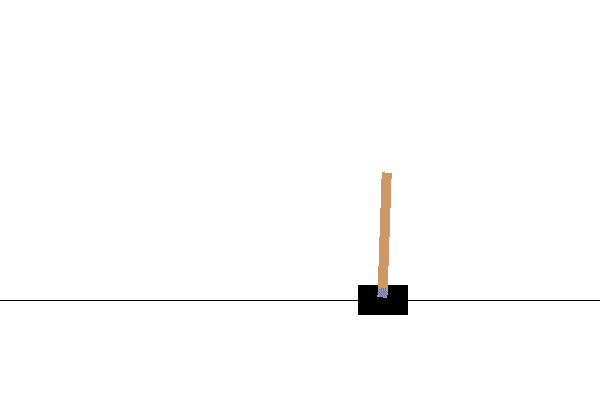

In [14]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(image_file)

## 다음 단계

이 튜토리얼에서는 Tensorflow를 사용하여 Actor-Critic 방법을 구현하는 방법을 보여주었습니다.

다음 단계로 OpenAI Gym의 다른 환경에서 모델의 훈련을 시도할 수 있습니다.

Actor-Critic 방법 및 Cartpole-v0 문제에 대한 추가 정보는 다음 리소스를 참조하세요.

- [Actor Critic 방법](https://hal.inria.fr/hal-00840470/document)
- [CAL(Actor Critic Lecture)](https://www.youtube.com/watch?v=EKqxumCuAAY&list=PLkFD6_40KJIwhWJpGazJ9VSj9CFMkb79A&index=7&t=0s)
- [카트폴 학습 제어 문제 [Barto 등 1983]](http://www.derongliu.org/adp/adp-cdrom/Barto1983.pdf)

TensorFlow에서 더 많은 강화 학습 예를 보려면 다음 리소스를 확인하세요.

- [강화 학습 코드 예제(keras.io)](https://keras.io/examples/rl/)
- [TF-Agents 강화 학습 라이브러리](https://www.tensorflow.org/agents)
